In [1]:
import numpy as np
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import scipy.misc
import cv2
import imageio
# the rest of the library
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.signal import medfilt
from scipy import arange
import sys
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import scipy as sc
from scipy.ndimage import gaussian_filter
from numpy import vstack
from numpy import hstack
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pywt
from sklearn import preprocessing
from scipy.fftpack import fft, ifft
from scipy import fftpack
from scipy.stats import norm
import scipy as sc
import statistics
from scipy import signal
from scipy import stats
from PIL import Image
from scipy.ndimage import gaussian_filter
import cv2
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import scipy.misc
import cv2
import imageio
from collections import Counter
from sklearn.cluster import MeanShift, estimate_bandwidth
plt.style.use('dark_background')

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab
import imageio



In [3]:
dir1 = '/volumes/MYUSB/Thesis/HippoRatPCA3SIGMA.brw'
dir2 = '/volumes/MYUSB/Thesis/Average4.brw'

In [4]:
def shearlets(matrix):
#     sigma = 10
    scales = 2
#     thresholdingFactor = 10
    # load data
#     X = imageio.imread('barbara.jpg')[::4, ::4]
    matrix = matrix.astype(float)
    X = matrix 
    # add noise
#     Xnoisy = X + sigma*np.random.randn(X.shape[0], X.shape[1])
    ## create shearlets
    shearletSystem = pyshearlab.SLgetShearletSystem2D(0,X.shape[0], X.shape[1], scales)
    # decomposition
    coeffs = pyshearlab.SLsheardec2D(X, shearletSystem)
    # thresholding
    oldCoeffs = coeffs.copy()
    weights = np.ones(coeffs.shape)

    for j in range(len(shearletSystem["RMS"])):
        weights[:,:,j] = shearletSystem["RMS"][j]*np.ones((X.shape[0], X.shape[1]))

    coeffs = np.real(coeffs)
    print(coeffs.shape)
#     zero_indices = np.abs(coeffs) / (thresholdingFactor * weights * sigma) < 1
#     coeffs[zero_indices] = 0

    c = np.vstack(coeffs)
    w = np.vstack(weights)
    c = c .flatten()
    w = w.flatten()
    mult = np.divide(c,w)
    s = np.std(mult)
    print("std: ",s)
    theshold = s * 2
    print("threshold: ",theshold)
    # mask = map(lambda x : 1 if (x > theshold) else 0, mult)
    mask = map(lambda x : 1 if (abs(x) > theshold) else 0, mult)
    mask = list(mask)
    
    p = sum(mask)/len(mult) * 100
    print("p:", p)
    
    new = np.multiply(mult,mask)
    new = new.reshape(64,64,17)
#      filteredCoeffs = Clustering2(coeffs)

    # reconstruction
    Xrec = pyshearlab.SLshearrec2D(new, shearletSystem)
#     Xrec = pyshearlab.SLshearrec2D(filteredCoeffs, shearletSystem)

    PSNR = pyshearlab.SLcomputePSNR(X,Xrec)
    print("PSNR: " + str(PSNR))
    return Xrec




In [5]:
def loadData(directory):
#     'HippoRat.brw'
     with h5py.File(directory, 'r') as hdf:

        chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
        numChs = len(chsList)
        frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])

#         channelIdx = index
#         ids = np.arange(channelIdx, frames * numChs, numChs)
        data = np.array(hdf.get('3BData/Raw'))

        # extract info relating to signal conversion 
        signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
        maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
        minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
        bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
        sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))

        qLevel = 2**bitDepth 
        fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
        singleElectrodeUV = data * signalInversion;
        singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
        singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt
        return singleElectrodeUV, numChs, frames,sampmlingFrequency

In [6]:
def loadChannel(channel, directory):
    xstr = (channel[0],channel[1])
    # good signal (53,20)
    # signals embedded into the noise [34,23] 
    # no signals only basal noise [35,12]
    # positive and negative spikes [16,4]
    # noisy electrode - [22,7]
    # 'Culture_Accura_Hippo_Rat_11DIV_6.5sec_Spontaneous.brw'

    # Load data
    with h5py.File(directory, 'r') as hdf:
        chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
        numChs = len(chsList)
        frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])
        selectedChannel = (chsList['Row'] == int(xstr[0])) * (chsList['Col'] == int(xstr[1]))
        channelIdx = np.where(selectedChannel == True)[0][0]
        ids = np.arange(channelIdx, frames * numChs, numChs)

#         print('frames: ', frames)
        data = np.array(hdf.get('3BData/Raw'))[ids]
        # extract info relating to signal conversion 
        signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
        maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
        minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
        bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
        sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))

    qLevel = 2**bitDepth 
    fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
    singleElectrodeUV = data * signalInversion;
    singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
    singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt
    return  singleElectrodeUV, sampmlingFrequency

In [7]:
rawData, numChs, frames, sampmlingFrequency =  loadData(dir1)
print("frames: ",frames)

frames:  21022


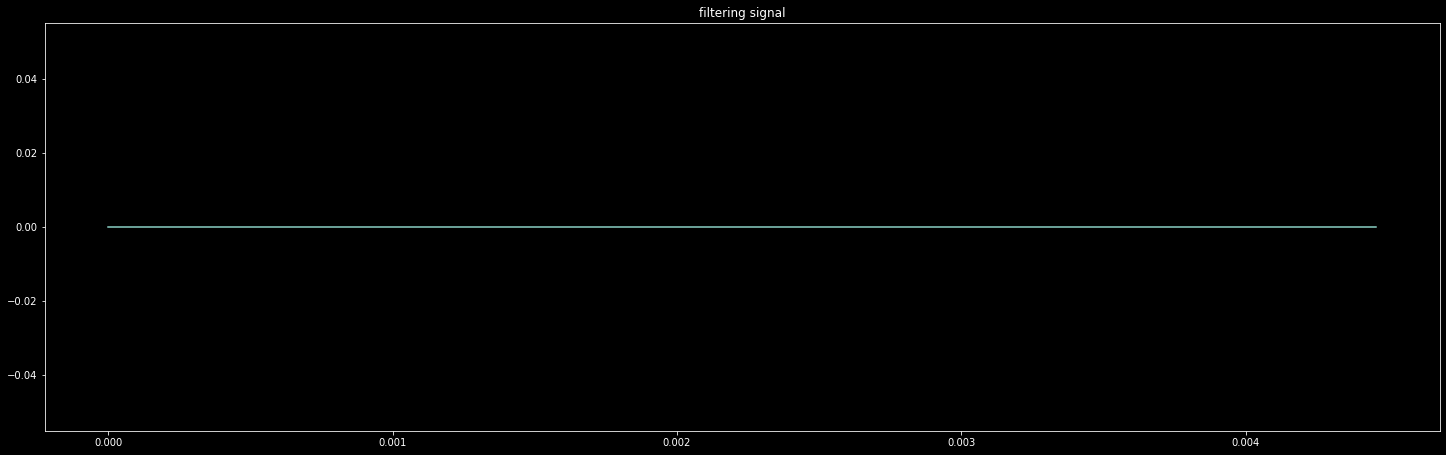

In [8]:
start = 10
end = 100
plt.figure(figsize=(25,7.5))
plt.plot(range(len(rawData[start:end]))/sampmlingFrequency, rawData[start:end]) 
plt.title('filtering signal')
plt.show()

In [9]:
OutData = []
windowSize = 20
# bellow was range(frames - windowSize)

for pos in range(frames - windowSize):
    if(pos%1000 == 0):
        print("pos: ",pos)
    storeArr = []
    start = pos
    
    for i in range(start,start + windowSize):
        frame = i
        data = rawData[numChs * frame :numChs * (frame + 1)]
        storeArr.append(data) 
#     print("len storeArr",len(storeArr))
    storeArr = np.array(storeArr)
    meanWindow = storeArr.mean(axis=0)
    OutData.append(meanWindow)

pos:  0
pos:  1000
pos:  2000
pos:  3000
pos:  4000
pos:  5000
pos:  6000
pos:  7000
pos:  8000
pos:  9000
pos:  10000
pos:  11000
pos:  12000
pos:  13000
pos:  14000
pos:  15000
pos:  16000
pos:  17000
pos:  18000
pos:  19000
pos:  20000
pos:  21000


In [10]:
shearletMatrix = []
# len(OutData)
for s in range(0,len(OutData)):


    I = OutData[s].reshape(64,64)
    Xrec = shearlets(matrix = I)
    XrecArr =  Xrec.flatten()
    shearletMatrix.append(XrecArr)
    
#     plt.figure(figsize=(25,7.5))
#     plt.gray()
#     plt.imshow(multiplication )
#     plt.colorbar()
#     plt.show()
    
    print("s: ",s)

(64, 64, 17)
std:  1.662715019729958
threshold:  3.325430039459916
p: 5.473058363970589
PSNR: 30.5030144452941
s:  0
(64, 64, 17)
std:  1.6563761701407926
threshold:  3.3127523402815853
p: 5.437155330882353
PSNR: 30.538349262631318
s:  1
(64, 64, 17)
std:  1.634808696686485
threshold:  3.26961739337297
p: 5.303596047794118
PSNR: 30.638527770177934
s:  2
(64, 64, 17)
std:  1.562448661660555
threshold:  3.12489732332111
p: 5.182961856617647
PSNR: 31.002002902635198
s:  3
(64, 64, 17)
std:  1.4764731554745958
threshold:  2.9529463109491916
p: 5.17434512867647
PSNR: 31.508253452013008
s:  4
(64, 64, 17)
std:  1.401196527586152
threshold:  2.802393055172304
p: 5.24758731617647
PSNR: 31.955382142755138
s:  5
(64, 64, 17)
std:  1.3313910767270607
threshold:  2.6627821534541214
p: 4.951746323529411
PSNR: 32.38755276827615
s:  6
(64, 64, 17)
std:  1.277740303362166
threshold:  2.555480606724332
p: 4.555376838235294
PSNR: 32.55730614257735
s:  7
(64, 64, 17)
std:  1.2505492117888255
threshold:  

(64, 64, 17)
std:  1.9332591357627928
threshold:  3.8665182715255857
p: 5.814855238970589
PSNR: 30.0178064435036
s:  30
(64, 64, 17)
std:  1.8871939069904804
threshold:  3.774387813980961
p: 5.63821231617647
PSNR: 30.173854287407984
s:  31
(64, 64, 17)
std:  1.8375636290341386
threshold:  3.6751272580682772
p: 5.461569393382353
PSNR: 30.295009548647567
s:  32
(64, 64, 17)
std:  1.7970810330513034
threshold:  3.594162066102607
p: 5.227481617647059
PSNR: 30.30308901996139
s:  33
(64, 64, 17)
std:  1.7779102340786432
threshold:  3.5558204681572865
p: 5.10397518382353
PSNR: 30.232422480321354
s:  34
(64, 64, 17)
std:  1.7917552673644077
threshold:  3.5835105347288154
p: 4.984777113970589
PSNR: 30.008745371646395
s:  35
(64, 64, 17)
std:  1.809352211916322
threshold:  3.618704423832644
p: 4.818187040441177
PSNR: 29.84550466759157
s:  36
(64, 64, 17)
std:  1.8091627268088917
threshold:  3.6183254536177833
p: 4.81100643382353
PSNR: 29.795914511809816
s:  37
(64, 64, 17)
std:  1.80704093610320

(64, 64, 17)
std:  1.8928490155203725
threshold:  3.785698031040745
p: 5.758846507352941
PSNR: 31.11065553722369
s:  60
(64, 64, 17)
std:  1.816499234357193
threshold:  3.632998468714386
p: 5.685604319852941
PSNR: 31.464485589128696
s:  61
(64, 64, 17)
std:  1.7732504276668497
threshold:  3.5465008553336994
p: 5.840705422794118
PSNR: 31.65336849733834
s:  62
(64, 64, 17)
std:  1.736086725501119
threshold:  3.472173451002238
p: 5.856502757352941
PSNR: 31.60868098666254
s:  63
(64, 64, 17)
std:  1.6654564997358017
threshold:  3.3309129994716034
p: 5.732996323529411
PSNR: 31.70902490002134
s:  64
(64, 64, 17)
std:  1.5738699509736758
threshold:  3.1477399019473515
p: 5.475930606617647
PSNR: 32.05236864161538
s:  65
(64, 64, 17)
std:  1.5202014299997864
threshold:  3.0404028599995727
p: 5.435719209558823
PSNR: 32.39429494789714
s:  66
(64, 64, 17)
std:  1.55427003957016
threshold:  3.10854007914032
p: 5.475930606617647
PSNR: 32.472702008619706
s:  67
(64, 64, 17)
std:  1.6801543339334961
t

(64, 64, 17)
std:  2.199763277195503
threshold:  4.399526554391006
p: 5.473058363970589
PSNR: 30.202398758263396
s:  90
(64, 64, 17)
std:  2.1280504211491933
threshold:  4.256100842298387
p: 5.194450827205882
PSNR: 30.160474215275684
s:  91
(64, 64, 17)
std:  2.0679584635347292
threshold:  4.1359169270694585
p: 4.946001838235294
PSNR: 30.100849731987772
s:  92
(64, 64, 17)
std:  1.9679274374627318
threshold:  3.9358548749254636
p: 4.795209099264706
PSNR: 30.30398919983725
s:  93
(64, 64, 17)
std:  1.8537719259912249
threshold:  3.7075438519824497
p: 4.6875
PSNR: 30.71732650514988
s:  94
(64, 64, 17)
std:  1.7880041096334218
threshold:  3.5760082192668436
p: 4.78659237132353
PSNR: 31.044271761872647
s:  95
(64, 64, 17)
std:  1.7698500550884562
threshold:  3.5397001101769123
p: 5.069508272058823
PSNR: 31.3867169554403
s:  96
(64, 64, 17)
std:  1.8231264207818125
threshold:  3.646252841563625
p: 5.257640165441177
PSNR: 31.642790680224234
s:  97
(64, 64, 17)
std:  1.9317995719076895
thresh

(64, 64, 17)
std:  2.256240595182203
threshold:  4.512481190364406
p: 5.856502757352941
PSNR: 31.591782498587904
s:  121
(64, 64, 17)
std:  2.2028420306613614
threshold:  4.405684061322723
p: 5.865119485294118
PSNR: 31.759250934629538
s:  122
(64, 64, 17)
std:  2.1942078129665368
threshold:  4.3884156259330735
p: 5.85793887867647
PSNR: 31.577249234852847
s:  123
(64, 64, 17)
std:  2.2043656288068725
threshold:  4.408731257613745
p: 5.705710018382353
PSNR: 31.333788251129594
s:  124
(64, 64, 17)
std:  2.1931231456519424
threshold:  4.386246291303885
p: 5.391199448529411
PSNR: 31.06240344904935
s:  125
(64, 64, 17)
std:  2.182165096901956
threshold:  4.364330193803912
p: 5.023552389705882
PSNR: 30.661566403536916
s:  126
(64, 64, 17)
std:  2.185755200230129
threshold:  4.371510400460258
p: 4.779411764705882
PSNR: 30.089513016603252
s:  127
(64, 64, 17)
std:  2.2219458045300913
threshold:  4.4438916090601825
p: 4.634363511029411
PSNR: 29.46938793086773
s:  128
(64, 64, 17)
std:  2.2572185

(64, 64, 17)
std:  2.0992299313763145
threshold:  4.198459862752629
p: 3.5989200367647056
PSNR: 27.790293936684684
s:  151
(64, 64, 17)
std:  2.146636962604372
threshold:  4.293273925208744
p: 3.7353515625
PSNR: 27.65482477986601
s:  152
(64, 64, 17)
std:  2.216152039192899
threshold:  4.432304078385798
p: 3.8531135110294117
PSNR: 27.492271102138616
s:  153
(64, 64, 17)
std:  2.2833871785218904
threshold:  4.566774357043781
p: 4.006778492647059
PSNR: 27.42474146172697
s:  154
(64, 64, 17)
std:  2.3728967773858898
threshold:  4.7457935547717796
p: 4.248046875
PSNR: 27.38348805517507
s:  155
(64, 64, 17)
std:  2.4503456331631814
threshold:  4.900691266326363
p: 4.509420955882353
PSNR: 27.37482109342495
s:  156
(64, 64, 17)
std:  2.540197180086063
threshold:  5.080394360172126
p: 4.6989889705882355
PSNR: 27.28244465573571
s:  157
(64, 64, 17)
std:  2.600922140213655
threshold:  5.20184428042731
p: 4.879940257352941
PSNR: 27.339201818078983
s:  158
(64, 64, 17)
std:  2.650981008232623
thre

(64, 64, 17)
std:  1.6378196359238628
threshold:  3.2756392718477256
p: 5.088177849264706
PSNR: 31.056867350394914
s:  181
(64, 64, 17)
std:  1.6384591821491925
threshold:  3.276918364298385
p: 5.013499540441177
PSNR: 31.097503744983023
s:  182
(64, 64, 17)
std:  1.6506198409592758
threshold:  3.3012396819185517
p: 5.059455422794118
PSNR: 31.087322184409416
s:  183
(64, 64, 17)
std:  1.6720113990578804
threshold:  3.344022798115761
p: 5.072380514705882
PSNR: 31.017746764526926
s:  184
(64, 64, 17)
std:  1.7350376439979318
threshold:  3.4700752879958636
p: 5.24758731617647
PSNR: 30.68004079554924
s:  185
(64, 64, 17)
std:  1.7682634239692347
threshold:  3.5365268479384695
p: 5.36965762867647
PSNR: 30.538056517615452
s:  186
(64, 64, 17)
std:  1.7836872474515044
threshold:  3.567374494903009
p: 5.428538602941177
PSNR: 30.512771653754655
s:  187
(64, 64, 17)
std:  1.769449378794781
threshold:  3.538898757589562
p: 5.461569393382353
PSNR: 30.607750512257212
s:  188
(64, 64, 17)
std:  1.762

(64, 64, 17)
std:  2.0158508771867365
threshold:  4.031701754373473
p: 4.8583984375
PSNR: 29.209131895633963
s:  211
(64, 64, 17)
std:  1.9885106260006296
threshold:  3.977021252001259
p: 4.85983455882353
PSNR: 29.37095980060857
s:  212
(64, 64, 17)
std:  1.9593975081392654
threshold:  3.9187950162785308
p: 4.921587775735294
PSNR: 29.524021550184546
s:  213
(64, 64, 17)
std:  1.9298405821105489
threshold:  3.8596811642210977
p: 4.924460018382353
PSNR: 29.668133211290456
s:  214
(64, 64, 17)
std:  1.915044665519014
threshold:  3.830089331038028
p: 4.9072265625
PSNR: 29.73240545104682
s:  215
(64, 64, 17)
std:  1.921635743915621
threshold:  3.843271487831242
p: 4.829676011029411
PSNR: 29.717182572863035
s:  216
(64, 64, 17)
std:  1.9210244862861277
threshold:  3.8420489725722553
p: 4.7736672794117645
PSNR: 29.792133984527887
s:  217
(64, 64, 17)
std:  1.8830680567582192
threshold:  3.7661361135164384
p: 4.756433823529411
PSNR: 30.077458781377192
s:  218
(64, 64, 17)
std:  1.8359903667106

(64, 64, 17)
std:  1.9037024527223507
threshold:  3.8074049054447014
p: 4.90579044117647
PSNR: 29.76372106206732
s:  241
(64, 64, 17)
std:  1.9343158121269464
threshold:  3.8686316242538927
p: 5.058019301470589
PSNR: 29.68719691079648
s:  242
(64, 64, 17)
std:  1.9722191613920328
threshold:  3.9444383227840656
p: 5.145622702205882
PSNR: 29.502340589697265
s:  243
(64, 64, 17)
std:  2.00422937979903
threshold:  4.00845875959806
p: 5.254767922794118
PSNR: 29.34664053716007
s:  244
(64, 64, 17)
std:  2.0089533550076344
threshold:  4.017906710015269
p: 5.307904411764706
PSNR: 29.36089270365896
s:  245
(64, 64, 17)
std:  2.001498155387991
threshold:  4.002996310775982
p: 5.292107077205882
PSNR: 29.531822665922967
s:  246
(64, 64, 17)
std:  2.0003941352076597
threshold:  4.0007882704153195
p: 5.471622242647059
PSNR: 29.61023178785144
s:  247
(64, 64, 17)
std:  1.9866271987156023
threshold:  3.9732543974312047
p: 5.6267233455882355
PSNR: 29.875627362367446
s:  248
(64, 64, 17)
std:  1.9928133

(64, 64, 17)
std:  2.162252040532405
threshold:  4.32450408106481
p: 4.4060202205882355
PSNR: 28.721295539973895
s:  271
(64, 64, 17)
std:  2.1942463633807523
threshold:  4.388492726761505
p: 4.291130514705882
PSNR: 28.579657550024613
s:  272
(64, 64, 17)
std:  2.17660286160512
threshold:  4.35320572321024
p: 4.263844209558823
PSNR: 28.549343168220332
s:  273
(64, 64, 17)
std:  2.164466924463569
threshold:  4.328933848927138
p: 4.080020680147059
PSNR: 28.49225348555743
s:  274
(64, 64, 17)
std:  2.1801777615249853
threshold:  4.360355523049971
p: 3.7913602941176467
PSNR: 28.329906834826957
s:  275
(64, 64, 17)
std:  2.216362324858303
threshold:  4.432724649716606
p: 3.4969554227941178
PSNR: 28.10819018185874
s:  276
(64, 64, 17)
std:  2.191070023503211
threshold:  4.382140047006422
p: 3.360523897058824
PSNR: 28.19401119362704
s:  277
(64, 64, 17)
std:  2.185923146556059
threshold:  4.371846293112118
p: 3.3878102022058822
PSNR: 28.325067499667046
s:  278
(64, 64, 17)
std:  2.16737638727

(64, 64, 17)
std:  2.440899839678735
threshold:  4.88179967935747
p: 5.661190257352941
PSNR: 28.938292914747926
s:  301
(64, 64, 17)
std:  2.569299281724798
threshold:  5.138598563449596
p: 5.646829044117647
PSNR: 29.02415686168346
s:  302
(64, 64, 17)
std:  2.7305836369057914
threshold:  5.461167273811583
p: 5.734432444852941
PSNR: 28.863688721579045
s:  303
(64, 64, 17)
std:  2.8581116861856293
threshold:  5.7162233723712585
p: 5.780388327205882
PSNR: 28.578195634668916
s:  304
(64, 64, 17)
std:  2.9410486618529634
threshold:  5.882097323705927
p: 5.745921415441177
PSNR: 28.38633279579569
s:  305
(64, 64, 17)
std:  3.0241048048777186
threshold:  6.048209609755437
p: 5.722943474264706
PSNR: 28.094521909136624
s:  306
(64, 64, 17)
std:  3.0849787822025125
threshold:  6.169957564405025
p: 5.793313419117647
PSNR: 27.913120490284953
s:  307
(64, 64, 17)
std:  3.110595344497008
threshold:  6.221190688994016
p: 5.879480698529411
PSNR: 27.846151936886727
s:  308
(64, 64, 17)
std:  3.12827151

(64, 64, 17)
std:  1.6581798089797652
threshold:  3.3163596179595305
p: 5.740176930147059
PSNR: 31.421020898275675
s:  331
(64, 64, 17)
std:  1.6265124810023528
threshold:  3.2530249620047056
p: 5.830652573529411
PSNR: 31.682810627430555
s:  332
(64, 64, 17)
std:  1.6196098384840447
threshold:  3.2392196769680894
p: 5.789005055147059
PSNR: 31.829834874314496
s:  333
(64, 64, 17)
std:  1.6347162635529875
threshold:  3.269432527105975
p: 5.669806985294118
PSNR: 31.85657795743453
s:  334
(64, 64, 17)
std:  1.6435904025313854
threshold:  3.287180805062771
p: 5.539119944852941
PSNR: 31.859812784657176
s:  335
(64, 64, 17)
std:  1.6715767037584128
threshold:  3.3431534075168257
p: 5.477366727941177
PSNR: 31.878597359619746
s:  336
(64, 64, 17)
std:  1.7021818725316447
threshold:  3.4043637450632893
p: 5.454388786764706
PSNR: 31.899530736088373
s:  337
(64, 64, 17)
std:  1.7384076802443313
threshold:  3.4768153604886627
p: 5.550608915441177
PSNR: 31.97460358365167
s:  338
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.920202838522324
threshold:  3.840405677044648
p: 4.46633731617647
PSNR: 29.95248941072738
s:  361
(64, 64, 17)
std:  1.9548670377245034
threshold:  3.909734075449007
p: 4.485006893382353
PSNR: 29.889894731457073
s:  362
(64, 64, 17)
std:  2.0232929956739416
threshold:  4.046585991347883
p: 4.645852481617647
PSNR: 29.598926102796558
s:  363
(64, 64, 17)
std:  2.0831717021621454
threshold:  4.166343404324291
p: 4.793772977941177
PSNR: 29.431388430471443
s:  364
(64, 64, 17)
std:  2.072055437596829
threshold:  4.144110875193658
p: 4.885684742647059
PSNR: 29.665964719035834
s:  365
(64, 64, 17)
std:  2.0064289305466145
threshold:  4.012857861093229
p: 5.032169117647059
PSNR: 30.121744878058184
s:  366
(64, 64, 17)
std:  1.9138510981239139
threshold:  3.8277021962478277
p: 5.447208180147059
PSNR: 30.577140295983295
s:  367
(64, 64, 17)
std:  1.8365460918113314
threshold:  3.673092183622663
p: 5.478802849264706
PSNR: 30.96690762409527
s:  368
(64, 64, 17)
std:  1.8073379

(64, 64, 17)
std:  1.3719011879645875
threshold:  2.743802375929175
p: 5.49460018382353
PSNR: 32.52035899559023
s:  391
(64, 64, 17)
std:  1.3990910320618966
threshold:  2.798182064123793
p: 5.549172794117647
PSNR: 32.44312484264388
s:  392
(64, 64, 17)
std:  1.4102264220177034
threshold:  2.820452844035407
p: 5.582203584558823
PSNR: 32.437663278665795
s:  393
(64, 64, 17)
std:  1.4154065821436084
threshold:  2.8308131642872167
p: 5.68991268382353
PSNR: 32.42795391038386
s:  394
(64, 64, 17)
std:  1.426651319846705
threshold:  2.85330263969341
p: 5.777516084558823
PSNR: 32.42646257417546
s:  395
(64, 64, 17)
std:  1.4521145689065231
threshold:  2.9042291378130463
p: 5.768899356617647
PSNR: 32.405983734466815
s:  396
(64, 64, 17)
std:  1.4750957957747926
threshold:  2.950191591549585
p: 6.00442325367647
PSNR: 32.37490261538955
s:  397
(64, 64, 17)
std:  1.4939576845199496
threshold:  2.987915369039899
p: 6.2255859375
PSNR: 32.36695417608806
s:  398
(64, 64, 17)
std:  1.546579839317959
t

(64, 64, 17)
std:  1.2260609404162108
threshold:  2.4521218808324217
p: 5.326573988970589
PSNR: 33.44763676230364
s:  421
(64, 64, 17)
std:  1.213667714186247
threshold:  2.427335428372494
p: 5.447208180147059
PSNR: 33.53641601940507
s:  422
(64, 64, 17)
std:  1.2485064451444665
threshold:  2.497012890288933
p: 5.204503676470589
PSNR: 33.2140461348027
s:  423
(64, 64, 17)
std:  1.305528807070796
threshold:  2.611057614141592
p: 5.096794577205882
PSNR: 32.66127655947172
s:  424
(64, 64, 17)
std:  1.33500259623528
threshold:  2.67000519247056
p: 4.963235294117647
PSNR: 32.41810719262015
s:  425
(64, 64, 17)
std:  1.3678236634528462
threshold:  2.7356473269056925
p: 4.766486672794118
PSNR: 32.251677381208296
s:  426
(64, 64, 17)
std:  1.416948541794038
threshold:  2.833897083588076
p: 4.541015625
PSNR: 31.970255257579524
s:  427
(64, 64, 17)
std:  1.479183874940345
threshold:  2.95836774988069
p: 4.250919117647059
PSNR: 31.550844582515886
s:  428
(64, 64, 17)
std:  1.5470966365103118
thre

(64, 64, 17)
std:  1.1426138414849272
threshold:  2.2852276829698543
p: 4.898609834558823
PSNR: 33.92714174499122
s:  451
(64, 64, 17)
std:  1.1202916751459002
threshold:  2.2405833502918004
p: 4.8224954044117645
PSNR: 34.1271704573085
s:  452
(64, 64, 17)
std:  1.1019812581308144
threshold:  2.2039625162616288
p: 4.670266544117647
PSNR: 34.24726486666518
s:  453
(64, 64, 17)
std:  1.0905811013010775
threshold:  2.181162202602155
p: 4.447667738970589
PSNR: 34.2418649630995
s:  454
(64, 64, 17)
std:  1.0717679211636577
threshold:  2.1435358423273154
p: 4.31985294117647
PSNR: 34.356696607236145
s:  455
(64, 64, 17)
std:  1.0628513541342708
threshold:  2.1257027082685416
p: 4.489315257352941
PSNR: 34.42131946572479
s:  456
(64, 64, 17)
std:  1.0665214252464492
threshold:  2.1330428504928984
p: 4.703297334558823
PSNR: 34.54560913865016
s:  457
(64, 64, 17)
std:  1.0755636881636974
threshold:  2.151127376327395
p: 4.8224954044117645
PSNR: 34.576878627421
s:  458
(64, 64, 17)
std:  1.0975320

(64, 64, 17)
std:  1.2976848264396674
threshold:  2.595369652879335
p: 6.162396599264706
PSNR: 33.4923756258333
s:  481
(64, 64, 17)
std:  1.3579156129827084
threshold:  2.7158312259654167
p: 5.9455422794117645
PSNR: 33.139254156778705
s:  482
(64, 64, 17)
std:  1.4031057772278517
threshold:  2.8062115544557034
p: 5.78469669117647
PSNR: 32.86184304787129
s:  483
(64, 64, 17)
std:  1.4662585284081928
threshold:  2.9325170568163856
p: 5.622414981617647
PSNR: 32.39039248712632
s:  484
(64, 64, 17)
std:  1.5345750776375633
threshold:  3.0691501552751266
p: 5.484547334558823
PSNR: 31.858638692772658
s:  485
(64, 64, 17)
std:  1.6202536232675844
threshold:  3.2405072465351688
p: 5.161420036764706
PSNR: 31.383463629345847
s:  486
(64, 64, 17)
std:  1.6997226747329715
threshold:  3.399445349465943
p: 4.937385110294118
PSNR: 30.895830456841374
s:  487
(64, 64, 17)
std:  1.767540203507007
threshold:  3.535080407014014
p: 4.730583639705882
PSNR: 30.390286334645985
s:  488
(64, 64, 17)
std:  1.811

(64, 64, 17)
std:  2.0036294867307975
threshold:  4.007258973461595
p: 4.345703125
PSNR: 29.37507169787923
s:  511
(64, 64, 17)
std:  2.023456472915772
threshold:  4.046912945831544
p: 4.390222886029411
PSNR: 29.32549933832086
s:  512
(64, 64, 17)
std:  2.0376494300149743
threshold:  4.075298860029949
p: 4.46920955882353
PSNR: 29.32320219339946
s:  513
(64, 64, 17)
std:  2.0499654339958373
threshold:  4.099930867991675
p: 4.513729319852941
PSNR: 29.346974896368884
s:  514
(64, 64, 17)
std:  2.073299346752707
threshold:  4.146598693505414
p: 4.421817555147059
PSNR: 29.363378594218823
s:  515
(64, 64, 17)
std:  2.096886661225261
threshold:  4.193773322450522
p: 4.41750919117647
PSNR: 29.435486824503165
s:  516
(64, 64, 17)
std:  2.1085693119381945
threshold:  4.217138623876389
p: 4.437614889705882
PSNR: 29.60220091533443
s:  517
(64, 64, 17)
std:  2.139888326272951
threshold:  4.279776652545902
p: 4.489315257352941
PSNR: 29.61426637847957
s:  518
(64, 64, 17)
std:  2.183872498726201
thre

(64, 64, 17)
std:  1.9352607943676463
threshold:  3.8705215887352926
p: 5.501780790441177
PSNR: 31.40030451170285
s:  541
(64, 64, 17)
std:  1.9649684751442593
threshold:  3.9299369502885186
p: 5.5549172794117645
PSNR: 31.404835386646095
s:  542
(64, 64, 17)
std:  2.0095835847918138
threshold:  4.0191671695836275
p: 5.54342830882353
PSNR: 31.254434568122047
s:  543
(64, 64, 17)
std:  2.0448789315997855
threshold:  4.089757863199571
p: 5.585075827205882
PSNR: 31.236431955222695
s:  544
(64, 64, 17)
std:  2.0812968048174865
threshold:  4.162593609634973
p: 5.6267233455882355
PSNR: 31.270288328583405
s:  545
(64, 64, 17)
std:  2.1108615471250753
threshold:  4.221723094250151
p: 5.698529411764706
PSNR: 31.223181205753846
s:  546
(64, 64, 17)
std:  2.143690420614547
threshold:  4.287380841229094
p: 5.715762867647059
PSNR: 31.322961532319166
s:  547
(64, 64, 17)
std:  2.191136945653162
threshold:  4.382273891306324
p: 5.819163602941177
PSNR: 31.393177479588154
s:  548
(64, 64, 17)
std:  2.26

(64, 64, 17)
std:  13.488943046504021
threshold:  26.977886093008042
p: 1.0914522058823528
PSNR: 10.859146931788215
s:  571
(64, 64, 17)
std:  13.70566181243507
threshold:  27.41132362487014
p: 1.0928883272058825
PSNR: 10.848554382341968
s:  572
(64, 64, 17)
std:  13.984515420940005
threshold:  27.96903084188001
p: 1.0957605698529411
PSNR: 10.837618759258714
s:  573
(64, 64, 17)
std:  14.311131146245092
threshold:  28.622262292490184
p: 1.1144301470588236
PSNR: 10.82498246115284
s:  574
(64, 64, 17)
std:  14.70307926285287
threshold:  29.40615852570574
p: 1.1704388786764706
PSNR: 10.803700281752494
s:  575
(64, 64, 17)
std:  15.127778076052872
threshold:  30.255556152105743
p: 1.2882008272058825
PSNR: 10.788962151161467
s:  576
(64, 64, 17)
std:  15.540441017467634
threshold:  31.080882034935268
p: 1.4102711397058825
PSNR: 10.78165094953722
s:  577
(64, 64, 17)
std:  15.919767372632252
threshold:  31.839534745264505
p: 1.5337775735294117
PSNR: 10.763034414480725
s:  578
(64, 64, 17)
st

(64, 64, 17)
std:  11.21269251375507
threshold:  22.42538502751014
p: 5.922564338235294
PSNR: 18.70872671666046
s:  601
(64, 64, 17)
std:  10.802010328420112
threshold:  21.604020656840223
p: 5.863683363970589
PSNR: 19.11627862377602
s:  602
(64, 64, 17)
std:  10.356928320707254
threshold:  20.71385664141451
p: 5.842141544117647
PSNR: 19.5239034569781
s:  603
(64, 64, 17)
std:  9.872424179055614
threshold:  19.744848358111227
p: 5.826344209558823
PSNR: 19.956425677189262
s:  604
(64, 64, 17)
std:  9.26480075369901
threshold:  18.52960150739802
p: 5.778952205882353
PSNR: 20.494280170216594
s:  605
(64, 64, 17)
std:  8.584429581921718
threshold:  17.168859163843436
p: 5.757410386029411
PSNR: 21.052499559341975
s:  606
(64, 64, 17)
std:  7.8860173654953
threshold:  15.7720347309906
p: 5.668370863970589
PSNR: 21.727960194694106
s:  607
(64, 64, 17)
std:  7.216057243695798
threshold:  14.432114487391596
p: 5.501780790441177
PSNR: 22.44441485567984
s:  608
(64, 64, 17)
std:  6.58775993608474

(64, 64, 17)
std:  2.9816993878907376
threshold:  5.963398775781475
p: 5.428538602941177
PSNR: 27.602794583537943
s:  631
(64, 64, 17)
std:  2.8986108336026777
threshold:  5.797221667205355
p: 5.526194852941177
PSNR: 27.98622970729395
s:  632
(64, 64, 17)
std:  2.820729241884938
threshold:  5.641458483769876
p: 5.632467830882353
PSNR: 28.367186685203947
s:  633
(64, 64, 17)
std:  2.7480162253271443
threshold:  5.496032450654289
p: 5.704273897058823
PSNR: 28.74116653452379
s:  634
(64, 64, 17)
std:  2.6893916867784746
threshold:  5.378783373556949
p: 5.819163602941177
PSNR: 28.943518279461976
s:  635
(64, 64, 17)
std:  2.647354470283199
threshold:  5.294708940566398
p: 5.816291360294118
PSNR: 29.11601557459644
s:  636
(64, 64, 17)
std:  2.589938721190042
threshold:  5.179877442380084
p: 5.949850643382353
PSNR: 29.296627582418267
s:  637
(64, 64, 17)
std:  2.510834199033225
threshold:  5.02166839806645
p: 5.95559512867647
PSNR: 29.67406683704279
s:  638
(64, 64, 17)
std:  2.4241648522398

(64, 64, 17)
std:  1.4515547010045717
threshold:  2.9031094020091435
p: 5.368221507352941
PSNR: 32.08927844449572
s:  661
(64, 64, 17)
std:  1.4494056034019795
threshold:  2.898811206803959
p: 5.44289981617647
PSNR: 32.093592768570424
s:  662
(64, 64, 17)
std:  1.455265753280536
threshold:  2.910531506561072
p: 5.51614200367647
PSNR: 32.04998332682079
s:  663
(64, 64, 17)
std:  1.4475752707176335
threshold:  2.895150541435267
p: 5.5305032169117645
PSNR: 32.11907531765504
s:  664
(64, 64, 17)
std:  1.4185186113171921
threshold:  2.8370372226343843
p: 5.612362132352941
PSNR: 32.31823844419464
s:  665
(64, 64, 17)
std:  1.380519045667214
threshold:  2.761038091334428
p: 5.643956801470589
PSNR: 32.59036196223654
s:  666
(64, 64, 17)
std:  1.3700365002245147
threshold:  2.7400730004490295
p: 5.731560202205882
PSNR: 32.71911103724264
s:  667
(64, 64, 17)
std:  1.372374158763606
threshold:  2.744748317527212
p: 5.76028262867647
PSNR: 32.75195755580869
s:  668
(64, 64, 17)
std:  1.370753594349

(64, 64, 17)
std:  1.7546683914498526
threshold:  3.5093367828997053
p: 5.343807444852941
PSNR: 31.845681120318766
s:  691
(64, 64, 17)
std:  1.824138055021739
threshold:  3.648276110043478
p: 5.4802389705882355
PSNR: 31.646665801379292
s:  692
(64, 64, 17)
std:  1.8801190741209666
threshold:  3.760238148241933
p: 5.511833639705882
PSNR: 31.506052764209365
s:  693
(64, 64, 17)
std:  1.9136928448342527
threshold:  3.8273856896685055
p: 5.47018612132353
PSNR: 31.36218026898028
s:  694
(64, 64, 17)
std:  1.933043684897903
threshold:  3.866087369795806
p: 5.375402113970589
PSNR: 31.224208267337303
s:  695
(64, 64, 17)
std:  1.9316178759263456
threshold:  3.863235751852691
p: 5.375402113970589
PSNR: 31.236641351769514
s:  696
(64, 64, 17)
std:  1.9201869110392995
threshold:  3.840373822078599
p: 5.441463694852941
PSNR: 31.277202543509635
s:  697
(64, 64, 17)
std:  1.9228121143653596
threshold:  3.845624228730719
p: 5.412741268382353
PSNR: 31.25633951340646
s:  698
(64, 64, 17)
std:  1.93001

(64, 64, 17)
std:  1.510819680810803
threshold:  3.021639361621606
p: 5.922564338235294
PSNR: 32.46367875752165
s:  721
(64, 64, 17)
std:  1.4831017551966446
threshold:  2.966203510393289
p: 6.058995863970589
PSNR: 32.46115735251352
s:  722
(64, 64, 17)
std:  1.464516749422655
threshold:  2.92903349884531
p: 6.070484834558823
PSNR: 32.44080485644702
s:  723
(64, 64, 17)
std:  1.4342455096427342
threshold:  2.8684910192854685
p: 5.995806525735294
PSNR: 32.556409441682874
s:  724
(64, 64, 17)
std:  1.401805088320191
threshold:  2.803610176640382
p: 6.037454044117647
PSNR: 32.72212212834732
s:  725
(64, 64, 17)
std:  1.3596708395575412
threshold:  2.7193416791150824
p: 6.0546875
PSNR: 33.07164389566716
s:  726
(64, 64, 17)
std:  1.3295448758449357
threshold:  2.6590897516898715
p: 5.990062040441177
PSNR: 33.24726687353005
s:  727
(64, 64, 17)
std:  1.2734090600676942
threshold:  2.5468181201353883
p: 5.902458639705882
PSNR: 33.4872428308175
s:  728
(64, 64, 17)
std:  1.2172430738849551
th

(64, 64, 17)
std:  1.0991087482004895
threshold:  2.198217496400979
p: 5.378274356617647
PSNR: 34.608613598210965
s:  751
(64, 64, 17)
std:  1.0936740532218698
threshold:  2.1873481064437397
p: 5.29928768382353
PSNR: 34.65685524580604
s:  752
(64, 64, 17)
std:  1.09129595623883
threshold:  2.18259191247766
p: 5.241842830882353
PSNR: 34.665194760494124
s:  753
(64, 64, 17)
std:  1.0812661974307578
threshold:  2.1625323948615156
p: 5.266256893382353
PSNR: 34.67645776275566
s:  754
(64, 64, 17)
std:  1.0791760662600762
threshold:  2.1583521325201525
p: 5.240406709558823
PSNR: 34.621470985162496
s:  755
(64, 64, 17)
std:  1.0828402112231188
threshold:  2.1656804224462376
p: 5.1887063419117645
PSNR: 34.486789074544234
s:  756
(64, 64, 17)
std:  1.0625448688852568
threshold:  2.1250897377705136
p: 5.3840188419117645
PSNR: 34.65580071839584
s:  757
(64, 64, 17)
std:  1.0151609569459892
threshold:  2.0303219138919784
p: 5.546300551470589
PSNR: 35.112368497869745
s:  758
(64, 64, 17)
std:  0.98

(64, 64, 17)
std:  0.9413006674458888
threshold:  1.8826013348917776
p: 6.060431985294118
PSNR: 36.235649388503035
s:  781
(64, 64, 17)
std:  0.9322159827240643
threshold:  1.8644319654481285
p: 5.878044577205882
PSNR: 36.259512323483115
s:  782
(64, 64, 17)
std:  0.9125867973795192
threshold:  1.8251735947590384
p: 5.875172334558823
PSNR: 36.42949162059654
s:  783
(64, 64, 17)
std:  0.9054637450887992
threshold:  1.8109274901775985
p: 5.875172334558823
PSNR: 36.483249033853326
s:  784
(64, 64, 17)
std:  0.9046715340467311
threshold:  1.8093430680934621
p: 5.8952780330882355
PSNR: 36.48945584119786
s:  785
(64, 64, 17)
std:  0.9106695694695144
threshold:  1.8213391389390288
p: 5.731560202205882
PSNR: 36.36440039892206
s:  786
(64, 64, 17)
std:  0.906210182902401
threshold:  1.812420365804802
p: 5.520450367647059
PSNR: 36.233859375013424
s:  787
(64, 64, 17)
std:  0.8898975155248701
threshold:  1.7797950310497401
p: 5.435719209558823
PSNR: 36.33975364093531
s:  788
(64, 64, 17)
std:  0.

(64, 64, 17)
std:  1.0474642145664554
threshold:  2.094928429132911
p: 6.181066176470589
PSNR: 35.55335691135791
s:  811
(64, 64, 17)
std:  1.0342318890178528
threshold:  2.0684637780357056
p: 6.046070772058823
PSNR: 35.643307383962835
s:  812
(64, 64, 17)
std:  1.0244203845079236
threshold:  2.048840769015847
p: 6.172449448529411
PSNR: 35.710596776568224
s:  813
(64, 64, 17)
std:  1.0409923968702801
threshold:  2.0819847937405602
p: 6.25
PSNR: 35.65232838809094
s:  814
(64, 64, 17)
std:  1.0700736077134874
threshold:  2.1401472154269747
p: 6.3835592830882355
PSNR: 35.369536484805685
s:  815
(64, 64, 17)
std:  1.0904213974624084
threshold:  2.180842794924817
p: 6.3361672794117645
PSNR: 35.1590695022298
s:  816
(64, 64, 17)
std:  1.128108552804245
threshold:  2.25621710560849
p: 6.281594669117648
PSNR: 34.898492010312516
s:  817
(64, 64, 17)
std:  1.1676601251073266
threshold:  2.3353202502146533
p: 6.25143612132353
PSNR: 34.763537588078876
s:  818
(64, 64, 17)
std:  1.195968487467907
t

(64, 64, 17)
std:  1.410256987333727
threshold:  2.820513974667454
p: 3.6061006433823533
PSNR: 31.381963290572074
s:  841
(64, 64, 17)
std:  1.4102037691928935
threshold:  2.820407538385787
p: 3.6089728860294117
PSNR: 31.386171786549294
s:  842
(64, 64, 17)
std:  1.4051228811180643
threshold:  2.8102457622361285
p: 3.5888671875
PSNR: 31.451906865684304
s:  843
(64, 64, 17)
std:  1.411304165570804
threshold:  2.822608331141608
p: 3.5989200367647056
PSNR: 31.438671420070577
s:  844
(64, 64, 17)
std:  1.4043521343025374
threshold:  2.8087042686050747
p: 3.5903033088235294
PSNR: 31.469553758011347
s:  845
(64, 64, 17)
std:  1.3621271404945274
threshold:  2.724254280989055
p: 3.7985409007352944
PSNR: 31.817236633869822
s:  846
(64, 64, 17)
std:  1.2673087980971367
threshold:  2.5346175961942734
p: 4.184857536764706
PSNR: 32.65351684407933
s:  847
(64, 64, 17)
std:  1.1154428260504528
threshold:  2.2308856521009055
p: 4.799517463235294
PSNR: 34.041565577647575
s:  848
(64, 64, 17)
std:  0.98

(64, 64, 17)
std:  1.1032394805513142
threshold:  2.2064789611026283
p: 4.838292738970589
PSNR: 34.01293705409079
s:  871
(64, 64, 17)
std:  1.076848413145154
threshold:  2.153696826290308
p: 4.877068014705882
PSNR: 34.27023005910613
s:  872
(64, 64, 17)
std:  1.0647953895322875
threshold:  2.129590779064575
p: 4.914407169117647
PSNR: 34.480788410704115
s:  873
(64, 64, 17)
std:  1.082822346664045
threshold:  2.16564469332809
p: 5.029296875
PSNR: 34.507453238961226
s:  874
(64, 64, 17)
std:  1.1248123839643838
threshold:  2.2496247679287675
p: 5.478802849264706
PSNR: 34.43676830628509
s:  875
(64, 64, 17)
std:  1.1698141623762555
threshold:  2.339628324752511
p: 6.013039981617647
PSNR: 34.29665367067921
s:  876
(64, 64, 17)
std:  1.2016614765867377
threshold:  2.4033229531734754
p: 6.083409926470589
PSNR: 34.24954039236737
s:  877
(64, 64, 17)
std:  1.226044632067408
threshold:  2.452089264134816
p: 6.044634650735294
PSNR: 34.035904207341794
s:  878
(64, 64, 17)
std:  1.251178474258414

(64, 64, 17)
std:  1.1759823673035166
threshold:  2.351964734607033
p: 4.136029411764706
PSNR: 33.099149623670144
s:  901
(64, 64, 17)
std:  1.1776493781464372
threshold:  2.3552987562928744
p: 4.136029411764706
PSNR: 33.05173544709484
s:  902
(64, 64, 17)
std:  1.184200683035609
threshold:  2.368401366071218
p: 4.108743106617647
PSNR: 32.999079609439086
s:  903
(64, 64, 17)
std:  1.1889055871279162
threshold:  2.3778111742558323
p: 4.118795955882353
PSNR: 32.95455868764747
s:  904
(64, 64, 17)
std:  1.1894211191018298
threshold:  2.3788422382036596
p: 4.170496323529411
PSNR: 32.943275255866155
s:  905
(64, 64, 17)
std:  1.1353890308904815
threshold:  2.270778061780963
p: 4.140337775735294
PSNR: 33.385714504284344
s:  906
(64, 64, 17)
std:  1.0930985952304881
threshold:  2.1861971904609763
p: 4.1259765625
PSNR: 33.72848990691154
s:  907
(64, 64, 17)
std:  1.0859453729627493
threshold:  2.1718907459254986
p: 4.229377297794118
PSNR: 33.80645643436533
s:  908
(64, 64, 17)
std:  1.12021078

(64, 64, 17)
std:  2.3122665128868736
threshold:  4.624533025773747
p: 3.6865234375
PSNR: 28.56363715600989
s:  931
(64, 64, 17)
std:  2.3780101285368636
threshold:  4.756020257073727
p: 3.5874310661764706
PSNR: 28.23561604884894
s:  932
(64, 64, 17)
std:  2.4441237959214197
threshold:  4.888247591842839
p: 3.450999540441176
PSNR: 27.884011162912362
s:  933
(64, 64, 17)
std:  2.460247828821716
threshold:  4.920495657643432
p: 3.4524356617647056
PSNR: 27.756218367266378
s:  934
(64, 64, 17)
std:  2.409324121868624
threshold:  4.818648243737248
p: 3.650620404411765
PSNR: 27.95381955598671
s:  935
(64, 64, 17)
std:  2.3538192784549268
threshold:  4.7076385569098536
p: 3.732479319852941
PSNR: 28.202168411111714
s:  936
(64, 64, 17)
std:  2.2694743162373943
threshold:  4.5389486324747885
p: 3.917738970588235
PSNR: 28.613742034342266
s:  937
(64, 64, 17)
std:  2.192317590425488
threshold:  4.384635180850976
p: 4.0412454044117645
PSNR: 29.05666193823976
s:  938
(64, 64, 17)
std:  2.1303652485

(64, 64, 17)
std:  0.9907851134784688
threshold:  1.9815702269569375
p: 4.569738051470589
PSNR: 34.54205350144344
s:  961
(64, 64, 17)
std:  0.9815243020697554
threshold:  1.9630486041395108
p: 4.474954044117647
PSNR: 34.68518932402353
s:  962
(64, 64, 17)
std:  0.9465885481836542
threshold:  1.8931770963673085
p: 4.88424862132353
PSNR: 35.13346981931244
s:  963
(64, 64, 17)
std:  0.9324342391392048
threshold:  1.8648684782784095
p: 5.119772518382353
PSNR: 35.37197885436946
s:  964
(64, 64, 17)
std:  0.928650425516085
threshold:  1.85730085103217
p: 5.269129136029411
PSNR: 35.468102066395886
s:  965
(64, 64, 17)
std:  0.9361355348141102
threshold:  1.8722710696282203
p: 5.300723805147059
PSNR: 35.453363127521975
s:  966
(64, 64, 17)
std:  0.9431104246302685
threshold:  1.886220849260537
p: 5.305032169117647
PSNR: 35.30549003478767
s:  967
(64, 64, 17)
std:  0.9497179081687117
threshold:  1.8994358163374234
p: 5.134133731617647
PSNR: 35.18698458594479
s:  968
(64, 64, 17)
std:  0.931077

(64, 64, 17)
std:  0.7487575720567
threshold:  1.4975151441134
p: 5.768899356617647
PSNR: 38.01980638431041
s:  991
(64, 64, 17)
std:  0.8071372011491214
threshold:  1.6142744022982427
p: 5.832088694852941
PSNR: 37.441612979969825
s:  992
(64, 64, 17)
std:  0.8143090534318037
threshold:  1.6286181068636074
p: 5.7487936580882355
PSNR: 37.30546025119323
s:  993
(64, 64, 17)
std:  0.8085816009292722
threshold:  1.6171632018585445
p: 5.813419117647059
PSNR: 37.14134920177627
s:  994
(64, 64, 17)
std:  0.7976902018285629
threshold:  1.5953804036571257
p: 5.694221047794118
PSNR: 37.16052696165261
s:  995
(64, 64, 17)
std:  0.7909382183709185
threshold:  1.581876436741837
p: 5.86081112132353
PSNR: 37.32243428986733
s:  996
(64, 64, 17)
std:  0.796104532060868
threshold:  1.592209064121736
p: 6.040326286764706
PSNR: 37.12292209004375
s:  997
(64, 64, 17)
std:  0.8165844962168237
threshold:  1.6331689924336474
p: 5.93118106617647
PSNR: 36.807927133423135
s:  998
(64, 64, 17)
std:  0.84094681882

(64, 64, 17)
std:  0.721746124390162
threshold:  1.443492248780324
p: 5.03073299632353
PSNR: 37.60624100032982
s:  1021
(64, 64, 17)
std:  0.6846990564798762
threshold:  1.3693981129597523
p: 5.353860294117647
PSNR: 38.06998255965691
s:  1022
(64, 64, 17)
std:  0.6620554597385958
threshold:  1.3241109194771916
p: 5.325137867647059
PSNR: 38.36933281042144
s:  1023
(64, 64, 17)
std:  0.6647496538675844
threshold:  1.329499307735169
p: 5.1140280330882355
PSNR: 38.3087188307652
s:  1024
(64, 64, 17)
std:  0.7197821082635294
threshold:  1.4395642165270588
p: 4.904354319852941
PSNR: 37.529381966391504
s:  1025
(64, 64, 17)
std:  0.8107673983913427
threshold:  1.6215347967826854
p: 4.8095703125
PSNR: 36.40809707569357
s:  1026
(64, 64, 17)
std:  0.8894465426228639
threshold:  1.7788930852457279
p: 4.654469209558823
PSNR: 35.52393163382959
s:  1027
(64, 64, 17)
std:  0.909101479503275
threshold:  1.81820295900655
p: 4.585535386029411
PSNR: 35.30483517655483
s:  1028
(64, 64, 17)
std:  0.908089

(64, 64, 17)
std:  0.9351691789533577
threshold:  1.8703383579067154
p: 3.1924977022058822
PSNR: 34.7168428559532
s:  1051
(64, 64, 17)
std:  0.9614532618381162
threshold:  1.9229065236762324
p: 3.1723920036764706
PSNR: 34.43203932790703
s:  1052
(64, 64, 17)
std:  0.9773693892690561
threshold:  1.9547387785381123
p: 3.328929227941176
PSNR: 34.368476213257054
s:  1053
(64, 64, 17)
std:  0.996109177607068
threshold:  1.992218355214136
p: 3.4567440257352944
PSNR: 34.26093213401978
s:  1054
(64, 64, 17)
std:  0.9505158003308012
threshold:  1.9010316006616024
p: 3.9536420036764706
PSNR: 34.73392782284365
s:  1055
(64, 64, 17)
std:  0.9193151985935342
threshold:  1.8386303971870683
p: 4.331341911764706
PSNR: 35.05114592619776
s:  1056
(64, 64, 17)
std:  0.8702784719941096
threshold:  1.7405569439882191
p: 4.677447150735294
PSNR: 35.5343895704424
s:  1057
(64, 64, 17)
std:  0.8183457760194811
threshold:  1.6366915520389622
p: 4.736328125
PSNR: 36.15523787378828
s:  1058
(64, 64, 17)
std:  0.

(64, 64, 17)
std:  1.1350524375927933
threshold:  2.2701048751855866
p: 3.113511029411765
PSNR: 32.91118585085981
s:  1081
(64, 64, 17)
std:  1.0522066680901059
threshold:  2.1044133361802118
p: 3.317440257352941
PSNR: 33.67899847443738
s:  1082
(64, 64, 17)
std:  0.9952092514490332
threshold:  1.9904185028980663
p: 3.7181181066176467
PSNR: 34.1830513776399
s:  1083
(64, 64, 17)
std:  0.95753074020616
threshold:  1.91506148041232
p: 4.009650735294118
PSNR: 34.58644173746081
s:  1084
(64, 64, 17)
std:  0.9428619806375511
threshold:  1.8857239612751022
p: 4.354319852941177
PSNR: 34.77476457734997
s:  1085
(64, 64, 17)
std:  0.9230225865687477
threshold:  1.8460451731374954
p: 4.628619025735294
PSNR: 34.976402175976446
s:  1086
(64, 64, 17)
std:  0.8806797660622209
threshold:  1.7613595321244417
p: 5.024988511029411
PSNR: 35.48466433087232
s:  1087
(64, 64, 17)
std:  0.8314750010711737
threshold:  1.6629500021423473
p: 5.521886488970589
PSNR: 36.14778233607067
s:  1088
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.9859142765361608
threshold:  1.9718285530723216
p: 5.612362132352941
PSNR: 35.49117043201051
s:  1111
(64, 64, 17)
std:  1.130065552734183
threshold:  2.260131105468366
p: 4.911534926470589
PSNR: 34.16206920527618
s:  1112
(64, 64, 17)
std:  1.2511825949498219
threshold:  2.5023651898996437
p: 4.39453125
PSNR: 33.11504795830281
s:  1113
(64, 64, 17)
std:  1.3550545839517636
threshold:  2.710109167903527
p: 4.02975643382353
PSNR: 32.302255421453
s:  1114
(64, 64, 17)
std:  1.4435111870161463
threshold:  2.8870223740322927
p: 3.662109375
PSNR: 31.599614087347824
s:  1115
(64, 64, 17)
std:  1.5442890754863532
threshold:  3.0885781509727064
p: 3.255687040441176
PSNR: 30.8515815541448
s:  1116
(64, 64, 17)
std:  1.6427593170890786
threshold:  3.2855186341781573
p: 2.9842601102941178
PSNR: 30.159193709601947
s:  1117
(64, 64, 17)
std:  1.7279684979372862
threshold:  3.4559369958745725
p: 2.7300666360294117
PSNR: 29.584696936144034
s:  1118
(64, 64, 17)
std:  1.8068417357

(64, 64, 17)
std:  1.3379973077010523
threshold:  2.6759946154021046
p: 2.4356617647058822
PSNR: 31.57631628655323
s:  1141
(64, 64, 17)
std:  1.263926233364323
threshold:  2.527852466728646
p: 2.8578814338235294
PSNR: 32.195762310843456
s:  1142
(64, 64, 17)
std:  1.1874346350105336
threshold:  2.374869270021067
p: 3.1680836397058822
PSNR: 32.86896889291207
s:  1143
(64, 64, 17)
std:  1.1115286370932893
threshold:  2.2230572741865786
p: 3.677906709558824
PSNR: 33.531632249036335
s:  1144
(64, 64, 17)
std:  1.0226270128466493
threshold:  2.0452540256932985
p: 4.067095588235294
PSNR: 34.304998164077944
s:  1145
(64, 64, 17)
std:  1.0025390466587507
threshold:  2.0050780933175014
p: 4.081456801470589
PSNR: 34.5078915098216
s:  1146
(64, 64, 17)
std:  0.9959495825910979
threshold:  1.9918991651821958
p: 3.9507697610294117
PSNR: 34.51487822788328
s:  1147
(64, 64, 17)
std:  1.0049097084432574
threshold:  2.009819416886515
p: 3.6204618566176467
PSNR: 34.286257651711985
s:  1148
(64, 64, 17)

(64, 64, 17)
std:  0.7721837832164556
threshold:  1.5443675664329113
p: 6.49557674632353
PSNR: 37.810444273297975
s:  1171
(64, 64, 17)
std:  0.7908152649391404
threshold:  1.581630529878281
p: 6.193991268382353
PSNR: 37.449743772177236
s:  1172
(64, 64, 17)
std:  0.801193375877607
threshold:  1.602386751755214
p: 6.047506893382353
PSNR: 37.2434175253503
s:  1173
(64, 64, 17)
std:  0.8175452053155043
threshold:  1.6350904106310087
p: 5.948414522058823
PSNR: 37.05978363251239
s:  1174
(64, 64, 17)
std:  0.844691972083473
threshold:  1.689383944166946
p: 5.8349609375
PSNR: 36.80215463176673
s:  1175
(64, 64, 17)
std:  0.8725581697419181
threshold:  1.7451163394838363
p: 5.415613511029411
PSNR: 36.434245910159014
s:  1176
(64, 64, 17)
std:  0.9157446878845751
threshold:  1.8314893757691502
p: 5.158547794117647
PSNR: 35.90960691515516
s:  1177
(64, 64, 17)
std:  0.9586403377517456
threshold:  1.9172806755034912
p: 4.9072265625
PSNR: 35.48774397306077
s:  1178
(64, 64, 17)
std:  1.007580516

(64, 64, 17)
std:  0.7431811718575416
threshold:  1.4863623437150832
p: 4.305491727941177
PSNR: 37.003313541679034
s:  1201
(64, 64, 17)
std:  0.6881030254624126
threshold:  1.3762060509248253
p: 4.4548483455882355
PSNR: 37.63969147649659
s:  1202
(64, 64, 17)
std:  0.670480485383846
threshold:  1.340960970767692
p: 4.477826286764706
PSNR: 37.9434768086811
s:  1203
(64, 64, 17)
std:  0.6949175251112588
threshold:  1.3898350502225176
p: 4.538143382352941
PSNR: 37.62182512115828
s:  1204
(64, 64, 17)
std:  0.7208057275468868
threshold:  1.4416114550937735
p: 4.411764705882353
PSNR: 37.324427148062675
s:  1205
(64, 64, 17)
std:  0.7247055141578226
threshold:  1.4494110283156452
p: 4.216452205882353
PSNR: 37.16915164841204
s:  1206
(64, 64, 17)
std:  0.7300991827498523
threshold:  1.4601983654997046
p: 4.22219669117647
PSNR: 37.074778313772924
s:  1207
(64, 64, 17)
std:  0.6967328617359587
threshold:  1.3934657234719174
p: 4.20065487132353
PSNR: 37.50098714907687
s:  1208
(64, 64, 17)
std:

(64, 64, 17)
std:  0.6007428913727475
threshold:  1.201485782745495
p: 5.654009650735294
PSNR: 39.17830633964116
s:  1231
(64, 64, 17)
std:  0.5871138075741507
threshold:  1.1742276151483013
p: 5.635340073529411
PSNR: 39.37900212490422
s:  1232
(64, 64, 17)
std:  0.5418676204182161
threshold:  1.0837352408364322
p: 5.5290670955882355
PSNR: 39.95106791797615
s:  1233
(64, 64, 17)
std:  0.5280204964331211
threshold:  1.0560409928662422
p: 5.475930606617647
PSNR: 40.05965298236896
s:  1234
(64, 64, 17)
std:  0.5262675361801996
threshold:  1.0525350723603992
p: 5.460133272058823
PSNR: 40.12335511253142
s:  1235
(64, 64, 17)
std:  0.5258489824551308
threshold:  1.0516979649102616
p: 5.757410386029411
PSNR: 40.23832593428818
s:  1236
(64, 64, 17)
std:  0.5122912931913419
threshold:  1.0245825863826838
p: 5.707146139705882
PSNR: 40.380724649839976
s:  1237
(64, 64, 17)
std:  0.5116605509225449
threshold:  1.0233211018450898
p: 5.474494485294118
PSNR: 40.339806007355286
s:  1238
(64, 64, 17)
s

(64, 64, 17)
std:  0.6809720581970297
threshold:  1.3619441163940593
p: 4.3083639705882355
PSNR: 37.53521994058683
s:  1261
(64, 64, 17)
std:  0.6633707779629954
threshold:  1.3267415559259907
p: 4.245174632352941
PSNR: 37.66644977685872
s:  1262
(64, 64, 17)
std:  0.6557516488520485
threshold:  1.311503297704097
p: 3.988108915441176
PSNR: 37.75168258159698
s:  1263
(64, 64, 17)
std:  0.6741175352863973
threshold:  1.3482350705727946
p: 3.860294117647059
PSNR: 37.50049820558515
s:  1264
(64, 64, 17)
std:  0.7054862428307862
threshold:  1.4109724856615724
p: 3.830135569852941
PSNR: 37.14531973255281
s:  1265
(64, 64, 17)
std:  0.7139448147021333
threshold:  1.4278896294042667
p: 4.189165900735294
PSNR: 37.06218573945766
s:  1266
(64, 64, 17)
std:  0.7070024573205791
threshold:  1.4140049146411582
p: 4.263844209558823
PSNR: 37.20374986264674
s:  1267
(64, 64, 17)
std:  0.7089186600617292
threshold:  1.4178373201234584
p: 4.3816061580882355
PSNR: 37.20692896713289
s:  1268
(64, 64, 17)
st

(64, 64, 17)
std:  0.9071383895971312
threshold:  1.8142767791942624
p: 4.5654296875
PSNR: 35.06709676368908
s:  1291
(64, 64, 17)
std:  0.8810038785986442
threshold:  1.7620077571972883
p: 4.88137637867647
PSNR: 35.40516555455681
s:  1292
(64, 64, 17)
std:  0.8845831561668698
threshold:  1.7691663123337396
p: 5.026424632352941
PSNR: 35.32318494085594
s:  1293
(64, 64, 17)
std:  0.8855832284455989
threshold:  1.7711664568911978
p: 4.733455882352941
PSNR: 35.26477052090031
s:  1294
(64, 64, 17)
std:  0.8757622594167833
threshold:  1.7515245188335666
p: 4.533835018382353
PSNR: 35.38985401008667
s:  1295
(64, 64, 17)
std:  0.8474763192997213
threshold:  1.6949526385994427
p: 4.242302389705882
PSNR: 35.72860590348283
s:  1296
(64, 64, 17)
std:  0.8201510978786537
threshold:  1.6403021957573074
p: 3.9450252757352944
PSNR: 35.93487337857426
s:  1297
(64, 64, 17)
std:  0.8148509032145045
threshold:  1.629701806429009
p: 3.8746553308823533
PSNR: 35.999365366250544
s:  1298
(64, 64, 17)
std:  0

(64, 64, 17)
std:  0.6266374628244398
threshold:  1.2532749256488795
p: 5.3596047794117645
PSNR: 38.73703727518237
s:  1321
(64, 64, 17)
std:  0.6067257982903081
threshold:  1.2134515965806163
p: 5.349551930147059
PSNR: 39.08458911220372
s:  1322
(64, 64, 17)
std:  0.5925859023756037
threshold:  1.1851718047512074
p: 5.217428768382353
PSNR: 39.319367554561026
s:  1323
(64, 64, 17)
std:  0.5846145326904226
threshold:  1.1692290653808453
p: 4.963235294117647
PSNR: 39.44792914789489
s:  1324
(64, 64, 17)
std:  0.581727434728573
threshold:  1.163454869457146
p: 4.892865349264706
PSNR: 39.47874457507141
s:  1325
(64, 64, 17)
std:  0.6010627989662903
threshold:  1.2021255979325807
p: 4.987649356617647
PSNR: 39.2154026553243
s:  1326
(64, 64, 17)
std:  0.6516126337013993
threshold:  1.3032252674027986
p: 4.984777113970589
PSNR: 38.5611361058428
s:  1327
(64, 64, 17)
std:  0.7162968624220598
threshold:  1.4325937248441196
p: 5.155675551470589
PSNR: 37.74723677301224
s:  1328
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.1791194865165808
threshold:  2.3582389730331617
p: 6.081973805147059
PSNR: 33.999606827297896
s:  1351
(64, 64, 17)
std:  1.163067741352579
threshold:  2.326135482705158
p: 5.925436580882353
PSNR: 34.169149040616446
s:  1352
(64, 64, 17)
std:  1.1532646183465691
threshold:  2.3065292366931383
p: 5.757410386029411
PSNR: 34.10163526867879
s:  1353
(64, 64, 17)
std:  1.149171331973993
threshold:  2.298342663947986
p: 5.524758731617647
PSNR: 33.943577880225476
s:  1354
(64, 64, 17)
std:  1.1636808383615722
threshold:  2.3273616767231444
p: 5.197323069852941
PSNR: 33.682133077299135
s:  1355
(64, 64, 17)
std:  1.1678784656556878
threshold:  2.3357569313113755
p: 4.879940257352941
PSNR: 33.51412142803873
s:  1356
(64, 64, 17)
std:  1.1613560613662979
threshold:  2.3227121227325958
p: 4.678883272058823
PSNR: 33.53352568635127
s:  1357
(64, 64, 17)
std:  1.1684731598939153
threshold:  2.3369463197878306
p: 4.8224954044117645
PSNR: 33.48518539974289
s:  1358
(64, 64, 17)
st

(64, 64, 17)
std:  1.2913007760162885
threshold:  2.582601552032577
p: 5.182961856617647
PSNR: 32.96394698047719
s:  1381
(64, 64, 17)
std:  1.2285697778756681
threshold:  2.4571395557513362
p: 4.914407169117647
PSNR: 33.226311574807006
s:  1382
(64, 64, 17)
std:  1.1859599886090646
threshold:  2.371919977218129
p: 4.833984375
PSNR: 33.39770199224751
s:  1383
(64, 64, 17)
std:  1.1754633543128779
threshold:  2.3509267086257557
p: 4.717658547794118
PSNR: 33.35397498835826
s:  1384
(64, 64, 17)
std:  1.1835836755197275
threshold:  2.367167351039455
p: 4.4318704044117645
PSNR: 33.24726451555413
s:  1385
(64, 64, 17)
std:  1.1899581812355644
threshold:  2.379916362471129
p: 4.37155330882353
PSNR: 33.09550096312727
s:  1386
(64, 64, 17)
std:  1.1719807582880724
threshold:  2.3439615165761447
p: 4.4677734375
PSNR: 33.19727840244228
s:  1387
(64, 64, 17)
std:  1.1524261496616717
threshold:  2.3048522993233433
p: 4.416073069852941
PSNR: 33.331463843611274
s:  1388
(64, 64, 17)
std:  1.16077651

(64, 64, 17)
std:  1.2273336636363275
threshold:  2.454667327272655
p: 4.878504136029411
PSNR: 33.779542794400285
s:  1411
(64, 64, 17)
std:  1.2489869616617792
threshold:  2.4979739233235585
p: 4.6875
PSNR: 33.549728857978344
s:  1412
(64, 64, 17)
std:  1.2227396271391469
threshold:  2.4454792542782937
p: 4.793772977941177
PSNR: 33.81153959565788
s:  1413
(64, 64, 17)
std:  1.1813464929192818
threshold:  2.3626929858385637
p: 5.083869485294118
PSNR: 34.24221967603373
s:  1414
(64, 64, 17)
std:  1.1622788010800515
threshold:  2.324557602160103
p: 5.4572610294117645
PSNR: 34.56651054033744
s:  1415
(64, 64, 17)
std:  1.1835855906676092
threshold:  2.3671711813352183
p: 5.4802389705882355
PSNR: 34.436034970390175
s:  1416
(64, 64, 17)
std:  1.1789344321996833
threshold:  2.3578688643993666
p: 5.328010110294118
PSNR: 34.48496517151022
s:  1417
(64, 64, 17)
std:  1.1686567967117032
threshold:  2.3373135934234064
p: 5.224609375
PSNR: 34.49913640181707
s:  1418
(64, 64, 17)
std:  1.169989794

(64, 64, 17)
std:  0.955237260508236
threshold:  1.910474521016472
p: 5.147058823529411
PSNR: 35.240373200970204
s:  1441
(64, 64, 17)
std:  0.9570293124040828
threshold:  1.9140586248081657
p: 5.131261488970589
PSNR: 35.221627178970316
s:  1442
(64, 64, 17)
std:  0.9556720334328503
threshold:  1.9113440668657007
p: 5.086741727941177
PSNR: 35.262403043057944
s:  1443
(64, 64, 17)
std:  0.9569880525332579
threshold:  1.9139761050665158
p: 5.109719669117647
PSNR: 35.27068860893073
s:  1444
(64, 64, 17)
std:  0.960174445395321
threshold:  1.920348890790642
p: 5.0896139705882355
PSNR: 35.307933081506995
s:  1445
(64, 64, 17)
std:  0.984091003972895
threshold:  1.96818200794579
p: 5.121208639705882
PSNR: 35.06714416211241
s:  1446
(64, 64, 17)
std:  1.0196312614795855
threshold:  2.039262522959171
p: 5.0666360294117645
PSNR: 34.79574576072536
s:  1447
(64, 64, 17)
std:  1.0599795057443417
threshold:  2.1199590114886835
p: 5.121208639705882
PSNR: 34.39616684181734
s:  1448
(64, 64, 17)
std: 

(64, 64, 17)
std:  0.9746407793399205
threshold:  1.949281558679841
p: 6.341911764705882
PSNR: 35.59527378417218
s:  1471
(64, 64, 17)
std:  0.9482887782360102
threshold:  1.8965775564720204
p: 6.113568474264706
PSNR: 35.817963421460945
s:  1472
(64, 64, 17)
std:  0.9321597173718942
threshold:  1.8643194347437884
p: 6.219841452205882
PSNR: 35.94025557161817
s:  1473
(64, 64, 17)
std:  0.8995016314440787
threshold:  1.7990032628881574
p: 6.301700367647059
PSNR: 36.45788494399369
s:  1474
(64, 64, 17)
std:  0.9460462242823839
threshold:  1.8920924485647679
p: 6.193991268382353
PSNR: 36.44370229323688
s:  1475
(64, 64, 17)
std:  1.031414773912197
threshold:  2.062829547824394
p: 6.12936580882353
PSNR: 35.745187827405886
s:  1476
(64, 64, 17)
std:  1.1228681897919464
threshold:  2.2457363795838927
p: 5.962775735294118
PSNR: 34.908230307908866
s:  1477
(64, 64, 17)
std:  1.1982390310014457
threshold:  2.3964780620028914
p: 5.6884765625
PSNR: 34.324137659799455
s:  1478
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.038625751642494
threshold:  2.077251503284988
p: 6.3720703125
PSNR: 35.95617255551303
s:  1501
(64, 64, 17)
std:  1.0460884773200558
threshold:  2.0921769546401117
p: 6.466854319852941
PSNR: 35.949966775875545
s:  1502
(64, 64, 17)
std:  1.069156087972157
threshold:  2.138312175944314
p: 6.4553653492647065
PSNR: 35.7246517660812
s:  1503
(64, 64, 17)
std:  1.0925761881767746
threshold:  2.185152376353549
p: 6.198299632352941
PSNR: 35.35618731399036
s:  1504
(64, 64, 17)
std:  1.1071237539455243
threshold:  2.2142475078910486
p: 5.987189797794118
PSNR: 34.95693846144479
s:  1505
(64, 64, 17)
std:  1.1242857450696793
threshold:  2.2485714901393585
p: 5.796185661764706
PSNR: 34.60214688560196
s:  1506
(64, 64, 17)
std:  1.1317292087562716
threshold:  2.263458417512543
p: 5.510397518382353
PSNR: 34.42393826814989
s:  1507
(64, 64, 17)
std:  1.1604497441350716
threshold:  2.3208994882701433
p: 5.17578125
PSNR: 33.92714556510955
s:  1508
(64, 64, 17)
std:  1.205523739549

(64, 64, 17)
std:  1.3113908059802815
threshold:  2.622781611960563
p: 5.428538602941177
PSNR: 32.35389771803248
s:  1531
(64, 64, 17)
std:  1.2301499582113433
threshold:  2.4602999164226866
p: 5.1887063419117645
PSNR: 32.972785873385426
s:  1532
(64, 64, 17)
std:  1.1947536776514935
threshold:  2.389507355302987
p: 4.948874080882353
PSNR: 33.38801500791089
s:  1533
(64, 64, 17)
std:  1.1623886464376991
threshold:  2.3247772928753982
p: 4.707605698529411
PSNR: 33.69797394287599
s:  1534
(64, 64, 17)
std:  1.114813367038829
threshold:  2.229626734077658
p: 4.777975643382353
PSNR: 34.014196097669576
s:  1535
(64, 64, 17)
std:  1.0854006860354901
threshold:  2.1708013720709802
p: 4.604204963235294
PSNR: 34.1712155229935
s:  1536
(64, 64, 17)
std:  1.0773139524471451
threshold:  2.1546279048942902
p: 4.476390165441177
PSNR: 34.11459391394612
s:  1537
(64, 64, 17)
std:  1.1003980000191096
threshold:  2.200796000038219
p: 4.483570772058823
PSNR: 33.84795608811323
s:  1538
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.3911703760232872
threshold:  2.7823407520465744
p: 4.6013327205882355
PSNR: 31.738842676266398
s:  1561
(64, 64, 17)
std:  1.3857140897168205
threshold:  2.771428179433641
p: 4.729147518382353
PSNR: 31.846985856902474
s:  1562
(64, 64, 17)
std:  1.3740555244761024
threshold:  2.7481110489522047
p: 4.95461856617647
PSNR: 31.95908571915034
s:  1563
(64, 64, 17)
std:  1.37376752719944
threshold:  2.74753505439888
p: 5.256204044117647
PSNR: 31.998895289760444
s:  1564
(64, 64, 17)
std:  1.3795736902851932
threshold:  2.7591473805703863
p: 5.2605124080882355
PSNR: 32.07450276917183
s:  1565
(64, 64, 17)
std:  1.4029951424042557
threshold:  2.8059902848085114
p: 5.1384420955882355
PSNR: 32.04818594835906
s:  1566
(64, 64, 17)
std:  1.4309892133653441
threshold:  2.8619784267306883
p: 5.0163717830882355
PSNR: 31.902390021263393
s:  1567
(64, 64, 17)
std:  1.4395654059370546
threshold:  2.8791308118741092
p: 4.990521599264706
PSNR: 31.831959132855772
s:  1568
(64, 64, 17)


(64, 64, 17)
std:  1.19614660204429
threshold:  2.39229320408858
p: 4.4677734375
PSNR: 33.424313225373815
s:  1591
(64, 64, 17)
std:  1.202626659455735
threshold:  2.40525331891147
p: 4.487879136029411
PSNR: 33.43204337303054
s:  1592
(64, 64, 17)
std:  1.1767188997616023
threshold:  2.3534377995232045
p: 4.770795036764706
PSNR: 33.76948744345225
s:  1593
(64, 64, 17)
std:  1.1592915712253653
threshold:  2.3185831424507306
p: 5.032169117647059
PSNR: 34.04944836628879
s:  1594
(64, 64, 17)
std:  1.144628313852323
threshold:  2.289256627704646
p: 5.366785386029411
PSNR: 34.39206764365633
s:  1595
(64, 64, 17)
std:  1.1358979060304848
threshold:  2.2717958120609696
p: 5.672679227941177
PSNR: 34.66355275607804
s:  1596
(64, 64, 17)
std:  1.1351228364140775
threshold:  2.270245672828155
p: 5.6755514705882355
PSNR: 34.85539560004815
s:  1597
(64, 64, 17)
std:  1.1307392867169799
threshold:  2.2614785734339597
p: 5.547736672794118
PSNR: 34.76510473869539
s:  1598
(64, 64, 17)
std:  1.12257838

(64, 64, 17)
std:  1.845364853397185
threshold:  3.69072970679437
p: 6.353400735294118
PSNR: 31.82278440979791
s:  1621
(64, 64, 17)
std:  1.939627129036959
threshold:  3.879254258073918
p: 6.281594669117648
PSNR: 31.362275658896372
s:  1622
(64, 64, 17)
std:  1.9946443199030899
threshold:  3.9892886398061798
p: 6.4323874080882355
PSNR: 31.111189699804427
s:  1623
(64, 64, 17)
std:  2.034400680004902
threshold:  4.068801360009804
p: 6.49270450367647
PSNR: 30.980605355796456
s:  1624
(64, 64, 17)
std:  2.074179995524722
threshold:  4.148359991049444
p: 6.607594209558823
PSNR: 30.842547864379092
s:  1625
(64, 64, 17)
std:  2.093692867972568
threshold:  4.187385735945136
p: 6.59036075367647
PSNR: 30.783515818817463
s:  1626
(64, 64, 17)
std:  2.1032971638092697
threshold:  4.206594327618539
p: 6.5817440257352935
PSNR: 30.761476748354198
s:  1627
(64, 64, 17)
std:  2.1053173012946904
threshold:  4.210634602589381
p: 6.584616268382352
PSNR: 30.777750896611757
s:  1628
(64, 64, 17)
std:  2.1

(64, 64, 17)
std:  1.1709623928453616
threshold:  2.3419247856907233
p: 5.66262637867647
PSNR: 33.931777426273094
s:  1651
(64, 64, 17)
std:  1.223578417386292
threshold:  2.447156834772584
p: 5.562097886029411
PSNR: 33.51841553635889
s:  1652
(64, 64, 17)
std:  1.2282564213769682
threshold:  2.4565128427539364
p: 5.435719209558823
PSNR: 33.54019754346452
s:  1653
(64, 64, 17)
std:  1.2284191263045425
threshold:  2.456838252609085
p: 5.362477022058823
PSNR: 33.55853603470202
s:  1654
(64, 64, 17)
std:  1.2526430226727086
threshold:  2.505286045345417
p: 5.148494944852941
PSNR: 33.446818172030774
s:  1655
(64, 64, 17)
std:  1.281793651042377
threshold:  2.563587302084754
p: 5.069508272058823
PSNR: 33.32517960370422
s:  1656
(64, 64, 17)
std:  1.2881638760672394
threshold:  2.5763277521344787
p: 5.073816636029411
PSNR: 33.34239891355224
s:  1657
(64, 64, 17)
std:  1.2649028118755778
threshold:  2.5298056237511557
p: 5.106847426470589
PSNR: 33.601351888614474
s:  1658
(64, 64, 17)
std:  1

(64, 64, 17)
std:  0.922025944905198
threshold:  1.844051889810396
p: 5.276309742647059
PSNR: 35.94537120245721
s:  1681
(64, 64, 17)
std:  0.925150409836718
threshold:  1.850300819673436
p: 5.266256893382353
PSNR: 36.02162607685394
s:  1682
(64, 64, 17)
std:  0.948272945626254
threshold:  1.896545891252508
p: 5.3351907169117645
PSNR: 35.87678923582167
s:  1683
(64, 64, 17)
std:  1.0081483960925843
threshold:  2.0162967921851687
p: 5.4802389705882355
PSNR: 35.41294535673082
s:  1684
(64, 64, 17)
std:  1.03962400977507
threshold:  2.07924801955014
p: 5.692784926470589
PSNR: 35.32196481732656
s:  1685
(64, 64, 17)
std:  1.0808209381244889
threshold:  2.1616418762489777
p: 5.8464499080882355
PSNR: 35.065952050935635
s:  1686
(64, 64, 17)
std:  1.1203010468614665
threshold:  2.240602093722933
p: 5.873736213235294
PSNR: 34.79562448443603
s:  1687
(64, 64, 17)
std:  1.1459389272284843
threshold:  2.2918778544569687
p: 5.7861328125
PSNR: 34.642158377366144
s:  1688
(64, 64, 17)
std:  1.166315

(64, 64, 17)
std:  1.3619463553377655
threshold:  2.723892710675531
p: 6.171013327205882
PSNR: 33.58320026945381
s:  1711
(64, 64, 17)
std:  1.4303235851234937
threshold:  2.8606471702469873
p: 5.575022977941177
PSNR: 32.992083805433204
s:  1712
(64, 64, 17)
std:  1.4876935120320554
threshold:  2.9753870240641107
p: 5.282054227941177
PSNR: 32.47209846125998
s:  1713
(64, 64, 17)
std:  1.5283557634754945
threshold:  3.056711526950989
p: 5.00344669117647
PSNR: 32.076862148805134
s:  1714
(64, 64, 17)
std:  1.5716324152252867
threshold:  3.1432648304505735
p: 4.9431295955882355
PSNR: 31.778272399504882
s:  1715
(64, 64, 17)
std:  1.626250410242698
threshold:  3.252500820485396
p: 4.937385110294118
PSNR: 31.469538761616413
s:  1716
(64, 64, 17)
std:  1.6857610427748524
threshold:  3.371522085549705
p: 4.934512867647059
PSNR: 31.203391870024326
s:  1717
(64, 64, 17)
std:  1.7443506988232487
threshold:  3.4887013976464973
p: 4.9919577205882355
PSNR: 31.008681561008903
s:  1718
(64, 64, 17)
s

(64, 64, 17)
std:  1.9986771421343912
threshold:  3.9973542842687824
p: 6.05612362132353
PSNR: 32.24213618356927
s:  1741
(64, 64, 17)
std:  2.0175681061243034
threshold:  4.035136212248607
p: 6.00442325367647
PSNR: 32.2363784973423
s:  1742
(64, 64, 17)
std:  2.0462521013706017
threshold:  4.092504202741203
p: 5.998678768382353
PSNR: 32.204434057981516
s:  1743
(64, 64, 17)
std:  2.0757008088017193
threshold:  4.1514016176034385
p: 5.948414522058823
PSNR: 32.06515504005443
s:  1744
(64, 64, 17)
std:  2.1028800929256097
threshold:  4.2057601858512195
p: 5.813419117647059
PSNR: 31.93389392130556
s:  1745
(64, 64, 17)
std:  2.1180987814014465
threshold:  4.236197562802893
p: 5.751665900735294
PSNR: 31.838440154149275
s:  1746
(64, 64, 17)
std:  2.139862356804543
threshold:  4.279724713609086
p: 5.722943474264706
PSNR: 31.740156398706038
s:  1747
(64, 64, 17)
std:  2.1434411706351333
threshold:  4.286882341270267
p: 5.715762867647059
PSNR: 31.646868045388477
s:  1748
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  1.0137505998193177
threshold:  2.0275011996386354
p: 4.770795036764706
PSNR: 35.15066734726205
s:  1771
(64, 64, 17)
std:  1.0465021851000817
threshold:  2.0930043702001635
p: 4.951746323529411
PSNR: 34.92239522871329
s:  1772
(64, 64, 17)
std:  1.068423410232988
threshold:  2.136846820465976
p: 5.037913602941177
PSNR: 34.75453258440819
s:  1773
(64, 64, 17)
std:  1.0772079473973242
threshold:  2.1544158947946483
p: 5.059455422794118
PSNR: 34.68080381154327
s:  1774
(64, 64, 17)
std:  1.087386727534958
threshold:  2.174773455069916
p: 5.0537109375
PSNR: 34.60164316203713
s:  1775
(64, 64, 17)
std:  1.0828469377268581
threshold:  2.1656938754537163
p: 4.974724264705882
PSNR: 34.63692809038791
s:  1776
(64, 64, 17)
std:  1.0617965152866646
threshold:  2.1235930305733293
p: 5.154239430147059
PSNR: 34.94711049702234
s:  1777
(64, 64, 17)
std:  1.0279996506220106
threshold:  2.055999301244021
p: 5.343807444852941
PSNR: 35.444239465321914
s:  1778
(64, 64, 17)
std:  0.9987

(64, 64, 17)
std:  1.5877154606181465
threshold:  3.175430921236293
p: 5.903894761029411
PSNR: 32.01127438792115
s:  1801
(64, 64, 17)
std:  1.652675452331829
threshold:  3.305350904663658
p: 5.850758272058823
PSNR: 31.578612622104217
s:  1802
(64, 64, 17)
std:  1.7152977307976016
threshold:  3.4305954615952032
p: 5.68991268382353
PSNR: 31.210683837554598
s:  1803
(64, 64, 17)
std:  1.7448443461061458
threshold:  3.4896886922122916
p: 5.708582261029411
PSNR: 31.078026974216026
s:  1804
(64, 64, 17)
std:  1.768912987926082
threshold:  3.537825975852164
p: 5.718635110294118
PSNR: 30.989622780951983
s:  1805
(64, 64, 17)
std:  1.7976017711416155
threshold:  3.595203542283231
p: 5.731560202205882
PSNR: 30.892007548593202
s:  1806
(64, 64, 17)
std:  1.8210541392310262
threshold:  3.6421082784620524
p: 5.747357536764706
PSNR: 30.788157520713128
s:  1807
(64, 64, 17)
std:  1.8260037846771906
threshold:  3.652007569354381
p: 5.678423713235294
PSNR: 30.79453417256412
s:  1808
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.617902680160278
threshold:  3.235805360320556
p: 6.02883731617647
PSNR: 34.17189661383851
s:  1831
(64, 64, 17)
std:  1.638919702205241
threshold:  3.277839404410482
p: 6.057559742647059
PSNR: 34.24466399805573
s:  1832
(64, 64, 17)
std:  1.6559937511001643
threshold:  3.3119875022003287
p: 6.0676125919117645
PSNR: 34.21443277422403
s:  1833
(64, 64, 17)
std:  1.678396538484036
threshold:  3.356793076968072
p: 6.03170955882353
PSNR: 34.08680268646558
s:  1834
(64, 64, 17)
std:  1.6859988374583894
threshold:  3.371997674916779
p: 5.977136948529411
PSNR: 33.97862548952066
s:  1835
(64, 64, 17)
std:  1.6859699000029582
threshold:  3.3719398000059164
p: 5.974264705882353
PSNR: 33.99015389349725
s:  1836
(64, 64, 17)
std:  1.6466636404247124
threshold:  3.2933272808494247
p: 5.9455422794117645
PSNR: 34.20584594228961
s:  1837
(64, 64, 17)
std:  1.5944333296756685
threshold:  3.188866659351337
p: 5.912511488970589
PSNR: 34.42203560998383
s:  1838
(64, 64, 17)
std:  1.540

(64, 64, 17)
std:  3.8293052570032042
threshold:  7.6586105140064085
p: 5.78469669117647
PSNR: 27.907124338617386
s:  1861
(64, 64, 17)
std:  3.85308711380803
threshold:  7.70617422761606
p: 5.7502297794117645
PSNR: 27.79781032204147
s:  1862
(64, 64, 17)
std:  3.848991464986256
threshold:  7.697982929972512
p: 5.744485294117647
PSNR: 27.80085160138748
s:  1863
(64, 64, 17)
std:  3.8421891616503836
threshold:  7.684378323300767
p: 5.744485294117647
PSNR: 27.810070181986532
s:  1864
(64, 64, 17)
std:  3.8170413769022105
threshold:  7.634082753804421
p: 5.731560202205882
PSNR: 27.852279650591196
s:  1865
(64, 64, 17)
std:  3.7392913149107794
threshold:  7.478582629821559
p: 5.7243795955882355
PSNR: 28.012145161322934
s:  1866
(64, 64, 17)
std:  3.5927612870934578
threshold:  7.1855225741869155
p: 5.73586856617647
PSNR: 28.352191228823422
s:  1867
(64, 64, 17)
std:  3.371327830987427
threshold:  6.742655661974854
p: 5.794749540441177
PSNR: 28.87046901358794
s:  1868
(64, 64, 17)
std:  3.0

(64, 64, 17)
std:  3.695446835123058
threshold:  7.390893670246116
p: 5.862247242647059
PSNR: 28.736046860311593
s:  1891
(64, 64, 17)
std:  3.650974365988679
threshold:  7.301948731977358
p: 5.878044577205882
PSNR: 28.842788192432085
s:  1892
(64, 64, 17)
std:  3.600951576329084
threshold:  7.201903152658168
p: 5.875172334558823
PSNR: 28.9939182689402
s:  1893
(64, 64, 17)
std:  3.5093691271062837
threshold:  7.018738254212567
p: 5.829216452205882
PSNR: 29.252505854122003
s:  1894
(64, 64, 17)
std:  3.332733465341234
threshold:  6.665466930682468
p: 5.796185661764706
PSNR: 29.6887696858701
s:  1895
(64, 64, 17)
std:  3.040163627076406
threshold:  6.080327254152812
p: 5.73586856617647
PSNR: 30.297825486149573
s:  1896
(64, 64, 17)
std:  2.677291545225125
threshold:  5.35458309045025
p: 5.73874080882353
PSNR: 30.885810103676654
s:  1897
(64, 64, 17)
std:  2.2475681608306974
threshold:  4.495136321661395
p: 5.609489889705882
PSNR: 31.8280346564636
s:  1898
(64, 64, 17)
std:  1.9102221493

(64, 64, 17)
std:  1.4542250799784011
threshold:  2.9084501599568022
p: 5.3337545955882355
PSNR: 33.11886862228215
s:  1921
(64, 64, 17)
std:  1.4906810643577304
threshold:  2.981362128715461
p: 5.046530330882353
PSNR: 32.78655144299709
s:  1922
(64, 64, 17)
std:  1.5177298478272514
threshold:  3.035459695654503
p: 4.789464613970589
PSNR: 32.482188932059074
s:  1923
(64, 64, 17)
std:  1.534253205613961
threshold:  3.068506411227922
p: 4.604204963235294
PSNR: 32.31190084306246
s:  1924
(64, 64, 17)
std:  1.5155604255714796
threshold:  3.0311208511429593
p: 4.618566176470589
PSNR: 32.57294112247928
s:  1925
(64, 64, 17)
std:  1.5093669970437122
threshold:  3.0187339940874245
p: 4.739200367647059
PSNR: 32.78504535720693
s:  1926
(64, 64, 17)
std:  1.5331967880960964
threshold:  3.0663935761921928
p: 4.68606387867647
PSNR: 32.83176419679916
s:  1927
(64, 64, 17)
std:  1.5788362042747597
threshold:  3.1576724085495194
p: 4.58984375
PSNR: 32.8243919739525
s:  1928
(64, 64, 17)
std:  1.642676

(64, 64, 17)
std:  1.1315823575576027
threshold:  2.2631647151152054
p: 6.001551011029411
PSNR: 34.469859308758046
s:  1951
(64, 64, 17)
std:  1.1420085917212637
threshold:  2.2840171834425274
p: 6.087718290441177
PSNR: 34.333258650753415
s:  1952
(64, 64, 17)
std:  1.1508203535419679
threshold:  2.3016407070839358
p: 6.097771139705882
PSNR: 34.258576011580224
s:  1953
(64, 64, 17)
std:  1.1346049442769783
threshold:  2.2692098885539567
p: 6.0302734375
PSNR: 34.388791609493474
s:  1954
(64, 64, 17)
std:  1.1166651767081017
threshold:  2.2333303534162035
p: 6.014476102941177
PSNR: 34.522940542943445
s:  1955
(64, 64, 17)
std:  1.0934869771478781
threshold:  2.1869739542957563
p: 5.95703125
PSNR: 34.69489875097989
s:  1956
(64, 64, 17)
std:  1.0650153460342315
threshold:  2.130030692068463
p: 5.9455422794117645
PSNR: 34.941166878694965
s:  1957
(64, 64, 17)
std:  1.0360707123378892
threshold:  2.0721414246757783
p: 5.880916819852941
PSNR: 35.23371851966284
s:  1958
(64, 64, 17)
std:  0.9

(64, 64, 17)
std:  1.5686359524320994
threshold:  3.137271904864199
p: 6.109260110294118
PSNR: 32.10357224152962
s:  1981
(64, 64, 17)
std:  1.5401612239280542
threshold:  3.0803224478561084
p: 6.132238051470589
PSNR: 32.35474021446959
s:  1982
(64, 64, 17)
std:  1.50374166576895
threshold:  3.0074833315379
p: 6.132238051470589
PSNR: 32.643925264944805
s:  1983
(64, 64, 17)
std:  1.4319591898760118
threshold:  2.8639183797520236
p: 6.182502297794118
PSNR: 33.12062588197222
s:  1984
(64, 64, 17)
std:  1.3235144707612203
threshold:  2.6470289415224406
p: 6.10495174632353
PSNR: 33.72185680318721
s:  1985
(64, 64, 17)
std:  1.2337815661209206
threshold:  2.467563132241841
p: 6.060431985294118
PSNR: 34.194790196684146
s:  1986
(64, 64, 17)
std:  1.1566917615732266
threshold:  2.3133835231464532
p: 6.05325137867647
PSNR: 34.51178217371945
s:  1987
(64, 64, 17)
std:  1.0629445374883655
threshold:  2.125889074976731
p: 6.122185202205882
PSNR: 35.10627789149683
s:  1988
(64, 64, 17)
std:  0.982

(64, 64, 17)
std:  0.8867409917292817
threshold:  1.7734819834585633
p: 6.316061580882352
PSNR: 37.20606875881118
s:  2011
(64, 64, 17)
std:  0.8655789656886449
threshold:  1.7311579313772898
p: 6.4812155330882355
PSNR: 37.50787996733448
s:  2012
(64, 64, 17)
std:  0.8372124471467914
threshold:  1.6744248942935829
p: 6.4568014705882355
PSNR: 37.75730511795501
s:  2013
(64, 64, 17)
std:  0.8136730383292248
threshold:  1.6273460766584495
p: 6.271541819852941
PSNR: 37.87502553800331
s:  2014
(64, 64, 17)
std:  0.7988163286806148
threshold:  1.5976326573612296
p: 6.247127757352941
PSNR: 37.9711036344125
s:  2015
(64, 64, 17)
std:  0.8015261653435201
threshold:  1.6030523306870401
p: 6.1408547794117645
PSNR: 37.792284050687755
s:  2016
(64, 64, 17)
std:  0.8035771967156615
threshold:  1.607154393431323
p: 6.048943014705882
PSNR: 37.6954827292729
s:  2017
(64, 64, 17)
std:  0.806032932132531
threshold:  1.612065864265062
p: 5.875172334558823
PSNR: 37.619794599566646
s:  2018
(64, 64, 17)
std

(64, 64, 17)
std:  1.2053357315571362
threshold:  2.4106714631142725
p: 6.00442325367647
PSNR: 34.38344606002103
s:  2041
(64, 64, 17)
std:  1.164836609552823
threshold:  2.329673219105646
p: 5.924000459558823
PSNR: 34.60229466045904
s:  2042
(64, 64, 17)
std:  1.1143554590784692
threshold:  2.2287109181569384
p: 5.704273897058823
PSNR: 34.9520894740637
s:  2043
(64, 64, 17)
std:  1.0760561882361588
threshold:  2.1521123764723176
p: 5.645392922794118
PSNR: 35.06477749857963
s:  2044
(64, 64, 17)
std:  1.0476943772984089
threshold:  2.0953887545968177
p: 5.521886488970589
PSNR: 35.15020451419994
s:  2045
(64, 64, 17)
std:  1.0389802616650188
threshold:  2.0779605233300376
p: 5.422794117647059
PSNR: 35.11356238256802
s:  2046
(64, 64, 17)
std:  1.0401868986500824
threshold:  2.080373797300165
p: 5.4314108455882355
PSNR: 35.03128371860293
s:  2047
(64, 64, 17)
std:  1.0559783177054627
threshold:  2.1119566354109254
p: 5.422794117647059
PSNR: 34.82918460247038
s:  2048
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.1266767929038581
threshold:  2.2533535858077163
p: 5.536247702205882
PSNR: 34.3669899216059
s:  2071
(64, 64, 17)
std:  1.1233507238890257
threshold:  2.2467014477780514
p: 5.523322610294118
PSNR: 34.399580741461925
s:  2072
(64, 64, 17)
std:  1.115073308091555
threshold:  2.23014661618311
p: 5.534811580882353
PSNR: 34.46046808696197
s:  2073
(64, 64, 17)
std:  1.1012635823000185
threshold:  2.202527164600037
p: 5.477366727941177
PSNR: 34.53025695698186
s:  2074
(64, 64, 17)
std:  1.067304955186823
threshold:  2.134609910373646
p: 5.6023092830882355
PSNR: 34.80505159783514
s:  2075
(64, 64, 17)
std:  1.007341357361851
threshold:  2.014682714723702
p: 5.816291360294118
PSNR: 35.394201316623054
s:  2076
(64, 64, 17)
std:  0.9495054696770233
threshold:  1.8990109393540466
p: 5.903894761029411
PSNR: 35.85835124607928
s:  2077
(64, 64, 17)
std:  0.906978772518747
threshold:  1.813957545037494
p: 5.889533547794118
PSNR: 36.1715483571388
s:  2078
(64, 64, 17)
std:  0.8849

(64, 64, 17)
std:  1.9772082378096327
threshold:  3.9544164756192655
p: 6.3088809742647065
PSNR: 30.656406685334346
s:  2101
(64, 64, 17)
std:  1.9564371295984262
threshold:  3.9128742591968524
p: 6.29739200367647
PSNR: 30.726655490780708
s:  2102
(64, 64, 17)
std:  1.863089130770727
threshold:  3.726178261541454
p: 6.3361672794117645
PSNR: 31.195999725768765
s:  2103
(64, 64, 17)
std:  1.7591084173305929
threshold:  3.5182168346611857
p: 6.39792049632353
PSNR: 31.698080200742993
s:  2104
(64, 64, 17)
std:  1.6520144488434767
threshold:  3.3040288976869534
p: 6.3835592830882355
PSNR: 32.141904448637085
s:  2105
(64, 64, 17)
std:  1.564796378581461
threshold:  3.129592757162922
p: 6.3577090992647065
PSNR: 32.44289919055873
s:  2106
(64, 64, 17)
std:  1.4589789079365783
threshold:  2.9179578158731565
p: 6.3591452205882355
PSNR: 32.957564857994875
s:  2107
(64, 64, 17)
std:  1.3431496161283358
threshold:  2.6862992322566717
p: 6.145163143382353
PSNR: 33.498477275183134
s:  2108
(64, 64, 1

(64, 64, 17)
std:  1.5002928667815063
threshold:  3.0005857335630126
p: 5.6640625
PSNR: 33.34059253179679
s:  2131
(64, 64, 17)
std:  1.4394733150256955
threshold:  2.878946630051391
p: 5.8220358455882355
PSNR: 33.80776868389344
s:  2132
(64, 64, 17)
std:  1.3431756652695392
threshold:  2.6863513305390785
p: 5.974264705882353
PSNR: 34.34488504598714
s:  2133
(64, 64, 17)
std:  1.2273948135995874
threshold:  2.4547896271991747
p: 6.010167738970589
PSNR: 35.12536989831097
s:  2134
(64, 64, 17)
std:  1.1306238266207818
threshold:  2.2612476532415635
p: 6.22702205882353
PSNR: 35.942975232378764
s:  2135
(64, 64, 17)
std:  1.067731100220791
threshold:  2.135462200441582
p: 6.49557674632353
PSNR: 36.38977910319341
s:  2136
(64, 64, 17)
std:  1.0411467679063398
threshold:  2.0822935358126795
p: 6.376378676470589
PSNR: 36.15943080389874
s:  2137
(64, 64, 17)
std:  1.0471547596793125
threshold:  2.094309519358625
p: 6.034581801470589
PSNR: 35.77443937393818
s:  2138
(64, 64, 17)
std:  1.1287240

(64, 64, 17)
std:  2.0725805239348194
threshold:  4.145161047869639
p: 6.034581801470589
PSNR: 30.907092530363034
s:  2161
(64, 64, 17)
std:  1.982479370177048
threshold:  3.964958740354096
p: 5.93405330882353
PSNR: 31.098784729267145
s:  2162
(64, 64, 17)
std:  1.9046941896946337
threshold:  3.8093883793892673
p: 5.789005055147059
PSNR: 31.140731062959265
s:  2163
(64, 64, 17)
std:  1.808958530683728
threshold:  3.617917061367456
p: 5.6037454044117645
PSNR: 31.325282598645153
s:  2164
(64, 64, 17)
std:  1.7336957268664124
threshold:  3.4673914537328248
p: 5.362477022058823
PSNR: 31.451848570576985
s:  2165
(64, 64, 17)
std:  1.69725058965772
threshold:  3.39450117931544
p: 4.934512867647059
PSNR: 31.327012361012038
s:  2166
(64, 64, 17)
std:  1.7146516974517756
threshold:  3.429303394903551
p: 4.670266544117647
PSNR: 31.02002146344119
s:  2167
(64, 64, 17)
std:  1.740191623468841
threshold:  3.480383246937682
p: 4.549632352941177
PSNR: 30.769518270427657
s:  2168
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.3137415706550357
threshold:  2.6274831413100714
p: 6.218405330882353
PSNR: 34.48615328377213
s:  2191
(64, 64, 17)
std:  1.284892054103659
threshold:  2.569784108207318
p: 6.1394186580882355
PSNR: 34.51020316135784
s:  2192
(64, 64, 17)
std:  1.2531821576359627
threshold:  2.5063643152719255
p: 6.083409926470589
PSNR: 34.55306675440346
s:  2193
(64, 64, 17)
std:  1.2312786260282889
threshold:  2.4625572520565777
p: 6.086282169117647
PSNR: 34.577159600018376
s:  2194
(64, 64, 17)
std:  1.2033961241589584
threshold:  2.4067922483179167
p: 6.051815257352941
PSNR: 34.76155531804279
s:  2195
(64, 64, 17)
std:  1.1762979336234634
threshold:  2.3525958672469267
p: 6.096335018382353
PSNR: 34.944373470249246
s:  2196
(64, 64, 17)
std:  1.1395546395157636
threshold:  2.2791092790315273
p: 6.130801930147059
PSNR: 35.21713354159292
s:  2197
(64, 64, 17)
std:  1.126507019919948
threshold:  2.253014039839896
p: 6.044634650735294
PSNR: 35.324271777709136
s:  2198
(64, 64, 17)
std

(64, 64, 17)
std:  1.513316676599392
threshold:  3.026633353198784
p: 5.068072150735294
PSNR: 32.49418789103159
s:  2221
(64, 64, 17)
std:  1.464871810913678
threshold:  2.929743621827356
p: 5.07668887867647
PSNR: 32.62836583323219
s:  2222
(64, 64, 17)
std:  1.393658947911846
threshold:  2.787317895823692
p: 5.184397977941177
PSNR: 32.96611911597446
s:  2223
(64, 64, 17)
std:  1.333365928041693
threshold:  2.666731856083386
p: 5.385454963235294
PSNR: 33.24521117947975
s:  2224
(64, 64, 17)
std:  1.29000922229156
threshold:  2.58001844458312
p: 5.620978860294118
PSNR: 33.481621241472425
s:  2225
(64, 64, 17)
std:  1.2616824521877577
threshold:  2.5233649043755153
p: 5.843577665441177
PSNR: 33.73437934864963
s:  2226
(64, 64, 17)
std:  1.2414691632798611
threshold:  2.4829383265597222
p: 5.987189797794118
PSNR: 33.99928702853923
s:  2227
(64, 64, 17)
std:  1.2399725890883708
threshold:  2.4799451781767416
p: 6.073357077205882
PSNR: 34.228799277259526
s:  2228
(64, 64, 17)
std:  1.249860

(64, 64, 17)
std:  1.0593149686513652
threshold:  2.1186299373027304
p: 5.269129136029411
PSNR: 34.85144379093141
s:  2251
(64, 64, 17)
std:  0.9835402982962863
threshold:  1.9670805965925726
p: 5.412741268382353
PSNR: 35.3910872114765
s:  2252
(64, 64, 17)
std:  0.9187291137774524
threshold:  1.8374582275549047
p: 5.378274356617647
PSNR: 35.903983437934485
s:  2253
(64, 64, 17)
std:  0.8631015391615543
threshold:  1.7262030783231086
p: 5.451516544117647
PSNR: 36.27128981626716
s:  2254
(64, 64, 17)
std:  0.86616889221855
threshold:  1.7323377844371
p: 5.708582261029411
PSNR: 36.18525377485026
s:  2255
(64, 64, 17)
std:  0.915169147281155
threshold:  1.83033829456231
p: 5.778952205882353
PSNR: 35.69253617573719
s:  2256
(64, 64, 17)
std:  0.9743857761587922
threshold:  1.9487715523175844
p: 5.587948069852941
PSNR: 35.121987329963005
s:  2257
(64, 64, 17)
std:  1.0320368637568609
threshold:  2.0640737275137218
p: 5.178653492647059
PSNR: 34.59319285111106
s:  2258
(64, 64, 17)
std:  1.12

(64, 64, 17)
std:  1.2633396462057864
threshold:  2.526679292411573
p: 4.36868106617647
PSNR: 32.99269631555395
s:  2281
(64, 64, 17)
std:  1.2824869285770255
threshold:  2.564973857154051
p: 4.196346507352941
PSNR: 32.815905012154516
s:  2282
(64, 64, 17)
std:  1.2946941742843792
threshold:  2.5893883485687583
p: 4.009650735294118
PSNR: 32.66825112208888
s:  2283
(64, 64, 17)
std:  1.3018455389780834
threshold:  2.603691077956167
p: 3.8803998161764706
PSNR: 32.63552713059627
s:  2284
(64, 64, 17)
std:  1.33525297443698
threshold:  2.67050594887396
p: 3.970875459558824
PSNR: 32.59657904527725
s:  2285
(64, 64, 17)
std:  1.4229967236262369
threshold:  2.8459934472524737
p: 4.255227481617647
PSNR: 32.5089467585656
s:  2286
(64, 64, 17)
std:  1.5608494360257634
threshold:  3.121698872051527
p: 4.4792624080882355
PSNR: 32.30185999843114
s:  2287
(64, 64, 17)
std:  1.709071435489805
threshold:  3.41814287097961
p: 4.720530790441177
PSNR: 32.04570997138465
s:  2288
(64, 64, 17)
std:  1.83302

(64, 64, 17)
std:  1.590954871741173
threshold:  3.181909743482346
p: 5.27200137867647
PSNR: 32.409054514650066
s:  2311
(64, 64, 17)
std:  1.547685074221795
threshold:  3.09537014844359
p: 5.325137867647059
PSNR: 32.70941859382296
s:  2312
(64, 64, 17)
std:  1.5092144222736272
threshold:  3.0184288445472545
p: 5.362477022058823
PSNR: 32.91869536177164
s:  2313
(64, 64, 17)
std:  1.4763257209651894
threshold:  2.952651441930379
p: 5.3581686580882355
PSNR: 33.08230297213689
s:  2314
(64, 64, 17)
std:  1.4254022729630766
threshold:  2.8508045459261533
p: 5.414177389705882
PSNR: 33.430149023672456
s:  2315
(64, 64, 17)
std:  1.3589760626159748
threshold:  2.7179521252319496
p: 5.4816750919117645
PSNR: 33.916110452522844
s:  2316
(64, 64, 17)
std:  1.2771238374963068
threshold:  2.5542476749926135
p: 5.424230238970589
PSNR: 34.22774182327367
s:  2317
(64, 64, 17)
std:  1.2167243906581213
threshold:  2.4334487813162426
p: 5.376838235294118
PSNR: 34.341068599608924
s:  2318
(64, 64, 17)
std:

(64, 64, 17)
std:  0.7555547592483368
threshold:  1.5111095184966736
p: 4.4562844669117645
PSNR: 36.62813812622795
s:  2341
(64, 64, 17)
std:  0.720069770886954
threshold:  1.440139541773908
p: 4.4074563419117645
PSNR: 36.9425926079056
s:  2342
(64, 64, 17)
std:  0.6823628773628774
threshold:  1.3647257547257547
p: 4.348575367647059
PSNR: 37.3989017811095
s:  2343
(64, 64, 17)
std:  0.6244523885675716
threshold:  1.2489047771351431
p: 4.37155330882353
PSNR: 38.2794206413073
s:  2344
(64, 64, 17)
std:  0.5823132531232642
threshold:  1.1646265062465284
p: 4.108743106617647
PSNR: 38.88988305319122
s:  2345
(64, 64, 17)
std:  0.5708388788340572
threshold:  1.1416777576681143
p: 4.072840073529411
PSNR: 39.05693069413573
s:  2346
(64, 64, 17)
std:  0.5776958183464461
threshold:  1.1553916366928922
p: 4.352883731617647
PSNR: 39.129714187998076
s:  2347
(64, 64, 17)
std:  0.6047798786755566
threshold:  1.2095597573511132
p: 4.7607421875
PSNR: 38.93827801103016
s:  2348
(64, 64, 17)
std:  0.646

(64, 64, 17)
std:  1.4873458227063365
threshold:  2.974691645412673
p: 4.631491268382353
PSNR: 32.00229826733612
s:  2371
(64, 64, 17)
std:  1.4949222175274741
threshold:  2.9898444350549482
p: 4.66164981617647
PSNR: 31.975892040075276
s:  2372
(64, 64, 17)
std:  1.4994415255770575
threshold:  2.998883051154115
p: 4.617130055147059
PSNR: 32.10114002577858
s:  2373
(64, 64, 17)
std:  1.4956669396143518
threshold:  2.9913338792287036
p: 4.59127987132353
PSNR: 32.230710771722606
s:  2374
(64, 64, 17)
std:  1.4978350385730808
threshold:  2.9956700771461615
p: 4.638671875
PSNR: 32.369111118035754
s:  2375
(64, 64, 17)
std:  1.5167854711358888
threshold:  3.0335709422717776
p: 4.878504136029411
PSNR: 32.2853055798563
s:  2376
(64, 64, 17)
std:  1.554701550843954
threshold:  3.109403101687908
p: 5.325137867647059
PSNR: 32.206252091719776
s:  2377
(64, 64, 17)
std:  1.5507320885904157
threshold:  3.1014641771808313
p: 5.745921415441177
PSNR: 32.31224210800939
s:  2378
(64, 64, 17)
std:  1.5385

(64, 64, 17)
std:  1.9948658831940518
threshold:  3.9897317663881036
p: 1.5165441176470589
PSNR: 27.70169145159242
s:  2401
(64, 64, 17)
std:  2.054133337546417
threshold:  4.108266675092834
p: 1.4461741727941175
PSNR: 27.40339756004652
s:  2402
(64, 64, 17)
std:  2.033994547149113
threshold:  4.067989094298226
p: 1.4863855698529411
PSNR: 27.50413747410885
s:  2403
(64, 64, 17)
std:  2.030298580116441
threshold:  4.060597160232882
p: 1.5064912683823528
PSNR: 27.552830568906547
s:  2404
(64, 64, 17)
std:  2.0143957765656157
threshold:  4.0287915531312315
p: 1.5538832720588236
PSNR: 27.675041002360217
s:  2405
(64, 64, 17)
std:  1.9889759467127233
threshold:  3.9779518934254465
p: 1.6170726102941175
PSNR: 27.839504721069087
s:  2406
(64, 64, 17)
std:  1.9067435940208093
threshold:  3.8134871880416186
p: 1.7477596507352942
PSNR: 28.306174715505467
s:  2407
(64, 64, 17)
std:  1.8142923241326505
threshold:  3.628584648265301
p: 1.8870634191176472
PSNR: 28.847495906616217
s:  2408
(64, 64, 1

(64, 64, 17)
std:  1.0463154760401279
threshold:  2.0926309520802557
p: 4.701861213235294
PSNR: 33.94191342980585
s:  2431
(64, 64, 17)
std:  0.9891649809973548
threshold:  1.9783299619947097
p: 4.960363051470589
PSNR: 34.46735071909543
s:  2432
(64, 64, 17)
std:  0.912494449016994
threshold:  1.824988898033988
p: 5.116900275735294
PSNR: 35.16261530339602
s:  2433
(64, 64, 17)
std:  0.8578785361043331
threshold:  1.7157570722086661
p: 5.03073299632353
PSNR: 35.68551871228522
s:  2434
(64, 64, 17)
std:  0.8233962153279216
threshold:  1.6467924306558432
p: 4.7478170955882355
PSNR: 36.0268589299254
s:  2435
(64, 64, 17)
std:  0.8187942393375334
threshold:  1.6375884786750667
p: 4.6745749080882355
PSNR: 36.09388015545203
s:  2436
(64, 64, 17)
std:  0.8287733818783053
threshold:  1.6575467637566106
p: 4.71335018382353
PSNR: 36.03990329821647
s:  2437
(64, 64, 17)
std:  0.8415592363456634
threshold:  1.6831184726913269
p: 4.7736672794117645
PSNR: 35.931010587144456
s:  2438
(64, 64, 17)
std:

(64, 64, 17)
std:  1.1700997607421137
threshold:  2.3401995214842275
p: 4.7119140625
PSNR: 33.09527193560868
s:  2461
(64, 64, 17)
std:  1.194130025830412
threshold:  2.388260051660824
p: 4.668830422794118
PSNR: 32.949934723456735
s:  2462
(64, 64, 17)
std:  1.1590177622367013
threshold:  2.3180355244734026
p: 4.754997702205882
PSNR: 33.2021165118779
s:  2463
(64, 64, 17)
std:  1.1184671373979294
threshold:  2.2369342747958587
p: 4.631491268382353
PSNR: 33.4758385351962
s:  2464
(64, 64, 17)
std:  1.0841605188379317
threshold:  2.1683210376758635
p: 4.568301930147059
PSNR: 33.752516083570214
s:  2465
(64, 64, 17)
std:  1.0566050454088192
threshold:  2.1132100908176383
p: 4.5654296875
PSNR: 33.97421214141076
s:  2466
(64, 64, 17)
std:  1.0175454198411449
threshold:  2.0350908396822898
p: 4.635799632352941
PSNR: 34.39797597378492
s:  2467
(64, 64, 17)
std:  0.9797099294200982
threshold:  1.9594198588401963
p: 4.766486672794118
PSNR: 34.75305854201581
s:  2468
(64, 64, 17)
std:  0.9580221

(64, 64, 17)
std:  1.3193261647071473
threshold:  2.6386523294142945
p: 6.596105238970589
PSNR: 34.067669501338166
s:  2491
(64, 64, 17)
std:  1.3477420686782062
threshold:  2.6954841373564125
p: 6.647805606617648
PSNR: 33.97856996012614
s:  2492
(64, 64, 17)
std:  1.3552045996154012
threshold:  2.7104091992308024
p: 6.708122702205882
PSNR: 33.93157757280539
s:  2493
(64, 64, 17)
std:  1.3641837755473667
threshold:  2.7283675510947334
p: 6.716739430147059
PSNR: 33.79243256390883
s:  2494
(64, 64, 17)
std:  1.3719609966793107
threshold:  2.7439219933586214
p: 6.733972886029411
PSNR: 33.709237135956705
s:  2495
(64, 64, 17)
std:  1.3583071918015948
threshold:  2.7166143836031895
p: 6.8014705882352935
PSNR: 33.78274395344243
s:  2496
(64, 64, 17)
std:  1.343881251726495
threshold:  2.68776250345299
p: 6.78854549632353
PSNR: 33.862220759718376
s:  2497
(64, 64, 17)
std:  1.3348195549333963
threshold:  2.6696391098667926
p: 6.781364889705882
PSNR: 33.8499832263211
s:  2498
(64, 64, 17)
std:

(64, 64, 17)
std:  1.5943967632633735
threshold:  3.188793526526747
p: 5.721507352941177
PSNR: 32.471941850884235
s:  2521
(64, 64, 17)
std:  1.6793322953706156
threshold:  3.358664590741231
p: 5.8837890625
PSNR: 32.090100124716436
s:  2522
(64, 64, 17)
std:  1.7258895109609163
threshold:  3.4517790219218325
p: 5.807674632352941
PSNR: 31.785860455175246
s:  2523
(64, 64, 17)
std:  1.7210265447946729
threshold:  3.4420530895893457
p: 5.770335477941177
PSNR: 31.859031408715744
s:  2524
(64, 64, 17)
std:  1.6973819728069588
threshold:  3.3947639456139176
p: 5.800494025735294
PSNR: 32.0813078992425
s:  2525
(64, 64, 17)
std:  1.6728926923593288
threshold:  3.3457853847186576
p: 5.853630514705882
PSNR: 32.261523243791366
s:  2526
(64, 64, 17)
std:  1.6631239841082188
threshold:  3.3262479682164376
p: 5.8464499080882355
PSNR: 32.368570368627545
s:  2527
(64, 64, 17)
std:  1.669806843475748
threshold:  3.339613686951496
p: 5.820599724264706
PSNR: 32.35407126920925
s:  2528
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.1385878064666488
threshold:  2.2771756129332976
p: 5.8837890625
PSNR: 34.40753592062179
s:  2551
(64, 64, 17)
std:  1.1230173201127847
threshold:  2.2460346402255693
p: 5.977136948529411
PSNR: 34.300229592624646
s:  2552
(64, 64, 17)
std:  1.1408673604998585
threshold:  2.281734720999717
p: 5.790441176470589
PSNR: 33.88164768607814
s:  2553
(64, 64, 17)
std:  1.1858737580188616
threshold:  2.3717475160377233
p: 5.550608915441177
PSNR: 33.419699996652334
s:  2554
(64, 64, 17)
std:  1.2137747603515323
threshold:  2.4275495207030646
p: 5.485983455882353
PSNR: 33.245200588827075
s:  2555
(64, 64, 17)
std:  1.2642142021458354
threshold:  2.5284284042916707
p: 5.330882352941177
PSNR: 32.99371485467818
s:  2556
(64, 64, 17)
std:  1.3163320113842978
threshold:  2.6326640227685956
p: 5.157111672794118
PSNR: 32.66813964914022
s:  2557
(64, 64, 17)
std:  1.3953915495239255
threshold:  2.790783099047851
p: 5.184397977941177
PSNR: 32.184846937963606
s:  2558
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.485035296426334
threshold:  2.970070592852668
p: 5.73586856617647
PSNR: 32.5237144353873
s:  2581
(64, 64, 17)
std:  1.4730771422215834
threshold:  2.9461542844431667
p: 5.744485294117647
PSNR: 32.569282895636285
s:  2582
(64, 64, 17)
std:  1.4662282220297376
threshold:  2.932456444059475
p: 5.754538143382353
PSNR: 32.67436183786322
s:  2583
(64, 64, 17)
std:  1.4636023693010418
threshold:  2.9272047386020836
p: 5.791877297794118
PSNR: 32.79408944425833
s:  2584
(64, 64, 17)
std:  1.480901176431412
threshold:  2.961802352862824
p: 5.965647977941177
PSNR: 32.87612906702752
s:  2585
(64, 64, 17)
std:  1.5236533317022292
threshold:  3.0473066634044583
p: 6.113568474264706
PSNR: 32.68719747138498
s:  2586
(64, 64, 17)
std:  1.5784147381600662
threshold:  3.1568294763201323
p: 6.037454044117647
PSNR: 32.242465461132056
s:  2587
(64, 64, 17)
std:  1.6104052865798126
threshold:  3.2208105731596253
p: 5.88522518382353
PSNR: 31.95247355138582
s:  2588
(64, 64, 17)
std:  1.6

(64, 64, 17)
std:  1.3975930205314782
threshold:  2.7951860410629563
p: 4.377297794117647
PSNR: 32.13860819861211
s:  2611
(64, 64, 17)
std:  1.4301531587974745
threshold:  2.860306317594949
p: 4.525218290441177
PSNR: 31.93803434583716
s:  2612
(64, 64, 17)
std:  1.4594641647329463
threshold:  2.9189283294658925
p: 4.572610294117647
PSNR: 31.723549608845445
s:  2613
(64, 64, 17)
std:  1.475720906333295
threshold:  2.95144181266659
p: 4.3327780330882355
PSNR: 31.643919089233215
s:  2614
(64, 64, 17)
std:  1.454180009635349
threshold:  2.908360019270698
p: 4.262408088235294
PSNR: 31.64575344351286
s:  2615
(64, 64, 17)
std:  1.3958617152033925
threshold:  2.791723430406785
p: 4.282513786764706
PSNR: 31.966076395315262
s:  2616
(64, 64, 17)
std:  1.3768393610380103
threshold:  2.7536787220760206
p: 4.252355238970589
PSNR: 32.16076129447268
s:  2617
(64, 64, 17)
std:  1.389971111949427
threshold:  2.779942223898854
p: 4.2595358455882355
PSNR: 32.20167459502634
s:  2618
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.3512474956859821
threshold:  2.7024949913719643
p: 5.44289981617647
PSNR: 32.660957860119936
s:  2641
(64, 64, 17)
std:  1.3865528030651413
threshold:  2.7731056061302826
p: 5.435719209558823
PSNR: 32.438463420953006
s:  2642
(64, 64, 17)
std:  1.4240137390273333
threshold:  2.8480274780546666
p: 5.488855698529411
PSNR: 32.21322839197642
s:  2643
(64, 64, 17)
std:  1.4445247336913256
threshold:  2.8890494673826512
p: 5.514705882352941
PSNR: 32.064134070638055
s:  2644
(64, 64, 17)
std:  1.4413937269521062
threshold:  2.8827874539042124
p: 5.560661764705882
PSNR: 32.07601824967392
s:  2645
(64, 64, 17)
std:  1.4467540810697914
threshold:  2.893508162139583
p: 5.4931640625
PSNR: 32.03550292359537
s:  2646
(64, 64, 17)
std:  1.4529825278263537
threshold:  2.9059650556527075
p: 5.303596047794118
PSNR: 31.951924659121765
s:  2647
(64, 64, 17)
std:  1.439180153611854
threshold:  2.878360307223708
p: 5.204503676470589
PSNR: 32.00065777065585
s:  2648
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.3152575425822821
threshold:  2.6305150851645642
p: 5.977136948529411
PSNR: 33.451412674586116
s:  2671
(64, 64, 17)
std:  1.3066688757902931
threshold:  2.6133377515805862
p: 5.730124080882353
PSNR: 33.488567577455385
s:  2672
(64, 64, 17)
std:  1.3194759133007108
threshold:  2.6389518266014216
p: 5.4443359375
PSNR: 33.36657964651367
s:  2673
(64, 64, 17)
std:  1.3409614826937177
threshold:  2.6819229653874355
p: 5.154239430147059
PSNR: 33.06056869189726
s:  2674
(64, 64, 17)
std:  1.3577806619827928
threshold:  2.7155613239655856
p: 4.897173713235294
PSNR: 32.774822176018425
s:  2675
(64, 64, 17)
std:  1.3849293333818589
threshold:  2.7698586667637177
p: 4.763614430147059
PSNR: 32.50780811727856
s:  2676
(64, 64, 17)
std:  1.4401286673274336
threshold:  2.880257334654867
p: 4.726275275735294
PSNR: 32.106499823492946
s:  2677
(64, 64, 17)
std:  1.49437604993789
threshold:  2.98875209987578
p: 4.71047794117647
PSNR: 31.670410278636506
s:  2678
(64, 64, 17)
std:  1.5

(64, 64, 17)
std:  1.124576566908477
threshold:  2.249153133816954
p: 4.848345588235294
PSNR: 33.69798854222672
s:  2701
(64, 64, 17)
std:  1.142272028868272
threshold:  2.284544057736544
p: 4.915843290441177
PSNR: 33.54156950046917
s:  2702
(64, 64, 17)
std:  1.1531313485823538
threshold:  2.3062626971647076
p: 5.033605238970589
PSNR: 33.53958846647289
s:  2703
(64, 64, 17)
std:  1.149918927736889
threshold:  2.299837855473778
p: 5.148494944852941
PSNR: 33.69513010556836
s:  2704
(64, 64, 17)
std:  1.1606813160861282
threshold:  2.3213626321722565
p: 5.210248161764706
PSNR: 33.62918084583833
s:  2705
(64, 64, 17)
std:  1.148095779397585
threshold:  2.29619155879517
p: 5.353860294117647
PSNR: 33.75764559116161
s:  2706
(64, 64, 17)
std:  1.110385125293285
threshold:  2.22077025058657
p: 5.534811580882353
PSNR: 34.12982266274982
s:  2707
(64, 64, 17)
std:  1.082137525787723
threshold:  2.164275051575446
p: 5.620978860294118
PSNR: 34.42593600110834
s:  2708
(64, 64, 17)
std:  1.070746667

(64, 64, 17)
std:  1.2417280511375464
threshold:  2.4834561022750927
p: 4.8957375919117645
PSNR: 32.45423967164098
s:  2731
(64, 64, 17)
std:  1.2600223571445148
threshold:  2.5200447142890297
p: 4.536707261029411
PSNR: 32.261551233523484
s:  2732
(64, 64, 17)
std:  1.2816485275899832
threshold:  2.5632970551799663
p: 4.035500919117647
PSNR: 32.01735050273336
s:  2733
(64, 64, 17)
std:  1.2824087263256634
threshold:  2.5648174526513268
p: 3.9608226102941178
PSNR: 31.94353160374837
s:  2734
(64, 64, 17)
std:  1.2772017293103655
threshold:  2.554403458620731
p: 3.8803998161764706
PSNR: 31.985846605748456
s:  2735
(64, 64, 17)
std:  1.266732963962788
threshold:  2.533465927925576
p: 3.762637867647059
PSNR: 32.0661269455248
s:  2736
(64, 64, 17)
std:  1.2923349018691794
threshold:  2.584669803738359
p: 3.673598345588235
PSNR: 31.880115802765438
s:  2737
(64, 64, 17)
std:  1.356501543032266
threshold:  2.713003086064532
p: 3.9536420036764706
PSNR: 31.534472239734647
s:  2738
(64, 64, 17)
st

(64, 64, 17)
std:  1.3103220715852246
threshold:  2.6206441431704492
p: 3.9852366727941178
PSNR: 31.748070535364047
s:  2761
(64, 64, 17)
std:  1.4041080548304203
threshold:  2.8082161096608407
p: 4.160443474264706
PSNR: 31.176257018692993
s:  2762
(64, 64, 17)
std:  1.4529109130588604
threshold:  2.905821826117721
p: 4.292566636029411
PSNR: 30.941606443800364
s:  2763
(64, 64, 17)
std:  1.4431293103250404
threshold:  2.886258620650081
p: 4.3083639705882355
PSNR: 31.035783517740725
s:  2764
(64, 64, 17)
std:  1.4439134763925132
threshold:  2.8878269527850264
p: 4.230813419117647
PSNR: 31.033073527884127
s:  2765
(64, 64, 17)
std:  1.4327648861956022
threshold:  2.8655297723912043
p: 4.140337775735294
PSNR: 31.12568616002413
s:  2766
(64, 64, 17)
std:  1.383514164553222
threshold:  2.767028329106444
p: 4.215016084558823
PSNR: 31.464506526540386
s:  2767
(64, 64, 17)
std:  1.3400742595454491
threshold:  2.6801485190908982
p: 4.190602022058823
PSNR: 31.85556965314575
s:  2768
(64, 64, 17)

(64, 64, 17)
std:  1.2167495578153205
threshold:  2.433499115630641
p: 5.669806985294118
PSNR: 33.252207788354035
s:  2791
(64, 64, 17)
std:  1.1858697996721965
threshold:  2.371739599344393
p: 5.56640625
PSNR: 33.2801132246764
s:  2792
(64, 64, 17)
std:  1.1769532724733065
threshold:  2.353906544946613
p: 5.622414981617647
PSNR: 33.279386590619595
s:  2793
(64, 64, 17)
std:  1.1848733802960023
threshold:  2.3697467605920046
p: 5.6511374080882355
PSNR: 33.12030836523303
s:  2794
(64, 64, 17)
std:  1.1984901085183002
threshold:  2.3969802170366004
p: 5.526194852941177
PSNR: 32.98869803440736
s:  2795
(64, 64, 17)
std:  1.2419293417898813
threshold:  2.4838586835797627
p: 5.313648897058823
PSNR: 32.643701797572405
s:  2796
(64, 64, 17)
std:  1.2610739474056842
threshold:  2.5221478948113685
p: 5.085305606617647
PSNR: 32.55464750271872
s:  2797
(64, 64, 17)
std:  1.294248583313006
threshold:  2.588497166626012
p: 4.802389705882353
PSNR: 32.32441285250029
s:  2798
(64, 64, 17)
std:  1.3396

(64, 64, 17)
std:  1.2088373767565124
threshold:  2.4176747535130247
p: 5.908203125
PSNR: 34.31798259980833
s:  2821
(64, 64, 17)
std:  1.2036276245546755
threshold:  2.407255249109351
p: 5.843577665441177
PSNR: 34.33442512922988
s:  2822
(64, 64, 17)
std:  1.2016314263013652
threshold:  2.4032628526027304
p: 5.849322150735294
PSNR: 34.20538470357018
s:  2823
(64, 64, 17)
std:  1.1692452661205497
threshold:  2.3384905322410994
p: 5.8220358455882355
PSNR: 34.30034497746181
s:  2824
(64, 64, 17)
std:  1.1085708331397996
threshold:  2.2171416662795993
p: 5.8478860294117645
PSNR: 34.63375341926336
s:  2825
(64, 64, 17)
std:  1.0481634325553342
threshold:  2.0963268651106683
p: 5.86081112132353
PSNR: 35.190975846742205
s:  2826
(64, 64, 17)
std:  0.9731189630028129
threshold:  1.9462379260056257
p: 6.057559742647059
PSNR: 35.90423006362212
s:  2827
(64, 64, 17)
std:  0.9347445143146494
threshold:  1.8694890286292989
p: 6.2370749080882355
PSNR: 36.210518652091935
s:  2828
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.9584880037495608
threshold:  1.9169760074991216
p: 4.390222886029411
PSNR: 34.733234266794724
s:  2851
(64, 64, 17)
std:  0.9530378070019947
threshold:  1.9060756140039894
p: 4.339958639705882
PSNR: 34.786170664083606
s:  2852
(64, 64, 17)
std:  0.9733900194314102
threshold:  1.9467800388628205
p: 4.094381893382353
PSNR: 34.550042900978035
s:  2853
(64, 64, 17)
std:  1.0214035890499118
threshold:  2.0428071780998236
p: 4.011086856617647
PSNR: 34.08222018853137
s:  2854
(64, 64, 17)
std:  1.0720068443282726
threshold:  2.1440136886565453
p: 3.8186465992647056
PSNR: 33.71809129398031
s:  2855
(64, 64, 17)
std:  1.1324973970013543
threshold:  2.2649947940027086
p: 3.7209903492647056
PSNR: 33.3066970271411
s:  2856
(64, 64, 17)
std:  1.1553801451339298
threshold:  2.3107602902678597
p: 3.6664177389705883
PSNR: 33.085770548051784
s:  2857
(64, 64, 17)
std:  1.146431705912328
threshold:  2.292863411824656
p: 3.6937040441176467
PSNR: 33.06347746595424
s:  2858
(64, 64, 17

(64, 64, 17)
std:  1.3259231609424915
threshold:  2.651846321884983
p: 5.866555606617647
PSNR: 32.73911165863689
s:  2882
(64, 64, 17)
std:  1.3407482862669702
threshold:  2.6814965725339404
p: 5.7732077205882355
PSNR: 32.80544474077984
s:  2883
(64, 64, 17)
std:  1.3520327802512035
threshold:  2.704065560502407
p: 5.770335477941177
PSNR: 32.748659129515836
s:  2884
(64, 64, 17)
std:  1.3744106850104256
threshold:  2.7488213700208513
p: 5.678423713235294
PSNR: 32.6262067845215
s:  2885
(64, 64, 17)
std:  1.4079604111463966
threshold:  2.815920822292793
p: 5.645392922794118
PSNR: 32.51979317922919
s:  2886
(64, 64, 17)
std:  1.45572497058058
threshold:  2.91144994116116
p: 5.658318014705882
PSNR: 32.29680853940319
s:  2887
(64, 64, 17)
std:  1.456837358329826
threshold:  2.913674716659652
p: 5.632467830882353
PSNR: 32.392162849899734
s:  2888
(64, 64, 17)
std:  1.4794920423630504
threshold:  2.958984084726101
p: 5.605181525735294
PSNR: 32.301861175389256
s:  2889
(64, 64, 17)
std:  1.48

(64, 64, 17)
std:  1.4418537794539985
threshold:  2.883707558907997
p: 5.610926011029411
PSNR: 32.704286811071455
s:  2912
(64, 64, 17)
std:  1.4891122146219875
threshold:  2.978224429243975
p: 5.6525735294117645
PSNR: 32.42901753220161
s:  2913
(64, 64, 17)
std:  1.5279840971645997
threshold:  3.0559681943291994
p: 5.715762867647059
PSNR: 32.197669448602745
s:  2914
(64, 64, 17)
std:  1.5510686473604773
threshold:  3.1021372947209547
p: 5.7487936580882355
PSNR: 32.10149343110009
s:  2915
(64, 64, 17)
std:  1.5574495562985646
threshold:  3.1148991125971293
p: 5.840705422794118
PSNR: 32.068209624978294
s:  2916
(64, 64, 17)
std:  1.545215235680098
threshold:  3.090430471360196
p: 5.839269301470589
PSNR: 32.181982933115194
s:  2917
(64, 64, 17)
std:  1.5252504195177115
threshold:  3.050500839035423
p: 5.794749540441177
PSNR: 32.39750125843598
s:  2918
(64, 64, 17)
std:  1.5179030981074553
threshold:  3.0358061962149105
p: 5.902458639705882
PSNR: 32.55021923441329
s:  2919
(64, 64, 17)
st

(64, 64, 17)
std:  1.3212995670920777
threshold:  2.6425991341841555
p: 5.58938419117647
PSNR: 33.84623446531643
s:  2942
(64, 64, 17)
std:  1.3161897124323234
threshold:  2.632379424864647
p: 5.600873161764706
PSNR: 33.866483189504116
s:  2943
(64, 64, 17)
std:  1.309243734479269
threshold:  2.618487468958538
p: 5.610926011029411
PSNR: 33.834795257065
s:  2944
(64, 64, 17)
std:  1.308711675765263
threshold:  2.617423351530526
p: 5.705710018382353
PSNR: 33.77818953819118
s:  2945
(64, 64, 17)
std:  1.3019893454884708
threshold:  2.6039786909769416
p: 5.777516084558823
PSNR: 33.85884723842908
s:  2946
(64, 64, 17)
std:  1.2963062872032343
threshold:  2.5926125744064685
p: 5.741613051470589
PSNR: 33.96602244427069
s:  2947
(64, 64, 17)
std:  1.3101495039806548
threshold:  2.6202990079613095
p: 5.78756893382353
PSNR: 33.83690128281052
s:  2948
(64, 64, 17)
std:  1.320645162568743
threshold:  2.641290325137486
p: 5.671243106617647
PSNR: 33.62605525366441
s:  2949
(64, 64, 17)
std:  1.30718

(64, 64, 17)
std:  1.5677394265422284
threshold:  3.135478853084457
p: 5.646829044117647
PSNR: 32.28797435853356
s:  2972
(64, 64, 17)
std:  1.5942222064256393
threshold:  3.1884444128512786
p: 5.6884765625
PSNR: 32.19453350774846
s:  2973
(64, 64, 17)
std:  1.6225235939408493
threshold:  3.2450471878816987
p: 5.704273897058823
PSNR: 32.049303809007
s:  2974
(64, 64, 17)
std:  1.655184282087965
threshold:  3.31036856417593
p: 5.661190257352941
PSNR: 31.941751027517896
s:  2975
(64, 64, 17)
std:  1.7044202250101732
threshold:  3.4088404500203464
p: 5.5290670955882355
PSNR: 31.74137133217464
s:  2976
(64, 64, 17)
std:  1.732476910611384
threshold:  3.464953821222768
p: 5.424230238970589
PSNR: 31.701470269511447
s:  2977
(64, 64, 17)
std:  1.7423226411795727
threshold:  3.4846452823591454
p: 5.44289981617647
PSNR: 31.74753867048674
s:  2978
(64, 64, 17)
std:  1.7401537074819897
threshold:  3.4803074149639794
p: 5.417049632352941
PSNR: 31.86225048141973
s:  2979
(64, 64, 17)
std:  1.716821

(64, 64, 17)
std:  1.5364460019900097
threshold:  3.0728920039800194
p: 5.620978860294118
PSNR: 32.540164522859676
s:  3002
(64, 64, 17)
std:  1.629430911229053
threshold:  3.258861822458106
p: 5.7732077205882355
PSNR: 32.157856854330014
s:  3003
(64, 64, 17)
std:  1.678743441204792
threshold:  3.357486882409584
p: 5.840705422794118
PSNR: 32.04354610111832
s:  3004
(64, 64, 17)
std:  1.7110022617334115
threshold:  3.422004523466823
p: 5.855066636029411
PSNR: 31.887090072721925
s:  3005
(64, 64, 17)
std:  1.7365081817137553
threshold:  3.4730163634275106
p: 5.8478860294117645
PSNR: 31.73018418279454
s:  3006
(64, 64, 17)
std:  1.7440258540269733
threshold:  3.4880517080539466
p: 5.859375
PSNR: 31.67546801181324
s:  3007
(64, 64, 17)
std:  1.7296200093543337
threshold:  3.4592400187086674
p: 5.905330882352941
PSNR: 31.75039900830757
s:  3008
(64, 64, 17)
std:  1.7037708988363267
threshold:  3.4075417976726534
p: 5.967084099264706
PSNR: 31.912903774605198
s:  3009
(64, 64, 17)
std:  1.663

(64, 64, 17)
std:  1.2371210294965194
threshold:  2.4742420589930387
p: 5.460133272058823
PSNR: 33.304328372953435
s:  3032
(64, 64, 17)
std:  1.264467149319752
threshold:  2.528934298639504
p: 5.392635569852941
PSNR: 33.120874779149695
s:  3033
(64, 64, 17)
std:  1.283717884140279
threshold:  2.567435768280558
p: 5.075252757352941
PSNR: 32.96757245209178
s:  3034
(64, 64, 17)
std:  1.3009318919393393
threshold:  2.6018637838786787
p: 4.8583984375
PSNR: 32.832414355963174
s:  3035
(64, 64, 17)
std:  1.3155327951491662
threshold:  2.6310655902983324
p: 4.98046875
PSNR: 32.742081694494296
s:  3036
(64, 64, 17)
std:  1.3178238109036724
threshold:  2.635647621807345
p: 4.999138327205882
PSNR: 32.71450706329396
s:  3037
(64, 64, 17)
std:  1.3281554065453918
threshold:  2.6563108130907835
p: 5.037913602941177
PSNR: 32.7716567539571
s:  3038
(64, 64, 17)
std:  1.3296904589097531
threshold:  2.6593809178195063
p: 5.118336397058823
PSNR: 32.81347831173538
s:  3039
(64, 64, 17)
std:  1.296635380

(64, 64, 17)
std:  1.0709404847758108
threshold:  2.1418809695516217
p: 4.984777113970589
PSNR: 34.504229462722236
s:  3062
(64, 64, 17)
std:  1.0583164604465671
threshold:  2.1166329208931343
p: 5.161420036764706
PSNR: 34.79248943099965
s:  3063
(64, 64, 17)
std:  1.0324442944559904
threshold:  2.064888588911981
p: 5.694221047794118
PSNR: 35.0839241912372
s:  3064
(64, 64, 17)
std:  1.01365303267696
threshold:  2.02730606535392
p: 5.867991727941177
PSNR: 35.30801344320222
s:  3065
(64, 64, 17)
std:  0.9712656988477755
threshold:  1.942531397695551
p: 5.893841911764706
PSNR: 35.63436161658466
s:  3066
(64, 64, 17)
std:  0.9348905698750557
threshold:  1.8697811397501114
p: 5.991498161764706
PSNR: 35.92792417958117
s:  3067
(64, 64, 17)
std:  0.899156639336221
threshold:  1.798313278672442
p: 6.00442325367647
PSNR: 36.25698902263772
s:  3068
(64, 64, 17)
std:  0.8668319228849672
threshold:  1.7336638457699345
p: 5.9211282169117645
PSNR: 36.49194011221384
s:  3069
(64, 64, 17)
std:  0.851

(64, 64, 17)
std:  0.810183772641007
threshold:  1.620367545282014
p: 5.66549862132353
PSNR: 36.605236682268306
s:  3093
(64, 64, 17)
std:  0.7890019868775205
threshold:  1.578003973755041
p: 5.807674632352941
PSNR: 37.1195746014136
s:  3094
(64, 64, 17)
std:  0.7963390055340347
threshold:  1.5926780110680694
p: 5.776079963235294
PSNR: 37.12318167600092
s:  3095
(64, 64, 17)
std:  0.789952981405133
threshold:  1.579905962810266
p: 5.615234375
PSNR: 37.14094977067298
s:  3096
(64, 64, 17)
std:  0.7922626712528388
threshold:  1.5845253425056776
p: 5.513269761029411
PSNR: 37.059590404519966
s:  3097
(64, 64, 17)
std:  0.7966797433317488
threshold:  1.5933594866634977
p: 5.46731387867647
PSNR: 36.94458879974913
s:  3098
(64, 64, 17)
std:  0.7933921361948331
threshold:  1.5867842723896661
p: 5.386891084558823
PSNR: 36.972116334632034
s:  3099
(64, 64, 17)
std:  0.770943831985344
threshold:  1.541887663970688
p: 5.503216911764706
PSNR: 37.145741681152984
s:  3100
(64, 64, 17)
std:  0.7572927

(64, 64, 17)
std:  1.2923034186094857
threshold:  2.5846068372189714
p: 5.033605238970589
PSNR: 33.07569671315916
s:  3123
(64, 64, 17)
std:  1.2792400833376596
threshold:  2.558480166675319
p: 5.082433363970589
PSNR: 33.1525740887846
s:  3124
(64, 64, 17)
std:  1.2828015280218874
threshold:  2.565603056043775
p: 5.233226102941177
PSNR: 33.10024907925488
s:  3125
(64, 64, 17)
std:  1.3060846679493612
threshold:  2.6121693358987224
p: 5.3955078125
PSNR: 32.98175994084849
s:  3126
(64, 64, 17)
std:  1.3368011190598517
threshold:  2.6736022381197033
p: 5.524758731617647
PSNR: 32.82286876182654
s:  3127
(64, 64, 17)
std:  1.3461324106267263
threshold:  2.6922648212534526
p: 5.807674632352941
PSNR: 32.9135099613549
s:  3128
(64, 64, 17)
std:  1.345450824673853
threshold:  2.690901649347706
p: 5.998678768382353
PSNR: 33.02694704048634
s:  3129
(64, 64, 17)
std:  1.3282924621140493
threshold:  2.6565849242280986
p: 6.179630055147059
PSNR: 33.27299663963889
s:  3130
(64, 64, 17)
std:  1.297472

(64, 64, 17)
std:  1.774297059300758
threshold:  3.548594118601516
p: 4.538143382352941
PSNR: 30.89796308767045
s:  3153
(64, 64, 17)
std:  1.8069781082888297
threshold:  3.6139562165776593
p: 4.338522518382353
PSNR: 30.57279079804406
s:  3154
(64, 64, 17)
std:  1.7905921215404714
threshold:  3.581184243080943
p: 4.3571920955882355
PSNR: 30.64771592800277
s:  3155
(64, 64, 17)
std:  1.7748660015585689
threshold:  3.5497320031171378
p: 4.316980698529411
PSNR: 30.72846066054339
s:  3156
(64, 64, 17)
std:  1.7570058964970605
threshold:  3.514011792994121
p: 4.232249540441177
PSNR: 30.766914367959544
s:  3157
(64, 64, 17)
std:  1.7417099440369475
threshold:  3.483419888073895
p: 4.203527113970589
PSNR: 30.82733968101117
s:  3158
(64, 64, 17)
std:  1.6831260309709715
threshold:  3.366252061941943
p: 4.385914522058823
PSNR: 31.177532715572273
s:  3159
(64, 64, 17)
std:  1.598159570130915
threshold:  3.19631914026183
p: 4.472081801470589
PSNR: 31.49489205471734
s:  3160
(64, 64, 17)
std:  1.5

(64, 64, 17)
std:  2.3974186598557914
threshold:  4.794837319711583
p: 6.1882467830882355
PSNR: 29.565761271788237
s:  3183
(64, 64, 17)
std:  2.3606075921446465
threshold:  4.721215184289293
p: 6.218405330882353
PSNR: 29.715171218217197
s:  3184
(64, 64, 17)
std:  2.3141805637978656
threshold:  4.628361127595731
p: 6.192555147058823
PSNR: 29.91828058607213
s:  3185
(64, 64, 17)
std:  2.2419453209322846
threshold:  4.483890641864569
p: 6.196863511029411
PSNR: 30.195213307729688
s:  3186
(64, 64, 17)
std:  2.133118301406133
threshold:  4.266236602812266
p: 6.1882467830882355
PSNR: 30.533409229640988
s:  3187
(64, 64, 17)
std:  1.9398167539790352
threshold:  3.8796335079580704
p: 6.1767578125
PSNR: 31.179764885012005
s:  3188
(64, 64, 17)
std:  1.6636909231219608
threshold:  3.3273818462439215
p: 6.209788602941177
PSNR: 32.41154997551426
s:  3189
(64, 64, 17)
std:  1.4203269471096855
threshold:  2.840653894219371
p: 6.137982536764706
PSNR: 33.86309303514417
s:  3190
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  2.081135658136677
threshold:  4.162271316273354
p: 5.8464499080882355
PSNR: 30.98906187449121
s:  3213
(64, 64, 17)
std:  2.0409886212393924
threshold:  4.081977242478785
p: 6.021656709558823
PSNR: 31.24324482478609
s:  3214
(64, 64, 17)
std:  1.9959694776637165
threshold:  3.991938955327433
p: 6.014476102941177
PSNR: 31.40547580688501
s:  3215
(64, 64, 17)
std:  1.9588427535171553
threshold:  3.9176855070343106
p: 5.978573069852941
PSNR: 31.45829146755066
s:  3216
(64, 64, 17)
std:  1.9303852051829786
threshold:  3.8607704103659573
p: 5.876608455882353
PSNR: 31.45089628588213
s:  3217
(64, 64, 17)
std:  1.8923476241936599
threshold:  3.7846952483873197
p: 5.7014016544117645
PSNR: 31.38030584242745
s:  3218
(64, 64, 17)
std:  1.8485854537203565
threshold:  3.697170907440713
p: 5.496036305147059
PSNR: 31.397816160494614
s:  3219
(64, 64, 17)
std:  1.8129401526929974
threshold:  3.6258803053859947
p: 5.185834099264706
PSNR: 31.380381012418894
s:  3220
(64, 64, 17)
std:

(64, 64, 17)
std:  1.327765312272308
threshold:  2.655530624544616
p: 5.428538602941177
PSNR: 33.709964122449726
s:  3243
(64, 64, 17)
std:  1.27933972583947
threshold:  2.55867945167894
p: 5.305032169117647
PSNR: 33.89525265086779
s:  3244
(64, 64, 17)
std:  1.2262541541387544
threshold:  2.4525083082775088
p: 5.221737132352941
PSNR: 34.03143173260688
s:  3245
(64, 64, 17)
std:  1.1385120006974823
threshold:  2.2770240013949645
p: 5.19875919117647
PSNR: 34.52819608160198
s:  3246
(64, 64, 17)
std:  1.0293108864416198
threshold:  2.0586217728832397
p: 5.5046530330882355
PSNR: 35.52836895002585
s:  3247
(64, 64, 17)
std:  0.9437899044365867
threshold:  1.8875798088731734
p: 5.768899356617647
PSNR: 36.60321345168494
s:  3248
(64, 64, 17)
std:  0.9182651190017526
threshold:  1.8365302380035051
p: 5.789005055147059
PSNR: 36.97137204546018
s:  3249
(64, 64, 17)
std:  0.9467201200788469
threshold:  1.8934402401576937
p: 5.80911075367647
PSNR: 36.69693657676251
s:  3250
(64, 64, 17)
std:  1.0

(64, 64, 17)
std:  1.663779038912317
threshold:  3.327558077824634
p: 5.330882352941177
PSNR: 31.653791318340335
s:  3273
(64, 64, 17)
std:  1.598918415237983
threshold:  3.197836830475966
p: 5.409869025735294
PSNR: 31.91741305501193
s:  3274
(64, 64, 17)
std:  1.5141640476953258
threshold:  3.0283280953906515
p: 5.39407169117647
PSNR: 32.35059696212166
s:  3275
(64, 64, 17)
std:  1.4724675433096115
threshold:  2.944935086619223
p: 5.41848575367647
PSNR: 32.62092737664238
s:  3276
(64, 64, 17)
std:  1.4850858683716652
threshold:  2.9701717367433305
p: 5.485983455882353
PSNR: 32.603732650369615
s:  3277
(64, 64, 17)
std:  1.5298505065030257
threshold:  3.0597010130060514
p: 5.524758731617647
PSNR: 32.41402357393734
s:  3278
(64, 64, 17)
std:  1.5641597311006465
threshold:  3.128319462201293
p: 5.451516544117647
PSNR: 32.214256523844604
s:  3279
(64, 64, 17)
std:  1.592058055139898
threshold:  3.184116110279796
p: 5.315085018382353
PSNR: 32.03702900075702
s:  3280
(64, 64, 17)
std:  1.58

(64, 64, 17)
std:  1.2309512897495958
threshold:  2.4619025794991916
p: 5.793313419117647
PSNR: 34.30762948268821
s:  3303
(64, 64, 17)
std:  1.0898027431868147
threshold:  2.1796054863736294
p: 4.902918198529411
PSNR: 35.11136373687739
s:  3304
(64, 64, 17)
std:  1.0251686337899897
threshold:  2.0503372675799794
p: 3.976619944852941
PSNR: 35.09727201904723
s:  3305
(64, 64, 17)
std:  0.9839007265043362
threshold:  1.9678014530086725
p: 3.604664522058824
PSNR: 35.260314261829244
s:  3306
(64, 64, 17)
std:  0.9656197056503273
threshold:  1.9312394113006546
p: 3.5141888786764706
PSNR: 35.33866866767993
s:  3307
(64, 64, 17)
std:  0.9586036795165764
threshold:  1.9172073590331529
p: 3.5098805147058822
PSNR: 35.3819143084801
s:  3308
(64, 64, 17)
std:  0.9821816503604429
threshold:  1.9643633007208858
p: 3.5141888786764706
PSNR: 35.20728997140837
s:  3309
(64, 64, 17)
std:  1.0379930524239929
threshold:  2.0759861048479857
p: 3.943589154411765
PSNR: 34.978385067733065
s:  3310
(64, 64, 17)

(64, 64, 17)
std:  0.8379930567874357
threshold:  1.6759861135748715
p: 5.987189797794118
PSNR: 37.3366861342867
s:  3333
(64, 64, 17)
std:  0.8181631051468256
threshold:  1.636326210293651
p: 5.880916819852941
PSNR: 37.48288621787428
s:  3334
(64, 64, 17)
std:  0.8197978912026536
threshold:  1.6395957824053071
p: 5.8234719669117645
PSNR: 37.178956699172645
s:  3335
(64, 64, 17)
std:  0.8309927610558435
threshold:  1.661985522111687
p: 5.487419577205882
PSNR: 36.82903175781035
s:  3336
(64, 64, 17)
std:  0.8160895160224139
threshold:  1.6321790320448277
p: 5.231789981617647
PSNR: 36.822805359145505
s:  3337
(64, 64, 17)
std:  0.8122861556181685
threshold:  1.624572311236337
p: 5.10110294117647
PSNR: 36.81497041843177
s:  3338
(64, 64, 17)
std:  0.8172485237312237
threshold:  1.6344970474624474
p: 5.060891544117647
PSNR: 36.74909513605664
s:  3339
(64, 64, 17)
std:  0.8065328150739841
threshold:  1.6130656301479682
p: 4.924460018382353
PSNR: 36.93239782345051
s:  3340
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.0362430375503449
threshold:  2.0724860751006897
p: 4.740636488970589
PSNR: 34.294257041903656
s:  3363
(64, 64, 17)
std:  0.9972317075079011
threshold:  1.9944634150158023
p: 4.701861213235294
PSNR: 34.62668226430763
s:  3364
(64, 64, 17)
std:  0.974974979990952
threshold:  1.949949959981904
p: 4.5280905330882355
PSNR: 34.81573018076595
s:  3365
(64, 64, 17)
std:  0.9459353286809213
threshold:  1.8918706573618427
p: 4.744944852941177
PSNR: 35.071018775877405
s:  3366
(64, 64, 17)
std:  0.9315619254504212
threshold:  1.8631238509008423
p: 4.9201516544117645
PSNR: 35.17323198141056
s:  3367
(64, 64, 17)
std:  0.9622005002424048
threshold:  1.9244010004848096
p: 5.045094209558823
PSNR: 34.766099889587274
s:  3368
(64, 64, 17)
std:  1.013730096542039
threshold:  2.027460193084078
p: 4.865579044117647
PSNR: 34.32759736995703
s:  3369
(64, 64, 17)
std:  1.0588789478976686
threshold:  2.117757895795337
p: 4.8224954044117645
PSNR: 34.01937830037297
s:  3370
(64, 64, 17)
st

(64, 64, 17)
std:  1.4219410138354371
threshold:  2.8438820276708743
p: 4.5166015625
PSNR: 31.94501926684083
s:  3393
(64, 64, 17)
std:  1.3735675007954125
threshold:  2.747135001590825
p: 4.487879136029411
PSNR: 32.11096284601806
s:  3394
(64, 64, 17)
std:  1.3349907462328883
threshold:  2.6699814924657765
p: 4.4304342830882355
PSNR: 32.285102854179925
s:  3395
(64, 64, 17)
std:  1.3130574407840103
threshold:  2.6261148815680206
p: 4.331341911764706
PSNR: 32.41131494426789
s:  3396
(64, 64, 17)
std:  1.2893783512561687
threshold:  2.5787567025123375
p: 4.546760110294118
PSNR: 32.63865516140581
s:  3397
(64, 64, 17)
std:  1.289613568096455
threshold:  2.57922713619291
p: 4.849781709558823
PSNR: 32.77412599778096
s:  3398
(64, 64, 17)
std:  1.321402515634002
threshold:  2.642805031268004
p: 5.254767922794118
PSNR: 32.72809930156119
s:  3399
(64, 64, 17)
std:  1.3367889530931663
threshold:  2.6735779061863325
p: 5.41848575367647
PSNR: 32.76007668845295
s:  3400
(64, 64, 17)
std:  1.35501

(64, 64, 17)
std:  1.4583983579673443
threshold:  2.9167967159346886
p: 4.739200367647059
PSNR: 31.782142168560704
s:  3423
(64, 64, 17)
std:  1.406065169036422
threshold:  2.812130338072844
p: 4.473517922794118
PSNR: 31.91469273844745
s:  3424
(64, 64, 17)
std:  1.3630974650345469
threshold:  2.7261949300690937
p: 4.34426700367647
PSNR: 32.02451325115586
s:  3425
(64, 64, 17)
std:  1.3310711847175098
threshold:  2.6621423694350197
p: 4.268152573529411
PSNR: 32.16781973822216
s:  3426
(64, 64, 17)
std:  1.2898140029808653
threshold:  2.5796280059617307
p: 4.239430147058823
PSNR: 32.33096534407254
s:  3427
(64, 64, 17)
std:  1.254591918299471
threshold:  2.509183836598942
p: 4.299747242647059
PSNR: 32.49962941693701
s:  3428
(64, 64, 17)
std:  1.2412559644640744
threshold:  2.4825119289281488
p: 4.169060202205882
PSNR: 32.67489760358005
s:  3429
(64, 64, 17)
std:  1.2406958113432365
threshold:  2.481391622686473
p: 4.265280330882353
PSNR: 32.761817444082546
s:  3430
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.600891542700603
threshold:  3.201783085401206
p: 4.582663143382353
PSNR: 32.44536960561841
s:  3453
(64, 64, 17)
std:  1.5086082950560675
threshold:  3.017216590112135
p: 4.726275275735294
PSNR: 33.10300510877362
s:  3454
(64, 64, 17)
std:  1.4343036255799937
threshold:  2.8686072511599874
p: 5.045094209558823
PSNR: 33.94846047518222
s:  3455
(64, 64, 17)
std:  1.4587796089824225
threshold:  2.917559217964845
p: 5.414177389705882
PSNR: 34.40688474523027
s:  3456
(64, 64, 17)
std:  1.6155826227992576
threshold:  3.231165245598515
p: 5.878044577205882
PSNR: 34.00837205213897
s:  3457
(64, 64, 17)
std:  1.8665586293221648
threshold:  3.7331172586443295
p: 6.1638327205882355
PSNR: 33.17784702105514
s:  3458
(64, 64, 17)
std:  2.10990572361702
threshold:  4.21981144723404
p: 6.231330422794118
PSNR: 32.283357246866416
s:  3459
(64, 64, 17)
std:  2.3229763141648596
threshold:  4.645952628329719
p: 6.290211397058823
PSNR: 31.563322483980357
s:  3460
(64, 64, 17)
std:  2.51

(64, 64, 17)
std:  1.3401523923595824
threshold:  2.680304784719165
p: 5.534811580882353
PSNR: 33.70346607951765
s:  3483
(64, 64, 17)
std:  1.307023075508293
threshold:  2.614046151016586
p: 5.544864430147059
PSNR: 33.61359821920346
s:  3484
(64, 64, 17)
std:  1.3260395325401078
threshold:  2.6520790650802155
p: 5.562097886029411
PSNR: 33.326135395958644
s:  3485
(64, 64, 17)
std:  1.376620582404416
threshold:  2.753241164808832
p: 5.605181525735294
PSNR: 32.91225434826759
s:  3486
(64, 64, 17)
std:  1.404408588473238
threshold:  2.808817176946476
p: 5.5305032169117645
PSNR: 32.721328358091334
s:  3487
(64, 64, 17)
std:  1.4228011641270422
threshold:  2.8456023282540843
p: 5.56640625
PSNR: 32.68715097493754
s:  3488
(64, 64, 17)
std:  1.433831786664002
threshold:  2.867663573328004
p: 5.658318014705882
PSNR: 32.635488404465185
s:  3489
(64, 64, 17)
std:  1.4402496779599092
threshold:  2.8804993559198184
p: 5.789005055147059
PSNR: 32.65304766629274
s:  3490
(64, 64, 17)
std:  1.4373416

(64, 64, 17)
std:  1.342500894194796
threshold:  2.685001788389592
p: 6.291647518382352
PSNR: 34.46763416225656
s:  3513
(64, 64, 17)
std:  1.3469399119429015
threshold:  2.693879823885803
p: 6.27585018382353
PSNR: 34.44046851635495
s:  3514
(64, 64, 17)
std:  1.3979341255276458
threshold:  2.7958682510552917
p: 6.2140969669117645
PSNR: 34.253724837429786
s:  3515
(64, 64, 17)
std:  1.474543523417824
threshold:  2.949087046835648
p: 6.206916360294118
PSNR: 33.82870457542128
s:  3516
(64, 64, 17)
std:  1.5439578913829546
threshold:  3.087915782765909
p: 6.280158547794118
PSNR: 33.41037871123697
s:  3517
(64, 64, 17)
std:  1.6428067930885644
threshold:  3.2856135861771287
p: 6.389303768382352
PSNR: 32.94609402105542
s:  3518
(64, 64, 17)
std:  1.7305806246046584
threshold:  3.461161249209317
p: 6.4065372242647065
PSNR: 32.62255158198908
s:  3519
(64, 64, 17)
std:  1.829457111729371
threshold:  3.658914223458742
p: 6.354836856617648
PSNR: 32.2934325454208
s:  3520
(64, 64, 17)
std:  1.940

(64, 64, 17)
std:  1.4981743634909819
threshold:  2.9963487269819638
p: 5.73586856617647
PSNR: 32.736704624288244
s:  3543
(64, 64, 17)
std:  1.5962685078233194
threshold:  3.192537015646639
p: 5.734432444852941
PSNR: 32.1431596256753
s:  3544
(64, 64, 17)
std:  1.7173817497519968
threshold:  3.4347634995039935
p: 5.755974264705882
PSNR: 31.579036522342477
s:  3545
(64, 64, 17)
std:  1.8492694490329913
threshold:  3.6985388980659826
p: 5.682732077205882
PSNR: 30.967515644272453
s:  3546
(64, 64, 17)
std:  1.9742486269247812
threshold:  3.9484972538495624
p: 5.7014016544117645
PSNR: 30.400765265586674
s:  3547
(64, 64, 17)
std:  2.1093960274859107
threshold:  4.218792054971821
p: 5.6023092830882355
PSNR: 29.945141143921106
s:  3548
(64, 64, 17)
std:  2.232754467329173
threshold:  4.465508934658346
p: 5.487419577205882
PSNR: 29.50287214569923
s:  3549
(64, 64, 17)
std:  2.297687212810039
threshold:  4.595374425620078
p: 5.454388786764706
PSNR: 29.380285163827793
s:  3550
(64, 64, 17)
std

(64, 64, 17)
std:  1.2953833307073366
threshold:  2.590766661414673
p: 6.038890165441177
PSNR: 33.93382683479652
s:  3573
(64, 64, 17)
std:  1.3907388770438873
threshold:  2.7814777540877746
p: 5.942670036764706
PSNR: 33.308346253565816
s:  3574
(64, 64, 17)
std:  1.5212204739408075
threshold:  3.042440947881615
p: 6.0302734375
PSNR: 32.53786414128217
s:  3575
(64, 64, 17)
std:  1.6844092203387406
threshold:  3.3688184406774813
p: 6.215533088235294
PSNR: 31.646948580913694
s:  3576
(64, 64, 17)
std:  1.8854990407160244
threshold:  3.7709980814320487
p: 6.166704963235294
PSNR: 30.93068008849687
s:  3577
(64, 64, 17)
std:  2.0662198865786965
threshold:  4.132439773157393
p: 6.10207950367647
PSNR: 30.458422989384815
s:  3578
(64, 64, 17)
std:  2.2017315144662466
threshold:  4.403463028932493
p: 6.1279296875
PSNR: 30.152024249282082
s:  3579
(64, 64, 17)
std:  2.3254191095082906
threshold:  4.650838219016581
p: 6.143727022058823
PSNR: 29.840890727114626
s:  3580
(64, 64, 17)
std:  2.430253

(64, 64, 17)
std:  1.4726498998689224
threshold:  2.9452997997378447
p: 4.668830422794118
PSNR: 31.932315271389697
s:  3603
(64, 64, 17)
std:  1.5717197196039259
threshold:  3.1434394392078517
p: 5.112591911764706
PSNR: 31.525269496222347
s:  3604
(64, 64, 17)
std:  1.6398232483300632
threshold:  3.2796464966601264
p: 5.4802389705882355
PSNR: 31.418512937850636
s:  3605
(64, 64, 17)
std:  1.6753611142040816
threshold:  3.3507222284081633
p: 5.685604319852941
PSNR: 31.453017312870113
s:  3606
(64, 64, 17)
std:  1.6899565985431715
threshold:  3.379913197086343
p: 5.791877297794118
PSNR: 31.59993125255152
s:  3607
(64, 64, 17)
std:  1.6983950355719277
threshold:  3.3967900711438554
p: 5.842141544117647
PSNR: 31.793361272126912
s:  3608
(64, 64, 17)
std:  1.7411519040699421
threshold:  3.4823038081398843
p: 5.8837890625
PSNR: 31.839202722015457
s:  3609
(64, 64, 17)
std:  1.8020572065346339
threshold:  3.6041144130692677
p: 5.928308823529411
PSNR: 31.75677547981688
s:  3610
(64, 64, 17)
st

(64, 64, 17)
std:  1.879907533172089
threshold:  3.759815066344178
p: 4.833984375
PSNR: 30.378694571077858
s:  3633
(64, 64, 17)
std:  2.009403097744792
threshold:  4.018806195489584
p: 5.1154641544117645
PSNR: 30.044236813820667
s:  3634
(64, 64, 17)
std:  2.1314516583680385
threshold:  4.262903316736077
p: 5.312212775735294
PSNR: 29.752268247524
s:  3635
(64, 64, 17)
std:  2.2724635590157325
threshold:  4.544927118031465
p: 5.438591452205882
PSNR: 29.48258546922601
s:  3636
(64, 64, 17)
std:  2.4509539828778535
threshold:  4.901907965755707
p: 5.658318014705882
PSNR: 29.234509550795007
s:  3637
(64, 64, 17)
std:  2.6417792926223087
threshold:  5.283558585244617
p: 5.803366268382353
PSNR: 28.924380217897053
s:  3638
(64, 64, 17)
std:  2.8137219710289147
threshold:  5.6274439420578295
p: 5.796185661764706
PSNR: 28.586821476493046
s:  3639
(64, 64, 17)
std:  2.951134779660257
threshold:  5.902269559320514
p: 5.80911075367647
PSNR: 28.38533688290063
s:  3640
(64, 64, 17)
std:  3.05676688

(64, 64, 17)
std:  1.7220569025189478
threshold:  3.4441138050378957
p: 4.546760110294118
PSNR: 31.279511384180406
s:  3663
(64, 64, 17)
std:  1.8349647476203985
threshold:  3.669929495240797
p: 4.6630859375
PSNR: 31.09539119349595
s:  3664
(64, 64, 17)
std:  1.9704593586750234
threshold:  3.940918717350047
p: 4.795209099264706
PSNR: 30.756409494602394
s:  3665
(64, 64, 17)
std:  2.1389888874013847
threshold:  4.277977774802769
p: 4.852653952205882
PSNR: 30.13774327752691
s:  3666
(64, 64, 17)
std:  2.324839841929865
threshold:  4.64967968385973
p: 4.925896139705882
PSNR: 29.43304076301407
s:  3667
(64, 64, 17)
std:  2.533858409669561
threshold:  5.067716819339122
p: 4.828239889705882
PSNR: 28.576164568916106
s:  3668
(64, 64, 17)
std:  2.7131227930232686
threshold:  5.426245586046537
p: 4.66164981617647
PSNR: 27.821255221289455
s:  3669
(64, 64, 17)
std:  2.8468696249004526
threshold:  5.693739249800905
p: 4.42038143382353
PSNR: 27.278918716622947
s:  3670
(64, 64, 17)
std:  2.9272070

(64, 64, 17)
std:  1.6363755491611232
threshold:  3.2727510983222463
p: 5.365349264705882
PSNR: 32.19234780493598
s:  3693
(64, 64, 17)
std:  1.6930815045436698
threshold:  3.3861630090873396
p: 5.302159926470589
PSNR: 31.862412474506293
s:  3694
(64, 64, 17)
std:  1.7609590654267533
threshold:  3.5219181308535066
p: 5.204503676470589
PSNR: 31.532988652890918
s:  3695
(64, 64, 17)
std:  1.8372352505336957
threshold:  3.6744705010673915
p: 5.207375919117647
PSNR: 31.248368712358943
s:  3696
(64, 64, 17)
std:  1.884389762333061
threshold:  3.768779524666122
p: 5.316521139705882
PSNR: 31.128632901213336
s:  3697
(64, 64, 17)
std:  1.9427901784073325
threshold:  3.885580356814665
p: 5.447208180147059
PSNR: 30.991664108957345
s:  3698
(64, 64, 17)
std:  2.0154475912950223
threshold:  4.0308951825900445
p: 5.49460018382353
PSNR: 30.78367188750385
s:  3699
(64, 64, 17)
std:  2.087350833656927
threshold:  4.174701667313854
p: 5.478802849264706
PSNR: 30.47974737256293
s:  3700
(64, 64, 17)
std:

(64, 64, 17)
std:  1.838174261910716
threshold:  3.676348523821432
p: 5.429974724264706
PSNR: 30.307160771163424
s:  3723
(64, 64, 17)
std:  1.921796460742069
threshold:  3.843592921484138
p: 5.313648897058823
PSNR: 29.88864214676071
s:  3724
(64, 64, 17)
std:  2.010709032285809
threshold:  4.021418064571618
p: 5.253331801470589
PSNR: 29.50160640809756
s:  3725
(64, 64, 17)
std:  2.083014506575638
threshold:  4.166029013151276
p: 5.2375344669117645
PSNR: 29.245873341269174
s:  3726
(64, 64, 17)
std:  2.1472580336974882
threshold:  4.2945160673949765
p: 5.27200137867647
PSNR: 29.061783015752496
s:  3727
(64, 64, 17)
std:  2.1984257954451296
threshold:  4.396851590890259
p: 5.3107766544117645
PSNR: 28.93666629706675
s:  3728
(64, 64, 17)
std:  2.227943259209611
threshold:  4.455886518419222
p: 5.326573988970589
PSNR: 28.885530746365923
s:  3729
(64, 64, 17)
std:  2.2120914995862173
threshold:  4.424182999172435
p: 5.3466796875
PSNR: 28.987351204267284
s:  3730
(64, 64, 17)
std:  2.174860

(64, 64, 17)
std:  2.0880121707631374
threshold:  4.176024341526275
p: 5.526194852941177
PSNR: 30.425785316772746
s:  3753
(64, 64, 17)
std:  2.25272351139665
threshold:  4.5054470227933
p: 5.757410386029411
PSNR: 30.242359204164657
s:  3754
(64, 64, 17)
std:  2.4226697287423034
threshold:  4.845339457484607
p: 5.796185661764706
PSNR: 30.01238340733206
s:  3755
(64, 64, 17)
std:  2.5900993119387645
threshold:  5.180198623877529
p: 5.912511488970589
PSNR: 29.68111797666447
s:  3756
(64, 64, 17)
std:  2.7581137359860333
threshold:  5.5162274719720665
p: 5.9326171875
PSNR: 29.33395988596685
s:  3757
(64, 64, 17)
std:  2.9418744610189083
threshold:  5.8837489220378165
p: 5.8723000919117645
PSNR: 28.866333282845787
s:  3758
(64, 64, 17)
std:  3.1390689689568787
threshold:  6.278137937913757
p: 5.964211856617647
PSNR: 28.220858943724735
s:  3759
(64, 64, 17)
std:  3.3157014477256386
threshold:  6.631402895451277
p: 5.918255974264706
PSNR: 27.675386053115613
s:  3760
(64, 64, 17)
std:  3.3888

(64, 64, 17)
std:  1.9826979941099399
threshold:  3.9653959882198797
p: 4.683191636029411
PSNR: 29.59390019177906
s:  3783
(64, 64, 17)
std:  2.057041217526939
threshold:  4.114082435053878
p: 4.599896599264706
PSNR: 29.320072748377292
s:  3784
(64, 64, 17)
std:  2.10493458177703
threshold:  4.20986916355406
p: 4.620002297794118
PSNR: 29.16082838014317
s:  3785
(64, 64, 17)
std:  2.1404222331977794
threshold:  4.280844466395559
p: 4.684627757352941
PSNR: 29.0914886797255
s:  3786
(64, 64, 17)
std:  2.1292249867345876
threshold:  4.258449973469175
p: 4.7980813419117645
PSNR: 29.312829483142757
s:  3787
(64, 64, 17)
std:  2.1312840703432845
threshold:  4.262568140686569
p: 5.026424632352941
PSNR: 29.56128882243524
s:  3788
(64, 64, 17)
std:  2.1477969282041376
threshold:  4.295593856408275
p: 5.280618106617647
PSNR: 29.678475955113164
s:  3789
(64, 64, 17)
std:  2.1648596985450568
threshold:  4.3297193970901136
p: 5.356732536764706
PSNR: 29.67248756907135
s:  3790
(64, 64, 17)
std:  2.17

(64, 64, 17)
std:  2.3165115404421557
threshold:  4.633023080884311
p: 4.446231617647059
PSNR: 28.256634675133697
s:  3813
(64, 64, 17)
std:  2.406763357059544
threshold:  4.813526714119088
p: 4.533835018382353
PSNR: 28.17697764466244
s:  3814
(64, 64, 17)
std:  2.4881793574089976
threshold:  4.976358714817995
p: 4.701861213235294
PSNR: 28.08173645971565
s:  3815
(64, 64, 17)
std:  2.5664546982460794
threshold:  5.132909396492159
p: 4.8224954044117645
PSNR: 28.03677574311703
s:  3816
(64, 64, 17)
std:  2.650639817001577
threshold:  5.301279634003154
p: 5.024988511029411
PSNR: 27.89438046722784
s:  3817
(64, 64, 17)
std:  2.7095048840352742
threshold:  5.4190097680705485
p: 5.1642922794117645
PSNR: 27.819963778147702
s:  3818
(64, 64, 17)
std:  2.691274283868119
threshold:  5.382548567736238
p: 5.42135799632353
PSNR: 27.99571273194113
s:  3819
(64, 64, 17)
std:  2.5918201222598194
threshold:  5.183640244519639
p: 5.7861328125
PSNR: 28.538776061787615
s:  3820
(64, 64, 17)
std:  2.483295

(64, 64, 17)
std:  2.125312783331445
threshold:  4.25062556666289
p: 5.7732077205882355
PSNR: 30.258242231016233
s:  3843
(64, 64, 17)
std:  2.134076060755918
threshold:  4.268152121511836
p: 5.817727481617647
PSNR: 30.261694230409187
s:  3844
(64, 64, 17)
std:  2.139135616442437
threshold:  4.278271232884874
p: 5.829216452205882
PSNR: 30.28945476159604
s:  3845
(64, 64, 17)
std:  2.126076147457705
threshold:  4.25215229491541
p: 5.876608455882353
PSNR: 30.41367998414181
s:  3846
(64, 64, 17)
std:  2.0993664319018692
threshold:  4.1987328638037384
p: 5.8708639705882355
PSNR: 30.536073406889766
s:  3847
(64, 64, 17)
std:  2.0506164604060424
threshold:  4.101232920812085
p: 5.862247242647059
PSNR: 30.65014171144075
s:  3848
(64, 64, 17)
std:  1.9917747459635726
threshold:  3.9835494919271452
p: 5.757410386029411
PSNR: 30.883487508060888
s:  3849
(64, 64, 17)
std:  1.9584927098345464
threshold:  3.9169854196690927
p: 5.668370863970589
PSNR: 30.936585120145498
s:  3850
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.7161770723268037
threshold:  3.4323541446536074
p: 6.060431985294118
PSNR: 31.15529602589728
s:  3874
(64, 64, 17)
std:  1.7481560311071265
threshold:  3.496312062214253
p: 6.143727022058823
PSNR: 31.128907481505514
s:  3875
(64, 64, 17)
std:  1.7791402458315362
threshold:  3.5582804916630724
p: 6.192555147058823
PSNR: 31.141311919819238
s:  3876
(64, 64, 17)
std:  1.801462497164018
threshold:  3.602924994328036
p: 6.183938419117647
PSNR: 31.138558046551566
s:  3877
(64, 64, 17)
std:  1.783748382921187
threshold:  3.567496765842374
p: 6.234202665441177
PSNR: 31.224386401312007
s:  3878
(64, 64, 17)
std:  1.7813197015707498
threshold:  3.5626394031414996
p: 6.3103170955882355
PSNR: 31.22940843077279
s:  3879
(64, 64, 17)
std:  1.78750870467168
threshold:  3.57501740934336
p: 6.3232421875
PSNR: 31.18644793375362
s:  3880
(64, 64, 17)
std:  1.7646796418770359
threshold:  3.5293592837540717
p: 6.2385110294117645
PSNR: 31.31428539757799
s:  3881
(64, 64, 17)
std:  1.736

(64, 64, 17)
std:  1.9855778386184497
threshold:  3.9711556772368994
p: 5.2605124080882355
PSNR: 29.776576584583093
s:  3904
(64, 64, 17)
std:  1.9632160276507664
threshold:  3.926432055301533
p: 5.204503676470589
PSNR: 29.736760809956433
s:  3905
(64, 64, 17)
std:  1.9435848061634131
threshold:  3.8871696123268262
p: 5.195886948529411
PSNR: 29.803337375275007
s:  3906
(64, 64, 17)
std:  1.93868842173498
threshold:  3.87737684346996
p: 5.142750459558823
PSNR: 29.86895756313892
s:  3907
(64, 64, 17)
std:  1.9325273938460454
threshold:  3.865054787692091
p: 5.072380514705882
PSNR: 30.0408900709434
s:  3908
(64, 64, 17)
std:  1.9230498754156446
threshold:  3.8460997508312893
p: 5.072380514705882
PSNR: 30.19844016935938
s:  3909
(64, 64, 17)
std:  1.9266302874662509
threshold:  3.8532605749325017
p: 5.124080882352941
PSNR: 30.156567709437407
s:  3910
(64, 64, 17)
std:  1.9371200825752233
threshold:  3.8742401651504466
p: 5.210248161764706
PSNR: 30.12833625146623
s:  3911
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.0523825400841402
threshold:  4.1047650801682805
p: 5.526194852941177
PSNR: 29.581791513130987
s:  3934
(64, 64, 17)
std:  2.031207901357254
threshold:  4.062415802714508
p: 5.85793887867647
PSNR: 29.79836545607832
s:  3935
(64, 64, 17)
std:  1.9671534990244315
threshold:  3.934306998048863
p: 6.073357077205882
PSNR: 30.164844944855133
s:  3936
(64, 64, 17)
std:  1.8917465278130057
threshold:  3.7834930556260113
p: 5.964211856617647
PSNR: 30.542566257527707
s:  3937
(64, 64, 17)
std:  1.8586953729968727
threshold:  3.7173907459937454
p: 5.8708639705882355
PSNR: 30.625929372784697
s:  3938
(64, 64, 17)
std:  1.8634753256488186
threshold:  3.726950651297637
p: 5.938361672794118
PSNR: 30.617323838954853
s:  3939
(64, 64, 17)
std:  1.8800849043423644
threshold:  3.760169808684729
p: 5.951286764705882
PSNR: 30.540470868307786
s:  3940
(64, 64, 17)
std:  1.8913324990392981
threshold:  3.7826649980785962
p: 5.938361672794118
PSNR: 30.475729158693895
s:  3941
(64, 64, 17)
s

p: 5.460133272058823
PSNR: 31.692370411479086
s:  3964
(64, 64, 17)
std:  1.734499242351842
threshold:  3.468998484703684
p: 5.461569393382353
PSNR: 32.51872111755327
s:  3965
(64, 64, 17)
std:  1.6427810118083828
threshold:  3.2855620236167655
p: 5.610926011029411
PSNR: 33.14931481451507
s:  3966
(64, 64, 17)
std:  1.6041536701115966
threshold:  3.208307340223193
p: 5.66262637867647
PSNR: 33.541675505825594
s:  3967
(64, 64, 17)
std:  1.5907665889650937
threshold:  3.1815331779301874
p: 5.656881893382353
PSNR: 33.643412804008044
s:  3968
(64, 64, 17)
std:  1.5892535139458157
threshold:  3.1785070278916314
p: 5.71432674632353
PSNR: 33.553854957142846
s:  3969
(64, 64, 17)
std:  1.5992702656448416
threshold:  3.1985405312896833
p: 5.768899356617647
PSNR: 33.35306131367758
s:  3970
(64, 64, 17)
std:  1.591913118734664
threshold:  3.183826237469328
p: 5.697093290441177
PSNR: 33.18834494620966
s:  3971
(64, 64, 17)
std:  1.56429683475689
threshold:  3.12859366951378
p: 5.698529411764706
PS

(64, 64, 17)
std:  1.591207489844996
threshold:  3.182414979689992
p: 4.836856617647059
PSNR: 31.424146423302062
s:  3995
(64, 64, 17)
std:  1.6002283119945346
threshold:  3.2004566239890693
p: 4.923023897058823
PSNR: 31.323656524427115
s:  3996
(64, 64, 17)
std:  1.608451792301463
threshold:  3.216903584602926
p: 4.964671415441177
PSNR: 31.24362722446032
s:  3997
(64, 64, 17)
std:  1.603529850056563
threshold:  3.207059700113126
p: 5.050838694852941
PSNR: 31.28084010195507
s:  3998
(64, 64, 17)
std:  1.6026057883167777
threshold:  3.2052115766335554
p: 5.1384420955882355
PSNR: 31.36449171454452
s:  3999
(64, 64, 17)
std:  1.5919832317144418
threshold:  3.1839664634288836
p: 5.307904411764706
PSNR: 31.525522461447075
s:  4000
(64, 64, 17)
std:  1.568439522577879
threshold:  3.136879045155758
p: 5.697093290441177
PSNR: 31.784692582813022
s:  4001
(64, 64, 17)
std:  1.5052068700033576
threshold:  3.0104137400067152
p: 5.899586397058823
PSNR: 32.36853801988742
s:  4002
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.7327609330393348
threshold:  3.4655218660786695
p: 4.276769301470589
PSNR: 29.95261373024882
s:  4025
(64, 64, 17)
std:  1.7520404825508336
threshold:  3.504080965101667
p: 4.196346507352941
PSNR: 29.902790742383782
s:  4026
(64, 64, 17)
std:  1.7863849547186763
threshold:  3.5727699094373526
p: 4.364372702205882
PSNR: 29.758316177153944
s:  4027
(64, 64, 17)
std:  1.7992919118358193
threshold:  3.5985838236716385
p: 4.460592830882353
PSNR: 29.73142047583866
s:  4028
(64, 64, 17)
std:  1.7912881284641613
threshold:  3.5825762569283226
p: 4.571174172794118
PSNR: 29.787727321164994
s:  4029
(64, 64, 17)
std:  1.7644111508300913
threshold:  3.5288223016601825
p: 4.532398897058823
PSNR: 29.934174699423863
s:  4030
(64, 64, 17)
std:  1.7291334085183747
threshold:  3.4582668170367494
p: 4.5654296875
PSNR: 30.079388128504917
s:  4031
(64, 64, 17)
std:  1.7148682856180042
threshold:  3.4297365712360084
p: 4.58984375
PSNR: 30.164963867342955
s:  4032
(64, 64, 17)
std:  1.66

(64, 64, 17)
std:  2.0611730718442898
threshold:  4.1223461436885795
p: 6.011603860294118
PSNR: 29.740390747162998
s:  4055
(64, 64, 17)
std:  2.02424130715309
threshold:  4.04848261430618
p: 5.936925551470589
PSNR: 29.9343173006973
s:  4056
(64, 64, 17)
std:  1.9826095552126046
threshold:  3.9652191104252092
p: 6.002987132352941
PSNR: 30.1126146881408
s:  4057
(64, 64, 17)
std:  1.9528923846460065
threshold:  3.905784769292013
p: 6.051815257352941
PSNR: 30.264729356331546
s:  4058
(64, 64, 17)
std:  1.9372743776002872
threshold:  3.8745487552005744
p: 6.087718290441177
PSNR: 30.34180922622838
s:  4059
(64, 64, 17)
std:  1.9163412347380113
threshold:  3.8326824694760226
p: 6.136546415441177
PSNR: 30.46666699861502
s:  4060
(64, 64, 17)
std:  1.8735108069743114
threshold:  3.7470216139486228
p: 6.109260110294118
PSNR: 30.650390091296114
s:  4061
(64, 64, 17)
std:  1.8341824295358242
threshold:  3.6683648590716484
p: 6.15090762867647
PSNR: 30.75173795637287
s:  4062
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  2.429246015705279
threshold:  4.858492031410558
p: 4.621438419117647
PSNR: 27.049339807941642
s:  4085
(64, 64, 17)
std:  2.459256658731604
threshold:  4.918513317463208
p: 4.647288602941177
PSNR: 26.914941905160482
s:  4086
(64, 64, 17)
std:  2.4834655771668483
threshold:  4.966931154333697
p: 4.683191636029411
PSNR: 26.865417125403134
s:  4087
(64, 64, 17)
std:  2.5022701254417434
threshold:  5.004540250883487
p: 4.732019761029411
PSNR: 26.816660685647896
s:  4088
(64, 64, 17)
std:  2.4859005346139584
threshold:  4.971801069227917
p: 4.6760110294117645
PSNR: 26.848717146590594
s:  4089
(64, 64, 17)
std:  2.454961067618691
threshold:  4.909922135237382
p: 4.645852481617647
PSNR: 26.945397043095838
s:  4090
(64, 64, 17)
std:  2.3997199366720494
threshold:  4.799439873344099
p: 4.632927389705882
PSNR: 27.172973795464983
s:  4091
(64, 64, 17)
std:  2.3111510146075367
threshold:  4.622302029215073
p: 4.617130055147059
PSNR: 27.598458727645788
s:  4092
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.540040261007374
threshold:  5.080080522014748
p: 5.306468290441177
PSNR: 28.60617912984537
s:  4115
(64, 64, 17)
std:  2.4377797931712335
threshold:  4.875559586342467
p: 5.580767463235294
PSNR: 29.21486205325224
s:  4116
(64, 64, 17)
std:  2.3258223790156594
threshold:  4.651644758031319
p: 6.00442325367647
PSNR: 29.842939305672576
s:  4117
(64, 64, 17)
std:  2.222598992031792
threshold:  4.445197984063584
p: 6.183938419117647
PSNR: 30.493635440219137
s:  4118
(64, 64, 17)
std:  2.1524282901739342
threshold:  4.3048565803478684
p: 6.181066176470589
PSNR: 30.911066287518917
s:  4119
(64, 64, 17)
std:  2.1186313958858625
threshold:  4.237262791771725
p: 6.112132352941177
PSNR: 30.95215988362633
s:  4120
(64, 64, 17)
std:  2.1051110226486274
threshold:  4.210222045297255
p: 6.103515625
PSNR: 30.86578651462036
s:  4121
(64, 64, 17)
std:  2.0749063193806685
threshold:  4.149812638761337
p: 6.219841452205882
PSNR: 30.750413720074327
s:  4122
(64, 64, 17)
std:  2.0267179

(64, 64, 17)
std:  1.7863359611524177
threshold:  3.5726719223048353
p: 5.668370863970589
PSNR: 30.31961019023512
s:  4145
(64, 64, 17)
std:  1.7860963171637438
threshold:  3.5721926343274877
p: 5.585075827205882
PSNR: 30.472645756678354
s:  4146
(64, 64, 17)
std:  1.7762306879669048
threshold:  3.5524613759338095
p: 5.583639705882353
PSNR: 30.57157693230641
s:  4147
(64, 64, 17)
std:  1.7877301576051763
threshold:  3.5754603152103526
p: 5.511833639705882
PSNR: 30.465357656417204
s:  4148
(64, 64, 17)
std:  1.7560859499438006
threshold:  3.5121718998876013
p: 5.572150735294118
PSNR: 30.629138968099948
s:  4149
(64, 64, 17)
std:  1.7167249685457735
threshold:  3.433449937091547
p: 5.6396484375
PSNR: 30.853161198536224
s:  4150
(64, 64, 17)
std:  1.6620894241195787
threshold:  3.3241788482391574
p: 5.76028262867647
PSNR: 31.15854826652139
s:  4151
(64, 64, 17)
std:  1.6204354156576284
threshold:  3.2408708313152568
p: 5.875172334558823
PSNR: 31.49747806121969
s:  4152
(64, 64, 17)
std:  

(64, 64, 17)
std:  2.1668957500220225
threshold:  4.333791500044045
p: 4.49075137867647
PSNR: 28.716551375302657
s:  4175
(64, 64, 17)
std:  2.178772098140093
threshold:  4.357544196280186
p: 4.609949448529411
PSNR: 28.66416202641816
s:  4176
(64, 64, 17)
std:  2.167630452153985
threshold:  4.33526090430797
p: 4.677447150735294
PSNR: 28.738405596940577
s:  4177
(64, 64, 17)
std:  2.1380255516351228
threshold:  4.2760511032702455
p: 4.680319393382353
PSNR: 28.848334890284516
s:  4178
(64, 64, 17)
std:  2.1150692386784495
threshold:  4.230138477356899
p: 4.6257467830882355
PSNR: 28.95132380978967
s:  4179
(64, 64, 17)
std:  2.079234974222128
threshold:  4.158469948444256
p: 4.677447150735294
PSNR: 29.062404697999334
s:  4180
(64, 64, 17)
std:  2.056580265945814
threshold:  4.113160531891628
p: 4.704733455882353
PSNR: 29.104865096079195
s:  4181
(64, 64, 17)
std:  2.0517330012094015
threshold:  4.103466002418803
p: 4.829676011029411
PSNR: 29.151230267012217
s:  4182
(64, 64, 17)
std:  2.0

(64, 64, 17)
std:  1.4565078297571532
threshold:  2.9130156595143064
p: 5.085305606617647
PSNR: 32.02867352906075
s:  4205
(64, 64, 17)
std:  1.3765671916880922
threshold:  2.7531343833761843
p: 5.145622702205882
PSNR: 32.54468926493882
s:  4206
(64, 64, 17)
std:  1.3205116210760575
threshold:  2.641023242152115
p: 5.315085018382353
PSNR: 32.94855949787393
s:  4207
(64, 64, 17)
std:  1.2595267842889595
threshold:  2.519053568577919
p: 5.5060891544117645
PSNR: 33.40402052493649
s:  4208
(64, 64, 17)
std:  1.226943162313134
threshold:  2.453886324626268
p: 5.744485294117647
PSNR: 33.765232355455424
s:  4209
(64, 64, 17)
std:  1.2418655152319136
threshold:  2.483731030463827
p: 6.089154411764706
PSNR: 33.77552828896265
s:  4210
(64, 64, 17)
std:  1.265823666654764
threshold:  2.531647333309528
p: 6.196863511029411
PSNR: 33.64683380246351
s:  4211
(64, 64, 17)
std:  1.2743013306358115
threshold:  2.548602661271623
p: 6.241383272058823
PSNR: 33.793356652184954
s:  4212
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.4052521073595756
threshold:  2.8105042147191512
p: 5.76028262867647
PSNR: 32.74465167495611
s:  4235
(64, 64, 17)
std:  1.4469426099503646
threshold:  2.8938852199007292
p: 5.705710018382353
PSNR: 32.50738054631228
s:  4236
(64, 64, 17)
std:  1.4842401904984122
threshold:  2.9684803809968243
p: 5.533375459558823
PSNR: 32.21209737592724
s:  4237
(64, 64, 17)
std:  1.5406036983067715
threshold:  3.081207396613543
p: 5.34524356617647
PSNR: 31.744949318764245
s:  4238
(64, 64, 17)
std:  1.6007493249058404
threshold:  3.201498649811681
p: 5.409869025735294
PSNR: 31.459468997431422
s:  4239
(64, 64, 17)
std:  1.6343254205978859
threshold:  3.2686508411957718
p: 5.576459099264706
PSNR: 31.329629424129394
s:  4240
(64, 64, 17)
std:  1.735563761788605
threshold:  3.47112752357721
p: 5.4558249080882355
PSNR: 30.849043906062246
s:  4241
(64, 64, 17)
std:  1.8894757563641613
threshold:  3.7789515127283226
p: 5.485983455882353
PSNR: 30.12934459652091
s:  4242
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.780910049057304
threshold:  3.561820098114608
p: 5.458697150735294
PSNR: 30.87373366664904
s:  4265
(64, 64, 17)
std:  1.8006820764515736
threshold:  3.6013641529031473
p: 5.438591452205882
PSNR: 30.693851765337232
s:  4266
(64, 64, 17)
std:  1.828192736966241
threshold:  3.656385473932482
p: 5.399816176470589
PSNR: 30.424112473480335
s:  4267
(64, 64, 17)
std:  1.8664524374358873
threshold:  3.7329048748717746
p: 5.254767922794118
PSNR: 30.13930402479894
s:  4268
(64, 64, 17)
std:  1.8956653957828362
threshold:  3.7913307915656724
p: 5.165728400735294
PSNR: 29.93502102757962
s:  4269
(64, 64, 17)
std:  1.9074635677073712
threshold:  3.8149271354147425
p: 5.105411305147059
PSNR: 29.827013158398973
s:  4270
(64, 64, 17)
std:  1.910905094487289
threshold:  3.821810188974578
p: 5.095358455882353
PSNR: 29.769944097905572
s:  4271
(64, 64, 17)
std:  1.8747292625726555
threshold:  3.749458525145311
p: 5.0910500919117645
PSNR: 29.84837413625216
s:  4272
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.3062524643428046
threshold:  2.6125049286856092
p: 6.290211397058823
PSNR: 33.77687364205265
s:  4295
(64, 64, 17)
std:  1.2942182796578905
threshold:  2.588436559315781
p: 6.2385110294117645
PSNR: 33.82194921471918
s:  4296
(64, 64, 17)
std:  1.2830823971810694
threshold:  2.566164794362139
p: 6.221277573529411
PSNR: 33.8884102663937
s:  4297
(64, 64, 17)
std:  1.274324924069352
threshold:  2.548649848138704
p: 6.185374540441177
PSNR: 34.02728694341486
s:  4298
(64, 64, 17)
std:  1.2609894644349702
threshold:  2.5219789288699404
p: 6.235638786764706
PSNR: 34.10508275236545
s:  4299
(64, 64, 17)
std:  1.2470003978065745
threshold:  2.494000795613149
p: 6.1882467830882355
PSNR: 34.03601269258258
s:  4300
(64, 64, 17)
std:  1.2482224121671013
threshold:  2.4964448243342026
p: 6.1394186580882355
PSNR: 33.90736315146262
s:  4301
(64, 64, 17)
std:  1.2757040685473464
threshold:  2.551408137094693
p: 6.206916360294118
PSNR: 33.62069161171179
s:  4302
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.2158707654641274
threshold:  2.431741530928255
p: 4.561121323529411
PSNR: 33.06535173237513
s:  4325
(64, 64, 17)
std:  1.1193943334049232
threshold:  2.2387886668098465
p: 4.757869944852941
PSNR: 33.79904153897638
s:  4326
(64, 64, 17)
std:  1.036349051519703
threshold:  2.072698103039406
p: 4.970415900735294
PSNR: 34.491834648407306
s:  4327
(64, 64, 17)
std:  0.9874026332226833
threshold:  1.9748052664453666
p: 4.8224954044117645
PSNR: 35.00078332912964
s:  4328
(64, 64, 17)
std:  0.9749058246858529
threshold:  1.9498116493717057
p: 4.525218290441177
PSNR: 35.026369560876375
s:  4329
(64, 64, 17)
std:  1.0002812115216786
threshold:  2.000562423043357
p: 4.4189453125
PSNR: 34.75474248465532
s:  4330
(64, 64, 17)
std:  1.0186001670175477
threshold:  2.0372003340350955
p: 4.506548713235294
PSNR: 34.511467998172506
s:  4331
(64, 64, 17)
std:  1.0424392214521565
threshold:  2.084878442904313
p: 4.526654411764706
PSNR: 34.25809959593826
s:  4332
(64, 64, 17)
std:  1.0

(64, 64, 17)
std:  1.1103919758844125
threshold:  2.220783951768825
p: 5.368221507352941
PSNR: 34.268890777437576
s:  4355
(64, 64, 17)
std:  1.1525129535530225
threshold:  2.305025907106045
p: 4.987649356617647
PSNR: 33.796723676027455
s:  4356
(64, 64, 17)
std:  1.1995155593780698
threshold:  2.3990311187561395
p: 4.763614430147059
PSNR: 33.2507185874481
s:  4357
(64, 64, 17)
std:  1.2091073886169896
threshold:  2.4182147772339793
p: 4.574046415441177
PSNR: 33.13299510389844
s:  4358
(64, 64, 17)
std:  1.2129360137355154
threshold:  2.425872027471031
p: 4.5539407169117645
PSNR: 33.13934038871568
s:  4359
(64, 64, 17)
std:  1.2181745562613544
threshold:  2.436349112522709
p: 4.506548713235294
PSNR: 33.161449086231364
s:  4360
(64, 64, 17)
std:  1.2682644529418379
threshold:  2.5365289058836757
p: 4.6257467830882355
PSNR: 32.80667393164719
s:  4361
(64, 64, 17)
std:  1.3321180280513616
threshold:  2.664236056102723
p: 4.645852481617647
PSNR: 32.41470266387141
s:  4362
(64, 64, 17)
std:

(64, 64, 17)
std:  1.4851625562849897
threshold:  2.9703251125699794
p: 5.757410386029411
PSNR: 33.27730457800741
s:  4385
(64, 64, 17)
std:  1.4775508758510787
threshold:  2.9551017517021574
p: 5.817727481617647
PSNR: 33.52699243448989
s:  4386
(64, 64, 17)
std:  1.4831973033229116
threshold:  2.966394606645823
p: 5.974264705882353
PSNR: 33.52708280909161
s:  4387
(64, 64, 17)
std:  1.4720834967321637
threshold:  2.9441669934643273
p: 5.9943704044117645
PSNR: 33.64281783788633
s:  4388
(64, 64, 17)
std:  1.4643755369197091
threshold:  2.9287510738394182
p: 5.925436580882353
PSNR: 33.730674302791655
s:  4389
(64, 64, 17)
std:  1.4842598383601908
threshold:  2.9685196767203816
p: 6.013039981617647
PSNR: 33.61453272001441
s:  4390
(64, 64, 17)
std:  1.5306306369613787
threshold:  3.0612612739227574
p: 6.060431985294118
PSNR: 33.399650238064204
s:  4391
(64, 64, 17)
std:  1.5754715181225716
threshold:  3.150943036245143
p: 6.0676125919117645
PSNR: 33.14006479859831
s:  4392
(64, 64, 17)
s

(64, 64, 17)
std:  2.055347556536412
threshold:  4.110695113072824
p: 4.495059742647059
PSNR: 28.803455506269234
s:  4415
(64, 64, 17)
std:  2.002129006155928
threshold:  4.004258012311856
p: 4.414636948529411
PSNR: 29.05907875470573
s:  4416
(64, 64, 17)
std:  1.9252171399724654
threshold:  3.8504342799449307
p: 4.582663143382353
PSNR: 29.423754772948655
s:  4417
(64, 64, 17)
std:  1.8887037857704767
threshold:  3.7774075715409534
p: 4.657341452205882
PSNR: 29.469951304137304
s:  4418
(64, 64, 17)
std:  1.8895457807472593
threshold:  3.7790915614945186
p: 4.5769186580882355
PSNR: 29.402226953153292
s:  4419
(64, 64, 17)
std:  1.9314703747246067
threshold:  3.8629407494492134
p: 4.703297334558823
PSNR: 29.245291248014574
s:  4420
(64, 64, 17)
std:  1.9723088903903567
threshold:  3.9446177807807135
p: 4.744944852941177
PSNR: 29.15707939044404
s:  4421
(64, 64, 17)
std:  2.00529259386095
threshold:  4.0105851877219
p: 5.002010569852941
PSNR: 29.054555319701898
s:  4422
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.0465644043725095
threshold:  2.093128808745019
p: 4.7119140625
PSNR: 34.641426929350466
s:  4445
(64, 64, 17)
std:  1.0574087861851633
threshold:  2.1148175723703266
p: 4.611385569852941
PSNR: 34.545813216827995
s:  4446
(64, 64, 17)
std:  1.06739569258085
threshold:  2.1347913851617
p: 4.507984834558823
PSNR: 34.442923224109514
s:  4447
(64, 64, 17)
std:  1.0481870758856888
threshold:  2.0963741517713776
p: 4.421817555147059
PSNR: 34.545707383014445
s:  4448
(64, 64, 17)
std:  1.0237122873462563
threshold:  2.0474245746925126
p: 4.341394761029411
PSNR: 34.64876827018584
s:  4449
(64, 64, 17)
std:  1.013577343350071
threshold:  2.027154686700142
p: 4.094381893382353
PSNR: 34.77600410315779
s:  4450
(64, 64, 17)
std:  1.0168537520442043
threshold:  2.0337075040884085
p: 4.095818014705882
PSNR: 34.58684434820868
s:  4451
(64, 64, 17)
std:  1.0096062721797967
threshold:  2.0192125443595934
p: 3.8014131433823533
PSNR: 34.391343317081216
s:  4452
(64, 64, 17)
std:  1.01

(64, 64, 17)
std:  0.9618118731874487
threshold:  1.9236237463748973
p: 6.281594669117648
PSNR: 36.059960471784464
s:  4475
(64, 64, 17)
std:  0.9542975695168676
threshold:  1.9085951390337352
p: 6.290211397058823
PSNR: 36.23144309019875
s:  4476
(64, 64, 17)
std:  0.9540566514480361
threshold:  1.9081133028960722
p: 6.271541819852941
PSNR: 36.23455244928056
s:  4477
(64, 64, 17)
std:  0.9621807101502912
threshold:  1.9243614203005823
p: 6.130801930147059
PSNR: 36.11470156915943
s:  4478
(64, 64, 17)
std:  0.9827384779512472
threshold:  1.9654769559024945
p: 5.95559512867647
PSNR: 35.82574175358517
s:  4479
(64, 64, 17)
std:  1.0118160359636585
threshold:  2.023632071927317
p: 5.645392922794118
PSNR: 35.47606182125412
s:  4480
(64, 64, 17)
std:  1.0395583392403058
threshold:  2.0791166784806117
p: 5.389763327205882
PSNR: 35.17126927728852
s:  4481
(64, 64, 17)
std:  1.081376901698847
threshold:  2.162753803397694
p: 5.34811580882353
PSNR: 34.73043810093983
s:  4482
(64, 64, 17)
std:  1

(64, 64, 17)
std:  2.3573200344733634
threshold:  4.714640068946727
p: 3.4222771139705883
PSNR: 26.83871259218041
s:  4505
(64, 64, 17)
std:  2.4910036511859106
threshold:  4.982007302371821
p: 3.2901539522058822
PSNR: 26.261794214673163
s:  4506
(64, 64, 17)
std:  2.5641563131097644
threshold:  5.128312626219529
p: 3.2973345588235294
PSNR: 25.984058453822737
s:  4507
(64, 64, 17)
std:  2.609427263918452
threshold:  5.218854527836904
p: 3.396426930147059
PSNR: 25.887937225459158
s:  4508
(64, 64, 17)
std:  2.6809532439147343
threshold:  5.361906487829469
p: 3.5716337316176467
PSNR: 25.731343033384128
s:  4509
(64, 64, 17)
std:  2.7464207608409827
threshold:  5.4928415216819655
p: 3.723862591911765
PSNR: 25.55775200751573
s:  4510
(64, 64, 17)
std:  2.6996863975389505
threshold:  5.399372795077901
p: 3.8071576286764706
PSNR: 25.76812252206013
s:  4511
(64, 64, 17)
std:  2.6278521036981495
threshold:  5.255704207396299
p: 3.8990693933823533
PSNR: 26.093405993713
s:  4512
(64, 64, 17)
std

(64, 64, 17)
std:  0.8579319827375127
threshold:  1.7158639654750254
p: 5.425666360294118
PSNR: 36.52674734965706
s:  4535
(64, 64, 17)
std:  0.8956498816255279
threshold:  1.7912997632510559
p: 4.977596507352941
PSNR: 35.94780653106419
s:  4536
(64, 64, 17)
std:  0.964699206382377
threshold:  1.929398412764754
p: 4.262408088235294
PSNR: 35.05104279390439
s:  4537
(64, 64, 17)
std:  1.0379930739709293
threshold:  2.0759861479418587
p: 3.6793428308823533
PSNR: 34.18739705653358
s:  4538
(64, 64, 17)
std:  1.1041031573887647
threshold:  2.2082063147775295
p: 3.3102596507352944
PSNR: 33.56122097417733
s:  4539
(64, 64, 17)
std:  1.1555166242930495
threshold:  2.311033248586099
p: 3.234145220588235
PSNR: 33.10055736405003
s:  4540
(64, 64, 17)
std:  1.212992403375929
threshold:  2.425984806751858
p: 3.225528492647059
PSNR: 32.60130297380494
s:  4541
(64, 64, 17)
std:  1.2471005731981846
threshold:  2.494201146396369
p: 3.2571231617647056
PSNR: 32.32636684425457
s:  4542
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.1395732645318657
threshold:  2.2791465290637314
p: 4.7980813419117645
PSNR: 34.297516559625194
s:  4565
(64, 64, 17)
std:  1.1247014645991225
threshold:  2.249402929198245
p: 4.753561580882353
PSNR: 34.369834790717455
s:  4566
(64, 64, 17)
std:  1.1081384190111336
threshold:  2.2162768380222673
p: 4.789464613970589
PSNR: 34.321405787367624
s:  4567
(64, 64, 17)
std:  1.0751654418232415
threshold:  2.150330883646483
p: 4.9187155330882355
PSNR: 34.59380301581583
s:  4568
(64, 64, 17)
std:  1.062805326322607
threshold:  2.125610652645214
p: 5.154239430147059
PSNR: 34.78590877667542
s:  4569
(64, 64, 17)
std:  1.0503630394150079
threshold:  2.1007260788300157
p: 5.049402573529411
PSNR: 34.839075990971125
s:  4570
(64, 64, 17)
std:  1.062493789004587
threshold:  2.124987578009174
p: 4.912971047794118
PSNR: 34.62482010038802
s:  4571
(64, 64, 17)
std:  1.07824930827002
threshold:  2.15649861654004
p: 4.93307674632353
PSNR: 34.44764194697253
s:  4572
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.2053319380417071
threshold:  2.4106638760834143
p: 4.278205422794118
PSNR: 33.14831420608199
s:  4595
(64, 64, 17)
std:  1.1995092178965643
threshold:  2.3990184357931286
p: 4.194910386029411
PSNR: 33.1898680072222
s:  4596
(64, 64, 17)
std:  1.2165528578405118
threshold:  2.4331057156810236
p: 4.05417049632353
PSNR: 33.03553203396146
s:  4597
(64, 64, 17)
std:  1.2436364215716733
threshold:  2.4872728431433466
p: 4.022575827205882
PSNR: 32.86335339485809
s:  4598
(64, 64, 17)
std:  1.2528510750381612
threshold:  2.5057021500763224
p: 4.255227481617647
PSNR: 32.90653261906017
s:  4599
(64, 64, 17)
std:  1.268918342010957
threshold:  2.537836684021914
p: 4.304055606617647
PSNR: 32.82984052347992
s:  4600
(64, 64, 17)
std:  1.2845759118335458
threshold:  2.5691518236670916
p: 4.248046875
PSNR: 32.77162916825214
s:  4601
(64, 64, 17)
std:  1.260484312571547
threshold:  2.520968625143094
p: 4.156135110294118
PSNR: 32.89192898024375
s:  4602
(64, 64, 17)
std:  1.2420948

(64, 64, 17)
std:  1.481942076884847
threshold:  2.963884153769694
p: 5.766027113970589
PSNR: 32.500820370968654
s:  4625
(64, 64, 17)
std:  1.4291304904531608
threshold:  2.8582609809063215
p: 5.704273897058823
PSNR: 32.76818721269602
s:  4626
(64, 64, 17)
std:  1.399125927541511
threshold:  2.798251855083022
p: 5.546300551470589
PSNR: 32.827383130726666
s:  4627
(64, 64, 17)
std:  1.385918351598346
threshold:  2.771836703196692
p: 5.366785386029411
PSNR: 32.78349291347225
s:  4628
(64, 64, 17)
std:  1.3477912382339092
threshold:  2.6955824764678185
p: 5.221737132352941
PSNR: 32.738301795939165
s:  4629
(64, 64, 17)
std:  1.2859126663228895
threshold:  2.571825332645779
p: 5.014935661764706
PSNR: 32.888298831214186
s:  4630
(64, 64, 17)
std:  1.2088773780772408
threshold:  2.4177547561544817
p: 5.0048828125
PSNR: 33.322796437285966
s:  4631
(64, 64, 17)
std:  1.1720401775406635
threshold:  2.344080355081327
p: 4.935948988970589
PSNR: 33.57713643675305
s:  4632
(64, 64, 17)
std:  1.146

(64, 64, 17)
std:  1.3666158522706107
threshold:  2.7332317045412213
p: 4.6013327205882355
PSNR: 31.864645539179726
s:  4655
(64, 64, 17)
std:  1.3375731400941644
threshold:  2.675146280188329
p: 4.411764705882353
PSNR: 32.0010312707256
s:  4656
(64, 64, 17)
std:  1.2896641049078972
threshold:  2.5793282098157944
p: 4.473517922794118
PSNR: 32.29566509541296
s:  4657
(64, 64, 17)
std:  1.2279126801011593
threshold:  2.4558253602023186
p: 4.58984375
PSNR: 32.726817269198754
s:  4658
(64, 64, 17)
std:  1.175773818787629
threshold:  2.351547637575258
p: 4.644416360294118
PSNR: 33.12001856905668
s:  4659
(64, 64, 17)
std:  1.1369622321375172
threshold:  2.2739244642750345
p: 4.81100643382353
PSNR: 33.378319802111996
s:  4660
(64, 64, 17)
std:  1.088880329262357
threshold:  2.177760658524714
p: 4.85983455882353
PSNR: 33.77504066197617
s:  4661
(64, 64, 17)
std:  1.0309076637201284
threshold:  2.061815327440257
p: 4.78372012867647
PSNR: 34.36913411624046
s:  4662
(64, 64, 17)
std:  0.95711228

(64, 64, 17)
std:  1.522693479354182
threshold:  3.045386958708364
p: 3.8890165441176467
PSNR: 30.940138647801852
s:  4685
(64, 64, 17)
std:  1.491263548665138
threshold:  2.982527097330276
p: 4.00534237132353
PSNR: 31.12430650015904
s:  4686
(64, 64, 17)
std:  1.4754815925515412
threshold:  2.9509631851030824
p: 4.045553768382353
PSNR: 31.21513309663088
s:  4687
(64, 64, 17)
std:  1.4653774130594126
threshold:  2.930754826118825
p: 4.07571231617647
PSNR: 31.3345343307812
s:  4688
(64, 64, 17)
std:  1.4420972177176148
threshold:  2.8841944354352296
p: 3.9780560661764706
PSNR: 31.51167655410148
s:  4689
(64, 64, 17)
std:  1.4178603366034415
threshold:  2.835720673206883
p: 3.952205882352941
PSNR: 31.642397861147874
s:  4690
(64, 64, 17)
std:  1.366937599110757
threshold:  2.733875198221514
p: 4.019703584558823
PSNR: 32.10388065561337
s:  4691
(64, 64, 17)
std:  1.2896015107471441
threshold:  2.5792030214942883
p: 4.157571231617647
PSNR: 32.787402941860414
s:  4692
(64, 64, 17)
std:  1.1

(64, 64, 17)
std:  1.6357334217494852
threshold:  3.2714668434989704
p: 4.204963235294118
PSNR: 30.224302455598227
s:  4715
(64, 64, 17)
std:  1.640218160754108
threshold:  3.280436321508216
p: 4.2236328125
PSNR: 30.086712979057154
s:  4716
(64, 64, 17)
std:  1.617133038019177
threshold:  3.234266076038354
p: 4.233685661764706
PSNR: 30.096501616299904
s:  4717
(64, 64, 17)
std:  1.6009419051102742
threshold:  3.2018838102205485
p: 4.184857536764706
PSNR: 30.09108456880479
s:  4718
(64, 64, 17)
std:  1.606163234389549
threshold:  3.212326468779098
p: 4.071403952205882
PSNR: 30.028706219221185
s:  4719
(64, 64, 17)
std:  1.6322357477380451
threshold:  3.2644714954760903
p: 4.034064797794118
PSNR: 29.86689155607393
s:  4720
(64, 64, 17)
std:  1.6436152269062945
threshold:  3.287230453812589
p: 3.9794921875
PSNR: 29.833762794421244
s:  4721
(64, 64, 17)
std:  1.6353824487296527
threshold:  3.2707648974593053
p: 3.9306640625
PSNR: 29.966302455311617
s:  4722
(64, 64, 17)
std:  1.65535871479

(64, 64, 17)
std:  1.596967951819582
threshold:  3.193935903639164
p: 4.862706801470589
PSNR: 30.470391097781196
s:  4745
(64, 64, 17)
std:  1.5034506666713476
threshold:  3.0069013333426953
p: 4.95749080882353
PSNR: 31.031834759290287
s:  4746
(64, 64, 17)
std:  1.4367286239832873
threshold:  2.8734572479665745
p: 5.158547794117647
PSNR: 31.49518509282441
s:  4747
(64, 64, 17)
std:  1.3868757603096609
threshold:  2.7737515206193217
p: 5.414177389705882
PSNR: 31.81614505170321
s:  4748
(64, 64, 17)
std:  1.353331833558321
threshold:  2.706663667116642
p: 5.448644301470589
PSNR: 32.03972475162428
s:  4749
(64, 64, 17)
std:  1.3347387409645015
threshold:  2.669477481929003
p: 5.19875919117647
PSNR: 32.07023238782886
s:  4750
(64, 64, 17)
std:  1.3367235142458105
threshold:  2.673447028491621
p: 4.826803768382353
PSNR: 31.94201279441306
s:  4751
(64, 64, 17)
std:  1.3541141531858514
threshold:  2.7082283063717028
p: 4.716222426470589
PSNR: 31.792319598925488
s:  4752
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.7540107978920638
threshold:  3.5080215957841276
p: 4.714786305147059
PSNR: 30.051355359292696
s:  4775
(64, 64, 17)
std:  1.8050975598954069
threshold:  3.6101951197908138
p: 4.569738051470589
PSNR: 29.775118516390844
s:  4776
(64, 64, 17)
std:  1.840636060531959
threshold:  3.681272121063918
p: 4.439051011029411
PSNR: 29.600081431534303
s:  4777
(64, 64, 17)
std:  1.86652840609285
threshold:  3.7330568121857
p: 4.437614889705882
PSNR: 29.55766180477739
s:  4778
(64, 64, 17)
std:  1.8852695562880086
threshold:  3.7705391125760173
p: 4.586971507352941
PSNR: 29.64002336142088
s:  4779
(64, 64, 17)
std:  1.9497502349986868
threshold:  3.8995004699973737
p: 4.53957950367647
PSNR: 29.605627588443582
s:  4780
(64, 64, 17)
std:  2.0621289729391123
threshold:  4.124257945878225
p: 4.558249080882353
PSNR: 29.28302115962143
s:  4781
(64, 64, 17)
std:  2.166222518913885
threshold:  4.33244503782777
p: 4.611385569852941
PSNR: 29.02929909985069
s:  4782
(64, 64, 17)
std:  2.276

(64, 64, 17)
std:  2.156428211288498
threshold:  4.312856422576996
p: 3.4926470588235294
PSNR: 27.857767338491264
s:  4805
(64, 64, 17)
std:  2.2389854053687603
threshold:  4.477970810737521
p: 3.4897748161764706
PSNR: 27.46934002316052
s:  4806
(64, 64, 17)
std:  2.3261431940933504
threshold:  4.652286388186701
p: 3.4352022058823533
PSNR: 27.11350702022825
s:  4807
(64, 64, 17)
std:  2.400561732298589
threshold:  4.801123464597178
p: 3.482594209558824
PSNR: 26.86814171153335
s:  4808
(64, 64, 17)
std:  2.4315596784522064
threshold:  4.863119356904413
p: 3.6879595588235294
PSNR: 26.80931932236618
s:  4809
(64, 64, 17)
std:  2.4195121208689065
threshold:  4.839024241737813
p: 3.8401884191176467
PSNR: 26.92081967234749
s:  4810
(64, 64, 17)
std:  2.375670515135057
threshold:  4.751341030270114
p: 3.9895450367647056
PSNR: 27.149680399618635
s:  4811
(64, 64, 17)
std:  2.336708849758233
threshold:  4.673417699516466
p: 4.036937040441177
PSNR: 27.357607776437373
s:  4812
(64, 64, 17)
std:  

(64, 64, 17)
std:  2.4138318089014716
threshold:  4.827663617802943
p: 5.013499540441177
PSNR: 27.375067773445593
s:  4835
(64, 64, 17)
std:  2.3448835844673783
threshold:  4.689767168934757
p: 4.960363051470589
PSNR: 27.5773967816582
s:  4836
(64, 64, 17)
std:  2.2870312055675512
threshold:  4.5740624111351025
p: 4.844037224264706
PSNR: 27.766448801516322
s:  4837
(64, 64, 17)
std:  2.265261728179653
threshold:  4.530523456359306
p: 4.805261948529411
PSNR: 27.933972381987125
s:  4838
(64, 64, 17)
std:  2.331450629696453
threshold:  4.662901259392906
p: 4.803825827205882
PSNR: 27.89746309050779
s:  4839
(64, 64, 17)
std:  2.4476300096691874
threshold:  4.895260019338375
p: 4.960363051470589
PSNR: 27.731965950950404
s:  4840
(64, 64, 17)
std:  2.580504907814461
threshold:  5.161009815628922
p: 5.105411305147059
PSNR: 27.47851954850706
s:  4841
(64, 64, 17)
std:  2.682870522895923
threshold:  5.365741045791846
p: 5.185834099264706
PSNR: 27.311181286081126
s:  4842
(64, 64, 17)
std:  2.76

(64, 64, 17)
std:  2.29673999001046
threshold:  4.59347998002092
p: 5.267693014705882
PSNR: 28.09408513459112
s:  4865
(64, 64, 17)
std:  2.330131114004019
threshold:  4.660262228008038
p: 5.373965992647059
PSNR: 28.139845915218093
s:  4866
(64, 64, 17)
std:  2.419257161546703
threshold:  4.838514323093406
p: 5.352424172794118
PSNR: 28.005771786665964
s:  4867
(64, 64, 17)
std:  2.51562667820994
threshold:  5.03125335641988
p: 5.22317325367647
PSNR: 27.915971244250915
s:  4868
(64, 64, 17)
std:  2.6068970339408284
threshold:  5.213794067881657
p: 5.234662224264706
PSNR: 27.858892835415112
s:  4869
(64, 64, 17)
std:  2.7267183743278496
threshold:  5.453436748655699
p: 5.29928768382353
PSNR: 27.6124035480297
s:  4870
(64, 64, 17)
std:  2.8560885138095338
threshold:  5.7121770276190675
p: 5.231789981617647
PSNR: 27.237756247585523
s:  4871
(64, 64, 17)
std:  2.977962036694479
threshold:  5.955924073388958
p: 5.109719669117647
PSNR: 26.818631060560012
s:  4872
(64, 64, 17)
std:  3.06326216

(64, 64, 17)
std:  3.8150530109141334
threshold:  7.630106021828267
p: 3.9321001838235294
PSNR: 23.091530072526695
s:  4895
(64, 64, 17)
std:  3.6467374976377287
threshold:  7.293474995275457
p: 4.134593290441177
PSNR: 23.565521335892843
s:  4896
(64, 64, 17)
std:  3.5340743659128853
threshold:  7.0681487318257705
p: 4.3830422794117645
PSNR: 23.917859591727684
s:  4897
(64, 64, 17)
std:  3.4828807787248115
threshold:  6.965761557449623
p: 4.535271139705882
PSNR: 24.173783788608844
s:  4898
(64, 64, 17)
std:  3.447941862167634
threshold:  6.895883724335268
p: 4.701861213235294
PSNR: 24.369704140475477
s:  4899
(64, 64, 17)
std:  3.400810961730196
threshold:  6.801621923460392
p: 4.891429227941177
PSNR: 24.55546293109906
s:  4900
(64, 64, 17)
std:  3.3655417267373218
threshold:  6.7310834534746435
p: 5.129825367647059
PSNR: 24.704694132660727
s:  4901
(64, 64, 17)
std:  3.3136443257868247
threshold:  6.627288651573649
p: 5.332318474264706
PSNR: 24.91177974942501
s:  4902
(64, 64, 17)
std

(64, 64, 17)
std:  3.315905257410509
threshold:  6.631810514821018
p: 5.253331801470589
PSNR: 24.409925751311057
s:  4925
(64, 64, 17)
std:  3.3557380308564198
threshold:  6.7114760617128395
p: 5.132697610294118
PSNR: 24.190129260128028
s:  4926
(64, 64, 17)
std:  3.3934198877368353
threshold:  6.786839775473671
p: 4.8957375919117645
PSNR: 24.077360958500357
s:  4927
(64, 64, 17)
std:  3.396364472095583
threshold:  6.792728944191166
p: 4.7607421875
PSNR: 24.019272326558024
s:  4928
(64, 64, 17)
std:  3.3897918430016123
threshold:  6.779583686003225
p: 4.763614430147059
PSNR: 24.010904309113194
s:  4929
(64, 64, 17)
std:  3.410189831946947
threshold:  6.820379663893894
p: 4.7736672794117645
PSNR: 23.98464718004025
s:  4930
(64, 64, 17)
std:  3.419966863693665
threshold:  6.83993372738733
p: 4.829676011029411
PSNR: 23.95564228867453
s:  4931
(64, 64, 17)
std:  3.41907819457251
threshold:  6.83815638914502
p: 4.9201516544117645
PSNR: 23.926499677825493
s:  4932
(64, 64, 17)
std:  3.394442

(64, 64, 17)
std:  3.5872008934591517
threshold:  7.174401786918303
p: 6.086282169117647
PSNR: 24.053831391817976
s:  4955
(64, 64, 17)
std:  3.6368117476780992
threshold:  7.2736234953561985
p: 6.10207950367647
PSNR: 23.967236833474903
s:  4956
(64, 64, 17)
std:  3.685449128843261
threshold:  7.370898257686522
p: 6.07766544117647
PSNR: 23.90619776595892
s:  4957
(64, 64, 17)
std:  3.74068192067243
threshold:  7.48136384134486
p: 6.025965073529411
PSNR: 23.818459520353912
s:  4958
(64, 64, 17)
std:  3.7560969977029415
threshold:  7.512193995405883
p: 6.02883731617647
PSNR: 23.749548742441732
s:  4959
(64, 64, 17)
std:  3.7952412638634
threshold:  7.5904825277268
p: 6.027401194852941
PSNR: 23.64571274893804
s:  4960
(64, 64, 17)
std:  3.873157621441236
threshold:  7.746315242882472
p: 6.063304227941177
PSNR: 23.449507903552124
s:  4961
(64, 64, 17)
std:  3.9936470129857957
threshold:  7.987294025971591
p: 6.106387867647059
PSNR: 23.183934302134116
s:  4962
(64, 64, 17)
std:  4.072565677

(64, 64, 17)
std:  4.149508418391885
threshold:  8.29901683678377
p: 5.649701286764706
PSNR: 22.855388097440077
s:  4985
(64, 64, 17)
std:  4.289854567492029
threshold:  8.579709134984059
p: 5.6023092830882355
PSNR: 22.575653677143357
s:  4986
(64, 64, 17)
std:  4.406705562795508
threshold:  8.813411125591015
p: 5.5793313419117645
PSNR: 22.39769210331297
s:  4987
(64, 64, 17)
std:  4.549118518582586
threshold:  9.098237037165172
p: 5.51901424632353
PSNR: 22.181587768310244
s:  4988
(64, 64, 17)
std:  4.69608187622477
threshold:  9.39216375244954
p: 5.463005514705882
PSNR: 21.95889846213393
s:  4989
(64, 64, 17)
std:  4.8143969784465925
threshold:  9.628793956893185
p: 5.484547334558823
PSNR: 21.75327032695064
s:  4990
(64, 64, 17)
std:  4.900657816444972
threshold:  9.801315632889944
p: 5.428538602941177
PSNR: 21.672394993718637
s:  4991
(64, 64, 17)
std:  4.9919585928425825
threshold:  9.983917185685165
p: 5.447208180147059
PSNR: 21.504410330137485
s:  4992
(64, 64, 17)
std:  5.071533

(64, 64, 17)
std:  5.582719242753885
threshold:  11.16543848550777
p: 6.103515625
PSNR: 21.244405642024805
s:  5015
(64, 64, 17)
std:  5.762599957046993
threshold:  11.525199914093985
p: 6.132238051470589
PSNR: 21.082560289391907
s:  5016
(64, 64, 17)
std:  5.9295767783739395
threshold:  11.859153556747879
p: 6.1882467830882355
PSNR: 20.892167691740447
s:  5017
(64, 64, 17)
std:  6.063621405054087
threshold:  12.127242810108173
p: 6.234202665441177
PSNR: 20.739208545647433
s:  5018
(64, 64, 17)
std:  6.108151780943945
threshold:  12.21630356188789
p: 6.2859030330882355
PSNR: 20.679334865087707
s:  5019
(64, 64, 17)
std:  6.103067312332439
threshold:  12.206134624664879
p: 6.3131893382352935
PSNR: 20.680367134265822
s:  5020
(64, 64, 17)
std:  6.057339963751583
threshold:  12.114679927503166
p: 6.3103170955882355
PSNR: 20.7500581244101
s:  5021
(64, 64, 17)
std:  5.99620511147691
threshold:  11.99241022295382
p: 6.2614889705882355
PSNR: 20.82803960791461
s:  5022
(64, 64, 17)
std:  5.92

(64, 64, 17)
std:  5.370262926605974
threshold:  10.740525853211947
p: 5.661190257352941
PSNR: 21.931544247758254
s:  5045
(64, 64, 17)
std:  5.365122834537326
threshold:  10.730245669074652
p: 5.730124080882353
PSNR: 21.901282903430722
s:  5046
(64, 64, 17)
std:  5.413611087050242
threshold:  10.827222174100484
p: 5.697093290441177
PSNR: 21.758608174270684
s:  5047
(64, 64, 17)
std:  5.482566093060991
threshold:  10.965132186121982
p: 5.698529411764706
PSNR: 21.60632946399958
s:  5048
(64, 64, 17)
std:  5.545847950108935
threshold:  11.09169590021787
p: 5.600873161764706
PSNR: 21.528439980518375
s:  5049
(64, 64, 17)
std:  5.604258313203274
threshold:  11.208516626406547
p: 5.623851102941177
PSNR: 21.398307864154944
s:  5050
(64, 64, 17)
std:  5.634838604226779
threshold:  11.269677208453558
p: 5.63821231617647
PSNR: 21.346056182076495
s:  5051
(64, 64, 17)
std:  5.6659395829677734
threshold:  11.331879165935547
p: 5.556353400735294
PSNR: 21.32419925280435
s:  5052
(64, 64, 17)
std:  

(64, 64, 17)
std:  6.050167824237774
threshold:  12.100335648475548
p: 5.8708639705882355
PSNR: 20.591557129075127
s:  5075
(64, 64, 17)
std:  6.12326115879607
threshold:  12.24652231759214
p: 5.793313419117647
PSNR: 20.636757813332753
s:  5076
(64, 64, 17)
std:  6.18940155070856
threshold:  12.37880310141712
p: 5.86081112132353
PSNR: 20.617147042137066
s:  5077
(64, 64, 17)
std:  6.261231251354802
threshold:  12.522462502709605
p: 5.941233915441177
PSNR: 20.571426602929975
s:  5078
(64, 64, 17)
std:  6.3334690968731255
threshold:  12.666938193746251
p: 6.001551011029411
PSNR: 20.52660867583809
s:  5079
(64, 64, 17)
std:  6.410320983956081
threshold:  12.820641967912161
p: 6.089154411764706
PSNR: 20.40917729703895
s:  5080
(64, 64, 17)
std:  6.454817073725849
threshold:  12.909634147451698
p: 6.132238051470589
PSNR: 20.315773097619854
s:  5081
(64, 64, 17)
std:  6.4245841576550395
threshold:  12.849168315310079
p: 6.208352481617647
PSNR: 20.331848404508285
s:  5082
(64, 64, 17)
std:  6

(64, 64, 17)
std:  6.290212251373341
threshold:  12.580424502746682
p: 6.367761948529411
PSNR: 21.013077267865356
s:  5105
(64, 64, 17)
std:  6.2954168052421275
threshold:  12.590833610484255
p: 6.550149356617648
PSNR: 20.929970422021075
s:  5106
(64, 64, 17)
std:  6.321990379526241
threshold:  12.643980759052482
p: 6.525735294117648
PSNR: 20.872253741832697
s:  5107
(64, 64, 17)
std:  6.362470390581958
threshold:  12.724940781163916
p: 6.5185546875
PSNR: 20.746927729794145
s:  5108
(64, 64, 17)
std:  6.368602334751028
threshold:  12.737204669502056
p: 6.474034926470589
PSNR: 20.600417245793857
s:  5109
(64, 64, 17)
std:  6.313812102901636
threshold:  12.627624205803272
p: 6.428079044117648
PSNR: 20.542643882583285
s:  5110
(64, 64, 17)
std:  6.219772109717697
threshold:  12.439544219435394
p: 6.4797794117647065
PSNR: 20.553837527024406
s:  5111
(64, 64, 17)
std:  6.119976322725642
threshold:  12.239952645451284
p: 6.501321231617648
PSNR: 20.57623552749558
s:  5112
(64, 64, 17)
std:  6

(64, 64, 17)
std:  5.991830901019411
threshold:  11.983661802038823
p: 6.5673828125
PSNR: 21.76119749949421
s:  5135
(64, 64, 17)
std:  6.003645527523819
threshold:  12.007291055047638
p: 6.534352022058823
PSNR: 21.69206539089054
s:  5136
(64, 64, 17)
std:  5.950390824741918
threshold:  11.900781649483836
p: 6.56594669117647
PSNR: 21.731748519641275
s:  5137
(64, 64, 17)
std:  5.863864474535907
threshold:  11.727728949071814
p: 6.5788717830882355
PSNR: 21.917855181569
s:  5138
(64, 64, 17)
std:  5.752863721593105
threshold:  11.50572744318621
p: 6.6794002757352935
PSNR: 22.08418346731106
s:  5139
(64, 64, 17)
std:  5.6867310655791545
threshold:  11.373462131158309
p: 6.721047794117648
PSNR: 22.195422913865627
s:  5140
(64, 64, 17)
std:  5.640163778506336
threshold:  11.280327557012672
p: 6.795726102941177
PSNR: 22.25592522471947
s:  5141
(64, 64, 17)
std:  5.629493336030933
threshold:  11.258986672061866
p: 6.78854549632353
PSNR: 22.273347140234186
s:  5142
(64, 64, 17)
std:  5.6405515

(64, 64, 17)
std:  8.207935773730293
threshold:  16.415871547460586
p: 5.905330882352941
PSNR: 18.676118891802528
s:  5165
(64, 64, 17)
std:  8.192053885598348
threshold:  16.384107771196696
p: 5.806238511029411
PSNR: 18.57424674318795
s:  5166
(64, 64, 17)
std:  8.160001542207226
threshold:  16.320003084414452
p: 5.751665900735294
PSNR: 18.468279877434746
s:  5167
(64, 64, 17)
std:  8.149364913895345
threshold:  16.29872982779069
p: 5.632467830882353
PSNR: 18.32829107377946
s:  5168
(64, 64, 17)
std:  8.084130945455962
threshold:  16.168261890911925
p: 5.478802849264706
PSNR: 18.267482725089582
s:  5169
(64, 64, 17)
std:  7.990941521947482
threshold:  15.981883043894964
p: 5.37252987132353
PSNR: 18.2544114240515
s:  5170
(64, 64, 17)
std:  7.897246006423949
threshold:  15.794492012847899
p: 5.306468290441177
PSNR: 18.318687061283686
s:  5171
(64, 64, 17)
std:  7.842007463150057
threshold:  15.684014926300113
p: 5.2490234375
PSNR: 18.39239439250106
s:  5172
(64, 64, 17)
std:  7.8023780

(64, 64, 17)
std:  9.901857028046921
threshold:  19.803714056093842
p: 5.694221047794118
PSNR: 19.072113677103093
s:  5195
(64, 64, 17)
std:  9.888316551164062
threshold:  19.776633102328123
p: 5.672679227941177
PSNR: 19.044686818578576
s:  5196
(64, 64, 17)
std:  9.781931079150231
threshold:  19.563862158300463
p: 5.612362132352941
PSNR: 19.083305851843324
s:  5197
(64, 64, 17)
std:  9.68048626202834
threshold:  19.36097252405668
p: 5.54342830882353
PSNR: 19.108848628116302
s:  5198
(64, 64, 17)
std:  9.63004341345736
threshold:  19.26008682691472
p: 5.524758731617647
PSNR: 19.04726368315798
s:  5199
(64, 64, 17)
std:  9.568255775797839
threshold:  19.136511551595678
p: 5.460133272058823
PSNR: 18.987120130235425
s:  5200
(64, 64, 17)
std:  9.439478303940488
threshold:  18.878956607880976
p: 5.4443359375
PSNR: 18.978842329314173
s:  5201
(64, 64, 17)
std:  9.269018622041079
threshold:  18.538037244082158
p: 5.508961397058823
PSNR: 19.00645871064837
s:  5202
(64, 64, 17)
std:  9.0814590

(64, 64, 17)
std:  10.698251229771722
threshold:  21.396502459543445
p: 4.95461856617647
PSNR: 16.448023440314202
s:  5225
(64, 64, 17)
std:  10.791671386103797
threshold:  21.583342772207594
p: 4.73776424632353
PSNR: 16.163994486422023
s:  5226
(64, 64, 17)
std:  10.840964537142627
threshold:  21.681929074285254
p: 4.568301930147059
PSNR: 15.848402340268962
s:  5227
(64, 64, 17)
std:  10.940650136292955
threshold:  21.88130027258591
p: 4.338522518382353
PSNR: 15.549329981656477
s:  5228
(64, 64, 17)
std:  11.067489869614104
threshold:  22.134979739228207
p: 4.131721047794118
PSNR: 15.265404446422966
s:  5229
(64, 64, 17)
std:  11.200821290182022
threshold:  22.401642580364044
p: 3.957950367647059
PSNR: 14.982001458897349
s:  5230
(64, 64, 17)
std:  11.367385952251201
threshold:  22.734771904502402
p: 3.7741268382352944
PSNR: 14.693235103854352
s:  5231
(64, 64, 17)
std:  11.533111887808609
threshold:  23.066223775617217
p: 3.580250459558824
PSNR: 14.420942380744863
s:  5232
(64, 64, 1

(64, 64, 17)
std:  8.01109855716927
threshold:  16.02219711433854
p: 5.29928768382353
PSNR: 19.305138140466
s:  5255
(64, 64, 17)
std:  7.782496239720452
threshold:  15.564992479440903
p: 5.398380055147059
PSNR: 19.45404312993811
s:  5256
(64, 64, 17)
std:  7.617509581067638
threshold:  15.235019162135275
p: 5.401252297794118
PSNR: 19.60244176482323
s:  5257
(64, 64, 17)
std:  7.506789136769189
threshold:  15.013578273538378
p: 5.4816750919117645
PSNR: 19.64806203021484
s:  5258
(64, 64, 17)
std:  7.414475959364972
threshold:  14.828951918729944
p: 5.483111213235294
PSNR: 19.73540548055351
s:  5259
(64, 64, 17)
std:  7.320673883073847
threshold:  14.641347766147694
p: 5.549172794117647
PSNR: 19.830659921796315
s:  5260
(64, 64, 17)
std:  7.320862705600618
threshold:  14.641725411201236
p: 5.684168198529411
PSNR: 19.808339438775395
s:  5261
(64, 64, 17)
std:  7.3388771103254955
threshold:  14.677754220650991
p: 5.755974264705882
PSNR: 19.739901753448596
s:  5262
(64, 64, 17)
std:  7.361

(64, 64, 17)
std:  7.079023782009978
threshold:  14.158047564019956
p: 6.162396599264706
PSNR: 20.50567349624387
s:  5285
(64, 64, 17)
std:  6.9915895207751575
threshold:  13.983179041550315
p: 6.2140969669117645
PSNR: 20.787070688848157
s:  5286
(64, 64, 17)
std:  6.926504364892961
threshold:  13.853008729785921
p: 6.2643612132352935
PSNR: 20.997487412707617
s:  5287
(64, 64, 17)
std:  6.904246792673667
threshold:  13.808493585347334
p: 6.268669577205882
PSNR: 21.134746987116596
s:  5288
(64, 64, 17)
std:  6.912562780951139
threshold:  13.825125561902277
p: 6.257180606617648
PSNR: 21.191770269140516
s:  5289
(64, 64, 17)
std:  6.967657621058549
threshold:  13.935315242117097
p: 6.231330422794118
PSNR: 21.235910654620582
s:  5290
(64, 64, 17)
std:  7.042060415672929
threshold:  14.084120831345858
p: 6.265797334558823
PSNR: 21.21196214273961
s:  5291
(64, 64, 17)
std:  7.128824181566318
threshold:  14.257648363132637
p: 6.2629250919117645
PSNR: 21.18376534322628
s:  5292
(64, 64, 17)
st

(64, 64, 17)
std:  8.02642302354486
threshold:  16.05284604708972
p: 5.2849264705882355
PSNR: 18.610160198988545
s:  5315
(64, 64, 17)
std:  7.876665392728393
threshold:  15.753330785456786
p: 5.437155330882353
PSNR: 18.971812130489297
s:  5316
(64, 64, 17)
std:  7.711348519760525
threshold:  15.42269703952105
p: 5.619542738970589
PSNR: 19.383214045879342
s:  5317
(64, 64, 17)
std:  7.54812859935933
threshold:  15.09625719871866
p: 5.702837775735294
PSNR: 19.79198952135205
s:  5318
(64, 64, 17)
std:  7.3934392688794235
threshold:  14.786878537758847
p: 5.7861328125
PSNR: 20.195722022223336
s:  5319
(64, 64, 17)
std:  7.209836670939874
threshold:  14.419673341879747
p: 5.88522518382353
PSNR: 20.525658098210805
s:  5320
(64, 64, 17)
std:  7.016374927223345
threshold:  14.03274985444669
p: 5.988625919117647
PSNR: 20.859184832380787
s:  5321
(64, 64, 17)
std:  6.849741920221787
threshold:  13.699483840443573
p: 6.044634650735294
PSNR: 21.119523138702696
s:  5322
(64, 64, 17)
std:  6.759797

(64, 64, 17)
std:  7.262221915122034
threshold:  14.524443830244069
p: 5.747357536764706
PSNR: 20.50639685115801
s:  5345
(64, 64, 17)
std:  7.245503663109043
threshold:  14.491007326218085
p: 5.740176930147059
PSNR: 20.505143843728945
s:  5346
(64, 64, 17)
std:  7.173304425646771
threshold:  14.346608851293542
p: 5.691348805147059
PSNR: 20.59289811931646
s:  5347
(64, 64, 17)
std:  7.060470630199894
threshold:  14.120941260399787
p: 5.7861328125
PSNR: 20.72750620900606
s:  5348
(64, 64, 17)
std:  6.957577039333177
threshold:  13.915154078666355
p: 5.8708639705882355
PSNR: 20.84856270234081
s:  5349
(64, 64, 17)
std:  6.894938758515821
threshold:  13.789877517031641
p: 5.972828584558823
PSNR: 20.909868469306137
s:  5350
(64, 64, 17)
std:  6.884425546355802
threshold:  13.768851092711603
p: 5.98000919117647
PSNR: 20.99480251129814
s:  5351
(64, 64, 17)
std:  6.909614839491056
threshold:  13.819229678982111
p: 6.03170955882353
PSNR: 21.034583738736824
s:  5352
(64, 64, 17)
std:  6.978626

(64, 64, 17)
std:  7.865193417126762
threshold:  15.730386834253524
p: 5.0896139705882355
PSNR: 19.326012692225802
s:  5375
(64, 64, 17)
std:  7.892186842611864
threshold:  15.784373685223729
p: 4.90866268382353
PSNR: 19.163516028765507
s:  5376
(64, 64, 17)
std:  7.931248826928802
threshold:  15.862497653857604
p: 4.848345588235294
PSNR: 18.998903796903434
s:  5377
(64, 64, 17)
std:  7.934806173196746
threshold:  15.869612346393492
p: 4.680319393382353
PSNR: 18.878423458229957
s:  5378
(64, 64, 17)
std:  7.945152585190627
threshold:  15.890305170381254
p: 4.561121323529411
PSNR: 18.758592625264676
s:  5379
(64, 64, 17)
std:  7.963897297231927
threshold:  15.927794594463855
p: 4.4318704044117645
PSNR: 18.61485864474052
s:  5380
(64, 64, 17)
std:  7.971126995053886
threshold:  15.942253990107773
p: 4.325597426470589
PSNR: 18.481755119392517
s:  5381
(64, 64, 17)
std:  7.972126307142011
threshold:  15.944252614284022
p: 4.183421415441177
PSNR: 18.424340978224436
s:  5382
(64, 64, 17)
std

(64, 64, 17)
std:  6.200928361223188
threshold:  12.401856722446375
p: 5.7502297794117645
PSNR: 21.96448320318254
s:  5405
(64, 64, 17)
std:  6.210933843165606
threshold:  12.421867686331211
p: 5.791877297794118
PSNR: 21.98074377224887
s:  5406
(64, 64, 17)
std:  6.288466379002297
threshold:  12.576932758004594
p: 5.78469669117647
PSNR: 22.00968578374228
s:  5407
(64, 64, 17)
std:  6.400748343291828
threshold:  12.801496686583656
p: 5.880916819852941
PSNR: 22.015074268618434
s:  5408
(64, 64, 17)
std:  6.5493710366665425
threshold:  13.098742073333085
p: 5.875172334558823
PSNR: 21.971887622098016
s:  5409
(64, 64, 17)
std:  6.72033629589126
threshold:  13.44067259178252
p: 5.938361672794118
PSNR: 21.76821874608102
s:  5410
(64, 64, 17)
std:  6.831270074856434
threshold:  13.662540149712868
p: 5.93118106617647
PSNR: 21.715161120214347
s:  5411
(64, 64, 17)
std:  6.90186937610177
threshold:  13.80373875220354
p: 5.95846737132353
PSNR: 21.71105991891137
s:  5412
(64, 64, 17)
std:  6.93989

(64, 64, 17)
std:  6.5402876052140355
threshold:  13.080575210428071
p: 6.235638786764706
PSNR: 22.21997891692076
s:  5435
(64, 64, 17)
std:  6.614835802292862
threshold:  13.229671604585723
p: 6.278722426470589
PSNR: 22.132997476647176
s:  5436
(64, 64, 17)
std:  6.722953166069906
threshold:  13.445906332139812
p: 6.265797334558823
PSNR: 21.97528893605527
s:  5437
(64, 64, 17)
std:  6.849266709001751
threshold:  13.698533418003501
p: 6.215533088235294
PSNR: 21.881786809716232
s:  5438
(64, 64, 17)
std:  6.9213257215694854
threshold:  13.842651443138971
p: 6.304572610294118
PSNR: 21.789155750484
s:  5439
(64, 64, 17)
std:  6.953780499488891
threshold:  13.907560998977782
p: 6.304572610294118
PSNR: 21.874980825893054
s:  5440
(64, 64, 17)
std:  6.987594428263565
threshold:  13.97518885652713
p: 6.2600528492647065
PSNR: 22.00565885474813
s:  5441
(64, 64, 17)
std:  7.034424117564027
threshold:  14.068848235128055
p: 6.235638786764706
PSNR: 22.077860215035912
s:  5442
(64, 64, 17)
std:  7

(64, 64, 17)
std:  6.608317934585902
threshold:  13.216635869171805
p: 6.024528952205882
PSNR: 22.14386297582555
s:  5465
(64, 64, 17)
std:  6.540024431326117
threshold:  13.080048862652234
p: 6.047506893382353
PSNR: 22.16609420471447
s:  5466
(64, 64, 17)
std:  6.4658840454103546
threshold:  12.931768090820709
p: 6.120749080882353
PSNR: 22.259797259897347
s:  5467
(64, 64, 17)
std:  6.423887029480799
threshold:  12.847774058961598
p: 6.191119025735294
PSNR: 22.370366213441795
s:  5468
(64, 64, 17)
std:  6.41336459215299
threshold:  12.82672918430598
p: 6.265797334558823
PSNR: 22.441009271986555
s:  5469
(64, 64, 17)
std:  6.427944562076932
threshold:  12.855889124153864
p: 6.271541819852941
PSNR: 22.503894613630443
s:  5470
(64, 64, 17)
std:  6.4638819543332104
threshold:  12.927763908666421
p: 6.1408547794117645
PSNR: 22.68724440277305
s:  5471
(64, 64, 17)
std:  6.5287737546602
threshold:  13.0575475093204
p: 6.081973805147059
PSNR: 22.742092719245342
s:  5472
(64, 64, 17)
std:  6.6

(64, 64, 17)
std:  7.524008061153093
threshold:  15.048016122306185
p: 5.942670036764706
PSNR: 22.323301596371465
s:  5495
(64, 64, 17)
std:  7.302713996062114
threshold:  14.605427992124229
p: 5.912511488970589
PSNR: 22.558957260779927
s:  5496
(64, 64, 17)
std:  7.088054466225879
threshold:  14.176108932451758
p: 5.998678768382353
PSNR: 22.63809638494663
s:  5497
(64, 64, 17)
std:  6.92819714427712
threshold:  13.85639428855424
p: 6.047506893382353
PSNR: 22.666755341182053
s:  5498
(64, 64, 17)
std:  6.818150345545752
threshold:  13.636300691091504
p: 6.106387867647059
PSNR: 22.615018363847682
s:  5499
(64, 64, 17)
std:  6.738090943955597
threshold:  13.476181887911194
p: 6.064740349264706
PSNR: 22.670380515551845
s:  5500
(64, 64, 17)
std:  6.716839919325238
threshold:  13.433679838650477
p: 6.015912224264706
PSNR: 22.661849591534533
s:  5501
(64, 64, 17)
std:  6.7323563637141675
threshold:  13.464712727428335
p: 5.998678768382353
PSNR: 22.58870863976515
s:  5502
(64, 64, 17)
std:  

(64, 64, 17)
std:  6.944126317902797
threshold:  13.888252635805594
p: 6.2643612132352935
PSNR: 22.238630345674622
s:  5525
(64, 64, 17)
std:  6.856176083524036
threshold:  13.712352167048072
p: 6.209788602941177
PSNR: 22.159008323370482
s:  5526
(64, 64, 17)
std:  6.772470238781464
threshold:  13.544940477562928
p: 6.0661764705882355
PSNR: 22.264330034943125
s:  5527
(64, 64, 17)
std:  6.75005149623915
threshold:  13.5001029924783
p: 6.010167738970589
PSNR: 22.287031451249124
s:  5528
(64, 64, 17)
std:  6.798178205588626
threshold:  13.596356411177252
p: 5.9814453125
PSNR: 22.22773941683848
s:  5529
(64, 64, 17)
std:  6.866748012659075
threshold:  13.73349602531815
p: 5.9814453125
PSNR: 22.11222258089429
s:  5530
(64, 64, 17)
std:  6.962609679868525
threshold:  13.92521935973705
p: 6.005859375
PSNR: 21.994727884040675
s:  5531
(64, 64, 17)
std:  7.0898465716911385
threshold:  14.179693143382277
p: 6.036017922794118
PSNR: 21.879501429925796
s:  5532
(64, 64, 17)
std:  7.27338752074294


(64, 64, 17)
std:  6.349223528738444
threshold:  12.698447057476889
p: 6.008731617647059
PSNR: 22.90225769028014
s:  5555
(64, 64, 17)
std:  6.224167220197627
threshold:  12.448334440395254
p: 5.938361672794118
PSNR: 23.069344723047053
s:  5556
(64, 64, 17)
std:  6.120562776972517
threshold:  12.241125553945034
p: 5.998678768382353
PSNR: 23.122032381151563
s:  5557
(64, 64, 17)
std:  6.104617380857314
threshold:  12.209234761714628
p: 5.9196920955882355
PSNR: 23.108148326836613
s:  5558
(64, 64, 17)
std:  6.132170664525671
threshold:  12.264341329051343
p: 5.916819852941177
PSNR: 22.920375015340838
s:  5559
(64, 64, 17)
std:  6.187837776624504
threshold:  12.375675553249009
p: 5.952722886029411
PSNR: 22.67069626808574
s:  5560
(64, 64, 17)
std:  6.243080202051013
threshold:  12.486160404102026
p: 6.000114889705882
PSNR: 22.515615725115936
s:  5561
(64, 64, 17)
std:  6.356444863238348
threshold:  12.712889726476696
p: 5.95703125
PSNR: 22.36569542183366
s:  5562
(64, 64, 17)
std:  6.4288

(64, 64, 17)
std:  6.361484986531766
threshold:  12.722969973063533
p: 5.935489430147059
PSNR: 21.986657812452265
s:  5585
(64, 64, 17)
std:  6.337612639946395
threshold:  12.67522527989279
p: 6.038890165441177
PSNR: 22.220255966087834
s:  5586
(64, 64, 17)
std:  6.312497904531672
threshold:  12.624995809063345
p: 6.119312959558823
PSNR: 22.60424517081225
s:  5587
(64, 64, 17)
std:  6.308622989779036
threshold:  12.617245979558072
p: 6.211224724264706
PSNR: 22.86722627738516
s:  5588
(64, 64, 17)
std:  6.371773995821204
threshold:  12.743547991642409
p: 6.232766544117647
PSNR: 22.922871919985536
s:  5589
(64, 64, 17)
std:  6.461653272180986
threshold:  12.923306544361973
p: 6.218405330882353
PSNR: 22.891073135269355
s:  5590
(64, 64, 17)
std:  6.5676247841498645
threshold:  13.135249568299729
p: 6.133674172794118
PSNR: 22.807145830683325
s:  5591
(64, 64, 17)
std:  6.738099672475285
threshold:  13.47619934495057
p: 6.05612362132353
PSNR: 22.538309139334668
s:  5592
(64, 64, 17)
std:  6

(64, 64, 17)
std:  6.47410138024486
threshold:  12.94820276048972
p: 5.946978400735294
PSNR: 22.433643455340032
s:  5615
(64, 64, 17)
std:  6.474598805280931
threshold:  12.949197610561862
p: 5.814855238970589
PSNR: 22.298260983270687
s:  5616
(64, 64, 17)
std:  6.511040594112348
threshold:  13.022081188224696
p: 5.71145450367647
PSNR: 22.074770354061247
s:  5617
(64, 64, 17)
std:  6.611623188839023
threshold:  13.223246377678047
p: 5.712890625
PSNR: 21.816666152547796
s:  5618
(64, 64, 17)
std:  6.6850299999699425
threshold:  13.370059999939885
p: 5.684168198529411
PSNR: 21.724844733587112
s:  5619
(64, 64, 17)
std:  6.7415310116321585
threshold:  13.483062023264317
p: 5.692784926470589
PSNR: 21.6681921724518
s:  5620
(64, 64, 17)
std:  6.835158399159963
threshold:  13.670316798319925
p: 5.755974264705882
PSNR: 21.623167104604253
s:  5621
(64, 64, 17)
std:  6.964344371637885
threshold:  13.92868874327577
p: 5.829216452205882
PSNR: 21.482585676722316
s:  5622
(64, 64, 17)
std:  7.10802

(64, 64, 17)
std:  7.066230806887147
threshold:  14.132461613774295
p: 6.196863511029411
PSNR: 21.57901594666122
s:  5645
(64, 64, 17)
std:  7.069005958490414
threshold:  14.138011916980828
p: 6.206916360294118
PSNR: 21.51648048073622
s:  5646
(64, 64, 17)
std:  7.0538120898382495
threshold:  14.107624179676499
p: 6.22414981617647
PSNR: 21.57369303431811
s:  5647
(64, 64, 17)
std:  7.037277583981561
threshold:  14.074555167963123
p: 6.351964613970589
PSNR: 21.624885488750095
s:  5648
(64, 64, 17)
std:  6.969895288274864
threshold:  13.939790576549727
p: 6.32467830882353
PSNR: 21.763456568249655
s:  5649
(64, 64, 17)
std:  6.864577311996648
threshold:  13.729154623993296
p: 6.27297794117647
PSNR: 21.87236771705484
s:  5650
(64, 64, 17)
std:  6.765599725413697
threshold:  13.531199450827394
p: 6.191119025735294
PSNR: 21.949947606796606
s:  5651
(64, 64, 17)
std:  6.733580208441963
threshold:  13.467160416883926
p: 6.2126608455882355
PSNR: 21.948481434606165
s:  5652
(64, 64, 17)
std:  6.

(64, 64, 17)
std:  7.194008169832486
threshold:  14.388016339664972
p: 6.514246323529411
PSNR: 20.813181166364004
s:  5675
(64, 64, 17)
std:  7.170234445084445
threshold:  14.34046889016889
p: 6.537224264705882
PSNR: 20.779880168718655
s:  5676
(64, 64, 17)
std:  7.160671241509378
threshold:  14.321342483018755
p: 6.5788717830882355
PSNR: 20.743222994995072
s:  5677
(64, 64, 17)
std:  7.188225562808036
threshold:  14.376451125616072
p: 6.54296875
PSNR: 20.65490551685514
s:  5678
(64, 64, 17)
std:  7.250669938924686
threshold:  14.501339877849372
p: 6.499885110294118
PSNR: 20.546155233830557
s:  5679
(64, 64, 17)
std:  7.343290570544147
threshold:  14.686581141088293
p: 6.442440257352941
PSNR: 20.398987366403528
s:  5680
(64, 64, 17)
std:  7.406755618479408
threshold:  14.813511236958815
p: 6.44674862132353
PSNR: 20.30221608878652
s:  5681
(64, 64, 17)
std:  7.4466525961611065
threshold:  14.893305192322213
p: 6.366325827205882
PSNR: 20.295295027374483
s:  5682
(64, 64, 17)
std:  7.4854

(64, 64, 17)
std:  6.520217917772709
threshold:  13.040435835545418
p: 6.41946231617647
PSNR: 22.160791862999474
s:  5705
(64, 64, 17)
std:  6.605553901969891
threshold:  13.211107803939782
p: 6.244255514705882
PSNR: 22.083591364204743
s:  5706
(64, 64, 17)
std:  6.7197929175566244
threshold:  13.439585835113249
p: 6.156652113970589
PSNR: 21.90184560206314
s:  5707
(64, 64, 17)
std:  6.8690131610580005
threshold:  13.738026322116001
p: 6.119312959558823
PSNR: 21.681278302313338
s:  5708
(64, 64, 17)
std:  7.061318894827186
threshold:  14.122637789654371
p: 6.064740349264706
PSNR: 21.445963809304196
s:  5709
(64, 64, 17)
std:  7.260615214963915
threshold:  14.52123042992783
p: 6.020220588235294
PSNR: 21.30604149551315
s:  5710
(64, 64, 17)
std:  7.448793805483105
threshold:  14.89758761096621
p: 6.037454044117647
PSNR: 21.205620179062837
s:  5711
(64, 64, 17)
std:  7.6338934744831715
threshold:  15.267786948966343
p: 6.061868106617647
PSNR: 21.100953833933627
s:  5712
(64, 64, 17)
std: 

(64, 64, 17)
std:  6.6039025842583925
threshold:  13.207805168516785
p: 5.7990579044117645
PSNR: 21.96805539361994
s:  5735
(64, 64, 17)
std:  6.626632694922621
threshold:  13.253265389845241
p: 5.743049172794118
PSNR: 21.95966582576107
s:  5736
(64, 64, 17)
std:  6.640503844746035
threshold:  13.28100768949207
p: 5.73586856617647
PSNR: 21.886105741848382
s:  5737
(64, 64, 17)
std:  6.679609454988873
threshold:  13.359218909977747
p: 5.740176930147059
PSNR: 21.87594386356086
s:  5738
(64, 64, 17)
std:  6.761389719133997
threshold:  13.522779438267994
p: 5.789005055147059
PSNR: 21.76040280218468
s:  5739
(64, 64, 17)
std:  6.87467950397733
threshold:  13.74935900795466
p: 5.863683363970589
PSNR: 21.585516722239795
s:  5740
(64, 64, 17)
std:  6.993592099131831
threshold:  13.987184198263662
p: 5.913947610294118
PSNR: 21.351901300622302
s:  5741
(64, 64, 17)
std:  7.119184375278565
threshold:  14.23836875055713
p: 6.010167738970589
PSNR: 21.163518968624288
s:  5742
(64, 64, 17)
std:  7.25

(64, 64, 17)
std:  7.710131767893528
threshold:  15.420263535787056
p: 5.593692555147059
PSNR: 19.35439817187931
s:  5765
(64, 64, 17)
std:  7.698373256137726
threshold:  15.396746512275453
p: 5.599437040441177
PSNR: 19.519993130516195
s:  5766
(64, 64, 17)
std:  7.781277685218053
threshold:  15.562555370436106
p: 5.636776194852941
PSNR: 19.55976026012823
s:  5767
(64, 64, 17)
std:  7.938509559820167
threshold:  15.877019119640334
p: 5.633903952205882
PSNR: 19.535487511556692
s:  5768
(64, 64, 17)
std:  8.07340923999795
threshold:  16.1468184799959
p: 5.669806985294118
PSNR: 19.544576113676456
s:  5769
(64, 64, 17)
std:  8.102048043954964
threshold:  16.204096087909928
p: 5.697093290441177
PSNR: 19.7641941415731
s:  5770
(64, 64, 17)
std:  8.047394890318488
threshold:  16.094789780636976
p: 5.859375
PSNR: 20.06856038070278
s:  5771
(64, 64, 17)
std:  7.977394077404008
threshold:  15.954788154808016
p: 5.88522518382353
PSNR: 20.418518686159093
s:  5772
(64, 64, 17)
std:  7.9953152781089

(64, 64, 17)
std:  8.384125437085999
threshold:  16.768250874171997
p: 5.4816750919117645
PSNR: 18.86387542722062
s:  5795
(64, 64, 17)
std:  8.521843071943486
threshold:  17.043686143886973
p: 5.342371323529411
PSNR: 18.769603482154825
s:  5796
(64, 64, 17)
std:  8.611876089640557
threshold:  17.223752179281114
p: 5.315085018382353
PSNR: 18.775650498623296
s:  5797
(64, 64, 17)
std:  8.635408214252175
threshold:  17.27081642850435
p: 5.350988051470589
PSNR: 18.81071614489923
s:  5798
(64, 64, 17)
std:  8.59038390277436
threshold:  17.18076780554872
p: 5.411305147058823
PSNR: 18.87145754958801
s:  5799
(64, 64, 17)
std:  8.448069961401668
threshold:  16.896139922803336
p: 5.5549172794117645
PSNR: 19.047510999341732
s:  5800
(64, 64, 17)
std:  8.303357881473588
threshold:  16.606715762947175
p: 5.635340073529411
PSNR: 19.255793740086023
s:  5801
(64, 64, 17)
std:  8.235902267974897
threshold:  16.471804535949794
p: 5.705710018382353
PSNR: 19.379299173370935
s:  5802
(64, 64, 17)
std:  8

(64, 64, 17)
std:  6.537874943146093
threshold:  13.075749886292186
p: 6.03170955882353
PSNR: 21.699350722208308
s:  5825
(64, 64, 17)
std:  6.441305732824409
threshold:  12.882611465648818
p: 6.113568474264706
PSNR: 21.943578604480084
s:  5826
(64, 64, 17)
std:  6.368023186036811
threshold:  12.736046372073622
p: 6.204044117647059
PSNR: 22.133887869297144
s:  5827
(64, 64, 17)
std:  6.349060455816064
threshold:  12.698120911632127
p: 6.231330422794118
PSNR: 22.206447728657047
s:  5828
(64, 64, 17)
std:  6.392855708408037
threshold:  12.785711416816074
p: 6.271541819852941
PSNR: 22.137662853381972
s:  5829
(64, 64, 17)
std:  6.493065029819779
threshold:  12.986130059639558
p: 6.2873391544117645
PSNR: 22.033207328317204
s:  5830
(64, 64, 17)
std:  6.602096305441526
threshold:  13.204192610883052
p: 6.216969209558823
PSNR: 21.925573798124958
s:  5831
(64, 64, 17)
std:  6.690694560456274
threshold:  13.381389120912548
p: 6.1638327205882355
PSNR: 21.719845187520363
s:  5832
(64, 64, 17)
st

(64, 64, 17)
std:  6.8964372938906635
threshold:  13.792874587781327
p: 5.730124080882353
PSNR: 20.985870542146685
s:  5855
(64, 64, 17)
std:  6.9615252821873685
threshold:  13.923050564374737
p: 5.78756893382353
PSNR: 21.026435535942277
s:  5856
(64, 64, 17)
std:  7.07380553454379
threshold:  14.14761106908758
p: 5.86081112132353
PSNR: 20.95729885110029
s:  5857
(64, 64, 17)
std:  7.20623752243445
threshold:  14.4124750448689
p: 5.902458639705882
PSNR: 20.84821464645371
s:  5858
(64, 64, 17)
std:  7.297994109108195
threshold:  14.59598821821639
p: 5.90963924632353
PSNR: 20.73592555419819
s:  5859
(64, 64, 17)
std:  7.334302724627708
threshold:  14.668605449255416
p: 5.962775735294118
PSNR: 20.676327115375926
s:  5860
(64, 64, 17)
std:  7.341960255875747
threshold:  14.683920511751493
p: 6.0546875
PSNR: 20.67300672011173
s:  5861
(64, 64, 17)
std:  7.440607513478638
threshold:  14.881215026957276
p: 6.0187844669117645
PSNR: 20.537923348827285
s:  5862
(64, 64, 17)
std:  7.5980654944190

(64, 64, 17)
std:  8.705340215342368
threshold:  17.410680430684735
p: 5.783260569852941
PSNR: 19.837986681578563
s:  5885
(64, 64, 17)
std:  8.683164343797042
threshold:  17.366328687594084
p: 5.728687959558823
PSNR: 19.720900256555602
s:  5886
(64, 64, 17)
std:  8.63286644639715
threshold:  17.2657328927943
p: 5.66262637867647
PSNR: 19.50979929536535
s:  5887
(64, 64, 17)
std:  8.61832821109533
threshold:  17.23665642219066
p: 5.61379825367647
PSNR: 19.177951010017757
s:  5888
(64, 64, 17)
std:  8.6015047182994
threshold:  17.2030094365988
p: 5.4802389705882355
PSNR: 18.90445947731518
s:  5889
(64, 64, 17)
std:  8.487163530595424
threshold:  16.97432706119085
p: 5.332318474264706
PSNR: 18.744962436707734
s:  5890
(64, 64, 17)
std:  8.31316841058959
threshold:  16.62633682117918
p: 5.266256893382353
PSNR: 18.67685168429839
s:  5891
(64, 64, 17)
std:  8.1570181377443
threshold:  16.3140362754886
p: 5.2375344669117645
PSNR: 18.62906700270645
s:  5892
(64, 64, 17)
std:  8.045442341111558

(64, 64, 17)
std:  6.482214973841041
threshold:  12.964429947682081
p: 5.780388327205882
PSNR: 21.351459539399954
s:  5915
(64, 64, 17)
std:  6.414266972497681
threshold:  12.828533944995362
p: 5.783260569852941
PSNR: 21.4722150287152
s:  5916
(64, 64, 17)
std:  6.3773145798687505
threshold:  12.754629159737501
p: 5.6999655330882355
PSNR: 21.60398611301231
s:  5917
(64, 64, 17)
std:  6.331104660563303
threshold:  12.662209321126605
p: 5.8220358455882355
PSNR: 21.61474386690381
s:  5918
(64, 64, 17)
std:  6.298464480428896
threshold:  12.596928960857792
p: 5.76315487132353
PSNR: 21.65102270915018
s:  5919
(64, 64, 17)
std:  6.309790537568615
threshold:  12.61958107513723
p: 5.7243795955882355
PSNR: 21.639275795686764
s:  5920
(64, 64, 17)
std:  6.355982616743864
threshold:  12.711965233487728
p: 5.789005055147059
PSNR: 21.529604047534868
s:  5921
(64, 64, 17)
std:  6.351121734309541
threshold:  12.702243468619082
p: 5.8464499080882355
PSNR: 21.52795991775055
s:  5922
(64, 64, 17)
std:  

(64, 64, 17)
std:  6.088503284816835
threshold:  12.17700656963367
p: 5.90963924632353
PSNR: 21.702629587081216
s:  5945
(64, 64, 17)
std:  5.948420705181497
threshold:  11.896841410362994
p: 5.9455422794117645
PSNR: 22.022998769560772
s:  5946
(64, 64, 17)
std:  5.841433431837952
threshold:  11.682866863675905
p: 5.95703125
PSNR: 22.254521491820913
s:  5947
(64, 64, 17)
std:  5.732900996881911
threshold:  11.465801993763822
p: 5.951286764705882
PSNR: 22.37446748858822
s:  5948
(64, 64, 17)
std:  5.624610639447305
threshold:  11.24922127889461
p: 6.040326286764706
PSNR: 22.497325629738143
s:  5949
(64, 64, 17)
std:  5.516588323690522
threshold:  11.033176647381044
p: 6.07766544117647
PSNR: 22.662166334853083
s:  5950
(64, 64, 17)
std:  5.485120471371373
threshold:  10.970240942742747
p: 6.117876838235294
PSNR: 22.726842814913457
s:  5951
(64, 64, 17)
std:  5.513050818432812
threshold:  11.026101636865624
p: 6.209788602941177
PSNR: 22.645298375034827
s:  5952
(64, 64, 17)
std:  5.543674

(64, 64, 17)
std:  6.505094752695003
threshold:  13.010189505390006
p: 5.817727481617647
PSNR: 21.375501921800797
s:  5975
(64, 64, 17)
std:  6.595812329636846
threshold:  13.191624659273693
p: 5.869427849264706
PSNR: 21.32938105644909
s:  5976
(64, 64, 17)
std:  6.704818013662205
threshold:  13.40963602732441
p: 5.863683363970589
PSNR: 21.343337549280413
s:  5977
(64, 64, 17)
std:  6.837739972750021
threshold:  13.675479945500042
p: 5.801930147058823
PSNR: 21.434458916229254
s:  5978
(64, 64, 17)
std:  7.013336862339208
threshold:  14.026673724678416
p: 5.839269301470589
PSNR: 21.458263597272143
s:  5979
(64, 64, 17)
std:  7.255792533107377
threshold:  14.511585066214755
p: 5.804802389705882
PSNR: 21.461300522406926
s:  5980
(64, 64, 17)
std:  7.5610492966775125
threshold:  15.122098593355025
p: 5.708582261029411
PSNR: 21.36189180599725
s:  5981
(64, 64, 17)
std:  7.86937651972194
threshold:  15.73875303944388
p: 5.666934742647059
PSNR: 21.228649738530013
s:  5982
(64, 64, 17)
std:  8

(64, 64, 17)
std:  8.075604295494777
threshold:  16.151208590989555
p: 4.038373161764706
PSNR: 18.113147255835138
s:  6005
(64, 64, 17)
std:  8.163393059272858
threshold:  16.326786118545716
p: 3.970875459558824
PSNR: 18.01817684073508
s:  6006
(64, 64, 17)
std:  8.2668248093167
threshold:  16.5336496186334
p: 3.9249195772058822
PSNR: 17.94136222221039
s:  6007
(64, 64, 17)
std:  8.359749323099114
threshold:  16.71949864619823
p: 3.9780560661764706
PSNR: 17.859909806132563
s:  6008
(64, 64, 17)
std:  8.38988650662816
threshold:  16.77977301325632
p: 4.111615349264706
PSNR: 17.863799605041343
s:  6009
(64, 64, 17)
std:  8.337729737876819
threshold:  16.675459475753637
p: 4.239430147058823
PSNR: 18.01575429523666
s:  6010
(64, 64, 17)
std:  8.161713776954924
threshold:  16.32342755390985
p: 4.408892463235294
PSNR: 18.26123121463047
s:  6011
(64, 64, 17)
std:  7.776044242497924
threshold:  15.552088484995847
p: 4.541015625
PSNR: 18.783858174794176
s:  6012
(64, 64, 17)
std:  7.41420179788

(64, 64, 17)
std:  6.904424642584361
threshold:  13.808849285168723
p: 5.704273897058823
PSNR: 20.285738716064103
s:  6035
(64, 64, 17)
std:  6.832039172320284
threshold:  13.664078344640568
p: 5.707146139705882
PSNR: 20.50907944674428
s:  6036
(64, 64, 17)
std:  6.76186908376053
threshold:  13.52373816752106
p: 5.766027113970589
PSNR: 20.74556224260364
s:  6037
(64, 64, 17)
std:  6.714060321320554
threshold:  13.428120642641108
p: 5.83639705882353
PSNR: 20.862639211055072
s:  6038
(64, 64, 17)
std:  6.70470356243407
threshold:  13.40940712486814
p: 5.800494025735294
PSNR: 20.901366983738257
s:  6039
(64, 64, 17)
std:  6.707079830628235
threshold:  13.41415966125647
p: 5.770335477941177
PSNR: 20.88673547899449
s:  6040
(64, 64, 17)
std:  6.707688972435659
threshold:  13.415377944871318
p: 5.695657169117647
PSNR: 20.83669355124295
s:  6041
(64, 64, 17)
std:  6.649671554643611
threshold:  13.299343109287221
p: 5.654009650735294
PSNR: 20.908247071986587
s:  6042
(64, 64, 17)
std:  6.57462

(64, 64, 17)
std:  5.73918445232755
threshold:  11.4783689046551
p: 5.623851102941177
PSNR: 22.259324357589698
s:  6065
(64, 64, 17)
std:  5.965155122929487
threshold:  11.930310245858974
p: 5.66549862132353
PSNR: 22.02268936638867
s:  6066
(64, 64, 17)
std:  6.1609162070839725
threshold:  12.321832414167945
p: 5.678423713235294
PSNR: 21.79421818485235
s:  6067
(64, 64, 17)
std:  6.346421713911187
threshold:  12.692843427822375
p: 5.559225643382353
PSNR: 21.52693391676982
s:  6068
(64, 64, 17)
std:  6.507659888449701
threshold:  13.015319776899402
p: 5.537683823529411
PSNR: 21.22716597616117
s:  6069
(64, 64, 17)
std:  6.648231633680922
threshold:  13.296463267361844
p: 5.483111213235294
PSNR: 20.960188623283315
s:  6070
(64, 64, 17)
std:  6.749349723310713
threshold:  13.498699446621426
p: 5.41848575367647
PSNR: 20.797863430643698
s:  6071
(64, 64, 17)
std:  6.8562003356012
threshold:  13.7124006712024
p: 5.37252987132353
PSNR: 20.596054976649242
s:  6072
(64, 64, 17)
std:  7.02084817

(64, 64, 17)
std:  5.287308078341442
threshold:  10.574616156682884
p: 5.447208180147059
PSNR: 22.740983982366906
s:  6095
(64, 64, 17)
std:  5.454936420460431
threshold:  10.909872840920862
p: 5.5534811580882355
PSNR: 22.5251340101607
s:  6096
(64, 64, 17)
std:  5.624690878101717
threshold:  11.249381756203434
p: 5.66262637867647
PSNR: 22.28172074733466
s:  6097
(64, 64, 17)
std:  5.788990680452047
threshold:  11.577981360904094
p: 5.710018382352941
PSNR: 22.04453951784018
s:  6098
(64, 64, 17)
std:  5.9150652615379755
threshold:  11.830130523075951
p: 5.789005055147059
PSNR: 21.92176931619165
s:  6099
(64, 64, 17)
std:  5.979001819489064
threshold:  11.958003638978129
p: 5.889533547794118
PSNR: 21.929537123468513
s:  6100
(64, 64, 17)
std:  6.025104598352637
threshold:  12.050209196705273
p: 5.929744944852941
PSNR: 22.008091771785097
s:  6101
(64, 64, 17)
std:  6.047669552783497
threshold:  12.095339105566994
p: 5.911075367647059
PSNR: 22.102847323160354
s:  6102
(64, 64, 17)
std:  6

(64, 64, 17)
std:  7.027874864054247
threshold:  14.055749728108495
p: 5.07956112132353
PSNR: 19.852256832971488
s:  6125
(64, 64, 17)
std:  7.213514293453476
threshold:  14.427028586906951
p: 5.010627297794118
PSNR: 19.72479241984768
s:  6126
(64, 64, 17)
std:  7.351531842550756
threshold:  14.703063685101512
p: 5.007755055147059
PSNR: 19.621166388044767
s:  6127
(64, 64, 17)
std:  7.4864477567487375
threshold:  14.972895513497475
p: 5.013499540441177
PSNR: 19.495235597052986
s:  6128
(64, 64, 17)
std:  7.590982812265045
threshold:  15.18196562453009
p: 4.976160386029411
PSNR: 19.386957660588063
s:  6129
(64, 64, 17)
std:  7.690200548595693
threshold:  15.380401097191386
p: 4.914407169117647
PSNR: 19.308622133824286
s:  6130
(64, 64, 17)
std:  7.759769076936205
threshold:  15.51953815387241
p: 4.888556985294118
PSNR: 19.255882725221582
s:  6131
(64, 64, 17)
std:  7.777725585096661
threshold:  15.555451170193322
p: 4.93307674632353
PSNR: 19.290962527571704
s:  6132
(64, 64, 17)
std:  7

(64, 64, 17)
std:  5.9480023177452015
threshold:  11.896004635490403
p: 5.118336397058823
PSNR: 22.465273066388907
s:  6155
(64, 64, 17)
std:  6.1534697993021705
threshold:  12.306939598604341
p: 5.12838924632353
PSNR: 22.34957674660607
s:  6156
(64, 64, 17)
std:  6.411889365271987
threshold:  12.823778730543975
p: 5.227481617647059
PSNR: 22.195987492576712
s:  6157
(64, 64, 17)
std:  6.63416904852189
threshold:  13.26833809704378
p: 5.287798713235294
PSNR: 22.090425045883965
s:  6158
(64, 64, 17)
std:  6.891802761731955
threshold:  13.78360552346391
p: 5.448644301470589
PSNR: 21.79932099364921
s:  6159
(64, 64, 17)
std:  7.160440445318384
threshold:  14.320880890636769
p: 5.549172794117647
PSNR: 21.521909761777547
s:  6160
(64, 64, 17)
std:  7.385725860756607
threshold:  14.771451721513214
p: 5.587948069852941
PSNR: 21.234498364258123
s:  6161
(64, 64, 17)
std:  7.57538567625237
threshold:  15.15077135250474
p: 5.593692555147059
PSNR: 21.020211610920178
s:  6162
(64, 64, 17)
std:  7.7

(64, 64, 17)
std:  5.7767277957135175
threshold:  11.553455591427035
p: 5.326573988970589
PSNR: 22.769303671578733
s:  6185
(64, 64, 17)
std:  5.734287956982693
threshold:  11.468575913965386
p: 5.536247702205882
PSNR: 23.210239976304877
s:  6186
(64, 64, 17)
std:  5.762200396680028
threshold:  11.524400793360057
p: 5.59225643382353
PSNR: 23.385563792778335
s:  6187
(64, 64, 17)
std:  5.8058789682956355
threshold:  11.611757936591271
p: 5.544864430147059
PSNR: 23.489459245423593
s:  6188
(64, 64, 17)
std:  5.835749792795582
threshold:  11.671499585591164
p: 5.649701286764706
PSNR: 23.49053498160043
s:  6189
(64, 64, 17)
std:  5.808788904479711
threshold:  11.617577808959423
p: 5.668370863970589
PSNR: 23.628766339604127
s:  6190
(64, 64, 17)
std:  5.798052215238512
threshold:  11.596104430477023
p: 5.684168198529411
PSNR: 23.63214003600934
s:  6191
(64, 64, 17)
std:  5.810384151731914
threshold:  11.620768303463828
p: 5.661190257352941
PSNR: 23.472598263348527
s:  6192
(64, 64, 17)
std:

(64, 64, 17)
std:  5.990842007897857
threshold:  11.981684015795715
p: 4.486443014705882
PSNR: 21.003454652926877
s:  6215
(64, 64, 17)
std:  5.987844341822395
threshold:  11.97568868364479
p: 4.440487132352941
PSNR: 21.093122740969235
s:  6216
(64, 64, 17)
std:  5.975201008243176
threshold:  11.950402016486352
p: 4.426125919117647
PSNR: 21.159016838648856
s:  6217
(64, 64, 17)
std:  5.945695020051778
threshold:  11.891390040103555
p: 4.4548483455882355
PSNR: 21.260837089668115
s:  6218
(64, 64, 17)
std:  5.9241187353055675
threshold:  11.848237470611135
p: 4.44192325367647
PSNR: 21.38598369651122
s:  6219
(64, 64, 17)
std:  5.891029856235011
threshold:  11.782059712470023
p: 4.510857077205882
PSNR: 21.44790924964837
s:  6220
(64, 64, 17)
std:  5.8866045320160945
threshold:  11.773209064032189
p: 4.5295266544117645
PSNR: 21.493544338970022
s:  6221
(64, 64, 17)
std:  5.837715160434338
threshold:  11.675430320868676
p: 4.642980238970589
PSNR: 21.651186374110736
s:  6222
(64, 64, 17)
std

(64, 64, 17)
std:  5.633532010843241
threshold:  11.267064021686481
p: 6.027401194852941
PSNR: 22.605316609158095
s:  6245
(64, 64, 17)
std:  5.655961549539586
threshold:  11.311923099079172
p: 5.916819852941177
PSNR: 22.413959274182048
s:  6246
(64, 64, 17)
std:  5.685638276056769
threshold:  11.371276552113539
p: 5.801930147058823
PSNR: 22.3234812199791
s:  6247
(64, 64, 17)
std:  5.741665180577815
threshold:  11.48333036115563
p: 5.715762867647059
PSNR: 22.162602534756992
s:  6248
(64, 64, 17)
std:  5.762543688301021
threshold:  11.525087376602041
p: 5.536247702205882
PSNR: 22.08555863433145
s:  6249
(64, 64, 17)
std:  5.736107230547131
threshold:  11.472214461094262
p: 5.4069967830882355
PSNR: 22.097991133122946
s:  6250
(64, 64, 17)
std:  5.66567795587575
threshold:  11.3313559117515
p: 5.36965762867647
PSNR: 22.18240027754642
s:  6251
(64, 64, 17)
std:  5.613203637545226
threshold:  11.226407275090452
p: 5.2849264705882355
PSNR: 22.221135958029596
s:  6252
(64, 64, 17)
std:  5.56

(64, 64, 17)
std:  5.7265316444496355
threshold:  11.453063288899271
p: 5.490291819852941
PSNR: 22.859169774263933
s:  6275
(64, 64, 17)
std:  5.671875970674095
threshold:  11.34375194134819
p: 5.649701286764706
PSNR: 23.028585298300396
s:  6276
(64, 64, 17)
std:  5.582842922438093
threshold:  11.165685844876187
p: 5.7487936580882355
PSNR: 23.26830615399237
s:  6277
(64, 64, 17)
std:  5.501553770493469
threshold:  11.003107540986939
p: 5.8220358455882355
PSNR: 23.524529999056078
s:  6278
(64, 64, 17)
std:  5.447842569314277
threshold:  10.895685138628554
p: 5.8464499080882355
PSNR: 23.636931394420966
s:  6279
(64, 64, 17)
std:  5.416043329493663
threshold:  10.832086658987325
p: 5.856502757352941
PSNR: 23.619040537899476
s:  6280
(64, 64, 17)
std:  5.353676049795268
threshold:  10.707352099590535
p: 5.863683363970589
PSNR: 23.629290708766042
s:  6281
(64, 64, 17)
std:  5.270982452426869
threshold:  10.541964904853739
p: 5.875172334558823
PSNR: 23.712763734418346
s:  6282
(64, 64, 17)
s

(64, 64, 17)
std:  4.455899386492162
threshold:  8.911798772984325
p: 5.888097426470589
PSNR: 24.333076724224355
s:  6305
(64, 64, 17)
std:  4.397488013869349
threshold:  8.794976027738699
p: 5.839269301470589
PSNR: 24.501722334377995
s:  6306
(64, 64, 17)
std:  4.342354146072712
threshold:  8.684708292145425
p: 5.840705422794118
PSNR: 24.56968787310917
s:  6307
(64, 64, 17)
std:  4.328381777511825
threshold:  8.65676355502365
p: 5.721507352941177
PSNR: 24.532751731423687
s:  6308
(64, 64, 17)
std:  4.318360162081825
threshold:  8.63672032416365
p: 5.712890625
PSNR: 24.5580431182018
s:  6309
(64, 64, 17)
std:  4.327460335048287
threshold:  8.654920670096574
p: 5.720071231617647
PSNR: 24.717451803849663
s:  6310
(64, 64, 17)
std:  4.3563240056321515
threshold:  8.712648011264303
p: 5.718635110294118
PSNR: 24.719059374229765
s:  6311
(64, 64, 17)
std:  4.41027684138012
threshold:  8.82055368276024
p: 5.695657169117647
PSNR: 24.590994071486605
s:  6312
(64, 64, 17)
std:  4.464296231452274

(64, 64, 17)
std:  4.81013163536676
threshold:  9.62026327073352
p: 5.876608455882353
PSNR: 24.69570835452646
s:  6335
(64, 64, 17)
std:  4.871839504624131
threshold:  9.743679009248263
p: 5.8708639705882355
PSNR: 24.615532122699033
s:  6336
(64, 64, 17)
std:  4.932592929519947
threshold:  9.865185859039894
p: 5.8837890625
PSNR: 24.53316511793497
s:  6337
(64, 64, 17)
std:  4.9742906719426365
threshold:  9.948581343885273
p: 5.845013786764706
PSNR: 24.453921626627164
s:  6338
(64, 64, 17)
std:  4.959272233500248
threshold:  9.918544467000496
p: 5.862247242647059
PSNR: 24.498045545789964
s:  6339
(64, 64, 17)
std:  4.9171642108045885
threshold:  9.834328421609177
p: 5.8349609375
PSNR: 24.66826679056635
s:  6340
(64, 64, 17)
std:  4.870705094011313
threshold:  9.741410188022625
p: 5.853630514705882
PSNR: 24.75811653892881
s:  6341
(64, 64, 17)
std:  4.829069717066753
threshold:  9.658139434133506
p: 5.83352481617647
PSNR: 24.865445491885183
s:  6342
(64, 64, 17)
std:  4.77672515253981
th

(64, 64, 17)
std:  5.8057636872155705
threshold:  11.611527374431141
p: 5.615234375
PSNR: 23.284512195057054
s:  6365
(64, 64, 17)
std:  5.8217427629172205
threshold:  11.643485525834441
p: 5.605181525735294
PSNR: 23.13438681532738
s:  6366
(64, 64, 17)
std:  5.8111911869249235
threshold:  11.622382373849847
p: 5.58938419117647
PSNR: 23.023421304910986
s:  6367
(64, 64, 17)
std:  5.752573918121322
threshold:  11.505147836242644
p: 5.556353400735294
PSNR: 22.940343091928398
s:  6368
(64, 64, 17)
std:  5.670591753324912
threshold:  11.341183506649823
p: 5.549172794117647
PSNR: 22.85846979438446
s:  6369
(64, 64, 17)
std:  5.590883532888828
threshold:  11.181767065777656
p: 5.575022977941177
PSNR: 22.850151532860046
s:  6370
(64, 64, 17)
std:  5.495598484803471
threshold:  10.991196969606943
p: 5.580767463235294
PSNR: 22.92520135225935
s:  6371
(64, 64, 17)
std:  5.348302755682226
threshold:  10.696605511364451
p: 5.582203584558823
PSNR: 23.075078099153817
s:  6372
(64, 64, 17)
std:  5.12

(64, 64, 17)
std:  5.058431072607383
threshold:  10.116862145214766
p: 5.7487936580882355
PSNR: 24.840421127596333
s:  6395
(64, 64, 17)
std:  4.9293947087116905
threshold:  9.858789417423381
p: 5.7487936580882355
PSNR: 24.973994667984822
s:  6396
(64, 64, 17)
std:  4.841925307214878
threshold:  9.683850614429756
p: 5.593692555147059
PSNR: 24.992321536396773
s:  6397
(64, 64, 17)
std:  4.790239059990601
threshold:  9.580478119981201
p: 5.498908547794118
PSNR: 25.015302358811688
s:  6398
(64, 64, 17)
std:  4.755712842639949
threshold:  9.511425685279898
p: 5.4069967830882355
PSNR: 24.910533279709696
s:  6399
(64, 64, 17)
std:  4.716378093420814
threshold:  9.432756186841628
p: 5.328010110294118
PSNR: 24.783227671175
s:  6400
(64, 64, 17)
std:  4.583316126999796
threshold:  9.166632253999593
p: 5.277745863970589
PSNR: 24.811045558243855
s:  6401
(64, 64, 17)
std:  4.373656048568378
threshold:  8.747312097136756
p: 5.1887063419117645
PSNR: 24.994089123472815
s:  6402
(64, 64, 17)
std:  4.

(64, 64, 17)
std:  5.289868912130544
threshold:  10.579737824261088
p: 5.414177389705882
PSNR: 23.22742641797255
s:  6425
(64, 64, 17)
std:  5.133172103679681
threshold:  10.266344207359362
p: 5.373965992647059
PSNR: 23.339819999757367
s:  6426
(64, 64, 17)
std:  4.925170455092194
threshold:  9.850340910184388
p: 5.3581686580882355
PSNR: 23.604324369293256
s:  6427
(64, 64, 17)
std:  4.682924182085293
threshold:  9.365848364170587
p: 5.343807444852941
PSNR: 23.990347655325287
s:  6428
(64, 64, 17)
std:  4.469598225513079
threshold:  8.939196451026158
p: 5.488855698529411
PSNR: 24.36158717547967
s:  6429
(64, 64, 17)
std:  4.296321968387306
threshold:  8.592643936774612
p: 5.501780790441177
PSNR: 24.850019294155512
s:  6430
(64, 64, 17)
std:  4.153854543378713
threshold:  8.307709086757425
p: 5.731560202205882
PSNR: 25.315435921302015
s:  6431
(64, 64, 17)
std:  4.065307549870293
threshold:  8.130615099740586
p: 5.893841911764706
PSNR: 25.662112872172678
s:  6432
(64, 64, 17)
std:  3.98

(64, 64, 17)
std:  3.7663059465898017
threshold:  7.532611893179603
p: 5.938361672794118
PSNR: 26.72210535948387
s:  6455
(64, 64, 17)
std:  3.7530129130387806
threshold:  7.506025826077561
p: 6.013039981617647
PSNR: 26.726270865162416
s:  6456
(64, 64, 17)
std:  3.711962816229846
threshold:  7.423925632459692
p: 6.096335018382353
PSNR: 26.92367719326782
s:  6457
(64, 64, 17)
std:  3.649025394164354
threshold:  7.298050788328708
p: 6.159524356617647
PSNR: 27.122628883965124
s:  6458
(64, 64, 17)
std:  3.5713912165731068
threshold:  7.1427824331462135
p: 6.0173483455882355
PSNR: 27.17603007961298
s:  6459
(64, 64, 17)
std:  3.5473926846969883
threshold:  7.094785369393977
p: 5.899586397058823
PSNR: 26.878409135792836
s:  6460
(64, 64, 17)
std:  3.6106718380704703
threshold:  7.221343676140941
p: 5.727251838235294
PSNR: 26.313561011224614
s:  6461
(64, 64, 17)
std:  3.7140568507663936
threshold:  7.428113701532787
p: 5.4931640625
PSNR: 25.66000114991006
s:  6462
(64, 64, 17)
std:  3.8279

(64, 64, 17)
std:  4.42240680235602
threshold:  8.84481360471204
p: 5.471622242647059
PSNR: 24.35551734849797
s:  6485
(64, 64, 17)
std:  4.450127509078637
threshold:  8.900255018157274
p: 5.4931640625
PSNR: 24.25940857226649
s:  6486
(64, 64, 17)
std:  4.452382104672907
threshold:  8.904764209345814
p: 5.5060891544117645
PSNR: 24.218033632998377
s:  6487
(64, 64, 17)
std:  4.448808006996432
threshold:  8.897616013992865
p: 5.4572610294117645
PSNR: 24.273350999996115
s:  6488
(64, 64, 17)
std:  4.393911296025586
threshold:  8.787822592051173
p: 5.46731387867647
PSNR: 24.579168952754905
s:  6489
(64, 64, 17)
std:  4.338426331658397
threshold:  8.676852663316794
p: 5.669806985294118
PSNR: 24.811079590122894
s:  6490
(64, 64, 17)
std:  4.281930407160546
threshold:  8.563860814321092
p: 5.852194393382353
PSNR: 25.029042239491872
s:  6491
(64, 64, 17)
std:  4.22015220837158
threshold:  8.44030441674316
p: 5.991498161764706
PSNR: 25.352337718144
s:  6492
(64, 64, 17)
std:  4.147277263600919


(64, 64, 17)
std:  5.03640189686436
threshold:  10.07280379372872
p: 5.563534007352941
PSNR: 25.571679476061007
s:  6515
(64, 64, 17)
std:  4.96143676819393
threshold:  9.92287353638786
p: 5.6023092830882355
PSNR: 25.737976847564926
s:  6516
(64, 64, 17)
std:  4.856308104904725
threshold:  9.71261620980945
p: 5.576459099264706
PSNR: 25.9386160680921
s:  6517
(64, 64, 17)
std:  4.759923335909041
threshold:  9.519846671818081
p: 5.539119944852941
PSNR: 26.080937290404435
s:  6518
(64, 64, 17)
std:  4.6580635187722885
threshold:  9.316127037544577
p: 5.527630974264706
PSNR: 26.182733075803046
s:  6519
(64, 64, 17)
std:  4.5593318848571265
threshold:  9.118663769714253
p: 5.523322610294118
PSNR: 26.272912691608017
s:  6520
(64, 64, 17)
std:  4.468496856352117
threshold:  8.936993712704234
p: 5.414177389705882
PSNR: 26.38824680759319
s:  6521
(64, 64, 17)
std:  4.427299712681884
threshold:  8.854599425363768
p: 5.350988051470589
PSNR: 26.38282937406075
s:  6522
(64, 64, 17)
std:  4.52156199

(64, 64, 17)
std:  4.985012253882165
threshold:  9.97002450776433
p: 5.610926011029411
PSNR: 25.544574164902663
s:  6545
(64, 64, 17)
std:  4.663214668977284
threshold:  9.326429337954568
p: 5.6769875919117645
PSNR: 26.03369127668802
s:  6546
(64, 64, 17)
std:  4.370806387738432
threshold:  8.741612775476865
p: 5.78756893382353
PSNR: 26.496289514586362
s:  6547
(64, 64, 17)
std:  4.137656940618611
threshold:  8.275313881237222
p: 5.876608455882353
PSNR: 26.74522370751101
s:  6548
(64, 64, 17)
std:  3.933766752671409
threshold:  7.867533505342818
p: 5.867991727941177
PSNR: 26.98276171245999
s:  6549
(64, 64, 17)
std:  3.7775354529972818
threshold:  7.5550709059945635
p: 5.837833180147059
PSNR: 27.113302035514323
s:  6550
(64, 64, 17)
std:  3.692194002818553
threshold:  7.384388005637106
p: 5.698529411764706
PSNR: 27.21911493841666
s:  6551
(64, 64, 17)
std:  3.659820704129978
threshold:  7.319641408259956
p: 5.7487936580882355
PSNR: 27.280771671776364
s:  6552
(64, 64, 17)
std:  3.69153

(64, 64, 17)
std:  4.906380423368444
threshold:  9.812760846736888
p: 5.7243795955882355
PSNR: 23.72067758054696
s:  6575
(64, 64, 17)
std:  4.698560678844129
threshold:  9.397121357688258
p: 5.66262637867647
PSNR: 23.811762811761174
s:  6576
(64, 64, 17)
std:  4.507124296158134
threshold:  9.014248592316267
p: 5.5046530330882355
PSNR: 23.909133860470426
s:  6577
(64, 64, 17)
std:  4.355501685955633
threshold:  8.711003371911266
p: 5.302159926470589
PSNR: 23.9902104387323
s:  6578
(64, 64, 17)
std:  4.227913132549709
threshold:  8.455826265099418
p: 5.154239430147059
PSNR: 24.130634087925465
s:  6579
(64, 64, 17)
std:  4.138824007942265
threshold:  8.27764801588453
p: 5.121208639705882
PSNR: 24.24849633191995
s:  6580
(64, 64, 17)
std:  4.09154973838244
threshold:  8.18309947676488
p: 5.072380514705882
PSNR: 24.3354547020046
s:  6581
(64, 64, 17)
std:  4.090257288354934
threshold:  8.180514576709868
p: 5.037913602941177
PSNR: 24.33254838182513
s:  6582
(64, 64, 17)
std:  4.133097914326

(64, 64, 17)
std:  3.694850491461128
threshold:  7.389700982922256
p: 6.015912224264706
PSNR: 26.436669267799964
s:  6605
(64, 64, 17)
std:  3.4896598942683443
threshold:  6.979319788536689
p: 6.159524356617647
PSNR: 26.993158204960622
s:  6606
(64, 64, 17)
std:  3.3132487775738007
threshold:  6.626497555147601
p: 6.156652113970589
PSNR: 27.521867898309136
s:  6607
(64, 64, 17)
std:  3.1757611263728664
threshold:  6.351522252745733
p: 6.245691636029411
PSNR: 27.851719765144274
s:  6608
(64, 64, 17)
std:  3.069057626724182
threshold:  6.138115253448364
p: 6.255744485294118
PSNR: 28.152611212213596
s:  6609
(64, 64, 17)
std:  2.9755588908059507
threshold:  5.951117781611901
p: 6.17819393382353
PSNR: 28.460321565458845
s:  6610
(64, 64, 17)
std:  2.9180087438797155
threshold:  5.836017487759431
p: 6.195427389705882
PSNR: 28.6112906157445
s:  6611
(64, 64, 17)
std:  2.892584075481019
threshold:  5.785168150962038
p: 6.100643382352941
PSNR: 28.61972745743362
s:  6612
(64, 64, 17)
std:  2.87

(64, 64, 17)
std:  3.0628243947730796
threshold:  6.125648789546159
p: 6.201171875
PSNR: 27.365245046402915
s:  6635
(64, 64, 17)
std:  2.965476561266157
threshold:  5.930953122532314
p: 6.15234375
PSNR: 27.50551634897768
s:  6636
(64, 64, 17)
std:  2.8954549845503483
threshold:  5.790909969100697
p: 6.166704963235294
PSNR: 27.58813351662527
s:  6637
(64, 64, 17)
std:  2.879766980349859
threshold:  5.759533960699718
p: 6.196863511029411
PSNR: 27.63044530830343
s:  6638
(64, 64, 17)
std:  2.858914870688281
threshold:  5.717829741376562
p: 6.2126608455882355
PSNR: 27.71535234569443
s:  6639
(64, 64, 17)
std:  2.832479819738344
threshold:  5.664959639476688
p: 6.119312959558823
PSNR: 27.788003949439553
s:  6640
(64, 64, 17)
std:  2.828323090579376
threshold:  5.656646181158752
p: 6.10495174632353
PSNR: 27.724891657864926
s:  6641
(64, 64, 17)
std:  2.8336917266027353
threshold:  5.6673834532054705
p: 6.086282169117647
PSNR: 27.57618802455813
s:  6642
(64, 64, 17)
std:  2.890733774398828
t

(64, 64, 17)
std:  3.0705358317397256
threshold:  6.141071663479451
p: 5.837833180147059
PSNR: 28.298081987473754
s:  6665
(64, 64, 17)
std:  3.0580112081087814
threshold:  6.116022416217563
p: 5.876608455882353
PSNR: 28.331523317587678
s:  6666
(64, 64, 17)
std:  3.0198811036588267
threshold:  6.039762207317653
p: 5.886661305147059
PSNR: 28.453741134594228
s:  6667
(64, 64, 17)
std:  2.9878927094628986
threshold:  5.975785418925797
p: 5.814855238970589
PSNR: 28.502568539526607
s:  6668
(64, 64, 17)
std:  2.9804617869427132
threshold:  5.9609235738854265
p: 5.732996323529411
PSNR: 28.40656842610744
s:  6669
(64, 64, 17)
std:  2.987426292009988
threshold:  5.974852584019976
p: 5.692784926470589
PSNR: 28.21868365939483
s:  6670
(64, 64, 17)
std:  2.990150884956276
threshold:  5.980301769912552
p: 5.768899356617647
PSNR: 28.072248721195983
s:  6671
(64, 64, 17)
std:  3.023117356140357
threshold:  6.046234712280714
p: 5.684168198529411
PSNR: 27.966769042780683
s:  6672
(64, 64, 17)
std:  3

(64, 64, 17)
std:  4.333172081996465
threshold:  8.66634416399293
p: 5.98000919117647
PSNR: 25.71637213325095
s:  6696
(64, 64, 17)
std:  4.180167880822171
threshold:  8.360335761644341
p: 5.997242647058823
PSNR: 25.791028589766384
s:  6697
(64, 64, 17)
std:  4.032524853306613
threshold:  8.065049706613227
p: 5.951286764705882
PSNR: 25.87222395520753
s:  6698
(64, 64, 17)
std:  3.907121333506262
threshold:  7.814242667012524
p: 5.866555606617647
PSNR: 25.905863042740485
s:  6699
(64, 64, 17)
std:  3.8226665558901556
threshold:  7.645333111780311
p: 5.859375
PSNR: 26.004475358926253
s:  6700
(64, 64, 17)
std:  3.834248833408421
threshold:  7.668497666816842
p: 5.76171875
PSNR: 26.009099264454395
s:  6701
(64, 64, 17)
std:  3.9575936311766813
threshold:  7.915187262353363
p: 5.6884765625
PSNR: 26.010816455584905
s:  6702
(64, 64, 17)
std:  4.13068216106199
threshold:  8.26136432212398
p: 5.741613051470589
PSNR: 25.85485857969456
s:  6703
(64, 64, 17)
std:  4.316569503055808
threshold:  8

(64, 64, 17)
std:  3.227722424360336
threshold:  6.455444848720672
p: 5.148494944852941
PSNR: 27.034450611332772
s:  6726
(64, 64, 17)
std:  3.264223604446243
threshold:  6.528447208892486
p: 5.108283547794118
PSNR: 26.85247035795537
s:  6727
(64, 64, 17)
std:  3.4106782822573685
threshold:  6.821356564514737
p: 5.07668887867647
PSNR: 26.55837039306753
s:  6728
(64, 64, 17)
std:  3.6015653458713097
threshold:  7.203130691742619
p: 5.058019301470589
PSNR: 26.24281122017928
s:  6729
(64, 64, 17)
std:  3.801587150893658
threshold:  7.603174301787316
p: 5.157111672794118
PSNR: 25.889331900302317
s:  6730
(64, 64, 17)
std:  3.961698528634582
threshold:  7.923397057269164
p: 5.098230698529411
PSNR: 25.648393355353875
s:  6731
(64, 64, 17)
std:  4.105172744906246
threshold:  8.210345489812491
p: 5.167164522058823
PSNR: 25.445341933199252
s:  6732
(64, 64, 17)
std:  4.260429596292106
threshold:  8.520859192584211
p: 5.210248161764706
PSNR: 25.13296782360493
s:  6733
(64, 64, 17)
std:  4.436748

(64, 64, 17)
std:  2.660227911253428
threshold:  5.320455822506856
p: 6.159524356617647
PSNR: 29.087368825938476
s:  6756
(64, 64, 17)
std:  2.7272366991026153
threshold:  5.454473398205231
p: 6.069048713235294
PSNR: 28.772811557393425
s:  6757
(64, 64, 17)
std:  2.785695575087255
threshold:  5.57139115017451
p: 6.060431985294118
PSNR: 28.620433038426487
s:  6758
(64, 64, 17)
std:  2.854443268034409
threshold:  5.708886536068818
p: 6.093462775735294
PSNR: 28.43317023708092
s:  6759
(64, 64, 17)
std:  2.9197822708564614
threshold:  5.839564541712923
p: 6.099207261029411
PSNR: 28.29573849729766
s:  6760
(64, 64, 17)
std:  2.967413536490407
threshold:  5.934827072980814
p: 6.03170955882353
PSNR: 28.115363561614487
s:  6761
(64, 64, 17)
std:  3.010254080863534
threshold:  6.020508161727068
p: 5.905330882352941
PSNR: 27.961150130568843
s:  6762
(64, 64, 17)
std:  3.039396115526709
threshold:  6.078792231053418
p: 5.830652573529411
PSNR: 27.873858960155268
s:  6763
(64, 64, 17)
std:  3.08624

(64, 64, 17)
std:  2.211306781248505
threshold:  4.42261356249701
p: 6.05612362132353
PSNR: 29.940542533815055
s:  6786
(64, 64, 17)
std:  2.1674776385368877
threshold:  4.334955277073775
p: 6.0187844669117645
PSNR: 29.94151744714904
s:  6787
(64, 64, 17)
std:  2.149276576644765
threshold:  4.29855315328953
p: 5.985753676470589
PSNR: 29.944981553168045
s:  6788
(64, 64, 17)
std:  2.1628690979288274
threshold:  4.325738195857655
p: 5.9211282169117645
PSNR: 29.9328689462929
s:  6789
(64, 64, 17)
std:  2.1822961900310562
threshold:  4.3645923800621125
p: 6.05612362132353
PSNR: 30.058332774869573
s:  6790
(64, 64, 17)
std:  2.227118346324409
threshold:  4.454236692648818
p: 6.047506893382353
PSNR: 30.093483376532348
s:  6791
(64, 64, 17)
std:  2.2620821427681665
threshold:  4.524164285536333
p: 5.8723000919117645
PSNR: 29.96215332550849
s:  6792
(64, 64, 17)
std:  2.3360141079866974
threshold:  4.672028215973395
p: 5.751665900735294
PSNR: 29.611205760122765
s:  6793
(64, 64, 17)
std:  2.43

(64, 64, 17)
std:  3.8289608105292547
threshold:  7.6579216210585095
p: 5.54055606617647
PSNR: 25.75215746151342
s:  6816
(64, 64, 17)
std:  3.806974871537123
threshold:  7.613949743074246
p: 5.498908547794118
PSNR: 25.86031629775208
s:  6817
(64, 64, 17)
std:  3.7743328182551332
threshold:  7.5486656365102665
p: 5.483111213235294
PSNR: 25.99904942793428
s:  6818
(64, 64, 17)
std:  3.7473437530286793
threshold:  7.494687506057359
p: 5.513269761029411
PSNR: 26.071695139160838
s:  6819
(64, 64, 17)
std:  3.708114750417881
threshold:  7.416229500835762
p: 5.49460018382353
PSNR: 26.135965639322592
s:  6820
(64, 64, 17)
std:  3.678709360261887
threshold:  7.357418720523774
p: 5.450080422794118
PSNR: 26.184613462517575
s:  6821
(64, 64, 17)
std:  3.668945504594629
threshold:  7.337891009189258
p: 5.425666360294118
PSNR: 26.19248830634593
s:  6822
(64, 64, 17)
std:  3.6329953835332947
threshold:  7.265990767066589
p: 5.412741268382353
PSNR: 26.303646256623697
s:  6823
(64, 64, 17)
std:  3.632

(64, 64, 17)
std:  2.35143874283858
threshold:  4.70287748567716
p: 6.20260799632353
PSNR: 29.452188438929277
s:  6846
(64, 64, 17)
std:  2.287795425255132
threshold:  4.575590850510264
p: 6.198299632352941
PSNR: 29.691985289237955
s:  6847
(64, 64, 17)
std:  2.254261416483797
threshold:  4.508522832967594
p: 6.1150045955882355
PSNR: 29.720204937060224
s:  6848
(64, 64, 17)
std:  2.259679017923676
threshold:  4.519358035847352
p: 6.03170955882353
PSNR: 29.676962409098376
s:  6849
(64, 64, 17)
std:  2.280497637153285
threshold:  4.56099527430657
p: 5.98000919117647
PSNR: 29.720048595574195
s:  6850
(64, 64, 17)
std:  2.3139269859905474
threshold:  4.627853971981095
p: 5.952722886029411
PSNR: 29.7035353988203
s:  6851
(64, 64, 17)
std:  2.3486805669771518
threshold:  4.6973611339543035
p: 5.929744944852941
PSNR: 29.578544392437426
s:  6852
(64, 64, 17)
std:  2.4287521698638144
threshold:  4.857504339727629
p: 5.9685202205882355
PSNR: 29.26741540259396
s:  6853
(64, 64, 17)
std:  2.530421

(64, 64, 17)
std:  3.0591038782055833
threshold:  6.1182077564111665
p: 5.712890625
PSNR: 27.24033869417228
s:  6877
(64, 64, 17)
std:  3.055509996503487
threshold:  6.111019993006974
p: 5.694221047794118
PSNR: 27.255184616843756
s:  6878
(64, 64, 17)
std:  3.0649211453800653
threshold:  6.129842290760131
p: 5.608053768382353
PSNR: 27.26165768468753
s:  6879
(64, 64, 17)
std:  3.114997701364148
threshold:  6.229995402728296
p: 5.615234375
PSNR: 27.09693335672646
s:  6880
(64, 64, 17)
std:  3.186506282513744
threshold:  6.373012565027488
p: 5.6396484375
PSNR: 26.852862603581634
s:  6881
(64, 64, 17)
std:  3.257114142843584
threshold:  6.514228285687168
p: 5.712890625
PSNR: 26.5919378291651
s:  6882
(64, 64, 17)
std:  3.32666131215294
threshold:  6.65332262430588
p: 5.758846507352941
PSNR: 26.412983978607706
s:  6883
(64, 64, 17)
std:  3.3776463146480706
threshold:  6.755292629296141
p: 5.727251838235294
PSNR: 26.257035369845898
s:  6884
(64, 64, 17)
std:  3.408486323775975
threshold:  6

(64, 64, 17)
std:  3.267850593005926
threshold:  6.535701186011852
p: 4.3327780330882355
PSNR: 25.49696291378982
s:  6907
(64, 64, 17)
std:  3.3637482566341195
threshold:  6.727496513268239
p: 4.2365579044117645
PSNR: 25.16800986808541
s:  6908
(64, 64, 17)
std:  3.4713263226521693
threshold:  6.942652645304339
p: 4.068531709558823
PSNR: 24.883916110264217
s:  6909
(64, 64, 17)
std:  3.5953437099637635
threshold:  7.190687419927527
p: 3.9364085477941178
PSNR: 24.55637966296123
s:  6910
(64, 64, 17)
std:  3.7302371497322633
threshold:  7.460474299464527
p: 3.8286994485294117
PSNR: 24.25091701189401
s:  6911
(64, 64, 17)
std:  3.8617224937182257
threshold:  7.7234449874364515
p: 3.702320772058824
PSNR: 23.95815918543592
s:  6912
(64, 64, 17)
std:  3.8908233165938397
threshold:  7.7816466331876795
p: 3.844496783088235
PSNR: 24.02805414910067
s:  6913
(64, 64, 17)
std:  3.9323005157858053
threshold:  7.864601031571611
p: 3.9852366727941178
PSNR: 24.06869203020993
s:  6914
(64, 64, 17)
std:

(64, 64, 17)
std:  2.892042115529072
threshold:  5.784084231058144
p: 5.865119485294118
PSNR: 27.482007867863455
s:  6937
(64, 64, 17)
std:  2.9843501179981806
threshold:  5.968700235996361
p: 5.913947610294118
PSNR: 27.19904982003943
s:  6938
(64, 64, 17)
std:  3.090393777636901
threshold:  6.180787555273802
p: 5.826344209558823
PSNR: 26.84426436700938
s:  6939
(64, 64, 17)
std:  3.207824087317628
threshold:  6.415648174635256
p: 5.6396484375
PSNR: 26.323394458077747
s:  6940
(64, 64, 17)
std:  3.2933363555806796
threshold:  6.586672711161359
p: 5.39407169117647
PSNR: 25.990909552963963
s:  6941
(64, 64, 17)
std:  3.370189349498073
threshold:  6.740378698996146
p: 5.25045955882353
PSNR: 25.790938907564577
s:  6942
(64, 64, 17)
std:  3.4286318982326325
threshold:  6.857263796465265
p: 5.19875919117647
PSNR: 25.649253482187724
s:  6943
(64, 64, 17)
std:  3.498914840635342
threshold:  6.997829681270684
p: 5.1398782169117645
PSNR: 25.512260837442064
s:  6944
(64, 64, 17)
std:  3.567781852

(64, 64, 17)
std:  3.066030976983249
threshold:  6.132061953966498
p: 5.026424632352941
PSNR: 26.495102034924557
s:  6967
(64, 64, 17)
std:  3.1078589585417107
threshold:  6.215717917083421
p: 5.1872702205882355
PSNR: 26.39306195741748
s:  6968
(64, 64, 17)
std:  3.165096314750384
threshold:  6.330192629500768
p: 5.2849264705882355
PSNR: 26.35267639061238
s:  6969
(64, 64, 17)
std:  3.2124448950315974
threshold:  6.424889790063195
p: 5.521886488970589
PSNR: 26.270550217646655
s:  6970
(64, 64, 17)
std:  3.2666144260731835
threshold:  6.533228852146367
p: 5.694221047794118
PSNR: 26.186575145993185
s:  6971
(64, 64, 17)
std:  3.3144235463454783
threshold:  6.628847092690957
p: 5.7746438419117645
PSNR: 26.187816932904123
s:  6972
(64, 64, 17)
std:  3.3589596912224966
threshold:  6.717919382444993
p: 5.813419117647059
PSNR: 26.1724558113087
s:  6973
(64, 64, 17)
std:  3.407631704526648
threshold:  6.815263409053296
p: 5.796185661764706
PSNR: 26.022879978618548
s:  6974
(64, 64, 17)
std:  3

(64, 64, 17)
std:  2.9450721131789317
threshold:  5.890144226357863
p: 6.024528952205882
PSNR: 27.39905262149774
s:  6997
(64, 64, 17)
std:  3.012473876755318
threshold:  6.024947753510636
p: 6.0905905330882355
PSNR: 27.142790429786665
s:  6998
(64, 64, 17)
std:  3.0982715029657073
threshold:  6.196543005931415
p: 6.1150045955882355
PSNR: 26.915019161190706
s:  6999
(64, 64, 17)
std:  3.1892566472608532
threshold:  6.3785132945217065
p: 6.17819393382353
PSNR: 26.654508929306363
s:  7000
(64, 64, 17)
std:  3.280345309837709
threshold:  6.560690619675418
p: 6.05325137867647
PSNR: 26.451911501212976
s:  7001
(64, 64, 17)
std:  3.341451160988081
threshold:  6.682902321976162
p: 5.961339613970589
PSNR: 26.287388168939316
s:  7002
(64, 64, 17)
std:  3.4060761951632967
threshold:  6.8121523903265935
p: 5.997242647058823
PSNR: 26.01786658378328
s:  7003
(64, 64, 17)
std:  3.467047854638819
threshold:  6.934095709277638
p: 5.954159007352941
PSNR: 25.786080223284923
s:  7004
(64, 64, 17)
std:  3

(64, 64, 17)
std:  3.9766802922592652
threshold:  7.9533605845185305
p: 4.680319393382353
PSNR: 24.16147861590172
s:  7027
(64, 64, 17)
std:  3.9698038592606215
threshold:  7.939607718521243
p: 4.683191636029411
PSNR: 24.1755748366845
s:  7028
(64, 64, 17)
std:  3.9458754716661426
threshold:  7.891750943332285
p: 4.683191636029411
PSNR: 24.225009711577247
s:  7029
(64, 64, 17)
std:  3.8681047166248277
threshold:  7.736209433249655
p: 4.766486672794118
PSNR: 24.41544111937045
s:  7030
(64, 64, 17)
std:  3.7641995046984866
threshold:  7.528399009396973
p: 4.836856617647059
PSNR: 24.68200350552145
s:  7031
(64, 64, 17)
std:  3.637471279422189
threshold:  7.274942558844378
p: 4.8454733455882355
PSNR: 25.002074262789343
s:  7032
(64, 64, 17)
std:  3.5068983666136866
threshold:  7.013796733227373
p: 4.868451286764706
PSNR: 25.326584309149716
s:  7033
(64, 64, 17)
std:  3.4186449555719847
threshold:  6.837289911143969
p: 4.947437959558823
PSNR: 25.437257458911965
s:  7034
(64, 64, 17)
std:  3

(64, 64, 17)
std:  2.34492409453693
threshold:  4.68984818907386
p: 5.096794577205882
PSNR: 28.713532160670848
s:  7057
(64, 64, 17)
std:  2.3607338380840734
threshold:  4.721467676168147
p: 5.340935202205882
PSNR: 28.71151264495305
s:  7058
(64, 64, 17)
std:  2.4006383734808154
threshold:  4.801276746961631
p: 5.484547334558823
PSNR: 28.594868974101175
s:  7059
(64, 64, 17)
std:  2.4592068512993905
threshold:  4.918413702598781
p: 5.5305032169117645
PSNR: 28.29969071294377
s:  7060
(64, 64, 17)
std:  2.556670535857227
threshold:  5.113341071714454
p: 5.448644301470589
PSNR: 27.923649635187992
s:  7061
(64, 64, 17)
std:  2.628579050522321
threshold:  5.257158101044642
p: 5.49172794117647
PSNR: 27.70386221934174
s:  7062
(64, 64, 17)
std:  2.7238574124814114
threshold:  5.447714824962823
p: 5.56640625
PSNR: 27.40829756496875
s:  7063
(64, 64, 17)
std:  2.8033385366547297
threshold:  5.606677073309459
p: 5.669806985294118
PSNR: 27.117900390651535
s:  7064
(64, 64, 17)
std:  2.89663261228

(64, 64, 17)
std:  2.6001841669775674
threshold:  5.200368333955135
p: 5.378274356617647
PSNR: 28.09917564206667
s:  7087
(64, 64, 17)
std:  2.591962048692141
threshold:  5.183924097384282
p: 5.536247702205882
PSNR: 28.170538939235087
s:  7088
(64, 64, 17)
std:  2.5819927915201917
threshold:  5.163985583040383
p: 5.666934742647059
PSNR: 28.18289239126777
s:  7089
(64, 64, 17)
std:  2.573029985069542
threshold:  5.146059970139084
p: 5.720071231617647
PSNR: 28.216233458938067
s:  7090
(64, 64, 17)
std:  2.534924893772085
threshold:  5.06984978754417
p: 5.697093290441177
PSNR: 28.303886523124202
s:  7091
(64, 64, 17)
std:  2.463958930758206
threshold:  4.927917861516412
p: 5.766027113970589
PSNR: 28.586359846399155
s:  7092
(64, 64, 17)
std:  2.414837875956848
threshold:  4.829675751913696
p: 5.845013786764706
PSNR: 28.82234157195557
s:  7093
(64, 64, 17)
std:  2.385732889171955
threshold:  4.77146577834391
p: 5.997242647058823
PSNR: 29.05187443950144
s:  7094
(64, 64, 17)
std:  2.3613729

(64, 64, 17)
std:  2.709663943673793
threshold:  5.419327887347586
p: 5.56497012867647
PSNR: 29.426280099409972
s:  7117
(64, 64, 17)
std:  2.698377550806778
threshold:  5.396755101613556
p: 5.593692555147059
PSNR: 29.3580428118992
s:  7118
(64, 64, 17)
std:  2.729551928499458
threshold:  5.459103856998916
p: 5.636776194852941
PSNR: 29.193564819198023
s:  7119
(64, 64, 17)
std:  2.736049632198094
threshold:  5.472099264396188
p: 5.612362132352941
PSNR: 29.007321229886397
s:  7120
(64, 64, 17)
std:  2.7401439307331588
threshold:  5.4802878614663175
p: 5.501780790441177
PSNR: 28.881351348110982
s:  7121
(64, 64, 17)
std:  2.7673727535334156
threshold:  5.534745507066831
p: 5.343807444852941
PSNR: 28.690104094164248
s:  7122
(64, 64, 17)
std:  2.8145093570470587
threshold:  5.6290187140941175
p: 5.231789981617647
PSNR: 28.49150843931872
s:  7123
(64, 64, 17)
std:  2.869606362311446
threshold:  5.739212724622892
p: 5.137005974264706
PSNR: 28.161700049426898
s:  7124
(64, 64, 17)
std:  2.91

(64, 64, 17)
std:  3.1123681149061477
threshold:  6.2247362298122955
p: 6.03170955882353
PSNR: 27.840481672430958
s:  7147
(64, 64, 17)
std:  3.1262256305889338
threshold:  6.2524512611778675
p: 6.061868106617647
PSNR: 27.705741924689868
s:  7148
(64, 64, 17)
std:  3.129028933079187
threshold:  6.258057866158374
p: 6.158088235294118
PSNR: 27.541257070844228
s:  7149
(64, 64, 17)
std:  3.1452890110987854
threshold:  6.290578022197571
p: 6.201171875
PSNR: 27.343116426790086
s:  7150
(64, 64, 17)
std:  3.1398012526176995
threshold:  6.279602505235399
p: 6.239947150735294
PSNR: 27.202148373288427
s:  7151
(64, 64, 17)
std:  3.1204075071058814
threshold:  6.240815014211763
p: 6.089154411764706
PSNR: 27.155987117058654
s:  7152
(64, 64, 17)
std:  3.0797192216103517
threshold:  6.159438443220703
p: 6.03170955882353
PSNR: 27.141299663966944
s:  7153
(64, 64, 17)
std:  3.064534415735769
threshold:  6.129068831471538
p: 5.975700827205882
PSNR: 27.142796602800953
s:  7154
(64, 64, 17)
std:  3.028

(64, 64, 17)
std:  3.004641105654681
threshold:  6.009282211309362
p: 5.573586856617647
PSNR: 26.98968638708638
s:  7177
(64, 64, 17)
std:  3.0735302871329426
threshold:  6.147060574265885
p: 5.520450367647059
PSNR: 26.85547082649366
s:  7178
(64, 64, 17)
std:  3.134823755663249
threshold:  6.269647511326498
p: 5.563534007352941
PSNR: 26.742674124809636
s:  7179
(64, 64, 17)
std:  3.1884848892458435
threshold:  6.376969778491687
p: 5.61379825367647
PSNR: 26.6837018639152
s:  7180
(64, 64, 17)
std:  3.233004823479827
threshold:  6.466009646959654
p: 5.659754136029411
PSNR: 26.61427459815863
s:  7181
(64, 64, 17)
std:  3.258458194207122
threshold:  6.516916388414244
p: 5.707146139705882
PSNR: 26.498952931744128
s:  7182
(64, 64, 17)
std:  3.266523308022027
threshold:  6.533046616044054
p: 5.843577665441177
PSNR: 26.46179084400397
s:  7183
(64, 64, 17)
std:  3.239091093393999
threshold:  6.478182186787998
p: 5.892405790441177
PSNR: 26.569518843413697
s:  7184
(64, 64, 17)
std:  3.17047816

(64, 64, 17)
std:  2.924307845297594
threshold:  5.848615690595188
p: 5.875172334558823
PSNR: 27.926620123402337
s:  7207
(64, 64, 17)
std:  2.9205582321845216
threshold:  5.841116464369043
p: 6.040326286764706
PSNR: 27.915333827804396
s:  7208
(64, 64, 17)
std:  2.8826630735901198
threshold:  5.7653261471802395
p: 6.064740349264706
PSNR: 28.027615377758902
s:  7209
(64, 64, 17)
std:  2.8571085397990315
threshold:  5.714217079598063
p: 5.892405790441177
PSNR: 28.070209429478968
s:  7210
(64, 64, 17)
std:  2.8219218784724336
threshold:  5.643843756944867
p: 5.770335477941177
PSNR: 28.018432770249095
s:  7211
(64, 64, 17)
std:  2.800333133296994
threshold:  5.600666266593988
p: 5.6281594669117645
PSNR: 27.926409053845237
s:  7212
(64, 64, 17)
std:  2.7540437821667325
threshold:  5.508087564333465
p: 5.632467830882353
PSNR: 28.012691787286627
s:  7213
(64, 64, 17)
std:  2.703775658407077
threshold:  5.407551316814154
p: 5.63821231617647
PSNR: 28.113648870310858
s:  7214
(64, 64, 17)
std: 

(64, 64, 17)
std:  3.7352112472280723
threshold:  7.470422494456145
p: 5.704273897058823
PSNR: 26.912531444127787
s:  7237
(64, 64, 17)
std:  3.7870169337061297
threshold:  7.574033867412259
p: 5.632467830882353
PSNR: 26.79147277049857
s:  7238
(64, 64, 17)
std:  3.8151679532410214
threshold:  7.630335906482043
p: 5.625287224264706
PSNR: 26.647079842547008
s:  7239
(64, 64, 17)
std:  3.809983568711731
threshold:  7.619967137423462
p: 5.6281594669117645
PSNR: 26.625980748309594
s:  7240
(64, 64, 17)
std:  3.7886306967450833
threshold:  7.577261393490167
p: 5.645392922794118
PSNR: 26.700827950302205
s:  7241
(64, 64, 17)
std:  3.7584982586885767
threshold:  7.516996517377153
p: 5.6267233455882355
PSNR: 26.793821312561658
s:  7242
(64, 64, 17)
std:  3.7242996740856897
threshold:  7.4485993481713795
p: 5.717198988970589
PSNR: 26.857000992827945
s:  7243
(64, 64, 17)
std:  3.745180411831121
threshold:  7.490360823662242
p: 5.7258157169117645
PSNR: 26.9119233136417
s:  7244
(64, 64, 17)
std:

(64, 64, 17)
std:  2.6419050481042006
threshold:  5.283810096208401
p: 5.503216911764706
PSNR: 28.338294404135105
s:  7267
(64, 64, 17)
std:  2.5119161932057117
threshold:  5.023832386411423
p: 5.575022977941177
PSNR: 28.62650817280075
s:  7268
(64, 64, 17)
std:  2.4287840264742857
threshold:  4.857568052948571
p: 5.612362132352941
PSNR: 28.80882264367747
s:  7269
(64, 64, 17)
std:  2.373085299356815
threshold:  4.74617059871363
p: 5.642520680147059
PSNR: 28.908598742786964
s:  7270
(64, 64, 17)
std:  2.3315828861352887
threshold:  4.6631657722705775
p: 5.620978860294118
PSNR: 28.99485145986699
s:  7271
(64, 64, 17)
std:  2.3040216398136018
threshold:  4.6080432796272035
p: 5.629595588235294
PSNR: 29.036203235474428
s:  7272
(64, 64, 17)
std:  2.2748550238981338
threshold:  4.5497100477962675
p: 5.6037454044117645
PSNR: 29.188207824465483
s:  7273
(64, 64, 17)
std:  2.22783266679887
threshold:  4.45566533359774
p: 5.633903952205882
PSNR: 29.482710672840152
s:  7274
(64, 64, 17)
std:  2

(64, 64, 17)
std:  2.716780932704629
threshold:  5.433561865409258
p: 5.764590992647059
PSNR: 28.686180763024076
s:  7297
(64, 64, 17)
std:  2.645030432963055
threshold:  5.29006086592611
p: 5.8478860294117645
PSNR: 28.96463194155125
s:  7298
(64, 64, 17)
std:  2.5848524059690297
threshold:  5.169704811938059
p: 5.95846737132353
PSNR: 29.405268418727605
s:  7299
(64, 64, 17)
std:  2.579959755774619
threshold:  5.159919511549238
p: 6.050379136029411
PSNR: 29.740479022612767
s:  7300
(64, 64, 17)
std:  2.625718061097367
threshold:  5.251436122194734
p: 6.081973805147059
PSNR: 29.902570903891824
s:  7301
(64, 64, 17)
std:  2.746175644994765
threshold:  5.49235128998953
p: 6.143727022058823
PSNR: 29.624880913749692
s:  7302
(64, 64, 17)
std:  2.9070081724295136
threshold:  5.814016344859027
p: 6.089154411764706
PSNR: 29.328914179614415
s:  7303
(64, 64, 17)
std:  3.061953767159431
threshold:  6.123907534318862
p: 6.038890165441177
PSNR: 28.849937526531633
s:  7304
(64, 64, 17)
std:  3.2483

(64, 64, 17)
std:  2.339042703833774
threshold:  4.678085407667548
p: 6.222713694852941
PSNR: 29.53460586786795
s:  7327
(64, 64, 17)
std:  2.340029739824737
threshold:  4.680059479649474
p: 6.37063419117647
PSNR: 29.533147530117404
s:  7328
(64, 64, 17)
std:  2.3504865538019493
threshold:  4.7009731076038985
p: 6.3376034007352935
PSNR: 29.486723783886326
s:  7329
(64, 64, 17)
std:  2.349515505520212
threshold:  4.699031011040424
p: 6.2744140625
PSNR: 29.41572238322602
s:  7330
(64, 64, 17)
std:  2.354296074683539
threshold:  4.708592149367078
p: 6.303136488970589
PSNR: 29.36353283059812
s:  7331
(64, 64, 17)
std:  2.3694156569999083
threshold:  4.738831313999817
p: 6.351964613970589
PSNR: 29.291404318182902
s:  7332
(64, 64, 17)
std:  2.3892920786766263
threshold:  4.778584157353253
p: 6.3864315257352935
PSNR: 29.197438534280444
s:  7333
(64, 64, 17)
std:  2.397976040738718
threshold:  4.795952081477436
p: 6.3821231617647065
PSNR: 29.076051558776776
s:  7334
(64, 64, 17)
std:  2.36893

(64, 64, 17)
std:  2.649519891238689
threshold:  5.299039782477378
p: 4.917279411764706
PSNR: 27.390322699984416
s:  7357
(64, 64, 17)
std:  2.6524570499839624
threshold:  5.304914099967925
p: 4.93020450367647
PSNR: 27.28981724044732
s:  7358
(64, 64, 17)
std:  2.658743023043451
threshold:  5.317486046086902
p: 4.950310202205882
PSNR: 27.137927199349296
s:  7359
(64, 64, 17)
std:  2.690299919582938
threshold:  5.380599839165876
p: 4.841164981617647
PSNR: 26.971518518921826
s:  7360
(64, 64, 17)
std:  2.732486740454814
threshold:  5.464973480909628
p: 4.844037224264706
PSNR: 26.767583039858202
s:  7361
(64, 64, 17)
std:  2.7786393229153643
threshold:  5.557278645830729
p: 4.889993106617647
PSNR: 26.619086218154347
s:  7362
(64, 64, 17)
std:  2.832855652101815
threshold:  5.66571130420363
p: 4.9201516544117645
PSNR: 26.460734728517043
s:  7363
(64, 64, 17)
std:  2.8713695429062613
threshold:  5.742739085812523
p: 4.970415900735294
PSNR: 26.399701393775317
s:  7364
(64, 64, 17)
std:  2.87

(64, 64, 17)
std:  2.792263106806962
threshold:  5.584526213613924
p: 4.3327780330882355
PSNR: 26.343629458568767
s:  7387
(64, 64, 17)
std:  2.756899763659855
threshold:  5.51379952731971
p: 4.311236213235294
PSNR: 26.47130473368373
s:  7388
(64, 64, 17)
std:  2.6963126939764863
threshold:  5.392625387952973
p: 4.17336856617647
PSNR: 26.680280686631782
s:  7389
(64, 64, 17)
std:  2.6484087537150156
threshold:  5.296817507430031
p: 4.038373161764706
PSNR: 26.855671293538684
s:  7390
(64, 64, 17)
std:  2.6047995432697433
threshold:  5.209599086539487
p: 4.0412454044117645
PSNR: 27.00283472690073
s:  7391
(64, 64, 17)
std:  2.5641132858694013
threshold:  5.128226571738803
p: 4.098690257352941
PSNR: 27.19329259899695
s:  7392
(64, 64, 17)
std:  2.517911974844625
threshold:  5.03582394968925
p: 4.265280330882353
PSNR: 27.42566599257551
s:  7393
(64, 64, 17)
std:  2.4417581703750573
threshold:  4.8835163407501145
p: 4.670266544117647
PSNR: 27.842848117197875
s:  7394
(64, 64, 17)
std:  2.37

(64, 64, 17)
std:  2.3582429627729113
threshold:  4.716485925545823
p: 4.523782169117647
PSNR: 27.848555572924564
s:  7417
(64, 64, 17)
std:  2.3029217482612427
threshold:  4.6058434965224855
p: 4.463465073529411
PSNR: 28.047156726038025
s:  7418
(64, 64, 17)
std:  2.248173724128197
threshold:  4.496347448256394
p: 4.453412224264706
PSNR: 28.20234258288494
s:  7419
(64, 64, 17)
std:  2.218819261861755
threshold:  4.43763852372351
p: 4.39309512867647
PSNR: 28.328484288630854
s:  7420
(64, 64, 17)
std:  2.189950138206961
threshold:  4.379900276413922
p: 4.39309512867647
PSNR: 28.464110075810698
s:  7421
(64, 64, 17)
std:  2.163413112681638
threshold:  4.326826225363276
p: 4.476390165441177
PSNR: 28.71493777996219
s:  7422
(64, 64, 17)
std:  2.1261726842542057
threshold:  4.252345368508411
p: 4.579790900735294
PSNR: 28.981993876844165
s:  7423
(64, 64, 17)
std:  2.1061050355301805
threshold:  4.212210071060361
p: 4.684627757352941
PSNR: 29.169305339315798
s:  7424
(64, 64, 17)
std:  2.077

(64, 64, 17)
std:  2.8483323710479533
threshold:  5.696664742095907
p: 6.008731617647059
PSNR: 27.753250052215705
s:  7447
(64, 64, 17)
std:  2.8062397264862438
threshold:  5.6124794529724875
p: 5.898150275735294
PSNR: 27.938999212444692
s:  7448
(64, 64, 17)
std:  2.7860165158444996
threshold:  5.572033031688999
p: 5.85793887867647
PSNR: 27.974686413423555
s:  7449
(64, 64, 17)
std:  2.7722627776362114
threshold:  5.544525555272423
p: 5.8837890625
PSNR: 27.888371696324246
s:  7450
(64, 64, 17)
std:  2.77215811953095
threshold:  5.5443162390619
p: 5.777516084558823
PSNR: 27.73116560110794
s:  7451
(64, 64, 17)
std:  2.767631483227527
threshold:  5.535262966455054
p: 5.717198988970589
PSNR: 27.54082615105492
s:  7452
(64, 64, 17)
std:  2.7592299280506607
threshold:  5.518459856101321
p: 5.629595588235294
PSNR: 27.4460205440878
s:  7453
(64, 64, 17)
std:  2.755496096323268
threshold:  5.510992192646536
p: 5.5549172794117645
PSNR: 27.402842874677972
s:  7454
(64, 64, 17)
std:  2.746845417

(64, 64, 17)
std:  2.065228463202341
threshold:  4.130456926404682
p: 5.926872702205882
PSNR: 29.849358225529038
s:  7477
(64, 64, 17)
std:  2.05567493703081
threshold:  4.11134987406162
p: 5.98000919117647
PSNR: 29.881567231886194
s:  7478
(64, 64, 17)
std:  2.047485406130593
threshold:  4.094970812261186
p: 6.024528952205882
PSNR: 29.88432654816414
s:  7479
(64, 64, 17)
std:  2.012033668777533
threshold:  4.024067337555066
p: 5.9943704044117645
PSNR: 30.07569920111568
s:  7480
(64, 64, 17)
std:  1.970955285909075
threshold:  3.94191057181815
p: 5.9455422794117645
PSNR: 30.205218148110497
s:  7481
(64, 64, 17)
std:  1.9551218336749951
threshold:  3.9102436673499903
p: 5.7732077205882355
PSNR: 30.20096488262858
s:  7482
(64, 64, 17)
std:  1.9497342072986779
threshold:  3.8994684145973557
p: 5.526194852941177
PSNR: 30.059959401985235
s:  7483
(64, 64, 17)
std:  1.946988456372176
threshold:  3.893976912744352
p: 5.307904411764706
PSNR: 30.04459555280065
s:  7484
(64, 64, 17)
std:  1.9333

(64, 64, 17)
std:  2.053406285492218
threshold:  4.106812570984436
p: 6.137982536764706
PSNR: 30.062494625293535
s:  7507
(64, 64, 17)
std:  2.1194627279494194
threshold:  4.238925455898839
p: 6.247127757352941
PSNR: 29.927393546574912
s:  7508
(64, 64, 17)
std:  2.202297600740015
threshold:  4.40459520148003
p: 6.17819393382353
PSNR: 29.72846206282131
s:  7509
(64, 64, 17)
std:  2.2807904508254357
threshold:  4.5615809016508715
p: 6.17532169117647
PSNR: 29.483739938507366
s:  7510
(64, 64, 17)
std:  2.3267219468926115
threshold:  4.653443893785223
p: 6.081973805147059
PSNR: 29.38652950350771
s:  7511
(64, 64, 17)
std:  2.346347653378764
threshold:  4.692695306757528
p: 6.013039981617647
PSNR: 29.329062916142462
s:  7512
(64, 64, 17)
std:  2.3714784028319293
threshold:  4.742956805663859
p: 6.013039981617647
PSNR: 29.25961553379981
s:  7513
(64, 64, 17)
std:  2.429765056561202
threshold:  4.859530113122404
p: 6.145163143382353
PSNR: 29.05197700341779
s:  7514
(64, 64, 17)
std:  2.50439

(64, 64, 17)
std:  3.6240163529769718
threshold:  7.2480327059539436
p: 5.863683363970589
PSNR: 27.4124792111325
s:  7537
(64, 64, 17)
std:  3.6413706864599664
threshold:  7.282741372919933
p: 5.837833180147059
PSNR: 27.42471582295142
s:  7538
(64, 64, 17)
std:  3.660363267884978
threshold:  7.320726535769956
p: 5.73586856617647
PSNR: 27.46750660574072
s:  7539
(64, 64, 17)
std:  3.6740412878953803
threshold:  7.348082575790761
p: 5.712890625
PSNR: 27.574632890120213
s:  7540
(64, 64, 17)
std:  3.702041668289878
threshold:  7.404083336579756
p: 5.721507352941177
PSNR: 27.64762176798001
s:  7541
(64, 64, 17)
std:  3.7463226714924422
threshold:  7.4926453429848845
p: 5.704273897058823
PSNR: 27.763787121050182
s:  7542
(64, 64, 17)
std:  3.7889792493427956
threshold:  7.577958498685591
p: 5.705710018382353
PSNR: 27.880469093605605
s:  7543
(64, 64, 17)
std:  3.837844644944003
threshold:  7.675689289888006
p: 5.668370863970589
PSNR: 27.98840653741587
s:  7544
(64, 64, 17)
std:  3.861663725

(64, 64, 17)
std:  3.0205873944474146
threshold:  6.041174788894829
p: 5.550608915441177
PSNR: 29.273006926779512
s:  7567
(64, 64, 17)
std:  3.0178888676964535
threshold:  6.035777735392907
p: 5.496036305147059
PSNR: 29.397554674771644
s:  7568
(64, 64, 17)
std:  3.02803687059008
threshold:  6.05607374118016
p: 5.5908203125
PSNR: 29.395303636536543
s:  7569
(64, 64, 17)
std:  3.010324589013369
threshold:  6.020649178026738
p: 5.6281594669117645
PSNR: 29.506413257332188
s:  7570
(64, 64, 17)
std:  2.9921375475608705
threshold:  5.984275095121741
p: 5.705710018382353
PSNR: 29.530928834324754
s:  7571
(64, 64, 17)
std:  2.9546811347374433
threshold:  5.909362269474887
p: 5.6525735294117645
PSNR: 29.5597068329641
s:  7572
(64, 64, 17)
std:  2.9095463346550186
threshold:  5.819092669310037
p: 5.656881893382353
PSNR: 29.68483192160773
s:  7573
(64, 64, 17)
std:  2.837536878625668
threshold:  5.675073757251336
p: 5.599437040441177
PSNR: 29.90211150516258
s:  7574
(64, 64, 17)
std:  2.7093362

(64, 64, 17)
std:  2.0174758564187756
threshold:  4.034951712837551
p: 5.049402573529411
PSNR: 29.500691239737286
s:  7597
(64, 64, 17)
std:  2.0906131769377883
threshold:  4.1812263538755765
p: 4.9560546875
PSNR: 28.97586976930516
s:  7598
(64, 64, 17)
std:  2.083289375054982
threshold:  4.166578750109964
p: 4.900045955882353
PSNR: 29.043817550020524
s:  7599
(64, 64, 17)
std:  2.0203003004517748
threshold:  4.0406006009035496
p: 4.93020450367647
PSNR: 29.480942866037452
s:  7600
(64, 64, 17)
std:  1.9827933587338202
threshold:  3.9655867174676405
p: 4.836856617647059
PSNR: 29.695946221709583
s:  7601
(64, 64, 17)
std:  1.9748607703092904
threshold:  3.949721540618581
p: 4.865579044117647
PSNR: 29.649020363471415
s:  7602
(64, 64, 17)
std:  1.9292439140726525
threshold:  3.858487828145305
p: 5.108283547794118
PSNR: 29.920395392635292
s:  7603
(64, 64, 17)
std:  1.9015170183975187
threshold:  3.8030340367950375
p: 5.412741268382353
PSNR: 30.096239805164192
s:  7604
(64, 64, 17)
std:  1

(64, 64, 17)
std:  2.234049365423449
threshold:  4.468098730846898
p: 6.171013327205882
PSNR: 30.11610084676682
s:  7627
(64, 64, 17)
std:  2.2296858441257816
threshold:  4.459371688251563
p: 6.192555147058823
PSNR: 30.198287494731026
s:  7628
(64, 64, 17)
std:  2.2253850268638016
threshold:  4.450770053727603
p: 6.2255859375
PSNR: 30.317647762346315
s:  7629
(64, 64, 17)
std:  2.1975070898863387
threshold:  4.395014179772677
p: 6.2385110294117645
PSNR: 30.430158141522003
s:  7630
(64, 64, 17)
std:  2.175929517467533
threshold:  4.351859034935066
p: 6.2614889705882355
PSNR: 30.553330774433057
s:  7631
(64, 64, 17)
std:  2.169300541340344
threshold:  4.338601082680688
p: 6.2614889705882355
PSNR: 30.711586713297777
s:  7632
(64, 64, 17)
std:  2.1438275916320366
threshold:  4.287655183264073
p: 6.2126608455882355
PSNR: 31.039171174412555
s:  7633
(64, 64, 17)
std:  2.1290362364086275
threshold:  4.258072472817255
p: 6.254308363970589
PSNR: 31.152104988915013
s:  7634
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  2.438220603596907
threshold:  4.876441207193814
p: 5.07668887867647
PSNR: 28.721313892766833
s:  7657
(64, 64, 17)
std:  2.378230872754274
threshold:  4.756461745508548
p: 5.191578584558823
PSNR: 28.99276133734887
s:  7658
(64, 64, 17)
std:  2.317243039331013
threshold:  4.634486078662026
p: 5.282054227941177
PSNR: 29.32214343728637
s:  7659
(64, 64, 17)
std:  2.267577386182867
threshold:  4.535154772365734
p: 5.428538602941177
PSNR: 29.627563042348235
s:  7660
(64, 64, 17)
std:  2.2062866124335816
threshold:  4.412573224867163
p: 5.4802389705882355
PSNR: 29.934396333793174
s:  7661
(64, 64, 17)
std:  2.15080619159916
threshold:  4.30161238319832
p: 5.526194852941177
PSNR: 30.242204169637166
s:  7662
(64, 64, 17)
std:  2.117577071057016
threshold:  4.235154142114032
p: 5.730124080882353
PSNR: 30.342894520305876
s:  7663
(64, 64, 17)
std:  2.079314646557813
threshold:  4.158629293115626
p: 5.777516084558823
PSNR: 30.488930037797303
s:  7664
(64, 64, 17)
std:  2.020822

(64, 64, 17)
std:  2.7728794716611365
threshold:  5.545758943322273
p: 5.537683823529411
PSNR: 28.56225328741765
s:  7687
(64, 64, 17)
std:  2.7310397944716436
threshold:  5.462079588943287
p: 5.618106617647059
PSNR: 28.738657753042393
s:  7688
(64, 64, 17)
std:  2.68366657227975
threshold:  5.3673331445595
p: 5.68991268382353
PSNR: 28.95614361484405
s:  7689
(64, 64, 17)
std:  2.6537681498156935
threshold:  5.307536299631387
p: 5.6511374080882355
PSNR: 29.128415030834724
s:  7690
(64, 64, 17)
std:  2.6432029578275866
threshold:  5.286405915655173
p: 5.6396484375
PSNR: 29.075234427948324
s:  7691
(64, 64, 17)
std:  2.6280238043143074
threshold:  5.256047608628615
p: 5.674115349264706
PSNR: 29.029810801223647
s:  7692
(64, 64, 17)
std:  2.619163023004761
threshold:  5.238326046009522
p: 5.692784926470589
PSNR: 29.034388609452964
s:  7693
(64, 64, 17)
std:  2.6064359084066053
threshold:  5.212871816813211
p: 5.668370863970589
PSNR: 29.11456726110866
s:  7694
(64, 64, 17)
std:  2.57689078

(64, 64, 17)
std:  1.5034726537961303
threshold:  3.0069453075922605
p: 5.441463694852941
PSNR: 31.931957694706497
s:  7717
(64, 64, 17)
std:  1.4920984331987164
threshold:  2.9841968663974328
p: 5.827780330882353
PSNR: 32.08323820196894
s:  7718
(64, 64, 17)
std:  1.5233767494470216
threshold:  3.0467534988940432
p: 6.000114889705882
PSNR: 31.959704658422915
s:  7719
(64, 64, 17)
std:  1.5290290111909095
threshold:  3.058058022381819
p: 6.070484834558823
PSNR: 31.943406855182673
s:  7720
(64, 64, 17)
std:  1.5593258839117548
threshold:  3.1186517678235095
p: 6.193991268382353
PSNR: 31.873494003675688
s:  7721
(64, 64, 17)
std:  1.5896767612022844
threshold:  3.179353522404569
p: 6.1408547794117645
PSNR: 31.804189200804846
s:  7722
(64, 64, 17)
std:  1.6184347684775438
threshold:  3.2368695369550875
p: 6.201171875
PSNR: 31.666918029186128
s:  7723
(64, 64, 17)
std:  1.6460728248186303
threshold:  3.2921456496372605
p: 6.343347886029411
PSNR: 31.56448229071243
s:  7724
(64, 64, 17)
std:

(64, 64, 17)
std:  2.5243035377104763
threshold:  5.048607075420953
p: 4.958926930147059
PSNR: 27.577239680565523
s:  7747
(64, 64, 17)
std:  2.6205791021367544
threshold:  5.241158204273509
p: 5.086741727941177
PSNR: 27.402113102713695
s:  7748
(64, 64, 17)
std:  2.724772717123648
threshold:  5.449545434247296
p: 5.305032169117647
PSNR: 27.192154890583986
s:  7749
(64, 64, 17)
std:  2.7882062139747448
threshold:  5.5764124279494895
p: 5.315085018382353
PSNR: 27.173068689674366
s:  7750
(64, 64, 17)
std:  2.7944984918688194
threshold:  5.588996983737639
p: 5.401252297794118
PSNR: 27.321888572191376
s:  7751
(64, 64, 17)
std:  2.7806054713568464
threshold:  5.561210942713693
p: 5.478802849264706
PSNR: 27.57384844929327
s:  7752
(64, 64, 17)
std:  2.725994619908919
threshold:  5.451989239817838
p: 5.6037454044117645
PSNR: 27.966489612950696
s:  7753
(64, 64, 17)
std:  2.665331248401996
threshold:  5.330662496803992
p: 5.661190257352941
PSNR: 28.40069974469797
s:  7754
(64, 64, 17)
std:  

(64, 64, 17)
std:  3.238283227314014
threshold:  6.476566454628028
p: 5.95846737132353
PSNR: 28.10893520297416
s:  7777
(64, 64, 17)
std:  3.1468007747649605
threshold:  6.293601549529921
p: 5.935489430147059
PSNR: 28.31869959859239
s:  7778
(64, 64, 17)
std:  2.9879423569562755
threshold:  5.975884713912551
p: 5.915383731617647
PSNR: 28.734544198519384
s:  7779
(64, 64, 17)
std:  2.7836812313636954
threshold:  5.567362462727391
p: 5.951286764705882
PSNR: 29.185949404724877
s:  7780
(64, 64, 17)
std:  2.555682032997837
threshold:  5.111364065995674
p: 6.046070772058823
PSNR: 29.747991506011843
s:  7781
(64, 64, 17)
std:  2.3012816782058017
threshold:  4.602563356411603
p: 6.058995863970589
PSNR: 30.36986060397302
s:  7782
(64, 64, 17)
std:  2.061806794162742
threshold:  4.123613588325484
p: 6.0173483455882355
PSNR: 30.976794419333938
s:  7783
(64, 64, 17)
std:  1.907601706377844
threshold:  3.815203412755688
p: 5.794749540441177
PSNR: 31.285542186357134
s:  7784
(64, 64, 17)
std:  1.80

(64, 64, 17)
std:  2.1278417040370314
threshold:  4.255683408074063
p: 5.5778952205882355
PSNR: 29.057944649580442
s:  7807
(64, 64, 17)
std:  2.201163225366453
threshold:  4.402326450732906
p: 5.399816176470589
PSNR: 28.68190547791007
s:  7808
(64, 64, 17)
std:  2.2498556830939314
threshold:  4.499711366187863
p: 5.24758731617647
PSNR: 28.500779804524456
s:  7809
(64, 64, 17)
std:  2.2824280214965404
threshold:  4.564856042993081
p: 5.12551700367647
PSNR: 28.360873450802483
s:  7810
(64, 64, 17)
std:  2.3233879785700564
threshold:  4.646775957140113
p: 5.029296875
PSNR: 28.164129471885694
s:  7811
(64, 64, 17)
std:  2.401957254762243
threshold:  4.803914509524486
p: 4.891429227941177
PSNR: 27.83103067856935
s:  7812
(64, 64, 17)
std:  2.491461755428065
threshold:  4.98292351085613
p: 4.71335018382353
PSNR: 27.391746025285325
s:  7813
(64, 64, 17)
std:  2.5692266452362187
threshold:  5.138453290472437
p: 4.551068474264706
PSNR: 27.028958818551008
s:  7814
(64, 64, 17)
std:  2.633078800

(64, 64, 17)
std:  2.098438826925249
threshold:  4.196877653850498
p: 6.010167738970589
PSNR: 29.57292206619997
s:  7837
(64, 64, 17)
std:  2.0589446275169214
threshold:  4.117889255033843
p: 6.048943014705882
PSNR: 29.7989277613282
s:  7838
(64, 64, 17)
std:  1.9875724397136236
threshold:  3.9751448794272473
p: 6.10207950367647
PSNR: 30.167889903558134
s:  7839
(64, 64, 17)
std:  1.9096754795556508
threshold:  3.8193509591113015
p: 6.110696231617647
PSNR: 30.567158522327908
s:  7840
(64, 64, 17)
std:  1.8479009265972783
threshold:  3.6958018531945567
p: 6.044634650735294
PSNR: 30.875761001434007
s:  7841
(64, 64, 17)
std:  1.777515413215231
threshold:  3.555030826430462
p: 5.939797794117647
PSNR: 31.195747496882753
s:  7842
(64, 64, 17)
std:  1.7357747554901226
threshold:  3.4715495109802452
p: 5.745921415441177
PSNR: 31.26262175342073
s:  7843
(64, 64, 17)
std:  1.7223515354729713
threshold:  3.4447030709459425
p: 5.5778952205882355
PSNR: 31.193212357707246
s:  7844
(64, 64, 17)
std:

(64, 64, 17)
std:  1.5892097826342861
threshold:  3.1784195652685723
p: 5.172909007352941
PSNR: 31.935699168448544
s:  7867
(64, 64, 17)
std:  1.6227158445713812
threshold:  3.2454316891427624
p: 5.280618106617647
PSNR: 31.920712330193272
s:  7868
(64, 64, 17)
std:  1.674424012746616
threshold:  3.348848025493232
p: 5.450080422794118
PSNR: 31.65420622415632
s:  7869
(64, 64, 17)
std:  1.7993482023571519
threshold:  3.5986964047143037
p: 5.441463694852941
PSNR: 30.814197944598423
s:  7870
(64, 64, 17)
std:  1.9428149457133266
threshold:  3.885629891426653
p: 5.037913602941177
PSNR: 29.9168536126863
s:  7871
(64, 64, 17)
std:  2.073158536625449
threshold:  4.146317073250898
p: 4.6760110294117645
PSNR: 29.150276830466197
s:  7872
(64, 64, 17)
std:  2.1502635597722266
threshold:  4.300527119544453
p: 4.350011488970589
PSNR: 28.71213595958508
s:  7873
(64, 64, 17)
std:  2.1677977363419516
threshold:  4.335595472683903
p: 4.087201286764706
PSNR: 28.55375643491805
s:  7874
(64, 64, 17)
std:  

(64, 64, 17)
std:  2.207748281390322
threshold:  4.415496562780644
p: 5.8967141544117645
PSNR: 30.36961215301009
s:  7897
(64, 64, 17)
std:  2.1617578185545723
threshold:  4.3235156371091445
p: 5.731560202205882
PSNR: 30.3437028391342
s:  7898
(64, 64, 17)
std:  2.123469433886438
threshold:  4.246938867772876
p: 5.61667049632353
PSNR: 30.28181099243943
s:  7899
(64, 64, 17)
std:  2.145653494961865
threshold:  4.29130698992373
p: 5.560661764705882
PSNR: 30.223588916548056
s:  7900
(64, 64, 17)
std:  2.2504821149599668
threshold:  4.5009642299199335
p: 5.595128676470589
PSNR: 29.942574326030527
s:  7901
(64, 64, 17)
std:  2.4035140499755903
threshold:  4.8070280999511805
p: 5.6640625
PSNR: 29.558153198547163
s:  7902
(64, 64, 17)
std:  2.5716349822683338
threshold:  5.1432699645366675
p: 5.712890625
PSNR: 29.040269156952277
s:  7903
(64, 64, 17)
std:  2.713663599242365
threshold:  5.42732719848473
p: 5.679859834558823
PSNR: 28.596666600366383
s:  7904
(64, 64, 17)
std:  2.816498540078711

(64, 64, 17)
std:  2.171386147659471
threshold:  4.342772295318942
p: 5.7373046875
PSNR: 30.393419960410224
s:  7927
(64, 64, 17)
std:  2.2578724496311744
threshold:  4.515744899262349
p: 5.7861328125
PSNR: 30.178727650982825
s:  7928
(64, 64, 17)
std:  2.3438443527148514
threshold:  4.687688705429703
p: 5.829216452205882
PSNR: 29.996166310642323
s:  7929
(64, 64, 17)
std:  2.4666204154829043
threshold:  4.933240830965809
p: 5.865119485294118
PSNR: 29.74821115750157
s:  7930
(64, 64, 17)
std:  2.6526677517001
threshold:  5.3053355034002
p: 5.88235294117647
PSNR: 29.435959891156408
s:  7931
(64, 64, 17)
std:  2.8875557545481714
threshold:  5.775111509096343
p: 5.855066636029411
PSNR: 28.925973783432504
s:  7932
(64, 64, 17)
std:  3.104678907524074
threshold:  6.209357815048148
p: 5.840705422794118
PSNR: 28.368697353696874
s:  7933
(64, 64, 17)
std:  3.3035335182345427
threshold:  6.607067036469085
p: 5.832088694852941
PSNR: 27.863242493014496
s:  7934
(64, 64, 17)
std:  3.47848971698830

(64, 64, 17)
std:  2.7386922141389793
threshold:  5.477384428277959
p: 5.022116268382353
PSNR: 27.337307942778715
s:  7957
(64, 64, 17)
std:  2.838112016060871
threshold:  5.676224032121742
p: 4.93307674632353
PSNR: 27.1726886178315
s:  7958
(64, 64, 17)
std:  2.96609563106552
threshold:  5.93219126213104
p: 5.013499540441177
PSNR: 26.927372153340002
s:  7959
(64, 64, 17)
std:  3.0963776597604196
threshold:  6.192755319520839
p: 5.10397518382353
PSNR: 26.725636384015115
s:  7960
(64, 64, 17)
std:  3.2226783932568748
threshold:  6.4453567865137495
p: 5.270565257352941
PSNR: 26.564855877475374
s:  7961
(64, 64, 17)
std:  3.3078243619117362
threshold:  6.6156487238234725
p: 5.302159926470589
PSNR: 26.502981611460417
s:  7962
(64, 64, 17)
std:  3.3872235462593876
threshold:  6.774447092518775
p: 5.287798713235294
PSNR: 26.471503056846302
s:  7963
(64, 64, 17)
std:  3.4728289308635314
threshold:  6.945657861727063
p: 5.356732536764706
PSNR: 26.414319219732867
s:  7964
(64, 64, 17)
std:  3.5

(64, 64, 17)
std:  3.0150764803011083
threshold:  6.030152960602217
p: 5.8967141544117645
PSNR: 27.65243175119547
s:  7987
(64, 64, 17)
std:  3.250364945275709
threshold:  6.500729890551418
p: 5.878044577205882
PSNR: 27.2797449064022
s:  7988
(64, 64, 17)
std:  3.465850391378559
threshold:  6.931700782757118
p: 5.928308823529411
PSNR: 26.967040386334244
s:  7989
(64, 64, 17)
std:  3.6743910024073387
threshold:  7.3487820048146775
p: 5.9685202205882355
PSNR: 26.664118588047007
s:  7990
(64, 64, 17)
std:  3.89702406787692
threshold:  7.79404813575384
p: 5.935489430147059
PSNR: 26.307727186223232
s:  7991
(64, 64, 17)
std:  4.070765050056566
threshold:  8.141530100113131
p: 6.008731617647059
PSNR: 26.041027454346164
s:  7992
(64, 64, 17)
std:  4.201987233325188
threshold:  8.403974466650377
p: 6.057559742647059
PSNR: 25.89324966446717
s:  7993
(64, 64, 17)
std:  4.293847096855224
threshold:  8.587694193710448
p: 6.063304227941177
PSNR: 25.8053084657097
s:  7994
(64, 64, 17)
std:  4.355931

(64, 64, 17)
std:  2.4767919473882767
threshold:  4.953583894776553
p: 6.221277573529411
PSNR: 29.174954656190618
s:  8017
(64, 64, 17)
std:  2.5465360763286147
threshold:  5.093072152657229
p: 6.254308363970589
PSNR: 28.97528708060619
s:  8018
(64, 64, 17)
std:  2.6271292791273773
threshold:  5.2542585582547545
p: 6.229894301470589
PSNR: 28.764618472526912
s:  8019
(64, 64, 17)
std:  2.702754636132958
threshold:  5.405509272265916
p: 6.30026424632353
PSNR: 28.544014981238995
s:  8020
(64, 64, 17)
std:  2.7782738071909425
threshold:  5.556547614381885
p: 6.2844669117647065
PSNR: 28.40487358751698
s:  8021
(64, 64, 17)
std:  2.85194189688393
threshold:  5.70388379376786
p: 6.183938419117647
PSNR: 28.248236999317378
s:  8022
(64, 64, 17)
std:  2.9240425975418396
threshold:  5.848085195083679
p: 6.046070772058823
PSNR: 28.121480441146723
s:  8023
(64, 64, 17)
std:  2.9513956434219697
threshold:  5.902791286843939
p: 6.027401194852941
PSNR: 28.122054643630968
s:  8024
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  1.5182856160504958
threshold:  3.0365712321009917
p: 5.293543198529411
PSNR: 31.929210581410633
s:  8047
(64, 64, 17)
std:  1.5278925613290646
threshold:  3.055785122658129
p: 5.328010110294118
PSNR: 31.976999198526887
s:  8048
(64, 64, 17)
std:  1.5216594682276743
threshold:  3.0433189364553486
p: 5.599437040441177
PSNR: 32.221942123545055
s:  8049
(64, 64, 17)
std:  1.550377649554218
threshold:  3.100755299108436
p: 5.7976217830882355
PSNR: 32.26713311783263
s:  8050
(64, 64, 17)
std:  1.6126799459473653
threshold:  3.2253598918947306
p: 5.922564338235294
PSNR: 32.12270836901046
s:  8051
(64, 64, 17)
std:  1.6700436158076164
threshold:  3.340087231615233
p: 5.991498161764706
PSNR: 32.07699709920855
s:  8052
(64, 64, 17)
std:  1.6983745754037496
threshold:  3.396749150807499
p: 6.023092830882353
PSNR: 32.16738737927324
s:  8053
(64, 64, 17)
std:  1.7336530017386176
threshold:  3.467306003477235
p: 5.988625919117647
PSNR: 32.09946709366003
s:  8054
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.0605247456555156
threshold:  4.121049491311031
p: 5.399816176470589
PSNR: 29.873107327813724
s:  8077
(64, 64, 17)
std:  2.092666726820563
threshold:  4.185333453641126
p: 5.224609375
PSNR: 29.866968072720915
s:  8078
(64, 64, 17)
std:  2.125368386006982
threshold:  4.250736772013964
p: 5.043658088235294
PSNR: 29.890101995091
s:  8079
(64, 64, 17)
std:  2.167334439236508
threshold:  4.334668878473016
p: 4.971852022058823
PSNR: 29.84932517672536
s:  8080
(64, 64, 17)
std:  2.2046224993031247
threshold:  4.409244998606249
p: 4.900045955882353
PSNR: 29.752728441822764
s:  8081
(64, 64, 17)
std:  2.259532157924359
threshold:  4.519064315848718
p: 4.8583984375
PSNR: 29.614793609056797
s:  8082
(64, 64, 17)
std:  2.3218015613395377
threshold:  4.6436031226790755
p: 4.90866268382353
PSNR: 29.509874826580365
s:  8083
(64, 64, 17)
std:  2.3977626831792915
threshold:  4.795525366358583
p: 5.013499540441177
PSNR: 29.40561140547214
s:  8084
(64, 64, 17)
std:  2.482291750028105

(64, 64, 17)
std:  3.7005484532352964
threshold:  7.401096906470593
p: 5.484547334558823
PSNR: 27.18886501251122
s:  8107
(64, 64, 17)
std:  3.9924862213182966
threshold:  7.984972442636593
p: 5.5290670955882355
PSNR: 26.635337682089812
s:  8108
(64, 64, 17)
std:  4.235585276162854
threshold:  8.471170552325708
p: 5.503216911764706
PSNR: 26.124651140053846
s:  8109
(64, 64, 17)
std:  4.448877009616598
threshold:  8.897754019233195
p: 5.4069967830882355
PSNR: 25.775156843957937
s:  8110
(64, 64, 17)
std:  4.622506464528058
threshold:  9.245012929056116
p: 5.385454963235294
PSNR: 25.558751287756387
s:  8111
(64, 64, 17)
std:  4.752169770767845
threshold:  9.50433954153569
p: 5.379710477941177
PSNR: 25.43190768297125
s:  8112
(64, 64, 17)
std:  4.841900852858201
threshold:  9.683801705716402
p: 5.34811580882353
PSNR: 25.400125834326474
s:  8113
(64, 64, 17)
std:  4.89494934346097
threshold:  9.78989868692194
p: 5.363913143382353
PSNR: 25.415562725506614
s:  8114
(64, 64, 17)
std:  4.88062

(64, 64, 17)
std:  3.0178324482862746
threshold:  6.035664896572549
p: 4.8224954044117645
PSNR: 27.736295145874116
s:  8137
(64, 64, 17)
std:  3.1174194216263595
threshold:  6.234838843252719
p: 4.947437959558823
PSNR: 27.648365090780736
s:  8138
(64, 64, 17)
std:  3.1797017519614243
threshold:  6.359403503922849
p: 5.234662224264706
PSNR: 27.853989648615652
s:  8139
(64, 64, 17)
std:  3.2520825686209784
threshold:  6.504165137241957
p: 5.478802849264706
PSNR: 27.933829607217852
s:  8140
(64, 64, 17)
std:  3.3372154595872137
threshold:  6.674430919174427
p: 5.695657169117647
PSNR: 27.8454209699369
s:  8141
(64, 64, 17)
std:  3.415342165057853
threshold:  6.830684330115706
p: 5.78469669117647
PSNR: 27.73413336054177
s:  8142
(64, 64, 17)
std:  3.5265788942392673
threshold:  7.053157788478535
p: 5.817727481617647
PSNR: 27.386181126075325
s:  8143
(64, 64, 17)
std:  3.6281629837759897
threshold:  7.256325967551979
p: 5.81198299632353
PSNR: 27.018391186654362
s:  8144
(64, 64, 17)
std:  3.

(64, 64, 17)
std:  3.4298213158149964
threshold:  6.859642631629993
p: 5.317957261029411
PSNR: 26.354269507334756
s:  8167
(64, 64, 17)
std:  3.414874868988492
threshold:  6.829749737976984
p: 5.461569393382353
PSNR: 26.52174642398036
s:  8168
(64, 64, 17)
std:  3.379528998731647
threshold:  6.759057997463294
p: 5.61379825367647
PSNR: 26.781821608343538
s:  8169
(64, 64, 17)
std:  3.328155412861188
threshold:  6.656310825722376
p: 5.771771599264706
PSNR: 27.081429912550945
s:  8170
(64, 64, 17)
std:  3.2841624002745307
threshold:  6.568324800549061
p: 5.83639705882353
PSNR: 27.37838204682088
s:  8171
(64, 64, 17)
std:  3.2529310043848785
threshold:  6.505862008769757
p: 5.8234719669117645
PSNR: 27.698588668281992
s:  8172
(64, 64, 17)
std:  3.2002944439980103
threshold:  6.400588887996021
p: 5.806238511029411
PSNR: 27.986972222156847
s:  8173
(64, 64, 17)
std:  3.12290108062601
threshold:  6.24580216125202
p: 5.865119485294118
PSNR: 28.240113364021056
s:  8174
(64, 64, 17)
std:  3.0290

(64, 64, 17)
std:  2.4358246491224262
threshold:  4.8716492982448525
p: 5.7976217830882355
PSNR: 29.375473812245453
s:  8197
(64, 64, 17)
std:  2.4424018868166146
threshold:  4.884803773633229
p: 5.7746438419117645
PSNR: 29.47280655221425
s:  8198
(64, 64, 17)
std:  2.445998507878497
threshold:  4.891997015756994
p: 5.73874080882353
PSNR: 29.639574297274073
s:  8199
(64, 64, 17)
std:  2.454242870863559
threshold:  4.908485741727118
p: 5.728687959558823
PSNR: 29.70823079740481
s:  8200
(64, 64, 17)
std:  2.4563086737868587
threshold:  4.912617347573717
p: 5.728687959558823
PSNR: 29.81418626222328
s:  8201
(64, 64, 17)
std:  2.4516424291423116
threshold:  4.903284858284623
p: 5.781824448529411
PSNR: 29.808224594484805
s:  8202
(64, 64, 17)
std:  2.4349285095376616
threshold:  4.869857019075323
p: 5.790441176470589
PSNR: 29.865918335498954
s:  8203
(64, 64, 17)
std:  2.4108508905861115
threshold:  4.821701781172223
p: 5.7861328125
PSNR: 29.959084617769744
s:  8204
(64, 64, 17)
std:  2.375

(64, 64, 17)
std:  3.6612996413698644
threshold:  7.322599282739729
p: 4.6257467830882355
PSNR: 25.303531596742033
s:  8227
(64, 64, 17)
std:  3.636988987066382
threshold:  7.273977974132764
p: 4.938821231617647
PSNR: 25.593514101179224
s:  8228
(64, 64, 17)
std:  3.6266834452037156
threshold:  7.253366890407431
p: 5.1628561580882355
PSNR: 25.837820440272857
s:  8229
(64, 64, 17)
std:  3.6178230493908847
threshold:  7.2356460987817695
p: 5.313648897058823
PSNR: 26.047098777333165
s:  8230
(64, 64, 17)
std:  3.5938836277160586
threshold:  7.187767255432117
p: 5.526194852941177
PSNR: 26.218275755361145
s:  8231
(64, 64, 17)
std:  3.562224477826779
threshold:  7.124448955653558
p: 5.743049172794118
PSNR: 26.41229915256755
s:  8232
(64, 64, 17)
std:  3.538493735994918
threshold:  7.076987471989836
p: 5.816291360294118
PSNR: 26.563611908733588
s:  8233
(64, 64, 17)
std:  3.509289994977934
threshold:  7.018579989955868
p: 5.935489430147059
PSNR: 26.710181330110316
s:  8234
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.924829372617793
threshold:  5.849658745235586
p: 6.1638327205882355
PSNR: 27.464339262669615
s:  8257
(64, 64, 17)
std:  2.923746253718944
threshold:  5.847492507437888
p: 6.216969209558823
PSNR: 27.535657200097535
s:  8258
(64, 64, 17)
std:  2.9333959218296703
threshold:  5.866791843659341
p: 6.2140969669117645
PSNR: 27.497754836947166
s:  8259
(64, 64, 17)
std:  2.937768230724642
threshold:  5.875536461449284
p: 6.196863511029411
PSNR: 27.424127739106293
s:  8260
(64, 64, 17)
std:  2.948188739163661
threshold:  5.896377478327322
p: 6.1408547794117645
PSNR: 27.357943821774413
s:  8261
(64, 64, 17)
std:  2.9379992291707717
threshold:  5.875998458341543
p: 6.0173483455882355
PSNR: 27.39415706070934
s:  8262
(64, 64, 17)
std:  2.88757675465341
threshold:  5.77515350930682
p: 5.935489430147059
PSNR: 27.58354475479459
s:  8263
(64, 64, 17)
std:  2.8042969494697667
threshold:  5.608593898939533
p: 5.768899356617647
PSNR: 27.887576932316733
s:  8264
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  2.026541633807798
threshold:  4.053083267615596
p: 6.22702205882353
PSNR: 31.042823718902834
s:  8287
(64, 64, 17)
std:  2.0651138108028375
threshold:  4.130227621605675
p: 6.235638786764706
PSNR: 30.855749241030168
s:  8288
(64, 64, 17)
std:  2.083490634940738
threshold:  4.166981269881476
p: 6.209788602941177
PSNR: 30.67543870614642
s:  8289
(64, 64, 17)
std:  2.0763979244210296
threshold:  4.152795848842059
p: 6.168141084558823
PSNR: 30.599544959150997
s:  8290
(64, 64, 17)
std:  2.0575792829495194
threshold:  4.115158565899039
p: 6.156652113970589
PSNR: 30.54016930719802
s:  8291
(64, 64, 17)
std:  2.0572432070534443
threshold:  4.114486414106889
p: 6.2614889705882355
PSNR: 30.387979392182544
s:  8292
(64, 64, 17)
std:  2.0706192169185975
threshold:  4.141238433837195
p: 6.3332950367647065
PSNR: 30.328744835233387
s:  8293
(64, 64, 17)
std:  2.0883713324387156
threshold:  4.176742664877431
p: 6.32180606617647
PSNR: 30.258085774090855
s:  8294
(64, 64, 17)
std:  2

(64, 64, 17)
std:  2.56065343751147
threshold:  5.12130687502294
p: 5.563534007352941
PSNR: 27.5259506618089
s:  8317
(64, 64, 17)
std:  2.5991256005715817
threshold:  5.198251201143163
p: 5.507525275735294
PSNR: 27.394168151714663
s:  8318
(64, 64, 17)
std:  2.6149417325235174
threshold:  5.229883465047035
p: 5.544864430147059
PSNR: 27.338661480505905
s:  8319
(64, 64, 17)
std:  2.6369355577292426
threshold:  5.273871115458485
p: 5.49460018382353
PSNR: 27.27704744599942
s:  8320
(64, 64, 17)
std:  2.6417303806865298
threshold:  5.2834607613730595
p: 5.401252297794118
PSNR: 27.25381038309223
s:  8321
(64, 64, 17)
std:  2.6230591305682434
threshold:  5.246118261136487
p: 5.2849264705882355
PSNR: 27.29619637979399
s:  8322
(64, 64, 17)
std:  2.588183322640153
threshold:  5.176366645280306
p: 5.096794577205882
PSNR: 27.41472658306747
s:  8323
(64, 64, 17)
std:  2.5380985609582467
threshold:  5.076197121916493
p: 5.0048828125
PSNR: 27.531127650392637
s:  8324
(64, 64, 17)
std:  2.483323267

(64, 64, 17)
std:  2.6806319096247333
threshold:  5.361263819249467
p: 6.132238051470589
PSNR: 28.291535687747597
s:  8347
(64, 64, 17)
std:  2.6675206378471628
threshold:  5.3350412756943255
p: 6.08053768382353
PSNR: 28.368888212864256
s:  8348
(64, 64, 17)
std:  2.6562092248964135
threshold:  5.312418449792827
p: 5.961339613970589
PSNR: 28.41682883384836
s:  8349
(64, 64, 17)
std:  2.6396829880871966
threshold:  5.279365976174393
p: 5.832088694852941
PSNR: 28.494887798997116
s:  8350
(64, 64, 17)
std:  2.6258620778911563
threshold:  5.251724155782313
p: 5.816291360294118
PSNR: 28.453331725477582
s:  8351
(64, 64, 17)
std:  2.614174374615564
threshold:  5.228348749231128
p: 5.862247242647059
PSNR: 28.43668717126882
s:  8352
(64, 64, 17)
std:  2.585404643805585
threshold:  5.17080928761117
p: 5.908203125
PSNR: 28.567056671742947
s:  8353
(64, 64, 17)
std:  2.5472982349123328
threshold:  5.0945964698246655
p: 5.974264705882353
PSNR: 28.723044859560417
s:  8354
(64, 64, 17)
std:  2.48512

(64, 64, 17)
std:  2.41100967305618
threshold:  4.82201934611236
p: 5.9455422794117645
PSNR: 28.974134652421316
s:  8377
(64, 64, 17)
std:  2.4305648394445445
threshold:  4.861129678889089
p: 5.790441176470589
PSNR: 28.930584055912412
s:  8378
(64, 64, 17)
std:  2.4148375944140867
threshold:  4.8296751888281735
p: 5.68991268382353
PSNR: 28.946779661339033
s:  8379
(64, 64, 17)
std:  2.440783908696122
threshold:  4.881567817392244
p: 5.5778952205882355
PSNR: 28.767185787269586
s:  8380
(64, 64, 17)
std:  2.4773191082288735
threshold:  4.954638216457747
p: 5.56784237132353
PSNR: 28.63587509463067
s:  8381
(64, 64, 17)
std:  2.5005964722392107
threshold:  5.001192944478421
p: 5.5534811580882355
PSNR: 28.477940925397824
s:  8382
(64, 64, 17)
std:  2.5402122816770234
threshold:  5.080424563354047
p: 5.536247702205882
PSNR: 28.38580170192938
s:  8383
(64, 64, 17)
std:  2.5691252051296702
threshold:  5.1382504102593405
p: 5.5908203125
PSNR: 28.366999177897352
s:  8384
(64, 64, 17)
std:  2.577

(64, 64, 17)
std:  2.9153494475321797
threshold:  5.8306988950643595
p: 6.097771139705882
PSNR: 28.284257220999393
s:  8407
(64, 64, 17)
std:  2.9947868150739803
threshold:  5.9895736301479605
p: 6.143727022058823
PSNR: 28.07282746715217
s:  8408
(64, 64, 17)
std:  3.069576867624598
threshold:  6.139153735249196
p: 6.1394186580882355
PSNR: 27.891019293947537
s:  8409
(64, 64, 17)
std:  3.1236298268428633
threshold:  6.2472596536857266
p: 6.218405330882353
PSNR: 27.737156331272693
s:  8410
(64, 64, 17)
std:  3.169639339680904
threshold:  6.339278679361808
p: 6.2140969669117645
PSNR: 27.715589823068235
s:  8411
(64, 64, 17)
std:  3.15984787106779
threshold:  6.31969574213558
p: 6.25
PSNR: 27.779208688571085
s:  8412
(64, 64, 17)
std:  3.1309990367657514
threshold:  6.261998073531503
p: 6.2629250919117645
PSNR: 27.90805547622693
s:  8413
(64, 64, 17)
std:  3.093060584927089
threshold:  6.186121169854178
p: 6.2385110294117645
PSNR: 28.106582088105057
s:  8414
(64, 64, 17)
std:  3.034072527

(64, 64, 17)
std:  3.607914819607858
threshold:  7.215829639215716
p: 5.98288143382353
PSNR: 27.050858159695508
s:  8437
(64, 64, 17)
std:  3.6161629163829945
threshold:  7.232325832765989
p: 5.988625919117647
PSNR: 27.04433872753835
s:  8438
(64, 64, 17)
std:  3.6299126645789093
threshold:  7.2598253291578185
p: 5.9685202205882355
PSNR: 26.930894196798047
s:  8439
(64, 64, 17)
std:  3.617871826457289
threshold:  7.235743652914578
p: 5.962775735294118
PSNR: 26.968786100384534
s:  8440
(64, 64, 17)
std:  3.604873132952863
threshold:  7.209746265905726
p: 5.905330882352941
PSNR: 27.04077757478646
s:  8441
(64, 64, 17)
std:  3.57779783771064
threshold:  7.15559567542128
p: 5.88522518382353
PSNR: 27.138767357165534
s:  8442
(64, 64, 17)
std:  3.543725610435921
threshold:  7.087451220871842
p: 5.839269301470589
PSNR: 27.268144357325653
s:  8443
(64, 64, 17)
std:  3.508368361601425
threshold:  7.01673672320285
p: 5.83639705882353
PSNR: 27.36916922258502
s:  8444
(64, 64, 17)
std:  3.43689709

(64, 64, 17)
std:  3.982403080364762
threshold:  7.964806160729524
p: 5.537683823529411
PSNR: 26.217544273312164
s:  8467
(64, 64, 17)
std:  3.9201550177257465
threshold:  7.840310035451493
p: 5.44289981617647
PSNR: 26.256505473630934
s:  8468
(64, 64, 17)
std:  3.8378479029064874
threshold:  7.675695805812975
p: 5.4443359375
PSNR: 26.363552292706707
s:  8469
(64, 64, 17)
std:  3.7329574179594855
threshold:  7.465914835918971
p: 5.356732536764706
PSNR: 26.563568998017963
s:  8470
(64, 64, 17)
std:  3.6017269614829397
threshold:  7.203453922965879
p: 5.411305147058823
PSNR: 26.742120421197125
s:  8471
(64, 64, 17)
std:  3.4713364460781735
threshold:  6.942672892156347
p: 5.4084329044117645
PSNR: 26.996435074559866
s:  8472
(64, 64, 17)
std:  3.3425847117187892
threshold:  6.6851694234375785
p: 5.42135799632353
PSNR: 27.122784394750944
s:  8473
(64, 64, 17)
std:  3.1968211139525415
threshold:  6.393642227905083
p: 5.379710477941177
PSNR: 27.253808537485593
s:  8474
(64, 64, 17)
std:  3.0

(64, 64, 17)
std:  3.0862664172337486
threshold:  6.172532834467497
p: 5.07956112132353
PSNR: 27.382058772721656
s:  8497
(64, 64, 17)
std:  3.111554676485854
threshold:  6.223109352971708
p: 5.085305606617647
PSNR: 27.206756055222172
s:  8498
(64, 64, 17)
std:  3.1585213793726914
threshold:  6.317042758745383
p: 5.009191176470589
PSNR: 26.99597096489121
s:  8499
(64, 64, 17)
std:  3.1726687785947822
threshold:  6.3453375571895645
p: 5.181525735294118
PSNR: 26.95524924510414
s:  8500
(64, 64, 17)
std:  3.168190451539615
threshold:  6.33638090307923
p: 5.330882352941177
PSNR: 26.929943345248176
s:  8501
(64, 64, 17)
std:  3.143815736369031
threshold:  6.287631472738062
p: 5.424230238970589
PSNR: 26.907648188501643
s:  8502
(64, 64, 17)
std:  3.1284954330041095
threshold:  6.256990866008219
p: 5.485983455882353
PSNR: 26.758490761746835
s:  8503
(64, 64, 17)
std:  3.0965460534131246
threshold:  6.193092106826249
p: 5.386891084558823
PSNR: 26.727981173225906
s:  8504
(64, 64, 17)
std:  3.0

(64, 64, 17)
std:  4.8134945689397926
threshold:  9.626989137879585
p: 5.946978400735294
PSNR: 25.89952098900358
s:  8527
(64, 64, 17)
std:  4.838480403775258
threshold:  9.676960807550516
p: 5.971392463235294
PSNR: 25.819456048952148
s:  8528
(64, 64, 17)
std:  4.835272716310989
threshold:  9.670545432621978
p: 5.95559512867647
PSNR: 25.78476402492975
s:  8529
(64, 64, 17)
std:  4.812423594325164
threshold:  9.624847188650328
p: 5.926872702205882
PSNR: 25.82676078776612
s:  8530
(64, 64, 17)
std:  4.7566716004653005
threshold:  9.513343200930601
p: 5.892405790441177
PSNR: 25.99385835873152
s:  8531
(64, 64, 17)
std:  4.669152388267847
threshold:  9.338304776535693
p: 5.8967141544117645
PSNR: 26.15492570538523
s:  8532
(64, 64, 17)
std:  4.568488718837652
threshold:  9.136977437675304
p: 5.915383731617647
PSNR: 26.21907739391201
s:  8533
(64, 64, 17)
std:  4.4465627142556725
threshold:  8.893125428511345
p: 5.875172334558823
PSNR: 26.256235669137887
s:  8534
(64, 64, 17)
std:  4.272824

(64, 64, 17)
std:  14.069726255195814
threshold:  28.139452510391628
p: 1.0943244485294117
PSNR: 10.817625028000226
s:  8557
(64, 64, 17)
std:  14.175219842900534
threshold:  28.350439685801067
p: 1.1144301470588236
PSNR: 10.81432958136282
s:  8558
(64, 64, 17)
std:  14.291610176447161
threshold:  28.583220352894323
p: 1.1158662683823528
PSNR: 10.816114052304076
s:  8559
(64, 64, 17)
std:  14.415836362734208
threshold:  28.831672725468415
p: 1.1316636029411764
PSNR: 10.814879982160077
s:  8560
(64, 64, 17)
std:  14.535982665975032
threshold:  29.071965331950064
p: 1.1474609375
PSNR: 10.812187792824396
s:  8561
(64, 64, 17)
std:  14.679236262976822
threshold:  29.358472525953644
p: 1.1560776654411764
PSNR: 10.806509253670553
s:  8562
(64, 64, 17)
std:  14.866503378775171
threshold:  29.733006757550342
p: 1.1934168198529411
PSNR: 10.799241215611914
s:  8563
(64, 64, 17)
std:  15.102372704885083
threshold:  30.204745409770165
p: 1.2551700367647058
PSNR: 10.79233802580784
s:  8564
(64, 64,

(64, 64, 17)
std:  11.376221976372731
threshold:  22.752443952745462
p: 5.3825827205882355
PSNR: 18.683007759808262
s:  8587
(64, 64, 17)
std:  10.376569842034078
threshold:  20.753139684068156
p: 5.414177389705882
PSNR: 19.335338422783714
s:  8588
(64, 64, 17)
std:  9.408874947189286
threshold:  18.817749894378572
p: 5.405560661764706
PSNR: 20.033022517040155
s:  8589
(64, 64, 17)
std:  8.517151091911886
threshold:  17.034302183823772
p: 5.362477022058823
PSNR: 20.689034726420413
s:  8590
(64, 64, 17)
std:  7.688808217098529
threshold:  15.377616434197058
p: 5.282054227941177
PSNR: 21.307798448756913
s:  8591
(64, 64, 17)
std:  6.9232861591640535
threshold:  13.846572318328107
p: 5.243278952205882
PSNR: 21.851164763029594
s:  8592
(64, 64, 17)
std:  6.277826698687925
threshold:  12.55565339737585
p: 5.1154641544117645
PSNR: 22.152267510980504
s:  8593
(64, 64, 17)
std:  5.712046837449405
threshold:  11.42409367489881
p: 4.95461856617647
PSNR: 22.337993330777962
s:  8594
(64, 64, 17)
s

(64, 64, 17)
std:  3.1139417190229826
threshold:  6.227883438045965
p: 5.501780790441177
PSNR: 27.488377501105013
s:  8617
(64, 64, 17)
std:  2.914987092768398
threshold:  5.829974185536796
p: 5.593692555147059
PSNR: 27.88188897682651
s:  8618
(64, 64, 17)
std:  2.736521569703938
threshold:  5.473043139407876
p: 5.710018382352941
PSNR: 28.2037381816431
s:  8619
(64, 64, 17)
std:  2.5906706073607837
threshold:  5.181341214721567
p: 5.685604319852941
PSNR: 28.354549832017838
s:  8620
(64, 64, 17)
std:  2.47630309535239
threshold:  4.95260619070478
p: 5.583639705882353
PSNR: 28.523570661350384
s:  8621
(64, 64, 17)
std:  2.3646645657389174
threshold:  4.729329131477835
p: 5.485983455882353
PSNR: 28.79677259150639
s:  8622
(64, 64, 17)
std:  2.265345083130835
threshold:  4.53069016626167
p: 5.34524356617647
PSNR: 29.030192875180582
s:  8623
(64, 64, 17)
std:  2.1715153226693413
threshold:  4.343030645338683
p: 5.269129136029411
PSNR: 29.398750996070113
s:  8624
(64, 64, 17)
std:  2.1186430

(64, 64, 17)
std:  2.7851488523326964
threshold:  5.570297704665393
p: 5.98000919117647
PSNR: 28.617625016871344
s:  8647
(64, 64, 17)
std:  2.7854025675221714
threshold:  5.570805135044343
p: 6.089154411764706
PSNR: 28.57428961896666
s:  8648
(64, 64, 17)
std:  2.7614953075083863
threshold:  5.522990615016773
p: 6.22414981617647
PSNR: 28.529094661840112
s:  8649
(64, 64, 17)
std:  2.7219489367908225
threshold:  5.443897873581645
p: 6.340475643382352
PSNR: 28.55130605148191
s:  8650
(64, 64, 17)
std:  2.662469668965415
threshold:  5.32493933793083
p: 6.295955882352941
PSNR: 28.641272269442595
s:  8651
(64, 64, 17)
std:  2.602126315512441
threshold:  5.204252631024882
p: 6.257180606617648
PSNR: 28.74725854854099
s:  8652
(64, 64, 17)
std:  2.556842151025087
threshold:  5.113684302050174
p: 6.2126608455882355
PSNR: 28.74869213729118
s:  8653
(64, 64, 17)
std:  2.5186105676476185
threshold:  5.037221135295237
p: 6.244255514705882
PSNR: 28.827266873278372
s:  8654
(64, 64, 17)
std:  2.4655

(64, 64, 17)
std:  2.25299367521276
threshold:  4.50598735042552
p: 6.014476102941177
PSNR: 29.99771472878796
s:  8677
(64, 64, 17)
std:  2.206215356605419
threshold:  4.412430713210838
p: 6.044634650735294
PSNR: 30.135822849379284
s:  8678
(64, 64, 17)
std:  2.1706165360288505
threshold:  4.341233072057701
p: 5.952722886029411
PSNR: 30.276956118501207
s:  8679
(64, 64, 17)
std:  2.1693977246771023
threshold:  4.338795449354205
p: 5.73874080882353
PSNR: 30.344739520883536
s:  8680
(64, 64, 17)
std:  2.186551313222587
threshold:  4.373102626445174
p: 5.804802389705882
PSNR: 30.381200772277197
s:  8681
(64, 64, 17)
std:  2.205837291548309
threshold:  4.411674583096618
p: 6.00442325367647
PSNR: 30.376404832125324
s:  8682
(64, 64, 17)
std:  2.2255541876012837
threshold:  4.451108375202567
p: 6.122185202205882
PSNR: 30.394080543365277
s:  8683
(64, 64, 17)
std:  2.2490607093127917
threshold:  4.498121418625583
p: 5.998678768382353
PSNR: 30.502338677880413
s:  8684
(64, 64, 17)
std:  2.2788

(64, 64, 17)
std:  1.681937034928017
threshold:  3.363874069856034
p: 6.198299632352941
PSNR: 32.37005780141746
s:  8707
(64, 64, 17)
std:  1.7229141897223872
threshold:  3.4458283794447744
p: 6.02883731617647
PSNR: 32.04194275568587
s:  8708
(64, 64, 17)
std:  1.7546283417468864
threshold:  3.509256683493773
p: 5.8349609375
PSNR: 31.783970569358534
s:  8709
(64, 64, 17)
std:  1.7678468391999838
threshold:  3.5356936783999675
p: 5.684168198529411
PSNR: 31.642205355904185
s:  8710
(64, 64, 17)
std:  1.766761232306335
threshold:  3.53352246461267
p: 5.71432674632353
PSNR: 31.6131251316413
s:  8711
(64, 64, 17)
std:  1.760881602365513
threshold:  3.521763204731026
p: 5.727251838235294
PSNR: 31.545926860801533
s:  8712
(64, 64, 17)
std:  1.7557115820500846
threshold:  3.511423164100169
p: 5.646829044117647
PSNR: 31.428463205364707
s:  8713
(64, 64, 17)
std:  1.7770833301148272
threshold:  3.5541666602296544
p: 5.5060891544117645
PSNR: 31.278998144619816
s:  8714
(64, 64, 17)
std:  1.827873

(64, 64, 17)
std:  1.0951352059639818
threshold:  2.1902704119279637
p: 6.201171875
PSNR: 34.90129817831879
s:  8737
(64, 64, 17)
std:  1.0905050162082564
threshold:  2.1810100324165127
p: 6.142290900735294
PSNR: 34.7407998014768
s:  8738
(64, 64, 17)
std:  1.1126957559803694
threshold:  2.225391511960739
p: 6.000114889705882
PSNR: 34.49566695153726
s:  8739
(64, 64, 17)
std:  1.1281744726388823
threshold:  2.2563489452777645
p: 5.987189797794118
PSNR: 34.36006972988222
s:  8740
(64, 64, 17)
std:  1.1663756080653165
threshold:  2.332751216130633
p: 5.991498161764706
PSNR: 34.050736854568285
s:  8741
(64, 64, 17)
std:  1.195606333944501
threshold:  2.391212667889002
p: 5.796185661764706
PSNR: 33.803297666467856
s:  8742
(64, 64, 17)
std:  1.223441770806092
threshold:  2.446883541612184
p: 5.521886488970589
PSNR: 33.57324874849784
s:  8743
(64, 64, 17)
std:  1.2462884450825862
threshold:  2.4925768901651724
p: 5.49460018382353
PSNR: 33.41467645769906
s:  8744
(64, 64, 17)
std:  1.2647003

(64, 64, 17)
std:  1.7181396604794759
threshold:  3.4362793209589517
p: 4.486443014705882
PSNR: 30.498356019961648
s:  8767
(64, 64, 17)
std:  1.7089738914852046
threshold:  3.4179477829704092
p: 4.2853860294117645
PSNR: 30.446953035280305
s:  8768
(64, 64, 17)
std:  1.686423548300547
threshold:  3.372847096601094
p: 4.0900735294117645
PSNR: 30.443785365638092
s:  8769
(64, 64, 17)
std:  1.6693735182628378
threshold:  3.3387470365256755
p: 3.9981617647058822
PSNR: 30.419878784046723
s:  8770
(64, 64, 17)
std:  1.646171151824695
threshold:  3.29234230364939
p: 4.123104319852941
PSNR: 30.576982410365137
s:  8771
(64, 64, 17)
std:  1.595291866693274
threshold:  3.190583733386548
p: 4.006778492647059
PSNR: 30.910269125904364
s:  8772
(64, 64, 17)
std:  1.562641929058332
threshold:  3.125283858116664
p: 4.1015625
PSNR: 31.06352971712887
s:  8773
(64, 64, 17)
std:  1.5624770134877843
threshold:  3.1249540269755687
p: 4.164751838235294
PSNR: 30.98780760807328
s:  8774
(64, 64, 17)
std:  1.569

(64, 64, 17)
std:  1.387960367810508
threshold:  2.775920735621016
p: 5.586511948529411
PSNR: 32.37286529783014
s:  8797
(64, 64, 17)
std:  1.3187695460422701
threshold:  2.6375390920845403
p: 5.804802389705882
PSNR: 32.987106626470165
s:  8798
(64, 64, 17)
std:  1.2662916725593378
threshold:  2.5325833451186757
p: 5.971392463235294
PSNR: 33.31203925019861
s:  8799
(64, 64, 17)
std:  1.2157650466945344
threshold:  2.431530093389069
p: 6.208352481617647
PSNR: 33.68070938511629
s:  8800
(64, 64, 17)
std:  1.1677680328782465
threshold:  2.335536065756493
p: 6.369198069852941
PSNR: 34.10790010932725
s:  8801
(64, 64, 17)
std:  1.133177021983838
threshold:  2.266354043967676
p: 6.412281709558823
PSNR: 34.38273140815717
s:  8802
(64, 64, 17)
std:  1.0986479931971418
threshold:  2.1972959863942836
p: 6.37350643382353
PSNR: 34.702510026383955
s:  8803
(64, 64, 17)
std:  1.0935023034309204
threshold:  2.1870046068618407
p: 6.303136488970589
PSNR: 34.72282746163956
s:  8804
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.348115091796641
threshold:  2.696230183593282
p: 6.063304227941177
PSNR: 33.05742503763464
s:  8827
(64, 64, 17)
std:  1.3534916241678405
threshold:  2.706983248335681
p: 5.975700827205882
PSNR: 33.0063655964769
s:  8828
(64, 64, 17)
std:  1.3588610551524067
threshold:  2.7177221103048135
p: 5.8837890625
PSNR: 32.97047894805814
s:  8829
(64, 64, 17)
std:  1.3521442492260751
threshold:  2.7042884984521502
p: 5.777516084558823
PSNR: 32.93229152120968
s:  8830
(64, 64, 17)
std:  1.3219425462714698
threshold:  2.6438850925429396
p: 5.659754136029411
PSNR: 33.03188046991203
s:  8831
(64, 64, 17)
std:  1.3151397281006314
threshold:  2.630279456201263
p: 5.6396484375
PSNR: 32.99852896977519
s:  8832
(64, 64, 17)
std:  1.3245605524801096
threshold:  2.6491211049602192
p: 5.758846507352941
PSNR: 32.91735983899039
s:  8833
(64, 64, 17)
std:  1.3314363356952859
threshold:  2.6628726713905717
p: 5.783260569852941
PSNR: 32.8896905773413
s:  8834
(64, 64, 17)
std:  1.32390857696

(64, 64, 17)
std:  1.6243743966381263
threshold:  3.2487487932762527
p: 6.1279296875
PSNR: 31.902184005441185
s:  8857
(64, 64, 17)
std:  1.6734157983044733
threshold:  3.3468315966089466
p: 6.209788602941177
PSNR: 31.61633344322952
s:  8858
(64, 64, 17)
std:  1.709458039001262
threshold:  3.418916078002524
p: 6.2255859375
PSNR: 31.434858265680496
s:  8859
(64, 64, 17)
std:  1.6886010716663218
threshold:  3.3772021433326436
p: 6.181066176470589
PSNR: 31.526442152821843
s:  8860
(64, 64, 17)
std:  1.6677712156226498
threshold:  3.3355424312452997
p: 6.036017922794118
PSNR: 31.601616047814495
s:  8861
(64, 64, 17)
std:  1.6728079717063136
threshold:  3.345615943412627
p: 5.710018382352941
PSNR: 31.602294422698588
s:  8862
(64, 64, 17)
std:  1.7096710582777528
threshold:  3.4193421165555056
p: 5.4443359375
PSNR: 31.422685577872883
s:  8863
(64, 64, 17)
std:  1.7585678263127233
threshold:  3.5171356526254467
p: 5.15280330882353
PSNR: 31.11536621605172
s:  8864
(64, 64, 17)
std:  1.83133635

(64, 64, 17)
std:  1.5799580291992972
threshold:  3.1599160583985944
p: 4.854090073529411
PSNR: 31.209481469940577
s:  8887
(64, 64, 17)
std:  1.5831915272830097
threshold:  3.1663830545660194
p: 4.7980813419117645
PSNR: 31.22068898261983
s:  8888
(64, 64, 17)
std:  1.605327143743773
threshold:  3.210654287487546
p: 4.750689338235294
PSNR: 31.170613101518505
s:  8889
(64, 64, 17)
std:  1.6260657882529002
threshold:  3.2521315765058003
p: 4.802389705882353
PSNR: 31.055157308090603
s:  8890
(64, 64, 17)
std:  1.6440284197263242
threshold:  3.2880568394526484
p: 4.800953584558823
PSNR: 30.8815602243252
s:  8891
(64, 64, 17)
std:  1.6864230180990891
threshold:  3.3728460361981782
p: 4.71047794117647
PSNR: 30.571963686476312
s:  8892
(64, 64, 17)
std:  1.7058696257517985
threshold:  3.411739251503597
p: 4.530962775735294
PSNR: 30.399347908310883
s:  8893
(64, 64, 17)
std:  1.72199169462312
threshold:  3.44398338924624
p: 4.4806985294117645
PSNR: 30.185506194112406
s:  8894
(64, 64, 17)
std:

(64, 64, 17)
std:  1.6843422532472712
threshold:  3.3686845064945423
p: 4.875631893382353
PSNR: 30.771855238603504
s:  8917
(64, 64, 17)
std:  1.7055311626311596
threshold:  3.411062325262319
p: 4.946001838235294
PSNR: 30.74454765937967
s:  8918
(64, 64, 17)
std:  1.709704306845275
threshold:  3.41940861369055
p: 4.953182444852941
PSNR: 30.8277542558529
s:  8919
(64, 64, 17)
std:  1.7173994818801772
threshold:  3.4347989637603544
p: 5.026424632352941
PSNR: 30.763142843600228
s:  8920
(64, 64, 17)
std:  1.7184552543808753
threshold:  3.4369105087617506
p: 4.868451286764706
PSNR: 30.626634511087563
s:  8921
(64, 64, 17)
std:  1.7319718251913307
threshold:  3.4639436503826615
p: 4.793772977941177
PSNR: 30.447024110132705
s:  8922
(64, 64, 17)
std:  1.7513670248092499
threshold:  3.5027340496184998
p: 4.912971047794118
PSNR: 30.399513785956593
s:  8923
(64, 64, 17)
std:  1.7542896213362962
threshold:  3.5085792426725924
p: 5.193014705882353
PSNR: 30.49231267764677
s:  8924
(64, 64, 17)
std

(64, 64, 17)
std:  1.7120802950190412
threshold:  3.4241605900380825
p: 4.9919577205882355
PSNR: 30.75499468639282
s:  8947
(64, 64, 17)
std:  1.7010501912282923
threshold:  3.4021003824565845
p: 4.934512867647059
PSNR: 30.82684822958017
s:  8948
(64, 64, 17)
std:  1.7019733880663885
threshold:  3.403946776132777
p: 4.730583639705882
PSNR: 30.74501754948723
s:  8949
(64, 64, 17)
std:  1.7043457447133805
threshold:  3.408691489426761
p: 4.581227022058823
PSNR: 30.660110954136673
s:  8950
(64, 64, 17)
std:  1.7093045073029183
threshold:  3.4186090146058365
p: 4.634363511029411
PSNR: 30.56015567792461
s:  8951
(64, 64, 17)
std:  1.7092179680421442
threshold:  3.4184359360842884
p: 4.667394301470589
PSNR: 30.616159007923564
s:  8952
(64, 64, 17)
std:  1.7167054807802724
threshold:  3.433410961560545
p: 4.628619025735294
PSNR: 30.659426264248182
s:  8953
(64, 64, 17)
std:  1.6636031117832817
threshold:  3.3272062235665634
p: 4.806698069852941
PSNR: 30.98670626733699
s:  8954
(64, 64, 17)
st

(64, 64, 17)
std:  1.6676837864568803
threshold:  3.3353675729137606
p: 4.546760110294118
PSNR: 30.249590241879556
s:  8977
(64, 64, 17)
std:  1.6279628354605107
threshold:  3.2559256709210214
p: 4.559685202205882
PSNR: 30.52380424241679
s:  8978
(64, 64, 17)
std:  1.5648222478167044
threshold:  3.129644495633409
p: 4.568301930147059
PSNR: 30.88031813873602
s:  8979
(64, 64, 17)
std:  1.5234154246382858
threshold:  3.0468308492765717
p: 4.6027688419117645
PSNR: 31.125286984603665
s:  8980
(64, 64, 17)
std:  1.4897810986418263
threshold:  2.9795621972836526
p: 4.7248391544117645
PSNR: 31.38002143600457
s:  8981
(64, 64, 17)
std:  1.4559901823245087
threshold:  2.9119803646490174
p: 4.7736672794117645
PSNR: 31.67989506489567
s:  8982
(64, 64, 17)
std:  1.3792290749713
threshold:  2.7584581499426
p: 4.9919577205882355
PSNR: 32.26919740642565
s:  8983
(64, 64, 17)
std:  1.2940097641188244
threshold:  2.588019528237649
p: 5.159983915441177
PSNR: 32.88948041077691
s:  8984
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.236842621037682
threshold:  2.473685242075364
p: 5.2116842830882355
PSNR: 33.71728161183098
s:  9007
(64, 64, 17)
std:  1.2838401968255846
threshold:  2.567680393651169
p: 5.2863625919117645
PSNR: 33.54383373629631
s:  9008
(64, 64, 17)
std:  1.3208105740717122
threshold:  2.6416211481434244
p: 5.447208180147059
PSNR: 33.46702450747961
s:  9009
(64, 64, 17)
std:  1.3484156280473312
threshold:  2.6968312560946623
p: 5.7990579044117645
PSNR: 33.36765430892343
s:  9010
(64, 64, 17)
std:  1.3758234640065126
threshold:  2.751646928013025
p: 6.034581801470589
PSNR: 33.231534357071226
s:  9011
(64, 64, 17)
std:  1.3595334072466707
threshold:  2.7190668144933414
p: 6.130801930147059
PSNR: 33.45204345380673
s:  9012
(64, 64, 17)
std:  1.3407544314352788
threshold:  2.6815088628705577
p: 6.122185202205882
PSNR: 33.54653041472056
s:  9013
(64, 64, 17)
std:  1.32184767820397
threshold:  2.64369535640794
p: 6.025965073529411
PSNR: 33.661295618714114
s:  9014
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.7942788597078387
threshold:  1.5885577194156775
p: 5.4558249080882355
PSNR: 36.65187486898985
s:  9037
(64, 64, 17)
std:  0.7577936191861
threshold:  1.5155872383722
p: 5.240406709558823
PSNR: 37.19742953966266
s:  9038
(64, 64, 17)
std:  0.7257126914248115
threshold:  1.451425382849623
p: 5.1887063419117645
PSNR: 37.672813569634144
s:  9039
(64, 64, 17)
std:  0.7161048511399679
threshold:  1.4322097022799358
p: 5.37109375
PSNR: 37.859995563565676
s:  9040
(64, 64, 17)
std:  0.7298645537575711
threshold:  1.4597291075151422
p: 5.598000919117647
PSNR: 37.67202993669037
s:  9041
(64, 64, 17)
std:  0.7448002158546717
threshold:  1.4896004317093434
p: 5.610926011029411
PSNR: 37.49664344541888
s:  9042
(64, 64, 17)
std:  0.7730990245113093
threshold:  1.5461980490226186
p: 5.608053768382353
PSNR: 37.297084288723646
s:  9043
(64, 64, 17)
std:  0.8070815046273706
threshold:  1.6141630092547412
p: 5.81198299632353
PSNR: 37.01746007018508
s:  9044
(64, 64, 17)
std:  0.85524

(64, 64, 17)
std:  1.0526819886272183
threshold:  2.1053639772544366
p: 5.379710477941177
PSNR: 34.207840777207096
s:  9067
(64, 64, 17)
std:  1.0693272872374953
threshold:  2.1386545744749905
p: 5.398380055147059
PSNR: 34.04903761193428
s:  9068
(64, 64, 17)
std:  1.094901517685539
threshold:  2.189803035371078
p: 5.3581686580882355
PSNR: 33.91041578475934
s:  9069
(64, 64, 17)
std:  1.1009307572544442
threshold:  2.2018615145088885
p: 5.270565257352941
PSNR: 33.933347067292544
s:  9070
(64, 64, 17)
std:  1.0994558739308324
threshold:  2.198911747861665
p: 5.185834099264706
PSNR: 33.98259321865149
s:  9071
(64, 64, 17)
std:  1.086608790435055
threshold:  2.17321758087011
p: 5.12838924632353
PSNR: 34.044769631937285
s:  9072
(64, 64, 17)
std:  1.0675712925882268
threshold:  2.1351425851764536
p: 4.8583984375
PSNR: 34.22121650927898
s:  9073
(64, 64, 17)
std:  1.0497216327123338
threshold:  2.0994432654246675
p: 4.951746323529411
PSNR: 34.23461286755527
s:  9074
(64, 64, 17)
std:  1.033

(64, 64, 17)
std:  1.4993214924023728
threshold:  2.9986429848047456
p: 5.070944393382353
PSNR: 31.519732409583924
s:  9097
(64, 64, 17)
std:  1.4818676986449255
threshold:  2.963735397289851
p: 4.95461856617647
PSNR: 31.501651543825098
s:  9098
(64, 64, 17)
std:  1.4534017541653674
threshold:  2.906803508330735
p: 4.950310202205882
PSNR: 31.611858881359787
s:  9099
(64, 64, 17)
std:  1.4155807079557292
threshold:  2.8311614159114584
p: 4.9201516544117645
PSNR: 31.87371941439774
s:  9100
(64, 64, 17)
std:  1.383793171459815
threshold:  2.76758634291963
p: 4.937385110294118
PSNR: 32.073078162107045
s:  9101
(64, 64, 17)
std:  1.355901986370159
threshold:  2.711803972740318
p: 4.901482077205882
PSNR: 32.26547301553927
s:  9102
(64, 64, 17)
std:  1.3385265249421459
threshold:  2.6770530498842917
p: 4.90579044117647
PSNR: 32.35717971118462
s:  9103
(64, 64, 17)
std:  1.323266808411247
threshold:  2.646533616822494
p: 4.924460018382353
PSNR: 32.48777347114891
s:  9104
(64, 64, 17)
std:  1.3

(64, 64, 17)
std:  1.1354104066574515
threshold:  2.270820813314903
p: 6.39504825367647
PSNR: 35.0981627216452
s:  9127
(64, 64, 17)
std:  1.1398571869032799
threshold:  2.2797143738065597
p: 6.399356617647059
PSNR: 34.98994351303526
s:  9128
(64, 64, 17)
std:  1.1519401709889923
threshold:  2.3038803419779845
p: 6.192555147058823
PSNR: 34.77704583064426
s:  9129
(64, 64, 17)
std:  1.1884093804736244
threshold:  2.376818760947249
p: 5.997242647058823
PSNR: 34.44352061439934
s:  9130
(64, 64, 17)
std:  1.2207369081110389
threshold:  2.4414738162220777
p: 5.902458639705882
PSNR: 34.19269945775624
s:  9131
(64, 64, 17)
std:  1.2399456227381505
threshold:  2.479891245476301
p: 5.8837890625
PSNR: 33.97870627401748
s:  9132
(64, 64, 17)
std:  1.25821400802391
threshold:  2.51642801604782
p: 5.780388327205882
PSNR: 33.73629048547964
s:  9133
(64, 64, 17)
std:  1.2552019360392195
threshold:  2.510403872078439
p: 5.76315487132353
PSNR: 33.71997831320751
s:  9134
(64, 64, 17)
std:  1.25479692091

(64, 64, 17)
std:  1.500346742637264
threshold:  3.000693485274528
p: 6.05325137867647
PSNR: 32.221597193579235
s:  9157
(64, 64, 17)
std:  1.493004886299357
threshold:  2.986009772598714
p: 6.096335018382353
PSNR: 32.23999657474112
s:  9158
(64, 64, 17)
std:  1.504093066958376
threshold:  3.008186133916752
p: 6.05612362132353
PSNR: 32.07011356557585
s:  9159
(64, 64, 17)
std:  1.5347684056556639
threshold:  3.0695368113113277
p: 5.90963924632353
PSNR: 31.84900461397646
s:  9160
(64, 64, 17)
std:  1.5605655439433235
threshold:  3.121131087886647
p: 5.707146139705882
PSNR: 31.701751184729115
s:  9161
(64, 64, 17)
std:  1.560322883581414
threshold:  3.120645767162828
p: 5.473058363970589
PSNR: 31.735022507929283
s:  9162
(64, 64, 17)
std:  1.563865989583745
threshold:  3.12773197916749
p: 5.527630974264706
PSNR: 31.83951526915631
s:  9163
(64, 64, 17)
std:  1.5491397311562318
threshold:  3.0982794623124637
p: 5.497472426470589
PSNR: 32.10962263178329
s:  9164
(64, 64, 17)
std:  1.5242389

(64, 64, 17)
std:  1.69734313755789
threshold:  3.39468627511578
p: 3.6879595588235294
PSNR: 29.955422142498346
s:  9187
(64, 64, 17)
std:  1.6406322103568538
threshold:  3.2812644207137076
p: 3.9163028492647056
PSNR: 30.330325668752245
s:  9188
(64, 64, 17)
std:  1.5387528965098807
threshold:  3.0775057930197613
p: 4.276769301470589
PSNR: 30.99350249519112
s:  9189
(64, 64, 17)
std:  1.467634718852289
threshold:  2.935269437704578
p: 4.5280905330882355
PSNR: 31.5568454610833
s:  9190
(64, 64, 17)
std:  1.4279730639814219
threshold:  2.8559461279628438
p: 4.592715992647059
PSNR: 31.860108454858658
s:  9191
(64, 64, 17)
std:  1.4396437791670353
threshold:  2.8792875583340707
p: 4.545323988970589
PSNR: 31.714449650925815
s:  9192
(64, 64, 17)
std:  1.460267923582638
threshold:  2.920535847165276
p: 4.599896599264706
PSNR: 31.51761518379964
s:  9193
(64, 64, 17)
std:  1.478485317285485
threshold:  2.95697063457097
p: 4.733455882352941
PSNR: 31.34168950641357
s:  9194
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.2796943521802955
threshold:  2.559388704360591
p: 5.951286764705882
PSNR: 33.230237220534825
s:  9217
(64, 64, 17)
std:  1.2686911966262426
threshold:  2.5373823932524853
p: 5.7014016544117645
PSNR: 33.11304264601382
s:  9218
(64, 64, 17)
std:  1.2917492305516176
threshold:  2.583498461103235
p: 5.305032169117647
PSNR: 32.83767711772708
s:  9219
(64, 64, 17)
std:  1.305168904619928
threshold:  2.610337809239856
p: 5.22604549632353
PSNR: 32.62940707159623
s:  9220
(64, 64, 17)
std:  1.3521147384494754
threshold:  2.7042294768989508
p: 5.218864889705882
PSNR: 32.28753895642469
s:  9221
(64, 64, 17)
std:  1.4134637338599514
threshold:  2.8269274677199028
p: 5.2490234375
PSNR: 31.99315392799464
s:  9222
(64, 64, 17)
std:  1.4456327725926506
threshold:  2.891265545185301
p: 5.254767922794118
PSNR: 31.80030725635047
s:  9223
(64, 64, 17)
std:  1.4785671899283475
threshold:  2.957134379856695
p: 5.256204044117647
PSNR: 31.710270393773094
s:  9224
(64, 64, 17)
std:  1.5194

(64, 64, 17)
std:  1.226230561141486
threshold:  2.452461122282972
p: 5.905330882352941
PSNR: 34.04909682497671
s:  9247
(64, 64, 17)
std:  1.19396369084286
threshold:  2.38792738168572
p: 6.024528952205882
PSNR: 34.31511461215812
s:  9248
(64, 64, 17)
std:  1.1779767166955182
threshold:  2.3559534333910364
p: 6.000114889705882
PSNR: 34.460575759849675
s:  9249
(64, 64, 17)
std:  1.1644367920487344
threshold:  2.328873584097469
p: 6.020220588235294
PSNR: 34.53766697542535
s:  9250
(64, 64, 17)
std:  1.1636686660931834
threshold:  2.327337332186367
p: 5.990062040441177
PSNR: 34.428105485833655
s:  9251
(64, 64, 17)
std:  1.1693087257482044
threshold:  2.338617451496409
p: 6.047506893382353
PSNR: 34.17871316567168
s:  9252
(64, 64, 17)
std:  1.1721231709183357
threshold:  2.3442463418366715
p: 6.096335018382353
PSNR: 34.01132439788812
s:  9253
(64, 64, 17)
std:  1.171911324745946
threshold:  2.343822649491892
p: 6.033145680147059
PSNR: 34.01934517104455
s:  9254
(64, 64, 17)
std:  1.1728

(64, 64, 17)
std:  1.0734826416962946
threshold:  2.146965283392589
p: 4.339958639705882
PSNR: 33.890678103271334
s:  9277
(64, 64, 17)
std:  1.10467633313173
threshold:  2.20935266626346
p: 4.5539407169117645
PSNR: 33.78088348507426
s:  9278
(64, 64, 17)
std:  1.1236772699510706
threshold:  2.2473545399021413
p: 4.522346047794118
PSNR: 33.63505397440027
s:  9279
(64, 64, 17)
std:  1.1382867437840947
threshold:  2.2765734875681893
p: 4.56686580882353
PSNR: 33.45935288726184
s:  9280
(64, 64, 17)
std:  1.1658579462016732
threshold:  2.3317158924033463
p: 4.61282169117647
PSNR: 33.21502408158915
s:  9281
(64, 64, 17)
std:  1.2125063439281634
threshold:  2.4250126878563267
p: 4.6630859375
PSNR: 32.960540633760814
s:  9282
(64, 64, 17)
std:  1.2894480351796715
threshold:  2.578896070359343
p: 4.7119140625
PSNR: 32.45516369407346
s:  9283
(64, 64, 17)
std:  1.371015710943508
threshold:  2.742031421887016
p: 4.5280905330882355
PSNR: 31.902055010718637
s:  9284
(64, 64, 17)
std:  1.4572600362

(64, 64, 17)
std:  1.1130200300628867
threshold:  2.2260400601257735
p: 5.303596047794118
PSNR: 33.887227899834244
s:  9307
(64, 64, 17)
std:  1.1699334031223385
threshold:  2.339866806244677
p: 5.523322610294118
PSNR: 33.58180664124935
s:  9308
(64, 64, 17)
std:  1.273610482060079
threshold:  2.547220964120158
p: 5.562097886029411
PSNR: 32.98330340337046
s:  9309
(64, 64, 17)
std:  1.3556329444906148
threshold:  2.7112658889812296
p: 5.483111213235294
PSNR: 32.58631875423824
s:  9310
(64, 64, 17)
std:  1.4374695155983763
threshold:  2.8749390311967526
p: 5.438591452205882
PSNR: 32.3335760052464
s:  9311
(64, 64, 17)
std:  1.5034839705969292
threshold:  3.0069679411938584
p: 5.429974724264706
PSNR: 32.11504490727593
s:  9312
(64, 64, 17)
std:  1.5558613388074498
threshold:  3.1117226776148996
p: 5.434283088235294
PSNR: 31.97892942605661
s:  9313
(64, 64, 17)
std:  1.5783870331674188
threshold:  3.1567740663348376
p: 5.434283088235294
PSNR: 31.841827202278598
s:  9314
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.1785243694640122
threshold:  2.3570487389280244
p: 4.766486672794118
PSNR: 34.302919512064456
s:  9337
(64, 64, 17)
std:  1.1673715450156317
threshold:  2.3347430900312633
p: 4.673138786764706
PSNR: 34.374914697388206
s:  9338
(64, 64, 17)
std:  1.1564726216339662
threshold:  2.3129452432679325
p: 4.611385569852941
PSNR: 34.48480875846686
s:  9339
(64, 64, 17)
std:  1.1402357851420941
threshold:  2.2804715702841882
p: 4.618566176470589
PSNR: 34.52781545143186
s:  9340
(64, 64, 17)
std:  1.1226528148473045
threshold:  2.245305629694609
p: 4.509420955882353
PSNR: 34.57180057873279
s:  9341
(64, 64, 17)
std:  1.1077878120481504
threshold:  2.2155756240963007
p: 4.56686580882353
PSNR: 34.53989022547749
s:  9342
(64, 64, 17)
std:  1.0906217832778027
threshold:  2.1812435665556054
p: 4.538143382352941
PSNR: 34.590204116772824
s:  9343
(64, 64, 17)
std:  1.0155942384543486
threshold:  2.031188476908697
p: 4.736328125
PSNR: 35.29432286131486
s:  9344
(64, 64, 17)
std:  0.9

(64, 64, 17)
std:  1.4346811985516994
threshold:  2.869362397103399
p: 3.8875804227941178
PSNR: 31.548838132119357
s:  9367
(64, 64, 17)
std:  1.4031393001599142
threshold:  2.8062786003198283
p: 3.7008846507352944
PSNR: 31.741316719614666
s:  9368
(64, 64, 17)
std:  1.400998115218474
threshold:  2.801996230436948
p: 3.7497127757352944
PSNR: 31.74253338715239
s:  9369
(64, 64, 17)
std:  1.4013047674709058
threshold:  2.8026095349418116
p: 3.9995978860294117
PSNR: 31.798016863196395
s:  9370
(64, 64, 17)
std:  1.3630043513215586
threshold:  2.7260087026431172
p: 4.286822150735294
PSNR: 32.14676213737071
s:  9371
(64, 64, 17)
std:  1.2987319893537892
threshold:  2.5974639787075784
p: 4.519473805147059
PSNR: 32.73439292190613
s:  9372
(64, 64, 17)
std:  1.2171406144768275
threshold:  2.434281228953655
p: 4.792336856617647
PSNR: 33.512604175683066
s:  9373
(64, 64, 17)
std:  1.179041870651197
threshold:  2.358083741302394
p: 4.78372012867647
PSNR: 33.83402234414829
s:  9374
(64, 64, 17)
st

(64, 64, 17)
std:  1.5287205731864753
threshold:  3.0574411463729505
p: 6.093462775735294
PSNR: 32.196203596392344
s:  9397
(64, 64, 17)
std:  1.5289523658624051
threshold:  3.0579047317248103
p: 6.015912224264706
PSNR: 32.224378526141656
s:  9398
(64, 64, 17)
std:  1.5331377781404876
threshold:  3.066275556280975
p: 6.061868106617647
PSNR: 32.23808855127164
s:  9399
(64, 64, 17)
std:  1.549716607800365
threshold:  3.09943321560073
p: 6.155215992647059
PSNR: 32.24124161285215
s:  9400
(64, 64, 17)
std:  1.5607177996035382
threshold:  3.1214355992070764
p: 6.211224724264706
PSNR: 32.294880248080624
s:  9401
(64, 64, 17)
std:  1.56956432094039
threshold:  3.13912864188078
p: 6.25143612132353
PSNR: 32.312502408866266
s:  9402
(64, 64, 17)
std:  1.5649884430089969
threshold:  3.1299768860179937
p: 6.1164407169117645
PSNR: 32.243171215213
s:  9403
(64, 64, 17)
std:  1.5134731755808408
threshold:  3.0269463511616816
p: 6.033145680147059
PSNR: 32.341167566053244
s:  9404
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.4247984009301025
threshold:  2.849596801860205
p: 5.88522518382353
PSNR: 31.937887030022228
s:  9427
(64, 64, 17)
std:  1.4535836856162427
threshold:  2.9071673712324855
p: 5.76171875
PSNR: 31.713455601385313
s:  9428
(64, 64, 17)
std:  1.467543494918887
threshold:  2.935086989837774
p: 5.691348805147059
PSNR: 31.630982961514572
s:  9429
(64, 64, 17)
std:  1.482915211322624
threshold:  2.965830422645248
p: 5.712890625
PSNR: 31.54510474844998
s:  9430
(64, 64, 17)
std:  1.5018852813148516
threshold:  3.003770562629703
p: 5.7976217830882355
PSNR: 31.50834311799992
s:  9431
(64, 64, 17)
std:  1.5010643801989831
threshold:  3.0021287603979663
p: 5.867991727941177
PSNR: 31.58285058206576
s:  9432
(64, 64, 17)
std:  1.5060091326545377
threshold:  3.0120182653090755
p: 5.90963924632353
PSNR: 31.655105340444614
s:  9433
(64, 64, 17)
std:  1.5124534809706736
threshold:  3.024906961941347
p: 6.057559742647059
PSNR: 31.696206856081023
s:  9434
(64, 64, 17)
std:  1.51362456993

(64, 64, 17)
std:  1.1963573027196948
threshold:  2.3927146054393895
p: 5.0537109375
PSNR: 33.38341627973017
s:  9457
(64, 64, 17)
std:  1.2054026504733435
threshold:  2.410805300946687
p: 5.112591911764706
PSNR: 33.27876504428869
s:  9458
(64, 64, 17)
std:  1.206066649682254
threshold:  2.412133299364508
p: 5.170036764705882
PSNR: 33.268260901912434
s:  9459
(64, 64, 17)
std:  1.2013488225987838
threshold:  2.4026976451975677
p: 5.264820772058823
PSNR: 33.355439102357344
s:  9460
(64, 64, 17)
std:  1.1790119836554616
threshold:  2.358023967310923
p: 5.29928768382353
PSNR: 33.55662123073158
s:  9461
(64, 64, 17)
std:  1.156908448861052
threshold:  2.313816897722104
p: 5.352424172794118
PSNR: 33.765726997651555
s:  9462
(64, 64, 17)
std:  1.133162060226533
threshold:  2.266324120453066
p: 5.167164522058823
PSNR: 33.98376980723927
s:  9463
(64, 64, 17)
std:  1.09846665297265
threshold:  2.1969333059453
p: 4.917279411764706
PSNR: 34.20643036874394
s:  9464
(64, 64, 17)
std:  1.06963680606

(64, 64, 17)
std:  1.0547425857477772
threshold:  2.1094851714955545
p: 3.8631663602941178
PSNR: 33.71470107120436
s:  9487
(64, 64, 17)
std:  1.0833555517731979
threshold:  2.1667111035463957
p: 4.024011948529411
PSNR: 33.55973031490828
s:  9488
(64, 64, 17)
std:  1.1070771388761604
threshold:  2.214154277752321
p: 4.2351217830882355
PSNR: 33.43373791570292
s:  9489
(64, 64, 17)
std:  1.1346025160835356
threshold:  2.269205032167071
p: 4.34426700367647
PSNR: 33.22666698178216
s:  9490
(64, 64, 17)
std:  1.1594088505199733
threshold:  2.3188177010399467
p: 4.375861672794118
PSNR: 33.09593251367376
s:  9491
(64, 64, 17)
std:  1.1822173009217223
threshold:  2.3644346018434446
p: 4.4677734375
PSNR: 32.97620015953095
s:  9492
(64, 64, 17)
std:  1.1894736786266609
threshold:  2.3789473572533217
p: 4.477826286764706
PSNR: 32.966395781423515
s:  9493
(64, 64, 17)
std:  1.1663463987338394
threshold:  2.3326927974676788
p: 4.541015625
PSNR: 33.177463888259226
s:  9494
(64, 64, 17)
std:  1.17876

(64, 64, 17)
std:  1.132734022958954
threshold:  2.265468045917908
p: 3.805721507352941
PSNR: 33.5160236990272
s:  9517
(64, 64, 17)
std:  1.1857471367943528
threshold:  2.3714942735887057
p: 3.6664177389705883
PSNR: 33.06792713095883
s:  9518
(64, 64, 17)
std:  1.2340761472948745
threshold:  2.468152294589749
p: 3.580250459558824
PSNR: 32.66882139457486
s:  9519
(64, 64, 17)
std:  1.265792552074765
threshold:  2.53158510414953
p: 3.585994944852941
PSNR: 32.416142719982886
s:  9520
(64, 64, 17)
std:  1.2873530186012205
threshold:  2.574706037202441
p: 3.6032284007352944
PSNR: 32.26034200098249
s:  9521
(64, 64, 17)
std:  1.2850843943225032
threshold:  2.5701687886450064
p: 3.7410960477941178
PSNR: 32.3001646364788
s:  9522
(64, 64, 17)
std:  1.283321147371636
threshold:  2.566642294743272
p: 3.8272633272058822
PSNR: 32.35622790332552
s:  9523
(64, 64, 17)
std:  1.2699739439998947
threshold:  2.5399478879997894
p: 3.8760914522058822
PSNR: 32.50836002867001
s:  9524
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.4103026003700103
threshold:  2.8206052007400206
p: 5.556353400735294
PSNR: 32.45041896203187
s:  9547
(64, 64, 17)
std:  1.4419928221772724
threshold:  2.883985644354545
p: 5.789005055147059
PSNR: 32.36864711456548
s:  9548
(64, 64, 17)
std:  1.4703397716856628
threshold:  2.9406795433713255
p: 5.984317555147059
PSNR: 32.202047926409236
s:  9549
(64, 64, 17)
std:  1.4735845804014167
threshold:  2.9471691608028334
p: 6.081973805147059
PSNR: 32.15218784745094
s:  9550
(64, 64, 17)
std:  1.4841221311504549
threshold:  2.9682442623009098
p: 6.228458180147059
PSNR: 32.09865322245388
s:  9551
(64, 64, 17)
std:  1.4768689438754512
threshold:  2.9537378877509024
p: 6.218405330882353
PSNR: 32.132340701255494
s:  9552
(64, 64, 17)
std:  1.4644166057010501
threshold:  2.9288332114021003
p: 6.2370749080882355
PSNR: 32.159455503304486
s:  9553
(64, 64, 17)
std:  1.4499556077445823
threshold:  2.8999112154891646
p: 6.254308363970589
PSNR: 32.275025717536195
s:  9554
(64, 64, 17)

(64, 64, 17)
std:  1.2266103131661736
threshold:  2.4532206263323473
p: 6.2140969669117645
PSNR: 33.98708686742293
s:  9577
(64, 64, 17)
std:  1.2760377232295381
threshold:  2.5520754464590762
p: 6.354836856617648
PSNR: 33.67135935435216
s:  9578
(64, 64, 17)
std:  1.3204434017429318
threshold:  2.6408868034858637
p: 6.387867647058823
PSNR: 33.40702431923945
s:  9579
(64, 64, 17)
std:  1.3377428872224235
threshold:  2.675485774444847
p: 6.3347311580882355
PSNR: 33.33698218325887
s:  9580
(64, 64, 17)
std:  1.3422103982657854
threshold:  2.6844207965315707
p: 6.172449448529411
PSNR: 33.36954840369133
s:  9581
(64, 64, 17)
std:  1.33924196555687
threshold:  2.67848393111374
p: 6.087718290441177
PSNR: 33.42553004527946
s:  9582
(64, 64, 17)
std:  1.3388402794893475
threshold:  2.677680558978695
p: 6.089154411764706
PSNR: 33.39833454254153
s:  9583
(64, 64, 17)
std:  1.3347552613683025
threshold:  2.669510522736605
p: 5.964211856617647
PSNR: 33.34416622419705
s:  9584
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.973566167780668
threshold:  3.947132335561336
p: 6.56594669117647
PSNR: 31.892126612930692
s:  9607
(64, 64, 17)
std:  2.118738125839147
threshold:  4.237476251678294
p: 6.514246323529411
PSNR: 31.417671343229028
s:  9608
(64, 64, 17)
std:  2.3052568207167154
threshold:  4.610513641433431
p: 6.49557674632353
PSNR: 30.725268579963082
s:  9609
(64, 64, 17)
std:  2.474292898072994
threshold:  4.948585796145988
p: 6.465418198529411
PSNR: 30.154881570010957
s:  9610
(64, 64, 17)
std:  2.6005145496056037
threshold:  5.201029099211207
p: 6.39504825367647
PSNR: 29.799633742596928
s:  9611
(64, 64, 17)
std:  2.6869688293610055
threshold:  5.373937658722011
p: 6.330422794117648
PSNR: 29.526096709243475
s:  9612
(64, 64, 17)
std:  2.7378769247627193
threshold:  5.4757538495254385
p: 6.327550551470589
PSNR: 29.377705534778485
s:  9613
(64, 64, 17)
std:  2.7315949706822655
threshold:  5.463189941364531
p: 6.298828125
PSNR: 29.41938950404472
s:  9614
(64, 64, 17)
std:  2.7298710

(64, 64, 17)
std:  3.2610980942117602
threshold:  6.5221961884235204
p: 5.234662224264706
PSNR: 27.01821961025881
s:  9637
(64, 64, 17)
std:  3.2302617292008096
threshold:  6.460523458401619
p: 5.266256893382353
PSNR: 27.20061684893789
s:  9638
(64, 64, 17)
std:  3.156483553988921
threshold:  6.312967107977842
p: 5.316521139705882
PSNR: 27.546996126701192
s:  9639
(64, 64, 17)
std:  3.06939063346753
threshold:  6.13878126693506
p: 5.326573988970589
PSNR: 27.904051295296213
s:  9640
(64, 64, 17)
std:  2.9747269957890916
threshold:  5.949453991578183
p: 5.417049632352941
PSNR: 28.156663690857748
s:  9641
(64, 64, 17)
std:  2.850372996189371
threshold:  5.700745992378742
p: 5.373965992647059
PSNR: 28.489258369009267
s:  9642
(64, 64, 17)
std:  2.7025723789714773
threshold:  5.405144757942955
p: 5.305032169117647
PSNR: 28.84742396979881
s:  9643
(64, 64, 17)
std:  2.550756766712532
threshold:  5.101513533425064
p: 5.280618106617647
PSNR: 29.24970966365832
s:  9644
(64, 64, 17)
std:  2.3923

(64, 64, 17)
std:  2.6931373281535333
threshold:  5.386274656307067
p: 5.8220358455882355
PSNR: 29.167561550732167
s:  9667
(64, 64, 17)
std:  2.7171924505694705
threshold:  5.434384901138941
p: 5.80911075367647
PSNR: 29.189599841750272
s:  9668
(64, 64, 17)
std:  2.7434873778472317
threshold:  5.4869747556944635
p: 5.793313419117647
PSNR: 29.116214498918083
s:  9669
(64, 64, 17)
std:  2.7427557928487207
threshold:  5.4855115856974415
p: 5.8478860294117645
PSNR: 29.16403275760768
s:  9670
(64, 64, 17)
std:  2.717932324098323
threshold:  5.435864648196646
p: 5.845013786764706
PSNR: 29.321609465035404
s:  9671
(64, 64, 17)
std:  2.6685845636836927
threshold:  5.337169127367385
p: 5.807674632352941
PSNR: 29.485543172318888
s:  9672
(64, 64, 17)
std:  2.584184430431083
threshold:  5.168368860862166
p: 5.820599724264706
PSNR: 29.655015674194534
s:  9673
(64, 64, 17)
std:  2.50053131950603
threshold:  5.00106263901206
p: 5.837833180147059
PSNR: 29.827744679883036
s:  9674
(64, 64, 17)
std:  

(64, 64, 17)
std:  2.0657243868572848
threshold:  4.1314487737145695
p: 5.51614200367647
PSNR: 31.850117224700828
s:  9697
(64, 64, 17)
std:  2.053682742215069
threshold:  4.107365484430138
p: 5.465877757352941
PSNR: 31.937041942643937
s:  9698
(64, 64, 17)
std:  2.044133248282574
threshold:  4.088266496565148
p: 5.438591452205882
PSNR: 31.945020521139696
s:  9699
(64, 64, 17)
std:  2.0021553041788382
threshold:  4.0043106083576765
p: 5.363913143382353
PSNR: 32.11814489685912
s:  9700
(64, 64, 17)
std:  1.947328506652947
threshold:  3.894657013305894
p: 5.447208180147059
PSNR: 32.281072516803945
s:  9701
(64, 64, 17)
std:  1.8989644249862205
threshold:  3.797928849972441
p: 5.514705882352941
PSNR: 32.42984983439557
s:  9702
(64, 64, 17)
std:  1.8499067008515684
threshold:  3.6998134017031368
p: 5.599437040441177
PSNR: 32.57982084800549
s:  9703
(64, 64, 17)
std:  1.777296088842877
threshold:  3.554592177685754
p: 5.681295955882353
PSNR: 32.75260334574679
s:  9704
(64, 64, 17)
std:  1.6

(64, 64, 17)
std:  2.366377150501563
threshold:  4.732754301003126
p: 6.171013327205882
PSNR: 29.42192204257143
s:  9727
(64, 64, 17)
std:  2.3499016428450887
threshold:  4.6998032856901775
p: 6.109260110294118
PSNR: 29.491002801731288
s:  9728
(64, 64, 17)
std:  2.3052262099903493
threshold:  4.610452419980699
p: 6.12649356617647
PSNR: 29.71784016474323
s:  9729
(64, 64, 17)
std:  2.222677879142369
threshold:  4.445355758284738
p: 6.106387867647059
PSNR: 30.063076717865172
s:  9730
(64, 64, 17)
std:  2.1138128550949076
threshold:  4.227625710189815
p: 6.137982536764706
PSNR: 30.432257197053318
s:  9731
(64, 64, 17)
std:  1.9770531164257754
threshold:  3.954106232851551
p: 6.034581801470589
PSNR: 30.93269890761768
s:  9732
(64, 64, 17)
std:  1.8133395134368773
threshold:  3.6266790268737545
p: 6.081973805147059
PSNR: 31.40390374149635
s:  9733
(64, 64, 17)
std:  1.6718789237216813
threshold:  3.3437578474433627
p: 6.12649356617647
PSNR: 31.74795112564071
s:  9734
(64, 64, 17)
std:  1.5

(64, 64, 17)
std:  1.950476206367173
threshold:  3.900952412734346
p: 5.962775735294118
PSNR: 32.138380535801105
s:  9757
(64, 64, 17)
std:  1.9659130304806196
threshold:  3.931826060961239
p: 6.002987132352941
PSNR: 32.082317641546325
s:  9758
(64, 64, 17)
std:  1.9646236534467691
threshold:  3.9292473068935383
p: 6.011603860294118
PSNR: 32.09397689797452
s:  9759
(64, 64, 17)
std:  1.9479735300735916
threshold:  3.8959470601471833
p: 6.014476102941177
PSNR: 32.15551938959253
s:  9760
(64, 64, 17)
std:  1.908872988247129
threshold:  3.817745976494258
p: 6.037454044117647
PSNR: 32.278923199975445
s:  9761
(64, 64, 17)
std:  1.8332680635987595
threshold:  3.666536127197519
p: 6.162396599264706
PSNR: 32.43277221232773
s:  9762
(64, 64, 17)
std:  1.7634908888417562
threshold:  3.5269817776835124
p: 6.235638786764706
PSNR: 32.438303245611515
s:  9763
(64, 64, 17)
std:  1.7049526389573273
threshold:  3.4099052779146546
p: 6.145163143382353
PSNR: 32.48563685526522
s:  9764
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.4327191218807407
threshold:  4.865438243761481
p: 5.557789522058823
PSNR: 29.960943240679732
s:  9787
(64, 64, 17)
std:  2.24701415697259
threshold:  4.49402831394518
p: 5.557789522058823
PSNR: 30.273299644498092
s:  9788
(64, 64, 17)
std:  2.0838288395727473
threshold:  4.167657679145495
p: 5.365349264705882
PSNR: 30.56316661711929
s:  9789
(64, 64, 17)
std:  1.9176762301789312
threshold:  3.8353524603578624
p: 5.181525735294118
PSNR: 30.97743432189473
s:  9790
(64, 64, 17)
std:  1.7784548954798993
threshold:  3.5569097909597986
p: 5.0048828125
PSNR: 31.378925592740462
s:  9791
(64, 64, 17)
std:  1.6419276729073444
threshold:  3.283855345814689
p: 4.9431295955882355
PSNR: 31.868051727659665
s:  9792
(64, 64, 17)
std:  1.525107014758767
threshold:  3.050214029517534
p: 4.88137637867647
PSNR: 32.412661186355905
s:  9793
(64, 64, 17)
std:  1.4459986313161777
threshold:  2.8919972626323553
p: 4.878504136029411
PSNR: 32.832776175143074
s:  9794
(64, 64, 17)
std:  1.403

(64, 64, 17)
std:  1.1588769766280156
threshold:  2.317753953256031
p: 6.1150045955882355
PSNR: 34.767943827536556
s:  9817
(64, 64, 17)
std:  1.1220174109303493
threshold:  2.2440348218606987
p: 6.100643382352941
PSNR: 35.15156051556645
s:  9818
(64, 64, 17)
std:  1.0786442919277677
threshold:  2.1572885838555353
p: 5.959903492647059
PSNR: 35.44631374764975
s:  9819
(64, 64, 17)
std:  1.0367395028963395
threshold:  2.073479005792679
p: 5.88522518382353
PSNR: 35.69569311308385
s:  9820
(64, 64, 17)
std:  1.0169219472936513
threshold:  2.0338438945873025
p: 5.941233915441177
PSNR: 35.81532696525542
s:  9821
(64, 64, 17)
std:  0.9961012542137355
threshold:  1.992202508427471
p: 5.8952780330882355
PSNR: 35.86308815638082
s:  9822
(64, 64, 17)
std:  0.9767404503048825
threshold:  1.953480900609765
p: 5.757410386029411
PSNR: 35.99602845014777
s:  9823
(64, 64, 17)
std:  0.9747787976844958
threshold:  1.9495575953689916
p: 5.648265165441177
PSNR: 35.82601653499841
s:  9824
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.2895619838505736
threshold:  2.5791239677011473
p: 6.39792049632353
PSNR: 34.004966164831465
s:  9847
(64, 64, 17)
std:  1.2376508276963227
threshold:  2.4753016553926455
p: 6.416590073529411
PSNR: 34.257034857092556
s:  9848
(64, 64, 17)
std:  1.1893566117370067
threshold:  2.3787132234740134
p: 6.27297794117647
PSNR: 34.45058768644574
s:  9849
(64, 64, 17)
std:  1.1440723321334756
threshold:  2.288144664266951
p: 6.1164407169117645
PSNR: 34.71679715146581
s:  9850
(64, 64, 17)
std:  1.1175649921646704
threshold:  2.235129984329341
p: 6.073357077205882
PSNR: 34.796685714584115
s:  9851
(64, 64, 17)
std:  1.1082961541350438
threshold:  2.2165923082700876
p: 6.013039981617647
PSNR: 34.810768882736284
s:  9852
(64, 64, 17)
std:  1.0890913115758787
threshold:  2.1781826231517574
p: 5.7732077205882355
PSNR: 34.944598389132565
s:  9853
(64, 64, 17)
std:  1.0479067075977662
threshold:  2.0958134151955323
p: 5.678423713235294
PSNR: 35.220834739974244
s:  9854
(64, 64, 17)

(64, 64, 17)
std:  1.270292640642958
threshold:  2.540585281285916
p: 5.093922334558823
PSNR: 33.704159802798706
s:  9877
(64, 64, 17)
std:  1.2108981883566061
threshold:  2.4217963767132122
p: 4.984777113970589
PSNR: 34.07683788303664
s:  9878
(64, 64, 17)
std:  1.158344177705803
threshold:  2.316688355411606
p: 4.83542049632353
PSNR: 34.39537410137526
s:  9879
(64, 64, 17)
std:  1.1031122914717113
threshold:  2.2062245829434226
p: 4.51516544117647
PSNR: 34.672532555390355
s:  9880
(64, 64, 17)
std:  1.0703133879288773
threshold:  2.1406267758577546
p: 4.2121438419117645
PSNR: 34.668628852145325
s:  9881
(64, 64, 17)
std:  1.059597930232415
threshold:  2.11919586046483
p: 4.046989889705882
PSNR: 34.538521137034195
s:  9882
(64, 64, 17)
std:  1.0523822785203754
threshold:  2.1047645570407507
p: 4.311236213235294
PSNR: 34.518367513633464
s:  9883
(64, 64, 17)
std:  1.0709522989898064
threshold:  2.1419045979796127
p: 4.439051011029411
PSNR: 34.32289771662879
s:  9884
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.2742503724142569
threshold:  2.5485007448285137
p: 6.051815257352941
PSNR: 33.30052327535591
s:  9907
(64, 64, 17)
std:  1.2635126782776462
threshold:  2.5270253565552925
p: 5.8349609375
PSNR: 33.281778928436715
s:  9908
(64, 64, 17)
std:  1.2832423750944295
threshold:  2.566484750188859
p: 5.5534811580882355
PSNR: 33.24424176283869
s:  9909
(64, 64, 17)
std:  1.35151008622597
threshold:  2.70302017245194
p: 5.36965762867647
PSNR: 33.02959635603011
s:  9910
(64, 64, 17)
std:  1.4580029077204286
threshold:  2.9160058154408572
p: 5.300723805147059
PSNR: 32.65288100740671
s:  9911
(64, 64, 17)
std:  1.575142838456882
threshold:  3.150285676913764
p: 5.368221507352941
PSNR: 32.150807456286465
s:  9912
(64, 64, 17)
std:  1.6538082638813094
threshold:  3.307616527762619
p: 5.414177389705882
PSNR: 31.950297796815676
s:  9913
(64, 64, 17)
std:  1.745255287462997
threshold:  3.490510574925994
p: 5.3825827205882355
PSNR: 31.651934060080013
s:  9914
(64, 64, 17)
std:  1.85990

(64, 64, 17)
std:  1.2651609168369486
threshold:  2.5303218336738973
p: 6.027401194852941
PSNR: 35.720565844681865
s:  9937
(64, 64, 17)
std:  1.2406034024042978
threshold:  2.4812068048085956
p: 6.0187844669117645
PSNR: 36.0331623606851
s:  9938
(64, 64, 17)
std:  1.211911261685116
threshold:  2.423822523370232
p: 6.0417624080882355
PSNR: 36.08939981504434
s:  9939
(64, 64, 17)
std:  1.2076170147261216
threshold:  2.415234029452243
p: 6.076229319852941
PSNR: 35.93321019039179
s:  9940
(64, 64, 17)
std:  1.2095148962494036
threshold:  2.419029792498807
p: 5.967084099264706
PSNR: 35.81209498017004
s:  9941
(64, 64, 17)
std:  1.227521236738029
threshold:  2.455042473476058
p: 6.155215992647059
PSNR: 35.70422818935568
s:  9942
(64, 64, 17)
std:  1.2441852578055974
threshold:  2.488370515611195
p: 6.12649356617647
PSNR: 35.44606390017044
s:  9943
(64, 64, 17)
std:  1.2690082839571462
threshold:  2.5380165679142923
p: 5.974264705882353
PSNR: 34.90458423877878
s:  9944
(64, 64, 17)
std:  1.2

(64, 64, 17)
std:  1.2686241033764383
threshold:  2.5372482067528765
p: 6.4840877757352935
PSNR: 34.01040435746712
s:  9967
(64, 64, 17)
std:  1.2350620279617006
threshold:  2.4701240559234012
p: 6.339039522058823
PSNR: 34.2631172686289
s:  9968
(64, 64, 17)
std:  1.204872507705434
threshold:  2.409745015410868
p: 6.2643612132352935
PSNR: 34.45612661388899
s:  9969
(64, 64, 17)
std:  1.1915870472927854
threshold:  2.383174094585571
p: 6.241383272058823
PSNR: 34.65691537384345
s:  9970
(64, 64, 17)
std:  1.1996309204228832
threshold:  2.3992618408457664
p: 6.222713694852941
PSNR: 34.70085016772808
s:  9971
(64, 64, 17)
std:  1.2113058646796238
threshold:  2.4226117293592475
p: 6.047506893382353
PSNR: 34.69606115079836
s:  9972
(64, 64, 17)
std:  1.2443243120773146
threshold:  2.4886486241546293
p: 5.925436580882353
PSNR: 34.763198683678624
s:  9973
(64, 64, 17)
std:  1.3402534734450313
threshold:  2.6805069468900626
p: 6.020220588235294
PSNR: 34.3539965231619
s:  9974
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.0600662774932756
threshold:  2.1201325549865513
p: 6.771312040441177
PSNR: 35.499798954132025
s:  9997
(64, 64, 17)
std:  1.0407462275272599
threshold:  2.0814924550545197
p: 6.792853860294118
PSNR: 35.641470395996876
s:  9998
(64, 64, 17)
std:  1.0371193573937072
threshold:  2.0742387147874144
p: 6.6750919117647065
PSNR: 35.63291169122178
s:  9999
(64, 64, 17)
std:  1.0472211795740645
threshold:  2.094442359148129
p: 6.54296875
PSNR: 35.439906864486716
s:  10000
(64, 64, 17)
std:  1.078697920884448
threshold:  2.157395841768896
p: 6.4309512867647065
PSNR: 35.2191953613268
s:  10001
(64, 64, 17)
std:  1.1196949731851837
threshold:  2.2393899463703675
p: 6.34909237132353
PSNR: 34.86948877935046
s:  10002
(64, 64, 17)
std:  1.1770307286467643
threshold:  2.3540614572935286
p: 6.218405330882353
PSNR: 34.3678480696622
s:  10003
(64, 64, 17)
std:  1.2374455250088991
threshold:  2.4748910500177983
p: 6.192555147058823
PSNR: 33.88144184065608
s:  10004
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.8000845834850498
threshold:  1.6001691669700997
p: 5.550608915441177
PSNR: 36.80760629174389
s:  10027
(64, 64, 17)
std:  0.7773424510968122
threshold:  1.5546849021936244
p: 5.520450367647059
PSNR: 37.05559285098313
s:  10028
(64, 64, 17)
std:  0.7989442313761133
threshold:  1.5978884627522265
p: 5.365349264705882
PSNR: 36.76781354090207
s:  10029
(64, 64, 17)
std:  0.8460610508768975
threshold:  1.692122101753795
p: 5.088177849264706
PSNR: 36.24425150365222
s:  10030
(64, 64, 17)
std:  0.877584367522253
threshold:  1.755168735044506
p: 4.953182444852941
PSNR: 35.95383677081332
s:  10031
(64, 64, 17)
std:  0.8876609350275226
threshold:  1.7753218700550453
p: 4.900045955882353
PSNR: 36.0100684567903
s:  10032
(64, 64, 17)
std:  0.8891173129022484
threshold:  1.7782346258044968
p: 4.88137637867647
PSNR: 36.02999070642203
s:  10033
(64, 64, 17)
std:  0.8971935731426748
threshold:  1.7943871462853496
p: 4.928768382352941
PSNR: 35.89824047063391
s:  10034
(64, 64, 17)


(64, 64, 17)
std:  0.7161053524588156
threshold:  1.4322107049176311
p: 5.967084099264706
PSNR: 37.888460435933446
s:  10057
(64, 64, 17)
std:  0.7104939842538679
threshold:  1.4209879685077358
p: 5.928308823529411
PSNR: 38.04298800703694
s:  10058
(64, 64, 17)
std:  0.7110436669945425
threshold:  1.422087333989085
p: 5.853630514705882
PSNR: 38.155055281137265
s:  10059
(64, 64, 17)
std:  0.7376015710122521
threshold:  1.4752031420245042
p: 5.954159007352941
PSNR: 37.79470902093128
s:  10060
(64, 64, 17)
std:  0.7678026371249491
threshold:  1.5356052742498982
p: 6.1896829044117645
PSNR: 37.5179277976958
s:  10061
(64, 64, 17)
std:  0.8178706694314182
threshold:  1.6357413388628363
p: 6.396484375
PSNR: 37.100831633969634
s:  10062
(64, 64, 17)
std:  0.8932393115335456
threshold:  1.7864786230670913
p: 6.29739200367647
PSNR: 36.47765550438403
s:  10063
(64, 64, 17)
std:  0.9434961798627045
threshold:  1.886992359725409
p: 6.2844669117647065
PSNR: 35.98036531986994
s:  10064
(64, 64, 17)


(64, 64, 17)
std:  1.4368632466488627
threshold:  2.8737264932977253
p: 5.807674632352941
PSNR: 32.330892312569375
s:  10087
(64, 64, 17)
std:  1.4758564738441633
threshold:  2.9517129476883266
p: 5.832088694852941
PSNR: 32.02791229370733
s:  10088
(64, 64, 17)
std:  1.5042328071666624
threshold:  3.008465614333325
p: 5.692784926470589
PSNR: 31.852687367795113
s:  10089
(64, 64, 17)
std:  1.5343360928687615
threshold:  3.068672185737523
p: 5.562097886029411
PSNR: 31.668250139839785
s:  10090
(64, 64, 17)
std:  1.5423485964326016
threshold:  3.084697192865203
p: 5.463005514705882
PSNR: 31.687202134163456
s:  10091
(64, 64, 17)
std:  1.5506492314879932
threshold:  3.1012984629759863
p: 5.3581686580882355
PSNR: 31.768722901392074
s:  10092
(64, 64, 17)
std:  1.568584140554324
threshold:  3.137168281108648
p: 5.253331801470589
PSNR: 31.833872805921487
s:  10093
(64, 64, 17)
std:  1.6048459945615094
threshold:  3.209691989123019
p: 5.290670955882353
PSNR: 31.889879307920587
s:  10094
(64, 6

(64, 64, 17)
std:  1.051437520823564
threshold:  2.102875041647128
p: 5.886661305147059
PSNR: 35.42217615303167
s:  10117
(64, 64, 17)
std:  1.029869214581984
threshold:  2.059738429163968
p: 5.9196920955882355
PSNR: 35.3257316030379
s:  10118
(64, 64, 17)
std:  1.047845654567449
threshold:  2.095691309134898
p: 5.734432444852941
PSNR: 35.03669254257527
s:  10119
(64, 64, 17)
std:  1.0855423864309812
threshold:  2.1710847728619624
p: 5.598000919117647
PSNR: 34.73824415929201
s:  10120
(64, 64, 17)
std:  1.116651779139525
threshold:  2.23330355827905
p: 5.623851102941177
PSNR: 34.5684458713204
s:  10121
(64, 64, 17)
std:  1.1669628844930098
threshold:  2.3339257689860196
p: 5.54342830882353
PSNR: 34.22146046198124
s:  10122
(64, 64, 17)
std:  1.2214676226337298
threshold:  2.4429352452674595
p: 5.4314108455882355
PSNR: 33.80912086857464
s:  10123
(64, 64, 17)
std:  1.2261804872301307
threshold:  2.4523609744602615
p: 5.386891084558823
PSNR: 33.70659708086766
s:  10124
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.1433611735320983
threshold:  2.2867223470641966
p: 5.916819852941177
PSNR: 34.3009768068877
s:  10147
(64, 64, 17)
std:  1.211517943712518
threshold:  2.423035887425036
p: 5.758846507352941
PSNR: 33.54516293249252
s:  10148
(64, 64, 17)
std:  1.274360861550987
threshold:  2.548721723101974
p: 5.417049632352941
PSNR: 33.067505357210145
s:  10149
(64, 64, 17)
std:  1.3193889569185384
threshold:  2.638777913837077
p: 5.148494944852941
PSNR: 32.74969926540423
s:  10150
(64, 64, 17)
std:  1.376003363856198
threshold:  2.752006727712396
p: 5.112591911764706
PSNR: 32.38236721583762
s:  10151
(64, 64, 17)
std:  1.4254081025437972
threshold:  2.8508162050875945
p: 5.12838924632353
PSNR: 32.22022241636179
s:  10152
(64, 64, 17)
std:  1.4662288531494247
threshold:  2.9324577062988495
p: 5.2131204044117645
PSNR: 32.17633754138364
s:  10153
(64, 64, 17)
std:  1.5202484988630782
threshold:  3.0404969977261564
p: 5.409869025735294
PSNR: 31.997802511146723
s:  10154
(64, 64, 17)
s

(64, 64, 17)
std:  1.3570441524988368
threshold:  2.7140883049976736
p: 5.582203584558823
PSNR: 33.24219012041477
s:  10177
(64, 64, 17)
std:  1.438545460628615
threshold:  2.87709092125723
p: 5.475930606617647
PSNR: 33.14227073861972
s:  10178
(64, 64, 17)
std:  1.5274766531325192
threshold:  3.0549533062650385
p: 5.39694393382353
PSNR: 33.04559447557297
s:  10179
(64, 64, 17)
std:  1.6336096215080762
threshold:  3.2672192430161524
p: 5.438591452205882
PSNR: 32.75341778645816
s:  10180
(64, 64, 17)
std:  1.76797244032117
threshold:  3.53594488064234
p: 5.609489889705882
PSNR: 32.245042896912544
s:  10181
(64, 64, 17)
std:  1.9099496636003825
threshold:  3.819899327200765
p: 5.800494025735294
PSNR: 31.757128753454996
s:  10182
(64, 64, 17)
std:  2.0353491084648057
threshold:  4.070698216929611
p: 5.926872702205882
PSNR: 31.405782187644114
s:  10183
(64, 64, 17)
std:  2.172814314275268
threshold:  4.345628628550536
p: 6.02883731617647
PSNR: 30.87035110693094
s:  10184
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.3771171018144688
threshold:  2.7542342036289376
p: 5.935489430147059
PSNR: 34.51642994524606
s:  10207
(64, 64, 17)
std:  1.459520026067385
threshold:  2.91904005213477
p: 5.911075367647059
PSNR: 34.39454907432746
s:  10208
(64, 64, 17)
std:  1.5824465137370132
threshold:  3.1648930274740263
p: 5.977136948529411
PSNR: 33.964502660068106
s:  10209
(64, 64, 17)
std:  1.7001811745384725
threshold:  3.400362349076945
p: 6.0417624080882355
PSNR: 33.37366064209709
s:  10210
(64, 64, 17)
std:  1.798813852679587
threshold:  3.597627705359174
p: 6.064740349264706
PSNR: 33.051584582730285
s:  10211
(64, 64, 17)
std:  1.912543928385561
threshold:  3.825087856771122
p: 5.995806525735294
PSNR: 32.80122761744926
s:  10212
(64, 64, 17)
std:  2.024885234229469
threshold:  4.049770468458938
p: 6.027401194852941
PSNR: 32.46615054185976
s:  10213
(64, 64, 17)
std:  2.086227985540477
threshold:  4.172455971080954
p: 6.109260110294118
PSNR: 32.1105562759121
s:  10214
(64, 64, 17)
std: 

(64, 64, 17)
std:  3.6815699739035965
threshold:  7.363139947807193
p: 5.2849264705882355
PSNR: 27.955389629551245
s:  10237
(64, 64, 17)
std:  3.709657470644448
threshold:  7.419314941288896
p: 5.300723805147059
PSNR: 27.80722838261856
s:  10238
(64, 64, 17)
std:  3.734614115368611
threshold:  7.469228230737222
p: 5.315085018382353
PSNR: 27.780150583583936
s:  10239
(64, 64, 17)
std:  3.7300603538703703
threshold:  7.4601207077407405
p: 5.375402113970589
PSNR: 27.904714821933876
s:  10240
(64, 64, 17)
std:  3.700537071491969
threshold:  7.401074142983938
p: 5.417049632352941
PSNR: 28.02850698091015
s:  10241
(64, 64, 17)
std:  3.6669814912362995
threshold:  7.333962982472599
p: 5.417049632352941
PSNR: 28.071594066786233
s:  10242
(64, 64, 17)
std:  3.6142477120597127
threshold:  7.2284954241194255
p: 5.474494485294118
PSNR: 28.17047786462461
s:  10243
(64, 64, 17)
std:  3.492622015236776
threshold:  6.985244030473552
p: 5.5290670955882355
PSNR: 28.41052078373683
s:  10244
(64, 64, 17)

(64, 64, 17)
std:  1.617570837151632
threshold:  3.235141674303264
p: 3.653492647058824
PSNR: 30.82115396659869
s:  10267
(64, 64, 17)
std:  1.6541704515067936
threshold:  3.3083409030135873
p: 3.7540211397058822
PSNR: 30.687453984156846
s:  10268
(64, 64, 17)
std:  1.7053493043371069
threshold:  3.4106986086742137
p: 3.830135569852941
PSNR: 30.408556126035414
s:  10269
(64, 64, 17)
std:  1.7738506040253965
threshold:  3.547701208050793
p: 3.817210477941176
PSNR: 30.052138765560837
s:  10270
(64, 64, 17)
std:  1.8073529998233806
threshold:  3.614705999646761
p: 3.817210477941176
PSNR: 29.90352806811056
s:  10271
(64, 64, 17)
std:  1.8228448697521036
threshold:  3.645689739504207
p: 3.922047334558824
PSNR: 29.90165342498363
s:  10272
(64, 64, 17)
std:  1.7804552715256694
threshold:  3.560910543051339
p: 4.17336856617647
PSNR: 30.220226775217252
s:  10273
(64, 64, 17)
std:  1.7137732596535216
threshold:  3.427546519307043
p: 4.447667738970589
PSNR: 30.68974152270694
s:  10274
(64, 64, 17

(64, 64, 17)
std:  1.651701250430659
threshold:  3.303402500861318
p: 5.392635569852941
PSNR: 30.975343296342
s:  10297
(64, 64, 17)
std:  1.6670524094283052
threshold:  3.3341048188566105
p: 5.454388786764706
PSNR: 30.974310358932886
s:  10298
(64, 64, 17)
std:  1.7006225774181913
threshold:  3.4012451548363827
p: 5.533375459558823
PSNR: 30.832179595251596
s:  10299
(64, 64, 17)
std:  1.747113563407133
threshold:  3.494227126814266
p: 5.707146139705882
PSNR: 30.681786033686386
s:  10300
(64, 64, 17)
std:  1.7544443311095501
threshold:  3.5088886622191002
p: 5.8220358455882355
PSNR: 30.78081626398715
s:  10301
(64, 64, 17)
std:  1.698652479824715
threshold:  3.39730495964943
p: 5.997242647058823
PSNR: 31.126348091753655
s:  10302
(64, 64, 17)
std:  1.658447620469655
threshold:  3.31689524093931
p: 6.036017922794118
PSNR: 31.348894920185913
s:  10303
(64, 64, 17)
std:  1.630312488042287
threshold:  3.260624976084574
p: 5.9699563419117645
PSNR: 31.50383332738603
s:  10304
(64, 64, 17)
st

(64, 64, 17)
std:  1.7015088276643326
threshold:  3.4030176553286653
p: 5.757410386029411
PSNR: 33.04440954534173
s:  10327
(64, 64, 17)
std:  1.702795713756467
threshold:  3.405591427512934
p: 5.888097426470589
PSNR: 33.202124978789264
s:  10328
(64, 64, 17)
std:  1.7057322530555985
threshold:  3.411464506111197
p: 5.962775735294118
PSNR: 33.34940533714484
s:  10329
(64, 64, 17)
std:  1.697620464718629
threshold:  3.395240929437258
p: 5.8723000919117645
PSNR: 33.37688612363777
s:  10330
(64, 64, 17)
std:  1.700604904366294
threshold:  3.401209808732588
p: 5.829216452205882
PSNR: 33.31510488785894
s:  10331
(64, 64, 17)
std:  1.6772231509035262
threshold:  3.3544463018070525
p: 5.810546875
PSNR: 33.51531127237215
s:  10332
(64, 64, 17)
std:  1.6570367157259487
threshold:  3.3140734314518974
p: 5.839269301470589
PSNR: 33.63339338255126
s:  10333
(64, 64, 17)
std:  1.6447932155932055
threshold:  3.289586431186411
p: 5.7990579044117645
PSNR: 33.58244171452701
s:  10334
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.218373920187973
threshold:  2.436747840375946
p: 4.58840762867647
PSNR: 33.57916622749567
s:  10357
(64, 64, 17)
std:  1.2236445176008408
threshold:  2.4472890352016816
p: 4.594152113970589
PSNR: 33.384691354813015
s:  10358
(64, 64, 17)
std:  1.202221849521816
threshold:  2.404443699043632
p: 4.757869944852941
PSNR: 33.507831560024044
s:  10359
(64, 64, 17)
std:  1.1802255217888427
threshold:  2.3604510435776853
p: 4.83254825367647
PSNR: 33.68668233640501
s:  10360
(64, 64, 17)
std:  1.1671039338267237
threshold:  2.3342078676534475
p: 4.865579044117647
PSNR: 33.68577166041681
s:  10361
(64, 64, 17)
std:  1.1501850630133639
threshold:  2.3003701260267277
p: 4.960363051470589
PSNR: 33.78206273529168
s:  10362
(64, 64, 17)
std:  1.1286098610583926
threshold:  2.257219722116785
p: 5.056583180147059
PSNR: 33.98450084585693
s:  10363
(64, 64, 17)
std:  1.0728299062343358
threshold:  2.1456598124686717
p: 5.170036764705882
PSNR: 34.457899874723395
s:  10364
(64, 64, 17)

(64, 64, 17)
std:  1.2039562375253605
threshold:  2.407912475050721
p: 3.2700482536764706
PSNR: 32.85964697062981
s:  10387
(64, 64, 17)
std:  1.1853436523502918
threshold:  2.3706873047005836
p: 3.494083180147059
PSNR: 33.10064995350141
s:  10388
(64, 64, 17)
std:  1.1803622711736845
threshold:  2.360724542347369
p: 3.7095013786764706
PSNR: 33.17411676754273
s:  10389
(64, 64, 17)
std:  1.1640019654391278
threshold:  2.3280039308782556
p: 3.7827435661764706
PSNR: 33.31670041227232
s:  10390
(64, 64, 17)
std:  1.1451955228224362
threshold:  2.2903910456448724
p: 4.0283203125
PSNR: 33.46098908199434
s:  10391
(64, 64, 17)
std:  1.1072905367527468
threshold:  2.2145810735054936
p: 4.242302389705882
PSNR: 33.76792237491711
s:  10392
(64, 64, 17)
std:  1.0835403164819826
threshold:  2.167080632963965
p: 4.385914522058823
PSNR: 33.96742395526774
s:  10393
(64, 64, 17)
std:  1.0673675505529632
threshold:  2.1347351011059263
p: 4.53957950367647
PSNR: 34.09194434337597
s:  10394
(64, 64, 17)
s

(64, 64, 17)
std:  1.5687622506227932
threshold:  3.1375245012455864
p: 4.038373161764706
PSNR: 31.068510490367164
s:  10417
(64, 64, 17)
std:  1.5620586746302523
threshold:  3.1241173492605046
p: 3.683651194852941
PSNR: 30.843743065929484
s:  10418
(64, 64, 17)
std:  1.5971725842587532
threshold:  3.1943451685175064
p: 3.328929227941176
PSNR: 30.410903625218175
s:  10419
(64, 64, 17)
std:  1.6706749243936434
threshold:  3.341349848787287
p: 2.965590533088235
PSNR: 29.813017128335506
s:  10420
(64, 64, 17)
std:  1.7661010026512678
threshold:  3.5322020053025356
p: 2.734375
PSNR: 29.215114198772216
s:  10421
(64, 64, 17)
std:  1.8525477458381518
threshold:  3.7050954916763037
p: 2.4572035845588234
PSNR: 28.67537232131371
s:  10422
(64, 64, 17)
std:  1.9419615373826944
threshold:  3.883923074765389
p: 2.224551930147059
PSNR: 28.178032320574378
s:  10423
(64, 64, 17)
std:  2.0257898727927626
threshold:  4.051579745585525
p: 2.1096622242647056
PSNR: 27.74963288839409
s:  10424
(64, 64, 17)

(64, 64, 17)
std:  1.1753043494123532
threshold:  2.3506086988247064
p: 3.1293083639705883
PSNR: 32.87146538009054
s:  10447
(64, 64, 17)
std:  1.1119225835479687
threshold:  2.2238451670959374
p: 3.2542509191176467
PSNR: 33.47916411444687
s:  10448
(64, 64, 17)
std:  1.069765436487753
threshold:  2.139530872975506
p: 3.455307904411765
PSNR: 34.03619532115452
s:  10449
(64, 64, 17)
std:  1.0564116997390514
threshold:  2.1128233994781027
p: 3.817210477941176
PSNR: 34.35564446455987
s:  10450
(64, 64, 17)
std:  1.048291225821866
threshold:  2.096582451643732
p: 4.31985294117647
PSNR: 34.518821786881915
s:  10451
(64, 64, 17)
std:  1.0373344891516596
threshold:  2.074668978303319
p: 4.440487132352941
PSNR: 34.660172009393854
s:  10452
(64, 64, 17)
std:  1.064826816464346
threshold:  2.129653632928692
p: 4.226505055147059
PSNR: 34.33493196626309
s:  10453
(64, 64, 17)
std:  1.0847767665043497
threshold:  2.1695535330086995
p: 4.081456801470589
PSNR: 34.07745269026622
s:  10454
(64, 64, 17)

(64, 64, 17)
std:  1.158522177632416
threshold:  2.317044355264832
p: 4.754997702205882
PSNR: 33.29916039299951
s:  10477
(64, 64, 17)
std:  1.1578251551590266
threshold:  2.3156503103180532
p: 4.617130055147059
PSNR: 33.22836847564919
s:  10478
(64, 64, 17)
std:  1.1791706635631047
threshold:  2.3583413271262095
p: 4.522346047794118
PSNR: 33.02256298453123
s:  10479
(64, 64, 17)
std:  1.200167330678464
threshold:  2.400334661356928
p: 4.44192325367647
PSNR: 32.85944167198369
s:  10480
(64, 64, 17)
std:  1.2140967294203786
threshold:  2.428193458840757
p: 4.3098000919117645
PSNR: 32.6786098321491
s:  10481
(64, 64, 17)
std:  1.22783477786581
threshold:  2.45566955573162
p: 4.046989889705882
PSNR: 32.51879678703802
s:  10482
(64, 64, 17)
std:  1.2461449336878283
threshold:  2.4922898673756566
p: 3.9163028492647056
PSNR: 32.364663366753035
s:  10483
(64, 64, 17)
std:  1.2765301624984624
threshold:  2.553060324996925
p: 3.8746553308823533
PSNR: 32.19840439425421
s:  10484
(64, 64, 17)
std

(64, 64, 17)
std:  1.0794772965350588
threshold:  2.1589545930701175
p: 4.00390625
PSNR: 33.62797728336289
s:  10507
(64, 64, 17)
std:  1.0883013545263684
threshold:  2.176602709052737
p: 3.9852366727941178
PSNR: 33.67637721977312
s:  10508
(64, 64, 17)
std:  1.1089569520423594
threshold:  2.217913904084719
p: 4.240866268382353
PSNR: 33.459602082599496
s:  10509
(64, 64, 17)
std:  1.1334147964502024
threshold:  2.2668295929004048
p: 4.483570772058823
PSNR: 33.15389009843838
s:  10510
(64, 64, 17)
std:  1.1359603679164851
threshold:  2.2719207358329703
p: 4.58984375
PSNR: 33.15823754866704
s:  10511
(64, 64, 17)
std:  1.1277424394255386
threshold:  2.2554848788510773
p: 4.522346047794118
PSNR: 33.28092099292246
s:  10512
(64, 64, 17)
std:  1.086818226418263
threshold:  2.173636452836526
p: 4.253791360294118
PSNR: 33.629709666098165
s:  10513
(64, 64, 17)
std:  1.0794685533356636
threshold:  2.158937106671327
p: 3.970875459558824
PSNR: 33.65126009828511
s:  10514
(64, 64, 17)
std:  1.066

(64, 64, 17)
std:  1.1917037732190816
threshold:  2.383407546438163
p: 6.0791015625
PSNR: 34.45565102446192
s:  10537
(64, 64, 17)
std:  1.1900746410809786
threshold:  2.380149282161957
p: 6.097771139705882
PSNR: 34.52165244465582
s:  10538
(64, 64, 17)
std:  1.198159288550604
threshold:  2.396318577101208
p: 6.05325137867647
PSNR: 34.628385620464954
s:  10539
(64, 64, 17)
std:  1.1911414934571791
threshold:  2.3822829869143582
p: 6.137982536764706
PSNR: 34.95424224866139
s:  10540
(64, 64, 17)
std:  1.2087425774835492
threshold:  2.4174851549670984
p: 6.2859030330882355
PSNR: 35.089889604520664
s:  10541
(64, 64, 17)
std:  1.2396379554968247
threshold:  2.4792759109936493
p: 6.44387637867647
PSNR: 35.06267873302923
s:  10542
(64, 64, 17)
std:  1.2659652053734116
threshold:  2.5319304107468232
p: 6.597541360294118
PSNR: 35.016394934035524
s:  10543
(64, 64, 17)
std:  1.2743660503111418
threshold:  2.5487321006222836
p: 6.68801700367647
PSNR: 34.96414035560416
s:  10544
(64, 64, 17)
std

(64, 64, 17)
std:  1.3509933646045544
threshold:  2.701986729209109
p: 4.825367647058823
PSNR: 32.50932209829619
s:  10568
(64, 64, 17)
std:  1.3262975884548478
threshold:  2.6525951769096956
p: 4.951746323529411
PSNR: 32.560889805679814
s:  10569
(64, 64, 17)
std:  1.303220213163751
threshold:  2.606440426327502
p: 4.68606387867647
PSNR: 32.673792131568675
s:  10570
(64, 64, 17)
std:  1.298539641037441
threshold:  2.597079282074882
p: 4.665958180147059
PSNR: 32.66837832419038
s:  10571
(64, 64, 17)
std:  1.243368015805356
threshold:  2.486736031610712
p: 4.6013327205882355
PSNR: 32.990429318032774
s:  10572
(64, 64, 17)
std:  1.2158140658234333
threshold:  2.4316281316468666
p: 4.630055147058823
PSNR: 33.09367919405642
s:  10573
(64, 64, 17)
std:  1.2069305261075232
threshold:  2.4138610522150463
p: 4.703297334558823
PSNR: 33.167187337960186
s:  10574
(64, 64, 17)
std:  1.2058078973856512
threshold:  2.4116157947713024
p: 4.740636488970589
PSNR: 33.12531182949863
s:  10575
(64, 64, 17

(64, 64, 17)
std:  0.9231854629301813
threshold:  1.8463709258603627
p: 5.977136948529411
PSNR: 36.49946191213725
s:  10598
(64, 64, 17)
std:  1.0035869830232298
threshold:  2.0071739660464596
p: 5.710018382352941
PSNR: 36.023836625073585
s:  10599
(64, 64, 17)
std:  1.103394568811809
threshold:  2.206789137623618
p: 5.81198299632353
PSNR: 35.21674471660768
s:  10600
(64, 64, 17)
std:  1.1976225179496622
threshold:  2.3952450358993245
p: 5.856502757352941
PSNR: 34.415528001136494
s:  10601
(64, 64, 17)
std:  1.2826212225342697
threshold:  2.5652424450685394
p: 5.717198988970589
PSNR: 33.685604637798356
s:  10602
(64, 64, 17)
std:  1.3734887639267843
threshold:  2.7469775278535686
p: 5.685604319852941
PSNR: 33.00885558039339
s:  10603
(64, 64, 17)
std:  1.4524749651042992
threshold:  2.9049499302085984
p: 5.715762867647059
PSNR: 32.530778181979436
s:  10604
(64, 64, 17)
std:  1.5312792422297983
threshold:  3.0625584844595966
p: 5.5908203125
PSNR: 32.06527043082764
s:  10605
(64, 64, 17)

(64, 64, 17)
std:  0.9918802184304478
threshold:  1.9837604368608956
p: 5.215992647058823
PSNR: 36.22469549904486
s:  10629
(64, 64, 17)
std:  1.1231305693069957
threshold:  2.2462611386139915
p: 5.391199448529411
PSNR: 35.26022059175676
s:  10630
(64, 64, 17)
std:  1.2288868264131585
threshold:  2.457773652826317
p: 5.5305032169117645
PSNR: 34.432328070396295
s:  10631
(64, 64, 17)
std:  1.3370274199267727
threshold:  2.6740548398535453
p: 5.658318014705882
PSNR: 33.70156611243567
s:  10632
(64, 64, 17)
std:  1.4828144352565162
threshold:  2.9656288705130325
p: 5.586511948529411
PSNR: 32.844039157784565
s:  10633
(64, 64, 17)
std:  1.635839432783767
threshold:  3.271678865567534
p: 5.54342830882353
PSNR: 32.07837475775549
s:  10634
(64, 64, 17)
std:  1.7958183968790105
threshold:  3.591636793758021
p: 5.513269761029411
PSNR: 31.31288270149344
s:  10635
(64, 64, 17)
std:  1.9329965131651403
threshold:  3.8659930263302806
p: 5.633903952205882
PSNR: 30.79458363685422
s:  10636
(64, 64, 1

(64, 64, 17)
std:  2.0765694300698945
threshold:  4.153138860139789
p: 6.283030790441177
PSNR: 32.155146165825585
s:  10660
(64, 64, 17)
std:  2.087899688840711
threshold:  4.175799377681422
p: 6.24856387867647
PSNR: 32.159572743203796
s:  10661
(64, 64, 17)
std:  2.084320467678019
threshold:  4.168640935356038
p: 6.228458180147059
PSNR: 32.22591596852197
s:  10662
(64, 64, 17)
std:  2.084598521110799
threshold:  4.169197042221598
p: 6.2643612132352935
PSNR: 32.23644440184418
s:  10663
(64, 64, 17)
std:  2.0706923740656156
threshold:  4.141384748131231
p: 6.235638786764706
PSNR: 32.30043088475731
s:  10664
(64, 64, 17)
std:  2.056095015392575
threshold:  4.11219003078515
p: 6.195427389705882
PSNR: 32.29820789795071
s:  10665
(64, 64, 17)
std:  2.0536991680413164
threshold:  4.107398336082633
p: 6.22414981617647
PSNR: 32.26918932144979
s:  10666
(64, 64, 17)
std:  2.062525895124105
threshold:  4.12505179024821
p: 6.2370749080882355
PSNR: 32.13812917970003
s:  10667
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  1.2719420020855357
threshold:  2.5438840041710713
p: 6.183938419117647
PSNR: 33.949817472069206
s:  10690
(64, 64, 17)
std:  1.1933984748689483
threshold:  2.3867969497378967
p: 6.046070772058823
PSNR: 34.371226686305235
s:  10691
(64, 64, 17)
std:  1.1508433551505723
threshold:  2.3016867103011447
p: 5.867991727941177
PSNR: 34.75524177974568
s:  10692
(64, 64, 17)
std:  1.1482478642050291
threshold:  2.2964957284100582
p: 5.83352481617647
PSNR: 34.846797169835895
s:  10693
(64, 64, 17)
std:  1.1686282716196044
threshold:  2.3372565432392087
p: 5.837833180147059
PSNR: 34.848831199932725
s:  10694
(64, 64, 17)
std:  1.2165500806485399
threshold:  2.4331001612970797
p: 5.6999655330882355
PSNR: 34.59823535021966
s:  10695
(64, 64, 17)
std:  1.2660294758383102
threshold:  2.5320589516766203
p: 5.5778952205882355
PSNR: 34.23194632274763
s:  10696
(64, 64, 17)
std:  1.3069415020163881
threshold:  2.6138830040327763
p: 5.722943474264706
PSNR: 34.052785926988555
s:  10697
(6

(64, 64, 17)
std:  1.058702472482497
threshold:  2.117404944964994
p: 6.0920266544117645
PSNR: 35.596555092339926
s:  10720
(64, 64, 17)
std:  1.0868803289190585
threshold:  2.173760657838117
p: 6.172449448529411
PSNR: 35.39334891043586
s:  10721
(64, 64, 17)
std:  1.103979804037946
threshold:  2.207959608075892
p: 6.094898897058823
PSNR: 35.25142202370345
s:  10722
(64, 64, 17)
std:  1.0963691461258571
threshold:  2.1927382922517142
p: 5.995806525735294
PSNR: 35.24720776612514
s:  10723
(64, 64, 17)
std:  1.0675545235731037
threshold:  2.1351090471462073
p: 5.9929342830882355
PSNR: 35.43522222856144
s:  10724
(64, 64, 17)
std:  1.0534353407362858
threshold:  2.1068706814725715
p: 6.037454044117647
PSNR: 35.584014320745354
s:  10725
(64, 64, 17)
std:  1.0199627683887584
threshold:  2.039925536777517
p: 5.977136948529411
PSNR: 35.97960562459556
s:  10726
(64, 64, 17)
std:  0.9531203956883025
threshold:  1.906240791376605
p: 6.0920266544117645
PSNR: 36.42485995790645
s:  10727
(64, 64, 1

(64, 64, 17)
std:  1.151450762067578
threshold:  2.302901524135156
p: 6.387867647058823
PSNR: 35.6606942545162
s:  10750
(64, 64, 17)
std:  1.1779337930685583
threshold:  2.3558675861371166
p: 6.182502297794118
PSNR: 35.37342877277975
s:  10751
(64, 64, 17)
std:  1.1881392308910694
threshold:  2.376278461782139
p: 6.15090762867647
PSNR: 35.244674264472565
s:  10752
(64, 64, 17)
std:  1.2119841680596704
threshold:  2.4239683361193407
p: 6.058995863970589
PSNR: 35.09538129190061
s:  10753
(64, 64, 17)
std:  1.2724161083000027
threshold:  2.5448322166000055
p: 6.109260110294118
PSNR: 34.62292611100219
s:  10754
(64, 64, 17)
std:  1.3401979305259428
threshold:  2.6803958610518857
p: 6.193991268382353
PSNR: 34.23071611724667
s:  10755
(64, 64, 17)
std:  1.4224686100777633
threshold:  2.8449372201555265
p: 6.280158547794118
PSNR: 33.67133800568512
s:  10756
(64, 64, 17)
std:  1.472147631243878
threshold:  2.944295262487756
p: 6.232766544117647
PSNR: 33.28259244969112
s:  10757
(64, 64, 17)
s

(64, 64, 17)
std:  1.192168062777395
threshold:  2.38433612555479
p: 6.208352481617647
PSNR: 34.317376885218415
s:  10780
(64, 64, 17)
std:  1.1829323213299847
threshold:  2.3658646426599694
p: 6.268669577205882
PSNR: 34.370081499226515
s:  10781
(64, 64, 17)
std:  1.1727795303261124
threshold:  2.3455590606522247
p: 6.29739200367647
PSNR: 34.50686139229291
s:  10782
(64, 64, 17)
std:  1.1743453877414605
threshold:  2.348690775482921
p: 6.30026424632353
PSNR: 34.606345863842165
s:  10783
(64, 64, 17)
std:  1.1785752660405446
threshold:  2.3571505320810893
p: 6.2844669117647065
PSNR: 34.66348954844655
s:  10784
(64, 64, 17)
std:  1.165669932096369
threshold:  2.331339864192738
p: 6.4553653492647065
PSNR: 34.8164318282769
s:  10785
(64, 64, 17)
std:  1.14826970281886
threshold:  2.29653940563772
p: 6.609030330882352
PSNR: 34.95959920132839
s:  10786
(64, 64, 17)
std:  1.1177424763304968
threshold:  2.2354849526609937
p: 6.34765625
PSNR: 35.21994419722338
s:  10787
(64, 64, 17)
std:  1.06

(64, 64, 17)
std:  1.9691249972919758
threshold:  3.9382499945839515
p: 5.302159926470589
PSNR: 30.225540770175357
s:  10810
(64, 64, 17)
std:  1.9474630213337492
threshold:  3.8949260426674983
p: 5.312212775735294
PSNR: 30.33169319786724
s:  10811
(64, 64, 17)
std:  1.9190658027708707
threshold:  3.8381316055417414
p: 5.4558249080882355
PSNR: 30.463671841263306
s:  10812
(64, 64, 17)
std:  1.874845677413042
threshold:  3.749691354826084
p: 5.513269761029411
PSNR: 30.69459282685277
s:  10813
(64, 64, 17)
std:  1.819447742341874
threshold:  3.638895484683748
p: 5.606617647058823
PSNR: 30.921740090046868
s:  10814
(64, 64, 17)
std:  1.7489174656804622
threshold:  3.4978349313609245
p: 5.632467830882353
PSNR: 31.282051402454275
s:  10815
(64, 64, 17)
std:  1.6562609119018834
threshold:  3.312521823803767
p: 5.755974264705882
PSNR: 31.79486289022046
s:  10816
(64, 64, 17)
std:  1.5599351560093202
threshold:  3.1198703120186404
p: 5.7258157169117645
PSNR: 32.365978451962704
s:  10817
(64, 6

(64, 64, 17)
std:  1.256849790471703
threshold:  2.513699580943406
p: 5.5290670955882355
PSNR: 33.851482084808424
s:  10840
(64, 64, 17)
std:  1.271812175673203
threshold:  2.543624351346406
p: 5.6999655330882355
PSNR: 33.74923992872336
s:  10841
(64, 64, 17)
std:  1.2938940874925624
threshold:  2.587788174985125
p: 5.698529411764706
PSNR: 33.62872290174708
s:  10842
(64, 64, 17)
std:  1.2927424029309862
threshold:  2.5854848058619724
p: 5.6396484375
PSNR: 33.686622686137014
s:  10843
(64, 64, 17)
std:  1.2895465612456949
threshold:  2.5790931224913898
p: 5.573586856617647
PSNR: 33.68783157152089
s:  10844
(64, 64, 17)
std:  1.305854291967191
threshold:  2.611708583934382
p: 5.572150735294118
PSNR: 33.429673977836586
s:  10845
(64, 64, 17)
std:  1.3197671458177718
threshold:  2.6395342916355435
p: 5.386891084558823
PSNR: 33.121937391844945
s:  10846
(64, 64, 17)
std:  1.3379065596647013
threshold:  2.6758131193294026
p: 5.14993106617647
PSNR: 32.75959293759086
s:  10847
(64, 64, 17)
st

(64, 64, 17)
std:  0.9464212952964303
threshold:  1.8928425905928605
p: 4.793772977941177
PSNR: 35.630368551420695
s:  10870
(64, 64, 17)
std:  0.9252941320574068
threshold:  1.8505882641148137
p: 4.81100643382353
PSNR: 35.89348404011415
s:  10871
(64, 64, 17)
std:  0.9077319787138138
threshold:  1.8154639574276277
p: 4.9933938419117645
PSNR: 36.03042407579843
s:  10872
(64, 64, 17)
std:  0.9153590599707411
threshold:  1.8307181199414821
p: 5.043658088235294
PSNR: 36.030144564351396
s:  10873
(64, 64, 17)
std:  0.9545853563622427
threshold:  1.9091707127244855
p: 5.022116268382353
PSNR: 35.73452881389441
s:  10874
(64, 64, 17)
std:  1.0014286300082813
threshold:  2.0028572600165626
p: 4.923023897058823
PSNR: 35.356607523019925
s:  10875
(64, 64, 17)
std:  1.0325337662680998
threshold:  2.0650675325361996
p: 4.9072265625
PSNR: 35.05013657789581
s:  10876
(64, 64, 17)
std:  1.0889011927891084
threshold:  2.1778023855782167
p: 4.914407169117647
PSNR: 34.619220053687044
s:  10877
(64, 64, 

(64, 64, 17)
std:  1.2121675505684821
threshold:  2.4243351011369643
p: 5.319393382352941
PSNR: 33.32420078411285
s:  10900
(64, 64, 17)
std:  1.1623260196744754
threshold:  2.3246520393489507
p: 5.289234834558823
PSNR: 33.78775921524591
s:  10901
(64, 64, 17)
std:  1.0782393112713728
threshold:  2.1564786225427457
p: 5.217428768382353
PSNR: 34.53187903472368
s:  10902
(64, 64, 17)
std:  0.9808343204392382
threshold:  1.9616686408784765
p: 5.024988511029411
PSNR: 35.34323666463983
s:  10903
(64, 64, 17)
std:  0.8945088427899721
threshold:  1.7890176855799442
p: 5.194450827205882
PSNR: 36.153842794285
s:  10904
(64, 64, 17)
std:  0.8371544336009906
threshold:  1.6743088672019812
p: 5.633903952205882
PSNR: 36.825493798100155
s:  10905
(64, 64, 17)
std:  0.8234666196978868
threshold:  1.6469332393957736
p: 5.863683363970589
PSNR: 37.054667196567756
s:  10906
(64, 64, 17)
std:  0.8332220357440723
threshold:  1.6664440714881446
p: 5.876608455882353
PSNR: 37.155750908886525
s:  10907
(64, 64

(64, 64, 17)
std:  1.7724828905111865
threshold:  3.544965781022373
p: 5.832088694852941
PSNR: 31.180180879218312
s:  10930
(64, 64, 17)
std:  1.74399977287834
threshold:  3.48799954575668
p: 5.68991268382353
PSNR: 31.277384881699124
s:  10931
(64, 64, 17)
std:  1.7135866071606387
threshold:  3.4271732143212774
p: 5.488855698529411
PSNR: 31.369427306018412
s:  10932
(64, 64, 17)
std:  1.6820846918096641
threshold:  3.3641693836193283
p: 5.246151194852941
PSNR: 31.43375917148811
s:  10933
(64, 64, 17)
std:  1.6012123207830244
threshold:  3.202424641566049
p: 5.00631893382353
PSNR: 31.666123031037976
s:  10934
(64, 64, 17)
std:  1.4687964408170286
threshold:  2.9375928816340573
p: 4.779411764705882
PSNR: 32.20463740052719
s:  10935
(64, 64, 17)
std:  1.3573923299038302
threshold:  2.7147846598076604
p: 4.620002297794118
PSNR: 32.657998579655995
s:  10936
(64, 64, 17)
std:  1.282028314321688
threshold:  2.564056628643376
p: 4.4792624080882355
PSNR: 32.984261916295026
s:  10937
(64, 64, 17

(64, 64, 17)
std:  1.261587587541305
threshold:  2.52317517508261
p: 4.788028492647059
PSNR: 33.337409461628425
s:  10960
(64, 64, 17)
std:  1.32832902690301
threshold:  2.65665805380602
p: 4.170496323529411
PSNR: 32.599223096170675
s:  10961
(64, 64, 17)
std:  1.4172011793636863
threshold:  2.8344023587273726
p: 3.662109375
PSNR: 31.79300983022516
s:  10962
(64, 64, 17)
std:  1.50918863791426
threshold:  3.01837727582852
p: 3.2025505514705883
PSNR: 31.11444954846614
s:  10963
(64, 64, 17)
std:  1.587791886035722
threshold:  3.175583772071444
p: 2.8621897977941178
PSNR: 30.57666606964012
s:  10964
(64, 64, 17)
std:  1.6623578514945303
threshold:  3.3247157029890606
p: 2.692727481617647
PSNR: 30.124542477754193
s:  10965
(64, 64, 17)
std:  1.7267762037845944
threshold:  3.453552407569189
p: 2.5893267463235294
PSNR: 29.710222055923957
s:  10966
(64, 64, 17)
std:  1.768342077336804
threshold:  3.536684154673608
p: 2.4959788602941178
PSNR: 29.407631636799245
s:  10967
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.0083359515019932
threshold:  2.0166719030039864
p: 4.348575367647059
PSNR: 34.48530808640139
s:  10990
(64, 64, 17)
std:  0.986420709817154
threshold:  1.972841419634308
p: 4.671702665441177
PSNR: 34.80084395598621
s:  10991
(64, 64, 17)
std:  0.9618477191020633
threshold:  1.9236954382041267
p: 4.831112132352941
PSNR: 35.15017383230071
s:  10992
(64, 64, 17)
std:  0.9077328036629259
threshold:  1.8154656073258517
p: 5.026424632352941
PSNR: 35.881397972491264
s:  10993
(64, 64, 17)
std:  0.8513673967620731
threshold:  1.7027347935241461
p: 5.54342830882353
PSNR: 36.546296804454116
s:  10994
(64, 64, 17)
std:  0.8102809689974217
threshold:  1.6205619379948435
p: 5.832088694852941
PSNR: 37.058886412258005
s:  10995
(64, 64, 17)
std:  0.7763810253255031
threshold:  1.5527620506510063
p: 5.7732077205882355
PSNR: 37.543692142641405
s:  10996
(64, 64, 17)
std:  0.7843212503055549
threshold:  1.5686425006111098
p: 5.814855238970589
PSNR: 37.39627984527874
s:  10997
(64, 6

(64, 64, 17)
std:  0.6749737870572167
threshold:  1.3499475741144333
p: 4.644416360294118
PSNR: 37.74262043185818
s:  11020
(64, 64, 17)
std:  0.6984096545393239
threshold:  1.3968193090786478
p: 4.607077205882353
PSNR: 37.430925520286074
s:  11021
(64, 64, 17)
std:  0.7107472437382526
threshold:  1.4214944874765052
p: 4.620002297794118
PSNR: 37.24680600840905
s:  11022
(64, 64, 17)
std:  0.6710360521462007
threshold:  1.3420721042924013
p: 4.447667738970589
PSNR: 37.77479345401375
s:  11023
(64, 64, 17)
std:  0.6603583497856843
threshold:  1.3207166995713686
p: 4.46633731617647
PSNR: 38.09092785698469
s:  11024
(64, 64, 17)
std:  0.6569532270986043
threshold:  1.3139064541972085
p: 4.838292738970589
PSNR: 38.361459942272795
s:  11025
(64, 64, 17)
std:  0.6586282991881088
threshold:  1.3172565983762177
p: 4.852653952205882
PSNR: 38.418334071361365
s:  11026
(64, 64, 17)
std:  0.6642817013533292
threshold:  1.3285634027066584
p: 4.9431295955882355
PSNR: 38.356355397047324
s:  11027
(64,

(64, 64, 17)
std:  1.187332420826481
threshold:  2.374664841652962
p: 5.991498161764706
PSNR: 33.70338421027509
s:  11050
(64, 64, 17)
std:  1.1946070501015336
threshold:  2.389214100203067
p: 6.0431985294117645
PSNR: 33.672995562959095
s:  11051
(64, 64, 17)
std:  1.1875258014012036
threshold:  2.375051602802407
p: 5.974264705882353
PSNR: 33.68834875357528
s:  11052
(64, 64, 17)
std:  1.1794277240597497
threshold:  2.3588554481194994
p: 6.014476102941177
PSNR: 33.719523599688145
s:  11053
(64, 64, 17)
std:  1.175734950503161
threshold:  2.351469901006322
p: 6.044634650735294
PSNR: 33.67577439586072
s:  11054
(64, 64, 17)
std:  1.1403284996585052
threshold:  2.2806569993170105
p: 6.010167738970589
PSNR: 33.890459532483554
s:  11055
(64, 64, 17)
std:  1.0897428747442703
threshold:  2.1794857494885407
p: 5.852194393382353
PSNR: 34.29096634781914
s:  11056
(64, 64, 17)
std:  1.0497691821832644
threshold:  2.099538364366529
p: 5.633903952205882
PSNR: 34.56329308131436
s:  11057
(64, 64, 17

(64, 64, 17)
std:  1.114547060334088
threshold:  2.229094120668176
p: 5.266256893382353
PSNR: 34.88125216020534
s:  11080
(64, 64, 17)
std:  1.086535728140777
threshold:  2.173071456281554
p: 5.282054227941177
PSNR: 34.95576974937874
s:  11081
(64, 64, 17)
std:  1.0504011891571137
threshold:  2.1008023783142273
p: 5.240406709558823
PSNR: 35.12786743681732
s:  11082
(64, 64, 17)
std:  1.008427487704081
threshold:  2.016854975408162
p: 5.14993106617647
PSNR: 35.35131085625203
s:  11083
(64, 64, 17)
std:  0.948480458294514
threshold:  1.896960916589028
p: 5.109719669117647
PSNR: 35.78705857271741
s:  11084
(64, 64, 17)
std:  0.9106751138017699
threshold:  1.8213502276035398
p: 5.080997242647059
PSNR: 35.97912417242705
s:  11085
(64, 64, 17)
std:  0.888732369336773
threshold:  1.777464738673546
p: 5.1872702205882355
PSNR: 36.13448393959715
s:  11086
(64, 64, 17)
std:  0.8995042547480726
threshold:  1.7990085094961452
p: 5.154239430147059
PSNR: 36.189722515786904
s:  11087
(64, 64, 17)
std:

(64, 64, 17)
std:  1.1805489672438614
threshold:  2.3610979344877228
p: 5.743049172794118
PSNR: 33.9867110679516
s:  11110
(64, 64, 17)
std:  1.1547413808572073
threshold:  2.3094827617144147
p: 5.2619485294117645
PSNR: 33.86066841476004
s:  11111
(64, 64, 17)
std:  1.2143912756774393
threshold:  2.4287825513548786
p: 4.66452205882353
PSNR: 33.232327556921376
s:  11112
(64, 64, 17)
std:  1.298049111172516
threshold:  2.596098222345032
p: 4.097254136029411
PSNR: 32.53430748589926
s:  11113
(64, 64, 17)
std:  1.39419335788377
threshold:  2.78838671576754
p: 3.738223805147059
PSNR: 31.81178063920278
s:  11114
(64, 64, 17)
std:  1.5061995165108018
threshold:  3.0123990330216035
p: 3.3274931066176467
PSNR: 30.97030670107533
s:  11115
(64, 64, 17)
std:  1.6268474589137223
threshold:  3.2536949178274446
p: 3.0847886029411766
PSNR: 30.07327316385139
s:  11116
(64, 64, 17)
std:  1.7190279128356383
threshold:  3.4380558256712765
p: 3.146541819852941
PSNR: 29.460582778023404
s:  11117
(64, 64, 17

(64, 64, 17)
std:  0.8320698165866749
threshold:  1.6641396331733498
p: 5.54055606617647
PSNR: 36.48595449511457
s:  11140
(64, 64, 17)
std:  0.8000653183581138
threshold:  1.6001306367162276
p: 5.132697610294118
PSNR: 36.76710401908323
s:  11141
(64, 64, 17)
std:  0.7809456495898859
threshold:  1.5618912991797718
p: 4.874195772058823
PSNR: 36.84414504719838
s:  11142
(64, 64, 17)
std:  0.7796357224199085
threshold:  1.559271444839817
p: 4.641544117647059
PSNR: 36.788389650457226
s:  11143
(64, 64, 17)
std:  0.7850842165890853
threshold:  1.5701684331781707
p: 4.6142578125
PSNR: 36.68805712142898
s:  11144
(64, 64, 17)
std:  0.8049361639033319
threshold:  1.6098723278066638
p: 4.831112132352941
PSNR: 36.57496740761252
s:  11145
(64, 64, 17)
std:  0.8243697221781137
threshold:  1.6487394443562273
p: 4.875631893382353
PSNR: 36.62670577639855
s:  11146
(64, 64, 17)
std:  0.8586473393958125
threshold:  1.717294678791625
p: 4.9072265625
PSNR: 36.58488539977854
s:  11147
(64, 64, 17)
std:  0

(64, 64, 17)
std:  1.287548227008336
threshold:  2.575096454016672
p: 4.757869944852941
PSNR: 33.04972628675407
s:  11170
(64, 64, 17)
std:  1.285781247993985
threshold:  2.57156249598797
p: 4.902918198529411
PSNR: 33.31302356362203
s:  11171
(64, 64, 17)
std:  1.2572136053702374
threshold:  2.514427210740475
p: 5.142750459558823
PSNR: 33.684343339791965
s:  11172
(64, 64, 17)
std:  1.2095359712136013
threshold:  2.4190719424272027
p: 5.560661764705882
PSNR: 34.2086174485759
s:  11173
(64, 64, 17)
std:  1.1660152688982615
threshold:  2.332030537796523
p: 5.875172334558823
PSNR: 34.614715277753454
s:  11174
(64, 64, 17)
std:  1.1336411135749185
threshold:  2.267282227149837
p: 6.10207950367647
PSNR: 34.88163396224142
s:  11175
(64, 64, 17)
std:  1.0973288960708711
threshold:  2.1946577921417423
p: 6.32180606617647
PSNR: 35.30559120372115
s:  11176
(64, 64, 17)
std:  1.0521215559239367
threshold:  2.1042431118478735
p: 6.389303768382352
PSNR: 35.825989980700285
s:  11177
(64, 64, 17)
std

(64, 64, 17)
std:  0.8105948955852452
threshold:  1.6211897911704904
p: 5.743049172794118
PSNR: 37.489703224839026
s:  11200
(64, 64, 17)
std:  0.7700933805195451
threshold:  1.5401867610390902
p: 5.9685202205882355
PSNR: 37.906438598844
s:  11201
(64, 64, 17)
std:  0.7187241943156758
threshold:  1.4374483886313516
p: 5.793313419117647
PSNR: 38.600643856163835
s:  11202
(64, 64, 17)
std:  0.700682803894639
threshold:  1.401365607789278
p: 5.707146139705882
PSNR: 38.742597260088154
s:  11203
(64, 64, 17)
std:  0.7231300602394083
threshold:  1.4462601204788166
p: 5.866555606617647
PSNR: 38.62952855754784
s:  11204
(64, 64, 17)
std:  0.7679533324241372
threshold:  1.5359066648482744
p: 6.0417624080882355
PSNR: 38.1169531780581
s:  11205
(64, 64, 17)
std:  0.8220628141536781
threshold:  1.6441256283073562
p: 6.044634650735294
PSNR: 37.42350293558713
s:  11206
(64, 64, 17)
std:  0.9004880467412409
threshold:  1.8009760934824819
p: 6.15234375
PSNR: 36.72297410820664
s:  11207
(64, 64, 17)
st

(64, 64, 17)
std:  1.02911593125974
threshold:  2.05823186251948
p: 5.563534007352941
PSNR: 35.06900441063547
s:  11230
(64, 64, 17)
std:  0.9915016810372865
threshold:  1.983003362074573
p: 5.721507352941177
PSNR: 35.48738150491527
s:  11231
(64, 64, 17)
std:  0.9821047767787187
threshold:  1.9642095535574373
p: 5.9326171875
PSNR: 35.78285849810326
s:  11232
(64, 64, 17)
std:  1.0095615380668397
threshold:  2.0191230761336794
p: 6.2385110294117645
PSNR: 35.959908258773424
s:  11233
(64, 64, 17)
std:  1.0835328682723406
threshold:  2.1670657365446813
p: 6.2887752757352935
PSNR: 35.63412559380077
s:  11234
(64, 64, 17)
std:  1.1846173071984027
threshold:  2.3692346143968055
p: 6.37350643382353
PSNR: 34.96962223665109
s:  11235
(64, 64, 17)
std:  1.2847802909524533
threshold:  2.5695605819049065
p: 6.369198069852941
PSNR: 34.47766125565694
s:  11236
(64, 64, 17)
std:  1.380831936110673
threshold:  2.761663872221346
p: 6.340475643382352
PSNR: 34.04461414514631
s:  11237
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.1205189675250058
threshold:  2.2410379350500116
p: 5.402688419117647
PSNR: 35.66799321889087
s:  11260
(64, 64, 17)
std:  1.1206542491589144
threshold:  2.241308498317829
p: 5.411305147058823
PSNR: 35.7228939002638
s:  11261
(64, 64, 17)
std:  1.1627315324641454
threshold:  2.325463064928291
p: 5.2375344669117645
PSNR: 35.49925288415559
s:  11262
(64, 64, 17)
std:  1.2425688250018643
threshold:  2.4851376500037285
p: 5.257640165441177
PSNR: 34.942013988800916
s:  11263
(64, 64, 17)
std:  1.3782065140107609
threshold:  2.7564130280215218
p: 5.39694393382353
PSNR: 33.99332467056564
s:  11264
(64, 64, 17)
std:  1.525458791573564
threshold:  3.050917583147128
p: 5.609489889705882
PSNR: 33.39556558727881
s:  11265
(64, 64, 17)
std:  1.6868623689243107
threshold:  3.3737247378486215
p: 5.889533547794118
PSNR: 32.853302017262
s:  11266
(64, 64, 17)
std:  1.855894413914203
threshold:  3.711788827828406
p: 6.058995863970589
PSNR: 32.220431424018884
s:  11267
(64, 64, 17)
st

(64, 64, 17)
std:  1.7476906731635775
threshold:  3.495381346327155
p: 6.41946231617647
PSNR: 32.203816524697245
s:  11290
(64, 64, 17)
std:  1.5607489368031606
threshold:  3.1214978736063212
p: 6.2385110294117645
PSNR: 33.280338171413504
s:  11291
(64, 64, 17)
std:  1.4694387935671431
threshold:  2.9388775871342863
p: 5.842141544117647
PSNR: 34.07316443105223
s:  11292
(64, 64, 17)
std:  1.4794319575966548
threshold:  2.9588639151933096
p: 5.642520680147059
PSNR: 34.138395332555305
s:  11293
(64, 64, 17)
std:  1.5549273506949801
threshold:  3.1098547013899602
p: 5.575022977941177
PSNR: 34.02986973295742
s:  11294
(64, 64, 17)
std:  1.679889441684523
threshold:  3.359778883369046
p: 5.537683823529411
PSNR: 33.89079511461109
s:  11295
(64, 64, 17)
std:  1.8227660010540891
threshold:  3.6455320021081783
p: 5.520450367647059
PSNR: 33.529297124051666
s:  11296
(64, 64, 17)
std:  1.9727054705748839
threshold:  3.9454109411497678
p: 5.643956801470589
PSNR: 33.11413743671031
s:  11297
(64, 64

(64, 64, 17)
std:  1.7427662191724598
threshold:  3.4855324383449195
p: 5.903894761029411
PSNR: 32.11860163845924
s:  11320
(64, 64, 17)
std:  1.9042227102206584
threshold:  3.8084454204413167
p: 5.902458639705882
PSNR: 31.77042627759764
s:  11321
(64, 64, 17)
std:  2.0949349219818556
threshold:  4.189869843963711
p: 5.912511488970589
PSNR: 31.310405457438023
s:  11322
(64, 64, 17)
std:  2.3081798510248586
threshold:  4.616359702049717
p: 5.971392463235294
PSNR: 30.71058923369637
s:  11323
(64, 64, 17)
std:  2.5355120650433802
threshold:  5.0710241300867605
p: 6.083409926470589
PSNR: 30.10956317701892
s:  11324
(64, 64, 17)
std:  2.7318187723918497
threshold:  5.463637544783699
p: 6.100643382352941
PSNR: 29.633011122538573
s:  11325
(64, 64, 17)
std:  2.8890908995947893
threshold:  5.7781817991895785
p: 6.081973805147059
PSNR: 29.32099313189739
s:  11326
(64, 64, 17)
std:  2.9981426530282764
threshold:  5.996285306056553
p: 6.069048713235294
PSNR: 29.119842806279117
s:  11327
(64, 64, 

(64, 64, 17)
std:  1.4387152385287332
threshold:  2.8774304770574664
p: 6.145163143382353
PSNR: 33.43502014738952
s:  11350
(64, 64, 17)
std:  1.4942938339498648
threshold:  2.9885876678997296
p: 6.044634650735294
PSNR: 33.385807676908115
s:  11351
(64, 64, 17)
std:  1.5870809764034155
threshold:  3.174161952806831
p: 6.0173483455882355
PSNR: 33.005288252616616
s:  11352
(64, 64, 17)
std:  1.6825684251362065
threshold:  3.365136850272413
p: 5.8708639705882355
PSNR: 32.60767146090052
s:  11353
(64, 64, 17)
std:  1.7852399980904403
threshold:  3.5704799961808806
p: 5.778952205882353
PSNR: 32.08502939377802
s:  11354
(64, 64, 17)
std:  1.890558155828445
threshold:  3.78111631165689
p: 5.633903952205882
PSNR: 31.614250814445228
s:  11355
(64, 64, 17)
std:  1.9964286330674752
threshold:  3.9928572661349504
p: 5.490291819852941
PSNR: 31.174415325422352
s:  11356
(64, 64, 17)
std:  2.069982665613082
threshold:  4.139965331226164
p: 5.375402113970589
PSNR: 30.870150453598555
s:  11357
(64, 64,

(64, 64, 17)
std:  1.672233766966264
threshold:  3.344467533932528
p: 5.862247242647059
PSNR: 32.209258567213695
s:  11380
(64, 64, 17)
std:  1.821109170551587
threshold:  3.642218341103174
p: 5.924000459558823
PSNR: 31.615168624482873
s:  11381
(64, 64, 17)
std:  1.9480777614090259
threshold:  3.8961555228180518
p: 5.98000919117647
PSNR: 31.275786445810198
s:  11382
(64, 64, 17)
std:  2.0670950106305757
threshold:  4.134190021261151
p: 5.974264705882353
PSNR: 30.921086241084907
s:  11383
(64, 64, 17)
std:  2.1816186175781276
threshold:  4.363237235156255
p: 5.912511488970589
PSNR: 30.454079789091125
s:  11384
(64, 64, 17)
std:  2.2691759739782205
threshold:  4.538351947956441
p: 5.972828584558823
PSNR: 30.09803240240958
s:  11385
(64, 64, 17)
std:  2.339491199137363
threshold:  4.678982398274726
p: 5.905330882352941
PSNR: 29.96225361551753
s:  11386
(64, 64, 17)
std:  2.390318343069407
threshold:  4.780636686138814
p: 5.911075367647059
PSNR: 29.891191488465306
s:  11387
(64, 64, 17)
s

(64, 64, 17)
std:  2.056277473558207
threshold:  4.112554947116414
p: 5.888097426470589
PSNR: 31.506105588392714
s:  11410
(64, 64, 17)
std:  2.14056647270834
threshold:  4.28113294541668
p: 5.935489430147059
PSNR: 31.308843248600382
s:  11411
(64, 64, 17)
std:  2.225218105175248
threshold:  4.450436210350496
p: 5.899586397058823
PSNR: 31.083814527700298
s:  11412
(64, 64, 17)
std:  2.3028205157873605
threshold:  4.605641031574721
p: 5.942670036764706
PSNR: 30.80513495222585
s:  11413
(64, 64, 17)
std:  2.340117635737389
threshold:  4.680235271474778
p: 5.95703125
PSNR: 30.670256134119114
s:  11414
(64, 64, 17)
std:  2.3534229905549733
threshold:  4.706845981109947
p: 5.9196920955882355
PSNR: 30.5932213409668
s:  11415
(64, 64, 17)
std:  2.3673588853054697
threshold:  4.734717770610939
p: 5.9196920955882355
PSNR: 30.528146057522182
s:  11416
(64, 64, 17)
std:  2.369925417379731
threshold:  4.739850834759462
p: 5.922564338235294
PSNR: 30.494486609981447
s:  11417
(64, 64, 17)
std:  2.36

(64, 64, 17)
std:  2.3393507522044397
threshold:  4.678701504408879
p: 5.605181525735294
PSNR: 29.43186797727831
s:  11440
(64, 64, 17)
std:  2.3723571000069548
threshold:  4.7447142000139095
p: 5.645392922794118
PSNR: 29.43476676482858
s:  11441
(64, 64, 17)
std:  2.3978582576068064
threshold:  4.795716515213613
p: 5.599437040441177
PSNR: 29.375832990925154
s:  11442
(64, 64, 17)
std:  2.4137200015436293
threshold:  4.827440003087259
p: 5.507525275735294
PSNR: 29.3273657510677
s:  11443
(64, 64, 17)
std:  2.4101916772702463
threshold:  4.820383354540493
p: 5.595128676470589
PSNR: 29.424331242620696
s:  11444
(64, 64, 17)
std:  2.3940621165809763
threshold:  4.788124233161953
p: 5.656881893382353
PSNR: 29.571386551286874
s:  11445
(64, 64, 17)
std:  2.3803861939503075
threshold:  4.760772387900615
p: 5.61379825367647
PSNR: 29.661627789806264
s:  11446
(64, 64, 17)
std:  2.3518642314395852
threshold:  4.7037284628791705
p: 5.58938419117647
PSNR: 29.75908195711494
s:  11447
(64, 64, 17)


(64, 64, 17)
std:  1.2514442946543534
threshold:  2.5028885893087067
p: 5.853630514705882
PSNR: 35.826936641414775
s:  11470
(64, 64, 17)
std:  1.3107600425773784
threshold:  2.621520085154757
p: 5.710018382352941
PSNR: 35.551840999017784
s:  11471
(64, 64, 17)
std:  1.3827816105601958
threshold:  2.7655632211203915
p: 5.595128676470589
PSNR: 35.016233895104364
s:  11472
(64, 64, 17)
std:  1.46871888474238
threshold:  2.93743776948476
p: 5.514705882352941
PSNR: 34.25726099366991
s:  11473
(64, 64, 17)
std:  1.528694896171611
threshold:  3.057389792343222
p: 5.508961397058823
PSNR: 33.79133738380409
s:  11474
(64, 64, 17)
std:  1.5907738022336806
threshold:  3.181547604467361
p: 5.376838235294118
PSNR: 33.290675384354685
s:  11475
(64, 64, 17)
std:  1.679906599454385
threshold:  3.35981319890877
p: 5.217428768382353
PSNR: 32.636272425185894
s:  11476
(64, 64, 17)
std:  1.7836248522822586
threshold:  3.5672497045645173
p: 5.241842830882353
PSNR: 32.06117706375925
s:  11477
(64, 64, 17)
s

(64, 64, 17)
std:  2.4026174359510653
threshold:  4.8052348719021305
p: 6.008731617647059
PSNR: 31.036688119995283
s:  11500
(64, 64, 17)
std:  2.520002257598212
threshold:  5.040004515196424
p: 5.9814453125
PSNR: 30.695845154534496
s:  11501
(64, 64, 17)
std:  2.6430220274518605
threshold:  5.286044054903721
p: 5.991498161764706
PSNR: 30.37158064349972
s:  11502
(64, 64, 17)
std:  2.7393749277757973
threshold:  5.4787498555515945
p: 6.024528952205882
PSNR: 30.103435103353533
s:  11503
(64, 64, 17)
std:  2.7897964134647864
threshold:  5.579592826929573
p: 6.0417624080882355
PSNR: 29.89629838608113
s:  11504
(64, 64, 17)
std:  2.8285028781492536
threshold:  5.657005756298507
p: 6.058995863970589
PSNR: 29.656624003701346
s:  11505
(64, 64, 17)
std:  2.857636663743879
threshold:  5.715273327487758
p: 6.038890165441177
PSNR: 29.46384702734214
s:  11506
(64, 64, 17)
std:  2.8656428774680975
threshold:  5.731285754936195
p: 6.027401194852941
PSNR: 29.446976143452094
s:  11507
(64, 64, 17)
st

(64, 64, 17)
std:  2.3835281002833684
threshold:  4.767056200566737
p: 5.14993106617647
PSNR: 32.07587193604529
s:  11530
(64, 64, 17)
std:  2.485556651844722
threshold:  4.971113303689444
p: 5.134133731617647
PSNR: 31.848354563946923
s:  11531
(64, 64, 17)
std:  2.560080203969688
threshold:  5.120160407939376
p: 5.257640165441177
PSNR: 31.594804469865416
s:  11532
(64, 64, 17)
std:  2.612786078347841
threshold:  5.225572156695682
p: 5.240406709558823
PSNR: 31.475039648840113
s:  11533
(64, 64, 17)
std:  2.654263322463355
threshold:  5.30852664492671
p: 5.2360983455882355
PSNR: 31.375134283822703
s:  11534
(64, 64, 17)
std:  2.6778823671682024
threshold:  5.355764734336405
p: 5.282054227941177
PSNR: 31.19945878113445
s:  11535
(64, 64, 17)
std:  2.6985504026647718
threshold:  5.3971008053295435
p: 5.375402113970589
PSNR: 31.06058525588791
s:  11536
(64, 64, 17)
std:  2.7122053352863422
threshold:  5.4244106705726844
p: 5.381146599264706
PSNR: 31.1006158702928
s:  11537
(64, 64, 17)
std

(64, 64, 17)
std:  5.135338475800272
threshold:  10.270676951600544
p: 5.633903952205882
PSNR: 26.919877323950175
s:  11560
(64, 64, 17)
std:  5.256190321600402
threshold:  10.512380643200803
p: 5.636776194852941
PSNR: 26.810982011021483
s:  11561
(64, 64, 17)
std:  5.310025590628813
threshold:  10.620051181257626
p: 5.636776194852941
PSNR: 26.752598119905244
s:  11562
(64, 64, 17)
std:  5.331905535238008
threshold:  10.663811070476015
p: 5.632467830882353
PSNR: 26.709777881566914
s:  11563
(64, 64, 17)
std:  5.336071473893138
threshold:  10.672142947786275
p: 5.635340073529411
PSNR: 26.716146013300133
s:  11564
(64, 64, 17)
std:  5.316439509987301
threshold:  10.632879019974602
p: 5.68704044117647
PSNR: 26.748317045403994
s:  11565
(64, 64, 17)
std:  5.2516413343229695
threshold:  10.503282668645939
p: 5.659754136029411
PSNR: 26.947409666222136
s:  11566
(64, 64, 17)
std:  5.141488262629513
threshold:  10.282976525259025
p: 5.605181525735294
PSNR: 27.190321701681064
s:  11567
(64, 64,

(64, 64, 17)
std:  4.739914285297277
threshold:  9.479828570594554
p: 5.362477022058823
PSNR: 27.44874244415903
s:  11590
(64, 64, 17)
std:  4.77230564334645
threshold:  9.5446112866929
p: 5.34524356617647
PSNR: 27.283426612222716
s:  11591
(64, 64, 17)
std:  4.76653796252059
threshold:  9.53307592504118
p: 5.365349264705882
PSNR: 27.171313244825008
s:  11592
(64, 64, 17)
std:  4.739327032446743
threshold:  9.478654064893487
p: 5.398380055147059
PSNR: 27.210165843653957
s:  11593
(64, 64, 17)
std:  4.69644029958693
threshold:  9.39288059917386
p: 5.422794117647059
PSNR: 27.26879157593367
s:  11594
(64, 64, 17)
std:  4.6076451233379725
threshold:  9.215290246675945
p: 5.306468290441177
PSNR: 27.51874593026299
s:  11595
(64, 64, 17)
std:  4.472590479147011
threshold:  8.945180958294022
p: 5.315085018382353
PSNR: 27.73684992667777
s:  11596
(64, 64, 17)
std:  4.30269231263713
threshold:  8.60538462527426
p: 5.3351907169117645
PSNR: 27.87024477328663
s:  11597
(64, 64, 17)
std:  4.05807128

(64, 64, 17)
std:  2.9385220808448187
threshold:  5.877044161689637
p: 5.292107077205882
PSNR: 28.24386212818628
s:  11620
(64, 64, 17)
std:  2.9018864385062835
threshold:  5.803772877012567
p: 5.412741268382353
PSNR: 28.493687713728235
s:  11621
(64, 64, 17)
std:  2.855940838851729
threshold:  5.711881677703458
p: 5.483111213235294
PSNR: 28.72548561810868
s:  11622
(64, 64, 17)
std:  2.800610562450787
threshold:  5.601221124901574
p: 5.524758731617647
PSNR: 28.8867660865443
s:  11623
(64, 64, 17)
std:  2.7337899056080963
threshold:  5.467579811216193
p: 5.586511948529411
PSNR: 29.112728924594364
s:  11624
(64, 64, 17)
std:  2.6477976074632403
threshold:  5.295595214926481
p: 5.615234375
PSNR: 29.51901510658514
s:  11625
(64, 64, 17)
std:  2.539396960784916
threshold:  5.078793921569832
p: 5.654009650735294
PSNR: 29.976076993459905
s:  11626
(64, 64, 17)
std:  2.4178964897928164
threshold:  4.835792979585633
p: 5.71145450367647
PSNR: 30.384787836487085
s:  11627
(64, 64, 17)
std:  2.26

(64, 64, 17)
std:  1.9695902973477577
threshold:  3.9391805946955154
p: 6.110696231617647
PSNR: 31.84823963501777
s:  11650
(64, 64, 17)
std:  1.9445434960023875
threshold:  3.889086992004775
p: 6.15234375
PSNR: 31.98151890986155
s:  11651
(64, 64, 17)
std:  1.9192622608685872
threshold:  3.8385245217371744
p: 6.205480238970589
PSNR: 32.074904282080446
s:  11652
(64, 64, 17)
std:  1.8900314499808508
threshold:  3.7800628999617016
p: 6.196863511029411
PSNR: 32.31155007136302
s:  11653
(64, 64, 17)
std:  1.8528298177050195
threshold:  3.705659635410039
p: 6.12649356617647
PSNR: 32.57838132210183
s:  11654
(64, 64, 17)
std:  1.8042505163940816
threshold:  3.6085010327881633
p: 6.1164407169117645
PSNR: 32.802492073824595
s:  11655
(64, 64, 17)
std:  1.7440241143694497
threshold:  3.4880482287388994
p: 6.076229319852941
PSNR: 33.072506342771106
s:  11656
(64, 64, 17)
std:  1.678551609864913
threshold:  3.357103219729826
p: 6.120749080882353
PSNR: 33.29709390091972
s:  11657
(64, 64, 17)
std

(64, 64, 17)
std:  2.421223253102804
threshold:  4.842446506205608
p: 5.487419577205882
PSNR: 29.44578795225207
s:  11680
(64, 64, 17)
std:  2.389553046471292
threshold:  4.779106092942584
p: 5.475930606617647
PSNR: 29.45302207438572
s:  11681
(64, 64, 17)
std:  2.3429888749714953
threshold:  4.685977749942991
p: 5.520450367647059
PSNR: 29.459845453181487
s:  11682
(64, 64, 17)
std:  2.300349098158612
threshold:  4.600698196317224
p: 5.5060891544117645
PSNR: 29.519255400155586
s:  11683
(64, 64, 17)
std:  2.2522330479488817
threshold:  4.504466095897763
p: 5.5778952205882355
PSNR: 29.571623994609425
s:  11684
(64, 64, 17)
std:  2.1743013294920104
threshold:  4.348602658984021
p: 5.488855698529411
PSNR: 29.774555958768442
s:  11685
(64, 64, 17)
std:  2.0524066453094627
threshold:  4.104813290618925
p: 5.49460018382353
PSNR: 30.203427008642084
s:  11686
(64, 64, 17)
std:  1.9137717657898543
threshold:  3.8275435315797086
p: 5.6037454044117645
PSNR: 30.78523632832274
s:  11687
(64, 64, 17

(64, 64, 17)
std:  1.5944374462516873
threshold:  3.1888748925033745
p: 5.819163602941177
PSNR: 33.36212739650467
s:  11710
(64, 64, 17)
std:  1.5881106233358977
threshold:  3.1762212466717954
p: 5.791877297794118
PSNR: 33.39604032763227
s:  11711
(64, 64, 17)
std:  1.573208423542732
threshold:  3.146416847085464
p: 5.730124080882353
PSNR: 33.2897180281756
s:  11712
(64, 64, 17)
std:  1.559356323990457
threshold:  3.118712647980914
p: 5.61667049632353
PSNR: 33.16960468620447
s:  11713
(64, 64, 17)
std:  1.5327464450190653
threshold:  3.0654928900381306
p: 5.669806985294118
PSNR: 33.020785844927644
s:  11714
(64, 64, 17)
std:  1.5245965144150202
threshold:  3.0491930288300404
p: 5.810546875
PSNR: 32.69986400955343
s:  11715
(64, 64, 17)
std:  1.4899508584760537
threshold:  2.9799017169521074
p: 5.855066636029411
PSNR: 32.665256052920896
s:  11716
(64, 64, 17)
std:  1.4286379550669208
threshold:  2.8572759101338416
p: 5.875172334558823
PSNR: 32.939008471780255
s:  11717
(64, 64, 17)
std:

(64, 64, 17)
std:  2.3765696183602425
threshold:  4.753139236720485
p: 5.477366727941177
PSNR: 28.735170660414852
s:  11740
(64, 64, 17)
std:  2.345915103764204
threshold:  4.691830207528408
p: 5.609489889705882
PSNR: 28.944353096570023
s:  11741
(64, 64, 17)
std:  2.3016493696443483
threshold:  4.603298739288697
p: 5.7990579044117645
PSNR: 29.183991285594697
s:  11742
(64, 64, 17)
std:  2.2531563983333203
threshold:  4.5063127966666405
p: 5.924000459558823
PSNR: 29.42777830405266
s:  11743
(64, 64, 17)
std:  2.2090004631423286
threshold:  4.418000926284657
p: 6.03170955882353
PSNR: 29.6478983854982
s:  11744
(64, 64, 17)
std:  2.1356636523534114
threshold:  4.271327304706823
p: 6.182502297794118
PSNR: 30.020187663183727
s:  11745
(64, 64, 17)
std:  2.0452086804383907
threshold:  4.090417360876781
p: 6.265797334558823
PSNR: 30.445403117995433
s:  11746
(64, 64, 17)
std:  1.9348915518395067
threshold:  3.8697831036790133
p: 6.158088235294118
PSNR: 30.89102248953417
s:  11747
(64, 64, 17

(64, 64, 17)
std:  2.354576924018522
threshold:  4.709153848037044
p: 4.6027688419117645
PSNR: 28.995737551635475
s:  11770
(64, 64, 17)
std:  2.363525271818737
threshold:  4.727050543637474
p: 4.611385569852941
PSNR: 28.964081542760418
s:  11771
(64, 64, 17)
std:  2.319472452167429
threshold:  4.638944904334858
p: 4.792336856617647
PSNR: 29.199588256254717
s:  11772
(64, 64, 17)
std:  2.242455704642256
threshold:  4.484911409284512
p: 4.848345588235294
PSNR: 29.494822770533297
s:  11773
(64, 64, 17)
std:  2.162998707171058
threshold:  4.325997414342116
p: 4.963235294117647
PSNR: 29.77291654492621
s:  11774
(64, 64, 17)
std:  2.076524714879538
threshold:  4.153049429759076
p: 5.195886948529411
PSNR: 30.09155643378159
s:  11775
(64, 64, 17)
std:  1.9911619940302054
threshold:  3.982323988060411
p: 5.4558249080882355
PSNR: 30.427735318969383
s:  11776
(64, 64, 17)
std:  1.8943058860445965
threshold:  3.788611772089193
p: 5.6755514705882355
PSNR: 30.945869890809412
s:  11777
(64, 64, 17)


(64, 64, 17)
std:  1.6282933542232
threshold:  3.2565867084464
p: 5.949850643382353
PSNR: 31.731765331056124
s:  11800
(64, 64, 17)
std:  1.5440226411164824
threshold:  3.0880452822329647
p: 5.9943704044117645
PSNR: 32.12813639667388
s:  11801
(64, 64, 17)
std:  1.470498593968139
threshold:  2.940997187936278
p: 5.925436580882353
PSNR: 32.581236568182426
s:  11802
(64, 64, 17)
std:  1.3913277575336984
threshold:  2.782655515067397
p: 5.9326171875
PSNR: 32.99231973122561
s:  11803
(64, 64, 17)
std:  1.3111713137780385
threshold:  2.622342627556077
p: 5.68704044117647
PSNR: 33.418678198647534
s:  11804
(64, 64, 17)
std:  1.2334796005172415
threshold:  2.466959201034483
p: 5.460133272058823
PSNR: 33.97652330187193
s:  11805
(64, 64, 17)
std:  1.1658833384227607
threshold:  2.3317666768455214
p: 5.342371323529411
PSNR: 34.37967633346133
s:  11806
(64, 64, 17)
std:  1.1156385337901327
threshold:  2.2312770675802653
p: 5.17434512867647
PSNR: 34.71334357014453
s:  11807
(64, 64, 17)
std:  1.0

(64, 64, 17)
std:  0.7448811670870774
threshold:  1.4897623341741548
p: 5.88235294117647
PSNR: 38.361448030766894
s:  11830
(64, 64, 17)
std:  0.7291553487373422
threshold:  1.4583106974746844
p: 5.987189797794118
PSNR: 38.501185503860135
s:  11831
(64, 64, 17)
std:  0.7328457557708378
threshold:  1.4656915115416755
p: 5.8837890625
PSNR: 38.19092707841238
s:  11832
(64, 64, 17)
std:  0.7251040916350268
threshold:  1.4502081832700535
p: 5.560661764705882
PSNR: 38.10268360654828
s:  11833
(64, 64, 17)
std:  0.7039385678037955
threshold:  1.407877135607591
p: 5.231789981617647
PSNR: 38.09433648674902
s:  11834
(64, 64, 17)
std:  0.6766600147669336
threshold:  1.3533200295338672
p: 5.330882352941177
PSNR: 38.283702132779084
s:  11835
(64, 64, 17)
std:  0.6567680989532352
threshold:  1.3135361979064704
p: 5.425666360294118
PSNR: 38.56029065061468
s:  11836
(64, 64, 17)
std:  0.6220500421940646
threshold:  1.2441000843881291
p: 5.228917738970589
PSNR: 39.03792365833233
s:  11837
(64, 64, 17)

(64, 64, 17)
std:  1.2294299944328342
threshold:  2.4588599888656684
p: 5.878044577205882
PSNR: 34.1997088407815
s:  11860
(64, 64, 17)
std:  1.2391898780530797
threshold:  2.4783797561061593
p: 5.7990579044117645
PSNR: 34.0558777392251
s:  11861
(64, 64, 17)
std:  1.2680473133121484
threshold:  2.5360946266242967
p: 5.6755514705882355
PSNR: 33.728926721641656
s:  11862
(64, 64, 17)
std:  1.3036168364023748
threshold:  2.6072336728047496
p: 5.507525275735294
PSNR: 33.30924828158673
s:  11863
(64, 64, 17)
std:  1.3335308275671576
threshold:  2.667061655134315
p: 5.4572610294117645
PSNR: 33.025824443029286
s:  11864
(64, 64, 17)
std:  1.3555466781783585
threshold:  2.711093356356717
p: 5.289234834558823
PSNR: 32.84591685208798
s:  11865
(64, 64, 17)
std:  1.3452380367657515
threshold:  2.690476073531503
p: 5.224609375
PSNR: 32.894507985270394
s:  11866
(64, 64, 17)
std:  1.3286943367846098
threshold:  2.6573886735692196
p: 5.161420036764706
PSNR: 32.91794299583076
s:  11867
(64, 64, 17)


(64, 64, 17)
std:  1.2712787198891615
threshold:  2.542557439778323
p: 5.544864430147059
PSNR: 33.23073838080451
s:  11890
(64, 64, 17)
std:  1.2202366393823818
threshold:  2.4404732787647636
p: 5.629595588235294
PSNR: 33.57589499657522
s:  11891
(64, 64, 17)
std:  1.1739473438440475
threshold:  2.347894687688095
p: 5.715762867647059
PSNR: 33.85430049398832
s:  11892
(64, 64, 17)
std:  1.1412540308532528
threshold:  2.2825080617065057
p: 5.727251838235294
PSNR: 34.09779316428853
s:  11893
(64, 64, 17)
std:  1.1002722511390735
threshold:  2.200544502278147
p: 5.6511374080882355
PSNR: 34.39116794990988
s:  11894
(64, 64, 17)
std:  1.0482675306936566
threshold:  2.0965350613873133
p: 5.475930606617647
PSNR: 34.799726549607215
s:  11895
(64, 64, 17)
std:  0.9822357109826306
threshold:  1.9644714219652613
p: 5.385454963235294
PSNR: 35.34107975266916
s:  11896
(64, 64, 17)
std:  0.9467606192024326
threshold:  1.8935212384048652
p: 5.438591452205882
PSNR: 35.641964110803514
s:  11897
(64, 64,

(64, 64, 17)
std:  1.0639185017941917
threshold:  2.1278370035883833
p: 6.545840992647059
PSNR: 35.351585780392966
s:  11920
(64, 64, 17)
std:  1.0422945341970222
threshold:  2.0845890683940445
p: 6.363453584558823
PSNR: 35.310053524867044
s:  11921
(64, 64, 17)
std:  1.0140136881296269
threshold:  2.0280273762592538
p: 6.465418198529411
PSNR: 35.35072944076449
s:  11922
(64, 64, 17)
std:  0.9993400196166716
threshold:  1.9986800392333433
p: 6.491268382352941
PSNR: 35.428837426029276
s:  11923
(64, 64, 17)
std:  0.9842845770719345
threshold:  1.968569154143869
p: 6.317497702205882
PSNR: 35.53858488495333
s:  11924
(64, 64, 17)
std:  0.9794867366488981
threshold:  1.9589734732977961
p: 5.875172334558823
PSNR: 35.41252757220438
s:  11925
(64, 64, 17)
std:  0.979526186675913
threshold:  1.959052373351826
p: 5.4802389705882355
PSNR: 35.107849869161186
s:  11926
(64, 64, 17)
std:  0.9782532831290415
threshold:  1.956506566258083
p: 4.95749080882353
PSNR: 35.007254068329715
s:  11927
(64, 64

(64, 64, 17)
std:  0.9488334880617653
threshold:  1.8976669761235305
p: 5.674115349264706
PSNR: 35.80322637510023
s:  11950
(64, 64, 17)
std:  0.9166570310206329
threshold:  1.8333140620412658
p: 5.620978860294118
PSNR: 36.03473021577619
s:  11951
(64, 64, 17)
std:  0.8902073322538737
threshold:  1.7804146645077474
p: 5.636776194852941
PSNR: 36.178344951901686
s:  11952
(64, 64, 17)
std:  0.8780097712818404
threshold:  1.7560195425636809
p: 5.524758731617647
PSNR: 36.23559875225218
s:  11953
(64, 64, 17)
std:  0.8634556545506737
threshold:  1.7269113091013475
p: 5.157111672794118
PSNR: 36.34871260207608
s:  11954
(64, 64, 17)
std:  0.8701216013737655
threshold:  1.740243202747531
p: 5.056583180147059
PSNR: 36.303431982452736
s:  11955
(64, 64, 17)
std:  0.8798723381979531
threshold:  1.7597446763959061
p: 4.836856617647059
PSNR: 36.23976448295449
s:  11956
(64, 64, 17)
std:  0.8750025404417755
threshold:  1.750005080883551
p: 4.6875
PSNR: 36.16991216541359
s:  11957
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.4850293105386563
threshold:  2.9700586210773126
p: 6.234202665441177
PSNR: 32.88916387066021
s:  11980
(64, 64, 17)
std:  1.502377791689217
threshold:  3.004755583378434
p: 6.316061580882352
PSNR: 32.84655299507857
s:  11981
(64, 64, 17)
std:  1.507265224120613
threshold:  3.014530448241226
p: 6.366325827205882
PSNR: 32.709622907848775
s:  11982
(64, 64, 17)
std:  1.517816955216547
threshold:  3.035633910433094
p: 6.17819393382353
PSNR: 32.51163007163292
s:  11983
(64, 64, 17)
std:  1.4850046357006845
threshold:  2.970009271401369
p: 6.306008731617648
PSNR: 32.672586493920186
s:  11984
(64, 64, 17)
std:  1.4344846247645562
threshold:  2.8689692495291124
p: 6.340475643382352
PSNR: 32.95776623110587
s:  11985
(64, 64, 17)
std:  1.3746987147827203
threshold:  2.7493974295654406
p: 6.15234375
PSNR: 33.24047206212771
s:  11986
(64, 64, 17)
std:  1.328602467900074
threshold:  2.657204935800148
p: 6.057559742647059
PSNR: 33.35962919614125
s:  11987
(64, 64, 17)
std:  1.29

(64, 64, 17)
std:  0.7673088996813023
threshold:  1.5346177993626047
p: 4.717658547794118
PSNR: 37.32525391507675
s:  12010
(64, 64, 17)
std:  0.7578185714105415
threshold:  1.515637142821083
p: 4.668830422794118
PSNR: 37.40657223796727
s:  12011
(64, 64, 17)
std:  0.7586033643866451
threshold:  1.5172067287732902
p: 4.691808363970589
PSNR: 37.392202082915574
s:  12012
(64, 64, 17)
std:  0.7757889907205255
threshold:  1.551577981441051
p: 4.757869944852941
PSNR: 37.29516622326788
s:  12013
(64, 64, 17)
std:  0.8027613240592141
threshold:  1.6055226481184282
p: 4.872759650735294
PSNR: 37.14992039807584
s:  12014
(64, 64, 17)
std:  0.8286414223980759
threshold:  1.6572828447961518
p: 5.033605238970589
PSNR: 36.90410795113205
s:  12015
(64, 64, 17)
std:  0.8594769723485725
threshold:  1.718953944697145
p: 5.082433363970589
PSNR: 36.73537343438786
s:  12016
(64, 64, 17)
std:  0.9197383926026069
threshold:  1.8394767852052138
p: 5.098230698529411
PSNR: 36.16473651914025
s:  12017
(64, 64, 1

(64, 64, 17)
std:  1.2041588474853884
threshold:  2.4083176949707767
p: 6.2126608455882355
PSNR: 33.69222189769828
s:  12040
(64, 64, 17)
std:  1.1787982409372912
threshold:  2.3575964818745825
p: 6.123621323529411
PSNR: 33.959286191069815
s:  12041
(64, 64, 17)
std:  1.1466131537887572
threshold:  2.2932263075775143
p: 6.158088235294118
PSNR: 34.271588216531285
s:  12042
(64, 64, 17)
std:  1.096033887911419
threshold:  2.192067775822838
p: 6.0546875
PSNR: 34.672511213337614
s:  12043
(64, 64, 17)
std:  1.0287171290211032
threshold:  2.0574342580422065
p: 5.964211856617647
PSNR: 35.113976467368985
s:  12044
(64, 64, 17)
std:  0.9763274884409677
threshold:  1.9526549768819355
p: 5.7990579044117645
PSNR: 35.29131125287706
s:  12045
(64, 64, 17)
std:  0.8860445300940046
threshold:  1.7720890601880093
p: 5.5290670955882355
PSNR: 35.94320762796832
s:  12046
(64, 64, 17)
std:  0.8383324507594242
threshold:  1.6766649015188484
p: 5.03073299632353
PSNR: 36.223298773342066
s:  12047
(64, 64, 17

(64, 64, 17)
std:  0.9123877317638343
threshold:  1.8247754635276685
p: 4.6271829044117645
PSNR: 35.499554470945824
s:  12070
(64, 64, 17)
std:  0.8868832560258864
threshold:  1.7737665120517727
p: 4.413200827205882
PSNR: 35.74849144729565
s:  12071
(64, 64, 17)
std:  0.8526915920279361
threshold:  1.7053831840558722
p: 4.2853860294117645
PSNR: 35.97130013540281
s:  12072
(64, 64, 17)
std:  0.7964914002592404
threshold:  1.5929828005184807
p: 4.302619485294118
PSNR: 36.589315105686566
s:  12073
(64, 64, 17)
std:  0.7444220869826264
threshold:  1.4888441739652527
p: 4.6875
PSNR: 37.41427204966491
s:  12074
(64, 64, 17)
std:  0.7093647913674027
threshold:  1.4187295827348054
p: 5.3351907169117645
PSNR: 38.22868229742499
s:  12075
(64, 64, 17)
std:  0.6914236932913863
threshold:  1.3828473865827726
p: 6.061868106617647
PSNR: 38.66800885455833
s:  12076
(64, 64, 17)
std:  0.6876658953132818
threshold:  1.3753317906265636
p: 5.95846737132353
PSNR: 38.78332789723028
s:  12077
(64, 64, 17)
st

(64, 64, 17)
std:  0.6638500504013848
threshold:  1.3277001008027696
p: 4.365808823529411
PSNR: 37.92230434914139
s:  12100
(64, 64, 17)
std:  0.6710706843285151
threshold:  1.3421413686570303
p: 4.538143382352941
PSNR: 37.83876626546928
s:  12101
(64, 64, 17)
std:  0.6714341736548978
threshold:  1.3428683473097955
p: 4.39453125
PSNR: 37.82653797840444
s:  12102
(64, 64, 17)
std:  0.6814535824677891
threshold:  1.3629071649355782
p: 4.473517922794118
PSNR: 37.735861653671584
s:  12103
(64, 64, 17)
std:  0.6901334819747142
threshold:  1.3802669639494285
p: 4.624310661764706
PSNR: 37.64004524012326
s:  12104
(64, 64, 17)
std:  0.6871199206922636
threshold:  1.3742398413845271
p: 4.634363511029411
PSNR: 37.70732932251757
s:  12105
(64, 64, 17)
std:  0.667368535894451
threshold:  1.334737071788902
p: 4.66164981617647
PSNR: 37.997659810409935
s:  12106
(64, 64, 17)
std:  0.6528178055542683
threshold:  1.3056356111085365
p: 4.66452205882353
PSNR: 38.258455315205495
s:  12107
(64, 64, 17)
std

(64, 64, 17)
std:  0.6376000645699972
threshold:  1.2752001291399944
p: 5.126953125
PSNR: 38.10268060742623
s:  12130
(64, 64, 17)
std:  0.6644902841487458
threshold:  1.3289805682974916
p: 5.10110294117647
PSNR: 37.73461961272154
s:  12131
(64, 64, 17)
std:  0.6847084706177151
threshold:  1.3694169412354302
p: 4.887120863970589
PSNR: 37.46428034513865
s:  12132
(64, 64, 17)
std:  0.714827100223961
threshold:  1.429654200447922
p: 4.472081801470589
PSNR: 37.05354982152316
s:  12133
(64, 64, 17)
std:  0.7501619791485352
threshold:  1.5003239582970704
p: 3.990981158088235
PSNR: 36.567101851713886
s:  12134
(64, 64, 17)
std:  0.7882548064038053
threshold:  1.5765096128076106
p: 3.6908318014705883
PSNR: 36.0137122095055
s:  12135
(64, 64, 17)
std:  0.8296303703748505
threshold:  1.659260740749701
p: 3.469669117647059
PSNR: 35.49591477454072
s:  12136
(64, 64, 17)
std:  0.8896061974128783
threshold:  1.7792123948257565
p: 3.2815372242647056
PSNR: 34.906026904070366
s:  12137
(64, 64, 17)
st

(64, 64, 17)
std:  0.5687230259494476
threshold:  1.1374460518988951
p: 5.148494944852941
PSNR: 39.59762658496964
s:  12160
(64, 64, 17)
std:  0.557365244529392
threshold:  1.114730489058784
p: 5.490291819852941
PSNR: 39.74648002410901
s:  12161
(64, 64, 17)
std:  0.5672055884353869
threshold:  1.1344111768707739
p: 5.3351907169117645
PSNR: 39.64156719488129
s:  12162
(64, 64, 17)
std:  0.5762706918788395
threshold:  1.152541383757679
p: 5.218864889705882
PSNR: 39.4950276812518
s:  12163
(64, 64, 17)
std:  0.5719689021833185
threshold:  1.143937804366637
p: 5.254767922794118
PSNR: 39.53936372460946
s:  12164
(64, 64, 17)
std:  0.5724237298528986
threshold:  1.1448474597057972
p: 5.283490349264706
PSNR: 39.57908518409378
s:  12165
(64, 64, 17)
std:  0.5701524206309129
threshold:  1.1403048412618257
p: 5.389763327205882
PSNR: 39.606390315378405
s:  12166
(64, 64, 17)
std:  0.5922627905092005
threshold:  1.184525581018401
p: 5.154239430147059
PSNR: 39.262005757012005
s:  12167
(64, 64, 17

(64, 64, 17)
std:  0.724856735297592
threshold:  1.449713470595184
p: 5.926872702205882
PSNR: 37.62440909944915
s:  12190
(64, 64, 17)
std:  0.7281885437071978
threshold:  1.4563770874143955
p: 5.68704044117647
PSNR: 37.45241280510384
s:  12191
(64, 64, 17)
std:  0.7309787574772562
threshold:  1.4619575149545123
p: 5.458697150735294
PSNR: 37.33537433126111
s:  12192
(64, 64, 17)
std:  0.7281931155423443
threshold:  1.4563862310846887
p: 5.2001953125
PSNR: 37.27630701696221
s:  12193
(64, 64, 17)
std:  0.7253907099289526
threshold:  1.4507814198579052
p: 5.088177849264706
PSNR: 37.246008697101544
s:  12194
(64, 64, 17)
std:  0.7363066149930516
threshold:  1.4726132299861032
p: 5.17721737132353
PSNR: 37.06359961537133
s:  12195
(64, 64, 17)
std:  0.757392265329269
threshold:  1.514784530658538
p: 5.2490234375
PSNR: 36.823084639320875
s:  12196
(64, 64, 17)
std:  0.7740638208252808
threshold:  1.5481276416505616
p: 5.197323069852941
PSNR: 36.68075494583888
s:  12197
(64, 64, 17)
std:  0.7

(64, 64, 17)
std:  0.6406623891851068
threshold:  1.2813247783702135
p: 4.463465073529411
PSNR: 38.11181017324468
s:  12220
(64, 64, 17)
std:  0.5972806672772673
threshold:  1.1945613345545345
p: 4.575482536764706
PSNR: 38.61759844329021
s:  12221
(64, 64, 17)
std:  0.5627277538152536
threshold:  1.1254555076305073
p: 4.262408088235294
PSNR: 39.15683153838395
s:  12222
(64, 64, 17)
std:  0.5270502860586452
threshold:  1.0541005721172905
p: 4.2365579044117645
PSNR: 39.761176997079886
s:  12223
(64, 64, 17)
std:  0.507620706955712
threshold:  1.015241413911424
p: 4.3586282169117645
PSNR: 40.09254331189767
s:  12224
(64, 64, 17)
std:  0.5026262144352157
threshold:  1.0052524288704314
p: 4.5769186580882355
PSNR: 40.00802160749462
s:  12225
(64, 64, 17)
std:  0.49142883716114255
threshold:  0.9828576743222851
p: 4.459156709558823
PSNR: 40.200759706456346
s:  12226
(64, 64, 17)
std:  0.4931849255375413
threshold:  0.9863698510750826
p: 4.3571920955882355
PSNR: 40.16468975649238
s:  12227
(64

(64, 64, 17)
std:  0.562620525538247
threshold:  1.125241051076494
p: 4.833984375
PSNR: 39.331177726529134
s:  12250
(64, 64, 17)
std:  0.5822211213357683
threshold:  1.1644422426715366
p: 4.8210592830882355
PSNR: 39.029725842453864
s:  12251
(64, 64, 17)
std:  0.5900648892343585
threshold:  1.180129778468717
p: 4.934512867647059
PSNR: 38.974150303791376
s:  12252
(64, 64, 17)
std:  0.5988371648658561
threshold:  1.1976743297317123
p: 5.043658088235294
PSNR: 38.87729799298123
s:  12253
(64, 64, 17)
std:  0.6027794197696438
threshold:  1.2055588395392876
p: 5.036477481617647
PSNR: 38.79658122513235
s:  12254
(64, 64, 17)
std:  0.5853867705259723
threshold:  1.1707735410519446
p: 5.012063419117647
PSNR: 39.062819818017786
s:  12255
(64, 64, 17)
std:  0.5718795417736735
threshold:  1.143759083547347
p: 4.986213235294118
PSNR: 39.22162166766961
s:  12256
(64, 64, 17)
std:  0.5647432956036302
threshold:  1.1294865912072605
p: 5.118336397058823
PSNR: 39.33888328220296
s:  12257
(64, 64, 17)


(64, 64, 17)
std:  0.7250700438927203
threshold:  1.4501400877854407
p: 3.4969554227941178
PSNR: 36.81870508308195
s:  12280
(64, 64, 17)
std:  0.749160317246192
threshold:  1.498320634492384
p: 3.6075367647058822
PSNR: 36.58624167624818
s:  12281
(64, 64, 17)
std:  0.7668056947265867
threshold:  1.5336113894531733
p: 3.7497127757352944
PSNR: 36.42181988983269
s:  12282
(64, 64, 17)
std:  0.7748075512108223
threshold:  1.5496151024216447
p: 3.7554572610294117
PSNR: 36.346666534082715
s:  12283
(64, 64, 17)
std:  0.7766668671454431
threshold:  1.5533337342908862
p: 3.7741268382352944
PSNR: 36.3466488317344
s:  12284
(64, 64, 17)
std:  0.7636454779693799
threshold:  1.5272909559387597
p: 3.8186465992647056
PSNR: 36.513648677772466
s:  12285
(64, 64, 17)
std:  0.7462670370595293
threshold:  1.4925340741190587
p: 3.6678538602941178
PSNR: 36.58560071693922
s:  12286
(64, 64, 17)
std:  0.7370650814771079
threshold:  1.4741301629542158
p: 3.577378216911765
PSNR: 36.62825305522069
s:  12287
(6

(64, 64, 17)
std:  0.6719202051844961
threshold:  1.3438404103689923
p: 3.6089728860294117
PSNR: 37.38904120588272
s:  12310
(64, 64, 17)
std:  0.6288931081887729
threshold:  1.2577862163775457
p: 3.6391314338235294
PSNR: 37.919518877687544
s:  12311
(64, 64, 17)
std:  0.5863419402877164
threshold:  1.1726838805754327
p: 3.8717830882352944
PSNR: 38.43725675008621
s:  12312
(64, 64, 17)
std:  0.56990429703991
threshold:  1.13980859407982
p: 3.854549632352941
PSNR: 38.70437297203911
s:  12313
(64, 64, 17)
std:  0.5624762326993107
threshold:  1.1249524653986214
p: 3.597483915441176
PSNR: 38.793153337090175
s:  12314
(64, 64, 17)
std:  0.5610700554235781
threshold:  1.1221401108471563
p: 3.551528033088235
PSNR: 38.8938166063742
s:  12315
(64, 64, 17)
std:  0.574295180387296
threshold:  1.148590360774592
p: 3.6764705882352944
PSNR: 38.8615439507389
s:  12316
(64, 64, 17)
std:  0.5915288688710466
threshold:  1.1830577377420932
p: 4.209271599264706
PSNR: 38.66661522114384
s:  12317
(64, 64, 1

(64, 64, 17)
std:  0.8629479455695616
threshold:  1.7258958911391231
p: 5.654009650735294
PSNR: 35.930715080030964
s:  12340
(64, 64, 17)
std:  0.8516655177949715
threshold:  1.703331035589943
p: 5.685604319852941
PSNR: 35.87387618498027
s:  12341
(64, 64, 17)
std:  0.8482295150979776
threshold:  1.6964590301959552
p: 5.728687959558823
PSNR: 35.81292935096675
s:  12342
(64, 64, 17)
std:  0.837774307482508
threshold:  1.675548614965016
p: 5.705710018382353
PSNR: 35.95533289448431
s:  12343
(64, 64, 17)
std:  0.7936265125688503
threshold:  1.5872530251377006
p: 6.037454044117647
PSNR: 36.38459242051524
s:  12344
(64, 64, 17)
std:  0.7512825453489587
threshold:  1.5025650906979173
p: 5.73586856617647
PSNR: 36.97088528835255
s:  12345
(64, 64, 17)
std:  0.7393714070113241
threshold:  1.4787428140226482
p: 5.6281594669117645
PSNR: 37.19331022169682
s:  12346
(64, 64, 17)
std:  0.7184353191548841
threshold:  1.4368706383097682
p: 5.682732077205882
PSNR: 37.47249859497885
s:  12347
(64, 64, 1

(64, 64, 17)
std:  0.5184683531833277
threshold:  1.0369367063666555
p: 5.498908547794118
PSNR: 40.231756448995526
s:  12370
(64, 64, 17)
std:  0.5003106461018749
threshold:  1.0006212922037498
p: 5.312212775735294
PSNR: 40.54028130283692
s:  12371
(64, 64, 17)
std:  0.4904401871517338
threshold:  0.9808803743034676
p: 5.161420036764706
PSNR: 40.66215024001398
s:  12372
(64, 64, 17)
std:  0.4898506926528733
threshold:  0.9797013853057466
p: 5.098230698529411
PSNR: 40.68574597113145
s:  12373
(64, 64, 17)
std:  0.5061913507696847
threshold:  1.0123827015393694
p: 5.39407169117647
PSNR: 40.518553018021315
s:  12374
(64, 64, 17)
std:  0.5319919981410061
threshold:  1.0639839962820121
p: 5.608053768382353
PSNR: 40.1345607874715
s:  12375
(64, 64, 17)
std:  0.539699573413128
threshold:  1.079399146826256
p: 5.952722886029411
PSNR: 40.07770017978656
s:  12376
(64, 64, 17)
std:  0.5330321341214701
threshold:  1.0660642682429402
p: 6.037454044117647
PSNR: 40.2120253015741
s:  12377
(64, 64, 17

(64, 64, 17)
std:  1.1287295026933324
threshold:  2.2574590053866648
p: 5.339499080882353
PSNR: 34.25161094474432
s:  12400
(64, 64, 17)
std:  1.15790794550847
threshold:  2.31581589101694
p: 5.356732536764706
PSNR: 33.99793917603414
s:  12401
(64, 64, 17)
std:  1.178371119522462
threshold:  2.356742239044924
p: 5.368221507352941
PSNR: 33.73701886675608
s:  12402
(64, 64, 17)
std:  1.1692093381731166
threshold:  2.338418676346233
p: 5.401252297794118
PSNR: 33.81153950198149
s:  12403
(64, 64, 17)
std:  1.181145935078624
threshold:  2.362291870157248
p: 5.391199448529411
PSNR: 33.785002179653766
s:  12404
(64, 64, 17)
std:  1.152698040005908
threshold:  2.305396080011816
p: 5.485983455882353
PSNR: 34.11506002117693
s:  12405
(64, 64, 17)
std:  1.0808364796266283
threshold:  2.1616729592532566
p: 5.600873161764706
PSNR: 34.68144904541575
s:  12406
(64, 64, 17)
std:  1.004436514677207
threshold:  2.008873029354414
p: 5.389763327205882
PSNR: 35.10046301495884
s:  12407
(64, 64, 17)
std:  0

(64, 64, 17)
std:  0.8589648329571901
threshold:  1.7179296659143801
p: 5.997242647058823
PSNR: 36.53456078576062
s:  12430
(64, 64, 17)
std:  0.8550214792898188
threshold:  1.7100429585796375
p: 5.9814453125
PSNR: 36.57704138914442
s:  12431
(64, 64, 17)
std:  0.8531375555638449
threshold:  1.7062751111276897
p: 5.962775735294118
PSNR: 36.58960974848884
s:  12432
(64, 64, 17)
std:  0.8476641527276129
threshold:  1.6953283054552257
p: 5.988625919117647
PSNR: 36.8542114878541
s:  12433
(64, 64, 17)
std:  0.8650297320046019
threshold:  1.7300594640092037
p: 6.097771139705882
PSNR: 36.78826244106787
s:  12434
(64, 64, 17)
std:  0.9246662962860206
threshold:  1.8493325925720412
p: 5.9196920955882355
PSNR: 36.30759998803254
s:  12435
(64, 64, 17)
std:  1.015338067181533
threshold:  2.030676134363066
p: 5.6769875919117645
PSNR: 35.62402684277767
s:  12436
(64, 64, 17)
std:  1.147440202431569
threshold:  2.294880404863138
p: 5.463005514705882
PSNR: 34.68655195655035
s:  12437
(64, 64, 17)
std

(64, 64, 17)
std:  0.820067072064645
threshold:  1.64013414412929
p: 6.0302734375
PSNR: 37.59305736008189
s:  12460
(64, 64, 17)
std:  0.813540824641208
threshold:  1.627081649282416
p: 5.880916819852941
PSNR: 37.29241290417232
s:  12461
(64, 64, 17)
std:  0.8566221030932814
threshold:  1.7132442061865627
p: 5.712890625
PSNR: 36.79291776355731
s:  12462
(64, 64, 17)
std:  0.9313288704133246
threshold:  1.8626577408266491
p: 5.460133272058823
PSNR: 36.10123826561238
s:  12463
(64, 64, 17)
std:  1.0367863609257195
threshold:  2.073572721851439
p: 5.197323069852941
PSNR: 35.13978494810993
s:  12464
(64, 64, 17)
std:  1.149872820227263
threshold:  2.299745640454526
p: 5.029296875
PSNR: 34.22366091062135
s:  12465
(64, 64, 17)
std:  1.187176842007197
threshold:  2.374353684014394
p: 5.178653492647059
PSNR: 33.99970078916842
s:  12466
(64, 64, 17)
std:  1.1936852949473393
threshold:  2.3873705898946787
p: 5.2001953125
PSNR: 33.76329389178954
s:  12467
(64, 64, 17)
std:  1.1864887661812973
th

(64, 64, 17)
std:  1.031927997437823
threshold:  2.063855994875646
p: 2.281996783088235
PSNR: 33.53038618835379
s:  12490
(64, 64, 17)
std:  1.0035310543809393
threshold:  2.0070621087618785
p: 2.3696001838235294
PSNR: 33.78632106947178
s:  12491
(64, 64, 17)
std:  0.9287063049301738
threshold:  1.8574126098603476
p: 2.3868336397058822
PSNR: 34.533664066396355
s:  12492
(64, 64, 17)
std:  0.8198028617402935
threshold:  1.639605723480587
p: 2.814797794117647
PSNR: 35.68530232655485
s:  12493
(64, 64, 17)
std:  0.7083549294269933
threshold:  1.4167098588539866
p: 3.646312040441176
PSNR: 37.03247786617531
s:  12494
(64, 64, 17)
std:  0.603330329783468
threshold:  1.206660659566936
p: 4.206399356617647
PSNR: 38.588520894308935
s:  12495
(64, 64, 17)
std:  0.5466956326869461
threshold:  1.0933912653738922
p: 4.71047794117647
PSNR: 39.64213402683363
s:  12496
(64, 64, 17)
std:  0.5392182340466437
threshold:  1.0784364680932874
p: 4.7736672794117645
PSNR: 39.851680582414645
s:  12497
(64, 64,

(64, 64, 17)
std:  1.0695366342307047
threshold:  2.1390732684614093
p: 3.4739774816176467
PSNR: 33.766222444722956
s:  12520
(64, 64, 17)
std:  1.0519532608761513
threshold:  2.1039065217523025
p: 3.214039522058824
PSNR: 33.823933570589595
s:  12521
(64, 64, 17)
std:  1.0228399642926307
threshold:  2.0456799285852614
p: 2.849264705882353
PSNR: 33.94036149881646
s:  12522
(64, 64, 17)
std:  0.9912811004157402
threshold:  1.9825622008314805
p: 2.819106158088235
PSNR: 34.09430047584034
s:  12523
(64, 64, 17)
std:  0.9675324687949847
threshold:  1.9350649375899693
p: 2.796128216911765
PSNR: 34.30942699431115
s:  12524
(64, 64, 17)
std:  0.9650681232419268
threshold:  1.9301362464838536
p: 2.985696231617647
PSNR: 34.42478704553243
s:  12525
(64, 64, 17)
std:  0.9705307443138351
threshold:  1.9410614886276703
p: 3.1393612132352944
PSNR: 34.40886451609042
s:  12526
(64, 64, 17)
std:  0.9805618258727153
threshold:  1.9611236517454307
p: 3.2528147977941178
PSNR: 34.35615400748578
s:  12527
(64

(64, 64, 17)
std:  1.2204517166071802
threshold:  2.4409034332143604
p: 2.3681640625
PSNR: 32.108416203009945
s:  12550
(64, 64, 17)
std:  1.2217118601569392
threshold:  2.4434237203138784
p: 2.381089154411765
PSNR: 32.10103941041012
s:  12551
(64, 64, 17)
std:  1.2223649883833345
threshold:  2.444729976766669
p: 2.409811580882353
PSNR: 32.08583567919093
s:  12552
(64, 64, 17)
std:  1.217136929481835
threshold:  2.43427385896367
p: 2.3782169117647056
PSNR: 32.09012293760714
s:  12553
(64, 64, 17)
std:  1.2136819481904269
threshold:  2.4273638963808537
p: 2.395450367647059
PSNR: 32.13565546620928
s:  12554
(64, 64, 17)
std:  1.2094173296213355
threshold:  2.418834659242671
p: 2.478745404411765
PSNR: 32.21123552750355
s:  12555
(64, 64, 17)
std:  1.1802066127390074
threshold:  2.360413225478015
p: 2.444278492647059
PSNR: 32.39415836417234
s:  12556
(64, 64, 17)
std:  1.1023052743156398
threshold:  2.2046105486312797
p: 2.521829044117647
PSNR: 32.93522061894675
s:  12557
(64, 64, 17)
std:

(64, 64, 17)
std:  1.1916106216103688
threshold:  2.3832212432207376
p: 5.526194852941177
PSNR: 34.348709005702915
s:  12580
(64, 64, 17)
std:  1.2428182859520793
threshold:  2.4856365719041587
p: 5.434283088235294
PSNR: 34.060108840463386
s:  12581
(64, 64, 17)
std:  1.2979903977492564
threshold:  2.595980795498513
p: 5.440027573529411
PSNR: 33.70060043097892
s:  12582
(64, 64, 17)
std:  1.3491548587575932
threshold:  2.6983097175151864
p: 5.205939797794118
PSNR: 33.31815336920309
s:  12583
(64, 64, 17)
std:  1.3704761538293737
threshold:  2.7409523076587474
p: 5.082433363970589
PSNR: 33.11672553382315
s:  12584
(64, 64, 17)
std:  1.379668579851301
threshold:  2.759337159702602
p: 5.012063419117647
PSNR: 33.04421449872394
s:  12585
(64, 64, 17)
std:  1.379190083416258
threshold:  2.758380166832516
p: 5.009191176470589
PSNR: 33.06293007471565
s:  12586
(64, 64, 17)
std:  1.3839198846401015
threshold:  2.767839769280203
p: 4.946001838235294
PSNR: 32.96739183804149
s:  12587
(64, 64, 17)

(64, 64, 17)
std:  0.7527735711078177
threshold:  1.5055471422156355
p: 5.649701286764706
PSNR: 37.94079554024393
s:  12610
(64, 64, 17)
std:  0.7468543203564512
threshold:  1.4937086407129023
p: 5.6755514705882355
PSNR: 37.86143753841296
s:  12611
(64, 64, 17)
std:  0.7812873366422567
threshold:  1.5625746732845134
p: 5.39694393382353
PSNR: 37.41057222488516
s:  12612
(64, 64, 17)
std:  0.7680313866291849
threshold:  1.5360627732583698
p: 4.93020450367647
PSNR: 37.4029278972388
s:  12613
(64, 64, 17)
std:  0.7506972865799482
threshold:  1.5013945731598963
p: 4.632927389705882
PSNR: 37.38676706048306
s:  12614
(64, 64, 17)
std:  0.7371832701571447
threshold:  1.4743665403142894
p: 4.5769186580882355
PSNR: 37.459939431409666
s:  12615
(64, 64, 17)
std:  0.7207211464883954
threshold:  1.4414422929767907
p: 4.477826286764706
PSNR: 37.621004513266726
s:  12616
(64, 64, 17)
std:  0.7146461842028772
threshold:  1.4292923684057544
p: 4.426125919117647
PSNR: 37.67793405373121
s:  12617
(64, 64

(64, 64, 17)
std:  1.0665075189143733
threshold:  2.1330150378287467
p: 4.9072265625
PSNR: 34.42864352032931
s:  12640
(64, 64, 17)
std:  1.0952578788080383
threshold:  2.1905157576160765
p: 4.970415900735294
PSNR: 34.119410493584425
s:  12641
(64, 64, 17)
std:  1.1151040238374785
threshold:  2.230208047674957
p: 5.05514705882353
PSNR: 33.984242659393644
s:  12642
(64, 64, 17)
std:  1.08893486366087
threshold:  2.17786972732174
p: 5.2116842830882355
PSNR: 34.220499769227345
s:  12643
(64, 64, 17)
std:  1.0551344961258715
threshold:  2.110268992251743
p: 5.3825827205882355
PSNR: 34.497610864254106
s:  12644
(64, 64, 17)
std:  1.0293699751071146
threshold:  2.058739950214229
p: 5.415613511029411
PSNR: 34.71122619471221
s:  12645
(64, 64, 17)
std:  1.0165922857988454
threshold:  2.033184571597691
p: 5.44577205882353
PSNR: 34.840289708961855
s:  12646
(64, 64, 17)
std:  1.008773377530796
threshold:  2.017546755061592
p: 5.539119944852941
PSNR: 34.97759610056586
s:  12647
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.3588824123769907
threshold:  2.7177648247539814
p: 6.1767578125
PSNR: 34.08494285704153
s:  12670
(64, 64, 17)
std:  1.3919282725662008
threshold:  2.7838565451324015
p: 6.2370749080882355
PSNR: 33.909849917490845
s:  12671
(64, 64, 17)
std:  1.4464908768275355
threshold:  2.892981753655071
p: 6.271541819852941
PSNR: 33.731117214212894
s:  12672
(64, 64, 17)
std:  1.4927613949443281
threshold:  2.9855227898886563
p: 6.356272977941177
PSNR: 33.53272121051465
s:  12673
(64, 64, 17)
std:  1.5390585657467961
threshold:  3.0781171314935922
p: 6.387867647058823
PSNR: 33.22467187910679
s:  12674
(64, 64, 17)
std:  1.5567052769989262
threshold:  3.1134105539978525
p: 6.3821231617647065
PSNR: 33.00755024900484
s:  12675
(64, 64, 17)
std:  1.5627187595649674
threshold:  3.125437519129935
p: 6.326114430147059
PSNR: 32.90572077386382
s:  12676
(64, 64, 17)
std:  1.5498389304135844
threshold:  3.099677860827169
p: 6.344784007352941
PSNR: 32.85597938124772
s:  12677
(64, 64, 17)

(64, 64, 17)
std:  2.127254205946181
threshold:  4.254508411892362
p: 6.22414981617647
PSNR: 30.98753856463754
s:  12700
(64, 64, 17)
std:  2.181609034586903
threshold:  4.363218069173806
p: 6.244255514705882
PSNR: 30.753489919616438
s:  12701
(64, 64, 17)
std:  2.2224614575833326
threshold:  4.444922915166665
p: 6.231330422794118
PSNR: 30.616994383900725
s:  12702
(64, 64, 17)
std:  2.2379643416475585
threshold:  4.475928683295117
p: 6.22702205882353
PSNR: 30.565235335094204
s:  12703
(64, 64, 17)
std:  2.2408121335162687
threshold:  4.4816242670325375
p: 6.2385110294117645
PSNR: 30.45534563230921
s:  12704
(64, 64, 17)
std:  2.231945984967208
threshold:  4.463891969934416
p: 6.228458180147059
PSNR: 30.413709818283195
s:  12705
(64, 64, 17)
std:  2.2037724281295406
threshold:  4.407544856259081
p: 6.281594669117648
PSNR: 30.484312583733626
s:  12706
(64, 64, 17)
std:  2.159479944484371
threshold:  4.318959888968742
p: 6.2887752757352935
PSNR: 30.682581197018365
s:  12707
(64, 64, 17)


(64, 64, 17)
std:  1.5417837883836127
threshold:  3.0835675767672255
p: 5.635340073529411
PSNR: 34.63030165941467
s:  12730
(64, 64, 17)
std:  1.5213275781751505
threshold:  3.042655156350301
p: 5.837833180147059
PSNR: 34.97518587781711
s:  12731
(64, 64, 17)
std:  1.5047142556864883
threshold:  3.0094285113729766
p: 5.990062040441177
PSNR: 35.07852889983151
s:  12732
(64, 64, 17)
std:  1.4745866474254552
threshold:  2.9491732948509104
p: 6.036017922794118
PSNR: 35.10722213274181
s:  12733
(64, 64, 17)
std:  1.4608995142700578
threshold:  2.9217990285401156
p: 5.977136948529411
PSNR: 35.15686005837466
s:  12734
(64, 64, 17)
std:  1.4704500247990717
threshold:  2.9409000495981434
p: 5.925436580882353
PSNR: 35.05688490985543
s:  12735
(64, 64, 17)
std:  1.4749673437035162
threshold:  2.9499346874070325
p: 5.8723000919117645
PSNR: 34.922802921727005
s:  12736
(64, 64, 17)
std:  1.4691797749113282
threshold:  2.9383595498226565
p: 5.938361672794118
PSNR: 34.89882412576216
s:  12737
(64, 64

(64, 64, 17)
std:  0.6104796375032717
threshold:  1.2209592750065434
p: 5.132697610294118
PSNR: 38.938886599439016
s:  12760
(64, 64, 17)
std:  0.6057879240640949
threshold:  1.2115758481281897
p: 5.355296415441177
PSNR: 39.11376370836375
s:  12761
(64, 64, 17)
std:  0.6382530007058406
threshold:  1.2765060014116811
p: 5.099666819852941
PSNR: 38.62575374322238
s:  12762
(64, 64, 17)
std:  0.6846474146382625
threshold:  1.369294829276525
p: 4.767922794117647
PSNR: 37.91961176286969
s:  12763
(64, 64, 17)
std:  0.7216187087551964
threshold:  1.4432374175103928
p: 4.7248391544117645
PSNR: 37.44307151846805
s:  12764
(64, 64, 17)
std:  0.7300083522255535
threshold:  1.460016704451107
p: 4.684627757352941
PSNR: 37.45328992173583
s:  12765
(64, 64, 17)
std:  0.7360002662236799
threshold:  1.4720005324473597
p: 4.73776424632353
PSNR: 37.490758887586765
s:  12766
(64, 64, 17)
std:  0.7610242196274984
threshold:  1.5220484392549969
p: 4.867015165441177
PSNR: 37.352991091456474
s:  12767
(64, 64

(64, 64, 17)
std:  1.3455960941864138
threshold:  2.6911921883728276
p: 5.731560202205882
PSNR: 34.73744207662054
s:  12790
(64, 64, 17)
std:  1.371182168227386
threshold:  2.742364336454772
p: 5.7258157169117645
PSNR: 34.59742103747487
s:  12791
(64, 64, 17)
std:  1.4043579121074496
threshold:  2.8087158242148993
p: 5.757410386029411
PSNR: 34.43438329869664
s:  12792
(64, 64, 17)
std:  1.4342234562578273
threshold:  2.8684469125156546
p: 5.830652573529411
PSNR: 34.27527481695401
s:  12793
(64, 64, 17)
std:  1.4523555784780235
threshold:  2.904711156956047
p: 5.78469669117647
PSNR: 34.15001638395276
s:  12794
(64, 64, 17)
std:  1.4859386231376317
threshold:  2.9718772462752634
p: 5.6281594669117645
PSNR: 33.97233893676576
s:  12795
(64, 64, 17)
std:  1.5449622517990298
threshold:  3.0899245035980596
p: 5.485983455882353
PSNR: 33.71751562557704
s:  12796
(64, 64, 17)
std:  1.6048069128952833
threshold:  3.2096138257905666
p: 5.527630974264706
PSNR: 33.61398362978476
s:  12797
(64, 64, 1

(64, 64, 17)
std:  2.107091102637426
threshold:  4.214182205274852
p: 6.15377987132353
PSNR: 30.89658609505139
s:  12820
(64, 64, 17)
std:  2.232460850106465
threshold:  4.46492170021293
p: 6.08053768382353
PSNR: 30.668075650835295
s:  12821
(64, 64, 17)
std:  2.3724337507525113
threshold:  4.744867501505023
p: 6.073357077205882
PSNR: 30.218215586082437
s:  12822
(64, 64, 17)
std:  2.502687499573107
threshold:  5.005374999146214
p: 5.962775735294118
PSNR: 29.87046500440353
s:  12823
(64, 64, 17)
std:  2.563076659816106
threshold:  5.126153319632212
p: 5.977136948529411
PSNR: 29.70888625617558
s:  12824
(64, 64, 17)
std:  2.594997878186852
threshold:  5.189995756373704
p: 5.974264705882353
PSNR: 29.57818992975179
s:  12825
(64, 64, 17)
std:  2.59455804161477
threshold:  5.18911608322954
p: 6.000114889705882
PSNR: 29.599620773961973
s:  12826
(64, 64, 17)
std:  2.5907498773352557
threshold:  5.1814997546705115
p: 6.002987132352941
PSNR: 29.606403915215786
s:  12827
(64, 64, 17)
std:  2.5

(64, 64, 17)
std:  1.9716252156397458
threshold:  3.9432504312794916
p: 6.350528492647059
PSNR: 32.4599411159831
s:  12850
(64, 64, 17)
std:  1.983047487928975
threshold:  3.96609497585795
p: 6.304572610294118
PSNR: 32.43272351763324
s:  12851
(64, 64, 17)
std:  1.9921879790767156
threshold:  3.9843759581534313
p: 6.316061580882352
PSNR: 32.40677626478718
s:  12852
(64, 64, 17)
std:  1.9933487583422058
threshold:  3.9866975166844116
p: 6.32467830882353
PSNR: 32.42538825120118
s:  12853
(64, 64, 17)
std:  1.9752836820080149
threshold:  3.9505673640160297
p: 6.277286305147059
PSNR: 32.50243265556552
s:  12854
(64, 64, 17)
std:  1.9564221117378207
threshold:  3.9128442234756413
p: 6.234202665441177
PSNR: 32.59477968630095
s:  12855
(64, 64, 17)
std:  1.9154160043977042
threshold:  3.8308320087954084
p: 6.186810661764706
PSNR: 32.65756631763949
s:  12856
(64, 64, 17)
std:  1.8730123695457062
threshold:  3.7460247390914123
p: 6.17819393382353
PSNR: 32.71585191373332
s:  12857
(64, 64, 17)
s

(64, 64, 17)
std:  2.5048982268929234
threshold:  5.009796453785847
p: 5.964211856617647
PSNR: 29.354312188316225
s:  12880
(64, 64, 17)
std:  2.4906137720977326
threshold:  4.981227544195465
p: 5.901022518382353
PSNR: 29.422636619390175
s:  12881
(64, 64, 17)
std:  2.4460467660535263
threshold:  4.892093532107053
p: 5.924000459558823
PSNR: 29.63275515228816
s:  12882
(64, 64, 17)
std:  2.3740226034009173
threshold:  4.748045206801835
p: 6.040326286764706
PSNR: 29.96176866875933
s:  12883
(64, 64, 17)
std:  2.2609351327769747
threshold:  4.521870265553949
p: 6.136546415441177
PSNR: 30.569603386561255
s:  12884
(64, 64, 17)
std:  2.1433034724387943
threshold:  4.2866069448775885
p: 6.162396599264706
PSNR: 31.181479166795256
s:  12885
(64, 64, 17)
std:  2.0248210734974874
threshold:  4.049642146994975
p: 6.179630055147059
PSNR: 31.684307032544375
s:  12886
(64, 64, 17)
std:  1.8871951329170462
threshold:  3.7743902658340924
p: 6.218405330882353
PSNR: 32.16665439681189
s:  12887
(64, 64, 

(64, 64, 17)
std:  2.169594982169973
threshold:  4.339189964339946
p: 3.9005055147058822
PSNR: 28.78531886503348
s:  12910
(64, 64, 17)
std:  2.176451232958191
threshold:  4.352902465916382
p: 3.792796415441176
PSNR: 28.6288656876744
s:  12911
(64, 64, 17)
std:  2.1179762274287834
threshold:  4.235952454857567
p: 3.702320772058824
PSNR: 28.81737202738249
s:  12912
(64, 64, 17)
std:  2.104853059715639
threshold:  4.209706119431278
p: 3.5328584558823533
PSNR: 28.703596138826832
s:  12913
(64, 64, 17)
std:  2.126256061083303
threshold:  4.252512122166606
p: 3.3016429227941178
PSNR: 28.318387448837964
s:  12914
(64, 64, 17)
std:  2.161073201113643
threshold:  4.322146402227286
p: 3.0316521139705883
PSNR: 27.883960618207944
s:  12915
(64, 64, 17)
std:  2.1695724530814635
threshold:  4.339144906162927
p: 2.869370404411765
PSNR: 27.650331001739353
s:  12916
(64, 64, 17)
std:  2.134251497315416
threshold:  4.268502994630832
p: 2.8176700367647056
PSNR: 27.709840243407854
s:  12917
(64, 64, 17)


(64, 64, 17)
std:  1.6810003740839121
threshold:  3.3620007481678242
p: 4.477826286764706
PSNR: 31.560557046078564
s:  12940
(64, 64, 17)
std:  1.7157078005809128
threshold:  3.4314156011618255
p: 4.27389705882353
PSNR: 31.34821518953053
s:  12941
(64, 64, 17)
std:  1.7468444243547838
threshold:  3.4936888487095676
p: 4.120232077205882
PSNR: 31.123135136337744
s:  12942
(64, 64, 17)
std:  1.7709560884850672
threshold:  3.5419121769701345
p: 3.9048138786764706
PSNR: 30.92428071231452
s:  12943
(64, 64, 17)
std:  1.7994109606394584
threshold:  3.5988219212789168
p: 3.7612017463235294
PSNR: 30.669931869686472
s:  12944
(64, 64, 17)
std:  1.8456839552902524
threshold:  3.691367910580505
p: 3.555836397058824
PSNR: 30.288723179845864
s:  12945
(64, 64, 17)
std:  1.9085446785215447
threshold:  3.8170893570430895
p: 3.4624885110294117
PSNR: 29.740759564208798
s:  12946
(64, 64, 17)
std:  1.954662834920426
threshold:  3.909325669840852
p: 3.409352022058824
PSNR: 29.297184338941275
s:  12947
(64

(64, 64, 17)
std:  1.4502590543757414
threshold:  2.900518108751483
p: 5.692784926470589
PSNR: 33.70080121928658
s:  12970
(64, 64, 17)
std:  1.4426444653901584
threshold:  2.885288930780317
p: 5.669806985294118
PSNR: 33.877478683155694
s:  12971
(64, 64, 17)
std:  1.4619016781279484
threshold:  2.9238033562558967
p: 5.625287224264706
PSNR: 33.65145989151027
s:  12972
(64, 64, 17)
std:  1.4877683017187449
threshold:  2.9755366034374897
p: 5.475930606617647
PSNR: 33.436245610335675
s:  12973
(64, 64, 17)
std:  1.5026680961718102
threshold:  3.0053361923436204
p: 5.511833639705882
PSNR: 33.3848936529101
s:  12974
(64, 64, 17)
std:  1.4999208193619888
threshold:  2.9998416387239777
p: 5.672679227941177
PSNR: 33.43829090880871
s:  12975
(64, 64, 17)
std:  1.46977605618874
threshold:  2.93955211237748
p: 5.569278492647059
PSNR: 33.6580715380133
s:  12976
(64, 64, 17)
std:  1.4287752510728546
threshold:  2.8575505021457093
p: 5.531939338235294
PSNR: 33.75988784048514
s:  12977
(64, 64, 17)
s

(64, 64, 17)
std:  2.928146362385003
threshold:  5.856292724770006
p: 5.6511374080882355
PSNR: 28.05899531842986
s:  13000
(64, 64, 17)
std:  2.8767256502221428
threshold:  5.7534513004442855
p: 5.585075827205882
PSNR: 28.129015904631366
s:  13001
(64, 64, 17)
std:  2.8044758719254523
threshold:  5.608951743850905
p: 5.5046530330882355
PSNR: 28.227633629971876
s:  13002
(64, 64, 17)
std:  2.6800755011107835
threshold:  5.360151002221567
p: 5.580767463235294
PSNR: 28.677068247764797
s:  13003
(64, 64, 17)
std:  2.5384223646284405
threshold:  5.076844729256881
p: 5.691348805147059
PSNR: 29.199778445315356
s:  13004
(64, 64, 17)
std:  2.3632598455605613
threshold:  4.726519691121123
p: 5.743049172794118
PSNR: 29.798034207691643
s:  13005
(64, 64, 17)
std:  2.1932153854971372
threshold:  4.3864307709942745
p: 5.764590992647059
PSNR: 30.358490631239814
s:  13006
(64, 64, 17)
std:  2.0208432512160663
threshold:  4.041686502432133
p: 5.6640625
PSNR: 30.98029421612801
s:  13007
(64, 64, 17)
st

(64, 64, 17)
std:  2.2764883425843405
threshold:  4.552976685168681
p: 4.948874080882353
PSNR: 29.911669810200138
s:  13030
(64, 64, 17)
std:  2.131402555342484
threshold:  4.262805110684968
p: 4.852653952205882
PSNR: 30.33458911681063
s:  13031
(64, 64, 17)
std:  1.980567190208827
threshold:  3.961134380417654
p: 4.7966452205882355
PSNR: 30.806590385379543
s:  13032
(64, 64, 17)
std:  1.8516855665658531
threshold:  3.7033711331317063
p: 4.693244485294118
PSNR: 31.230032708786915
s:  13033
(64, 64, 17)
std:  1.7332573493617092
threshold:  3.4665146987234183
p: 4.436178768382353
PSNR: 31.685935753159228
s:  13034
(64, 64, 17)
std:  1.604047127819656
threshold:  3.208094255639312
p: 3.9981617647058822
PSNR: 32.09206440370339
s:  13035
(64, 64, 17)
std:  1.5028254671976817
threshold:  3.0056509343953635
p: 3.787051930147059
PSNR: 32.38180084440759
s:  13036
(64, 64, 17)
std:  1.4620251569386584
threshold:  2.924050313877317
p: 3.7655101102941178
PSNR: 32.50202779368394
s:  13037
(64, 64, 

(64, 64, 17)
std:  2.0333517024894325
threshold:  4.066703404978865
p: 6.112132352941177
PSNR: 31.576511862840526
s:  13060
(64, 64, 17)
std:  1.8909718012379795
threshold:  3.781943602475959
p: 6.166704963235294
PSNR: 32.06117774621835
s:  13061
(64, 64, 17)
std:  1.7080737446636223
threshold:  3.4161474893272445
p: 6.135110294117647
PSNR: 32.82805791910688
s:  13062
(64, 64, 17)
std:  1.5202686484966859
threshold:  3.0405372969933717
p: 6.013039981617647
PSNR: 33.8233848188673
s:  13063
(64, 64, 17)
std:  1.379630554417316
threshold:  2.759261108834632
p: 6.00729549632353
PSNR: 34.50098246851673
s:  13064
(64, 64, 17)
std:  1.3112964357943804
threshold:  2.6225928715887608
p: 6.037454044117647
PSNR: 34.44728317370798
s:  13065
(64, 64, 17)
std:  1.2899170966878148
threshold:  2.5798341933756297
p: 5.73586856617647
PSNR: 34.28882275921123
s:  13066
(64, 64, 17)
std:  1.2844553677131894
threshold:  2.5689107354263787
p: 5.534811580882353
PSNR: 34.13543041854551
s:  13067
(64, 64, 17)
s

(64, 64, 17)
std:  1.116571405925032
threshold:  2.233142811850064
p: 5.2978515625
PSNR: 35.35139006299482
s:  13090
(64, 64, 17)
std:  1.0615709396451876
threshold:  2.123141879290375
p: 4.963235294117647
PSNR: 35.47876556296144
s:  13091
(64, 64, 17)
std:  1.054903744474081
threshold:  2.109807488948162
p: 4.984777113970589
PSNR: 35.374056031094916
s:  13092
(64, 64, 17)
std:  1.111913179349335
threshold:  2.22382635869867
p: 5.264820772058823
PSNR: 34.77460969750183
s:  13093
(64, 64, 17)
std:  1.1879780206785804
threshold:  2.3759560413571608
p: 5.68704044117647
PSNR: 34.16464793258457
s:  13094
(64, 64, 17)
std:  1.2734518787251399
threshold:  2.5469037574502797
p: 5.951286764705882
PSNR: 33.5312518428747
s:  13095
(64, 64, 17)
std:  1.3800660605275792
threshold:  2.7601321210551584
p: 6.137982536764706
PSNR: 32.874510206233445
s:  13096
(64, 64, 17)
std:  1.4839279988034508
threshold:  2.9678559976069017
p: 6.179630055147059
PSNR: 32.23754933716852
s:  13097
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.0779609496842733
threshold:  2.1559218993685465
p: 6.110696231617647
PSNR: 35.80719520842267
s:  13120
(64, 64, 17)
std:  1.0380071520480731
threshold:  2.0760143040961463
p: 5.936925551470589
PSNR: 36.046273968728634
s:  13121
(64, 64, 17)
std:  0.9955027651851599
threshold:  1.9910055303703198
p: 5.78756893382353
PSNR: 36.33479662528521
s:  13122
(64, 64, 17)
std:  0.956537438628209
threshold:  1.913074877256418
p: 5.793313419117647
PSNR: 36.42681558322225
s:  13123
(64, 64, 17)
std:  0.9336347954665273
threshold:  1.8672695909330546
p: 5.615234375
PSNR: 36.39738495568112
s:  13124
(64, 64, 17)
std:  0.9141899881318262
threshold:  1.8283799762636523
p: 5.643956801470589
PSNR: 36.38257853941916
s:  13125
(64, 64, 17)
std:  0.9224800237634522
threshold:  1.8449600475269043
p: 5.903894761029411
PSNR: 36.330552214419626
s:  13126
(64, 64, 17)
std:  0.9222238181561634
threshold:  1.8444476363123268
p: 6.122185202205882
PSNR: 36.274989911145276
s:  13127
(64, 64, 17)
s

(64, 64, 17)
std:  0.9612497743737535
threshold:  1.922499548747507
p: 5.363913143382353
PSNR: 35.95719453411521
s:  13150
(64, 64, 17)
std:  0.8768128542872013
threshold:  1.7536257085744027
p: 5.694221047794118
PSNR: 36.79036292628566
s:  13151
(64, 64, 17)
std:  0.8072452123168367
threshold:  1.6144904246336733
p: 6.12936580882353
PSNR: 37.65728061780273
s:  13152
(64, 64, 17)
std:  0.7665855707331104
threshold:  1.5331711414662208
p: 6.25
PSNR: 38.1115052251194
s:  13153
(64, 64, 17)
std:  0.7569778494185806
threshold:  1.5139556988371612
p: 6.132238051470589
PSNR: 38.02305409896161
s:  13154
(64, 64, 17)
std:  0.7795678539747095
threshold:  1.559135707949419
p: 6.219841452205882
PSNR: 37.70578782751973
s:  13155
(64, 64, 17)
std:  0.8650315290864616
threshold:  1.7300630581729233
p: 6.185374540441177
PSNR: 36.873727195237926
s:  13156
(64, 64, 17)
std:  0.9477598981171446
threshold:  1.8955197962342891
p: 6.10207950367647
PSNR: 36.246586013339495
s:  13157
(64, 64, 17)
std:  1.014

(64, 64, 17)
std:  0.9608731969848952
threshold:  1.9217463939697903
p: 4.658777573529411
PSNR: 35.14758926374458
s:  13180
(64, 64, 17)
std:  0.914589011975673
threshold:  1.829178023951346
p: 4.306927849264706
PSNR: 35.49974811960498
s:  13181
(64, 64, 17)
std:  0.9256841801926837
threshold:  1.8513683603853675
p: 3.957950367647059
PSNR: 35.403027696613115
s:  13182
(64, 64, 17)
std:  0.9762905634031348
threshold:  1.9525811268062696
p: 4.183421415441177
PSNR: 34.85327618679502
s:  13183
(64, 64, 17)
std:  1.0097149915178694
threshold:  2.0194299830357387
p: 4.250919117647059
PSNR: 34.52571099907223
s:  13184
(64, 64, 17)
std:  1.0492314804471443
threshold:  2.0984629608942886
p: 4.245174632352941
PSNR: 34.070587733946475
s:  13185
(64, 64, 17)
std:  1.0970698296430081
threshold:  2.1941396592860163
p: 3.955078125
PSNR: 33.59679096730902
s:  13186
(64, 64, 17)
std:  1.1418921043436394
threshold:  2.283784208687279
p: 3.4983915441176467
PSNR: 33.0923141835155
s:  13187
(64, 64, 17)
st

(64, 64, 17)
std:  1.1607094405467355
threshold:  2.321418881093471
p: 5.830652573529411
PSNR: 34.27862462616219
s:  13210
(64, 64, 17)
std:  1.2475002648129745
threshold:  2.495000529625949
p: 5.929744944852941
PSNR: 33.5853847712157
s:  13211
(64, 64, 17)
std:  1.3263311832359976
threshold:  2.6526623664719953
p: 5.8967141544117645
PSNR: 32.81264300971488
s:  13212
(64, 64, 17)
std:  1.4039448471334195
threshold:  2.807889694266839
p: 5.4314108455882355
PSNR: 32.17709158980439
s:  13213
(64, 64, 17)
std:  1.4808083811113215
threshold:  2.961616762222643
p: 5.1398782169117645
PSNR: 31.51760003560495
s:  13214
(64, 64, 17)
std:  1.5488991917403876
threshold:  3.097798383480775
p: 4.864142922794118
PSNR: 30.997084091827183
s:  13215
(64, 64, 17)
std:  1.631948554003281
threshold:  3.263897108006562
p: 4.665958180147059
PSNR: 30.377239933293612
s:  13216
(64, 64, 17)
std:  1.7251792381375097
threshold:  3.4503584762750195
p: 4.378733915441177
PSNR: 29.815965336038786
s:  13217
(64, 64, 1

(64, 64, 17)
std:  1.0115271231635774
threshold:  2.023054246327155
p: 4.836856617647059
PSNR: 35.146861360083854
s:  13240
(64, 64, 17)
std:  1.0383125968524438
threshold:  2.0766251937048876
p: 4.941693474264706
PSNR: 35.01682326814098
s:  13241
(64, 64, 17)
std:  1.0137536812280405
threshold:  2.027507362456081
p: 5.4069967830882355
PSNR: 35.50517063047267
s:  13242
(64, 64, 17)
std:  1.01874966412914
threshold:  2.03749932825828
p: 5.975700827205882
PSNR: 36.04253245468029
s:  13243
(64, 64, 17)
std:  1.0233402874029358
threshold:  2.0466805748058716
p: 6.281594669117648
PSNR: 36.49579029954357
s:  13244
(64, 64, 17)
std:  1.046118233429235
threshold:  2.09223646685847
p: 6.405101102941177
PSNR: 36.56490139716735
s:  13245
(64, 64, 17)
std:  1.0949932224734995
threshold:  2.189986444946999
p: 6.415153952205882
PSNR: 36.548797581676475
s:  13246
(64, 64, 17)
std:  1.1368642163965732
threshold:  2.2737284327931464
p: 6.369198069852941
PSNR: 36.58169254847385
s:  13247
(64, 64, 17)
st

(64, 64, 17)
std:  1.8586175637020754
threshold:  3.717235127404151
p: 6.271541819852941
PSNR: 32.36801893833978
s:  13270
(64, 64, 17)
std:  1.835119109019527
threshold:  3.670238218039054
p: 6.32180606617647
PSNR: 32.38544547601884
s:  13271
(64, 64, 17)
std:  1.7989037359451763
threshold:  3.5978074718903525
p: 6.283030790441177
PSNR: 32.56766577919368
s:  13272
(64, 64, 17)
std:  1.7536413374836566
threshold:  3.507282674967313
p: 6.2140969669117645
PSNR: 32.84540377784459
s:  13273
(64, 64, 17)
std:  1.699373073461534
threshold:  3.398746146923068
p: 6.234202665441177
PSNR: 33.199369178832974
s:  13274
(64, 64, 17)
std:  1.6557548381400982
threshold:  3.3115096762801963
p: 6.183938419117647
PSNR: 33.436862324083876
s:  13275
(64, 64, 17)
std:  1.6324927943467997
threshold:  3.2649855886935994
p: 6.145163143382353
PSNR: 33.88619517368431
s:  13276
(64, 64, 17)
std:  1.6728269095111103
threshold:  3.3456538190222207
p: 6.047506893382353
PSNR: 33.82046937887962
s:  13277
(64, 64, 17)

(64, 64, 17)
std:  1.0472518385245597
threshold:  2.0945036770491194
p: 6.179630055147059
PSNR: 36.247559630886364
s:  13300
(64, 64, 17)
std:  1.0478991505791133
threshold:  2.0957983011582266
p: 6.195427389705882
PSNR: 36.470307327948454
s:  13301
(64, 64, 17)
std:  1.1001351754455557
threshold:  2.2002703508911114
p: 6.181066176470589
PSNR: 36.40076020858914
s:  13302
(64, 64, 17)
std:  1.173416750456041
threshold:  2.346833500912082
p: 6.244255514705882
PSNR: 36.174010948310446
s:  13303
(64, 64, 17)
std:  1.2329731222007698
threshold:  2.4659462444015396
p: 6.182502297794118
PSNR: 35.97968016971483
s:  13304
(64, 64, 17)
std:  1.3132673138476287
threshold:  2.6265346276952575
p: 5.975700827205882
PSNR: 35.547051731450836
s:  13305
(64, 64, 17)
std:  1.3887107237003273
threshold:  2.7774214474006547
p: 5.776079963235294
PSNR: 34.81998484004127
s:  13306
(64, 64, 17)
std:  1.454526230008367
threshold:  2.909052460016734
p: 5.609489889705882
PSNR: 34.2917992635487
s:  13307
(64, 64, 

(64, 64, 17)
std:  1.1489823004988295
threshold:  2.297964600997659
p: 6.155215992647059
PSNR: 34.79614217308201
s:  13330
(64, 64, 17)
std:  1.1133781815942112
threshold:  2.2267563631884224
p: 6.353400735294118
PSNR: 35.188104539052716
s:  13331
(64, 64, 17)
std:  1.1093300827388706
threshold:  2.218660165477741
p: 6.137982536764706
PSNR: 35.28005946832296
s:  13332
(64, 64, 17)
std:  1.1955699052577837
threshold:  2.3911398105155675
p: 5.819163602941177
PSNR: 34.76138982917877
s:  13333
(64, 64, 17)
std:  1.3704999129655517
threshold:  2.7409998259311035
p: 5.635340073529411
PSNR: 33.8946544525989
s:  13334
(64, 64, 17)
std:  1.5165794276490998
threshold:  3.0331588552981996
p: 5.668370863970589
PSNR: 33.18964851102328
s:  13335
(64, 64, 17)
std:  1.6831577897809296
threshold:  3.366315579561859
p: 5.702837775735294
PSNR: 32.48980465233827
s:  13336
(64, 64, 17)
std:  1.847803263395505
threshold:  3.69560652679101
p: 5.813419117647059
PSNR: 31.83071530970564
s:  13337
(64, 64, 17)
s

(64, 64, 17)
std:  1.527628836185756
threshold:  3.055257672371512
p: 6.234202665441177
PSNR: 33.15517995428365
s:  13360
(64, 64, 17)
std:  1.5759182883728833
threshold:  3.1518365767457666
p: 6.186810661764706
PSNR: 33.09756589610823
s:  13361
(64, 64, 17)
std:  1.6847872115542175
threshold:  3.369574423108435
p: 6.37350643382353
PSNR: 32.69060248176793
s:  13362
(64, 64, 17)
std:  1.8204303570312546
threshold:  3.640860714062509
p: 6.356272977941177
PSNR: 32.35336245808786
s:  13363
(64, 64, 17)
std:  1.962910143947425
threshold:  3.92582028789485
p: 6.19973575367647
PSNR: 32.04501341674258
s:  13364
(64, 64, 17)
std:  2.1072174385549296
threshold:  4.214434877109859
p: 6.15090762867647
PSNR: 31.57226927266372
s:  13365
(64, 64, 17)
std:  2.2047935018164293
threshold:  4.409587003632859
p: 6.130801930147059
PSNR: 31.308638326234544
s:  13366
(64, 64, 17)
std:  2.2794167534922676
threshold:  4.558833506984535
p: 6.17532169117647
PSNR: 31.11561074015007
s:  13367
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  1.1743890594607416
threshold:  2.348778118921483
p: 6.498448988970589
PSNR: 35.28611149716031
s:  13390
(64, 64, 17)
std:  1.167305179692737
threshold:  2.334610359385474
p: 6.534352022058823
PSNR: 35.24880789671723
s:  13391
(64, 64, 17)
std:  1.1682115249979796
threshold:  2.3364230499959593
p: 6.522863051470589
PSNR: 35.16436154431715
s:  13392
(64, 64, 17)
std:  1.1458591465507084
threshold:  2.291718293101417
p: 6.49557674632353
PSNR: 35.130047562110555
s:  13393
(64, 64, 17)
std:  1.115924845146214
threshold:  2.231849690292428
p: 6.47116268382353
PSNR: 35.1433400611301
s:  13394
(64, 64, 17)
std:  1.0821406664990616
threshold:  2.164281332998123
p: 6.293083639705882
PSNR: 35.2815537490007
s:  13395
(64, 64, 17)
std:  1.0455569631799921
threshold:  2.0911139263599843
p: 6.148035386029411
PSNR: 35.383112005307375
s:  13396
(64, 64, 17)
std:  1.0121771677431657
threshold:  2.0243543354863314
p: 5.98000919117647
PSNR: 35.52626449975544
s:  13397
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.5206493392158469
threshold:  3.0412986784316938
p: 5.593692555147059
PSNR: 33.27938994049181
s:  13420
(64, 64, 17)
std:  1.650308724246543
threshold:  3.300617448493086
p: 5.754538143382353
PSNR: 32.62985972564325
s:  13421
(64, 64, 17)
std:  1.7294173124741468
threshold:  3.4588346249482935
p: 5.8967141544117645
PSNR: 32.193173104726455
s:  13422
(64, 64, 17)
std:  1.7508455668029461
threshold:  3.5016911336058922
p: 6.0173483455882355
PSNR: 32.082859757344146
s:  13423
(64, 64, 17)
std:  1.7575605202504219
threshold:  3.5151210405008437
p: 6.061868106617647
PSNR: 32.07998116150748
s:  13424
(64, 64, 17)
std:  1.7623117373225718
threshold:  3.5246234746451437
p: 6.193991268382353
PSNR: 32.115320605056695
s:  13425
(64, 64, 17)
std:  1.76593952467131
threshold:  3.53187904934262
p: 6.270105698529411
PSNR: 32.15665092761153
s:  13426
(64, 64, 17)
std:  1.7903620392685504
threshold:  3.580724078537101
p: 6.222713694852941
PSNR: 31.992516274033274
s:  13427
(64, 64, 

(64, 64, 17)
std:  1.1079028191898488
threshold:  2.2158056383796976
p: 5.2605124080882355
PSNR: 34.78976512986189
s:  13450
(64, 64, 17)
std:  1.1237895253133676
threshold:  2.2475790506267352
p: 5.231789981617647
PSNR: 34.53051070929504
s:  13451
(64, 64, 17)
std:  1.0903170902302572
threshold:  2.1806341804605145
p: 5.289234834558823
PSNR: 34.7101083204325
s:  13452
(64, 64, 17)
std:  1.0830893940530322
threshold:  2.1661787881060643
p: 5.425666360294118
PSNR: 34.74448769690053
s:  13453
(64, 64, 17)
std:  1.1287104315864025
threshold:  2.257420863172805
p: 5.458697150735294
PSNR: 34.54878380844611
s:  13454
(64, 64, 17)
std:  1.1896462831095278
threshold:  2.3792925662190556
p: 5.315085018382353
PSNR: 34.12005517998141
s:  13455
(64, 64, 17)
std:  1.221523379907416
threshold:  2.443046759814832
p: 5.070944393382353
PSNR: 33.81086630832928
s:  13456
(64, 64, 17)
std:  1.2534415450444996
threshold:  2.506883090088999
p: 5.032169117647059
PSNR: 33.4810574685371
s:  13457
(64, 64, 17)


(64, 64, 17)
std:  0.9676827232472335
threshold:  1.935365446494467
p: 5.473058363970589
PSNR: 36.037548777239586
s:  13480
(64, 64, 17)
std:  0.9737369966622412
threshold:  1.9474739933244825
p: 5.58938419117647
PSNR: 36.068250332911745
s:  13481
(64, 64, 17)
std:  0.955771329559425
threshold:  1.91154265911885
p: 5.708582261029411
PSNR: 36.336659245019554
s:  13482
(64, 64, 17)
std:  0.9200907725687969
threshold:  1.8401815451375938
p: 5.829216452205882
PSNR: 36.712482873067806
s:  13483
(64, 64, 17)
std:  0.8721634011981706
threshold:  1.7443268023963412
p: 6.001551011029411
PSNR: 37.228071013440676
s:  13484
(64, 64, 17)
std:  0.8403077394496999
threshold:  1.6806154788993999
p: 6.0173483455882355
PSNR: 37.49379081582266
s:  13485
(64, 64, 17)
std:  0.8055979511763836
threshold:  1.611195902352767
p: 6.22414981617647
PSNR: 37.813871243146934
s:  13486
(64, 64, 17)
std:  0.7677862993120588
threshold:  1.5355725986241175
p: 6.216969209558823
PSNR: 38.238566960950436
s:  13487
(64, 64

(64, 64, 17)
std:  1.0339222555249554
threshold:  2.067844511049911
p: 4.286822150735294
PSNR: 34.649379105835784
s:  13510
(64, 64, 17)
std:  1.0340000778091276
threshold:  2.0680001556182552
p: 4.411764705882353
PSNR: 34.75636959113514
s:  13511
(64, 64, 17)
std:  1.0178364553569395
threshold:  2.035672910713879
p: 4.7234030330882355
PSNR: 35.205056489426326
s:  13512
(64, 64, 17)
std:  1.0422376290451636
threshold:  2.084475258090327
p: 5.185834099264706
PSNR: 35.280182891090696
s:  13513
(64, 64, 17)
std:  1.114193588760824
threshold:  2.228387177521648
p: 5.496036305147059
PSNR: 35.10093015378492
s:  13514
(64, 64, 17)
std:  1.2585595820808984
threshold:  2.5171191641617967
p: 5.5908203125
PSNR: 34.36737919465881
s:  13515
(64, 64, 17)
std:  1.3993285279486187
threshold:  2.7986570558972375
p: 5.620978860294118
PSNR: 33.61873688413723
s:  13516
(64, 64, 17)
std:  1.5173384241803933
threshold:  3.0346768483607867
p: 5.612362132352941
PSNR: 33.09405882894543
s:  13517
(64, 64, 17)
s

(64, 64, 17)
std:  1.4572149468153737
threshold:  2.9144298936307473
p: 4.499368106617647
PSNR: 31.98595872833447
s:  13540
(64, 64, 17)
std:  1.4405676704648875
threshold:  2.881135340929775
p: 4.581227022058823
PSNR: 32.11732790961886
s:  13541
(64, 64, 17)
std:  1.438892144202723
threshold:  2.877784288405446
p: 4.66164981617647
PSNR: 32.22508893522406
s:  13542
(64, 64, 17)
std:  1.4563430143478318
threshold:  2.9126860286956635
p: 4.597024356617647
PSNR: 32.10110777403941
s:  13543
(64, 64, 17)
std:  1.499662460554756
threshold:  2.999324921109512
p: 4.482134650735294
PSNR: 31.792465470722327
s:  13544
(64, 64, 17)
std:  1.5295222408152505
threshold:  3.059044481630501
p: 4.289694393382353
PSNR: 31.552570711381335
s:  13545
(64, 64, 17)
std:  1.5004835652515607
threshold:  3.0009671305031214
p: 4.289694393382353
PSNR: 31.6914531135551
s:  13546
(64, 64, 17)
std:  1.4478231030732378
threshold:  2.8956462061464756
p: 4.342830882352941
PSNR: 31.943525209731682
s:  13547
(64, 64, 17)


(64, 64, 17)
std:  1.2448935055180688
threshold:  2.4897870110361375
p: 5.072380514705882
PSNR: 33.09275636795458
s:  13570
(64, 64, 17)
std:  1.279389703110332
threshold:  2.558779406220664
p: 5.182961856617647
PSNR: 33.004903322392
s:  13571
(64, 64, 17)
std:  1.314823727848928
threshold:  2.629647455697856
p: 5.27200137867647
PSNR: 32.93002383081768
s:  13572
(64, 64, 17)
std:  1.329446949828573
threshold:  2.658893899657146
p: 5.300723805147059
PSNR: 32.89207862165496
s:  13573
(64, 64, 17)
std:  1.3462227359682724
threshold:  2.6924454719365447
p: 5.3337545955882355
PSNR: 32.81785685843279
s:  13574
(64, 64, 17)
std:  1.3648222863256558
threshold:  2.7296445726513117
p: 5.349551930147059
PSNR: 32.669018410935394
s:  13575
(64, 64, 17)
std:  1.3567738683559847
threshold:  2.7135477367119694
p: 5.391199448529411
PSNR: 32.7658241718458
s:  13576
(64, 64, 17)
std:  1.3403286769771496
threshold:  2.6806573539542993
p: 5.302159926470589
PSNR: 32.86368164874398
s:  13577
(64, 64, 17)
std

(64, 64, 17)
std:  1.5724772071318778
threshold:  3.1449544142637555
p: 2.029239430147059
PSNR: 30.46040270668019
s:  13600
(64, 64, 17)
std:  1.7614839573036536
threshold:  3.522967914607307
p: 1.7463235294117647
PSNR: 29.255883713234216
s:  13601
(64, 64, 17)
std:  1.8722365371888512
threshold:  3.7444730743777024
p: 1.6687729779411766
PSNR: 28.673425706550013
s:  13602
(64, 64, 17)
std:  1.9499803792033676
threshold:  3.8999607584067353
p: 1.6903147977941175
PSNR: 28.405463598227414
s:  13603
(64, 64, 17)
std:  1.9927176796680766
threshold:  3.985435359336153
p: 1.8123851102941175
PSNR: 28.386261706186403
s:  13604
(64, 64, 17)
std:  1.997550176114383
threshold:  3.995100352228766
p: 1.9172219669117647
PSNR: 28.47925557200741
s:  13605
(64, 64, 17)
std:  2.0143966216133276
threshold:  4.028793243226655
p: 2.165670955882353
PSNR: 28.496447226384692
s:  13606
(64, 64, 17)
std:  2.046970388394296
threshold:  4.093940776788592
p: 2.3696001838235294
PSNR: 28.390379944505305
s:  13607
(64

(64, 64, 17)
std:  1.3696449687536874
threshold:  2.7392899375073747
p: 4.17624080882353
PSNR: 32.14223485659128
s:  13630
(64, 64, 17)
std:  1.3839352944284398
threshold:  2.7678705888568795
p: 4.157571231617647
PSNR: 32.05009569243874
s:  13631
(64, 64, 17)
std:  1.386618441453084
threshold:  2.773236882906168
p: 4.220760569852941
PSNR: 32.07536327023355
s:  13632
(64, 64, 17)
std:  1.3857670253159193
threshold:  2.7715340506318387
p: 4.354319852941177
PSNR: 32.13515262064065
s:  13633
(64, 64, 17)
std:  1.3648248237361535
threshold:  2.729649647472307
p: 4.572610294117647
PSNR: 32.34238416721372
s:  13634
(64, 64, 17)
std:  1.3430957932813117
threshold:  2.6861915865626234
p: 4.750689338235294
PSNR: 32.5086575155131
s:  13635
(64, 64, 17)
std:  1.2999045289823605
threshold:  2.599809057964721
p: 4.983340992647059
PSNR: 32.72818017921311
s:  13636
(64, 64, 17)
std:  1.2732301962435604
threshold:  2.5464603924871207
p: 4.915843290441177
PSNR: 32.816616934168664
s:  13637
(64, 64, 17)


(64, 64, 17)
std:  1.045960006602553
threshold:  2.091920013205106
p: 5.241842830882353
PSNR: 34.94405737042017
s:  13660
(64, 64, 17)
std:  1.0333726411995552
threshold:  2.0667452823991104
p: 5.147058823529411
PSNR: 35.02675213656521
s:  13661
(64, 64, 17)
std:  1.014069141223607
threshold:  2.028138282447214
p: 5.082433363970589
PSNR: 35.14691415662079
s:  13662
(64, 64, 17)
std:  0.998854793327203
threshold:  1.997709586654406
p: 5.099666819852941
PSNR: 35.25223981474709
s:  13663
(64, 64, 17)
std:  0.9790864399681961
threshold:  1.9581728799363922
p: 4.940257352941177
PSNR: 35.35056449991075
s:  13664
(64, 64, 17)
std:  0.9659575454860321
threshold:  1.9319150909720642
p: 4.948874080882353
PSNR: 35.422680199032264
s:  13665
(64, 64, 17)
std:  0.9544787774754937
threshold:  1.9089575549509874
p: 4.976160386029411
PSNR: 35.43727921829935
s:  13666
(64, 64, 17)
std:  0.9402674845428161
threshold:  1.8805349690856321
p: 4.874195772058823
PSNR: 35.545422787860815
s:  13667
(64, 64, 17)

(64, 64, 17)
std:  1.153740273343898
threshold:  2.307480546687796
p: 4.150390625
PSNR: 33.331526209403236
s:  13690
(64, 64, 17)
std:  1.1310443893288673
threshold:  2.2620887786577346
p: 4.1374655330882355
PSNR: 33.47613000624709
s:  13691
(64, 64, 17)
std:  1.1104633289267556
threshold:  2.220926657853511
p: 4.217888327205882
PSNR: 33.614853851899646
s:  13692
(64, 64, 17)
std:  1.0822762374581396
threshold:  2.1645524749162792
p: 4.302619485294118
PSNR: 33.876335995697346
s:  13693
(64, 64, 17)
std:  1.0392093387761574
threshold:  2.078418677552315
p: 4.380170036764706
PSNR: 34.282307827354266
s:  13694
(64, 64, 17)
std:  0.9982640606817081
threshold:  1.9965281213634163
p: 4.500804227941177
PSNR: 34.75837607151165
s:  13695
(64, 64, 17)
std:  0.9637552076237237
threshold:  1.9275104152474474
p: 4.696116727941177
PSNR: 35.38012932601318
s:  13696
(64, 64, 17)
std:  0.9559831948185734
threshold:  1.9119663896371468
p: 5.510397518382353
PSNR: 35.569805155710675
s:  13697
(64, 64, 17)

(64, 64, 17)
std:  1.0491485542778667
threshold:  2.0982971085557334
p: 4.213579963235294
PSNR: 34.064005094256935
s:  13720
(64, 64, 17)
std:  1.1044098804919984
threshold:  2.208819760983997
p: 4.306927849264706
PSNR: 33.588012490710945
s:  13721
(64, 64, 17)
std:  1.1397849974036187
threshold:  2.2795699948072374
p: 4.512293198529411
PSNR: 33.3583274329822
s:  13722
(64, 64, 17)
std:  1.1725510027716615
threshold:  2.345102005543323
p: 4.61569393382353
PSNR: 33.133860623456656
s:  13723
(64, 64, 17)
std:  1.1965314501703468
threshold:  2.3930629003406936
p: 4.630055147058823
PSNR: 33.01551139764419
s:  13724
(64, 64, 17)
std:  1.2073111884035068
threshold:  2.4146223768070136
p: 4.657341452205882
PSNR: 33.04150632789403
s:  13725
(64, 64, 17)
std:  1.2021940825605633
threshold:  2.4043881651211265
p: 4.730583639705882
PSNR: 33.10644616039607
s:  13726
(64, 64, 17)
std:  1.1546797504881414
threshold:  2.309359500976283
p: 5.0666360294117645
PSNR: 33.459813691396285
s:  13727
(64, 64,

(64, 64, 17)
std:  0.9445511690380325
threshold:  1.889102338076065
p: 3.982364430147059
PSNR: 35.07215996869745
s:  13750
(64, 64, 17)
std:  1.035419673886269
threshold:  2.070839347772538
p: 3.4036075367647056
PSNR: 34.09596347578889
s:  13751
(64, 64, 17)
std:  1.1241781941498206
threshold:  2.248356388299641
p: 3.0962775735294117
PSNR: 33.21102776441458
s:  13752
(64, 64, 17)
std:  1.195774284951725
threshold:  2.39154856990345
p: 2.8866038602941178
PSNR: 32.53879833198483
s:  13753
(64, 64, 17)
std:  1.2412304380641812
threshold:  2.4824608761283624
p: 2.697035845588235
PSNR: 32.11947821119884
s:  13754
(64, 64, 17)
std:  1.2378334938846485
threshold:  2.475666987769297
p: 2.595071231617647
PSNR: 31.99262296913993
s:  13755
(64, 64, 17)
std:  1.2333786422457884
threshold:  2.466757284491577
p: 2.536190257352941
PSNR: 31.91145491846571
s:  13756
(64, 64, 17)
std:  1.2490639429064299
threshold:  2.4981278858128597
p: 2.4643841911764706
PSNR: 31.678313047714212
s:  13757
(64, 64, 17)

(64, 64, 17)
std:  0.9721028986878427
threshold:  1.9442057973756854
p: 5.697093290441177
PSNR: 35.35310524703226
s:  13780
(64, 64, 17)
std:  0.9814619038385886
threshold:  1.9629238076771771
p: 5.674115349264706
PSNR: 35.26168580223694
s:  13781
(64, 64, 17)
std:  0.9741682961225742
threshold:  1.9483365922451483
p: 5.778952205882353
PSNR: 35.35072847193319
s:  13782
(64, 64, 17)
std:  0.9804696803076067
threshold:  1.9609393606152135
p: 5.7976217830882355
PSNR: 35.29218334746895
s:  13783
(64, 64, 17)
std:  0.9697530733513722
threshold:  1.9395061467027443
p: 5.741613051470589
PSNR: 35.28512676121531
s:  13784
(64, 64, 17)
std:  0.9761217688650831
threshold:  1.9522435377301661
p: 5.732996323529411
PSNR: 35.0086461034219
s:  13785
(64, 64, 17)
std:  1.0001141175764467
threshold:  2.0002282351528935
p: 5.534811580882353
PSNR: 34.77832686984597
s:  13786
(64, 64, 17)
std:  1.0040985396420723
threshold:  2.0081970792841446
p: 5.290670955882353
PSNR: 34.68488993121953
s:  13787
(64, 64,

(64, 64, 17)
std:  0.708736276190592
threshold:  1.417472552381184
p: 5.340935202205882
PSNR: 37.421236987387864
s:  13810
(64, 64, 17)
std:  0.7536879239601452
threshold:  1.5073758479202903
p: 5.46731387867647
PSNR: 36.9338452095307
s:  13811
(64, 64, 17)
std:  0.7557612132613574
threshold:  1.5115224265227147
p: 5.381146599264706
PSNR: 37.12990767158142
s:  13812
(64, 64, 17)
std:  0.7690766995032807
threshold:  1.5381533990065615
p: 5.353860294117647
PSNR: 37.142710050010706
s:  13813
(64, 64, 17)
std:  0.8032994268113449
threshold:  1.6065988536226898
p: 5.563534007352941
PSNR: 36.77892055688605
s:  13814
(64, 64, 17)
std:  0.8448482750041996
threshold:  1.6896965500083991
p: 5.51614200367647
PSNR: 36.19368381085509
s:  13815
(64, 64, 17)
std:  0.9076213968337731
threshold:  1.8152427936675462
p: 5.168600643382353
PSNR: 35.59755781763418
s:  13816
(64, 64, 17)
std:  0.9832631653196339
threshold:  1.9665263306392677
p: 4.75930606617647
PSNR: 34.90477750723605
s:  13817
(64, 64, 17)

(64, 64, 17)
std:  1.9410589935631382
threshold:  3.8821179871262763
p: 3.8401884191176467
PSNR: 29.417558594205815
s:  13840
(64, 64, 17)
std:  1.920173317729923
threshold:  3.840346635459846
p: 3.7899241727941178
PSNR: 29.537939642376134
s:  13841
(64, 64, 17)
std:  1.8816917576156973
threshold:  3.7633835152313946
p: 3.7913602941176467
PSNR: 29.840423628382364
s:  13842
(64, 64, 17)
std:  1.8719355258918111
threshold:  3.7438710517836222
p: 4.0886374080882355
PSNR: 30.051839874502512
s:  13843
(64, 64, 17)
std:  1.8857512484353023
threshold:  3.7715024968706046
p: 4.436178768382353
PSNR: 30.1282705649867
s:  13844
(64, 64, 17)
std:  1.9018479638426806
threshold:  3.8036959276853612
p: 4.825367647058823
PSNR: 30.209379929824127
s:  13845
(64, 64, 17)
std:  1.8913911449744534
threshold:  3.7827822899489068
p: 5.221737132352941
PSNR: 30.51386526279506
s:  13846
(64, 64, 17)
std:  1.8529921481469571
threshold:  3.7059842962939142
p: 5.605181525735294
PSNR: 30.942433922241875
s:  13847
(

(64, 64, 17)
std:  1.5963753320934297
threshold:  3.1927506641868595
p: 3.9507697610294117
PSNR: 30.941980540481882
s:  13870
(64, 64, 17)
std:  1.6037389126114783
threshold:  3.2074778252229565
p: 3.982364430147059
PSNR: 30.953345837790536
s:  13871
(64, 64, 17)
std:  1.6060581181195
threshold:  3.212116236239
p: 4.082892922794118
PSNR: 30.98516361468019
s:  13872
(64, 64, 17)
std:  1.6218532940768533
threshold:  3.2437065881537066
p: 4.154698988970589
PSNR: 30.959559674023964
s:  13873
(64, 64, 17)
std:  1.6377675852212519
threshold:  3.2755351704425038
p: 4.0771484375
PSNR: 30.912127636864465
s:  13874
(64, 64, 17)
std:  1.6429339975102293
threshold:  3.2858679950204586
p: 3.9349724264705883
PSNR: 30.86101860283876
s:  13875
(64, 64, 17)
std:  1.59997930069108
threshold:  3.19995860138216
p: 4.057042738970589
PSNR: 31.15449633302989
s:  13876
(64, 64, 17)
std:  1.555015361975621
threshold:  3.110030723951242
p: 4.291130514705882
PSNR: 31.492461693920674
s:  13877
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.5108111702363656
threshold:  3.021622340472731
p: 3.372012867647059
PSNR: 31.009061287491335
s:  13900
(64, 64, 17)
std:  1.4914421712354007
threshold:  2.9828843424708014
p: 3.463924632352941
PSNR: 31.139976212472817
s:  13901
(64, 64, 17)
std:  1.4716188411798288
threshold:  2.9432376823596575
p: 3.4409466911764706
PSNR: 31.265100668448586
s:  13902
(64, 64, 17)
std:  1.4414132097545678
threshold:  2.8828264195091355
p: 3.3992991727941178
PSNR: 31.422358553178565
s:  13903
(64, 64, 17)
std:  1.3963132714921425
threshold:  2.792626542984285
p: 3.5716337316176467
PSNR: 31.691626203108342
s:  13904
(64, 64, 17)
std:  1.3085886415422272
threshold:  2.6171772830844544
p: 3.6420036764705883
PSNR: 32.347511315064075
s:  13905
(64, 64, 17)
std:  1.2159934527797585
threshold:  2.431986905559517
p: 4.022575827205882
PSNR: 33.062621083653106
s:  13906
(64, 64, 17)
std:  1.121035963672973
threshold:  2.242071927345946
p: 4.653033088235294
PSNR: 33.83284786900386
s:  13907
(6

(64, 64, 17)
std:  0.9519240821133972
threshold:  1.9038481642267944
p: 5.573586856617647
PSNR: 35.2399204137333
s:  13930
(64, 64, 17)
std:  0.966035830290446
threshold:  1.932071660580892
p: 5.609489889705882
PSNR: 35.16454009839005
s:  13931
(64, 64, 17)
std:  0.9398599165121998
threshold:  1.8797198330243996
p: 5.866555606617647
PSNR: 35.42323532950603
s:  13932
(64, 64, 17)
std:  0.9205033324851163
threshold:  1.8410066649702326
p: 6.081973805147059
PSNR: 35.73237084216141
s:  13933
(64, 64, 17)
std:  0.9088037984043511
threshold:  1.8176075968087022
p: 6.149471507352941
PSNR: 36.02608853675292
s:  13934
(64, 64, 17)
std:  0.8958210693885511
threshold:  1.7916421387771022
p: 6.181066176470589
PSNR: 36.22347239539944
s:  13935
(64, 64, 17)
std:  0.9003754567055647
threshold:  1.8007509134111295
p: 6.149471507352941
PSNR: 36.19322157541092
s:  13936
(64, 64, 17)
std:  0.9285817683841261
threshold:  1.8571635367682522
p: 5.961339613970589
PSNR: 35.90105281920757
s:  13937
(64, 64, 17

(64, 64, 17)
std:  1.1429864727442907
threshold:  2.2859729454885813
p: 5.0048828125
PSNR: 33.74838720065486
s:  13960
(64, 64, 17)
std:  1.1447232763019513
threshold:  2.2894465526039025
p: 4.941693474264706
PSNR: 33.74156049546496
s:  13961
(64, 64, 17)
std:  1.13651894987666
threshold:  2.27303789975332
p: 4.9445657169117645
PSNR: 33.89271019943382
s:  13962
(64, 64, 17)
std:  1.1233843721866126
threshold:  2.246768744373225
p: 5.0163717830882355
PSNR: 34.12616085032226
s:  13963
(64, 64, 17)
std:  1.1144937400128256
threshold:  2.2289874800256513
p: 5.056583180147059
PSNR: 34.1286450395057
s:  13964
(64, 64, 17)
std:  1.1097188761125683
threshold:  2.2194377522251365
p: 5.032169117647059
PSNR: 34.0230820632764
s:  13965
(64, 64, 17)
std:  1.0954492342390005
threshold:  2.190898468478001
p: 4.9933938419117645
PSNR: 34.09684187475107
s:  13966
(64, 64, 17)
std:  1.0726273635200063
threshold:  2.1452547270400126
p: 4.951746323529411
PSNR: 34.2338657063595
s:  13967
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.091043829332501
threshold:  2.182087658665002
p: 5.37252987132353
PSNR: 34.9132561915808
s:  13990
(64, 64, 17)
std:  1.1029290618253353
threshold:  2.2058581236506707
p: 5.280618106617647
PSNR: 34.81474762171239
s:  13991
(64, 64, 17)
std:  1.1038951814567803
threshold:  2.2077903629135607
p: 5.279181985294118
PSNR: 34.86201173038701
s:  13992
(64, 64, 17)
std:  1.1201550443620485
threshold:  2.240310088724097
p: 5.398380055147059
PSNR: 34.729713153152275
s:  13993
(64, 64, 17)
std:  1.14238948483953
threshold:  2.28477896967906
p: 5.339499080882353
PSNR: 34.4832376207633
s:  13994
(64, 64, 17)
std:  1.14223170212543
threshold:  2.28446340425086
p: 5.376838235294118
PSNR: 34.453592990513634
s:  13995
(64, 64, 17)
std:  1.1420502651503883
threshold:  2.2841005303007766
p: 5.435719209558823
PSNR: 34.42128704821021
s:  13996
(64, 64, 17)
std:  1.1231248104663323
threshold:  2.2462496209326646
p: 5.66549862132353
PSNR: 34.59480740818295
s:  13997
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  2.232149101495786
threshold:  4.464298202991572
p: 3.4725413602941178
PSNR: 27.43471131170619
s:  14020
(64, 64, 17)
std:  2.1688710497604196
threshold:  4.337742099520839
p: 3.7066291360294117
PSNR: 28.031008166026176
s:  14021
(64, 64, 17)
std:  2.1479020735591394
threshold:  4.295804147118279
p: 4.0153952205882355
PSNR: 28.75254971996775
s:  14022
(64, 64, 17)
std:  2.145554988603575
threshold:  4.29110997720715
p: 4.464901194852941
PSNR: 29.500397585880744
s:  14023
(64, 64, 17)
std:  2.1335136581269514
threshold:  4.267027316253903
p: 4.813878676470589
PSNR: 30.142440251729585
s:  14024
(64, 64, 17)
std:  2.0913871474597387
threshold:  4.1827742949194775
p: 5.251895680147059
PSNR: 30.696181906943707
s:  14025
(64, 64, 17)
std:  2.0420335223089277
threshold:  4.084067044617855
p: 5.608053768382353
PSNR: 31.263773587201683
s:  14026
(64, 64, 17)
std:  1.996750133901641
threshold:  3.993500267803282
p: 5.8837890625
PSNR: 31.680849859411204
s:  14027
(64, 64, 17)
st

(64, 64, 17)
std:  1.7606024808659904
threshold:  3.5212049617319807
p: 3.3059512867647056
PSNR: 30.494815436268482
s:  14050
(64, 64, 17)
std:  1.6849088110132864
threshold:  3.3698176220265728
p: 3.1838809742647056
PSNR: 30.817788699273493
s:  14051
(64, 64, 17)
std:  1.5900561820861958
threshold:  3.1801123641723916
p: 3.02734375
PSNR: 31.184258985812022
s:  14052
(64, 64, 17)
std:  1.4882922223674129
threshold:  2.9765844447348258
p: 2.9986213235294117
PSNR: 31.596838798117016
s:  14053
(64, 64, 17)
std:  1.3762106267483118
threshold:  2.7524212534966237
p: 3.182444852941176
PSNR: 32.08891635945518
s:  14054
(64, 64, 17)
std:  1.2970241642333695
threshold:  2.594048328466739
p: 3.293026194852941
PSNR: 32.53313635248415
s:  14055
(64, 64, 17)
std:  1.2423738354714242
threshold:  2.4847476709428484
p: 3.4955193014705883
PSNR: 32.81955245834204
s:  14056
(64, 64, 17)
std:  1.1585391139261019
threshold:  2.3170782278522037
p: 3.7856158088235294
PSNR: 33.43053145842995
s:  14057
(64, 64

(64, 64, 17)
std:  2.0992164675242138
threshold:  4.1984329350484275
p: 6.10495174632353
PSNR: 30.110619934239775
s:  14080
(64, 64, 17)
std:  2.0918268727160854
threshold:  4.183653745432171
p: 6.074793198529411
PSNR: 30.196907168278116
s:  14081
(64, 64, 17)
std:  2.080352284865586
threshold:  4.160704569731172
p: 6.060431985294118
PSNR: 30.233560239059685
s:  14082
(64, 64, 17)
std:  2.0748839308443183
threshold:  4.149767861688637
p: 6.023092830882353
PSNR: 30.25654066626551
s:  14083
(64, 64, 17)
std:  2.0646935674383027
threshold:  4.129387134876605
p: 5.922564338235294
PSNR: 30.33094158938107
s:  14084
(64, 64, 17)
std:  2.026976210560165
threshold:  4.05395242112033
p: 6.069048713235294
PSNR: 30.49507114734923
s:  14085
(64, 64, 17)
std:  1.9918821077131135
threshold:  3.983764215426227
p: 6.2255859375
PSNR: 30.69923144387986
s:  14086
(64, 64, 17)
std:  1.9610064534432838
threshold:  3.9220129068865677
p: 6.211224724264706
PSNR: 30.906195668411037
s:  14087
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.0715135011880361
threshold:  2.1430270023760722
p: 5.49172794117647
PSNR: 34.57236482320128
s:  14110
(64, 64, 17)
std:  1.0876010765380564
threshold:  2.1752021530761128
p: 5.451516544117647
PSNR: 34.45662508811567
s:  14111
(64, 64, 17)
std:  1.124203656020333
threshold:  2.248407312040666
p: 5.20163143382353
PSNR: 34.21707483833379
s:  14112
(64, 64, 17)
std:  1.1672595987082093
threshold:  2.3345191974164186
p: 4.9933938419117645
PSNR: 33.86079049228414
s:  14113
(64, 64, 17)
std:  1.2011242686777737
threshold:  2.4022485373555473
p: 4.78372012867647
PSNR: 33.5450715333713
s:  14114
(64, 64, 17)
std:  1.1980749951650829
threshold:  2.3961499903301657
p: 4.667394301470589
PSNR: 33.50366306370796
s:  14115
(64, 64, 17)
std:  1.1643889044304006
threshold:  2.328777808860801
p: 4.421817555147059
PSNR: 33.76780628743353
s:  14116
(64, 64, 17)
std:  1.1220899120347827
threshold:  2.2441798240695654
p: 4.426125919117647
PSNR: 34.033232943883014
s:  14117
(64, 64, 17)


(64, 64, 17)
std:  1.710083721007441
threshold:  3.420167442014882
p: 4.538143382352941
PSNR: 30.697989656187406
s:  14140
(64, 64, 17)
std:  1.7292480671380963
threshold:  3.4584961342761926
p: 4.58840762867647
PSNR: 30.669245418303138
s:  14141
(64, 64, 17)
std:  1.7274276529213817
threshold:  3.4548553058427633
p: 4.594152113970589
PSNR: 30.76459185126311
s:  14142
(64, 64, 17)
std:  1.7220143575170348
threshold:  3.4440287150340696
p: 4.66164981617647
PSNR: 30.781352322082746
s:  14143
(64, 64, 17)
std:  1.7520121388192862
threshold:  3.5040242776385724
p: 4.477826286764706
PSNR: 30.54857556459263
s:  14144
(64, 64, 17)
std:  1.7787039084172513
threshold:  3.5574078168345027
p: 4.2853860294117645
PSNR: 30.3747046905864
s:  14145
(64, 64, 17)
std:  1.7254939336884252
threshold:  3.4509878673768504
p: 4.4060202205882355
PSNR: 30.65912041284634
s:  14146
(64, 64, 17)
std:  1.6575496095138873
threshold:  3.3150992190277746
p: 4.5525045955882355
PSNR: 31.02510539454969
s:  14147
(64, 64

(64, 64, 17)
std:  1.7680393646660906
threshold:  3.536078729332181
p: 5.498908547794118
PSNR: 32.154561723558786
s:  14170
(64, 64, 17)
std:  1.871572184918364
threshold:  3.743144369836728
p: 5.794749540441177
PSNR: 31.849676963133287
s:  14171
(64, 64, 17)
std:  1.928758609293103
threshold:  3.857517218586206
p: 5.845013786764706
PSNR: 31.647885967537427
s:  14172
(64, 64, 17)
std:  1.9613386590258062
threshold:  3.9226773180516123
p: 5.918255974264706
PSNR: 31.58650760918782
s:  14173
(64, 64, 17)
std:  1.984614833466013
threshold:  3.969229666932026
p: 5.990062040441177
PSNR: 31.518641062651614
s:  14174
(64, 64, 17)
std:  1.9833673351354837
threshold:  3.9667346702709674
p: 6.013039981617647
PSNR: 31.632275603018336
s:  14175
(64, 64, 17)
std:  1.9905049772036911
threshold:  3.9810099544073823
p: 6.084846047794118
PSNR: 31.650487200600068
s:  14176
(64, 64, 17)
std:  1.9968730688690612
threshold:  3.9937461377381225
p: 6.1394186580882355
PSNR: 31.659861409930194
s:  14177
(64, 64

(64, 64, 17)
std:  1.0894520409085682
threshold:  2.1789040818171364
p: 5.948414522058823
PSNR: 35.18464382541374
s:  14201
(64, 64, 17)
std:  1.0579514222908104
threshold:  2.115902844581621
p: 6.10207950367647
PSNR: 35.30916592114755
s:  14202
(64, 64, 17)
std:  1.0502469983911664
threshold:  2.100493996782333
p: 6.193991268382353
PSNR: 35.29298791382998
s:  14203
(64, 64, 17)
std:  1.0494321378286877
threshold:  2.0988642756573754
p: 6.137982536764706
PSNR: 35.28489931328656
s:  14204
(64, 64, 17)
std:  1.0378386922796428
threshold:  2.0756773845592855
p: 6.1279296875
PSNR: 35.39599658852566
s:  14205
(64, 64, 17)
std:  1.0186571218620086
threshold:  2.0373142437240173
p: 6.148035386029411
PSNR: 35.45745909586404
s:  14206
(64, 64, 17)
std:  1.0129261689953806
threshold:  2.025852337990761
p: 5.8837890625
PSNR: 35.42081106128214
s:  14207
(64, 64, 17)
std:  1.0156664057587903
threshold:  2.0313328115175806
p: 5.68704044117647
PSNR: 35.27954246868202
s:  14208
(64, 64, 17)
std:  1.00

(64, 64, 17)
std:  1.1741360508344103
threshold:  2.3482721016688206
p: 4.569738051470589
PSNR: 33.57126026338219
s:  14231
(64, 64, 17)
std:  1.1685376569882664
threshold:  2.337075313976533
p: 4.5280905330882355
PSNR: 33.59302358885201
s:  14232
(64, 64, 17)
std:  1.1700492557897104
threshold:  2.340098511579421
p: 4.584099264705882
PSNR: 33.592263314855714
s:  14233
(64, 64, 17)
std:  1.1616138234798097
threshold:  2.3232276469596194
p: 4.545323988970589
PSNR: 33.68318300036472
s:  14234
(64, 64, 17)
std:  1.1524242911204605
threshold:  2.304848582240921
p: 4.572610294117647
PSNR: 33.71253276032885
s:  14235
(64, 64, 17)
std:  1.1355078877079405
threshold:  2.271015775415881
p: 4.520909926470589
PSNR: 33.76067274483607
s:  14236
(64, 64, 17)
std:  1.1123328962479826
threshold:  2.224665792495965
p: 4.607077205882353
PSNR: 33.87439999994677
s:  14237
(64, 64, 17)
std:  1.0604540700547473
threshold:  2.1209081401094947
p: 4.81100643382353
PSNR: 34.44004559467048
s:  14238
(64, 64, 17)

(64, 64, 17)
std:  1.9216946303296216
threshold:  3.8433892606592432
p: 4.013959099264706
PSNR: 29.629453045798456
s:  14261
(64, 64, 17)
std:  1.8808350099078832
threshold:  3.7616700198157664
p: 4.3342141544117645
PSNR: 30.033350782322632
s:  14262
(64, 64, 17)
std:  1.8548029966437427
threshold:  3.7096059932874854
p: 4.66452205882353
PSNR: 30.3470739291479
s:  14263
(64, 64, 17)
std:  1.8202631592183305
threshold:  3.640526318436661
p: 4.999138327205882
PSNR: 30.69570534176877
s:  14264
(64, 64, 17)
std:  1.7827110731311646
threshold:  3.5654221462623292
p: 5.184397977941177
PSNR: 31.00023654149973
s:  14265
(64, 64, 17)
std:  1.7570542633882746
threshold:  3.5141085267765493
p: 5.349551930147059
PSNR: 31.169622361071085
s:  14266
(64, 64, 17)
std:  1.7394180065689155
threshold:  3.478836013137831
p: 5.56640625
PSNR: 31.333419282970105
s:  14267
(64, 64, 17)
std:  1.7193585140325647
threshold:  3.4387170280651294
p: 5.813419117647059
PSNR: 31.518078203232896
s:  14268
(64, 64, 17)


(64, 64, 17)
std:  2.252791255601887
threshold:  4.505582511203774
p: 6.0431985294117645
PSNR: 31.315911352197574
s:  14291
(64, 64, 17)
std:  2.2195845353238
threshold:  4.4391690706476
p: 5.9326171875
PSNR: 31.411860840126455
s:  14292
(64, 64, 17)
std:  2.157517867628139
threshold:  4.315035735256278
p: 5.741613051470589
PSNR: 31.546858092910345
s:  14293
(64, 64, 17)
std:  2.073857356516684
threshold:  4.147714713033368
p: 5.789005055147059
PSNR: 31.7459883353667
s:  14294
(64, 64, 17)
std:  1.964666025985928
threshold:  3.929332051971856
p: 5.715762867647059
PSNR: 32.10467339724293
s:  14295
(64, 64, 17)
std:  1.8617217689831136
threshold:  3.723443537966227
p: 5.704273897058823
PSNR: 32.4541609994146
s:  14296
(64, 64, 17)
std:  1.7666724424684417
threshold:  3.5333448849368834
p: 5.68991268382353
PSNR: 32.79168230327524
s:  14297
(64, 64, 17)
std:  1.7286257812929853
threshold:  3.4572515625859706
p: 5.536247702205882
PSNR: 32.96991516376218
s:  14298
(64, 64, 17)
std:  1.729448

(64, 64, 17)
std:  1.1376839873887545
threshold:  2.275367974777509
p: 5.771771599264706
PSNR: 34.91097997927264
s:  14321
(64, 64, 17)
std:  1.1497980049926386
threshold:  2.2995960099852772
p: 5.34524356617647
PSNR: 34.36396177225915
s:  14322
(64, 64, 17)
std:  1.179535061810321
threshold:  2.359070123620642
p: 4.95749080882353
PSNR: 33.926037994614475
s:  14323
(64, 64, 17)
std:  1.243458684446053
threshold:  2.486917368892106
p: 4.756433823529411
PSNR: 33.5382756441132
s:  14324
(64, 64, 17)
std:  1.3470898957391777
threshold:  2.6941797914783554
p: 4.851217830882353
PSNR: 32.855666993205915
s:  14325
(64, 64, 17)
std:  1.450025535624298
threshold:  2.900051071248596
p: 4.7478170955882355
PSNR: 32.19861377113236
s:  14326
(64, 64, 17)
std:  1.5513657540019348
threshold:  3.1027315080038695
p: 4.54245174632353
PSNR: 31.521103572472228
s:  14327
(64, 64, 17)
std:  1.648897350970398
threshold:  3.297794701940796
p: 4.439051011029411
PSNR: 30.870862810552428
s:  14328
(64, 64, 17)
std

(64, 64, 17)
std:  1.2498353985243984
threshold:  2.499670797048797
p: 5.990062040441177
PSNR: 33.181509067156654
s:  14351
(64, 64, 17)
std:  1.2403848480026032
threshold:  2.4807696960052064
p: 5.954159007352941
PSNR: 33.27871402495266
s:  14352
(64, 64, 17)
std:  1.2319762996400874
threshold:  2.4639525992801747
p: 5.95559512867647
PSNR: 33.3765489291597
s:  14353
(64, 64, 17)
std:  1.2258436883605281
threshold:  2.4516873767210563
p: 5.938361672794118
PSNR: 33.53501815946224
s:  14354
(64, 64, 17)
std:  1.2111961730856429
threshold:  2.4223923461712857
p: 5.8349609375
PSNR: 33.803671965469015
s:  14355
(64, 64, 17)
std:  1.2056828940757764
threshold:  2.411365788151553
p: 5.6511374080882355
PSNR: 34.011807466046676
s:  14356
(64, 64, 17)
std:  1.2009268185510962
threshold:  2.4018536371021924
p: 5.615234375
PSNR: 34.137447356358315
s:  14357
(64, 64, 17)
std:  1.201125123094922
threshold:  2.402250246189844
p: 5.5778952205882355
PSNR: 34.167126295071185
s:  14358
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.3804534255050185
threshold:  2.760906851010037
p: 4.934512867647059
PSNR: 33.147261301072895
s:  14381
(64, 64, 17)
std:  1.397984332071409
threshold:  2.795968664142818
p: 5.009191176470589
PSNR: 33.10552125189411
s:  14382
(64, 64, 17)
std:  1.4186379794843293
threshold:  2.8372759589686587
p: 5.0666360294117645
PSNR: 33.13424947263511
s:  14383
(64, 64, 17)
std:  1.4504426851394792
threshold:  2.9008853702789583
p: 5.108283547794118
PSNR: 33.25604369984597
s:  14384
(64, 64, 17)
std:  1.5336691069832902
threshold:  3.0673382139665804
p: 5.3581686580882355
PSNR: 33.21866967644179
s:  14385
(64, 64, 17)
std:  1.6402985636800949
threshold:  3.2805971273601897
p: 5.648265165441177
PSNR: 32.866617191856776
s:  14386
(64, 64, 17)
std:  1.7414856890254153
threshold:  3.4829713780508307
p: 5.789005055147059
PSNR: 32.523873080745645
s:  14387
(64, 64, 17)
std:  1.8269822100081694
threshold:  3.653964420016339
p: 5.873736213235294
PSNR: 32.30820459626085
s:  14388
(64, 64

(64, 64, 17)
std:  1.1995754801444136
threshold:  2.3991509602888272
p: 6.71243106617647
PSNR: 34.59551112868623
s:  14411
(64, 64, 17)
std:  1.2130557402197422
threshold:  2.4261114804394843
p: 6.68801700367647
PSNR: 34.50262466458318
s:  14412
(64, 64, 17)
std:  1.2250960870426815
threshold:  2.450192174085363
p: 6.6995059742647065
PSNR: 34.45171273573708
s:  14413
(64, 64, 17)
std:  1.2236459050579649
threshold:  2.4472918101159298
p: 6.689453125
PSNR: 34.44736784654832
s:  14414
(64, 64, 17)
std:  1.2248472884091757
threshold:  2.4496945768183513
p: 6.692325367647059
PSNR: 34.415767283670185
s:  14415
(64, 64, 17)
std:  1.2232140250384416
threshold:  2.446428050076883
p: 6.7253561580882355
PSNR: 34.40870163476084
s:  14416
(64, 64, 17)
std:  1.2079314973009034
threshold:  2.415862994601807
p: 6.732536764705882
PSNR: 34.55900000481591
s:  14417
(64, 64, 17)
std:  1.1908690824462322
threshold:  2.3817381648924645
p: 6.656422334558823
PSNR: 34.69781808816687
s:  14418
(64, 64, 17)
std

(64, 64, 17)
std:  0.7973558811222747
threshold:  1.5947117622445495
p: 5.987189797794118
PSNR: 37.518400263994025
s:  14441
(64, 64, 17)
std:  0.7680805654556827
threshold:  1.5361611309113654
p: 5.824908088235294
PSNR: 37.59507124608061
s:  14442
(64, 64, 17)
std:  0.743315263922848
threshold:  1.486630527845696
p: 5.916819852941177
PSNR: 37.65446879719511
s:  14443
(64, 64, 17)
std:  0.7078290425417969
threshold:  1.4156580850835938
p: 6.060431985294118
PSNR: 38.03516968190616
s:  14444
(64, 64, 17)
std:  0.6945745327313549
threshold:  1.3891490654627099
p: 6.195427389705882
PSNR: 38.25052436068416
s:  14445
(64, 64, 17)
std:  0.6954324511329054
threshold:  1.3908649022658108
p: 6.270105698529411
PSNR: 38.31119816138216
s:  14446
(64, 64, 17)
std:  0.7297998982338697
threshold:  1.4595997964677394
p: 6.265797334558823
PSNR: 37.953813664044816
s:  14447
(64, 64, 17)
std:  0.7840547185542474
threshold:  1.5681094371084947
p: 6.339039522058823
PSNR: 37.470631846850495
s:  14448
(64, 64

(64, 64, 17)
std:  1.221507254888342
threshold:  2.443014509776684
p: 5.389763327205882
PSNR: 33.83091761857316
s:  14471
(64, 64, 17)
std:  1.1968192794939894
threshold:  2.3936385589879787
p: 5.475930606617647
PSNR: 33.98659706451714
s:  14472
(64, 64, 17)
std:  1.13463339053268
threshold:  2.26926678106536
p: 5.7976217830882355
PSNR: 34.535172233887266
s:  14473
(64, 64, 17)
std:  1.0784126275131924
threshold:  2.156825255026385
p: 5.9326171875
PSNR: 35.183727470300994
s:  14474
(64, 64, 17)
std:  1.0367786455376902
threshold:  2.0735572910753803
p: 5.964211856617647
PSNR: 35.59586027464551
s:  14475
(64, 64, 17)
std:  1.011608743489724
threshold:  2.023217486979448
p: 5.879480698529411
PSNR: 35.8378155555596
s:  14476
(64, 64, 17)
std:  0.9891076279362468
threshold:  1.9782152558724937
p: 5.767463235294118
PSNR: 36.115705621014996
s:  14477
(64, 64, 17)
std:  0.9727420570696247
threshold:  1.9454841141392494
p: 5.819163602941177
PSNR: 36.28337935458066
s:  14478
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.9982191466834494
threshold:  3.9964382933668987
p: 5.655445772058823
PSNR: 31.693151025264306
s:  14501
(64, 64, 17)
std:  1.9892526832687716
threshold:  3.978505366537543
p: 5.633903952205882
PSNR: 31.746645406215226
s:  14502
(64, 64, 17)
std:  1.9862763011774627
threshold:  3.9725526023549254
p: 5.5908203125
PSNR: 31.759412262037547
s:  14503
(64, 64, 17)
std:  1.9890903853573991
threshold:  3.9781807707147983
p: 5.678423713235294
PSNR: 31.763179644977974
s:  14504
(64, 64, 17)
std:  1.980022085754965
threshold:  3.96004417150993
p: 5.697093290441177
PSNR: 31.73113660076033
s:  14505
(64, 64, 17)
std:  1.976293719102343
threshold:  3.952587438204686
p: 5.633903952205882
PSNR: 31.660641061290843
s:  14506
(64, 64, 17)
std:  1.969835064732993
threshold:  3.939670129465986
p: 5.619542738970589
PSNR: 31.61413875802985
s:  14507
(64, 64, 17)
std:  1.9695562835641738
threshold:  3.9391125671283476
p: 5.66262637867647
PSNR: 31.53199509959324
s:  14508
(64, 64, 17)
std:

(64, 64, 17)
std:  1.3287469495528297
threshold:  2.6574938991056594
p: 4.720530790441177
PSNR: 33.392756356989125
s:  14531
(64, 64, 17)
std:  1.2206583977564684
threshold:  2.441316795512937
p: 4.927332261029411
PSNR: 34.06086377302013
s:  14532
(64, 64, 17)
std:  1.1376162367890226
threshold:  2.275232473578045
p: 4.898609834558823
PSNR: 34.64789174358717
s:  14533
(64, 64, 17)
std:  1.082806123340673
threshold:  2.165612246681346
p: 4.726275275735294
PSNR: 34.97679995732155
s:  14534
(64, 64, 17)
std:  1.0674439355750724
threshold:  2.134887871150145
p: 4.770795036764706
PSNR: 35.08755030828331
s:  14535
(64, 64, 17)
std:  1.0826920944041425
threshold:  2.165384188808285
p: 4.885684742647059
PSNR: 34.993344381625334
s:  14536
(64, 64, 17)
std:  1.1168611958264831
threshold:  2.2337223916529663
p: 4.9689797794117645
PSNR: 34.757997511074336
s:  14537
(64, 64, 17)
std:  1.1405269442760158
threshold:  2.2810538885520315
p: 4.9919577205882355
PSNR: 34.56447851199816
s:  14538
(64, 64, 

(64, 64, 17)
std:  1.5820828428954679
threshold:  3.1641656857909357
p: 6.1896829044117645
PSNR: 32.66529907211164
s:  14561
(64, 64, 17)
std:  1.5001941179287204
threshold:  3.0003882358574407
p: 6.316061580882352
PSNR: 33.295079607474406
s:  14562
(64, 64, 17)
std:  1.4089907038881144
threshold:  2.817981407776229
p: 6.390739889705882
PSNR: 33.937380298411895
s:  14563
(64, 64, 17)
std:  1.3037551968780114
threshold:  2.607510393756023
p: 6.377814797794118
PSNR: 34.81411677638559
s:  14564
(64, 64, 17)
std:  1.195148500787921
threshold:  2.390297001575842
p: 6.428079044117648
PSNR: 35.43436806050456
s:  14565
(64, 64, 17)
std:  1.1011330964959065
threshold:  2.202266192991813
p: 6.6506778492647065
PSNR: 35.77539244837963
s:  14566
(64, 64, 17)
std:  1.0445831898364581
threshold:  2.0891663796729163
p: 6.525735294117648
PSNR: 36.02190157171697
s:  14567
(64, 64, 17)
std:  1.0562934314338626
threshold:  2.112586862867725
p: 6.4338235294117645
PSNR: 35.71578698938402
s:  14568
(64, 64, 

(64, 64, 17)
std:  1.7620482005218898
threshold:  3.5240964010437796
p: 4.743508731617647
PSNR: 30.651803042629986
s:  14591
(64, 64, 17)
std:  1.8249618081637193
threshold:  3.6499236163274387
p: 4.5295266544117645
PSNR: 30.250017466819045
s:  14592
(64, 64, 17)
std:  1.8368328253497936
threshold:  3.6736656506995873
p: 4.538143382352941
PSNR: 30.22360568838345
s:  14593
(64, 64, 17)
std:  1.8516553613898974
threshold:  3.703310722779795
p: 4.568301930147059
PSNR: 30.173508068352998
s:  14594
(64, 64, 17)
std:  1.8593280330598867
threshold:  3.7186560661197734
p: 4.572610294117647
PSNR: 30.170254636708812
s:  14595
(64, 64, 17)
std:  1.8438631193933939
threshold:  3.6877262387867877
p: 4.665958180147059
PSNR: 30.31048335198468
s:  14596
(64, 64, 17)
std:  1.8216100118464558
threshold:  3.6432200236929115
p: 4.790900735294118
PSNR: 30.471702099793404
s:  14597
(64, 64, 17)
std:  1.8121507382895314
threshold:  3.624301476579063
p: 4.844037224264706
PSNR: 30.574592465042496
s:  14598
(64

(64, 64, 17)
std:  0.8566053486125109
threshold:  1.7132106972250218
p: 5.045094209558823
PSNR: 35.94075309892615
s:  14621
(64, 64, 17)
std:  0.8818073106288352
threshold:  1.7636146212576704
p: 5.043658088235294
PSNR: 35.68583097266562
s:  14622
(64, 64, 17)
std:  0.9020757445501916
threshold:  1.8041514891003831
p: 4.885684742647059
PSNR: 35.448216701720426
s:  14623
(64, 64, 17)
std:  0.9192035799161955
threshold:  1.838407159832391
p: 4.742072610294118
PSNR: 35.213443666530395
s:  14624
(64, 64, 17)
std:  0.9152912662367516
threshold:  1.8305825324735032
p: 4.7234030330882355
PSNR: 35.206495063753906
s:  14625
(64, 64, 17)
std:  0.8758313493908775
threshold:  1.751662698781755
p: 4.683191636029411
PSNR: 35.624322034445605
s:  14626
(64, 64, 17)
std:  0.8486539445540314
threshold:  1.6973078891080629
p: 4.683191636029411
PSNR: 35.98953347685236
s:  14627
(64, 64, 17)
std:  0.8281785092857107
threshold:  1.6563570185714214
p: 4.779411764705882
PSNR: 36.19797776716045
s:  14628
(64, 

(64, 64, 17)
std:  0.8140587404290794
threshold:  1.6281174808581589
p: 4.1877297794117645
PSNR: 36.45608949324057
s:  14651
(64, 64, 17)
std:  0.8260542756915669
threshold:  1.6521085513831337
p: 4.34713924632353
PSNR: 36.290668317476516
s:  14652
(64, 64, 17)
std:  0.8364265682906068
threshold:  1.6728531365812136
p: 4.375861672794118
PSNR: 36.20308767784577
s:  14653
(64, 64, 17)
std:  0.8509190440974244
threshold:  1.7018380881948487
p: 4.446231617647059
PSNR: 36.10025738167352
s:  14654
(64, 64, 17)
std:  0.8522528617217416
threshold:  1.7045057234434833
p: 4.647288602941177
PSNR: 36.13799044704005
s:  14655
(64, 64, 17)
std:  0.8440867451215514
threshold:  1.6881734902431027
p: 4.789464613970589
PSNR: 36.29132223539469
s:  14656
(64, 64, 17)
std:  0.8242262910822807
threshold:  1.6484525821645615
p: 4.970415900735294
PSNR: 36.546719351096336
s:  14657
(64, 64, 17)
std:  0.7673774414614619
threshold:  1.5347548829229238
p: 5.32370174632353
PSNR: 37.25694680391109
s:  14658
(64, 64

(64, 64, 17)
std:  0.8844552637964311
threshold:  1.7689105275928623
p: 4.878504136029411
PSNR: 36.03168185374196
s:  14681
(64, 64, 17)
std:  0.943893492949552
threshold:  1.887786985899104
p: 5.142750459558823
PSNR: 35.52937787800582
s:  14682
(64, 64, 17)
std:  1.0231440549283795
threshold:  2.046288109856759
p: 5.07956112132353
PSNR: 34.9796132408024
s:  14683
(64, 64, 17)
std:  1.0606550135572772
threshold:  2.1213100271145544
p: 5.075252757352941
PSNR: 34.76670963881171
s:  14684
(64, 64, 17)
std:  1.0953776684383787
threshold:  2.1907553368767574
p: 5.033605238970589
PSNR: 34.519660402308666
s:  14685
(64, 64, 17)
std:  1.12954873241901
threshold:  2.25909746483802
p: 4.7736672794117645
PSNR: 34.23298767109968
s:  14686
(64, 64, 17)
std:  1.132484089424687
threshold:  2.264968178849374
p: 4.752125459558823
PSNR: 34.275380028845845
s:  14687
(64, 64, 17)
std:  1.1499841639056532
threshold:  2.2999683278113063
p: 4.793772977941177
PSNR: 34.19517495456435
s:  14688
(64, 64, 17)
std

(64, 64, 17)
std:  1.1352497209608958
threshold:  2.2704994419217917
p: 6.1767578125
PSNR: 35.549018990191705
s:  14711
(64, 64, 17)
std:  1.155324989315849
threshold:  2.310649978631698
p: 5.98000919117647
PSNR: 35.21457166397976
s:  14712
(64, 64, 17)
std:  1.151395658980159
threshold:  2.302791317960318
p: 5.827780330882353
PSNR: 34.938343084678486
s:  14713
(64, 64, 17)
std:  1.130506349853103
threshold:  2.261012699706206
p: 5.740176930147059
PSNR: 34.794347999281484
s:  14714
(64, 64, 17)
std:  1.1162858814979608
threshold:  2.2325717629959216
p: 5.7732077205882355
PSNR: 34.60656442220397
s:  14715
(64, 64, 17)
std:  1.0968447013588472
threshold:  2.1936894027176943
p: 5.642520680147059
PSNR: 34.48700809189364
s:  14716
(64, 64, 17)
std:  1.0854204907129732
threshold:  2.1708409814259464
p: 5.631031709558823
PSNR: 34.44343463678869
s:  14717
(64, 64, 17)
std:  1.0740742211201186
threshold:  2.1481484422402373
p: 5.806238511029411
PSNR: 34.51990342989964
s:  14718
(64, 64, 17)
std

(64, 64, 17)
std:  1.848989839760907
threshold:  3.697979679521814
p: 4.150390625
PSNR: 30.0707419520289
s:  14741
(64, 64, 17)
std:  1.9011011294350761
threshold:  3.8022022588701523
p: 3.90625
PSNR: 29.70586054969001
s:  14742
(64, 64, 17)
std:  1.951006258521189
threshold:  3.902012517042378
p: 3.640567555147059
PSNR: 29.33942462467707
s:  14743
(64, 64, 17)
std:  2.00500191296077
threshold:  4.01000382592154
p: 3.4380744485294117
PSNR: 28.979301582428178
s:  14744
(64, 64, 17)
std:  2.054914906669936
threshold:  4.109829813339872
p: 3.3002068014705883
PSNR: 28.678754738889527
s:  14745
(64, 64, 17)
std:  2.0952309753122407
threshold:  4.190461950624481
p: 3.160903033088235
PSNR: 28.425066086464852
s:  14746
(64, 64, 17)
std:  2.128001072286863
threshold:  4.256002144573726
p: 2.9698988970588234
PSNR: 28.161577980124022
s:  14747
(64, 64, 17)
std:  2.1783414088018085
threshold:  4.356682817603617
p: 2.7630974264705883
PSNR: 27.8536902657131
s:  14748
(64, 64, 17)
std:  2.24902953719

(64, 64, 17)
std:  1.1236954267038053
threshold:  2.2473908534076106
p: 5.191578584558823
PSNR: 33.96925632403878
s:  14771
(64, 64, 17)
std:  1.1163039907235337
threshold:  2.2326079814470674
p: 4.912971047794118
PSNR: 33.86606243387343
s:  14772
(64, 64, 17)
std:  1.1160577505507587
threshold:  2.2321155011015175
p: 4.839728860294118
PSNR: 33.760178991410676
s:  14773
(64, 64, 17)
std:  1.1225306154564147
threshold:  2.2450612309128295
p: 4.874195772058823
PSNR: 33.719092954792245
s:  14774
(64, 64, 17)
std:  1.141238352022477
threshold:  2.282476704044954
p: 5.049402573529411
PSNR: 33.591823276037395
s:  14775
(64, 64, 17)
std:  1.162759589713051
threshold:  2.325519179426102
p: 5.1025390625
PSNR: 33.410157775100004
s:  14776
(64, 64, 17)
std:  1.1757508925320808
threshold:  2.3515017850641615
p: 5.050838694852941
PSNR: 33.324361216838106
s:  14777
(64, 64, 17)
std:  1.1976035302662307
threshold:  2.3952070605324614
p: 4.927332261029411
PSNR: 33.15612574722854
s:  14778
(64, 64, 17)

(64, 64, 17)
std:  1.0093988111521714
threshold:  2.018797622304343
p: 5.363913143382353
PSNR: 35.027179033587835
s:  14801
(64, 64, 17)
std:  1.0318883573511013
threshold:  2.0637767147022026
p: 5.279181985294118
PSNR: 34.89571551485887
s:  14802
(64, 64, 17)
std:  1.0517741083548993
threshold:  2.1035482167097985
p: 5.1398782169117645
PSNR: 34.720191828085675
s:  14803
(64, 64, 17)
std:  1.0779624104524954
threshold:  2.155924820904991
p: 5.10397518382353
PSNR: 34.530426264411574
s:  14804
(64, 64, 17)
std:  1.0877652510486586
threshold:  2.1755305020973172
p: 5.233226102941177
PSNR: 34.468135430797986
s:  14805
(64, 64, 17)
std:  1.0875370925015468
threshold:  2.1750741850030937
p: 5.29641544117647
PSNR: 34.4668989153186
s:  14806
(64, 64, 17)
std:  1.085259952057449
threshold:  2.170519904114898
p: 5.240406709558823
PSNR: 34.500161277678515
s:  14807
(64, 64, 17)
std:  1.1073347124462578
threshold:  2.2146694248925156
p: 5.172909007352941
PSNR: 34.35864268480567
s:  14808
(64, 64, 

(64, 64, 17)
std:  1.2540247818636905
threshold:  2.508049563727381
p: 5.082433363970589
PSNR: 33.24839333143173
s:  14831
(64, 64, 17)
std:  1.2853211262201756
threshold:  2.570642252440351
p: 5.00344669117647
PSNR: 33.07632897638303
s:  14832
(64, 64, 17)
std:  1.3019787536838223
threshold:  2.6039575073676446
p: 5.086741727941177
PSNR: 33.053246662379514
s:  14833
(64, 64, 17)
std:  1.30955786776898
threshold:  2.61911573553796
p: 5.131261488970589
PSNR: 33.03870763470166
s:  14834
(64, 64, 17)
std:  1.2859954858364206
threshold:  2.5719909716728413
p: 5.328010110294118
PSNR: 33.24914974598924
s:  14835
(64, 64, 17)
std:  1.2496316816955988
threshold:  2.4992633633911976
p: 5.585075827205882
PSNR: 33.64115474356944
s:  14836
(64, 64, 17)
std:  1.2185020756708052
threshold:  2.4370041513416103
p: 5.916819852941177
PSNR: 33.95511912964296
s:  14837
(64, 64, 17)
std:  1.1861742861441735
threshold:  2.372348572288347
p: 6.162396599264706
PSNR: 34.26849642900865
s:  14838
(64, 64, 17)
st

(64, 64, 17)
std:  0.8616667096688255
threshold:  1.723333419337651
p: 5.915383731617647
PSNR: 36.94625001531089
s:  14861
(64, 64, 17)
std:  0.865133791572452
threshold:  1.730267583144904
p: 5.977136948529411
PSNR: 36.93266537614042
s:  14862
(64, 64, 17)
std:  0.8639892557079308
threshold:  1.7279785114158617
p: 6.025965073529411
PSNR: 36.98321245904394
s:  14863
(64, 64, 17)
std:  0.8839312358161683
threshold:  1.7678624716323366
p: 5.98288143382353
PSNR: 36.73078070022109
s:  14864
(64, 64, 17)
std:  0.9183758095371228
threshold:  1.8367516190742457
p: 5.656881893382353
PSNR: 36.29366928082711
s:  14865
(64, 64, 17)
std:  0.9576534231329088
threshold:  1.9153068462658176
p: 5.218864889705882
PSNR: 35.75902310499988
s:  14866
(64, 64, 17)
std:  0.9935102445733739
threshold:  1.9870204891467478
p: 4.8210592830882355
PSNR: 35.28356979138398
s:  14867
(64, 64, 17)
std:  1.0380853844948368
threshold:  2.0761707689896736
p: 4.543887867647059
PSNR: 34.833050754986445
s:  14868
(64, 64, 1

(64, 64, 17)
std:  1.1788845728606574
threshold:  2.357769145721315
p: 6.232766544117647
PSNR: 34.77993607754072
s:  14891
(64, 64, 17)
std:  1.138427259964137
threshold:  2.276854519928274
p: 5.965647977941177
PSNR: 34.94217246119555
s:  14892
(64, 64, 17)
std:  1.0845498690962974
threshold:  2.1690997381925947
p: 5.862247242647059
PSNR: 35.02127440796904
s:  14893
(64, 64, 17)
std:  1.0663313236170304
threshold:  2.132662647234061
p: 5.560661764705882
PSNR: 34.89309742573284
s:  14894
(64, 64, 17)
std:  1.0745038769536521
threshold:  2.1490077539073043
p: 5.24758731617647
PSNR: 34.71028676846652
s:  14895
(64, 64, 17)
std:  1.0896678281401633
threshold:  2.1793356562803265
p: 5.106847426470589
PSNR: 34.49297480714598
s:  14896
(64, 64, 17)
std:  1.0896095081312878
threshold:  2.1792190162625755
p: 5.17434512867647
PSNR: 34.46718258614007
s:  14897
(64, 64, 17)
std:  1.0829620830215585
threshold:  2.165924166043117
p: 5.214556525735294
PSNR: 34.49624825626276
s:  14898
(64, 64, 17)
st

(64, 64, 17)
std:  1.437346037897757
threshold:  2.874692075795514
p: 5.649701286764706
PSNR: 33.29065072248315
s:  14921
(64, 64, 17)
std:  1.4752700812841024
threshold:  2.950540162568205
p: 5.880916819852941
PSNR: 33.301786146295996
s:  14922
(64, 64, 17)
std:  1.5255990967497655
threshold:  3.051198193499531
p: 6.020220588235294
PSNR: 33.18006272056966
s:  14923
(64, 64, 17)
std:  1.5949308894207632
threshold:  3.1898617788415264
p: 6.033145680147059
PSNR: 32.86037816090885
s:  14924
(64, 64, 17)
std:  1.641351243662497
threshold:  3.282702487324994
p: 6.12649356617647
PSNR: 32.64115403563728
s:  14925
(64, 64, 17)
std:  1.6659528192894826
threshold:  3.331905638578965
p: 6.1394186580882355
PSNR: 32.43885452861801
s:  14926
(64, 64, 17)
std:  1.6652000729218173
threshold:  3.3304001458436345
p: 6.081973805147059
PSNR: 32.25457938929614
s:  14927
(64, 64, 17)
std:  1.6452271735986053
threshold:  3.2904543471972105
p: 6.005859375
PSNR: 32.278265423198086
s:  14928
(64, 64, 17)
std:  

(64, 64, 17)
std:  3.4516901688861723
threshold:  6.903380337772345
p: 5.837833180147059
PSNR: 27.43257161943589
s:  14951
(64, 64, 17)
std:  3.4866892502881153
threshold:  6.9733785005762305
p: 5.830652573529411
PSNR: 27.37187534192732
s:  14952
(64, 64, 17)
std:  3.496841563778116
threshold:  6.993683127556232
p: 5.862247242647059
PSNR: 27.414469973038905
s:  14953
(64, 64, 17)
std:  3.475580107443594
threshold:  6.951160214887188
p: 5.925436580882353
PSNR: 27.583672740560434
s:  14954
(64, 64, 17)
std:  3.4463896824624274
threshold:  6.892779364924855
p: 6.025965073529411
PSNR: 27.76893222570738
s:  14955
(64, 64, 17)
std:  3.410411841602109
threshold:  6.820823683204218
p: 6.148035386029411
PSNR: 27.978419470586033
s:  14956
(64, 64, 17)
std:  3.3581022868391375
threshold:  6.716204573678275
p: 6.173885569852941
PSNR: 28.24148112375839
s:  14957
(64, 64, 17)
std:  3.2753419316179837
threshold:  6.550683863235967
p: 6.17532169117647
PSNR: 28.49510928574815
s:  14958
(64, 64, 17)
std

(64, 64, 17)
std:  2.18357386034737
threshold:  4.36714772069474
p: 5.4069967830882355
PSNR: 30.116018237171485
s:  14981
(64, 64, 17)
std:  2.1036004345925283
threshold:  4.207200869185057
p: 5.2849264705882355
PSNR: 30.22899989078795
s:  14982
(64, 64, 17)
std:  2.0101346593807765
threshold:  4.020269318761553
p: 5.0896139705882355
PSNR: 30.46924789842107
s:  14983
(64, 64, 17)
std:  1.8970174452795774
threshold:  3.7940348905591548
p: 5.0910500919117645
PSNR: 30.870036060194124
s:  14984
(64, 64, 17)
std:  1.8025547729536926
threshold:  3.605109545907385
p: 5.075252757352941
PSNR: 31.171833425819003
s:  14985
(64, 64, 17)
std:  1.719321376353641
threshold:  3.438642752707282
p: 4.9919577205882355
PSNR: 31.520584729322522
s:  14986
(64, 64, 17)
std:  1.6313965061991897
threshold:  3.2627930123983795
p: 4.989085477941177
PSNR: 32.01777414519245
s:  14987
(64, 64, 17)
std:  1.531765057329492
threshold:  3.063530114658984
p: 5.068072150735294
PSNR: 32.55794234637486
s:  14988
(64, 64, 1

(64, 64, 17)
std:  1.0729469253846415
threshold:  2.145893850769283
p: 4.3571920955882355
PSNR: 34.06210032224308
s:  15011
(64, 64, 17)
std:  1.034422276423786
threshold:  2.068844552847572
p: 4.628619025735294
PSNR: 34.40159298946574
s:  15012
(64, 64, 17)
std:  1.0116616552731559
threshold:  2.0233233105463118
p: 4.901482077205882
PSNR: 34.74105576046718
s:  15013
(64, 64, 17)
std:  1.0188509506467291
threshold:  2.0377019012934583
p: 5.22317325367647
PSNR: 34.78085361640902
s:  15014
(64, 64, 17)
std:  1.0454861203014854
threshold:  2.0909722406029707
p: 5.356732536764706
PSNR: 34.64710641124598
s:  15015
(64, 64, 17)
std:  1.0813604688526763
threshold:  2.1627209377053527
p: 5.4084329044117645
PSNR: 34.35736049077736
s:  15016
(64, 64, 17)
std:  1.1047587748912324
threshold:  2.209517549782465
p: 5.375402113970589
PSNR: 34.22490720645247
s:  15017
(64, 64, 17)
std:  1.0863671998718227
threshold:  2.1727343997436455
p: 5.41848575367647
PSNR: 34.36781859561718
s:  15018
(64, 64, 17)

(64, 64, 17)
std:  1.0221952944671684
threshold:  2.044390588934337
p: 6.22414981617647
PSNR: 35.85732919698869
s:  15041
(64, 64, 17)
std:  0.9917311516374213
threshold:  1.9834623032748426
p: 5.8234719669117645
PSNR: 36.08632239565545
s:  15042
(64, 64, 17)
std:  0.958920913203157
threshold:  1.917841826406314
p: 5.4443359375
PSNR: 36.119097974734004
s:  15043
(64, 64, 17)
std:  0.937671576416084
threshold:  1.875343152832168
p: 5.303596047794118
PSNR: 36.081814430170375
s:  15044
(64, 64, 17)
std:  0.9388953551379485
threshold:  1.877790710275897
p: 5.078125
PSNR: 35.81432226639815
s:  15045
(64, 64, 17)
std:  0.9369609251688017
threshold:  1.8739218503376034
p: 5.080997242647059
PSNR: 35.63506492924803
s:  15046
(64, 64, 17)
std:  0.9285641680222796
threshold:  1.8571283360445592
p: 4.950310202205882
PSNR: 35.51619086450611
s:  15047
(64, 64, 17)
std:  0.9402798623616268
threshold:  1.8805597247232535
p: 4.95461856617647
PSNR: 35.37569397252663
s:  15048
(64, 64, 17)
std:  0.947630

(64, 64, 17)
std:  0.6037057255143357
threshold:  1.2074114510286713
p: 4.7492532169117645
PSNR: 38.61737430646026
s:  15071
(64, 64, 17)
std:  0.6135283803531368
threshold:  1.2270567607062737
p: 4.867015165441177
PSNR: 38.699512847414766
s:  15072
(64, 64, 17)
std:  0.6296729622327376
threshold:  1.2593459244654752
p: 5.098230698529411
PSNR: 38.4121519442786
s:  15073
(64, 64, 17)
std:  0.6413387897779446
threshold:  1.2826775795558891
p: 5.0910500919117645
PSNR: 38.27422260198931
s:  15074
(64, 64, 17)
std:  0.6630537862978437
threshold:  1.3261075725956875
p: 5.264820772058823
PSNR: 37.98476911345824
s:  15075
(64, 64, 17)
std:  0.6541767598013725
threshold:  1.308353519602745
p: 5.17721737132353
PSNR: 38.20378510092371
s:  15076
(64, 64, 17)
std:  0.661359836399169
threshold:  1.322719672798338
p: 5.1025390625
PSNR: 38.252423000201524
s:  15077
(64, 64, 17)
std:  0.6658006869167914
threshold:  1.3316013738335828
p: 5.414177389705882
PSNR: 38.35502307954639
s:  15078
(64, 64, 17)
s

(64, 64, 17)
std:  1.3806275063975042
threshold:  2.7612550127950084
p: 4.800953584558823
PSNR: 32.87366395317568
s:  15101
(64, 64, 17)
std:  1.367468514083722
threshold:  2.734937028167444
p: 4.802389705882353
PSNR: 32.95017830493911
s:  15102
(64, 64, 17)
std:  1.3727061690411952
threshold:  2.7454123380823905
p: 4.93020450367647
PSNR: 32.87947439141584
s:  15103
(64, 64, 17)
std:  1.347146101420323
threshold:  2.694292202840646
p: 5.1628561580882355
PSNR: 33.148075536854996
s:  15104
(64, 64, 17)
std:  1.3380054198137434
threshold:  2.676010839627487
p: 5.14993106617647
PSNR: 33.23941178751629
s:  15105
(64, 64, 17)
std:  1.33255523874599
threshold:  2.66511047749198
p: 5.148494944852941
PSNR: 33.238005374405446
s:  15106
(64, 64, 17)
std:  1.3366091981221757
threshold:  2.6732183962443514
p: 5.059455422794118
PSNR: 33.19174070125343
s:  15107
(64, 64, 17)
std:  1.332041668746472
threshold:  2.664083337492944
p: 5.056583180147059
PSNR: 33.14296435441309
s:  15108
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.0067251905650674
threshold:  2.0134503811301347
p: 4.2365579044117645
PSNR: 34.34441840430273
s:  15131
(64, 64, 17)
std:  1.004447916524505
threshold:  2.00889583304901
p: 4.253791360294118
PSNR: 34.310074028374665
s:  15132
(64, 64, 17)
std:  0.9837497975886247
threshold:  1.9674995951772494
p: 4.219324448529411
PSNR: 34.47745268165433
s:  15133
(64, 64, 17)
std:  0.9725165949361183
threshold:  1.9450331898722366
p: 4.059914981617647
PSNR: 34.55437815358318
s:  15134
(64, 64, 17)
std:  0.9275932521533173
threshold:  1.8551865043066347
p: 4.147518382352941
PSNR: 34.97989516000347
s:  15135
(64, 64, 17)
std:  0.8802854111347533
threshold:  1.7605708222695067
p: 3.990981158088235
PSNR: 35.45469578333111
s:  15136
(64, 64, 17)
std:  0.8322938022143297
threshold:  1.6645876044286594
p: 4.080020680147059
PSNR: 35.920681242786436
s:  15137
(64, 64, 17)
std:  0.7885579153134917
threshold:  1.5771158306269835
p: 4.354319852941177
PSNR: 36.50124906656472
s:  15138
(64, 64,

(64, 64, 17)
std:  1.1885159758955894
threshold:  2.377031951791179
p: 4.329905790441177
PSNR: 33.26661249278937
s:  15161
(64, 64, 17)
std:  1.2741271585550304
threshold:  2.548254317110061
p: 4.294002757352941
PSNR: 32.644901516871904
s:  15162
(64, 64, 17)
std:  1.3074116758815761
threshold:  2.6148233517631523
p: 4.345703125
PSNR: 32.42806876509647
s:  15163
(64, 64, 17)
std:  1.3429946569298599
threshold:  2.6859893138597197
p: 4.378733915441177
PSNR: 32.201641279205155
s:  15164
(64, 64, 17)
std:  1.3773493459394752
threshold:  2.7546986918789504
p: 4.24948299632353
PSNR: 31.96746628854823
s:  15165
(64, 64, 17)
std:  1.4034605037939814
threshold:  2.8069210075879627
p: 4.140337775735294
PSNR: 31.7627034354446
s:  15166
(64, 64, 17)
std:  1.4331593584462987
threshold:  2.8663187168925974
p: 4.013959099264706
PSNR: 31.50492815973889
s:  15167
(64, 64, 17)
std:  1.4467739465455987
threshold:  2.8935478930911973
p: 3.870346966911765
PSNR: 31.457861063295184
s:  15168
(64, 64, 17)
st

(64, 64, 17)
std:  1.205196311939703
threshold:  2.410392623879406
p: 6.328986672794118
PSNR: 34.698939477038984
s:  15191
(64, 64, 17)
std:  1.1849060668105098
threshold:  2.3698121336210196
p: 6.1652688419117645
PSNR: 34.698048219055636
s:  15192
(64, 64, 17)
std:  1.1739229099224415
threshold:  2.347845819844883
p: 5.961339613970589
PSNR: 34.66610106381185
s:  15193
(64, 64, 17)
std:  1.1845051357092369
threshold:  2.3690102714184738
p: 6.0417624080882355
PSNR: 34.38539524198427
s:  15194
(64, 64, 17)
std:  1.1966298202775179
threshold:  2.3932596405550357
p: 6.014476102941177
PSNR: 34.22181009155515
s:  15195
(64, 64, 17)
std:  1.1980863398644273
threshold:  2.3961726797288545
p: 5.987189797794118
PSNR: 34.15356471334972
s:  15196
(64, 64, 17)
std:  1.2017172493909711
threshold:  2.4034344987819423
p: 5.9441061580882355
PSNR: 34.07408057751348
s:  15197
(64, 64, 17)
std:  1.1982753852853993
threshold:  2.3965507705707987
p: 5.911075367647059
PSNR: 34.032858899076885
s:  15198
(64, 

(64, 64, 17)
std:  1.0240799134213419
threshold:  2.0481598268426837
p: 3.8186465992647056
PSNR: 33.898980532304876
s:  15221
(64, 64, 17)
std:  1.057521763718678
threshold:  2.115043527437356
p: 3.9378446691176467
PSNR: 33.60123760161986
s:  15222
(64, 64, 17)
std:  1.0929933700409427
threshold:  2.1859867400818853
p: 3.963694852941176
PSNR: 33.355648769280215
s:  15223
(64, 64, 17)
std:  1.1048067891994264
threshold:  2.209613578398853
p: 3.8042853860294117
PSNR: 33.28662078852097
s:  15224
(64, 64, 17)
std:  1.1031395613410528
threshold:  2.2062791226821057
p: 3.7985409007352944
PSNR: 33.3146383159163
s:  15225
(64, 64, 17)
std:  1.085340733366462
threshold:  2.170681466732924
p: 3.8014131433823533
PSNR: 33.38926492929894
s:  15226
(64, 64, 17)
std:  1.079231723438906
threshold:  2.158463446877812
p: 3.759765625
PSNR: 33.43301010576225
s:  15227
(64, 64, 17)
std:  1.0762662798618645
threshold:  2.152532559723729
p: 3.6477481617647056
PSNR: 33.42645803754004
s:  15228
(64, 64, 17)
st

(64, 64, 17)
std:  1.0019079409705967
threshold:  2.0038158819411933
p: 3.3217486213235294
PSNR: 33.95100974608185
s:  15251
(64, 64, 17)
std:  1.0503052626042493
threshold:  2.1006105252084986
p: 3.2657398897058822
PSNR: 33.4735988514993
s:  15252
(64, 64, 17)
std:  1.0744961637867478
threshold:  2.1489923275734957
p: 3.3188763786764706
PSNR: 33.22720791422781
s:  15253
(64, 64, 17)
std:  1.0836724287566821
threshold:  2.1673448575133643
p: 3.258559283088235
PSNR: 33.13655312480494
s:  15254
(64, 64, 17)
std:  1.0633873975233958
threshold:  2.1267747950467917
p: 3.0230353860294117
PSNR: 33.32440996521048
s:  15255
(64, 64, 17)
std:  1.0622000665991949
threshold:  2.1244001331983897
p: 3.014418658088235
PSNR: 33.34520697008374
s:  15256
(64, 64, 17)
std:  1.075122412958586
threshold:  2.150244825917172
p: 3.0675551470588234
PSNR: 33.27834982389117
s:  15257
(64, 64, 17)
std:  1.0910556219121477
threshold:  2.1821112438242953
p: 3.1005859375
PSNR: 33.1233388562855
s:  15258
(64, 64, 17)

(64, 64, 17)
std:  1.1223489597319454
threshold:  2.2446979194638907
p: 6.3347311580882355
PSNR: 35.08565229461797
s:  15281
(64, 64, 17)
std:  1.1171238288980267
threshold:  2.2342476577960535
p: 6.3131893382352935
PSNR: 35.12273638268612
s:  15282
(64, 64, 17)
std:  1.0989698300672865
threshold:  2.197939660134573
p: 6.280158547794118
PSNR: 35.21017364564917
s:  15283
(64, 64, 17)
std:  1.0567132142111761
threshold:  2.1134264284223523
p: 6.3131893382352935
PSNR: 35.42654525030527
s:  15284
(64, 64, 17)
std:  1.0212933655959306
threshold:  2.0425867311918613
p: 6.3864315257352935
PSNR: 35.67892678303263
s:  15285
(64, 64, 17)
std:  0.9930231981416346
threshold:  1.9860463962832693
p: 6.280158547794118
PSNR: 35.92271406678598
s:  15286
(64, 64, 17)
std:  0.9814813203698397
threshold:  1.9629626407396794
p: 6.228458180147059
PSNR: 36.00963641551976
s:  15287
(64, 64, 17)
std:  0.9798268229298405
threshold:  1.959653645859681
p: 6.245691636029411
PSNR: 36.16495167677355
s:  15288
(64, 6

(64, 64, 17)
std:  0.8509091576876501
threshold:  1.7018183153753002
p: 4.6989889705882355
PSNR: 36.065387026928235
s:  15311
(64, 64, 17)
std:  0.8418729126042737
threshold:  1.6837458252085473
p: 4.740636488970589
PSNR: 36.20300929549767
s:  15312
(64, 64, 17)
std:  0.8028308474006771
threshold:  1.6056616948013542
p: 5.191578584558823
PSNR: 36.868947232323364
s:  15313
(64, 64, 17)
std:  0.7654208598303247
threshold:  1.5308417196606494
p: 5.317957261029411
PSNR: 37.189604760608724
s:  15314
(64, 64, 17)
std:  0.7332479713546473
threshold:  1.4664959427092945
p: 5.10110294117647
PSNR: 37.40637967343188
s:  15315
(64, 64, 17)
std:  0.6940731331814642
threshold:  1.3881462663629285
p: 4.696116727941177
PSNR: 37.80133379196208
s:  15316
(64, 64, 17)
std:  0.7078574378604364
threshold:  1.4157148757208728
p: 4.107306985294118
PSNR: 37.399434180631054
s:  15317
(64, 64, 17)
std:  0.819157735836378
threshold:  1.638315471672756
p: 3.4524356617647056
PSNR: 35.79961562866556
s:  15318
(64, 

(64, 64, 17)
std:  0.556981093528696
threshold:  1.113962187057392
p: 4.44192325367647
PSNR: 39.21553548894861
s:  15341
(64, 64, 17)
std:  0.5679549358900109
threshold:  1.1359098717800218
p: 4.572610294117647
PSNR: 39.13684929874292
s:  15342
(64, 64, 17)
std:  0.6051785671193057
threshold:  1.2103571342386115
p: 4.701861213235294
PSNR: 38.615753735434
s:  15343
(64, 64, 17)
std:  0.6713480080287628
threshold:  1.3426960160575256
p: 4.345703125
PSNR: 37.63970026945747
s:  15344
(64, 64, 17)
std:  0.746610478610068
threshold:  1.493220957220136
p: 3.8473690257352944
PSNR: 36.65106300230799
s:  15345
(64, 64, 17)
std:  0.830356433577345
threshold:  1.66071286715469
p: 3.4912109375
PSNR: 35.66823884618045
s:  15346
(64, 64, 17)
std:  0.9054653059008372
threshold:  1.8109306118016744
p: 3.4323299632352944
PSNR: 34.92175112429816
s:  15347
(64, 64, 17)
std:  0.9622647784962529
threshold:  1.9245295569925058
p: 3.531422334558824
PSNR: 34.44232575695289
s:  15348
(64, 64, 17)
std:  0.952276

PSNR: 38.48460091894861
s:  15370
(64, 64, 17)
std:  0.6359534504405255
threshold:  1.271906900881051
p: 5.399816176470589
PSNR: 38.43229255326651
s:  15371
(64, 64, 17)
std:  0.6513294471294022
threshold:  1.3026588942588044
p: 5.496036305147059
PSNR: 38.1976330327191
s:  15372
(64, 64, 17)
std:  0.6712643544025108
threshold:  1.3425287088050215
p: 5.610926011029411
PSNR: 37.98009371780558
s:  15373
(64, 64, 17)
std:  0.6959415688474967
threshold:  1.3918831376949934
p: 5.707146139705882
PSNR: 37.74646462672499
s:  15374
(64, 64, 17)
std:  0.7105792340920049
threshold:  1.4211584681840097
p: 5.6769875919117645
PSNR: 37.6021872232138
s:  15375
(64, 64, 17)
std:  0.7187245646453375
threshold:  1.437449129290675
p: 5.531939338235294
PSNR: 37.56652868570222
s:  15376
(64, 64, 17)
std:  0.7282988268945346
threshold:  1.4565976537890692
p: 5.315085018382353
PSNR: 37.460527941164756
s:  15377
(64, 64, 17)
std:  0.7559341829213325
threshold:  1.511868365842665
p: 5.3351907169117645
PSNR: 37.1

(64, 64, 17)
std:  1.3291092587139572
threshold:  2.6582185174279145
p: 6.160960477941177
PSNR: 33.633317307734025
s:  15400
(64, 64, 17)
std:  1.3512074577184183
threshold:  2.7024149154368367
p: 6.17532169117647
PSNR: 33.53222377987936
s:  15401
(64, 64, 17)
std:  1.365275854692672
threshold:  2.730551709385344
p: 6.123621323529411
PSNR: 33.46410125950746
s:  15402
(64, 64, 17)
std:  1.366994675597119
threshold:  2.733989351194238
p: 6.093462775735294
PSNR: 33.451176319465574
s:  15403
(64, 64, 17)
std:  1.3634751124327482
threshold:  2.7269502248654964
p: 6.093462775735294
PSNR: 33.51037298951674
s:  15404
(64, 64, 17)
std:  1.3707379893370653
threshold:  2.7414759786741305
p: 6.1408547794117645
PSNR: 33.51454646931424
s:  15405
(64, 64, 17)
std:  1.3661415316510763
threshold:  2.7322830633021526
p: 6.195427389705882
PSNR: 33.49234136430387
s:  15406
(64, 64, 17)
std:  1.3425403914104417
threshold:  2.6850807828208834
p: 6.156652113970589
PSNR: 33.64592462964041
s:  15407
(64, 64, 1

(64, 64, 17)
std:  0.7944122349306956
threshold:  1.5888244698613911
p: 6.5185546875
PSNR: 37.55704406449865
s:  15430
(64, 64, 17)
std:  0.8417458805900523
threshold:  1.6834917611801046
p: 6.7512063419117645
PSNR: 37.08851105670203
s:  15431
(64, 64, 17)
std:  0.8721099232329395
threshold:  1.744219846465879
p: 6.864659926470589
PSNR: 36.83041011715125
s:  15432
(64, 64, 17)
std:  0.9084872236191869
threshold:  1.8169744472383738
p: 6.876148897058823
PSNR: 36.50686205386955
s:  15433
(64, 64, 17)
std:  0.9270523140999516
threshold:  1.8541046281999032
p: 6.8962545955882355
PSNR: 36.33349861765419
s:  15434
(64, 64, 17)
std:  0.9385088358331818
threshold:  1.8770176716663636
p: 6.827320772058823
PSNR: 36.154700245179825
s:  15435
(64, 64, 17)
std:  0.968311204410155
threshold:  1.93662240882031
p: 6.696633731617648
PSNR: 35.87110121251659
s:  15436
(64, 64, 17)
std:  0.9904613329392258
threshold:  1.9809226658784516
p: 6.51711856617647
PSNR: 35.646774394326854
s:  15437
(64, 64, 17)
s

(64, 64, 17)
std:  0.904507541619252
threshold:  1.809015083238504
p: 4.7234030330882355
PSNR: 35.656187408234516
s:  15460
(64, 64, 17)
std:  0.8689404773421768
threshold:  1.7378809546843537
p: 4.974724264705882
PSNR: 36.06330321588934
s:  15461
(64, 64, 17)
std:  0.8426195605175713
threshold:  1.6852391210351425
p: 5.17721737132353
PSNR: 36.47169516350242
s:  15462
(64, 64, 17)
std:  0.8346989654750736
threshold:  1.6693979309501472
p: 5.180089613970589
PSNR: 36.724498264770645
s:  15463
(64, 64, 17)
std:  0.8232449578314911
threshold:  1.6464899156629822
p: 5.730124080882353
PSNR: 36.94194001409893
s:  15464
(64, 64, 17)
std:  0.8429809520117684
threshold:  1.6859619040235367
p: 6.005859375
PSNR: 36.93236267526861
s:  15465
(64, 64, 17)
std:  0.8546030343649443
threshold:  1.7092060687298887
p: 6.158088235294118
PSNR: 37.02792131488359
s:  15466
(64, 64, 17)
std:  0.8805528282585952
threshold:  1.7611056565171903
p: 6.328986672794118
PSNR: 36.904120433746336
s:  15467
(64, 64, 17)


(64, 64, 17)
std:  0.8085214611229192
threshold:  1.6170429222458385
p: 4.983340992647059
PSNR: 36.470880570476794
s:  15490
(64, 64, 17)
std:  0.8242948980562369
threshold:  1.6485897961124738
p: 5.063763786764706
PSNR: 36.30832640625344
s:  15491
(64, 64, 17)
std:  0.8456446039493031
threshold:  1.6912892078986062
p: 4.990521599264706
PSNR: 35.98699477560522
s:  15492
(64, 64, 17)
std:  0.8931646999197468
threshold:  1.7863293998394936
p: 4.56686580882353
PSNR: 35.365674446828834
s:  15493
(64, 64, 17)
std:  0.9517931702630408
threshold:  1.9035863405260816
p: 4.269588694852941
PSNR: 34.73073585131404
s:  15494
(64, 64, 17)
std:  0.9732216607745641
threshold:  1.9464433215491281
p: 4.141773897058823
PSNR: 34.50091242421132
s:  15495
(64, 64, 17)
std:  0.9698324732646002
threshold:  1.9396649465292004
p: 4.1130514705882355
PSNR: 34.53820476800174
s:  15496
(64, 64, 17)
std:  0.9231538538690872
threshold:  1.8463077077381744
p: 4.0398092830882355
PSNR: 34.99028285939207
s:  15497
(64, 

(64, 64, 17)
std:  1.190303810474877
threshold:  2.380607620949754
p: 4.607077205882353
PSNR: 32.93621915756576
s:  15520
(64, 64, 17)
std:  1.1926417880147642
threshold:  2.3852835760295283
p: 4.572610294117647
PSNR: 32.86111612225235
s:  15521
(64, 64, 17)
std:  1.2066232355843667
threshold:  2.4132464711687334
p: 4.49075137867647
PSNR: 32.730008521560535
s:  15522
(64, 64, 17)
std:  1.1934116034672704
threshold:  2.3868232069345408
p: 4.543887867647059
PSNR: 32.856427457812984
s:  15523
(64, 64, 17)
std:  1.1616499156497286
threshold:  2.3232998312994573
p: 4.595588235294118
PSNR: 33.129540479999434
s:  15524
(64, 64, 17)
std:  1.1090422696277416
threshold:  2.218084539255483
p: 4.7004250919117645
PSNR: 33.537125582288056
s:  15525
(64, 64, 17)
std:  1.0727866830922614
threshold:  2.145573366184523
p: 4.766486672794118
PSNR: 33.87977169338225
s:  15526
(64, 64, 17)
std:  1.0356498795181956
threshold:  2.0712997590363913
p: 4.831112132352941
PSNR: 34.25531208381021
s:  15527
(64, 64,

(64, 64, 17)
std:  0.9924458490927006
threshold:  1.9848916981854012
p: 5.777516084558823
PSNR: 35.25735404343352
s:  15551
(64, 64, 17)
std:  0.9047827166488032
threshold:  1.8095654332976063
p: 5.385454963235294
PSNR: 35.85294078769161
s:  15552
(64, 64, 17)
std:  0.8745186636434336
threshold:  1.7490373272868671
p: 4.815314797794118
PSNR: 35.765614757593156
s:  15553
(64, 64, 17)
std:  0.8610047434588481
threshold:  1.7220094869176963
p: 4.5295266544117645
PSNR: 35.65688099821601
s:  15554
(64, 64, 17)
std:  0.8453217818568457
threshold:  1.6906435637136914
p: 4.473517922794118
PSNR: 35.70738177921309
s:  15555
(64, 64, 17)
std:  0.8304098871792192
threshold:  1.6608197743584383
p: 4.483570772058823
PSNR: 35.78887571127299
s:  15556
(64, 64, 17)
std:  0.8055169378939627
threshold:  1.6110338757879255
p: 4.477826286764706
PSNR: 36.07028387555581
s:  15557
(64, 64, 17)
std:  0.7734104175931883
threshold:  1.5468208351863766
p: 4.694680606617647
PSNR: 36.49096352798417
s:  15558
(64, 6

(64, 64, 17)
std:  1.1402221030886264
threshold:  2.2804442061772527
p: 4.642980238970589
PSNR: 33.88816204610764
s:  15581
(64, 64, 17)
std:  1.1326382014505854
threshold:  2.2652764029011707
p: 4.64010799632353
PSNR: 34.07191101055696
s:  15582
(64, 64, 17)
std:  1.1264887659512932
threshold:  2.2529775319025864
p: 4.7478170955882355
PSNR: 34.21462085565074
s:  15583
(64, 64, 17)
std:  1.1271766880933092
threshold:  2.2543533761866184
p: 4.681755514705882
PSNR: 34.203113440345746
s:  15584
(64, 64, 17)
std:  1.1389610221621065
threshold:  2.277922044324213
p: 4.746380974264706
PSNR: 34.00812329883004
s:  15585
(64, 64, 17)
std:  1.1105068090883268
threshold:  2.2210136181766535
p: 5.093922334558823
PSNR: 34.35887363435193
s:  15586
(64, 64, 17)
std:  1.0783108813722002
threshold:  2.1566217627444004
p: 5.475930606617647
PSNR: 34.73181879674144
s:  15587
(64, 64, 17)
std:  1.0818587746812671
threshold:  2.1637175493625342
p: 5.698529411764706
PSNR: 34.76126570074968
s:  15588
(64, 64,

(64, 64, 17)
std:  1.0348023076964683
threshold:  2.0696046153929366
p: 5.319393382352941
PSNR: 35.03294725179232
s:  15611
(64, 64, 17)
std:  1.018344724246885
threshold:  2.03668944849377
p: 5.283490349264706
PSNR: 35.13099178969923
s:  15612
(64, 64, 17)
std:  0.9691107602687914
threshold:  1.9382215205375828
p: 5.573586856617647
PSNR: 35.81262013313812
s:  15613
(64, 64, 17)
std:  0.9381280474117515
threshold:  1.876256094823503
p: 5.6755514705882355
PSNR: 36.20282716613693
s:  15614
(64, 64, 17)
std:  0.8998130096046643
threshold:  1.7996260192093285
p: 5.730124080882353
PSNR: 36.4759633766316
s:  15615
(64, 64, 17)
std:  0.8539451493372812
threshold:  1.7078902986745623
p: 5.471622242647059
PSNR: 36.847488871810455
s:  15616
(64, 64, 17)
std:  0.8127924048094053
threshold:  1.6255848096188106
p: 5.106847426470589
PSNR: 37.15173983510119
s:  15617
(64, 64, 17)
std:  0.8252623467865773
threshold:  1.6505246935731546
p: 4.878504136029411
PSNR: 36.83321522750046
s:  15618
(64, 64, 17

(64, 64, 17)
std:  0.8898979449339945
threshold:  1.779795889867989
p: 5.1642922794117645
PSNR: 35.93229953635732
s:  15641
(64, 64, 17)
std:  0.8155382656670908
threshold:  1.6310765313341815
p: 4.495059742647059
PSNR: 36.49263310345834
s:  15642
(64, 64, 17)
std:  0.7937126141024968
threshold:  1.5874252282049937
p: 4.144646139705882
PSNR: 36.56111755121711
s:  15643
(64, 64, 17)
std:  0.8131134248667263
threshold:  1.6262268497334527
p: 3.995289522058824
PSNR: 36.20674706371215
s:  15644
(64, 64, 17)
std:  0.8589296447302159
threshold:  1.7178592894604319
p: 3.775562959558824
PSNR: 35.63674916363951
s:  15645
(64, 64, 17)
std:  0.919466909340807
threshold:  1.838933818681614
p: 3.6448759191176467
PSNR: 34.99615933318853
s:  15646
(64, 64, 17)
std:  0.9791588893255714
threshold:  1.9583177786511428
p: 3.5931755514705883
PSNR: 34.35564017507739
s:  15647
(64, 64, 17)
std:  1.0563621466219586
threshold:  2.112724293243917
p: 3.4122242647058822
PSNR: 33.65197931890779
s:  15648
(64, 64,

(64, 64, 17)
std:  1.5645548493274244
threshold:  3.129109698654849
p: 5.059455422794118
PSNR: 31.772633344253567
s:  15671
(64, 64, 17)
std:  1.5464512374106734
threshold:  3.0929024748213467
p: 5.0048828125
PSNR: 31.819741527299293
s:  15672
(64, 64, 17)
std:  1.5041357404634745
threshold:  3.008271480926949
p: 4.910098805147059
PSNR: 32.02036659999903
s:  15673
(64, 64, 17)
std:  1.444573921652095
threshold:  2.88914784330419
p: 4.634363511029411
PSNR: 32.372030071760925
s:  15674
(64, 64, 17)
std:  1.326633604245391
threshold:  2.653267208490782
p: 4.660213694852941
PSNR: 33.00583409261192
s:  15675
(64, 64, 17)
std:  1.242710133371411
threshold:  2.485420266742822
p: 4.657341452205882
PSNR: 33.310989911372715
s:  15676
(64, 64, 17)
std:  1.169245026955598
threshold:  2.338490053911196
p: 4.673138786764706
PSNR: 33.62414076230705
s:  15677
(64, 64, 17)
std:  1.1034435726058904
threshold:  2.206887145211781
p: 4.6875
PSNR: 34.023873255277366
s:  15678
(64, 64, 17)
std:  1.0585733650

(64, 64, 17)
std:  0.6220551503699625
threshold:  1.244110300739925
p: 3.670726102941176
PSNR: 38.1888470678456
s:  15701
(64, 64, 17)
std:  0.6249246474237802
threshold:  1.2498492948475604
p: 3.664981617647059
PSNR: 38.190005501110235
s:  15702
(64, 64, 17)
std:  0.6230647477071328
threshold:  1.2461294954142657
p: 3.6578010110294117
PSNR: 38.275337160038426
s:  15703
(64, 64, 17)
std:  0.6124158564530838
threshold:  1.2248317129061677
p: 3.713809742647059
PSNR: 38.47095272520379
s:  15704
(64, 64, 17)
std:  0.5692031876908888
threshold:  1.1384063753817777
p: 4.025448069852941
PSNR: 39.15699394425331
s:  15705
(64, 64, 17)
std:  0.5322664873971304
threshold:  1.064532974794261
p: 4.473517922794118
PSNR: 39.75386209881562
s:  15706
(64, 64, 17)
std:  0.49741552132878686
threshold:  0.9948310426575737
p: 4.447667738970589
PSNR: 40.348927307953666
s:  15707
(64, 64, 17)
std:  0.472805127951527
threshold:  0.945610255903054
p: 4.41750919117647
PSNR: 40.695009806809644
s:  15708
(64, 64,

(64, 64, 17)
std:  0.9829447517065226
threshold:  1.9658895034130452
p: 5.116900275735294
PSNR: 35.09605334850099
s:  15731
(64, 64, 17)
std:  0.9865216066496765
threshold:  1.973043213299353
p: 4.684627757352941
PSNR: 34.9209945238644
s:  15732
(64, 64, 17)
std:  0.9846423336535632
threshold:  1.9692846673071265
p: 4.229377297794118
PSNR: 34.875446279590534
s:  15733
(64, 64, 17)
std:  0.9965103728608303
threshold:  1.9930207457216607
p: 4.0283203125
PSNR: 34.73908700435521
s:  15734
(64, 64, 17)
std:  1.0067103150449022
threshold:  2.0134206300898043
p: 4.226505055147059
PSNR: 34.60220826162459
s:  15735
(64, 64, 17)
std:  0.972275347836927
threshold:  1.944550695673854
p: 4.4562844669117645
PSNR: 34.89174831114293
s:  15736
(64, 64, 17)
std:  0.9544348198565675
threshold:  1.908869639713135
p: 4.61282169117647
PSNR: 35.053708665676965
s:  15737
(64, 64, 17)
std:  0.9271325700530031
threshold:  1.8542651401060062
p: 4.841164981617647
PSNR: 35.41492416773967
s:  15738
(64, 64, 17)
std

(64, 64, 17)
std:  1.1861514277548904
threshold:  2.3723028555097807
p: 5.373965992647059
PSNR: 33.54057562694854
s:  15761
(64, 64, 17)
std:  1.2015444612370023
threshold:  2.4030889224740046
p: 5.267693014705882
PSNR: 33.36504351667475
s:  15762
(64, 64, 17)
std:  1.2070951386708537
threshold:  2.4141902773417074
p: 4.974724264705882
PSNR: 33.39159396936636
s:  15763
(64, 64, 17)
std:  1.2457989796770057
threshold:  2.4915979593540114
p: 5.0422219669117645
PSNR: 33.348268764587885
s:  15764
(64, 64, 17)
std:  1.3039105802842852
threshold:  2.6078211605685704
p: 5.340935202205882
PSNR: 33.378063239959125
s:  15765
(64, 64, 17)
std:  1.3831235683709768
threshold:  2.7662471367419537
p: 5.477366727941177
PSNR: 33.29146378517533
s:  15766
(64, 64, 17)
std:  1.4710630134636438
threshold:  2.9421260269272875
p: 5.498908547794118
PSNR: 33.02752747668474
s:  15767
(64, 64, 17)
std:  1.5514870985553317
threshold:  3.1029741971106635
p: 5.463005514705882
PSNR: 32.88304783713269
s:  15768
(64, 

(64, 64, 17)
std:  1.0090665851001992
threshold:  2.0181331702003984
p: 5.68991268382353
PSNR: 36.08883116834062
s:  15791
(64, 64, 17)
std:  1.0971750903062538
threshold:  2.1943501806125076
p: 5.743049172794118
PSNR: 35.53815431509776
s:  15792
(64, 64, 17)
std:  1.225654751566952
threshold:  2.451309503133904
p: 6.148035386029411
PSNR: 34.75152712506118
s:  15793
(64, 64, 17)
std:  1.3552033434565776
threshold:  2.710406686913155
p: 6.268669577205882
PSNR: 34.05793208144702
s:  15794
(64, 64, 17)
std:  1.4728108581036432
threshold:  2.9456217162072864
p: 6.3720703125
PSNR: 33.40203322007752
s:  15795
(64, 64, 17)
std:  1.5633967531513981
threshold:  3.1267935063027963
p: 6.369198069852941
PSNR: 32.95424979416318
s:  15796
(64, 64, 17)
std:  1.6489830853336558
threshold:  3.2979661706673116
p: 6.257180606617648
PSNR: 32.40422330366512
s:  15797
(64, 64, 17)
std:  1.6884163887020056
threshold:  3.376832777404011
p: 6.257180606617648
PSNR: 32.176141719557414
s:  15798
(64, 64, 17)
std:

(64, 64, 17)
std:  1.4738810927896893
threshold:  2.9477621855793785
p: 4.144646139705882
PSNR: 31.1477625053357
s:  15821
(64, 64, 17)
std:  1.5020994934954641
threshold:  3.0041989869909282
p: 4.226505055147059
PSNR: 31.138411088650603
s:  15822
(64, 64, 17)
std:  1.5118670620681185
threshold:  3.023734124136237
p: 4.437614889705882
PSNR: 31.387391059967165
s:  15823
(64, 64, 17)
std:  1.5442213098262096
threshold:  3.0884426196524193
p: 4.470645680147059
PSNR: 31.3657655573107
s:  15824
(64, 64, 17)
std:  1.601342453343981
threshold:  3.202684906687962
p: 4.375861672794118
PSNR: 31.082763012030384
s:  15825
(64, 64, 17)
std:  1.661798864378618
threshold:  3.323597728757236
p: 4.29543887867647
PSNR: 30.876159623219856
s:  15826
(64, 64, 17)
std:  1.7077729212174404
threshold:  3.415545842434881
p: 4.315544577205882
PSNR: 30.705204286417086
s:  15827
(64, 64, 17)
std:  1.739040615379604
threshold:  3.478081230759208
p: 4.391659007352941
PSNR: 30.66533511274002
s:  15828
(64, 64, 17)
s

(64, 64, 17)
std:  1.510683910695235
threshold:  3.02136782139047
p: 6.229894301470589
PSNR: 33.78283769555147
s:  15851
(64, 64, 17)
std:  1.699708153379572
threshold:  3.399416306759144
p: 6.294519761029411
PSNR: 33.16165128734926
s:  15852
(64, 64, 17)
std:  1.8690735344311098
threshold:  3.7381470688622196
p: 6.439568014705882
PSNR: 32.508592366474
s:  15853
(64, 64, 17)
std:  1.9886089694056843
threshold:  3.9772179388113686
p: 6.429515165441177
PSNR: 32.19519168148712
s:  15854
(64, 64, 17)
std:  2.0894147529838416
threshold:  4.178829505967683
p: 6.389303768382352
PSNR: 31.82370643256246
s:  15855
(64, 64, 17)
std:  2.1849449761068995
threshold:  4.369889952213799
p: 6.267233455882352
PSNR: 31.440211478609548
s:  15856
(64, 64, 17)
std:  2.27900357827312
threshold:  4.55800715654624
p: 6.135110294117647
PSNR: 31.032171070616698
s:  15857
(64, 64, 17)
std:  2.3457164762895766
threshold:  4.691432952579153
p: 6.099207261029411
PSNR: 30.72887524712319
s:  15858
(64, 64, 17)
std:  2

(64, 64, 17)
std:  1.7117036834494517
threshold:  3.4234073668989033
p: 5.035041360294118
PSNR: 32.08010563807822
s:  15881
(64, 64, 17)
std:  1.7447958112978783
threshold:  3.4895916225957566
p: 5.157111672794118
PSNR: 32.10433389739101
s:  15882
(64, 64, 17)
std:  1.785913447557573
threshold:  3.571826895115146
p: 5.2360983455882355
PSNR: 32.15795793883996
s:  15883
(64, 64, 17)
std:  1.85134418249402
threshold:  3.70268836498804
p: 5.283490349264706
PSNR: 32.05629901363772
s:  15884
(64, 64, 17)
std:  1.937830528962172
threshold:  3.875661057924344
p: 5.3596047794117645
PSNR: 31.783734267499952
s:  15885
(64, 64, 17)
std:  2.018639824961342
threshold:  4.037279649922684
p: 5.3825827205882355
PSNR: 31.51854493646557
s:  15886
(64, 64, 17)
std:  2.066788937927034
threshold:  4.133577875854068
p: 5.4084329044117645
PSNR: 31.352157527362756
s:  15887
(64, 64, 17)
std:  2.104421453816372
threshold:  4.208842907632744
p: 5.401252297794118
PSNR: 31.173646737813776
s:  15888
(64, 64, 17)
st

(64, 64, 17)
std:  2.9721648509805565
threshold:  5.944329701961113
p: 6.0920266544117645
PSNR: 29.95993705961144
s:  15911
(64, 64, 17)
std:  3.0291734663234164
threshold:  6.058346932646833
p: 6.064740349264706
PSNR: 29.73256303594404
s:  15912
(64, 64, 17)
std:  3.084947015566733
threshold:  6.169894031133466
p: 6.069048713235294
PSNR: 29.535817692783972
s:  15913
(64, 64, 17)
std:  3.128036250506816
threshold:  6.256072501013632
p: 5.987189797794118
PSNR: 29.348825206246563
s:  15914
(64, 64, 17)
std:  3.157766037706396
threshold:  6.315532075412792
p: 5.962775735294118
PSNR: 29.153183960422023
s:  15915
(64, 64, 17)
std:  3.1756556119136055
threshold:  6.351311223827211
p: 5.925436580882353
PSNR: 29.00804698484746
s:  15916
(64, 64, 17)
std:  3.1696014056160258
threshold:  6.3392028112320515
p: 5.924000459558823
PSNR: 28.967629286351727
s:  15917
(64, 64, 17)
std:  3.1601329059120564
threshold:  6.320265811824113
p: 5.90963924632353
PSNR: 28.934103337889923
s:  15918
(64, 64, 17)


(64, 64, 17)
std:  1.2595644558055832
threshold:  2.5191289116111664
p: 5.948414522058823
PSNR: 34.30955323526038
s:  15941
(64, 64, 17)
std:  1.345230319133596
threshold:  2.690460638267192
p: 5.666934742647059
PSNR: 33.77925637642578
s:  15942
(64, 64, 17)
std:  1.4354717551362255
threshold:  2.870943510272451
p: 5.4084329044117645
PSNR: 33.25233254741797
s:  15943
(64, 64, 17)
std:  1.5072169949442196
threshold:  3.014433989888439
p: 5.171472886029411
PSNR: 32.79452417806902
s:  15944
(64, 64, 17)
std:  1.598489168119791
threshold:  3.196978336239582
p: 5.013499540441177
PSNR: 32.19683386854487
s:  15945
(64, 64, 17)
std:  1.70316840580133
threshold:  3.40633681160266
p: 4.9445657169117645
PSNR: 31.477704280620223
s:  15946
(64, 64, 17)
std:  1.7902239782133744
threshold:  3.580447956426749
p: 4.855526194852941
PSNR: 30.893482127851406
s:  15947
(64, 64, 17)
std:  1.8201023391765647
threshold:  3.6402046783531294
p: 4.812442555147059
PSNR: 30.69320068951365
s:  15948
(64, 64, 17)
st

(64, 64, 17)
std:  2.0954941318442293
threshold:  4.190988263688459
p: 5.385454963235294
PSNR: 30.321819681853125
s:  15971
(64, 64, 17)
std:  2.1711038483405236
threshold:  4.342207696681047
p: 5.294979319852941
PSNR: 29.950986278607587
s:  15972
(64, 64, 17)
std:  2.227295112927242
threshold:  4.454590225854484
p: 5.240406709558823
PSNR: 29.718004803597715
s:  15973
(64, 64, 17)
std:  2.2757330537196387
threshold:  4.5514661074392775
p: 5.220301011029411
PSNR: 29.483599320719485
s:  15974
(64, 64, 17)
std:  2.3084440141758136
threshold:  4.616888028351627
p: 5.283490349264706
PSNR: 29.309160357246405
s:  15975
(64, 64, 17)
std:  2.3338321903020813
threshold:  4.667664380604163
p: 5.263384650735294
PSNR: 29.154647016320688
s:  15976
(64, 64, 17)
std:  2.350282372881155
threshold:  4.70056474576231
p: 5.168600643382353
PSNR: 29.047232203925887
s:  15977
(64, 64, 17)
std:  2.3502546071061627
threshold:  4.7005092142123255
p: 5.019244025735294
PSNR: 29.013425535791946
s:  15978
(64, 64, 

(64, 64, 17)
std:  1.8435907893892616
threshold:  3.687181578778523
p: 5.98288143382353
PSNR: 31.03608086079493
s:  16001
(64, 64, 17)
std:  1.8538401115141694
threshold:  3.7076802230283388
p: 6.0173483455882355
PSNR: 30.961146600947316
s:  16002
(64, 64, 17)
std:  1.8542893863762928
threshold:  3.7085787727525856
p: 6.0905905330882355
PSNR: 30.96437396489849
s:  16003
(64, 64, 17)
std:  1.845998042395855
threshold:  3.69199608479171
p: 6.169577205882353
PSNR: 31.08289526415243
s:  16004
(64, 64, 17)
std:  1.8333102699232235
threshold:  3.666620539846447
p: 6.17532169117647
PSNR: 31.195579228374662
s:  16005
(64, 64, 17)
std:  1.8129814726513498
threshold:  3.6259629453026996
p: 6.110696231617647
PSNR: 31.28107391328924
s:  16006
(64, 64, 17)
std:  1.7839086396345185
threshold:  3.567817279269037
p: 5.971392463235294
PSNR: 31.367173503637243
s:  16007
(64, 64, 17)
std:  1.75797404125872
threshold:  3.51594808251744
p: 5.859375
PSNR: 31.40998340488875
s:  16008
(64, 64, 17)
std:  1.702

(64, 64, 17)
std:  1.646993385229661
threshold:  3.293986770459322
p: 6.281594669117648
PSNR: 32.181764269123306
s:  16031
(64, 64, 17)
std:  1.6605345539686052
threshold:  3.3210691079372103
p: 6.239947150735294
PSNR: 32.11047788161744
s:  16032
(64, 64, 17)
std:  1.6714969138914368
threshold:  3.3429938277828737
p: 6.231330422794118
PSNR: 32.02309998674086
s:  16033
(64, 64, 17)
std:  1.6769431858232768
threshold:  3.3538863716465537
p: 6.268669577205882
PSNR: 32.001741149435986
s:  16034
(64, 64, 17)
std:  1.6932207380536184
threshold:  3.386441476107237
p: 6.1652688419117645
PSNR: 31.878914619961204
s:  16035
(64, 64, 17)
std:  1.7150867362456874
threshold:  3.430173472491375
p: 5.965647977941177
PSNR: 31.650961571836525
s:  16036
(64, 64, 17)
std:  1.7394620653412851
threshold:  3.4789241306825702
p: 5.755974264705882
PSNR: 31.319805626952395
s:  16037
(64, 64, 17)
std:  1.7496932454287164
threshold:  3.499386490857433
p: 5.503216911764706
PSNR: 31.122005620259884
s:  16038
(64, 6

(64, 64, 17)
std:  1.4044738673174006
threshold:  2.8089477346348013
p: 6.183938419117647
PSNR: 34.00529079995833
s:  16061
(64, 64, 17)
std:  1.432912679941225
threshold:  2.86582535988245
p: 6.183938419117647
PSNR: 33.860839069158864
s:  16062
(64, 64, 17)
std:  1.4326537606293728
threshold:  2.8653075212587455
p: 6.268669577205882
PSNR: 33.95950459465726
s:  16063
(64, 64, 17)
std:  1.4263478121230646
threshold:  2.852695624246129
p: 6.3376034007352935
PSNR: 33.985070683574016
s:  16064
(64, 64, 17)
std:  1.3985145948750246
threshold:  2.797029189750049
p: 6.331858915441177
PSNR: 34.17070085080893
s:  16065
(64, 64, 17)
std:  1.368452039857104
threshold:  2.736904079714208
p: 6.228458180147059
PSNR: 34.40173687382632
s:  16066
(64, 64, 17)
std:  1.3565841180207878
threshold:  2.7131682360415756
p: 6.2370749080882355
PSNR: 34.47471561579813
s:  16067
(64, 64, 17)
std:  1.338165451490891
threshold:  2.676330902981782
p: 6.257180606617648
PSNR: 34.6219111679573
s:  16068
(64, 64, 17)
s

(64, 64, 17)
std:  2.5080745693223454
threshold:  5.016149138644691
p: 5.866555606617647
PSNR: 29.69463401841701
s:  16091
(64, 64, 17)
std:  2.515788090175032
threshold:  5.031576180350064
p: 5.8708639705882355
PSNR: 29.860298689830877
s:  16092
(64, 64, 17)
std:  2.498768404864646
threshold:  4.997536809729292
p: 6.025965073529411
PSNR: 30.084211698455086
s:  16093
(64, 64, 17)
std:  2.4715265658343637
threshold:  4.943053131668727
p: 6.119312959558823
PSNR: 30.309799666696154
s:  16094
(64, 64, 17)
std:  2.436604130277457
threshold:  4.873208260554914
p: 6.0920266544117645
PSNR: 30.61830401546295
s:  16095
(64, 64, 17)
std:  2.3839659472865544
threshold:  4.767931894573109
p: 6.094898897058823
PSNR: 30.77741495359811
s:  16096
(64, 64, 17)
std:  2.31161083835229
threshold:  4.62322167670458
p: 6.024528952205882
PSNR: 30.94096940879181
s:  16097
(64, 64, 17)
std:  2.199819908662425
threshold:  4.39963981732485
p: 6.05325137867647
PSNR: 31.31595387251377
s:  16098
(64, 64, 17)
std:  2

(64, 64, 17)
std:  2.79537240826435
threshold:  5.5907448165287
p: 5.399816176470589
PSNR: 29.92685907152587
s:  16121
(64, 64, 17)
std:  2.8496229341526096
threshold:  5.699245868305219
p: 5.452952665441177
PSNR: 29.702484059851642
s:  16122
(64, 64, 17)
std:  2.8770591893255815
threshold:  5.754118378651163
p: 5.526194852941177
PSNR: 29.510349343968343
s:  16123
(64, 64, 17)
std:  2.9043247863352177
threshold:  5.8086495726704355
p: 5.511833639705882
PSNR: 29.371870392862334
s:  16124
(64, 64, 17)
std:  2.9009151641425364
threshold:  5.801830328285073
p: 5.531939338235294
PSNR: 29.349106279996224
s:  16125
(64, 64, 17)
std:  2.8632353714380594
threshold:  5.726470742876119
p: 5.622414981617647
PSNR: 29.52644786651961
s:  16126
(64, 64, 17)
std:  2.795374614630582
threshold:  5.590749229261164
p: 5.68991268382353
PSNR: 29.816445045961075
s:  16127
(64, 64, 17)
std:  2.698815634912473
threshold:  5.397631269824946
p: 5.681295955882353
PSNR: 30.179750358112365
s:  16128
(64, 64, 17)
std

(64, 64, 17)
std:  6.870804691458433
threshold:  13.741609382916867
p: 5.3107766544117645
PSNR: 25.302650217906255
s:  16151
(64, 64, 17)
std:  6.818155649662533
threshold:  13.636311299325065
p: 5.305032169117647
PSNR: 25.414650073978812
s:  16152
(64, 64, 17)
std:  6.710152786420598
threshold:  13.420305572841196
p: 5.3581686580882355
PSNR: 25.6078896158758
s:  16153
(64, 64, 17)
std:  6.533974192659094
threshold:  13.067948385318187
p: 5.3596047794117645
PSNR: 25.960267700318653
s:  16154
(64, 64, 17)
std:  6.304692472199616
threshold:  12.609384944399231
p: 5.361040900735294
PSNR: 26.389850178811752
s:  16155
(64, 64, 17)
std:  6.000957741873383
threshold:  12.001915483746766
p: 5.325137867647059
PSNR: 26.870176941410445
s:  16156
(64, 64, 17)
std:  5.6075451184795995
threshold:  11.215090236959199
p: 5.373965992647059
PSNR: 27.36116773751465
s:  16157
(64, 64, 17)
std:  5.13779553050134
threshold:  10.27559106100268
p: 5.389763327205882
PSNR: 27.921708043470606
s:  16158
(64, 64, 

(64, 64, 17)
std:  4.351138984200427
threshold:  8.702277968400853
p: 5.379710477941177
PSNR: 29.186506146880756
s:  16181
(64, 64, 17)
std:  3.898192155994612
threshold:  7.796384311989224
p: 5.478802849264706
PSNR: 29.88005501690599
s:  16182
(64, 64, 17)
std:  3.422386711503527
threshold:  6.844773423007054
p: 5.539119944852941
PSNR: 30.712410789057255
s:  16183
(64, 64, 17)
std:  2.9634168121203635
threshold:  5.926833624240727
p: 5.56497012867647
PSNR: 31.65300119051345
s:  16184
(64, 64, 17)
std:  2.58954432595461
threshold:  5.17908865190922
p: 5.649701286764706
PSNR: 32.52377232907853
s:  16185
(64, 64, 17)
std:  2.291160242681549
threshold:  4.582320485363098
p: 5.770335477941177
PSNR: 33.25562263536601
s:  16186
(64, 64, 17)
std:  2.052856246166813
threshold:  4.105712492333626
p: 5.827780330882353
PSNR: 33.98625029529221
s:  16187
(64, 64, 17)
std:  1.8560677858697723
threshold:  3.7121355717395446
p: 5.727251838235294
PSNR: 34.633161744277416
s:  16188
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.7582128400467008
threshold:  3.5164256800934015
p: 6.32467830882353
PSNR: 32.492287194423135
s:  16211
(64, 64, 17)
std:  1.554310818736363
threshold:  3.108621637472726
p: 6.208352481617647
PSNR: 33.725272132324434
s:  16212
(64, 64, 17)
std:  1.3745860724257195
threshold:  2.749172144851439
p: 6.103515625
PSNR: 34.8409836090375
s:  16213
(64, 64, 17)
std:  1.2627122873158827
threshold:  2.5254245746317654
p: 6.0791015625
PSNR: 35.33356980242112
s:  16214
(64, 64, 17)
std:  1.2010385227205174
threshold:  2.4020770454410347
p: 5.7373046875
PSNR: 35.40002901941503
s:  16215
(64, 64, 17)
std:  1.1473133783799048
threshold:  2.2946267567598095
p: 5.181525735294118
PSNR: 35.45336002597989
s:  16216
(64, 64, 17)
std:  1.105525637465251
threshold:  2.211051274930502
p: 4.775103400735294
PSNR: 35.342526155871454
s:  16217
(64, 64, 17)
std:  1.039995996649348
threshold:  2.079991993298696
p: 4.617130055147059
PSNR: 35.61990018612642
s:  16218
(64, 64, 17)
std:  0.998043813

(64, 64, 17)
std:  1.211724332014467
threshold:  2.423448664028934
p: 6.3577090992647065
PSNR: 35.33463278778141
s:  16241
(64, 64, 17)
std:  1.1646662576882687
threshold:  2.3293325153765374
p: 6.4352596507352935
PSNR: 35.60805154106007
s:  16242
(64, 64, 17)
std:  1.1256297483025761
threshold:  2.2512594966051522
p: 6.46829044117647
PSNR: 35.87575783355591
s:  16243
(64, 64, 17)
std:  1.0918815104171855
threshold:  2.183763020834371
p: 6.472598805147059
PSNR: 36.1743023867938
s:  16244
(64, 64, 17)
std:  1.0718309728771318
threshold:  2.1436619457542636
p: 6.4553653492647065
PSNR: 36.31475547875673
s:  16245
(64, 64, 17)
std:  1.0359903698860453
threshold:  2.0719807397720906
p: 6.426642922794118
PSNR: 36.47321090478603
s:  16246
(64, 64, 17)
std:  1.006999487094419
threshold:  2.013998974188838
p: 6.209788602941177
PSNR: 36.37535943623281
s:  16247
(64, 64, 17)
std:  1.012562312742902
threshold:  2.025124625485804
p: 5.649701286764706
PSNR: 35.83488090053658
s:  16248
(64, 64, 17)
s

(64, 64, 17)
std:  1.598760856817084
threshold:  3.197521713634168
p: 5.7732077205882355
PSNR: 32.52935044117945
s:  16271
(64, 64, 17)
std:  1.4563930252867632
threshold:  2.9127860505735264
p: 5.7243795955882355
PSNR: 33.32517507212338
s:  16272
(64, 64, 17)
std:  1.3040289192205952
threshold:  2.6080578384411903
p: 5.924000459558823
PSNR: 34.0969853972958
s:  16273
(64, 64, 17)
std:  1.1837064399289672
threshold:  2.3674128798579344
p: 5.9685202205882355
PSNR: 34.712772634386305
s:  16274
(64, 64, 17)
std:  1.080924489449834
threshold:  2.161848978899668
p: 5.7487936580882355
PSNR: 35.2813625268362
s:  16275
(64, 64, 17)
std:  0.9704586963589265
threshold:  1.940917392717853
p: 5.600873161764706
PSNR: 36.031076836490534
s:  16276
(64, 64, 17)
std:  0.8572411834524921
threshold:  1.7144823669049842
p: 5.5060891544117645
PSNR: 37.01684789220865
s:  16277
(64, 64, 17)
std:  0.766166069049827
threshold:  1.532332138099654
p: 5.64108455882353
PSNR: 38.03234957523767
s:  16278
(64, 64, 17

(64, 64, 17)
std:  1.1037173357592533
threshold:  2.2074346715185067
p: 5.8220358455882355
PSNR: 34.600428957264334
s:  16301
(64, 64, 17)
std:  1.0193582491604716
threshold:  2.038716498320943
p: 5.524758731617647
PSNR: 35.33933329610768
s:  16302
(64, 64, 17)
std:  0.9613471267186914
threshold:  1.9226942534373828
p: 5.078125
PSNR: 35.66620946055295
s:  16303
(64, 64, 17)
std:  0.8901483411058029
threshold:  1.7802966822116058
p: 4.793772977941177
PSNR: 36.21325192473671
s:  16304
(64, 64, 17)
std:  0.825498643716786
threshold:  1.650997287433572
p: 4.4189453125
PSNR: 36.80036014069447
s:  16305
(64, 64, 17)
std:  0.7971559229964258
threshold:  1.5943118459928516
p: 4.269588694852941
PSNR: 36.92498546068126
s:  16306
(64, 64, 17)
std:  0.821734914025137
threshold:  1.643469828050274
p: 4.410328584558823
PSNR: 36.58863287650333
s:  16307
(64, 64, 17)
std:  0.8822884493237025
threshold:  1.764576898647405
p: 4.727711397058823
PSNR: 35.74859911400136
s:  16308
(64, 64, 17)
std:  0.96345

(64, 64, 17)
std:  1.3791772520430328
threshold:  2.7583545040860655
p: 5.060891544117647
PSNR: 32.88575154040811
s:  16331
(64, 64, 17)
std:  1.3642668116917127
threshold:  2.7285336233834254
p: 4.931640625
PSNR: 32.924029459154866
s:  16332
(64, 64, 17)
std:  1.353648513574425
threshold:  2.70729702714885
p: 4.677447150735294
PSNR: 32.83855490029855
s:  16333
(64, 64, 17)
std:  1.3556760415422646
threshold:  2.7113520830845292
p: 4.4304342830882355
PSNR: 32.60240562599178
s:  16334
(64, 64, 17)
std:  1.3794198372587987
threshold:  2.7588396745175974
p: 4.216452205882353
PSNR: 32.29368185999181
s:  16335
(64, 64, 17)
std:  1.3325572785114599
threshold:  2.6651145570229198
p: 4.14895450367647
PSNR: 32.50913901691727
s:  16336
(64, 64, 17)
std:  1.2997087522618318
threshold:  2.5994175045236636
p: 4.15182674632353
PSNR: 32.66163230699945
s:  16337
(64, 64, 17)
std:  1.2806108721660356
threshold:  2.5612217443320713
p: 4.07858455882353
PSNR: 32.74815001329706
s:  16338
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.6977362130771025
threshold:  3.395472426154205
p: 5.132697610294118
PSNR: 31.30836107250825
s:  16361
(64, 64, 17)
std:  1.712874053547279
threshold:  3.425748107094558
p: 5.00631893382353
PSNR: 31.092240302396057
s:  16362
(64, 64, 17)
std:  1.6883994184091722
threshold:  3.3767988368183444
p: 5.033605238970589
PSNR: 31.14991617093016
s:  16363
(64, 64, 17)
std:  1.6788747244452875
threshold:  3.357749448890575
p: 4.935948988970589
PSNR: 31.125694057206864
s:  16364
(64, 64, 17)
std:  1.6923122956162109
threshold:  3.3846245912324218
p: 4.8224954044117645
PSNR: 30.895570248957185
s:  16365
(64, 64, 17)
std:  1.6800568011452064
threshold:  3.360113602290413
p: 4.83542049632353
PSNR: 30.85019067356307
s:  16366
(64, 64, 17)
std:  1.653634467620388
threshold:  3.307268935240776
p: 4.813878676470589
PSNR: 30.93794996410128
s:  16367
(64, 64, 17)
std:  1.639814740615591
threshold:  3.279629481231182
p: 4.750689338235294
PSNR: 30.959686870970895
s:  16368
(64, 64, 17)
s

(64, 64, 17)
std:  1.9490423471201073
threshold:  3.8980846942402145
p: 5.427102481617647
PSNR: 30.157953421404645
s:  16391
(64, 64, 17)
std:  1.909062129048785
threshold:  3.81812425809757
p: 5.208812040441177
PSNR: 30.05609135727439
s:  16392
(64, 64, 17)
std:  1.8564332143722782
threshold:  3.7128664287445563
p: 4.9689797794117645
PSNR: 30.1022168815293
s:  16393
(64, 64, 17)
std:  1.8087247906707626
threshold:  3.6174495813415253
p: 4.535271139705882
PSNR: 30.213297767006043
s:  16394
(64, 64, 17)
std:  1.7629140891225534
threshold:  3.525828178245107
p: 4.207835477941177
PSNR: 30.238477956850147
s:  16395
(64, 64, 17)
std:  1.6663300835957684
threshold:  3.332660167191537
p: 3.990981158088235
PSNR: 30.509837784566155
s:  16396
(64, 64, 17)
std:  1.5641868333258184
threshold:  3.128373666651637
p: 3.870346966911765
PSNR: 30.939599211181687
s:  16397
(64, 64, 17)
std:  1.4457484368042595
threshold:  2.891496873608519
p: 3.894761029411765
PSNR: 31.609771134797167
s:  16398
(64, 64, 

(64, 64, 17)
std:  2.1763958578793643
threshold:  4.352791715758729
p: 2.541934742647059
PSNR: 27.837580559012487
s:  16421
(64, 64, 17)
std:  2.0419231413627865
threshold:  4.083846282725573
p: 2.674057904411765
PSNR: 28.31917405204289
s:  16422
(64, 64, 17)
std:  1.9302266052853057
threshold:  3.8604532105706113
p: 2.804744944852941
PSNR: 28.843219255515482
s:  16423
(64, 64, 17)
std:  1.8145323060925473
threshold:  3.6290646121850947
p: 2.981387867647059
PSNR: 29.528662525360375
s:  16424
(64, 64, 17)
std:  1.7076097844995206
threshold:  3.415219568999041
p: 3.307387408088235
PSNR: 30.190100714244046
s:  16425
(64, 64, 17)
std:  1.6325291523611019
threshold:  3.2650583047222037
p: 3.7583295036764706
PSNR: 30.723770098201708
s:  16426
(64, 64, 17)
std:  1.5867233355489072
threshold:  3.1734466710978144
p: 4.22219669117647
PSNR: 31.083050932382204
s:  16427
(64, 64, 17)
std:  1.5629308432924125
threshold:  3.125861686584825
p: 4.584099264705882
PSNR: 31.42033490097973
s:  16428
(64, 6

(64, 64, 17)
std:  1.578044416407647
threshold:  3.156088832815294
p: 4.424689797794118
PSNR: 31.774582352080568
s:  16451
(64, 64, 17)
std:  1.5000154993392614
threshold:  3.0000309986785227
p: 4.56686580882353
PSNR: 32.190713474447705
s:  16452
(64, 64, 17)
std:  1.4043731897819507
threshold:  2.8087463795639014
p: 4.729147518382353
PSNR: 32.74158752670437
s:  16453
(64, 64, 17)
std:  1.3227123194286174
threshold:  2.645424638857235
p: 4.946001838235294
PSNR: 33.09779780294342
s:  16454
(64, 64, 17)
std:  1.286073808072807
threshold:  2.572147616145614
p: 5.092486213235294
PSNR: 33.18743591363471
s:  16455
(64, 64, 17)
std:  1.2323161900856938
threshold:  2.4646323801713876
p: 5.3093405330882355
PSNR: 33.65989532256623
s:  16456
(64, 64, 17)
std:  1.1900705224671648
threshold:  2.3801410449343297
p: 5.49172794117647
PSNR: 34.11080010136203
s:  16457
(64, 64, 17)
std:  1.1769498656777395
threshold:  2.353899731355479
p: 5.514705882352941
PSNR: 34.333528050823794
s:  16458
(64, 64, 17)

(64, 64, 17)
std:  1.723888083561496
threshold:  3.447776167122992
p: 6.278722426470589
PSNR: 32.375785490426125
s:  16481
(64, 64, 17)
std:  1.65466268413691
threshold:  3.30932536827382
p: 6.235638786764706
PSNR: 32.63490327055082
s:  16482
(64, 64, 17)
std:  1.5982250174696104
threshold:  3.196450034939221
p: 6.283030790441177
PSNR: 33.026062592548286
s:  16483
(64, 64, 17)
std:  1.5478148594340717
threshold:  3.0956297188681434
p: 6.3591452205882355
PSNR: 33.555020407300155
s:  16484
(64, 64, 17)
std:  1.5375663764857994
threshold:  3.075132752971599
p: 6.396484375
PSNR: 33.777866140461455
s:  16485
(64, 64, 17)
std:  1.5841150428275825
threshold:  3.168230085655165
p: 6.3577090992647065
PSNR: 33.5804965395094
s:  16486
(64, 64, 17)
std:  1.6968331665838767
threshold:  3.3936663331677535
p: 6.070484834558823
PSNR: 32.950777536207596
s:  16487
(64, 64, 17)
std:  1.862224011243472
threshold:  3.724448022486944
p: 5.975700827205882
PSNR: 32.10241071391879
s:  16488
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.3387162453150787
threshold:  2.6774324906301574
p: 6.0905905330882355
PSNR: 34.39284192000592
s:  16511
(64, 64, 17)
std:  1.3070419070717134
threshold:  2.614083814143427
p: 6.0417624080882355
PSNR: 34.45130108345463
s:  16512
(64, 64, 17)
std:  1.2947258599112965
threshold:  2.589451719822593
p: 5.90676700367647
PSNR: 34.58329717590062
s:  16513
(64, 64, 17)
std:  1.299519396553038
threshold:  2.599038793106076
p: 5.912511488970589
PSNR: 34.724398614331925
s:  16514
(64, 64, 17)
std:  1.3406310638577983
threshold:  2.6812621277155966
p: 5.998678768382353
PSNR: 34.487614161727365
s:  16515
(64, 64, 17)
std:  1.3997769282665176
threshold:  2.799553856533035
p: 5.938361672794118
PSNR: 34.274452648492606
s:  16516
(64, 64, 17)
std:  1.46411458549105
threshold:  2.9282291709821
p: 5.899586397058823
PSNR: 34.05527941413627
s:  16517
(64, 64, 17)
std:  1.5281517648259104
threshold:  3.056303529651821
p: 5.918255974264706
PSNR: 33.70913601682876
s:  16518
(64, 64, 17)
st

(64, 64, 17)
std:  13.523033451563181
threshold:  27.046066903126363
p: 1.3111787683823528
PSNR: 10.786088435713932
s:  16541
(64, 64, 17)
std:  13.674778659615745
threshold:  27.34955731923149
p: 1.3355928308823528
PSNR: 10.766821973551986
s:  16542
(64, 64, 17)
std:  13.877509099882225
threshold:  27.75501819976445
p: 1.3556985294117647
PSNR: 10.744361928957954
s:  16543
(64, 64, 17)
std:  14.128860857048963
threshold:  28.257721714097926
p: 1.3844209558823528
PSNR: 10.720516587898636
s:  16544
(64, 64, 17)
std:  14.423960970808317
threshold:  28.847921941616633
p: 1.4303768382352942
PSNR: 10.697716932183399
s:  16545
(64, 64, 17)
std:  14.790276217576803
threshold:  29.580552435153606
p: 1.4921300551470589
PSNR: 10.67283546555081
s:  16546
(64, 64, 17)
std:  15.159107882569083
threshold:  30.318215765138167
p: 1.5711167279411766
PSNR: 10.648360554641258
s:  16547
(64, 64, 17)
std:  15.511002289582692
threshold:  31.022004579165383
p: 1.6702090992647058
PSNR: 10.635989754038192
s:  1

(64, 64, 17)
std:  3.8326638599569365
threshold:  7.665327719913873
p: 6.008731617647059
PSNR: 25.73072103132979
s:  16571
(64, 64, 17)
std:  3.5462932706678
threshold:  7.0925865413356
p: 6.020220588235294
PSNR: 26.123411319457478
s:  16572
(64, 64, 17)
std:  3.373159824343589
threshold:  6.746319648687178
p: 6.089154411764706
PSNR: 26.387036090171204
s:  16573
(64, 64, 17)
std:  3.2456851156473485
threshold:  6.491370231294697
p: 6.0791015625
PSNR: 26.810719014747267
s:  16574
(64, 64, 17)
std:  3.1632731773373775
threshold:  6.326546354674755
p: 6.081973805147059
PSNR: 27.179248211823065
s:  16575
(64, 64, 17)
std:  3.095405739578681
threshold:  6.190811479157362
p: 6.1164407169117645
PSNR: 27.44088687984329
s:  16576
(64, 64, 17)
std:  3.0515450909844026
threshold:  6.103090181968805
p: 6.109260110294118
PSNR: 27.640640395017364
s:  16577
(64, 64, 17)
std:  3.0251377854177632
threshold:  6.0502755708355265
p: 6.110696231617647
PSNR: 27.744547723397098
s:  16578
(64, 64, 17)
std:  3

(64, 64, 17)
std:  2.066873719643318
threshold:  4.133747439286636
p: 4.140337775735294
PSNR: 28.99153477131199
s:  16601
(64, 64, 17)
std:  2.1252696960980972
threshold:  4.2505393921961945
p: 4.141773897058823
PSNR: 28.802039639947953
s:  16602
(64, 64, 17)
std:  2.1930001535846277
threshold:  4.3860003071692555
p: 4.131721047794118
PSNR: 28.67165676220276
s:  16603
(64, 64, 17)
std:  2.2676515693471644
threshold:  4.535303138694329
p: 4.440487132352941
PSNR: 28.69389887379583
s:  16604
(64, 64, 17)
std:  2.3630949848817937
threshold:  4.726189969763587
p: 4.941693474264706
PSNR: 28.722568785367088
s:  16605
(64, 64, 17)
std:  2.4724202243832822
threshold:  4.9448404487665645
p: 5.402688419117647
PSNR: 28.75045053255348
s:  16606
(64, 64, 17)
std:  2.577866396612537
threshold:  5.155732793225074
p: 5.758846507352941
PSNR: 28.770239523298425
s:  16607
(64, 64, 17)
std:  2.655804685678404
threshold:  5.311609371356808
p: 5.918255974264706
PSNR: 28.794789618136022
s:  16608
(64, 64, 17)

(64, 64, 17)
std:  3.016190587935877
threshold:  6.032381175871754
p: 5.12551700367647
PSNR: 30.511948936259362
s:  16631
(64, 64, 17)
std:  3.303776639590387
threshold:  6.607553279180774
p: 5.1384420955882355
PSNR: 30.514886719804686
s:  16632
(64, 64, 17)
std:  3.6168473238969017
threshold:  7.233694647793803
p: 5.220301011029411
PSNR: 30.21468878031268
s:  16633
(64, 64, 17)
std:  3.851546315533419
threshold:  7.703092631066838
p: 5.263384650735294
PSNR: 30.050419165618468
s:  16634
(64, 64, 17)
std:  3.9614511197842446
threshold:  7.922902239568489
p: 5.294979319852941
PSNR: 30.004149704691336
s:  16635
(64, 64, 17)
std:  3.999126655229652
threshold:  7.998253310459304
p: 5.350988051470589
PSNR: 29.959287297199978
s:  16636
(64, 64, 17)
std:  4.017065149399461
threshold:  8.034130298798923
p: 5.340935202205882
PSNR: 30.059627014773383
s:  16637
(64, 64, 17)
std:  4.004296465375286
threshold:  8.008592930750572
p: 5.312212775735294
PSNR: 30.208590572761466
s:  16638
(64, 64, 17)
st

(64, 64, 17)
std:  1.5073240238895325
threshold:  3.014648047779065
p: 5.694221047794118
PSNR: 33.23595972358272
s:  16661
(64, 64, 17)
std:  1.3703673122954467
threshold:  2.7407346245908935
p: 5.873736213235294
PSNR: 34.07230262265016
s:  16662
(64, 64, 17)
std:  1.2504625362166057
threshold:  2.5009250724332115
p: 5.987189797794118
PSNR: 34.76310080677984
s:  16663
(64, 64, 17)
std:  1.181416263758594
threshold:  2.362832527517188
p: 6.110696231617647
PSNR: 35.16126364150758
s:  16664
(64, 64, 17)
std:  1.1765225686204102
threshold:  2.3530451372408203
p: 6.12649356617647
PSNR: 35.02825487916829
s:  16665
(64, 64, 17)
std:  1.2167395393248217
threshold:  2.4334790786496434
p: 6.179630055147059
PSNR: 34.49081828295822
s:  16666
(64, 64, 17)
std:  1.252282888924123
threshold:  2.504565777848246
p: 6.316061580882352
PSNR: 34.103036284030416
s:  16667
(64, 64, 17)
std:  1.2778231076603992
threshold:  2.5556462153207984
p: 6.353400735294118
PSNR: 33.8274969168253
s:  16668
(64, 64, 17)
s

(64, 64, 17)
std:  1.040382734777113
threshold:  2.080765469554226
p: 5.381146599264706
PSNR: 34.65801292479901
s:  16691
(64, 64, 17)
std:  1.0756599382808232
threshold:  2.1513198765616464
p: 5.412741268382353
PSNR: 34.386014304292026
s:  16692
(64, 64, 17)
std:  1.1030857486511758
threshold:  2.2061714973023516
p: 5.437155330882353
PSNR: 34.178051695639205
s:  16693
(64, 64, 17)
std:  1.118424587207075
threshold:  2.23684917441415
p: 5.428538602941177
PSNR: 34.050463435044506
s:  16694
(64, 64, 17)
std:  1.137065047474847
threshold:  2.274130094949694
p: 5.41848575367647
PSNR: 33.89835903736496
s:  16695
(64, 64, 17)
std:  1.1666357381856478
threshold:  2.3332714763712956
p: 5.378274356617647
PSNR: 33.665228214380626
s:  16696
(64, 64, 17)
std:  1.1902688134284396
threshold:  2.380537626856879
p: 5.355296415441177
PSNR: 33.477318123568395
s:  16697
(64, 64, 17)
std:  1.185108789126422
threshold:  2.370217578252844
p: 5.4572610294117645
PSNR: 33.544918565813916
s:  16698
(64, 64, 17)

(64, 64, 17)
std:  1.5331908399448109
threshold:  3.0663816798896217
p: 5.666934742647059
PSNR: 32.78559079293666
s:  16721
(64, 64, 17)
std:  1.5280817158794184
threshold:  3.056163431758837
p: 5.71432674632353
PSNR: 32.806136454632
s:  16722
(64, 64, 17)
std:  1.5061757405548197
threshold:  3.0123514811096395
p: 5.691348805147059
PSNR: 32.92644605271793
s:  16723
(64, 64, 17)
std:  1.472766005037839
threshold:  2.945532010075678
p: 5.66549862132353
PSNR: 33.15376169125018
s:  16724
(64, 64, 17)
std:  1.4440414293889179
threshold:  2.8880828587778358
p: 5.536247702205882
PSNR: 33.370946010346486
s:  16725
(64, 64, 17)
std:  1.3891800476679876
threshold:  2.7783600953359753
p: 5.643956801470589
PSNR: 33.73065796410793
s:  16726
(64, 64, 17)
std:  1.3380832817068216
threshold:  2.676166563413643
p: 5.810546875
PSNR: 34.21235812561645
s:  16727
(64, 64, 17)
std:  1.308111696757211
threshold:  2.616223393514422
p: 5.867991727941177
PSNR: 34.6776807173386
s:  16728
(64, 64, 17)
std:  1.268

(64, 64, 17)
std:  0.852486981917394
threshold:  1.704973963834788
p: 5.009191176470589
PSNR: 36.101022382056115
s:  16751
(64, 64, 17)
std:  0.8721632061450368
threshold:  1.7443264122900737
p: 5.058019301470589
PSNR: 35.8592151788004
s:  16752
(64, 64, 17)
std:  0.894550788608418
threshold:  1.789101577216836
p: 5.050838694852941
PSNR: 35.6221633157069
s:  16753
(64, 64, 17)
std:  0.9140981658860556
threshold:  1.8281963317721113
p: 4.940257352941177
PSNR: 35.4331333609145
s:  16754
(64, 64, 17)
std:  0.9233683739299681
threshold:  1.8467367478599361
p: 4.868451286764706
PSNR: 35.3968074763843
s:  16755
(64, 64, 17)
std:  0.927322558586021
threshold:  1.854645117172042
p: 4.736328125
PSNR: 35.35768711614563
s:  16756
(64, 64, 17)
std:  0.9287874857923544
threshold:  1.8575749715847087
p: 4.816750919117647
PSNR: 35.282706171647135
s:  16757
(64, 64, 17)
std:  0.9194062426033827
threshold:  1.8388124852067653
p: 4.799517463235294
PSNR: 35.32520061125894
s:  16758
(64, 64, 17)
std:  0.9

(64, 64, 17)
std:  1.0115257949142458
threshold:  2.0230515898284915
p: 4.453412224264706
PSNR: 34.30174740290481
s:  16781
(64, 64, 17)
std:  0.9921373261918055
threshold:  1.984274652383611
p: 4.485006893382353
PSNR: 34.4773522396749
s:  16782
(64, 64, 17)
std:  0.9757410749170069
threshold:  1.9514821498340138
p: 4.581227022058823
PSNR: 34.68974458503161
s:  16783
(64, 64, 17)
std:  0.9278689106749793
threshold:  1.8557378213499587
p: 4.78659237132353
PSNR: 35.19135862130851
s:  16784
(64, 64, 17)
std:  0.896267009073374
threshold:  1.792534018146748
p: 4.816750919117647
PSNR: 35.43260503113396
s:  16785
(64, 64, 17)
std:  0.8801905854844134
threshold:  1.7603811709688268
p: 4.80813419117647
PSNR: 35.50542512911028
s:  16786
(64, 64, 17)
std:  0.842269801548323
threshold:  1.684539603096646
p: 4.977596507352941
PSNR: 35.82821478186104
s:  16787
(64, 64, 17)
std:  0.7969310458961387
threshold:  1.5938620917922774
p: 4.941693474264706
PSNR: 36.27977164994016
s:  16788
(64, 64, 17)
std

(64, 64, 17)
std:  1.2122224559208827
threshold:  2.4244449118417655
p: 5.573586856617647
PSNR: 34.026387467370064
s:  16811
(64, 64, 17)
std:  1.2948793236321448
threshold:  2.5897586472642895
p: 5.227481617647059
PSNR: 33.33380991396655
s:  16812
(64, 64, 17)
std:  1.3879540933520287
threshold:  2.7759081867040574
p: 4.914407169117647
PSNR: 32.69838956754291
s:  16813
(64, 64, 17)
std:  1.488297859426247
threshold:  2.976595718852494
p: 4.56399356617647
PSNR: 32.0283437289496
s:  16814
(64, 64, 17)
std:  1.5663894222914467
threshold:  3.1327788445828935
p: 4.1374655330882355
PSNR: 31.404706322078376
s:  16815
(64, 64, 17)
std:  1.6351262166047074
threshold:  3.2702524332094147
p: 3.870346966911765
PSNR: 30.86256926379647
s:  16816
(64, 64, 17)
std:  1.6850767035923473
threshold:  3.3701534071846946
p: 3.5960477941176467
PSNR: 30.509311367522166
s:  16817
(64, 64, 17)
std:  1.7306453163881044
threshold:  3.4612906327762087
p: 3.4165326286764706
PSNR: 30.206195326804895
s:  16818
(64, 

p: 3.746840533088235
PSNR: 34.647933461016066
s:  16840
(64, 64, 17)
std:  0.9266960710941291
threshold:  1.8533921421882582
p: 3.799977022058824
PSNR: 34.90972113217403
s:  16841
(64, 64, 17)
std:  0.8920611121595728
threshold:  1.7841222243191457
p: 3.914866727941176
PSNR: 35.245627393687215
s:  16842
(64, 64, 17)
std:  0.8693971809839742
threshold:  1.7387943619679485
p: 3.8990693933823533
PSNR: 35.54825460404637
s:  16843
(64, 64, 17)
std:  0.8599843324017983
threshold:  1.7199686648035966
p: 3.824391084558824
PSNR: 35.66645272259756
s:  16844
(64, 64, 17)
std:  0.8596011264310276
threshold:  1.7192022528620552
p: 3.968003216911765
PSNR: 35.59298662777774
s:  16845
(64, 64, 17)
std:  0.8834417151225243
threshold:  1.7668834302450487
p: 4.036937040441177
PSNR: 35.312190674596174
s:  16846
(64, 64, 17)
std:  0.902778923490137
threshold:  1.805557846980274
p: 3.990981158088235
PSNR: 35.12853256460952
s:  16847
(64, 64, 17)
std:  0.8997972690255811
threshold:  1.7995945380511622
p: 3.9

(64, 64, 17)
std:  1.3396273978263957
threshold:  2.6792547956527915
p: 3.6075367647058822
PSNR: 32.03612227473381
s:  16870
(64, 64, 17)
std:  1.384546081935143
threshold:  2.769092163870286
p: 3.537166819852941
PSNR: 31.683631575862275
s:  16871
(64, 64, 17)
std:  1.4410030332811916
threshold:  2.8820060665623832
p: 3.405043658088235
PSNR: 31.334374282025763
s:  16872
(64, 64, 17)
std:  1.5101520443430505
threshold:  3.020304088686101
p: 3.3490349264705883
PSNR: 31.026329429826966
s:  16873
(64, 64, 17)
std:  1.5896144192175268
threshold:  3.1792288384350536
p: 3.479721966911765
PSNR: 30.77675402417762
s:  16874
(64, 64, 17)
std:  1.67592363169934
threshold:  3.35184726339868
p: 3.7698184742647056
PSNR: 30.47940404891626
s:  16875
(64, 64, 17)
std:  1.7150693782703745
threshold:  3.430138756540749
p: 3.988108915441176
PSNR: 30.432062172611282
s:  16876
(64, 64, 17)
std:  1.736872806591452
threshold:  3.473745613182904
p: 4.133157169117647
PSNR: 30.44060368233768
s:  16877
(64, 64, 17

(64, 64, 17)
std:  1.4792143596312728
threshold:  2.9584287192625456
p: 5.1025390625
PSNR: 32.050079829357465
s:  16901
(64, 64, 17)
std:  1.505804859105925
threshold:  3.01160971821185
p: 4.986213235294118
PSNR: 31.798977910207302
s:  16902
(64, 64, 17)
std:  1.5129191686986905
threshold:  3.025838337397381
p: 4.994829963235294
PSNR: 31.7307744067396
s:  16903
(64, 64, 17)
std:  1.479328994218121
threshold:  2.958657988436242
p: 5.10110294117647
PSNR: 31.880956328072262
s:  16904
(64, 64, 17)
std:  1.4560203467973036
threshold:  2.9120406935946073
p: 5.184397977941177
PSNR: 31.96055158033545
s:  16905
(64, 64, 17)
std:  1.4013011512631453
threshold:  2.8026023025262905
p: 5.207375919117647
PSNR: 32.19439338687013
s:  16906
(64, 64, 17)
std:  1.3575740321634227
threshold:  2.7151480643268453
p: 5.230353860294118
PSNR: 32.31545291840649
s:  16907
(64, 64, 17)
std:  1.2992659621512015
threshold:  2.598531924302403
p: 5.082433363970589
PSNR: 32.57238426631333
s:  16908
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.8214059010891432
threshold:  1.6428118021782865
p: 5.717198988970589
PSNR: 37.05912204040831
s:  16931
(64, 64, 17)
std:  0.8317221712462313
threshold:  1.6634443424924625
p: 5.758846507352941
PSNR: 37.05687784063384
s:  16932
(64, 64, 17)
std:  0.8704567413833892
threshold:  1.7409134827667785
p: 5.585075827205882
PSNR: 36.62626207037766
s:  16933
(64, 64, 17)
std:  0.915757409532635
threshold:  1.83151481906527
p: 4.947437959558823
PSNR: 36.05339329860284
s:  16934
(64, 64, 17)
std:  0.9616794770623168
threshold:  1.9233589541246336
p: 4.486443014705882
PSNR: 35.50432015565506
s:  16935
(64, 64, 17)
std:  0.9759528989844908
threshold:  1.9519057979689816
p: 4.361500459558823
PSNR: 35.347652649648
s:  16936
(64, 64, 17)
std:  0.9614615552827529
threshold:  1.9229231105655058
p: 4.4318704044117645
PSNR: 35.423786878986434
s:  16937
(64, 64, 17)
std:  0.9487657184491229
threshold:  1.8975314368982459
p: 4.5051125919117645
PSNR: 35.48126300526869
s:  16938
(64, 64, 1

(64, 64, 17)
std:  1.184646812910658
threshold:  2.369293625821316
p: 6.081973805147059
PSNR: 34.19984953103142
s:  16961
(64, 64, 17)
std:  1.2803818207148694
threshold:  2.560763641429739
p: 6.277286305147059
PSNR: 33.5611327874001
s:  16962
(64, 64, 17)
std:  1.3205707916786205
threshold:  2.641141583357241
p: 6.280158547794118
PSNR: 33.25867596537821
s:  16963
(64, 64, 17)
std:  1.3361672579109374
threshold:  2.6723345158218748
p: 6.268669577205882
PSNR: 33.171600307508996
s:  16964
(64, 64, 17)
std:  1.3473216745831713
threshold:  2.6946433491663426
p: 6.25143612132353
PSNR: 33.091500743663794
s:  16965
(64, 64, 17)
std:  1.3594328208106132
threshold:  2.7188656416212265
p: 6.218405330882353
PSNR: 33.007592040843065
s:  16966
(64, 64, 17)
std:  1.3731013203564473
threshold:  2.7462026407128945
p: 6.239947150735294
PSNR: 32.915032670047246
s:  16967
(64, 64, 17)
std:  1.3841401110254938
threshold:  2.7682802220509877
p: 6.290211397058823
PSNR: 32.897396109423454
s:  16968
(64, 64, 

(64, 64, 17)
std:  1.13604009223178
threshold:  2.27208018446356
p: 5.9685202205882355
PSNR: 34.67534216439307
s:  16991
(64, 64, 17)
std:  1.1308455510641506
threshold:  2.2616911021283013
p: 5.925436580882353
PSNR: 34.667732598747016
s:  16992
(64, 64, 17)
std:  1.1345513873675874
threshold:  2.269102774735175
p: 5.961339613970589
PSNR: 34.4843382049358
s:  16993
(64, 64, 17)
std:  1.1199353381956405
threshold:  2.239870676391281
p: 5.814855238970589
PSNR: 34.44106924107045
s:  16994
(64, 64, 17)
std:  1.0927431163242038
threshold:  2.1854862326484077
p: 5.790441176470589
PSNR: 34.569157297540855
s:  16995
(64, 64, 17)
std:  1.0564246606461023
threshold:  2.1128493212922046
p: 5.669806985294118
PSNR: 34.763716940992644
s:  16996
(64, 64, 17)
std:  1.012180137355882
threshold:  2.024360274711764
p: 5.6396484375
PSNR: 34.98727047740195
s:  16997
(64, 64, 17)
std:  0.9709214555808596
threshold:  1.9418429111617193
p: 5.517578125
PSNR: 35.31199647788512
s:  16998
(64, 64, 17)
std:  0.955

(64, 64, 17)
std:  0.6147752782950592
threshold:  1.2295505565901184
p: 4.111615349264706
PSNR: 38.4804376433872
s:  17021
(64, 64, 17)
std:  0.6868353585735539
threshold:  1.3736707171471079
p: 3.743968290441176
PSNR: 37.408839981962636
s:  17022
(64, 64, 17)
std:  0.7408472442860146
threshold:  1.4816944885720291
p: 3.390682444852941
PSNR: 36.7083685244773
s:  17023
(64, 64, 17)
std:  0.7706013232389602
threshold:  1.5412026464779205
p: 3.2887178308823533
PSNR: 36.32886264307173
s:  17024
(64, 64, 17)
std:  0.7795784920704258
threshold:  1.5591569841408517
p: 3.1637752757352944
PSNR: 36.23243647475111
s:  17025
(64, 64, 17)
std:  0.7774469722345665
threshold:  1.554893944469133
p: 3.0962775735294117
PSNR: 36.23061607668254
s:  17026
(64, 64, 17)
std:  0.7582182274618243
threshold:  1.5164364549236486
p: 2.9210707720588234
PSNR: 36.36602415631225
s:  17027
(64, 64, 17)
std:  0.7569662988498123
threshold:  1.5139325976996245
p: 2.8377757352941178
PSNR: 36.38930577050986
s:  17028
(64, 

(64, 64, 17)
std:  0.8407795453066725
threshold:  1.681559090613345
p: 3.7008846507352944
PSNR: 35.64367525116696
s:  17051
(64, 64, 17)
std:  0.8322712814248742
threshold:  1.6645425628497483
p: 3.5788143382352944
PSNR: 35.65549666781294
s:  17052
(64, 64, 17)
std:  0.8356148315519906
threshold:  1.6712296631039811
p: 3.597483915441176
PSNR: 35.57731871888067
s:  17053
(64, 64, 17)
std:  0.8382524290432858
threshold:  1.6765048580865716
p: 3.527113970588235
PSNR: 35.52595939775258
s:  17054
(64, 64, 17)
std:  0.8337795723933155
threshold:  1.667559144786631
p: 3.4323299632352944
PSNR: 35.54826684670448
s:  17055
(64, 64, 17)
std:  0.7981660610756456
threshold:  1.5963321221512912
p: 3.3892463235294117
PSNR: 35.95981989574116
s:  17056
(64, 64, 17)
std:  0.7557889623836637
threshold:  1.5115779247673273
p: 3.231272977941176
PSNR: 36.43497702761311
s:  17057
(64, 64, 17)
std:  0.7259941011290836
threshold:  1.4519882022581672
p: 3.064682904411765
PSNR: 36.695944363526166
s:  17058
(64, 

(64, 64, 17)
std:  0.7976012559472202
threshold:  1.5952025118944404
p: 5.42135799632353
PSNR: 36.87385498009435
s:  17081
(64, 64, 17)
std:  0.842922112411643
threshold:  1.685844224823286
p: 5.526194852941177
PSNR: 36.32237661962664
s:  17082
(64, 64, 17)
std:  0.8828156177503401
threshold:  1.7656312355006802
p: 5.379710477941177
PSNR: 35.94062407307102
s:  17083
(64, 64, 17)
std:  0.912832719990358
threshold:  1.825665439980716
p: 5.234662224264706
PSNR: 35.69923077316794
s:  17084
(64, 64, 17)
std:  0.9321761764653408
threshold:  1.8643523529306816
p: 5.047966452205882
PSNR: 35.5619229201081
s:  17085
(64, 64, 17)
std:  0.9679930522990311
threshold:  1.9359861045980622
p: 4.961799172794118
PSNR: 35.18402966156518
s:  17086
(64, 64, 17)
std:  1.0046121793593221
threshold:  2.0092243587186442
p: 4.8210592830882355
PSNR: 34.778045441128825
s:  17087
(64, 64, 17)
std:  1.0179497868697849
threshold:  2.0358995737395698
p: 4.753561580882353
PSNR: 34.56786211217282
s:  17088
(64, 64, 17)

(64, 64, 17)
std:  0.8921679671964774
threshold:  1.7843359343929548
p: 5.366785386029411
PSNR: 35.713062443847996
s:  17111
(64, 64, 17)
std:  0.91516607587877
threshold:  1.83033215175754
p: 5.422794117647059
PSNR: 35.5668986556497
s:  17112
(64, 64, 17)
std:  0.9386942717093696
threshold:  1.8773885434187392
p: 5.514705882352941
PSNR: 35.389113304226
s:  17113
(64, 64, 17)
std:  0.9666852853145524
threshold:  1.933370570629105
p: 5.710018382352941
PSNR: 35.177609726148944
s:  17114
(64, 64, 17)
std:  0.9944122692532393
threshold:  1.9888245385064787
p: 5.633903952205882
PSNR: 34.91460818640947
s:  17115
(64, 64, 17)
std:  1.0354664324496305
threshold:  2.070932864899261
p: 5.550608915441177
PSNR: 34.47361786240529
s:  17116
(64, 64, 17)
std:  1.0767841406022878
threshold:  2.1535682812045756
p: 5.293543198529411
PSNR: 34.14294563682021
s:  17117
(64, 64, 17)
std:  1.1006850444818395
threshold:  2.201370088963679
p: 5.182961856617647
PSNR: 33.93175436075608
s:  17118
(64, 64, 17)
std

(64, 64, 17)
std:  0.73635558270328
threshold:  1.47271116540656
p: 4.17336856617647
PSNR: 37.007544745138695
s:  17141
(64, 64, 17)
std:  0.744070504417607
threshold:  1.488141008835214
p: 4.14895450367647
PSNR: 36.89977297270549
s:  17142
(64, 64, 17)
std:  0.756223580394552
threshold:  1.512447160789104
p: 4.24948299632353
PSNR: 36.791012077156694
s:  17143
(64, 64, 17)
std:  0.7390538295757814
threshold:  1.4781076591515627
p: 4.607077205882353
PSNR: 36.999817991841795
s:  17144
(64, 64, 17)
std:  0.7149510275791515
threshold:  1.429902055158303
p: 4.704733455882353
PSNR: 37.2629259903272
s:  17145
(64, 64, 17)
std:  0.6738120815617046
threshold:  1.3476241631234092
p: 4.7119140625
PSNR: 37.804879551504094
s:  17146
(64, 64, 17)
std:  0.6485057534905041
threshold:  1.2970115069810082
p: 4.891429227941177
PSNR: 38.12531141375041
s:  17147
(64, 64, 17)
std:  0.6179451684771706
threshold:  1.2358903369543413
p: 4.740636488970589
PSNR: 38.50394050520698
s:  17148
(64, 64, 17)
std:  0.6

(64, 64, 17)
std:  1.722485804998167
threshold:  3.444971609996334
p: 2.243221507352941
PSNR: 29.01499904208633
s:  17171
(64, 64, 17)
std:  1.812586733598341
threshold:  3.625173467196682
p: 2.092428768382353
PSNR: 28.51936224449613
s:  17172
(64, 64, 17)
std:  1.8941270307693294
threshold:  3.788254061538659
p: 1.8913717830882353
PSNR: 28.092892615324068
s:  17173
(64, 64, 17)
std:  1.9683612177937997
threshold:  3.9367224355875994
p: 1.7994600183823528
PSNR: 27.710665985190186
s:  17174
(64, 64, 17)
std:  2.051148934776937
threshold:  4.102297869553874
p: 1.7793543198529411
PSNR: 27.312495322297575
s:  17175
(64, 64, 17)
std:  2.154293867321217
threshold:  4.308587734642434
p: 1.7018037683823528
PSNR: 26.85039136512982
s:  17176
(64, 64, 17)
std:  2.2763878861357023
threshold:  4.552775772271405
p: 1.6084558823529411
PSNR: 26.337537215689263
s:  17177
(64, 64, 17)
std:  2.2790614437245553
threshold:  4.558122887449111
p: 1.611328125
PSNR: 26.334565825220384
s:  17178
(64, 64, 17)
st

(64, 64, 17)
std:  0.7671217673927312
threshold:  1.5342435347854624
p: 3.068991268382353
PSNR: 36.16491986281509
s:  17201
(64, 64, 17)
std:  0.7707212008787442
threshold:  1.5414424017574884
p: 3.308823529411765
PSNR: 36.34965105767974
s:  17202
(64, 64, 17)
std:  0.7956004431962068
threshold:  1.5912008863924136
p: 3.8646024816176467
PSNR: 36.23345802791677
s:  17203
(64, 64, 17)
std:  0.8134401200914507
threshold:  1.6268802401829014
p: 4.157571231617647
PSNR: 36.12877618363255
s:  17204
(64, 64, 17)
std:  0.8091992346756304
threshold:  1.6183984693512607
p: 4.3701171875
PSNR: 36.17538005443436
s:  17205
(64, 64, 17)
std:  0.8230636886241294
threshold:  1.6461273772482587
p: 4.328469669117647
PSNR: 36.00649866573764
s:  17206
(64, 64, 17)
std:  0.8496999679109695
threshold:  1.699399935821939
p: 4.194910386029411
PSNR: 35.69635818702553
s:  17207
(64, 64, 17)
std:  0.8885184126000722
threshold:  1.7770368252001445
p: 4.07858455882353
PSNR: 35.33653914265309
s:  17208
(64, 64, 17)
s

(64, 64, 17)
std:  0.8042451909691227
threshold:  1.6084903819382455
p: 4.5295266544117645
PSNR: 36.168161087292724
s:  17231
(64, 64, 17)
std:  0.8369898980515655
threshold:  1.673979796103131
p: 4.3571920955882355
PSNR: 35.7353896593239
s:  17232
(64, 64, 17)
std:  0.8754527342507233
threshold:  1.7509054685014467
p: 4.2365579044117645
PSNR: 35.2795130195138
s:  17233
(64, 64, 17)
std:  0.8990505939802698
threshold:  1.7981011879605395
p: 4.217888327205882
PSNR: 35.01029297902925
s:  17234
(64, 64, 17)
std:  0.8982644168178064
threshold:  1.7965288336356129
p: 3.939280790441176
PSNR: 34.985991677553734
s:  17235
(64, 64, 17)
std:  0.9104118758053493
threshold:  1.8208237516106986
p: 3.771254595588235
PSNR: 34.83872883795773
s:  17236
(64, 64, 17)
std:  0.9177751051231869
threshold:  1.8355502102463739
p: 3.8143382352941178
PSNR: 34.80920744505064
s:  17237
(64, 64, 17)
std:  0.9187406741026742
threshold:  1.8374813482053485
p: 3.8516773897058822
PSNR: 34.843391748218025
s:  17238
(64

(64, 64, 17)
std:  0.9299896264533422
threshold:  1.8599792529066843
p: 4.538143382352941
PSNR: 34.78841316332477
s:  17261
(64, 64, 17)
std:  0.927658291327674
threshold:  1.855316582655348
p: 4.546760110294118
PSNR: 34.87389804949694
s:  17262
(64, 64, 17)
std:  0.9310212175038785
threshold:  1.862042435007757
p: 4.5525045955882355
PSNR: 34.86166776075229
s:  17263
(64, 64, 17)
std:  0.9178696387147555
threshold:  1.835739277429511
p: 4.378733915441177
PSNR: 34.9070866572369
s:  17264
(64, 64, 17)
std:  0.921710922447171
threshold:  1.843421844894342
p: 4.2724609375
PSNR: 34.78404254232897
s:  17265
(64, 64, 17)
std:  0.9063289334645964
threshold:  1.8126578669291928
p: 4.12741268382353
PSNR: 34.90115105445195
s:  17266
(64, 64, 17)
std:  0.916057060889673
threshold:  1.832114121779346
p: 3.9565142463235294
PSNR: 34.79822156190914
s:  17267
(64, 64, 17)
std:  0.8944230723254937
threshold:  1.7888461446509873
p: 4.008214613970589
PSNR: 35.03818744868088
s:  17268
(64, 64, 17)
std:  0.

(64, 64, 17)
std:  0.9351334893339305
threshold:  1.870266978667861
p: 4.937385110294118
PSNR: 35.429642126259
s:  17291
(64, 64, 17)
std:  0.9610041522040044
threshold:  1.9220083044080087
p: 4.864142922794118
PSNR: 35.21395803559148
s:  17292
(64, 64, 17)
std:  0.9754341447072764
threshold:  1.9508682894145528
p: 4.8957375919117645
PSNR: 35.056136675964574
s:  17293
(64, 64, 17)
std:  0.9827836657929524
threshold:  1.9655673315859048
p: 4.793772977941177
PSNR: 34.97042303823039
s:  17294
(64, 64, 17)
std:  0.9854049806241914
threshold:  1.9708099612483827
p: 4.6630859375
PSNR: 34.904247447329496
s:  17295
(64, 64, 17)
std:  0.9723869215327076
threshold:  1.9447738430654151
p: 4.608513327205882
PSNR: 34.905325981438324
s:  17296
(64, 64, 17)
std:  0.9652655372398806
threshold:  1.9305310744797612
p: 4.556812959558823
PSNR: 34.93631617781647
s:  17297
(64, 64, 17)
std:  0.9660886578552055
threshold:  1.932177315710411
p: 4.571174172794118
PSNR: 34.9208630516181
s:  17298
(64, 64, 17)
s

(64, 64, 17)
std:  1.7540145614884304
threshold:  3.5080291229768608
p: 5.93405330882353
PSNR: 32.17855534107309
s:  17321
(64, 64, 17)
std:  1.743199314332523
threshold:  3.486398628665046
p: 5.977136948529411
PSNR: 32.32411009211634
s:  17322
(64, 64, 17)
std:  1.735060068767622
threshold:  3.470120137535244
p: 5.855066636029411
PSNR: 32.36911866186804
s:  17323
(64, 64, 17)
std:  1.7198179963670104
threshold:  3.4396359927340208
p: 5.850758272058823
PSNR: 32.35934752168413
s:  17324
(64, 64, 17)
std:  1.70395510296137
threshold:  3.40791020592274
p: 5.803366268382353
PSNR: 32.34087091777971
s:  17325
(64, 64, 17)
std:  1.6731657570058664
threshold:  3.346331514011733
p: 5.755974264705882
PSNR: 32.43589785180497
s:  17326
(64, 64, 17)
std:  1.62790260404472
threshold:  3.25580520808944
p: 5.5290670955882355
PSNR: 32.48897824537383
s:  17327
(64, 64, 17)
std:  1.547926434647905
threshold:  3.09585286929581
p: 5.25045955882353
PSNR: 32.67975550447128
s:  17328
(64, 64, 17)
std:  1.4352

(64, 64, 17)
std:  1.3055781989308104
threshold:  2.611156397861621
p: 4.49075137867647
PSNR: 32.76022814519137
s:  17351
(64, 64, 17)
std:  1.2611387560241478
threshold:  2.5222775120482956
p: 4.673138786764706
PSNR: 32.962012762253735
s:  17352
(64, 64, 17)
std:  1.2203724691494333
threshold:  2.4407449382988666
p: 4.681755514705882
PSNR: 33.16995286314174
s:  17353
(64, 64, 17)
std:  1.2121667327779326
threshold:  2.4243334655558653
p: 4.667394301470589
PSNR: 33.14668249984386
s:  17354
(64, 64, 17)
std:  1.237354191111579
threshold:  2.474708382223158
p: 4.5769186580882355
PSNR: 32.899296267052286
s:  17355
(64, 64, 17)
std:  1.222461155240725
threshold:  2.44492231048145
p: 4.701861213235294
PSNR: 32.92191379872692
s:  17356
(64, 64, 17)
std:  1.1970280854496913
threshold:  2.3940561708993826
p: 4.826803768382353
PSNR: 33.070483071685445
s:  17357
(64, 64, 17)
std:  1.1856651221457026
threshold:  2.3713302442914053
p: 4.644416360294118
PSNR: 33.14352272131622
s:  17358
(64, 64, 17

(64, 64, 17)
std:  0.9426415685091611
threshold:  1.8852831370183223
p: 5.66549862132353
PSNR: 35.72852089286391
s:  17381
(64, 64, 17)
std:  0.9366695236734367
threshold:  1.8733390473468734
p: 5.361040900735294
PSNR: 35.84035159118962
s:  17382
(64, 64, 17)
std:  0.9398187582800889
threshold:  1.8796375165601777
p: 5.290670955882353
PSNR: 35.77055460443078
s:  17383
(64, 64, 17)
std:  0.9652160254034908
threshold:  1.9304320508069817
p: 5.246151194852941
PSNR: 35.5923622723195
s:  17384
(64, 64, 17)
std:  1.0008823858056426
threshold:  2.001764771611285
p: 5.329446231617647
PSNR: 35.29756916371351
s:  17385
(64, 64, 17)
std:  1.0152145368631154
threshold:  2.0304290737262307
p: 5.253331801470589
PSNR: 35.1157945674377
s:  17386
(64, 64, 17)
std:  1.029738458596579
threshold:  2.059476917193158
p: 5.32082950367647
PSNR: 34.99442659271739
s:  17387
(64, 64, 17)
std:  1.058405313055714
threshold:  2.116810626111428
p: 5.293543198529411
PSNR: 34.68893854655532
s:  17388
(64, 64, 17)
std:

(64, 64, 17)
std:  0.5727199685592859
threshold:  1.1454399371185717
p: 4.994829963235294
PSNR: 39.71994761789868
s:  17411
(64, 64, 17)
std:  0.5693823508398637
threshold:  1.1387647016797273
p: 5.033605238970589
PSNR: 39.80385513856507
s:  17412
(64, 64, 17)
std:  0.5549291321988248
threshold:  1.1098582643976496
p: 4.925896139705882
PSNR: 39.952109211678874
s:  17413
(64, 64, 17)
std:  0.5300960851384506
threshold:  1.0601921702769013
p: 4.878504136029411
PSNR: 40.33088199885995
s:  17414
(64, 64, 17)
std:  0.5225496551128501
threshold:  1.0450993102257002
p: 4.719094669117647
PSNR: 40.31307797180872
s:  17415
(64, 64, 17)
std:  0.5424577812640577
threshold:  1.0849155625281155
p: 4.877068014705882
PSNR: 39.99094326062091
s:  17416
(64, 64, 17)
std:  0.5513206484855296
threshold:  1.1026412969710593
p: 5.095358455882353
PSNR: 39.956142620392924
s:  17417
(64, 64, 17)
std:  0.5746619549132819
threshold:  1.1493239098265637
p: 5.392635569852941
PSNR: 39.70273449887716
s:  17418
(64, 6

(64, 64, 17)
std:  0.49702498832572906
threshold:  0.9940499766514581
p: 5.2131204044117645
PSNR: 40.49050022354584
s:  17441
(64, 64, 17)
std:  0.5075026742525283
threshold:  1.0150053485050565
p: 4.803825827205882
PSNR: 40.08074294772564
s:  17442
(64, 64, 17)
std:  0.5349418783618943
threshold:  1.0698837567237887
p: 4.59127987132353
PSNR: 39.54050326543118
s:  17443
(64, 64, 17)
std:  0.5443163199414579
threshold:  1.0886326398829158
p: 4.5280905330882355
PSNR: 39.3914651673185
s:  17444
(64, 64, 17)
std:  0.5476657174359189
threshold:  1.0953314348718377
p: 4.595588235294118
PSNR: 39.40634740477065
s:  17445
(64, 64, 17)
std:  0.5468233064700899
threshold:  1.0936466129401798
p: 4.788028492647059
PSNR: 39.4997066489373
s:  17446
(64, 64, 17)
std:  0.5439260656474904
threshold:  1.0878521312949807
p: 4.68606387867647
PSNR: 39.53877193794809
s:  17447
(64, 64, 17)
std:  0.5241956338286241
threshold:  1.0483912676572482
p: 4.7607421875
PSNR: 39.88878920178665
s:  17448
(64, 64, 17)
s

(64, 64, 17)
std:  0.5970203274142274
threshold:  1.1940406548284548
p: 4.742072610294118
PSNR: 38.79230700199772
s:  17471
(64, 64, 17)
std:  0.5873692435613934
threshold:  1.1747384871227868
p: 5.194450827205882
PSNR: 38.991262004452516
s:  17472
(64, 64, 17)
std:  0.5944418799719787
threshold:  1.1888837599439575
p: 5.39407169117647
PSNR: 38.828441664731045
s:  17473
(64, 64, 17)
std:  0.6343239023245212
threshold:  1.2686478046490424
p: 5.058019301470589
PSNR: 38.259179415554875
s:  17474
(64, 64, 17)
std:  0.6903263955004256
threshold:  1.3806527910008513
p: 4.83254825367647
PSNR: 37.51296002670253
s:  17475
(64, 64, 17)
std:  0.7364685643145524
threshold:  1.4729371286291049
p: 4.923023897058823
PSNR: 36.972855045885375
s:  17476
(64, 64, 17)
std:  0.7895994445362973
threshold:  1.5791988890725945
p: 4.928768382352941
PSNR: 36.46444210156592
s:  17477
(64, 64, 17)
std:  0.8196735857496483
threshold:  1.6393471714992967
p: 4.799517463235294
PSNR: 36.1370132403652
s:  17478
(64, 64

(64, 64, 17)
std:  0.9287667774691848
threshold:  1.8575335549383696
p: 3.8373161764705883
PSNR: 34.98600307352526
s:  17501
(64, 64, 17)
std:  0.8980430387473096
threshold:  1.7960860774946192
p: 3.675034466911765
PSNR: 35.1914250166892
s:  17502
(64, 64, 17)
std:  0.8825809234327925
threshold:  1.765161846865585
p: 3.649184283088235
PSNR: 35.23405740097165
s:  17503
(64, 64, 17)
std:  0.9243242054030927
threshold:  1.8486484108061854
p: 3.4352022058823533
PSNR: 34.72540458283825
s:  17504
(64, 64, 17)
std:  1.011203173917735
threshold:  2.02240634783547
p: 3.195369944852941
PSNR: 33.904673051245844
s:  17505
(64, 64, 17)
std:  1.1212124277372868
threshold:  2.2424248554745736
p: 2.9110179227941178
PSNR: 32.93112286299901
s:  17506
(64, 64, 17)
std:  1.2595363647074111
threshold:  2.5190727294148223
p: 2.7257582720588234
PSNR: 31.853959203949756
s:  17507
(64, 64, 17)
std:  1.3699246944687058
threshold:  2.7398493889374116
p: 2.507467830882353
PSNR: 31.083434143755248
s:  17508
(64, 6

(64, 64, 17)
std:  0.7708004223336484
threshold:  1.5416008446672969
p: 5.009191176470589
PSNR: 37.01836031239482
s:  17531
(64, 64, 17)
std:  0.7863206253532236
threshold:  1.5726412507064471
p: 5.246151194852941
PSNR: 36.91013906276336
s:  17532
(64, 64, 17)
std:  0.7907114961943467
threshold:  1.5814229923886933
p: 5.46875
PSNR: 36.863564111170184
s:  17533
(64, 64, 17)
std:  0.7858259892825319
threshold:  1.5716519785650638
p: 5.4328469669117645
PSNR: 37.008023326804874
s:  17534
(64, 64, 17)
std:  0.7749736731042136
threshold:  1.5499473462084272
p: 5.329446231617647
PSNR: 37.113773985394324
s:  17535
(64, 64, 17)
std:  0.785609575254896
threshold:  1.571219150509792
p: 5.215992647058823
PSNR: 36.84707968331933
s:  17536
(64, 64, 17)
std:  0.8141284646569491
threshold:  1.6282569293138982
p: 5.184397977941177
PSNR: 36.38618036198052
s:  17537
(64, 64, 17)
std:  0.831384609585016
threshold:  1.662769219170032
p: 5.234662224264706
PSNR: 36.211895278009386
s:  17538
(64, 64, 17)
std:

(64, 64, 17)
std:  0.7756520061460299
threshold:  1.5513040122920598
p: 4.739200367647059
PSNR: 36.7245652315771
s:  17561
(64, 64, 17)
std:  0.7679042860072899
threshold:  1.5358085720145798
p: 5.0163717830882355
PSNR: 36.73997194148785
s:  17562
(64, 64, 17)
std:  0.7651438776285941
threshold:  1.5302877552571883
p: 4.9933938419117645
PSNR: 36.79795396965191
s:  17563
(64, 64, 17)
std:  0.7759632436932276
threshold:  1.5519264873864551
p: 4.9187155330882355
PSNR: 36.59530012257172
s:  17564
(64, 64, 17)
std:  0.7773016284018389
threshold:  1.5546032568036778
p: 4.8828125
PSNR: 36.457684246052025
s:  17565
(64, 64, 17)
std:  0.7918605029127367
threshold:  1.5837210058254734
p: 4.8957375919117645
PSNR: 36.31964356252018
s:  17566
(64, 64, 17)
std:  0.7994042214680145
threshold:  1.598808442936029
p: 4.960363051470589
PSNR: 36.20169090988297
s:  17567
(64, 64, 17)
std:  0.80013084876082
threshold:  1.60026169752164
p: 4.901482077205882
PSNR: 36.22000076723641
s:  17568
(64, 64, 17)
std:

(64, 64, 17)
std:  0.5230279715289925
threshold:  1.046055943057985
p: 5.043658088235294
PSNR: 40.28374281026355
s:  17591
(64, 64, 17)
std:  0.5155908049536868
threshold:  1.0311816099073736
p: 5.0422219669117645
PSNR: 40.28788764670406
s:  17592
(64, 64, 17)
std:  0.5195354130816149
threshold:  1.0390708261632298
p: 5.00344669117647
PSNR: 40.12229873835652
s:  17593
(64, 64, 17)
std:  0.5411319916976693
threshold:  1.0822639833953387
p: 4.495059742647059
PSNR: 39.66150159639564
s:  17594
(64, 64, 17)
std:  0.6024388263197411
threshold:  1.2048776526394822
p: 4.019703584558823
PSNR: 38.54765450722081
s:  17595
(64, 64, 17)
std:  0.6137134644395323
threshold:  1.2274269288790647
p: 3.723862591911765
PSNR: 38.327232384317746
s:  17596
(64, 64, 17)
std:  0.6164454756212924
threshold:  1.2328909512425847
p: 3.2571231617647056
PSNR: 38.178402849073535
s:  17597
(64, 64, 17)
std:  0.6304472668119889
threshold:  1.2608945336239779
p: 2.9110179227941178
PSNR: 37.855451882053906
s:  17598
(64,

(64, 64, 17)
std:  1.405494367789413
threshold:  2.810988735578826
p: 5.862247242647059
PSNR: 33.211015087573195
s:  17621
(64, 64, 17)
std:  1.44555282124944
threshold:  2.89110564249888
p: 5.669806985294118
PSNR: 32.751092542792975
s:  17622
(64, 64, 17)
std:  1.5039961567229767
threshold:  3.0079923134459534
p: 5.405560661764706
PSNR: 32.24856249810781
s:  17623
(64, 64, 17)
std:  1.5589703952300196
threshold:  3.117940790460039
p: 5.145622702205882
PSNR: 31.814934264188743
s:  17624
(64, 64, 17)
std:  1.6155719136549256
threshold:  3.231143827309851
p: 4.999138327205882
PSNR: 31.396790881216265
s:  17625
(64, 64, 17)
std:  1.6768376262711364
threshold:  3.353675252542273
p: 4.720530790441177
PSNR: 30.933345022261815
s:  17626
(64, 64, 17)
std:  1.7663979399411236
threshold:  3.532795879882247
p: 4.449103860294118
PSNR: 30.373745513076635
s:  17627
(64, 64, 17)
std:  1.8318816274258687
threshold:  3.6637632548517374
p: 4.07858455882353
PSNR: 30.026169816411755
s:  17628
(64, 64, 17)

(64, 64, 17)
std:  2.1029443516617334
threshold:  4.205888703323467
p: 6.071920955882353
PSNR: 31.668150025281406
s:  17651
(64, 64, 17)
std:  1.9479407540422902
threshold:  3.8958815080845803
p: 6.136546415441177
PSNR: 32.23711100878836
s:  17652
(64, 64, 17)
std:  1.8177688840140498
threshold:  3.6355377680280996
p: 6.135110294117647
PSNR: 32.617635321067056
s:  17653
(64, 64, 17)
std:  1.7233961124697497
threshold:  3.4467922249394993
p: 6.1882467830882355
PSNR: 32.76515238178105
s:  17654
(64, 64, 17)
std:  1.5997452560534895
threshold:  3.199490512106979
p: 6.201171875
PSNR: 33.06921826891789
s:  17655
(64, 64, 17)
std:  1.4439857854388618
threshold:  2.8879715708777236
p: 6.036017922794118
PSNR: 33.64526769820317
s:  17656
(64, 64, 17)
std:  1.3177022494319806
threshold:  2.635404498863961
p: 5.745921415441177
PSNR: 34.17071684295723
s:  17657
(64, 64, 17)
std:  1.2253001368889653
threshold:  2.4506002737779307
p: 5.606617647058823
PSNR: 34.5962903493792
s:  17658
(64, 64, 17)
st

(64, 64, 17)
std:  1.7992557917093661
threshold:  3.5985115834187322
p: 5.00631893382353
PSNR: 31.537018274006492
s:  17681
(64, 64, 17)
std:  1.6803814055454325
threshold:  3.360762811090865
p: 5.03073299632353
PSNR: 32.136262225185995
s:  17682
(64, 64, 17)
std:  1.579568966014024
threshold:  3.159137932028048
p: 5.161420036764706
PSNR: 32.91793320147776
s:  17683
(64, 64, 17)
std:  1.5519694352892903
threshold:  3.1039388705785806
p: 5.691348805147059
PSNR: 33.220632723811335
s:  17684
(64, 64, 17)
std:  1.6124816916970268
threshold:  3.2249633833940536
p: 5.987189797794118
PSNR: 32.97507128479186
s:  17685
(64, 64, 17)
std:  1.7503227647725865
threshold:  3.500645529545173
p: 6.252872242647059
PSNR: 32.5125962724987
s:  17686
(64, 64, 17)
std:  1.9342697868061949
threshold:  3.8685395736123898
p: 6.3361672794117645
PSNR: 31.918668135086175
s:  17687
(64, 64, 17)
std:  2.142292156561145
threshold:  4.28458431312229
p: 6.3605813419117645
PSNR: 31.234679876551667
s:  17688
(64, 64, 17

(64, 64, 17)
std:  1.4250922914324275
threshold:  2.850184582864855
p: 6.025965073529411
PSNR: 33.47367590859089
s:  17711
(64, 64, 17)
std:  1.3475899341324271
threshold:  2.6951798682648542
p: 5.901022518382353
PSNR: 33.80377048940193
s:  17712
(64, 64, 17)
std:  1.3001455680928842
threshold:  2.6002911361857683
p: 5.56784237132353
PSNR: 34.101853428876304
s:  17713
(64, 64, 17)
std:  1.30093226470897
threshold:  2.60186452941794
p: 5.14993106617647
PSNR: 34.129714809094224
s:  17714
(64, 64, 17)
std:  1.3297890661423042
threshold:  2.6595781322846084
p: 4.80813419117647
PSNR: 33.96544296945861
s:  17715
(64, 64, 17)
std:  1.390819636299474
threshold:  2.781639272598948
p: 4.7607421875
PSNR: 33.46517708276957
s:  17716
(64, 64, 17)
std:  1.4587217391780556
threshold:  2.917443478356111
p: 4.6501608455882355
PSNR: 32.988083074463404
s:  17717
(64, 64, 17)
std:  1.5474183944753672
threshold:  3.0948367889507344
p: 4.526654411764706
PSNR: 32.404464377070624
s:  17718
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.138695945978274
threshold:  2.277391891956548
p: 5.878044577205882
PSNR: 34.81775342890024
s:  17741
(64, 64, 17)
std:  1.1745795461041528
threshold:  2.3491590922083057
p: 5.845013786764706
PSNR: 34.40683850497181
s:  17742
(64, 64, 17)
std:  1.1814135713172096
threshold:  2.362827142634419
p: 5.843577665441177
PSNR: 34.27265798574969
s:  17743
(64, 64, 17)
std:  1.1715572792906028
threshold:  2.3431145585812057
p: 5.610926011029411
PSNR: 34.258466194496876
s:  17744
(64, 64, 17)
std:  1.170262651543936
threshold:  2.340525303087872
p: 5.3825827205882355
PSNR: 34.02499550222072
s:  17745
(64, 64, 17)
std:  1.1858887352549254
threshold:  2.371777470509851
p: 5.092486213235294
PSNR: 33.77269392209699
s:  17746
(64, 64, 17)
std:  1.2016406827629096
threshold:  2.403281365525819
p: 4.775103400735294
PSNR: 33.51663945371746
s:  17747
(64, 64, 17)
std:  1.2377052019396853
threshold:  2.4754104038793705
p: 4.5525045955882355
PSNR: 33.16270827326174
s:  17748
(64, 64, 17)

(64, 64, 17)
std:  1.14661601586026
threshold:  2.29323203172052
p: 5.852194393382353
PSNR: 34.669032135660146
s:  17771
(64, 64, 17)
std:  1.1415490951559655
threshold:  2.283098190311931
p: 5.889533547794118
PSNR: 34.64856962786267
s:  17772
(64, 64, 17)
std:  1.1588222661076113
threshold:  2.3176445322152226
p: 5.9326171875
PSNR: 34.59358765412563
s:  17773
(64, 64, 17)
std:  1.1811628708390496
threshold:  2.362325741678099
p: 5.975700827205882
PSNR: 34.66337901076733
s:  17774
(64, 64, 17)
std:  1.2110793777634297
threshold:  2.4221587555268593
p: 5.948414522058823
PSNR: 34.70889466649033
s:  17775
(64, 64, 17)
std:  1.2184938654957498
threshold:  2.4369877309914996
p: 5.9441061580882355
PSNR: 34.654879834422346
s:  17776
(64, 64, 17)
std:  1.2098979591856944
threshold:  2.419795918371389
p: 5.941233915441177
PSNR: 34.53819873279587
s:  17777
(64, 64, 17)
std:  1.1877104315024165
threshold:  2.375420863004833
p: 5.829216452205882
PSNR: 34.5811578752086
s:  17778
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.9100468799923686
threshold:  1.820093759984737
p: 5.658318014705882
PSNR: 35.498951392874744
s:  17801
(64, 64, 17)
std:  0.966983716767075
threshold:  1.93396743353415
p: 5.352424172794118
PSNR: 35.10183957323203
s:  17802
(64, 64, 17)
std:  1.0032112646246727
threshold:  2.0064225292493454
p: 5.417049632352941
PSNR: 34.739459085492705
s:  17803
(64, 64, 17)
std:  1.0292158365675093
threshold:  2.0584316731350185
p: 5.243278952205882
PSNR: 34.48553166472021
s:  17804
(64, 64, 17)
std:  1.0629714487938753
threshold:  2.1259428975877506
p: 4.923023897058823
PSNR: 34.05577618084371
s:  17805
(64, 64, 17)
std:  1.1173311104734152
threshold:  2.2346622209468303
p: 4.812442555147059
PSNR: 33.565998739896564
s:  17806
(64, 64, 17)
std:  1.156100749336924
threshold:  2.312201498673848
p: 4.6501608455882355
PSNR: 33.22181827484062
s:  17807
(64, 64, 17)
std:  1.2184689816884664
threshold:  2.436937963376933
p: 4.41750919117647
PSNR: 32.777948797490254
s:  17808
(64, 64, 17

(64, 64, 17)
std:  1.3658394775382483
threshold:  2.7316789550764966
p: 3.6549287683823533
PSNR: 31.867229549655896
s:  17831
(64, 64, 17)
std:  1.4452329954606826
threshold:  2.8904659909213652
p: 3.6305147058823533
PSNR: 31.319673366752806
s:  17832
(64, 64, 17)
std:  1.5490464742807983
threshold:  3.0980929485615967
p: 3.626206341911765
PSNR: 30.676524436142984
s:  17833
(64, 64, 17)
std:  1.646279671266927
threshold:  3.292559342533854
p: 3.4811580882352944
PSNR: 30.089222293544328
s:  17834
(64, 64, 17)
std:  1.7210083902416684
threshold:  3.442016780483337
p: 3.3131318933823533
PSNR: 29.641922943147208
s:  17835
(64, 64, 17)
std:  1.7780595780997774
threshold:  3.556119156199555
p: 3.1393612132352944
PSNR: 29.32245729274493
s:  17836
(64, 64, 17)
std:  1.8322063916076787
threshold:  3.6644127832153575
p: 2.978515625
PSNR: 29.008936240951346
s:  17837
(64, 64, 17)
std:  1.8498340295190907
threshold:  3.6996680590381814
p: 2.8751148897058822
PSNR: 28.894868086475974
s:  17838
(64, 

(64, 64, 17)
std:  0.9849563536899373
threshold:  1.9699127073798746
p: 6.6032858455882355
PSNR: 36.43535509441219
s:  17861
(64, 64, 17)
std:  1.0510617244569849
threshold:  2.1021234489139697
p: 6.369198069852941
PSNR: 35.67362373979052
s:  17862
(64, 64, 17)
std:  1.0960012631899323
threshold:  2.1920025263798646
p: 5.995806525735294
PSNR: 35.210727264631394
s:  17863
(64, 64, 17)
std:  1.1520188165623426
threshold:  2.3040376331246852
p: 5.771771599264706
PSNR: 34.61792648439992
s:  17864
(64, 64, 17)
std:  1.1997115169915975
threshold:  2.399423033983195
p: 5.6525735294117645
PSNR: 34.170753427932
s:  17865
(64, 64, 17)
std:  1.234635730432241
threshold:  2.469271460864482
p: 5.537683823529411
PSNR: 33.874104644267405
s:  17866
(64, 64, 17)
std:  1.2599573805637743
threshold:  2.5199147611275485
p: 5.263384650735294
PSNR: 33.60511534889105
s:  17867
(64, 64, 17)
std:  1.2861492605609965
threshold:  2.572298521121993
p: 4.914407169117647
PSNR: 33.23622166440836
s:  17868
(64, 64, 1

(64, 64, 17)
std:  1.5222303635838978
threshold:  3.0444607271677957
p: 2.501723345588235
PSNR: 30.255685346157254
s:  17891
(64, 64, 17)
std:  1.532564074103605
threshold:  3.06512814820721
p: 2.5591681985294117
PSNR: 30.271070088160485
s:  17892
(64, 64, 17)
std:  1.5110889193104675
threshold:  3.022177838620935
p: 2.741555606617647
PSNR: 30.56854833744309
s:  17893
(64, 64, 17)
std:  1.4554697450889567
threshold:  2.9109394901779133
p: 3.1048943014705883
PSNR: 31.130672987020883
s:  17894
(64, 64, 17)
std:  1.3642897683584
threshold:  2.7285795367168
p: 3.6147173713235294
PSNR: 31.93289751183464
s:  17895
(64, 64, 17)
std:  1.275707779802714
threshold:  2.551415559605428
p: 3.990981158088235
PSNR: 32.78907722326039
s:  17896
(64, 64, 17)
std:  1.2300371091952689
threshold:  2.4600742183905377
p: 4.4562844669117645
PSNR: 33.368446401298435
s:  17897
(64, 64, 17)
std:  1.1983115262015218
threshold:  2.3966230524030436
p: 4.829676011029411
PSNR: 33.86730770897434
s:  17898
(64, 64, 17)

(64, 64, 17)
std:  1.6411461468285276
threshold:  3.282292293657055
p: 5.991498161764706
PSNR: 32.04070772757981
s:  17921
(64, 64, 17)
std:  1.7065068059918964
threshold:  3.413013611983793
p: 5.9685202205882355
PSNR: 31.711444413402536
s:  17922
(64, 64, 17)
std:  1.7895836298669852
threshold:  3.5791672597339703
p: 5.912511488970589
PSNR: 31.208563677768897
s:  17923
(64, 64, 17)
std:  1.862175825461164
threshold:  3.724351650922328
p: 5.702837775735294
PSNR: 30.778182569529896
s:  17924
(64, 64, 17)
std:  1.9260712182000894
threshold:  3.852142436400179
p: 5.487419577205882
PSNR: 30.442417446690637
s:  17925
(64, 64, 17)
std:  1.972268394021943
threshold:  3.944536788043886
p: 5.3596047794117645
PSNR: 30.24232542491882
s:  17926
(64, 64, 17)
std:  2.023608886300559
threshold:  4.047217772601118
p: 5.37252987132353
PSNR: 29.969056711347115
s:  17927
(64, 64, 17)
std:  2.078389148142012
threshold:  4.156778296284024
p: 5.292107077205882
PSNR: 29.736876370936418
s:  17928
(64, 64, 17)

(64, 64, 17)
std:  1.4587159693377638
threshold:  2.9174319386755276
p: 5.513269761029411
PSNR: 32.967669037145676
s:  17951
(64, 64, 17)
std:  1.5550974115174119
threshold:  3.1101948230348238
p: 5.428538602941177
PSNR: 32.46168950370724
s:  17952
(64, 64, 17)
std:  1.6425740617246685
threshold:  3.285148123449337
p: 5.340935202205882
PSNR: 32.073126760395716
s:  17953
(64, 64, 17)
std:  1.7114701377100145
threshold:  3.422940275420029
p: 5.24758731617647
PSNR: 31.90089123983173
s:  17954
(64, 64, 17)
std:  1.791069009477977
threshold:  3.582138018955954
p: 5.24758731617647
PSNR: 31.570488472257367
s:  17955
(64, 64, 17)
std:  1.8502522414835494
threshold:  3.7005044829670988
p: 5.3466796875
PSNR: 31.300559449671454
s:  17956
(64, 64, 17)
std:  1.8899457069966243
threshold:  3.7798914139932487
p: 5.399816176470589
PSNR: 31.085035788040326
s:  17957
(64, 64, 17)
std:  1.8962707719861471
threshold:  3.7925415439722943
p: 5.475930606617647
PSNR: 31.064596229721538
s:  17958
(64, 64, 17)


(64, 64, 17)
std:  2.511686333097911
threshold:  5.023372666195822
p: 6.412281709558823
PSNR: 30.673218378129626
s:  17981
(64, 64, 17)
std:  2.5717671689482136
threshold:  5.143534337896427
p: 6.32467830882353
PSNR: 30.59931572551053
s:  17982
(64, 64, 17)
std:  2.6060462176039962
threshold:  5.2120924352079925
p: 6.290211397058823
PSNR: 30.54301431398947
s:  17983
(64, 64, 17)
std:  2.639513567842064
threshold:  5.279027135684128
p: 6.294519761029411
PSNR: 30.448133319943746
s:  17984
(64, 64, 17)
std:  2.6706864361195755
threshold:  5.341372872239151
p: 6.241383272058823
PSNR: 30.39287495210813
s:  17985
(64, 64, 17)
std:  2.671245011862556
threshold:  5.342490023725112
p: 6.2140969669117645
PSNR: 30.42754896706953
s:  17986
(64, 64, 17)
std:  2.6668258219493746
threshold:  5.333651643898749
p: 6.1767578125
PSNR: 30.48782426084803
s:  17987
(64, 64, 17)
std:  2.645818934509199
threshold:  5.291637869018398
p: 6.211224724264706
PSNR: 30.507382519106415
s:  17988
(64, 64, 17)
std:  2.

(64, 64, 17)
std:  1.7273025740192147
threshold:  3.4546051480384294
p: 2.918198529411765
PSNR: 29.896729560032398
s:  18012
(64, 64, 17)
std:  1.7467843533523342
threshold:  3.4935687067046683
p: 2.9842601102941178
PSNR: 29.823600805420423
s:  18013
(64, 64, 17)
std:  1.6915836274170266
threshold:  3.3831672548340532
p: 3.244198069852941
PSNR: 30.266866703807484
s:  18014
(64, 64, 17)
std:  1.6230147912615336
threshold:  3.246029582523067
p: 3.670726102941176
PSNR: 30.846609343048307
s:  18015
(64, 64, 17)
std:  1.5387207680524297
threshold:  3.0774415361048595
p: 4.209271599264706
PSNR: 31.60563288591963
s:  18016
(64, 64, 17)
std:  1.461559214579862
threshold:  2.923118429159724
p: 4.6875
PSNR: 32.2780183618621
s:  18017
(64, 64, 17)
std:  1.3922545378444997
threshold:  2.7845090756889994
p: 4.849781709558823
PSNR: 32.860552645853375
s:  18018
(64, 64, 17)
std:  1.346040671728542
threshold:  2.692081343457084
p: 5.022116268382353
PSNR: 33.1202441096403
s:  18019
(64, 64, 17)
std:  1

(64, 64, 17)
std:  1.2257950258598993
threshold:  2.4515900517197986
p: 5.520450367647059
PSNR: 33.33222081975263
s:  18042
(64, 64, 17)
std:  1.230619322748662
threshold:  2.461238645497324
p: 5.5549172794117645
PSNR: 33.32859047652972
s:  18043
(64, 64, 17)
std:  1.207412440634275
threshold:  2.41482488126855
p: 5.631031709558823
PSNR: 33.5218294704695
s:  18044
(64, 64, 17)
std:  1.1917274649354168
threshold:  2.3834549298708336
p: 5.66549862132353
PSNR: 33.71363481812493
s:  18045
(64, 64, 17)
std:  1.1876115006163739
threshold:  2.3752230012327478
p: 5.669806985294118
PSNR: 33.86889249130887
s:  18046
(64, 64, 17)
std:  1.183279063321698
threshold:  2.366558126643396
p: 5.707146139705882
PSNR: 34.06647310744743
s:  18047
(64, 64, 17)
std:  1.1736078159914416
threshold:  2.347215631982883
p: 5.623851102941177
PSNR: 34.227348869075755
s:  18048
(64, 64, 17)
std:  1.1712092688275997
threshold:  2.3424185376551994
p: 5.562097886029411
PSNR: 34.19230235616365
s:  18049
(64, 64, 17)
std

(64, 64, 17)
std:  1.5702800109029118
threshold:  3.1405600218058236
p: 4.105870863970589
PSNR: 30.96040167044418
s:  18072
(64, 64, 17)
std:  1.6075866142921835
threshold:  3.215173228584367
p: 3.9938534007352944
PSNR: 30.757489346669725
s:  18073
(64, 64, 17)
std:  1.6507879018506304
threshold:  3.301575803701261
p: 3.9536420036764706
PSNR: 30.50723990094486
s:  18074
(64, 64, 17)
std:  1.700751366999862
threshold:  3.401502733999724
p: 3.9263556985294117
PSNR: 30.21977980726083
s:  18075
(64, 64, 17)
std:  1.7402595251651722
threshold:  3.4805190503303445
p: 3.844496783088235
PSNR: 29.985041020299356
s:  18076
(64, 64, 17)
std:  1.765534311454769
threshold:  3.531068622909538
p: 3.7296070772058822
PSNR: 29.80843060324269
s:  18077
(64, 64, 17)
std:  1.77760126124431
threshold:  3.55520252248862
p: 3.5400390625
PSNR: 29.645765436814536
s:  18078
(64, 64, 17)
std:  1.8010908188994492
threshold:  3.6021816377988984
p: 3.2427619485294117
PSNR: 29.3987557236359
s:  18079
(64, 64, 17)
std

(64, 64, 17)
std:  0.9318707449990485
threshold:  1.863741489998097
p: 6.277286305147059
PSNR: 36.279242895205485
s:  18103
(64, 64, 17)
std:  0.9437939852622842
threshold:  1.8875879705245684
p: 6.3232421875
PSNR: 36.23785138771295
s:  18104
(64, 64, 17)
std:  0.9173679057762315
threshold:  1.834735811552463
p: 6.37063419117647
PSNR: 36.43625081338283
s:  18105
(64, 64, 17)
std:  0.8945984106625229
threshold:  1.7891968213250458
p: 6.257180606617648
PSNR: 36.56948724678061
s:  18106
(64, 64, 17)
std:  0.8716632713953429
threshold:  1.7433265427906859
p: 6.252872242647059
PSNR: 36.73937964520153
s:  18107
(64, 64, 17)
std:  0.8403153846650238
threshold:  1.6806307693300475
p: 6.15090762867647
PSNR: 36.97322417982353
s:  18108
(64, 64, 17)
std:  0.8083387685460347
threshold:  1.6166775370920694
p: 6.048943014705882
PSNR: 37.19816001891466
s:  18109
(64, 64, 17)
std:  0.767826858566666
threshold:  1.535653717133332
p: 5.80911075367647
PSNR: 37.50615479394123
s:  18110
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.1881304543797298
threshold:  2.3762609087594595
p: 6.271541819852941
PSNR: 35.62015104455051
s:  18133
(64, 64, 17)
std:  1.23861867747027
threshold:  2.47723735494054
p: 6.25143612132353
PSNR: 35.14928093483619
s:  18134
(64, 64, 17)
std:  1.2682857474499791
threshold:  2.5365714948999583
p: 6.08053768382353
PSNR: 34.92625775069716
s:  18135
(64, 64, 17)
std:  1.3225761441277792
threshold:  2.6451522882555585
p: 5.893841911764706
PSNR: 34.43540306091468
s:  18136
(64, 64, 17)
std:  1.3275938522881856
threshold:  2.655187704576371
p: 5.876608455882353
PSNR: 34.39937493953251
s:  18137
(64, 64, 17)
std:  1.3385173899417513
threshold:  2.6770347798835026
p: 5.88235294117647
PSNR: 34.141666026872535
s:  18138
(64, 64, 17)
std:  1.3477077795872345
threshold:  2.695415559174469
p: 5.796185661764706
PSNR: 33.85575270600364
s:  18139
(64, 64, 17)
std:  1.3529140485049904
threshold:  2.705828097009981
p: 5.810546875
PSNR: 33.53006817625116
s:  18140
(64, 64, 17)
std:  1.38

(64, 64, 17)
std:  1.756549237466221
threshold:  3.513098474932442
p: 6.093462775735294
PSNR: 32.086584536341505
s:  18163
(64, 64, 17)
std:  1.6486296428699914
threshold:  3.2972592857399827
p: 5.801930147058823
PSNR: 32.59277746829738
s:  18164
(64, 64, 17)
std:  1.53864830212669
threshold:  3.07729660425338
p: 5.712890625
PSNR: 32.944799371840816
s:  18165
(64, 64, 17)
std:  1.4435981315314785
threshold:  2.887196263062957
p: 5.618106617647059
PSNR: 33.25637882061625
s:  18166
(64, 64, 17)
std:  1.3388463476673915
threshold:  2.677692695334783
p: 5.49172794117647
PSNR: 33.60448818124481
s:  18167
(64, 64, 17)
std:  1.2441517542239846
threshold:  2.488303508447969
p: 5.56497012867647
PSNR: 34.00970460935439
s:  18168
(64, 64, 17)
std:  1.157996060184512
threshold:  2.315992120369024
p: 5.755974264705882
PSNR: 34.608559875136166
s:  18169
(64, 64, 17)
std:  1.0870348199314597
threshold:  2.1740696398629193
p: 5.830652573529411
PSNR: 35.31918802455668
s:  18170
(64, 64, 17)
std:  1.059

(64, 64, 17)
std:  1.353261819227157
threshold:  2.706523638454314
p: 5.5793313419117645
PSNR: 33.37126666676461
s:  18193
(64, 64, 17)
std:  1.3628629868132207
threshold:  2.7257259736264414
p: 5.473058363970589
PSNR: 33.20458635618353
s:  18194
(64, 64, 17)
std:  1.376482770623135
threshold:  2.75296554124627
p: 5.365349264705882
PSNR: 33.04741927763688
s:  18195
(64, 64, 17)
std:  1.3694449105306619
threshold:  2.7388898210613237
p: 5.300723805147059
PSNR: 33.053009897288874
s:  18196
(64, 64, 17)
std:  1.3594447943222274
threshold:  2.718889588644455
p: 5.3107766544117645
PSNR: 33.11721140652451
s:  18197
(64, 64, 17)
std:  1.3220475606537143
threshold:  2.6440951213074286
p: 5.448644301470589
PSNR: 33.44631645556851
s:  18198
(64, 64, 17)
std:  1.3158531281488663
threshold:  2.6317062562977327
p: 5.791877297794118
PSNR: 33.71914691191045
s:  18199
(64, 64, 17)
std:  1.3279176826805295
threshold:  2.655835365361059
p: 6.014476102941177
PSNR: 33.982531324711275
s:  18200
(64, 64, 17

(64, 64, 17)
std:  2.218827745632143
threshold:  4.437655491264286
p: 5.88235294117647
PSNR: 30.169840609997603
s:  18223
(64, 64, 17)
std:  2.002224240045089
threshold:  4.004448480090178
p: 5.645392922794118
PSNR: 30.636837323008233
s:  18224
(64, 64, 17)
std:  1.7704428478508607
threshold:  3.5408856957017214
p: 5.537683823529411
PSNR: 31.359950816893175
s:  18225
(64, 64, 17)
std:  1.5654743895663563
threshold:  3.1309487791327126
p: 5.5060891544117645
PSNR: 32.11599986685796
s:  18226
(64, 64, 17)
std:  1.4057491623725815
threshold:  2.811498324745163
p: 5.560661764705882
PSNR: 32.858827737147394
s:  18227
(64, 64, 17)
std:  1.2926470106386256
threshold:  2.5852940212772513
p: 5.722943474264706
PSNR: 33.54824700298505
s:  18228
(64, 64, 17)
std:  1.2220982545833365
threshold:  2.444196509166673
p: 5.68704044117647
PSNR: 34.11671241661048
s:  18229
(64, 64, 17)
std:  1.205404252552662
threshold:  2.410808505105324
p: 5.438591452205882
PSNR: 34.146144054200406
s:  18230
(64, 64, 17)

(64, 64, 17)
std:  1.3124242063963938
threshold:  2.6248484127927876
p: 4.34426700367647
PSNR: 33.16489961218753
s:  18253
(64, 64, 17)
std:  1.2896879207847498
threshold:  2.5793758415694996
p: 4.209271599264706
PSNR: 33.151253750359814
s:  18254
(64, 64, 17)
std:  1.2474695966664662
threshold:  2.4949391933329323
p: 4.226505055147059
PSNR: 33.35822437293999
s:  18255
(64, 64, 17)
std:  1.1966005863698894
threshold:  2.393201172739779
p: 4.451976102941177
PSNR: 33.63353368202226
s:  18256
(64, 64, 17)
std:  1.124204373544305
threshold:  2.24840874708861
p: 4.502240349264706
PSNR: 34.120547126335794
s:  18257
(64, 64, 17)
std:  1.0553399809362534
threshold:  2.1106799618725067
p: 4.361500459558823
PSNR: 34.60224828300762
s:  18258
(64, 64, 17)
std:  1.0193235920796593
threshold:  2.0386471841593186
p: 4.351447610294118
PSNR: 34.75043715764238
s:  18259
(64, 64, 17)
std:  1.0070403408471968
threshold:  2.0140806816943937
p: 4.437614889705882
PSNR: 34.7785488438462
s:  18260
(64, 64, 17)

(64, 64, 17)
std:  1.2116184435581625
threshold:  2.423236887116325
p: 2.7674057904411766
PSNR: 32.26028605369666
s:  18283
(64, 64, 17)
std:  1.2036654869096728
threshold:  2.4073309738193456
p: 2.702780330882353
PSNR: 32.37544402822611
s:  18284
(64, 64, 17)
std:  1.205941798739278
threshold:  2.411883597478556
p: 2.6999080882352944
PSNR: 32.4249879309323
s:  18285
(64, 64, 17)
std:  1.2023729554177152
threshold:  2.4047459108354303
p: 2.721449908088235
PSNR: 32.452496133158085
s:  18286
(64, 64, 17)
std:  1.1618023955192884
threshold:  2.323604791038577
p: 2.8420840992647056
PSNR: 32.85412447150777
s:  18287
(64, 64, 17)
std:  1.1217289426937846
threshold:  2.2434578853875693
p: 2.975643382352941
PSNR: 33.28488318989999
s:  18288
(64, 64, 17)
std:  1.0800656852090482
threshold:  2.1601313704180964
p: 3.1063304227941178
PSNR: 33.735834842788506
s:  18289
(64, 64, 17)
std:  1.017420391944978
threshold:  2.034840783889956
p: 3.372012867647059
PSNR: 34.28128413363325
s:  18290
(64, 64, 

(64, 64, 17)
std:  1.037736759340139
threshold:  2.075473518680278
p: 3.4739774816176467
PSNR: 34.12144139685496
s:  18313
(64, 64, 17)
std:  1.068213178787976
threshold:  2.136426357575952
p: 3.2154756433823533
PSNR: 33.72959774348597
s:  18314
(64, 64, 17)
std:  1.0160211371120997
threshold:  2.0320422742241995
p: 3.0575022977941178
PSNR: 34.0468535483819
s:  18315
(64, 64, 17)
std:  0.9490678007221498
threshold:  1.8981356014442996
p: 2.9641544117647056
PSNR: 34.48655655464433
s:  18316
(64, 64, 17)
std:  0.8831457696075062
threshold:  1.7662915392150125
p: 3.048885569852941
PSNR: 35.01919561673962
s:  18317
(64, 64, 17)
std:  0.8395092748493679
threshold:  1.6790185496987358
p: 3.0330882352941178
PSNR: 35.406070705240424
s:  18318
(64, 64, 17)
std:  0.8305398385275768
threshold:  1.6610796770551537
p: 2.8909122242647056
PSNR: 35.41243878800776
s:  18319
(64, 64, 17)
std:  0.8367516705931
threshold:  1.6735033411862
p: 2.8234145220588234
PSNR: 35.35464386352738
s:  18320
(64, 64, 17

(64, 64, 17)
std:  1.4365663197618321
threshold:  2.8731326395236643
p: 4.153262867647059
PSNR: 31.790041330185034
s:  18343
(64, 64, 17)
std:  1.4354625675076795
threshold:  2.870925135015359
p: 4.085765165441177
PSNR: 31.76019987313943
s:  18344
(64, 64, 17)
std:  1.430204187788736
threshold:  2.860408375577472
p: 4.10012637867647
PSNR: 31.775585172873562
s:  18345
(64, 64, 17)
std:  1.391949052877785
threshold:  2.78389810575557
p: 4.194910386029411
PSNR: 32.138536164845696
s:  18346
(64, 64, 17)
std:  1.3447390058963322
threshold:  2.6894780117926644
p: 4.42038143382353
PSNR: 32.570620583692
s:  18347
(64, 64, 17)
std:  1.286737225696631
threshold:  2.573474451393262
p: 4.54245174632353
PSNR: 33.01099894462914
s:  18348
(64, 64, 17)
std:  1.2226222445199189
threshold:  2.4452444890398377
p: 4.732019761029411
PSNR: 33.49053384099244
s:  18349
(64, 64, 17)
std:  1.1728345499643085
threshold:  2.345669099928617
p: 4.852653952205882
PSNR: 33.83828086264635
s:  18350
(64, 64, 17)
std:  

(64, 64, 17)
std:  0.9454546503238617
threshold:  1.8909093006477233
p: 4.4318704044117645
PSNR: 35.448849748410176
s:  18373
(64, 64, 17)
std:  0.9703817806594187
threshold:  1.9407635613188374
p: 5.083869485294118
PSNR: 35.519874201024074
s:  18374
(64, 64, 17)
std:  1.0044940477530042
threshold:  2.0089880955060084
p: 5.655445772058823
PSNR: 35.42068261269358
s:  18375
(64, 64, 17)
std:  1.0346130065535935
threshold:  2.069226013107187
p: 6.112132352941177
PSNR: 35.24902183293421
s:  18376
(64, 64, 17)
std:  1.0722229134918166
threshold:  2.1444458269836333
p: 6.3577090992647065
PSNR: 35.09573055993729
s:  18377
(64, 64, 17)
std:  1.1083902113606008
threshold:  2.2167804227212016
p: 6.522863051470589
PSNR: 34.891914246707195
s:  18378
(64, 64, 17)
std:  1.128342477837033
threshold:  2.256684955674066
p: 6.5788717830882355
PSNR: 34.75015567299123
s:  18379
(64, 64, 17)
std:  1.1613960870601285
threshold:  2.322792174120257
p: 6.61764705882353
PSNR: 34.54233097296468
s:  18380
(64, 64

(64, 64, 17)
std:  1.1388476387833637
threshold:  2.2776952775667274
p: 4.653033088235294
PSNR: 33.96846831543125
s:  18403
(64, 64, 17)
std:  1.1678767810817232
threshold:  2.3357535621634464
p: 4.29831112132353
PSNR: 33.68223775781706
s:  18404
(64, 64, 17)
std:  1.2215166156601232
threshold:  2.4430332313202463
p: 4.058478860294118
PSNR: 33.17835169277096
s:  18405
(64, 64, 17)
std:  1.2341897787059248
threshold:  2.4683795574118497
p: 3.9895450367647056
PSNR: 33.04034017861205
s:  18406
(64, 64, 17)
std:  1.2241415919476386
threshold:  2.448283183895277
p: 4.091509650735294
PSNR: 33.136637583928184
s:  18407
(64, 64, 17)
std:  1.2121128830063754
threshold:  2.424225766012751
p: 4.299747242647059
PSNR: 33.19580927324046
s:  18408
(64, 64, 17)
std:  1.2124359556139317
threshold:  2.4248719112278634
p: 4.453412224264706
PSNR: 33.23410677073875
s:  18409
(64, 64, 17)
std:  1.2057501257784005
threshold:  2.411500251556801
p: 4.378733915441177
PSNR: 33.260432684445014
s:  18410
(64, 64, 

(64, 64, 17)
std:  0.8551959152062169
threshold:  1.7103918304124337
p: 5.691348805147059
PSNR: 36.79872252313264
s:  18433
(64, 64, 17)
std:  0.8166028888483194
threshold:  1.6332057776966389
p: 5.745921415441177
PSNR: 37.03975616002463
s:  18434
(64, 64, 17)
std:  0.8089085945502678
threshold:  1.6178171891005355
p: 5.475930606617647
PSNR: 36.89031895793785
s:  18435
(64, 64, 17)
std:  0.8238766583015283
threshold:  1.6477533166030567
p: 5.355296415441177
PSNR: 36.42522649818857
s:  18436
(64, 64, 17)
std:  0.8637043148030215
threshold:  1.727408629606043
p: 5.303596047794118
PSNR: 35.93016020201161
s:  18437
(64, 64, 17)
std:  0.8989193282722668
threshold:  1.7978386565445337
p: 5.352424172794118
PSNR: 35.646061901900914
s:  18438
(64, 64, 17)
std:  0.9330233461421642
threshold:  1.8660466922843284
p: 5.313648897058823
PSNR: 35.31025280464632
s:  18439
(64, 64, 17)
std:  0.9433319045643068
threshold:  1.8866638091286136
p: 5.339499080882353
PSNR: 35.18787937493302
s:  18440
(64, 64,

(64, 64, 17)
std:  0.836612910819581
threshold:  1.673225821639162
p: 4.592715992647059
PSNR: 36.05867909194859
s:  18463
(64, 64, 17)
std:  0.8615483331295448
threshold:  1.7230966662590896
p: 4.904354319852941
PSNR: 35.92794080230852
s:  18464
(64, 64, 17)
std:  0.9079126265856013
threshold:  1.8158252531712027
p: 5.024988511029411
PSNR: 35.48425627633358
s:  18465
(64, 64, 17)
std:  0.9721495544388149
threshold:  1.9442991088776298
p: 4.93307674632353
PSNR: 34.89286741148145
s:  18466
(64, 64, 17)
std:  1.025978320869596
threshold:  2.051956641739192
p: 4.561121323529411
PSNR: 34.433434738119466
s:  18467
(64, 64, 17)
std:  1.0623194082666396
threshold:  2.1246388165332792
p: 4.390222886029411
PSNR: 34.126292634878695
s:  18468
(64, 64, 17)
std:  1.1087055121740537
threshold:  2.2174110243481073
p: 4.27389705882353
PSNR: 33.76138012476758
s:  18469
(64, 64, 17)
std:  1.1562270272053925
threshold:  2.312454054410785
p: 4.179113051470589
PSNR: 33.46186794201521
s:  18470
(64, 64, 17)


(64, 64, 17)
std:  1.4052862334819465
threshold:  2.810572466963893
p: 5.9943704044117645
PSNR: 32.663016709409774
s:  18493
(64, 64, 17)
std:  1.4299038624855622
threshold:  2.8598077249711245
p: 5.73874080882353
PSNR: 32.35212626852343
s:  18494
(64, 64, 17)
std:  1.4711096931524454
threshold:  2.942219386304891
p: 5.560661764705882
PSNR: 31.922676995397623
s:  18495
(64, 64, 17)
std:  1.513906691099377
threshold:  3.027813382198754
p: 5.3466796875
PSNR: 31.5874422474866
s:  18496
(64, 64, 17)
std:  1.569435233228589
threshold:  3.138870466457178
p: 5.267693014705882
PSNR: 31.26678984349015
s:  18497
(64, 64, 17)
std:  1.6422584876622097
threshold:  3.2845169753244194
p: 5.02786075367647
PSNR: 30.830477360785164
s:  18498
(64, 64, 17)
std:  1.7146793666479863
threshold:  3.4293587332959725
p: 4.898609834558823
PSNR: 30.39498052702171
s:  18499
(64, 64, 17)
std:  1.8060539805851266
threshold:  3.612107961170253
p: 4.660213694852941
PSNR: 29.865681562582864
s:  18500
(64, 64, 17)
std: 

(64, 64, 17)
std:  0.771458966831572
threshold:  1.542917933663144
p: 4.885684742647059
PSNR: 36.79474171286834
s:  18523
(64, 64, 17)
std:  0.7185676520830308
threshold:  1.4371353041660615
p: 4.971852022058823
PSNR: 37.3719786080125
s:  18524
(64, 64, 17)
std:  0.6868980028101043
threshold:  1.3737960056202085
p: 4.898609834558823
PSNR: 37.64057273114755
s:  18525
(64, 64, 17)
std:  0.6825027873512768
threshold:  1.3650055747025536
p: 4.777975643382353
PSNR: 37.7603588645886
s:  18526
(64, 64, 17)
std:  0.6889263749131757
threshold:  1.3778527498263513
p: 4.986213235294118
PSNR: 37.79043643781351
s:  18527
(64, 64, 17)
std:  0.7238078167602253
threshold:  1.4476156335204506
p: 5.2116842830882355
PSNR: 37.405108777014036
s:  18528
(64, 64, 17)
std:  0.7910196769076943
threshold:  1.5820393538153885
p: 5.307904411764706
PSNR: 36.65096317244735
s:  18529
(64, 64, 17)
std:  0.8356020929703509
threshold:  1.6712041859407019
p: 5.44577205882353
PSNR: 36.13151840816477
s:  18530
(64, 64, 17

(64, 64, 17)
std:  0.7202375532053794
threshold:  1.4404751064107588
p: 5.583639705882353
PSNR: 37.71329344692337
s:  18553
(64, 64, 17)
std:  0.7935008381687854
threshold:  1.5870016763375707
p: 5.385454963235294
PSNR: 37.12568689929863
s:  18554
(64, 64, 17)
std:  0.8867610216227402
threshold:  1.7735220432454804
p: 5.277745863970589
PSNR: 36.328162535932876
s:  18555
(64, 64, 17)
std:  0.9717444875180702
threshold:  1.9434889750361404
p: 5.263384650735294
PSNR: 35.54781511679421
s:  18556
(64, 64, 17)
std:  1.0249905090736662
threshold:  2.0499810181473324
p: 5.233226102941177
PSNR: 35.12174365769986
s:  18557
(64, 64, 17)
std:  1.088455558292114
threshold:  2.176911116584228
p: 5.145622702205882
PSNR: 34.661206269847355
s:  18558
(64, 64, 17)
std:  1.1416318396222562
threshold:  2.2832636792445125
p: 4.8095703125
PSNR: 34.143436052146996
s:  18559
(64, 64, 17)
std:  1.1536290786834649
threshold:  2.3072581573669297
p: 4.54245174632353
PSNR: 33.976199261533566
s:  18560
(64, 64, 17)

(64, 64, 17)
std:  1.1278199063055896
threshold:  2.255639812611179
p: 6.271541819852941
PSNR: 34.90797465137427
s:  18583
(64, 64, 17)
std:  1.0939665786796986
threshold:  2.187933157359397
p: 6.1394186580882355
PSNR: 35.188672935814296
s:  18584
(64, 64, 17)
std:  1.024366361319939
threshold:  2.048732722639878
p: 6.113568474264706
PSNR: 35.86913455435316
s:  18585
(64, 64, 17)
std:  0.9516838755731674
threshold:  1.9033677511463347
p: 6.070484834558823
PSNR: 36.520604938491715
s:  18586
(64, 64, 17)
std:  0.9105806692997184
threshold:  1.8211613385994367
p: 5.781824448529411
PSNR: 36.73316222576784
s:  18587
(64, 64, 17)
std:  0.8836604238731788
threshold:  1.7673208477463576
p: 5.5060891544117645
PSNR: 36.72849184585333
s:  18588
(64, 64, 17)
std:  0.9155987223521678
threshold:  1.8311974447043355
p: 5.56497012867647
PSNR: 36.285280647066955
s:  18589
(64, 64, 17)
std:  0.9556975940690245
threshold:  1.911395188138049
p: 5.78469669117647
PSNR: 35.95102216728309
s:  18590
(64, 64, 1

(64, 64, 17)
std:  1.378145745490605
threshold:  2.75629149098121
p: 6.148035386029411
PSNR: 32.81268985790505
s:  18613
(64, 64, 17)
std:  1.389142540326768
threshold:  2.778285080653536
p: 6.135110294117647
PSNR: 32.73376963822239
s:  18614
(64, 64, 17)
std:  1.3915919789176205
threshold:  2.783183957835241
p: 6.097771139705882
PSNR: 32.71862635956945
s:  18615
(64, 64, 17)
std:  1.3933598742108841
threshold:  2.7867197484217683
p: 6.0302734375
PSNR: 32.71697624029604
s:  18616
(64, 64, 17)
std:  1.3785877056392917
threshold:  2.7571754112785833
p: 6.050379136029411
PSNR: 32.80697003671969
s:  18617
(64, 64, 17)
std:  1.3627219863101363
threshold:  2.7254439726202726
p: 6.00729549632353
PSNR: 32.92733553538038
s:  18618
(64, 64, 17)
std:  1.347393950809047
threshold:  2.694787901618094
p: 5.918255974264706
PSNR: 33.02728673462311
s:  18619
(64, 64, 17)
std:  1.325908019352532
threshold:  2.651816038705064
p: 5.849322150735294
PSNR: 33.12021980627786
s:  18620
(64, 64, 17)
std:  1.288

(64, 64, 17)
std:  1.4355568814477144
threshold:  2.871113762895429
p: 3.2427619485294117
PSNR: 31.062725214056744
s:  18643
(64, 64, 17)
std:  1.4627773185377195
threshold:  2.925554637075439
p: 3.274356617647059
PSNR: 30.93230158938465
s:  18644
(64, 64, 17)
std:  1.4989345509187615
threshold:  2.997869101837523
p: 3.3863740808823533
PSNR: 30.746436144216815
s:  18645
(64, 64, 17)
std:  1.4958765202162243
threshold:  2.9917530404324486
p: 3.453871783088235
PSNR: 30.756511233153482
s:  18646
(64, 64, 17)
std:  1.499573603430011
threshold:  2.999147206860022
p: 3.41796875
PSNR: 30.691950408302677
s:  18647
(64, 64, 17)
std:  1.5080997082001244
threshold:  3.016199416400249
p: 3.402171415441176
PSNR: 30.643364799704745
s:  18648
(64, 64, 17)
std:  1.4947764908810108
threshold:  2.9895529817620217
p: 3.4280215992647056
PSNR: 30.716205979665062
s:  18649
(64, 64, 17)
std:  1.4746478915907693
threshold:  2.9492957831815385
p: 3.4122242647058822
PSNR: 30.80916650756581
s:  18650
(64, 64, 17

(64, 64, 17)
std:  0.6249136319848828
threshold:  1.2498272639697656
p: 5.404124540441177
PSNR: 38.92008161572698
s:  18673
(64, 64, 17)
std:  0.6445417514155469
threshold:  1.2890835028310939
p: 5.447208180147059
PSNR: 38.74396327099295
s:  18674
(64, 64, 17)
std:  0.6834446269652783
threshold:  1.3668892539305566
p: 5.131261488970589
PSNR: 38.19517330462848
s:  18675
(64, 64, 17)
std:  0.731127816404184
threshold:  1.462255632808368
p: 4.555376838235294
PSNR: 37.41677070993837
s:  18676
(64, 64, 17)
std:  0.7804764724853717
threshold:  1.5609529449707433
p: 4.318416819852941
PSNR: 36.72900046369277
s:  18677
(64, 64, 17)
std:  0.835837733951453
threshold:  1.671675467902906
p: 4.1748046875
PSNR: 36.12669698122032
s:  18678
(64, 64, 17)
std:  0.8732097556839735
threshold:  1.746419511367947
p: 4.10012637867647
PSNR: 35.815500989811156
s:  18679
(64, 64, 17)
std:  0.9185528323891471
threshold:  1.8371056647782942
p: 4.374425551470589
PSNR: 35.36862420376878
s:  18680
(64, 64, 17)
std: 

(64, 64, 17)
std:  0.806894672190601
threshold:  1.613789344381202
p: 5.849322150735294
PSNR: 36.83712537596319
s:  18703
(64, 64, 17)
std:  0.8133741158639174
threshold:  1.6267482317278348
p: 5.843577665441177
PSNR: 36.776181830934256
s:  18704
(64, 64, 17)
std:  0.8257969401534249
threshold:  1.6515938803068497
p: 6.02883731617647
PSNR: 36.6720419603724
s:  18705
(64, 64, 17)
std:  0.827823425107363
threshold:  1.655646850214726
p: 6.048943014705882
PSNR: 36.67017181321237
s:  18706
(64, 64, 17)
std:  0.8315537451505247
threshold:  1.6631074903010494
p: 6.076229319852941
PSNR: 36.67230226985063
s:  18707
(64, 64, 17)
std:  0.8387823681626694
threshold:  1.6775647363253388
p: 6.123621323529411
PSNR: 36.663178819768895
s:  18708
(64, 64, 17)
std:  0.8441312412339069
threshold:  1.6882624824678139
p: 6.1767578125
PSNR: 36.611146417290065
s:  18709
(64, 64, 17)
std:  0.8412843453464584
threshold:  1.6825686906929167
p: 6.008731617647059
PSNR: 36.486920528737265
s:  18710
(64, 64, 17)
st

(64, 64, 17)
std:  1.085518021762556
threshold:  2.171036043525112
p: 5.918255974264706
PSNR: 34.33005227696823
s:  18733
(64, 64, 17)
std:  1.0720859930136675
threshold:  2.144171986027335
p: 5.985753676470589
PSNR: 34.448608204482014
s:  18734
(64, 64, 17)
std:  1.0650093077876694
threshold:  2.130018615575339
p: 5.98288143382353
PSNR: 34.4903114561325
s:  18735
(64, 64, 17)
std:  1.063876975842775
threshold:  2.12775395168555
p: 5.83639705882353
PSNR: 34.426366124818884
s:  18736
(64, 64, 17)
std:  1.0569232846345704
threshold:  2.113846569269141
p: 5.6884765625
PSNR: 34.405852554084866
s:  18737
(64, 64, 17)
std:  1.0283140539567617
threshold:  2.0566281079135234
p: 5.771771599264706
PSNR: 34.55648078159576
s:  18738
(64, 64, 17)
std:  1.001585223385543
threshold:  2.003170446771086
p: 5.71145450367647
PSNR: 34.78511267882608
s:  18739
(64, 64, 17)
std:  0.9644503727847539
threshold:  1.9289007455695077
p: 5.73586856617647
PSNR: 35.14615122585895
s:  18740
(64, 64, 17)
std:  0.9176

(64, 64, 17)
std:  1.1480702815717574
threshold:  2.296140563143515
p: 3.990981158088235
PSNR: 33.396968130632146
s:  18763
(64, 64, 17)
std:  1.0579792637801102
threshold:  2.1159585275602204
p: 4.421817555147059
PSNR: 34.24231426595983
s:  18764
(64, 64, 17)
std:  0.9708803936296201
threshold:  1.9417607872592402
p: 4.765050551470589
PSNR: 35.15474172056061
s:  18765
(64, 64, 17)
std:  0.918393499610504
threshold:  1.836786999221008
p: 4.88137637867647
PSNR: 35.74120985024986
s:  18766
(64, 64, 17)
std:  0.8630545142235316
threshold:  1.7261090284470633
p: 5.075252757352941
PSNR: 36.256804969483966
s:  18767
(64, 64, 17)
std:  0.8166805060864285
threshold:  1.633361012172857
p: 5.193014705882353
PSNR: 36.65845745934286
s:  18768
(64, 64, 17)
std:  0.7721890295285688
threshold:  1.5443780590571377
p: 5.366785386029411
PSNR: 37.07557853373144
s:  18769
(64, 64, 17)
std:  0.7191399798199025
threshold:  1.438279959639805
p: 5.438591452205882
PSNR: 37.605433405923854
s:  18770
(64, 64, 17

(64, 64, 17)
std:  1.1512160350939098
threshold:  2.3024320701878196
p: 5.814855238970589
PSNR: 33.98683364030225
s:  18793
(64, 64, 17)
std:  1.1085054298028199
threshold:  2.2170108596056397
p: 5.681295955882353
PSNR: 34.250364436297794
s:  18794
(64, 64, 17)
std:  1.0402542119504747
threshold:  2.0805084239009495
p: 5.487419577205882
PSNR: 34.67162406853218
s:  18795
(64, 64, 17)
std:  0.9570146524832566
threshold:  1.9140293049665131
p: 5.54055606617647
PSNR: 35.43005187714867
s:  18796
(64, 64, 17)
std:  0.8837510852902054
threshold:  1.7675021705804108
p: 5.536247702205882
PSNR: 36.13429432312081
s:  18797
(64, 64, 17)
std:  0.7936658932615777
threshold:  1.5873317865231553
p: 5.402688419117647
PSNR: 37.06724829393741
s:  18798
(64, 64, 17)
std:  0.7305829045771675
threshold:  1.461165809154335
p: 5.254767922794118
PSNR: 37.75201217218496
s:  18799
(64, 64, 17)
std:  0.730821261505327
threshold:  1.461642523010654
p: 5.220301011029411
PSNR: 37.57937290440528
s:  18800
(64, 64, 17

(64, 64, 17)
std:  1.110367806875825
threshold:  2.22073561375165
p: 5.83352481617647
PSNR: 35.66146386509037
s:  18823
(64, 64, 17)
std:  1.1199021890781489
threshold:  2.2398043781562977
p: 6.061868106617647
PSNR: 35.6991397335513
s:  18824
(64, 64, 17)
std:  1.1277107761665117
threshold:  2.2554215523330234
p: 6.2600528492647065
PSNR: 35.7017679822506
s:  18825
(64, 64, 17)
std:  1.1516262686075893
threshold:  2.3032525372151786
p: 6.195427389705882
PSNR: 35.31923687913345
s:  18826
(64, 64, 17)
std:  1.175527942289722
threshold:  2.351055884579444
p: 6.064740349264706
PSNR: 34.94963629995555
s:  18827
(64, 64, 17)
std:  1.1783112742924402
threshold:  2.3566225485848804
p: 5.962775735294118
PSNR: 34.7639324805394
s:  18828
(64, 64, 17)
std:  1.191463520660902
threshold:  2.382927041321804
p: 5.865119485294118
PSNR: 34.607797003319114
s:  18829
(64, 64, 17)
std:  1.201632459271798
threshold:  2.403264918543596
p: 5.863683363970589
PSNR: 34.42959739464308
s:  18830
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.1392075158232737
threshold:  2.2784150316465475
p: 4.9201516544117645
PSNR: 33.83814534246291
s:  18853
(64, 64, 17)
std:  1.019148345769883
threshold:  2.038296691539766
p: 5.019244025735294
PSNR: 34.65907935160493
s:  18854
(64, 64, 17)
std:  0.9216261935072444
threshold:  1.8432523870144888
p: 5.060891544117647
PSNR: 35.571033929076606
s:  18855
(64, 64, 17)
std:  0.8573375966729733
threshold:  1.7146751933459465
p: 5.072380514705882
PSNR: 36.23252343306912
s:  18856
(64, 64, 17)
std:  0.8097542585336017
threshold:  1.6195085170672034
p: 5.214556525735294
PSNR: 36.69063188256312
s:  18857
(64, 64, 17)
std:  0.8158698876567874
threshold:  1.6317397753135747
p: 5.593692555147059
PSNR: 36.708206293817184
s:  18858
(64, 64, 17)
std:  0.8628842358083484
threshold:  1.7257684716166968
p: 5.8464499080882355
PSNR: 36.48288155186102
s:  18859
(64, 64, 17)
std:  0.9447959530628964
threshold:  1.8895919061257929
p: 6.096335018382353
PSNR: 35.910866445941075
s:  18860
(64, 

PSNR: 34.23921514700415
s:  18882
(64, 64, 17)
std:  1.150672469948442
threshold:  2.301344939896884
p: 5.2619485294117645
PSNR: 34.13728333423601
s:  18883
(64, 64, 17)
std:  1.1380094000748564
threshold:  2.276018800149713
p: 5.2734375
PSNR: 34.134094332560935
s:  18884
(64, 64, 17)
std:  1.128878837492279
threshold:  2.257757674984558
p: 5.215992647058823
PSNR: 34.19695928215035
s:  18885
(64, 64, 17)
std:  1.128336347781896
threshold:  2.256672695563792
p: 5.148494944852941
PSNR: 34.202785804542586
s:  18886
(64, 64, 17)
std:  1.1019152471232043
threshold:  2.2038304942464086
p: 5.10110294117647
PSNR: 34.32947145105274
s:  18887
(64, 64, 17)
std:  1.0546391856471564
threshold:  2.109278371294313
p: 4.891429227941177
PSNR: 34.61706963781707
s:  18888
(64, 64, 17)
std:  1.015194648558037
threshold:  2.030389297116074
p: 4.632927389705882
PSNR: 34.80521400488851
s:  18889
(64, 64, 17)
std:  0.9709898939858833
threshold:  1.9419797879717666
p: 4.305491727941177
PSNR: 34.96730246948688


(64, 64, 17)
std:  0.9694590148198352
threshold:  1.9389180296396704
p: 5.892405790441177
PSNR: 35.623488415004196
s:  18913
(64, 64, 17)
std:  0.985692032910833
threshold:  1.971384065821666
p: 5.915383731617647
PSNR: 35.59501458131907
s:  18914
(64, 64, 17)
std:  1.0173303082493825
threshold:  2.034660616498765
p: 5.840705422794118
PSNR: 35.43640555505191
s:  18915
(64, 64, 17)
std:  1.0653251441801472
threshold:  2.1306502883602945
p: 5.829216452205882
PSNR: 35.148490372198545
s:  18916
(64, 64, 17)
std:  1.1083415386000288
threshold:  2.2166830772000576
p: 6.005859375
PSNR: 35.060113933359844
s:  18917
(64, 64, 17)
std:  1.174322034625033
threshold:  2.348644069250066
p: 5.9196920955882355
PSNR: 34.59060668258622
s:  18918
(64, 64, 17)
std:  1.267035951910677
threshold:  2.534071903821354
p: 5.967084099264706
PSNR: 34.009842061080356
s:  18919
(64, 64, 17)
std:  1.3500048744339497
threshold:  2.7000097488678994
p: 6.112132352941177
PSNR: 33.61775659533159
s:  18920
(64, 64, 17)
std

(64, 64, 17)
std:  1.51804211248517
threshold:  3.03608422497034
p: 3.6879595588235294
PSNR: 31.03846536572252
s:  18943
(64, 64, 17)
std:  1.4970813127051805
threshold:  2.994162625410361
p: 3.7698184742647056
PSNR: 31.256425759854956
s:  18944
(64, 64, 17)
std:  1.4685797366099367
threshold:  2.9371594732198734
p: 3.9407169117647056
PSNR: 31.492974660630168
s:  18945
(64, 64, 17)
std:  1.4420127374117302
threshold:  2.8840254748234604
p: 4.206399356617647
PSNR: 31.726223830041747
s:  18946
(64, 64, 17)
std:  1.435796194353114
threshold:  2.871592388706228
p: 4.416073069852941
PSNR: 31.85150101297569
s:  18947
(64, 64, 17)
std:  1.4281864665469137
threshold:  2.8563729330938274
p: 4.653033088235294
PSNR: 31.955124899365657
s:  18948
(64, 64, 17)
std:  1.4018957056781556
threshold:  2.803791411356311
p: 4.690372242647059
PSNR: 32.17433000899515
s:  18949
(64, 64, 17)
std:  1.379714273421103
threshold:  2.759428546842206
p: 4.653033088235294
PSNR: 32.2430344455228
s:  18950
(64, 64, 17)

(64, 64, 17)
std:  0.9083710410022173
threshold:  1.8167420820044347
p: 5.4084329044117645
PSNR: 36.318650967354074
s:  18973
(64, 64, 17)
std:  0.957217791256777
threshold:  1.914435582513554
p: 5.356732536764706
PSNR: 35.876897415907244
s:  18974
(64, 64, 17)
std:  1.0040205023479758
threshold:  2.0080410046959516
p: 5.257640165441177
PSNR: 35.33778984048904
s:  18975
(64, 64, 17)
std:  1.071533699300889
threshold:  2.143067398601778
p: 4.987649356617647
PSNR: 34.61808959840779
s:  18976
(64, 64, 17)
std:  1.1548580693089712
threshold:  2.3097161386179423
p: 4.709041819852941
PSNR: 33.87103268182769
s:  18977
(64, 64, 17)
std:  1.2369704835296944
threshold:  2.473940967059389
p: 4.530962775735294
PSNR: 33.17829330113077
s:  18978
(64, 64, 17)
std:  1.2988026176116372
threshold:  2.5976052352232744
p: 4.372989430147059
PSNR: 32.71732084408801
s:  18979
(64, 64, 17)
std:  1.3377010380562933
threshold:  2.6754020761125865
p: 4.485006893382353
PSNR: 32.47869186622483
s:  18980
(64, 64, 1

(64, 64, 17)
std:  0.9822851767884662
threshold:  1.9645703535769323
p: 4.977596507352941
PSNR: 35.11692544987963
s:  19003
(64, 64, 17)
std:  1.0108817176529397
threshold:  2.0217634353058793
p: 5.266256893382353
PSNR: 35.020010723102686
s:  19004
(64, 64, 17)
std:  1.0310350234357326
threshold:  2.0620700468714652
p: 5.536247702205882
PSNR: 34.82323266802985
s:  19005
(64, 64, 17)
std:  1.0461881340828885
threshold:  2.092376268165777
p: 5.629595588235294
PSNR: 34.71026834154374
s:  19006
(64, 64, 17)
std:  1.057724940287308
threshold:  2.115449880574616
p: 5.668370863970589
PSNR: 34.575342349635974
s:  19007
(64, 64, 17)
std:  1.0663694675827902
threshold:  2.1327389351655803
p: 5.552045036764706
PSNR: 34.473159267388965
s:  19008
(64, 64, 17)
std:  1.058073557122862
threshold:  2.116147114245724
p: 5.520450367647059
PSNR: 34.511427748495585
s:  19009
(64, 64, 17)
std:  1.049783248369972
threshold:  2.099566496739944
p: 5.440027573529411
PSNR: 34.56477526570575
s:  19010
(64, 64, 17

(64, 64, 17)
std:  1.1405153123831042
threshold:  2.2810306247662084
p: 4.878504136029411
PSNR: 34.0888755262291
s:  19033
(64, 64, 17)
std:  1.2172471597664336
threshold:  2.434494319532867
p: 4.732019761029411
PSNR: 33.5341101554914
s:  19034
(64, 64, 17)
std:  1.2826266937723072
threshold:  2.5652533875446144
p: 4.618566176470589
PSNR: 33.07255599346978
s:  19035
(64, 64, 17)
std:  1.3413574213003496
threshold:  2.6827148426006993
p: 4.644416360294118
PSNR: 32.71967486208971
s:  19036
(64, 64, 17)
std:  1.379956317961471
threshold:  2.759912635922942
p: 4.597024356617647
PSNR: 32.429555398042595
s:  19037
(64, 64, 17)
std:  1.4198686185865745
threshold:  2.839737237173149
p: 4.519473805147059
PSNR: 32.15850400110599
s:  19038
(64, 64, 17)
std:  1.4605325855252103
threshold:  2.9210651710504205
p: 4.29831112132353
PSNR: 31.83095129010974
s:  19039
(64, 64, 17)
std:  1.5149795646336004
threshold:  3.029959129267201
p: 4.009650735294118
PSNR: 31.41255254881882
s:  19040
(64, 64, 17)
st

(64, 64, 17)
std:  1.5121280056797946
threshold:  3.024256011359589
p: 2.888039981617647
PSNR: 30.55937041532957
s:  19063
(64, 64, 17)
std:  1.5275446620287563
threshold:  3.0550893240575125
p: 3.048885569852941
PSNR: 30.39945537020443
s:  19064
(64, 64, 17)
std:  1.57327841630596
threshold:  3.14655683261192
p: 3.225528492647059
PSNR: 30.033732001612982
s:  19065
(64, 64, 17)
std:  1.639763686898648
threshold:  3.279527373797296
p: 3.225528492647059
PSNR: 29.67529599697768
s:  19066
(64, 64, 17)
std:  1.6850456605463673
threshold:  3.3700913210927346
p: 3.1723920036764706
PSNR: 29.490300473700607
s:  19067
(64, 64, 17)
std:  1.7266689785281046
threshold:  3.4533379570562093
p: 3.304515165441176
PSNR: 29.252195161687048
s:  19068
(64, 64, 17)
std:  1.734354468836885
threshold:  3.46870893767377
p: 3.3303653492647056
PSNR: 29.21489880150623
s:  19069
(64, 64, 17)
std:  1.7402622342290002
threshold:  3.4805244684580003
p: 3.3274931066176467
PSNR: 29.197297064420585
s:  19070
(64, 64, 17

(64, 64, 17)
std:  1.6438126785756406
threshold:  3.2876253571512812
p: 3.068991268382353
PSNR: 30.6676304407277
s:  19093
(64, 64, 17)
std:  1.6586803120335807
threshold:  3.3173606240671614
p: 3.083352481617647
PSNR: 30.610316932301775
s:  19094
(64, 64, 17)
std:  1.6074762926623687
threshold:  3.2149525853247374
p: 3.41796875
PSNR: 31.064249371616842
s:  19095
(64, 64, 17)
std:  1.5613190048271866
threshold:  3.122638009654373
p: 3.6879595588235294
PSNR: 31.490214958703714
s:  19096
(64, 64, 17)
std:  1.5216365269620065
threshold:  3.043273053924013
p: 4.011086856617647
PSNR: 31.889830652858215
s:  19097
(64, 64, 17)
std:  1.4626875780545199
threshold:  2.9253751561090398
p: 4.3701171875
PSNR: 32.4491402463179
s:  19098
(64, 64, 17)
std:  1.3952814146225838
threshold:  2.7905628292451676
p: 4.694680606617647
PSNR: 33.113426878950335
s:  19099
(64, 64, 17)
std:  1.3337183867181044
threshold:  2.6674367734362088
p: 4.940257352941177
PSNR: 33.77266309013735
s:  19100
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.4714818340946938
threshold:  2.9429636681893876
p: 5.415613511029411
PSNR: 32.452337162415205
s:  19123
(64, 64, 17)
std:  1.5466626116292306
threshold:  3.093325223258461
p: 5.631031709558823
PSNR: 32.15623836837765
s:  19124
(64, 64, 17)
std:  1.6160394169471772
threshold:  3.2320788338943545
p: 5.731560202205882
PSNR: 31.900309029010202
s:  19125
(64, 64, 17)
std:  1.6768859239675131
threshold:  3.3537718479350263
p: 5.813419117647059
PSNR: 31.67250727039368
s:  19126
(64, 64, 17)
std:  1.7262316985281136
threshold:  3.4524633970562273
p: 5.819163602941177
PSNR: 31.61026880984199
s:  19127
(64, 64, 17)
std:  1.740282089103767
threshold:  3.480564178207534
p: 5.988625919117647
PSNR: 31.693243274680903
s:  19128
(64, 64, 17)
std:  1.7156300467890013
threshold:  3.4312600935780027
p: 6.257180606617648
PSNR: 31.964478162104626
s:  19129
(64, 64, 17)
std:  1.6872245895546591
threshold:  3.3744491791093183
p: 6.318933823529411
PSNR: 32.2436193384172
s:  19130
(64, 64,

(64, 64, 17)
std:  1.6402868405084507
threshold:  3.2805736810169015
p: 5.22604549632353
PSNR: 32.037392280255446
s:  19153
(64, 64, 17)
std:  1.6137824315110207
threshold:  3.2275648630220415
p: 5.409869025735294
PSNR: 32.44187701789171
s:  19154
(64, 64, 17)
std:  1.575857414669724
threshold:  3.151714829339448
p: 5.5549172794117645
PSNR: 32.816319737460155
s:  19155
(64, 64, 17)
std:  1.537413469230727
threshold:  3.074826938461454
p: 5.715762867647059
PSNR: 33.211972693634145
s:  19156
(64, 64, 17)
std:  1.5038256651991877
threshold:  3.0076513303983754
p: 5.865119485294118
PSNR: 33.59775379993977
s:  19157
(64, 64, 17)
std:  1.4772060176879154
threshold:  2.9544120353758307
p: 5.869427849264706
PSNR: 33.80013170576908
s:  19158
(64, 64, 17)
std:  1.4669656012232228
threshold:  2.9339312024464457
p: 5.849322150735294
PSNR: 33.849119361912
s:  19159
(64, 64, 17)
std:  1.4517641753063
threshold:  2.9035283506126
p: 5.865119485294118
PSNR: 33.76850412413242
s:  19160
(64, 64, 17)
std:

(64, 64, 17)
std:  1.0241172014239035
threshold:  2.048234402847807
p: 5.2863625919117645
PSNR: 34.86743714019695
s:  19183
(64, 64, 17)
std:  1.0879923194188468
threshold:  2.1759846388376936
p: 5.655445772058823
PSNR: 34.49200296079186
s:  19184
(64, 64, 17)
std:  1.156159386485359
threshold:  2.312318772970718
p: 5.804802389705882
PSNR: 34.02595771109842
s:  19185
(64, 64, 17)
std:  1.2111903897564675
threshold:  2.422380779512935
p: 5.813419117647059
PSNR: 33.72187104143604
s:  19186
(64, 64, 17)
std:  1.2784701750297882
threshold:  2.5569403500595764
p: 5.9211282169117645
PSNR: 33.324746566386075
s:  19187
(64, 64, 17)
std:  1.3325085749640084
threshold:  2.665017149928017
p: 5.95559512867647
PSNR: 33.015184693919906
s:  19188
(64, 64, 17)
std:  1.4008294255027491
threshold:  2.8016588510054983
p: 6.034581801470589
PSNR: 32.67334499373176
s:  19189
(64, 64, 17)
std:  1.4705271758633922
threshold:  2.9410543517267844
p: 6.156652113970589
PSNR: 32.43878997637421
s:  19190
(64, 64, 1

(64, 64, 17)
std:  1.9009047497843332
threshold:  3.8018094995686664
p: 3.4768497242647056
PSNR: 28.961037892057764
s:  19213
(64, 64, 17)
std:  1.907003650449482
threshold:  3.814007300898964
p: 3.854549632352941
PSNR: 29.08178609197078
s:  19214
(64, 64, 17)
std:  1.9232714800102
threshold:  3.8465429600204
p: 4.130284926470589
PSNR: 29.130285486382505
s:  19215
(64, 64, 17)
std:  1.9162240151227583
threshold:  3.8324480302455166
p: 4.362936580882353
PSNR: 29.296061666020368
s:  19216
(64, 64, 17)
std:  1.933452741200446
threshold:  3.866905482400892
p: 4.46920955882353
PSNR: 29.315020139365366
s:  19217
(64, 64, 17)
std:  1.955542989149985
threshold:  3.91108597829997
p: 4.4806985294117645
PSNR: 29.27551991750844
s:  19218
(64, 64, 17)
std:  1.960528384635395
threshold:  3.92105676927079
p: 4.482134650735294
PSNR: 29.302992459111636
s:  19219
(64, 64, 17)
std:  1.9678228163349223
threshold:  3.9356456326698446
p: 4.380170036764706
PSNR: 29.34186960926908
s:  19220
(64, 64, 17)
std: 

(64, 64, 17)
std:  2.068371302198804
threshold:  4.136742604397608
p: 6.183938419117647
PSNR: 31.256644757488836
s:  19243
(64, 64, 17)
std:  2.1364761098252334
threshold:  4.272952219650467
p: 6.258616727941177
PSNR: 31.007966401022973
s:  19244
(64, 64, 17)
std:  2.1885168205563614
threshold:  4.377033641112723
p: 6.320369944852941
PSNR: 30.79740378698178
s:  19245
(64, 64, 17)
std:  2.226233779476896
threshold:  4.452467558953792
p: 6.327550551470589
PSNR: 30.63927590721841
s:  19246
(64, 64, 17)
std:  2.2504819325445324
threshold:  4.500963865089065
p: 6.1882467830882355
PSNR: 30.469736568698657
s:  19247
(64, 64, 17)
std:  2.2601196010848508
threshold:  4.5202392021697015
p: 6.168141084558823
PSNR: 30.366558774479646
s:  19248
(64, 64, 17)
std:  2.2554060848858124
threshold:  4.510812169771625
p: 6.1882467830882355
PSNR: 30.328432319748085
s:  19249
(64, 64, 17)
std:  2.2459394100298593
threshold:  4.491878820059719
p: 6.211224724264706
PSNR: 30.320802117279783
s:  19250
(64, 64, 

(64, 64, 17)
std:  1.700020266525634
threshold:  3.400040533051268
p: 5.925436580882353
PSNR: 33.13189271672769
s:  19273
(64, 64, 17)
std:  1.7440631774718416
threshold:  3.488126354943683
p: 5.948414522058823
PSNR: 33.10617651749233
s:  19274
(64, 64, 17)
std:  1.7667653135435208
threshold:  3.5335306270870417
p: 5.924000459558823
PSNR: 33.14766772329299
s:  19275
(64, 64, 17)
std:  1.7858546333343568
threshold:  3.5717092666687136
p: 5.926872702205882
PSNR: 33.10996172085003
s:  19276
(64, 64, 17)
std:  1.7805512639513879
threshold:  3.5611025279027757
p: 5.852194393382353
PSNR: 33.08256865021625
s:  19277
(64, 64, 17)
std:  1.7560573082751454
threshold:  3.512114616550291
p: 5.893841911764706
PSNR: 33.07922488363195
s:  19278
(64, 64, 17)
std:  1.741521398419812
threshold:  3.483042796839624
p: 5.8349609375
PSNR: 33.15728402915041
s:  19279
(64, 64, 17)
std:  1.743721129937485
threshold:  3.48744225987497
p: 5.790441176470589
PSNR: 33.165482111857536
s:  19280
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  1.1416838508240599
threshold:  2.2833677016481198
p: 4.4318704044117645
PSNR: 33.95753524268948
s:  19303
(64, 64, 17)
std:  1.2333974960565266
threshold:  2.466794992113053
p: 4.046989889705882
PSNR: 33.13385977077438
s:  19304
(64, 64, 17)
std:  1.255954352115956
threshold:  2.511908704231912
p: 4.180549172794118
PSNR: 32.96974550117456
s:  19305
(64, 64, 17)
std:  1.262451678348495
threshold:  2.52490335669699
p: 4.204963235294118
PSNR: 32.90116609101475
s:  19306
(64, 64, 17)
std:  1.2733285813405835
threshold:  2.546657162681167
p: 4.276769301470589
PSNR: 32.82930165742303
s:  19307
(64, 64, 17)
std:  1.2968682588175995
threshold:  2.593736517635199
p: 4.411764705882353
PSNR: 32.69135925565234
s:  19308
(64, 64, 17)
std:  1.3302937101807044
threshold:  2.660587420361409
p: 4.598460477941177
PSNR: 32.561303728102544
s:  19309
(64, 64, 17)
std:  1.3747727710430107
threshold:  2.7495455420860213
p: 4.717658547794118
PSNR: 32.448565166897346
s:  19310
(64, 64, 17)
s

(64, 64, 17)
std:  1.44071969557973
threshold:  2.88143939115946
p: 5.59225643382353
PSNR: 32.80030850905956
s:  19333
(64, 64, 17)
std:  1.4836902762621935
threshold:  2.967380552524387
p: 5.514705882352941
PSNR: 32.46136170008296
s:  19334
(64, 64, 17)
std:  1.4972923608194122
threshold:  2.9945847216388244
p: 5.5046530330882355
PSNR: 32.32008738384848
s:  19335
(64, 64, 17)
std:  1.512740421501439
threshold:  3.025480843002878
p: 5.44577205882353
PSNR: 32.18289509626101
s:  19336
(64, 64, 17)
std:  1.518284185133104
threshold:  3.036568370266208
p: 5.3581686580882355
PSNR: 32.112987974485705
s:  19337
(64, 64, 17)
std:  1.5055127532218655
threshold:  3.011025506443731
p: 5.303596047794118
PSNR: 32.137159709222274
s:  19338
(64, 64, 17)
std:  1.4754170997108425
threshold:  2.950834199421685
p: 5.1872702205882355
PSNR: 32.222815139689786
s:  19339
(64, 64, 17)
std:  1.4426645894282961
threshold:  2.8853291788565922
p: 5.145622702205882
PSNR: 32.346584533001334
s:  19340
(64, 64, 17)
s

(64, 64, 17)
std:  2.831168444033798
threshold:  5.662336888067596
p: 5.995806525735294
PSNR: 28.586160590427117
s:  19363
(64, 64, 17)
std:  2.794659950962478
threshold:  5.589319901924956
p: 6.000114889705882
PSNR: 28.678184925439517
s:  19364
(64, 64, 17)
std:  2.7410436361447736
threshold:  5.482087272289547
p: 6.0187844669117645
PSNR: 28.745022269000238
s:  19365
(64, 64, 17)
std:  2.6735093668106495
threshold:  5.347018733621299
p: 5.975700827205882
PSNR: 28.92217842512238
s:  19366
(64, 64, 17)
std:  2.523405708739417
threshold:  5.046811417478834
p: 6.069048713235294
PSNR: 29.330164928882212
s:  19367
(64, 64, 17)
std:  2.331973180057917
threshold:  4.663946360115834
p: 6.110696231617647
PSNR: 29.96312733631999
s:  19368
(64, 64, 17)
std:  2.0931085493263053
threshold:  4.186217098652611
p: 6.267233455882352
PSNR: 30.78685594653741
s:  19369
(64, 64, 17)
std:  1.866067774877178
threshold:  3.732135549754356
p: 6.25143612132353
PSNR: 31.559994999442456
s:  19370
(64, 64, 17)
std

(64, 64, 17)
std:  2.971910865883121
threshold:  5.943821731766242
p: 3.5716337316176467
PSNR: 26.212955415756642
s:  19393
(64, 64, 17)
std:  2.7925418264808943
threshold:  5.585083652961789
p: 3.4596162683823533
PSNR: 26.555394349537625
s:  19394
(64, 64, 17)
std:  2.552294635261104
threshold:  5.104589270522208
p: 3.4352022058823533
PSNR: 27.145763188863626
s:  19395
(64, 64, 17)
std:  2.3129623204890644
threshold:  4.625924640978129
p: 3.561580882352941
PSNR: 27.858982540916593
s:  19396
(64, 64, 17)
std:  2.102948984921871
threshold:  4.205897969843742
p: 3.6233340992647056
PSNR: 28.5779256398872
s:  19397
(64, 64, 17)
std:  1.9130072248643197
threshold:  3.8260144497286395
p: 3.7095013786764706
PSNR: 29.326532143969885
s:  19398
(64, 64, 17)
std:  1.7303276053417087
threshold:  3.4606552106834174
p: 4.052734375
PSNR: 30.280840794772143
s:  19399
(64, 64, 17)
std:  1.5780883305611693
threshold:  3.1561766611223385
p: 4.1389016544117645
PSNR: 31.087226038853693
s:  19400
(64, 64, 1

(64, 64, 17)
std:  2.3569400289737836
threshold:  4.713880057947567
p: 3.3791934742647056
PSNR: 27.47985953227266
s:  19423
(64, 64, 17)
std:  2.3853992602313365
threshold:  4.770798520462673
p: 3.176700367647059
PSNR: 27.241670896017194
s:  19424
(64, 64, 17)
std:  2.39687803791753
threshold:  4.79375607583506
p: 2.961282169117647
PSNR: 27.132474531370274
s:  19425
(64, 64, 17)
std:  2.4089290049770047
threshold:  4.817858009954009
p: 2.8607536764705883
PSNR: 27.051926389067653
s:  19426
(64, 64, 17)
std:  2.313428088086348
threshold:  4.626856176172696
p: 2.834903492647059
PSNR: 27.429607747565775
s:  19427
(64, 64, 17)
std:  2.2440061791685557
threshold:  4.488012358337111
p: 2.8765510110294117
PSNR: 27.676453350020516
s:  19428
(64, 64, 17)
std:  2.184982607325461
threshold:  4.369965214650922
p: 2.8751148897058822
PSNR: 27.93073250558999
s:  19429
(64, 64, 17)
std:  2.0957025111508756
threshold:  4.191405022301751
p: 2.9842601102941178
PSNR: 28.42389639507846
s:  19430
(64, 64, 17

(64, 64, 17)
std:  1.6444237866550016
threshold:  3.288847573310003
p: 4.696116727941177
PSNR: 31.559359489541716
s:  19453
(64, 64, 17)
std:  1.6202041881261329
threshold:  3.2404083762522657
p: 4.73489200367647
PSNR: 31.806891082911
s:  19454
(64, 64, 17)
std:  1.6051645559358887
threshold:  3.2103291118717774
p: 4.78659237132353
PSNR: 32.03151006378354
s:  19455
(64, 64, 17)
std:  1.5982332246590438
threshold:  3.1964664493180877
p: 4.78372012867647
PSNR: 32.1992749274526
s:  19456
(64, 64, 17)
std:  1.5798852484800192
threshold:  3.1597704969600384
p: 4.823931525735294
PSNR: 32.362852827824774
s:  19457
(64, 64, 17)
std:  1.5763771730089533
threshold:  3.1527543460179066
p: 4.831112132352941
PSNR: 32.4885241184466
s:  19458
(64, 64, 17)
std:  1.5542600360625771
threshold:  3.1085200721251542
p: 4.765050551470589
PSNR: 32.702820574717194
s:  19459
(64, 64, 17)
std:  1.4958022493473733
threshold:  2.9916044986947465
p: 4.925896139705882
PSNR: 33.1750645841146
s:  19460
(64, 64, 17)
s

(64, 64, 17)
std:  2.636855808729593
threshold:  5.273711617459186
p: 5.975700827205882
PSNR: 30.16274177614713
s:  19483
(64, 64, 17)
std:  2.551978348752568
threshold:  5.103956697505136
p: 5.918255974264706
PSNR: 30.505537705706928
s:  19484
(64, 64, 17)
std:  2.4629533764387928
threshold:  4.9259067528775855
p: 5.905330882352941
PSNR: 30.73578342702978
s:  19485
(64, 64, 17)
std:  2.3757033512357277
threshold:  4.7514067024714555
p: 5.8967141544117645
PSNR: 30.91132673662374
s:  19486
(64, 64, 17)
std:  2.2562244425673432
threshold:  4.5124488851346864
p: 5.86081112132353
PSNR: 31.05526596454458
s:  19487
(64, 64, 17)
std:  2.1460080449392556
threshold:  4.292016089878511
p: 5.777516084558823
PSNR: 31.139937618151222
s:  19488
(64, 64, 17)
std:  2.0337404278417264
threshold:  4.067480855683453
p: 5.609489889705882
PSNR: 31.278938536747177
s:  19489
(64, 64, 17)
std:  1.9326852712221716
threshold:  3.865370542444343
p: 5.697093290441177
PSNR: 31.52013934183609
s:  19490
(64, 64, 17)

(64, 64, 17)
std:  2.893978375352644
threshold:  5.787956750705288
p: 5.32370174632353
PSNR: 28.911054500445765
s:  19513
(64, 64, 17)
std:  2.722380699950828
threshold:  5.444761399901656
p: 5.305032169117647
PSNR: 29.202261706224867
s:  19514
(64, 64, 17)
std:  2.5422899741688685
threshold:  5.084579948337737
p: 5.168600643382353
PSNR: 29.54369001048258
s:  19515
(64, 64, 17)
std:  2.3407491266155667
threshold:  4.681498253231133
p: 4.95461856617647
PSNR: 29.86006632699118
s:  19516
(64, 64, 17)
std:  2.1496680167298674
threshold:  4.299336033459735
p: 4.704733455882353
PSNR: 30.122093180021775
s:  19517
(64, 64, 17)
std:  1.952958561828125
threshold:  3.90591712365625
p: 4.44192325367647
PSNR: 30.49294798038391
s:  19518
(64, 64, 17)
std:  1.7825086457367996
threshold:  3.565017291473599
p: 4.110179227941177
PSNR: 30.857019372969315
s:  19519
(64, 64, 17)
std:  1.67272569721888
threshold:  3.34545139443776
p: 3.719554227941176
PSNR: 31.05733845201225
s:  19520
(64, 64, 17)
std:  1.6

(64, 64, 17)
std:  2.655847019978604
threshold:  5.311694039957208
p: 5.596564797794118
PSNR: 29.376175736255917
s:  19543
(64, 64, 17)
std:  2.521778469555246
threshold:  5.043556939110492
p: 5.598000919117647
PSNR: 29.726379222561192
s:  19544
(64, 64, 17)
std:  2.3936819363974315
threshold:  4.787363872794863
p: 5.615234375
PSNR: 30.01876512734971
s:  19545
(64, 64, 17)
std:  2.271342056410855
threshold:  4.54268411282171
p: 5.606617647058823
PSNR: 30.216594815093735
s:  19546
(64, 64, 17)
std:  2.1332579511801333
threshold:  4.266515902360267
p: 5.645392922794118
PSNR: 30.440038571120862
s:  19547
(64, 64, 17)
std:  1.9714724662179235
threshold:  3.942944932435847
p: 5.698529411764706
PSNR: 30.86713995686265
s:  19548
(64, 64, 17)
std:  1.8065715594297291
threshold:  3.6131431188594583
p: 5.633903952205882
PSNR: 31.47434898211698
s:  19549
(64, 64, 17)
std:  1.6852883954724867
threshold:  3.3705767909449733
p: 5.583639705882353
PSNR: 31.951586946922564
s:  19550
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.6764182657162707
threshold:  3.3528365314325415
p: 5.692784926470589
PSNR: 32.76031686591732
s:  19573
(64, 64, 17)
std:  1.583471851594273
threshold:  3.166943703188546
p: 5.635340073529411
PSNR: 33.20075492463811
s:  19574
(64, 64, 17)
std:  1.4789930189175342
threshold:  2.9579860378350684
p: 5.524758731617647
PSNR: 33.69208270233064
s:  19575
(64, 64, 17)
std:  1.36015497753063
threshold:  2.72030995506126
p: 5.536247702205882
PSNR: 34.315801193007424
s:  19576
(64, 64, 17)
std:  1.2594630846336266
threshold:  2.518926169267253
p: 5.425666360294118
PSNR: 34.951681101475415
s:  19577
(64, 64, 17)
std:  1.1763070926136339
threshold:  2.3526141852272677
p: 5.490291819852941
PSNR: 35.4663241787648
s:  19578
(64, 64, 17)
std:  1.1023185504662931
threshold:  2.2046371009325862
p: 5.636776194852941
PSNR: 35.93569777415972
s:  19579
(64, 64, 17)
std:  1.0260194770367812
threshold:  2.0520389540735624
p: 5.911075367647059
PSNR: 36.21239849475066
s:  19580
(64, 64, 17)
s

(64, 64, 17)
std:  1.6879103904429544
threshold:  3.375820780885909
p: 5.0422219669117645
PSNR: 30.96347308437587
s:  19603
(64, 64, 17)
std:  1.6396100252149262
threshold:  3.2792200504298523
p: 4.996266084558823
PSNR: 31.205519268283606
s:  19604
(64, 64, 17)
std:  1.5992718499448053
threshold:  3.1985436998896106
p: 4.9675436580882355
PSNR: 31.395703266906885
s:  19605
(64, 64, 17)
std:  1.5504265158050197
threshold:  3.1008530316100393
p: 4.782284007352941
PSNR: 31.600869495264433
s:  19606
(64, 64, 17)
std:  1.510158718233811
threshold:  3.020317436467622
p: 4.653033088235294
PSNR: 31.765247078435515
s:  19607
(64, 64, 17)
std:  1.5009081048008643
threshold:  3.0018162096017287
p: 4.690372242647059
PSNR: 31.62640854273182
s:  19608
(64, 64, 17)
std:  1.5750893872083853
threshold:  3.1501787744167706
p: 4.194910386029411
PSNR: 31.0273696586313
s:  19609
(64, 64, 17)
std:  1.7334745972939034
threshold:  3.466949194587807
p: 3.8373161764705883
PSNR: 29.931935477807187
s:  19610
(64, 

(64, 64, 17)
std:  1.4441600374644064
threshold:  2.8883200749288127
p: 6.15234375
PSNR: 35.12273659746563
s:  19633
(64, 64, 17)
std:  1.4109275279896971
threshold:  2.8218550559793942
p: 6.0431985294117645
PSNR: 34.96696804172226
s:  19634
(64, 64, 17)
std:  1.3885267573079214
threshold:  2.777053514615843
p: 5.666934742647059
PSNR: 34.55328538714963
s:  19635
(64, 64, 17)
std:  1.3631185239879688
threshold:  2.7262370479759377
p: 5.220301011029411
PSNR: 34.02551287417798
s:  19636
(64, 64, 17)
std:  1.3430531986981304
threshold:  2.686106397396261
p: 4.68893612132353
PSNR: 33.49939919450121
s:  19637
(64, 64, 17)
std:  1.3321880830584651
threshold:  2.6643761661169303
p: 4.312672334558823
PSNR: 32.9021243117556
s:  19638
(64, 64, 17)
std:  1.3039760771006006
threshold:  2.607952154201201
p: 4.171932444852941
PSNR: 32.66069882127215
s:  19639
(64, 64, 17)
std:  1.2960074008076246
threshold:  2.592014801615249
p: 4.0398092830882355
PSNR: 32.45597469880919
s:  19640
(64, 64, 17)
std:  

(64, 64, 17)
std:  2.398195078074013
threshold:  4.796390156148026
p: 5.991498161764706
PSNR: 30.453312656085792
s:  19663
(64, 64, 17)
std:  2.3580926922846666
threshold:  4.716185384569333
p: 6.074793198529411
PSNR: 30.462775222742003
s:  19664
(64, 64, 17)
std:  2.3153418164231123
threshold:  4.630683632846225
p: 6.050379136029411
PSNR: 30.577659665153135
s:  19665
(64, 64, 17)
std:  2.2583300868907066
threshold:  4.516660173781413
p: 6.097771139705882
PSNR: 30.73442320359703
s:  19666
(64, 64, 17)
std:  2.1832341120246275
threshold:  4.366468224049255
p: 6.211224724264706
PSNR: 30.881977289384857
s:  19667
(64, 64, 17)
std:  2.0845042994872967
threshold:  4.169008598974593
p: 6.350528492647059
PSNR: 31.200561003308422
s:  19668
(64, 64, 17)
std:  1.974077830951843
threshold:  3.948155661903686
p: 6.438131893382352
PSNR: 31.537468471730747
s:  19669
(64, 64, 17)
std:  1.861623489518455
threshold:  3.72324697903691
p: 6.343347886029411
PSNR: 31.967650475402657
s:  19670
(64, 64, 17)


(64, 64, 17)
std:  2.092261678931573
threshold:  4.184523357863146
p: 4.770795036764706
PSNR: 30.312961568278386
s:  19693
(64, 64, 17)
std:  1.902745481595078
threshold:  3.805490963190156
p: 4.645852481617647
PSNR: 30.71018942145066
s:  19694
(64, 64, 17)
std:  1.77225728412858
threshold:  3.54451456825716
p: 4.568301930147059
PSNR: 30.981586685619014
s:  19695
(64, 64, 17)
std:  1.6745757519573712
threshold:  3.3491515039147424
p: 4.618566176470589
PSNR: 31.237619575992944
s:  19696
(64, 64, 17)
std:  1.6067786437196525
threshold:  3.213557287439305
p: 4.826803768382353
PSNR: 31.467619786532858
s:  19697
(64, 64, 17)
std:  1.5668950930209624
threshold:  3.133790186041925
p: 5.043658088235294
PSNR: 31.77950926180612
s:  19698
(64, 64, 17)
std:  1.580441640886953
threshold:  3.160883281773906
p: 5.3581686580882355
PSNR: 31.956216471387293
s:  19699
(64, 64, 17)
std:  1.6348283272026927
threshold:  3.2696566544053853
p: 5.61379825367647
PSNR: 31.876549453120152
s:  19700
(64, 64, 17)
s

(64, 64, 17)
std:  1.0164786204701337
threshold:  2.0329572409402674
p: 5.4328469669117645
PSNR: 35.703433872565775
s:  19723
(64, 64, 17)
std:  0.933530127801842
threshold:  1.867060255603684
p: 5.312212775735294
PSNR: 36.01114404707809
s:  19724
(64, 64, 17)
std:  0.8971678968839851
threshold:  1.7943357937679703
p: 5.046530330882353
PSNR: 36.198151058103704
s:  19725
(64, 64, 17)
std:  0.9076995322122082
threshold:  1.8153990644244165
p: 5.142750459558823
PSNR: 35.99621833864025
s:  19726
(64, 64, 17)
std:  0.9300510268420991
threshold:  1.8601020536841981
p: 5.292107077205882
PSNR: 35.808850661914526
s:  19727
(64, 64, 17)
std:  0.9570874242685501
threshold:  1.9141748485371002
p: 5.2605124080882355
PSNR: 35.683269513601196
s:  19728
(64, 64, 17)
std:  0.9941126606303461
threshold:  1.9882253212606922
p: 5.32082950367647
PSNR: 35.4860143516968
s:  19729
(64, 64, 17)
std:  1.0360065837274046
threshold:  2.0720131674548092
p: 5.560661764705882
PSNR: 35.2397099576213
s:  19730
(64, 64

(64, 64, 17)
std:  0.6888839125394554
threshold:  1.3777678250789107
p: 5.913947610294118
PSNR: 38.47921014972498
s:  19753
(64, 64, 17)
std:  0.69751259987681
threshold:  1.39502519975362
p: 5.813419117647059
PSNR: 38.25420639418186
s:  19754
(64, 64, 17)
std:  0.7230387776046513
threshold:  1.4460775552093026
p: 5.715762867647059
PSNR: 37.91916407810249
s:  19755
(64, 64, 17)
std:  0.7775556059556118
threshold:  1.5551112119112236
p: 5.2734375
PSNR: 37.18285450663763
s:  19756
(64, 64, 17)
std:  0.8707630548332765
threshold:  1.741526109666553
p: 5.0910500919117645
PSNR: 36.263468819658485
s:  19757
(64, 64, 17)
std:  0.9553520405850972
threshold:  1.9107040811701943
p: 5.645392922794118
PSNR: 35.421284970024885
s:  19758
(64, 64, 17)
std:  1.0399760694989313
threshold:  2.0799521389978626
p: 5.826344209558823
PSNR: 34.82838551155667
s:  19759
(64, 64, 17)
std:  1.1024296276508074
threshold:  2.204859255301615
p: 6.0791015625
PSNR: 34.34436901270282
s:  19760
(64, 64, 17)
std:  1.147

(64, 64, 17)
std:  1.1165183769195708
threshold:  2.2330367538391416
p: 5.501780790441177
PSNR: 34.33384753236146
s:  19783
(64, 64, 17)
std:  1.1297800332147618
threshold:  2.2595600664295237
p: 5.485983455882353
PSNR: 34.29847980349891
s:  19784
(64, 64, 17)
std:  1.1582309000719553
threshold:  2.3164618001439106
p: 5.427102481617647
PSNR: 34.212836728372324
s:  19785
(64, 64, 17)
std:  1.2393303012409764
threshold:  2.478660602481953
p: 5.158547794117647
PSNR: 33.63074063626033
s:  19786
(64, 64, 17)
std:  1.3121609230747662
threshold:  2.6243218461495323
p: 5.10110294117647
PSNR: 33.22617663756589
s:  19787
(64, 64, 17)
std:  1.3933616198347027
threshold:  2.7867232396694055
p: 5.109719669117647
PSNR: 32.97898036250734
s:  19788
(64, 64, 17)
std:  1.4973059448979604
threshold:  2.994611889795921
p: 5.238970588235294
PSNR: 32.68249983395669
s:  19789
(64, 64, 17)
std:  1.526304345715431
threshold:  3.052608691430862
p: 5.497472426470589
PSNR: 32.82479991830756
s:  19790
(64, 64, 17)

(64, 64, 17)
std:  1.023006414019136
threshold:  2.046012828038272
p: 6.037454044117647
PSNR: 35.29376019535104
s:  19813
(64, 64, 17)
std:  1.0644809903427972
threshold:  2.1289619806855944
p: 5.655445772058823
PSNR: 34.87240062959787
s:  19814
(64, 64, 17)
std:  1.0925158198059937
threshold:  2.1850316396119873
p: 5.22604549632353
PSNR: 34.53121480188514
s:  19815
(64, 64, 17)
std:  1.0897192571487997
threshold:  2.1794385142975994
p: 4.854090073529411
PSNR: 34.394559822144835
s:  19816
(64, 64, 17)
std:  1.0803998477778198
threshold:  2.1607996955556397
p: 4.584099264705882
PSNR: 34.23228198462706
s:  19817
(64, 64, 17)
std:  1.088711717327164
threshold:  2.177423434654328
p: 4.160443474264706
PSNR: 34.00152451916778
s:  19818
(64, 64, 17)
std:  1.0572878123467035
threshold:  2.114575624693407
p: 3.564453125
PSNR: 33.95927625168858
s:  19819
(64, 64, 17)
std:  1.0418054825346534
threshold:  2.083610965069307
p: 3.1838809742647056
PSNR: 33.8203429112955
s:  19820
(64, 64, 17)
std:  1

(64, 64, 17)
std:  0.7976820723592493
threshold:  1.5953641447184985
p: 5.6755514705882355
PSNR: 36.83561224796951
s:  19843
(64, 64, 17)
std:  0.7882884193964442
threshold:  1.5765768387928885
p: 5.643956801470589
PSNR: 37.10138114421106
s:  19844
(64, 64, 17)
std:  0.7829308657741727
threshold:  1.5658617315483454
p: 5.636776194852941
PSNR: 37.29099598831511
s:  19845
(64, 64, 17)
std:  0.7851559381071783
threshold:  1.5703118762143566
p: 5.6884765625
PSNR: 37.23231233561579
s:  19846
(64, 64, 17)
std:  0.7848096762434721
threshold:  1.5696193524869442
p: 5.501780790441177
PSNR: 37.327752913046545
s:  19847
(64, 64, 17)
std:  0.7924221512163615
threshold:  1.584844302432723
p: 5.794749540441177
PSNR: 37.30321812796029
s:  19848
(64, 64, 17)
std:  0.8184901457907431
threshold:  1.6369802915814862
p: 5.813419117647059
PSNR: 37.02643943483946
s:  19849
(64, 64, 17)
std:  0.8552096015764059
threshold:  1.7104192031528118
p: 5.473058363970589
PSNR: 36.62376042991798
s:  19850
(64, 64, 17)

(64, 64, 17)
std:  1.0019139034181515
threshold:  2.003827806836303
p: 4.006778492647059
PSNR: 34.521295210458916
s:  19873
(64, 64, 17)
std:  1.0007717346281828
threshold:  2.0015434692563656
p: 4.192038143382353
PSNR: 34.62251830679995
s:  19874
(64, 64, 17)
std:  1.031036498334322
threshold:  2.062072996668644
p: 4.248046875
PSNR: 34.47743986041211
s:  19875
(64, 64, 17)
std:  1.09191439206182
threshold:  2.18382878412364
p: 4.423253676470589
PSNR: 34.08316625826397
s:  19876
(64, 64, 17)
std:  1.1561007583079592
threshold:  2.3122015166159184
p: 4.5654296875
PSNR: 33.648242152812315
s:  19877
(64, 64, 17)
std:  1.1807570191012353
threshold:  2.3615140382024706
p: 4.8224954044117645
PSNR: 33.45932666514876
s:  19878
(64, 64, 17)
std:  1.2107405543241436
threshold:  2.4214811086482873
p: 4.836856617647059
PSNR: 33.344108151297426
s:  19879
(64, 64, 17)
std:  1.260643388335483
threshold:  2.521286776670966
p: 5.002010569852941
PSNR: 33.04664967910508
s:  19880
(64, 64, 17)
std:  1.335

(64, 64, 17)
std:  1.0023513404492645
threshold:  2.004702680898529
p: 5.892405790441177
PSNR: 35.516371088570615
s:  19903
(64, 64, 17)
std:  1.0258710733985335
threshold:  2.051742146797067
p: 5.948414522058823
PSNR: 35.39309965977441
s:  19904
(64, 64, 17)
std:  1.0664407307653947
threshold:  2.1328814615307894
p: 5.890969669117647
PSNR: 35.10693774200266
s:  19905
(64, 64, 17)
std:  1.0885422268633622
threshold:  2.1770844537267244
p: 5.776079963235294
PSNR: 34.967188106102526
s:  19906
(64, 64, 17)
std:  1.082707273827924
threshold:  2.165414547655848
p: 5.814855238970589
PSNR: 35.121387858916655
s:  19907
(64, 64, 17)
std:  1.0939537229701777
threshold:  2.1879074459403554
p: 5.9211282169117645
PSNR: 35.02521735778138
s:  19908
(64, 64, 17)
std:  1.1244771034630068
threshold:  2.2489542069260136
p: 5.7373046875
PSNR: 34.724237011349445
s:  19909
(64, 64, 17)
std:  1.1572960259074443
threshold:  2.3145920518148886
p: 5.524758731617647
PSNR: 34.371802292769026
s:  19910
(64, 64, 17

(64, 64, 17)
std:  0.9146838903225941
threshold:  1.8293677806451882
p: 4.237994025735294
PSNR: 35.436909285529865
s:  19933
(64, 64, 17)
std:  0.9442830292851264
threshold:  1.8885660585702528
p: 4.262408088235294
PSNR: 35.085895992544195
s:  19934
(64, 64, 17)
std:  0.9932174436505021
threshold:  1.9864348873010043
p: 4.20065487132353
PSNR: 34.68773407253123
s:  19935
(64, 64, 17)
std:  1.0516987924622294
threshold:  2.103397584924459
p: 4.085765165441177
PSNR: 34.21483306973967
s:  19936
(64, 64, 17)
std:  1.1131938096633367
threshold:  2.2263876193266734
p: 4.085765165441177
PSNR: 33.767548367989974
s:  19937
(64, 64, 17)
std:  1.1946126323282356
threshold:  2.389225264656471
p: 4.252355238970589
PSNR: 33.26547517235983
s:  19938
(64, 64, 17)
std:  1.301860353583199
threshold:  2.603720707166398
p: 4.769358915441177
PSNR: 32.871021189106756
s:  19939
(64, 64, 17)
std:  1.4134376193366796
threshold:  2.826875238673359
p: 5.191578584558823
PSNR: 32.54517103020983
s:  19940
(64, 64, 1

(64, 64, 17)
std:  0.9661250135194648
threshold:  1.9322500270389296
p: 5.59225643382353
PSNR: 35.49506011867423
s:  19963
(64, 64, 17)
std:  0.9842345097819103
threshold:  1.9684690195638206
p: 5.7487936580882355
PSNR: 35.36027730986159
s:  19964
(64, 64, 17)
std:  1.0513653332688353
threshold:  2.1027306665376706
p: 5.649701286764706
PSNR: 34.837223368746116
s:  19965
(64, 64, 17)
std:  1.1610774375745474
threshold:  2.322154875149095
p: 5.325137867647059
PSNR: 34.04143249358262
s:  19966
(64, 64, 17)
std:  1.226575987794777
threshold:  2.453151975589554
p: 5.2375344669117645
PSNR: 33.5123274650443
s:  19967
(64, 64, 17)
std:  1.294246529871769
threshold:  2.588493059743538
p: 5.190142463235294
PSNR: 33.01554847720368
s:  19968
(64, 64, 17)
std:  1.3481590353196895
threshold:  2.696318070639379
p: 5.033605238970589
PSNR: 32.662398703607856
s:  19969
(64, 64, 17)
std:  1.3460854459844656
threshold:  2.692170891968931
p: 5.1628561580882355
PSNR: 32.517989643114355
s:  19970
(64, 64, 17

(64, 64, 17)
std:  0.8257410508328477
threshold:  1.6514821016656953
p: 5.800494025735294
PSNR: 36.80926581338844
s:  19993
(64, 64, 17)
std:  0.8216150643038794
threshold:  1.6432301286077589
p: 5.732996323529411
PSNR: 36.875019677271844
s:  19994
(64, 64, 17)
std:  0.8143997663467745
threshold:  1.628799532693549
p: 5.7861328125
PSNR: 36.90982968692454
s:  19995
(64, 64, 17)
std:  0.8047759190641646
threshold:  1.6095518381283291
p: 5.705710018382353
PSNR: 37.01624695681133
s:  19996
(64, 64, 17)
std:  0.8003300642170971
threshold:  1.6006601284341941
p: 5.666934742647059
PSNR: 37.16203789541722
s:  19997
(64, 64, 17)
std:  0.8080099377430178
threshold:  1.6160198754860355
p: 5.721507352941177
PSNR: 37.097377340149464
s:  19998
(64, 64, 17)
std:  0.799174647546255
threshold:  1.59834929509251
p: 5.710018382352941
PSNR: 37.17978823690715
s:  19999
(64, 64, 17)
std:  0.8038259485497358
threshold:  1.6076518970994715
p: 5.73586856617647
PSNR: 37.15742788989809
s:  20000
(64, 64, 17)
std

(64, 64, 17)
std:  0.9451060399659038
threshold:  1.8902120799318076
p: 4.507984834558823
PSNR: 35.17632219277087
s:  20023
(64, 64, 17)
std:  0.9251867721387174
threshold:  1.8503735442774347
p: 4.889993106617647
PSNR: 35.45486471116243
s:  20024
(64, 64, 17)
std:  0.9142215939986321
threshold:  1.8284431879972642
p: 5.257640165441177
PSNR: 35.646874490831706
s:  20025
(64, 64, 17)
std:  0.9084143399851695
threshold:  1.816828679970339
p: 5.5419921875
PSNR: 35.81991696407687
s:  20026
(64, 64, 17)
std:  0.9027021529859321
threshold:  1.8054043059718643
p: 5.332318474264706
PSNR: 35.77853579307312
s:  20027
(64, 64, 17)
std:  0.9049999952827837
threshold:  1.8099999905655675
p: 5.378274356617647
PSNR: 35.60535672416435
s:  20028
(64, 64, 17)
std:  0.9290203718721908
threshold:  1.8580407437443816
p: 5.461569393382353
PSNR: 35.40003682480342
s:  20029
(64, 64, 17)
std:  0.9334094840304161
threshold:  1.8668189680608323
p: 5.631031709558823
PSNR: 35.31294426932717
s:  20030
(64, 64, 17)


(64, 64, 17)
std:  0.8676279534827632
threshold:  1.7352559069655265
p: 5.1642922794117645
PSNR: 35.89768296203311
s:  20053
(64, 64, 17)
std:  0.847882853406263
threshold:  1.695765706812526
p: 5.595128676470589
PSNR: 36.010050818234205
s:  20054
(64, 64, 17)
std:  0.8503888254769908
threshold:  1.7007776509539816
p: 5.753102022058823
PSNR: 36.00389029458092
s:  20055
(64, 64, 17)
std:  0.8858298688588345
threshold:  1.771659737717669
p: 5.464441636029411
PSNR: 35.66392464201932
s:  20056
(64, 64, 17)
std:  0.9373853047872871
threshold:  1.8747706095745742
p: 5.22317325367647
PSNR: 35.07336018020307
s:  20057
(64, 64, 17)
std:  1.0333014972338237
threshold:  2.0666029944676474
p: 5.05227481617647
PSNR: 34.17498954309845
s:  20058
(64, 64, 17)
std:  1.1492570396516397
threshold:  2.2985140793032794
p: 4.706169577205882
PSNR: 33.20136752539909
s:  20059
(64, 64, 17)
std:  1.248565695001405
threshold:  2.49713139000281
p: 4.416073069852941
PSNR: 32.44709824693922
s:  20060
(64, 64, 17)
s

(64, 64, 17)
std:  1.3191320676957818
threshold:  2.6382641353915637
p: 5.10110294117647
PSNR: 33.44755820941793
s:  20083
(64, 64, 17)
std:  1.2811503386743963
threshold:  2.5623006773487926
p: 5.17434512867647
PSNR: 33.795593610813995
s:  20084
(64, 64, 17)
std:  1.2665094152893652
threshold:  2.5330188305787305
p: 5.328010110294118
PSNR: 33.959523143977876
s:  20085
(64, 64, 17)
std:  1.2639932550670767
threshold:  2.5279865101341534
p: 5.429974724264706
PSNR: 34.040660093959595
s:  20086
(64, 64, 17)
std:  1.261987118934887
threshold:  2.523974237869774
p: 5.64108455882353
PSNR: 34.09270270314878
s:  20087
(64, 64, 17)
std:  1.254781320283844
threshold:  2.509562640567688
p: 5.7746438419117645
PSNR: 34.20398999096838
s:  20088
(64, 64, 17)
std:  1.2445534970082444
threshold:  2.4891069940164887
p: 5.8220358455882355
PSNR: 34.28512537283653
s:  20089
(64, 64, 17)
std:  1.2424286458741125
threshold:  2.484857291748225
p: 5.9211282169117645
PSNR: 34.265424430370494
s:  20090
(64, 64, 

(64, 64, 17)
std:  1.3788371375225632
threshold:  2.7576742750451264
p: 4.6875
PSNR: 32.08569438305188
s:  20113
(64, 64, 17)
std:  1.4603475540571582
threshold:  2.9206951081143164
p: 4.497931985294118
PSNR: 31.536183932746987
s:  20114
(64, 64, 17)
std:  1.533043886854535
threshold:  3.06608777370907
p: 4.301183363970589
PSNR: 31.046665457144165
s:  20115
(64, 64, 17)
std:  1.5752074203434445
threshold:  3.150414840686889
p: 4.146082261029411
PSNR: 30.743546263284934
s:  20116
(64, 64, 17)
std:  1.5396875960291718
threshold:  3.0793751920583436
p: 4.2107077205882355
PSNR: 30.9507396367186
s:  20117
(64, 64, 17)
std:  1.5088130026186433
threshold:  3.0176260052372865
p: 4.3342141544117645
PSNR: 31.18019010180631
s:  20118
(64, 64, 17)
std:  1.4501177367681772
threshold:  2.9002354735363545
p: 4.641544117647059
PSNR: 31.621346531001045
s:  20119
(64, 64, 17)
std:  1.3939131779794596
threshold:  2.787826355958919
p: 4.911534926470589
PSNR: 32.01508222244271
s:  20120
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.0070834206929093
threshold:  2.0141668413858187
p: 5.282054227941177
PSNR: 34.80412483719355
s:  20143
(64, 64, 17)
std:  1.0223713621492216
threshold:  2.0447427242984433
p: 5.385454963235294
PSNR: 34.649042531009286
s:  20144
(64, 64, 17)
std:  1.0545362211376057
threshold:  2.1090724422752114
p: 5.375402113970589
PSNR: 34.43344977008599
s:  20145
(64, 64, 17)
std:  1.08784523783258
threshold:  2.17569047566516
p: 5.379710477941177
PSNR: 34.17504600926581
s:  20146
(64, 64, 17)
std:  1.1131470081362351
threshold:  2.2262940162724703
p: 5.263384650735294
PSNR: 33.891752930323264
s:  20147
(64, 64, 17)
std:  1.1382279005052325
threshold:  2.276455801010465
p: 5.17721737132353
PSNR: 33.65200628211704
s:  20148
(64, 64, 17)
std:  1.1490129763320136
threshold:  2.298025952664027
p: 5.184397977941177
PSNR: 33.54993260683785
s:  20149
(64, 64, 17)
std:  1.1323027319547596
threshold:  2.2646054639095192
p: 5.157111672794118
PSNR: 33.710044945761254
s:  20150
(64, 64, 17)

(64, 64, 17)
std:  0.83113820736979
threshold:  1.66227641473958
p: 4.5654296875
PSNR: 35.828140463095274
s:  20173
(64, 64, 17)
std:  0.830658045974168
threshold:  1.661316091948336
p: 4.717658547794118
PSNR: 35.92523029068299
s:  20174
(64, 64, 17)
std:  0.8386973727966665
threshold:  1.677394745593333
p: 4.925896139705882
PSNR: 35.95109069684058
s:  20175
(64, 64, 17)
std:  0.8587288211802346
threshold:  1.7174576423604693
p: 4.994829963235294
PSNR: 35.680991129176725
s:  20176
(64, 64, 17)
std:  0.8396882594485294
threshold:  1.6793765188970589
p: 5.190142463235294
PSNR: 35.92288000042624
s:  20177
(64, 64, 17)
std:  0.8146899402263756
threshold:  1.6293798804527513
p: 5.240406709558823
PSNR: 36.36315473976782
s:  20178
(64, 64, 17)
std:  0.7978944124006889
threshold:  1.5957888248013778
p: 5.2978515625
PSNR: 36.65714815904959
s:  20179
(64, 64, 17)
std:  0.7847445712782756
threshold:  1.5694891425565511
p: 5.282054227941177
PSNR: 36.87783405762695
s:  20180
(64, 64, 17)
std:  0.76

(64, 64, 17)
std:  0.9002174772725644
threshold:  1.8004349545451288
p: 5.83352481617647
PSNR: 36.02733585737023
s:  20203
(64, 64, 17)
std:  0.8857978263801397
threshold:  1.7715956527602794
p: 6.025965073529411
PSNR: 36.22467317178685
s:  20204
(64, 64, 17)
std:  0.8967137776418204
threshold:  1.7934275552836407
p: 6.169577205882353
PSNR: 36.2886180096007
s:  20205
(64, 64, 17)
std:  0.9054641076197981
threshold:  1.8109282152395962
p: 6.12649356617647
PSNR: 36.5083817067325
s:  20206
(64, 64, 17)
std:  0.8837903499787136
threshold:  1.7675806999574273
p: 5.674115349264706
PSNR: 36.71479383659269
s:  20207
(64, 64, 17)
std:  0.8589212169267588
threshold:  1.7178424338535176
p: 5.37252987132353
PSNR: 36.71799575703111
s:  20208
(64, 64, 17)
std:  0.8654213214953893
threshold:  1.7308426429907786
p: 5.251895680147059
PSNR: 36.541188181597086
s:  20209
(64, 64, 17)
std:  0.8718174152947242
threshold:  1.7436348305894485
p: 5.062327665441177
PSNR: 36.45284785376163
s:  20210
(64, 64, 17)

(64, 64, 17)
std:  1.0954627475776078
threshold:  2.1909254951552155
p: 6.594669117647059
PSNR: 35.19112774235292
s:  20233
(64, 64, 17)
std:  1.0914457342818429
threshold:  2.1828914685636858
p: 6.6650390625
PSNR: 35.24238913122383
s:  20234
(64, 64, 17)
std:  1.0813982088906091
threshold:  2.1627964177812182
p: 6.575999540441177
PSNR: 35.31167009555954
s:  20235
(64, 64, 17)
std:  1.0697668787819328
threshold:  2.1395337575638655
p: 6.4553653492647065
PSNR: 35.30695637369513
s:  20236
(64, 64, 17)
std:  1.0471544865984013
threshold:  2.0943089731968025
p: 6.356272977941177
PSNR: 35.244663540265535
s:  20237
(64, 64, 17)
std:  1.0326105544973032
threshold:  2.0652211089946064
p: 6.2873391544117645
PSNR: 35.250969414237254
s:  20238
(64, 64, 17)
std:  1.0205236099350696
threshold:  2.0410472198701393
p: 6.106387867647059
PSNR: 35.21992163991428
s:  20239
(64, 64, 17)
std:  1.0041167960404553
threshold:  2.0082335920809107
p: 5.76315487132353
PSNR: 35.2829870702156
s:  20240
(64, 64, 17

(64, 64, 17)
std:  1.2112090188685252
threshold:  2.4224180377370503
p: 4.39453125
PSNR: 32.87877826312301
s:  20263
(64, 64, 17)
std:  1.173313732562537
threshold:  2.346627465125074
p: 4.533835018382353
PSNR: 33.09419037637632
s:  20264
(64, 64, 17)
std:  1.1389373763207997
threshold:  2.2778747526415994
p: 4.607077205882353
PSNR: 33.406165926130825
s:  20265
(64, 64, 17)
std:  1.1141057385068696
threshold:  2.228211477013739
p: 4.693244485294118
PSNR: 33.59474393407903
s:  20266
(64, 64, 17)
std:  1.0770395791796317
threshold:  2.1540791583592633
p: 4.720530790441177
PSNR: 33.800118687482545
s:  20267
(64, 64, 17)
std:  1.0085581506707035
threshold:  2.017116301341407
p: 4.855526194852941
PSNR: 34.403143105442396
s:  20268
(64, 64, 17)
std:  0.9272187302283215
threshold:  1.854437460456643
p: 5.009191176470589
PSNR: 35.22698841928634
s:  20269
(64, 64, 17)
std:  0.8618600597762405
threshold:  1.723720119552481
p: 5.197323069852941
PSNR: 35.89320999829068
s:  20270
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.3114482552213829
threshold:  2.6228965104427657
p: 3.6032284007352944
PSNR: 31.59907310739163
s:  20293
(64, 64, 17)
std:  1.2922070255420444
threshold:  2.5844140510840887
p: 3.673598345588235
PSNR: 31.7334335205259
s:  20294
(64, 64, 17)
std:  1.283359958854719
threshold:  2.566719917709438
p: 3.6965762867647056
PSNR: 31.810476046704856
s:  20295
(64, 64, 17)
std:  1.213232913145693
threshold:  2.426465826291386
p: 3.7856158088235294
PSNR: 32.326901185245084
s:  20296
(64, 64, 17)
std:  1.167692892428455
threshold:  2.33538578485691
p: 3.799977022058824
PSNR: 32.71696683191405
s:  20297
(64, 64, 17)
std:  1.1483657370621803
threshold:  2.2967314741243605
p: 3.963694852941176
PSNR: 32.91313883338724
s:  20298
(64, 64, 17)
std:  1.1146270708951618
threshold:  2.2292541417903236
p: 4.0642233455882355
PSNR: 33.2419802477789
s:  20299
(64, 64, 17)
std:  1.0851561750641034
threshold:  2.170312350128207
p: 4.227941176470589
PSNR: 33.60723024170945
s:  20300
(64, 64, 17)

(64, 64, 17)
std:  1.8444601656305963
threshold:  3.6889203312611927
p: 4.767922794117647
PSNR: 30.349908927881458
s:  20323
(64, 64, 17)
std:  1.8369881966748103
threshold:  3.6739763933496206
p: 4.9675436580882355
PSNR: 30.51124415103239
s:  20324
(64, 64, 17)
std:  1.8271029532685878
threshold:  3.6542059065371757
p: 5.045094209558823
PSNR: 30.58248437106188
s:  20325
(64, 64, 17)
std:  1.8214754273053633
threshold:  3.6429508546107265
p: 5.147058823529411
PSNR: 30.530616031495263
s:  20326
(64, 64, 17)
std:  1.814742391125214
threshold:  3.629484782250428
p: 5.171472886029411
PSNR: 30.555610451224272
s:  20327
(64, 64, 17)
std:  1.8093167972584216
threshold:  3.6186335945168433
p: 5.129825367647059
PSNR: 30.649831323191492
s:  20328
(64, 64, 17)
std:  1.8459938868598968
threshold:  3.6919877737197937
p: 4.989085477941177
PSNR: 30.5229603146849
s:  20329
(64, 64, 17)
std:  1.8243247966866765
threshold:  3.648649593373353
p: 5.322265625
PSNR: 30.752178300649913
s:  20330
(64, 64, 17)

(64, 64, 17)
std:  1.5581222343794978
threshold:  3.1162444687589956
p: 3.2470703125
PSNR: 30.426404608977897
s:  20353
(64, 64, 17)
std:  1.5983685683192619
threshold:  3.1967371366385238
p: 3.2126034007352944
PSNR: 30.118147032606313
s:  20354
(64, 64, 17)
std:  1.6214828240902488
threshold:  3.2429656481804976
p: 2.991440716911765
PSNR: 29.93712555728181
s:  20355
(64, 64, 17)
std:  1.6387906762369786
threshold:  3.277581352473957
p: 2.946920955882353
PSNR: 29.787349415320467
s:  20356
(64, 64, 17)
std:  1.6675491263437057
threshold:  3.3350982526874113
p: 2.8363396139705883
PSNR: 29.574523242002797
s:  20357
(64, 64, 17)
std:  1.697484302950697
threshold:  3.394968605901394
p: 2.761661305147059
PSNR: 29.351365726525323
s:  20358
(64, 64, 17)
std:  1.739048833218728
threshold:  3.478097666437456
p: 2.697035845588235
PSNR: 29.065954075390607
s:  20359
(64, 64, 17)
std:  1.76375301339197
threshold:  3.52750602678394
p: 2.6611328125
PSNR: 28.917840290315503
s:  20360
(64, 64, 17)
std: 

(64, 64, 17)
std:  1.0051824721181288
threshold:  2.0103649442362577
p: 5.521886488970589
PSNR: 35.52027936513199
s:  20383
(64, 64, 17)
std:  1.0655962321381651
threshold:  2.1311924642763302
p: 5.76171875
PSNR: 35.15015421868983
s:  20384
(64, 64, 17)
std:  1.101837245345758
threshold:  2.203674490691516
p: 5.941233915441177
PSNR: 34.81853615181363
s:  20385
(64, 64, 17)
std:  1.1163987727796687
threshold:  2.2327975455593374
p: 6.038890165441177
PSNR: 34.772850759781356
s:  20386
(64, 64, 17)
std:  1.1125088223587491
threshold:  2.2250176447174983
p: 6.181066176470589
PSNR: 34.82595230096149
s:  20387
(64, 64, 17)
std:  1.1018074644856743
threshold:  2.2036149289713487
p: 6.1408547794117645
PSNR: 34.85174600856078
s:  20388
(64, 64, 17)
std:  1.0914531277260036
threshold:  2.182906255452007
p: 6.0417624080882355
PSNR: 34.86897186920387
s:  20389
(64, 64, 17)
std:  1.0948673770972142
threshold:  2.1897347541944283
p: 5.967084099264706
PSNR: 34.742057839027396
s:  20390
(64, 64, 17)
s

(64, 64, 17)
std:  1.0747166151736203
threshold:  2.1494332303472405
p: 4.994829963235294
PSNR: 34.575983387046456
s:  20414
(64, 64, 17)
std:  1.0260716235436056
threshold:  2.052143247087211
p: 4.938821231617647
PSNR: 34.92877027831631
s:  20415
(64, 64, 17)
std:  0.9817150426366206
threshold:  1.9634300852732411
p: 4.841164981617647
PSNR: 35.39365621924174
s:  20416
(64, 64, 17)
std:  0.9320875995406047
threshold:  1.8641751990812094
p: 4.7966452205882355
PSNR: 35.88310175461776
s:  20417
(64, 64, 17)
std:  0.899292073222328
threshold:  1.798584146444656
p: 4.704733455882353
PSNR: 36.06151137805301
s:  20418
(64, 64, 17)
std:  0.8887443723152458
threshold:  1.7774887446304917
p: 4.68893612132353
PSNR: 35.9463658303614
s:  20419
(64, 64, 17)
std:  0.8595558692265894
threshold:  1.7191117384531789
p: 4.648724724264706
PSNR: 36.118157247437686
s:  20420
(64, 64, 17)
std:  0.8455996365797019
threshold:  1.6911992731594039
p: 4.621438419117647
PSNR: 36.095679175885536
s:  20421
(64, 64, 

(64, 64, 17)
std:  0.530519778557686
threshold:  1.061039557115372
p: 5.02786075367647
PSNR: 40.04280263123235
s:  20444
(64, 64, 17)
std:  0.5877154453965944
threshold:  1.1754308907931887
p: 4.1633157169117645
PSNR: 39.02612307048456
s:  20445
(64, 64, 17)
std:  0.6214833025050657
threshold:  1.2429666050101313
p: 3.6965762867647056
PSNR: 38.34091424433841
s:  20446
(64, 64, 17)
std:  0.6752874493815927
threshold:  1.3505748987631854
p: 3.1695197610294117
PSNR: 37.46597812795559
s:  20447
(64, 64, 17)
std:  0.7252125528847655
threshold:  1.450425105769531
p: 3.005801930147059
PSNR: 36.747293870185345
s:  20448
(64, 64, 17)
std:  0.7389194346818198
threshold:  1.4778388693636395
p: 2.9641544117647056
PSNR: 36.5623530588532
s:  20449
(64, 64, 17)
std:  0.7256448999005809
threshold:  1.4512897998011618
p: 2.9555376838235294
PSNR: 36.63159885645318
s:  20450
(64, 64, 17)
std:  0.722166990635887
threshold:  1.444333981271774
p: 2.985696231617647
PSNR: 36.63203225034392
s:  20451
(64, 64, 

(64, 64, 17)
std:  1.1057937267776488
threshold:  2.2115874535552975
p: 4.910098805147059
PSNR: 34.05331791687418
s:  20474
(64, 64, 17)
std:  1.1760613569360168
threshold:  2.3521227138720335
p: 5.17434512867647
PSNR: 33.602409542120185
s:  20475
(64, 64, 17)
std:  1.242816202660655
threshold:  2.48563240532131
p: 5.20163143382353
PSNR: 33.20596206546
s:  20476
(64, 64, 17)
std:  1.2902144440715335
threshold:  2.580428888143067
p: 5.241842830882353
PSNR: 32.96837087757869
s:  20477
(64, 64, 17)
std:  1.3096291863271645
threshold:  2.619258372654329
p: 5.44289981617647
PSNR: 32.99639046432805
s:  20478
(64, 64, 17)
std:  1.315447008659179
threshold:  2.630894017318358
p: 5.619542738970589
PSNR: 33.04565126704139
s:  20479
(64, 64, 17)
std:  1.3336538809187661
threshold:  2.6673077618375323
p: 5.678423713235294
PSNR: 32.95094449195156
s:  20480
(64, 64, 17)
std:  1.3546509016658166
threshold:  2.709301803331633
p: 5.599437040441177
PSNR: 32.85686423275986
s:  20481
(64, 64, 17)
std:  1.

(64, 64, 17)
std:  0.6794641709053071
threshold:  1.3589283418106142
p: 5.168600643382353
PSNR: 37.860060778158186
s:  20504
(64, 64, 17)
std:  0.6545155065229474
threshold:  1.3090310130458949
p: 5.340935202205882
PSNR: 38.27165679484143
s:  20505
(64, 64, 17)
std:  0.6370428635799376
threshold:  1.2740857271598751
p: 5.503216911764706
PSNR: 38.592880093626626
s:  20506
(64, 64, 17)
std:  0.6596802726797031
threshold:  1.3193605453594062
p: 5.409869025735294
PSNR: 38.259237709760455
s:  20507
(64, 64, 17)
std:  0.6934524164033364
threshold:  1.3869048328066729
p: 4.924460018382353
PSNR: 37.78960966077176
s:  20508
(64, 64, 17)
std:  0.7037399228824152
threshold:  1.4074798457648303
p: 4.836856617647059
PSNR: 37.494006443808836
s:  20509
(64, 64, 17)
std:  0.6840673218225157
threshold:  1.3681346436450315
p: 4.691808363970589
PSNR: 37.680963442158834
s:  20510
(64, 64, 17)
std:  0.6776167414481559
threshold:  1.3552334828963117
p: 4.607077205882353
PSNR: 37.80879594047802
s:  20511
(64

(64, 64, 17)
std:  0.8657002836417974
threshold:  1.7314005672835948
p: 5.363913143382353
PSNR: 36.06781056520971
s:  20534
(64, 64, 17)
std:  0.8214093588132778
threshold:  1.6428187176265556
p: 5.1398782169117645
PSNR: 36.447390580331565
s:  20535
(64, 64, 17)
std:  0.8008581746129506
threshold:  1.6017163492259012
p: 4.938821231617647
PSNR: 36.66165092123075
s:  20536
(64, 64, 17)
std:  0.7881774524687455
threshold:  1.576354904937491
p: 4.6745749080882355
PSNR: 36.74617463324644
s:  20537
(64, 64, 17)
std:  0.7826611331440967
threshold:  1.5653222662881934
p: 4.984777113970589
PSNR: 36.88788170525584
s:  20538
(64, 64, 17)
std:  0.8043737521170993
threshold:  1.6087475042341985
p: 5.325137867647059
PSNR: 36.81026833613432
s:  20539
(64, 64, 17)
std:  0.826657712445608
threshold:  1.653315424891216
p: 5.523322610294118
PSNR: 36.62972482517314
s:  20540
(64, 64, 17)
std:  0.830352791633184
threshold:  1.660705583266368
p: 5.523322610294118
PSNR: 36.61110609584256
s:  20541
(64, 64, 1

(64, 64, 17)
std:  2.1967356831905325
threshold:  4.393471366381065
p: 6.172449448529411
PSNR: 30.79158740286889
s:  20564
(64, 64, 17)
std:  2.2006702901912063
threshold:  4.401340580382413
p: 6.136546415441177
PSNR: 30.828492942809905
s:  20565
(64, 64, 17)
std:  2.2000172588600293
threshold:  4.400034517720059
p: 6.0905905330882355
PSNR: 30.8560847000763
s:  20566
(64, 64, 17)
std:  2.1741429432099952
threshold:  4.3482858864199905
p: 6.0661764705882355
PSNR: 30.948754356471188
s:  20567
(64, 64, 17)
std:  2.154229360134854
threshold:  4.308458720269708
p: 6.038890165441177
PSNR: 30.994926622747137
s:  20568
(64, 64, 17)
std:  2.144192030588131
threshold:  4.288384061176262
p: 6.047506893382353
PSNR: 31.01820576147643
s:  20569
(64, 64, 17)
std:  2.137749059225587
threshold:  4.275498118451174
p: 6.047506893382353
PSNR: 30.997374340445862
s:  20570
(64, 64, 17)
std:  2.084338347506446
threshold:  4.168676695012892
p: 5.9814453125
PSNR: 31.143307847646252
s:  20571
(64, 64, 17)
std: 

(64, 64, 17)
std:  0.7301927987857936
threshold:  1.4603855975715871
p: 6.025965073529411
PSNR: 38.50130361534697
s:  20594
(64, 64, 17)
std:  0.7362897459555715
threshold:  1.472579491911143
p: 6.179630055147059
PSNR: 38.605006208868225
s:  20595
(64, 64, 17)
std:  0.7189160373670253
threshold:  1.4378320747340505
p: 6.2140969669117645
PSNR: 38.79203395248694
s:  20596
(64, 64, 17)
std:  0.7030956280808746
threshold:  1.4061912561617491
p: 6.162396599264706
PSNR: 39.04776559828561
s:  20597
(64, 64, 17)
std:  0.694555012753471
threshold:  1.389110025506942
p: 5.9943704044117645
PSNR: 38.951115901959646
s:  20598
(64, 64, 17)
std:  0.7060494214687236
threshold:  1.4120988429374473
p: 5.720071231617647
PSNR: 38.5099328901554
s:  20599
(64, 64, 17)
std:  0.7185800713805957
threshold:  1.4371601427611913
p: 5.44289981617647
PSNR: 38.05382487461613
s:  20600
(64, 64, 17)
std:  0.7190124965070228
threshold:  1.4380249930140456
p: 5.2375344669117645
PSNR: 37.92628762399105
s:  20601
(64, 64,

(64, 64, 17)
std:  1.4097716296780054
threshold:  2.819543259356011
p: 4.556812959558823
PSNR: 32.33949512352333
s:  20624
(64, 64, 17)
std:  1.442270344010845
threshold:  2.88454068802169
p: 4.622874540441177
PSNR: 32.09932189930376
s:  20625
(64, 64, 17)
std:  1.4714076467664983
threshold:  2.9428152935329965
p: 4.51516544117647
PSNR: 31.95863375100164
s:  20626
(64, 64, 17)
std:  1.4845774579258348
threshold:  2.9691549158516697
p: 4.533835018382353
PSNR: 31.928665053158497
s:  20627
(64, 64, 17)
std:  1.4440337954045193
threshold:  2.8880675908090385
p: 4.678883272058823
PSNR: 32.14870586641621
s:  20628
(64, 64, 17)
std:  1.4213488575560373
threshold:  2.8426977151120747
p: 4.727711397058823
PSNR: 32.28998137485172
s:  20629
(64, 64, 17)
std:  1.4140358961172566
threshold:  2.828071792234513
p: 4.742072610294118
PSNR: 32.314286669080936
s:  20630
(64, 64, 17)
std:  1.435462881788728
threshold:  2.870925763577456
p: 4.776539522058823
PSNR: 32.24406402614967
s:  20631
(64, 64, 17)
s

(64, 64, 17)
std:  1.2487661029860373
threshold:  2.4975322059720746
p: 5.078125
PSNR: 32.95764242814055
s:  20654
(64, 64, 17)
std:  1.266071836200391
threshold:  2.532143672400782
p: 4.9201516544117645
PSNR: 32.742219973551315
s:  20655
(64, 64, 17)
std:  1.2926287220348793
threshold:  2.5852574440697587
p: 4.624310661764706
PSNR: 32.50288797443708
s:  20656
(64, 64, 17)
std:  1.3262690867797384
threshold:  2.652538173559477
p: 4.216452205882353
PSNR: 32.21452262137268
s:  20657
(64, 64, 17)
std:  1.3824928073767977
threshold:  2.7649856147535954
p: 3.8186465992647056
PSNR: 31.746725497097895
s:  20658
(64, 64, 17)
std:  1.4464734403104627
threshold:  2.8929468806209253
p: 3.6391314338235294
PSNR: 31.21856647693395
s:  20659
(64, 64, 17)
std:  1.5306775039656748
threshold:  3.0613550079313496
p: 3.2169117647058822
PSNR: 30.572948834072577
s:  20660
(64, 64, 17)
std:  1.6121698285266381
threshold:  3.2243396570532763
p: 2.5864545036764706
PSNR: 29.97209793226505
s:  20661
(64, 64, 17)

(64, 64, 17)
std:  1.7631654277639568
threshold:  3.5263308555279136
p: 4.4318704044117645
PSNR: 30.647162556462252
s:  20684
(64, 64, 17)
std:  1.7231783410174988
threshold:  3.4463566820349976
p: 4.694680606617647
PSNR: 31.053562458414568
s:  20685
(64, 64, 17)
std:  1.6716876103022538
threshold:  3.3433752206045075
p: 4.877068014705882
PSNR: 31.455080166886077
s:  20686
(64, 64, 17)
std:  1.5665855683442054
threshold:  3.1331711366884107
p: 5.078125
PSNR: 32.18733141773923
s:  20687
(64, 64, 17)
std:  1.4762672542368933
threshold:  2.9525345084737866
p: 5.220301011029411
PSNR: 32.718882826398
s:  20688
(64, 64, 17)
std:  1.396300534441691
threshold:  2.792601068883382
p: 5.37252987132353
PSNR: 33.21581720459457
s:  20689
(64, 64, 17)
std:  1.3692100093882698
threshold:  2.7384200187765395
p: 5.290670955882353
PSNR: 33.421037867409055
s:  20690
(64, 64, 17)
std:  1.3595564891940861
threshold:  2.7191129783881722
p: 5.471622242647059
PSNR: 33.558933662374756
s:  20691
(64, 64, 17)
std

(64, 64, 17)
std:  1.3303070108626156
threshold:  2.660614021725231
p: 5.386891084558823
PSNR: 33.95352671086704
s:  20714
(64, 64, 17)
std:  1.2390424868200896
threshold:  2.478084973640179
p: 5.2375344669117645
PSNR: 34.30042974077985
s:  20715
(64, 64, 17)
std:  1.1588395881093196
threshold:  2.3176791762186393
p: 5.10397518382353
PSNR: 34.66787243404822
s:  20716
(64, 64, 17)
std:  1.1049829511094202
threshold:  2.2099659022188405
p: 4.973288143382353
PSNR: 34.77786449882507
s:  20717
(64, 64, 17)
std:  1.0721522139659903
threshold:  2.1443044279319805
p: 4.769358915441177
PSNR: 34.75322775531447
s:  20718
(64, 64, 17)
std:  1.0578856998360109
threshold:  2.1157713996720218
p: 4.776539522058823
PSNR: 34.83128219868839
s:  20719
(64, 64, 17)
std:  1.035373169500181
threshold:  2.070746339000362
p: 4.9201516544117645
PSNR: 35.16737525679402
s:  20720
(64, 64, 17)
std:  1.0238086175353496
threshold:  2.047617235070699
p: 5.124080882352941
PSNR: 35.425977025545926
s:  20721
(64, 64, 17

(64, 64, 17)
std:  2.1886535894566297
threshold:  4.377307178913259
p: 6.179630055147059
PSNR: 31.175459103521725
s:  20744
(64, 64, 17)
std:  2.141906109524069
threshold:  4.283812219048138
p: 6.119312959558823
PSNR: 31.409550180661718
s:  20745
(64, 64, 17)
std:  2.0683279865355386
threshold:  4.136655973071077
p: 6.1164407169117645
PSNR: 31.642327546263335
s:  20746
(64, 64, 17)
std:  1.9951176539500473
threshold:  3.9902353079000945
p: 6.08053768382353
PSNR: 31.925838358892115
s:  20747
(64, 64, 17)
std:  1.8776312765786298
threshold:  3.7552625531572597
p: 5.965647977941177
PSNR: 32.55350123606628
s:  20748
(64, 64, 17)
std:  1.7419238957633805
threshold:  3.483847791526761
p: 5.8349609375
PSNR: 33.34160485354065
s:  20749
(64, 64, 17)
std:  1.609973542044791
threshold:  3.219947084089582
p: 5.948414522058823
PSNR: 34.20019281246357
s:  20750
(64, 64, 17)
std:  1.5031817490896178
threshold:  3.0063634981792355
p: 6.1896829044117645
PSNR: 34.65873898386365
s:  20751
(64, 64, 17)
st

(64, 64, 17)
std:  1.1959184138392365
threshold:  2.391836827678473
p: 5.3955078125
PSNR: 34.18370036935851
s:  20774
(64, 64, 17)
std:  1.1727269064976065
threshold:  2.345453812995213
p: 5.013499540441177
PSNR: 34.253338162875636
s:  20775
(64, 64, 17)
std:  1.1773530550986777
threshold:  2.3547061101973554
p: 4.64010799632353
PSNR: 34.10409064341482
s:  20776
(64, 64, 17)
std:  1.1872536682983208
threshold:  2.3745073365966416
p: 4.39596737132353
PSNR: 33.98504000972832
s:  20777
(64, 64, 17)
std:  1.1927202123445781
threshold:  2.3854404246891563
p: 4.237994025735294
PSNR: 33.875358628914384
s:  20778
(64, 64, 17)
std:  1.1839843029920376
threshold:  2.367968605984075
p: 4.166187959558823
PSNR: 33.79117800761498
s:  20779
(64, 64, 17)
std:  1.158763825994533
threshold:  2.317527651989066
p: 4.167624080882353
PSNR: 33.96519373296995
s:  20780
(64, 64, 17)
std:  1.1356914731815138
threshold:  2.2713829463630275
p: 4.108743106617647
PSNR: 34.0512432226186
s:  20781
(64, 64, 17)
std:  

(64, 64, 17)
std:  1.4981071754471396
threshold:  2.996214350894279
p: 2.2661994485294117
PSNR: 30.34275523332251
s:  20804
(64, 64, 17)
std:  1.487567810817773
threshold:  2.975135621635546
p: 2.159926470588235
PSNR: 30.42810848179456
s:  20805
(64, 64, 17)
std:  1.4797560729374455
threshold:  2.959512145874891
p: 2.0852481617647056
PSNR: 30.46546148904131
s:  20806
(64, 64, 17)
std:  1.3089473739000057
threshold:  2.6178947478000114
p: 2.473000919117647
PSNR: 31.629189655504728
s:  20807
(64, 64, 17)
std:  1.1544273482520695
threshold:  2.308854696504139
p: 2.6108685661764706
PSNR: 32.814348160838996
s:  20808
(64, 64, 17)
std:  1.0406810324570308
threshold:  2.0813620649140616
p: 2.8751148897058822
PSNR: 33.72108063374623
s:  20809
(64, 64, 17)
std:  0.9720423406068118
threshold:  1.9440846812136237
p: 3.331801470588235
PSNR: 34.49556973649184
s:  20810
(64, 64, 17)
std:  0.9369115737737347
threshold:  1.8738231475474694
p: 4.019703584558823
PSNR: 34.95809183655182
s:  20811
(64, 64

(64, 64, 17)
std:  0.9546363774955383
threshold:  1.9092727549910766
p: 4.694680606617647
PSNR: 35.59879103469802
s:  20834
(64, 64, 17)
std:  0.9619925971326221
threshold:  1.9239851942652442
p: 4.634363511029411
PSNR: 35.53150380605452
s:  20835
(64, 64, 17)
std:  0.9626340859728384
threshold:  1.9252681719456768
p: 4.543887867647059
PSNR: 35.413702515626554
s:  20836
(64, 64, 17)
std:  0.9380006836088286
threshold:  1.8760013672176572
p: 4.526654411764706
PSNR: 35.6153914216022
s:  20837
(64, 64, 17)
std:  0.8927268869685006
threshold:  1.785453773937001
p: 4.497931985294118
PSNR: 36.04607710001977
s:  20838
(64, 64, 17)
std:  0.8634783195261841
threshold:  1.7269566390523683
p: 4.6027688419117645
PSNR: 36.38432330959176
s:  20839
(64, 64, 17)
std:  0.8399050302237637
threshold:  1.6798100604475275
p: 4.775103400735294
PSNR: 36.86522305351464
s:  20840
(64, 64, 17)
std:  0.8357333768502919
threshold:  1.6714667537005838
p: 5.227481617647059
PSNR: 37.21278491389998
s:  20841
(64, 64,

(64, 64, 17)
std:  1.1302218059905964
threshold:  2.260443611981193
p: 5.814855238970589
PSNR: 34.92508320534654
s:  20864
(64, 64, 17)
std:  1.125417096747531
threshold:  2.250834193495062
p: 5.5419921875
PSNR: 34.89610786066609
s:  20865
(64, 64, 17)
std:  1.1804288169452506
threshold:  2.360857633890501
p: 5.539119944852941
PSNR: 34.72337758035788
s:  20866
(64, 64, 17)
std:  1.3368113912606563
threshold:  2.6736227825213126
p: 5.6769875919117645
PSNR: 34.11816527069507
s:  20867
(64, 64, 17)
std:  1.5224388987890327
threshold:  3.0448777975780654
p: 5.827780330882353
PSNR: 33.539852791695
s:  20868
(64, 64, 17)
std:  1.676719650797183
threshold:  3.353439301594366
p: 5.913947610294118
PSNR: 32.958984328452104
s:  20869
(64, 64, 17)
std:  1.7592529471447103
threshold:  3.5185058942894205
p: 5.908203125
PSNR: 32.572035776014786
s:  20870
(64, 64, 17)
std:  1.8264402578802572
threshold:  3.6528805157605144
p: 5.866555606617647
PSNR: 32.286493701313844
s:  20871
(64, 64, 17)
std:  1.88

(64, 64, 17)
std:  1.5872713967885825
threshold:  3.174542793577165
p: 5.39694393382353
PSNR: 32.00282020856886
s:  20894
(64, 64, 17)
std:  1.6393088975211658
threshold:  3.2786177950423316
p: 5.754538143382353
PSNR: 32.06835053396548
s:  20895
(64, 64, 17)
std:  1.7231465607678458
threshold:  3.4462931215356916
p: 5.990062040441177
PSNR: 32.14371221544033
s:  20896
(64, 64, 17)
std:  1.8355100843110077
threshold:  3.6710201686220154
p: 6.10495174632353
PSNR: 32.16353897117638
s:  20897
(64, 64, 17)
std:  1.9677473083894064
threshold:  3.9354946167788127
p: 6.2255859375
PSNR: 31.855520972345424
s:  20898
(64, 64, 17)
std:  2.0727075039954594
threshold:  4.145415007990919
p: 6.2126608455882355
PSNR: 31.497363921375225
s:  20899
(64, 64, 17)
std:  2.1671335173836095
threshold:  4.334267034767219
p: 6.24856387867647
PSNR: 31.135414844110308
s:  20900
(64, 64, 17)
std:  2.2375561829998234
threshold:  4.475112365999647
p: 6.2370749080882355
PSNR: 30.81224468440807
s:  20901
(64, 64, 17)
st

(64, 64, 17)
std:  0.9989143160406608
threshold:  1.9978286320813217
p: 6.122185202205882
PSNR: 36.33376766363237
s:  20924
(64, 64, 17)
std:  1.147994797149886
threshold:  2.295989594299772
p: 6.4309512867647065
PSNR: 35.50783363757732
s:  20925
(64, 64, 17)
std:  1.3062620956606146
threshold:  2.612524191321229
p: 6.46829044117647
PSNR: 34.49486920453714
s:  20926
(64, 64, 17)
std:  1.4392908818605468
threshold:  2.8785817637210935
p: 6.331858915441177
PSNR: 33.721082897518535
s:  20927
(64, 64, 17)
std:  1.50760393306975
threshold:  3.0152078661395
p: 6.307444852941177
PSNR: 33.36101990470474
s:  20928
(64, 64, 17)
std:  1.5532681893977294
threshold:  3.1065363787954587
p: 6.268669577205882
PSNR: 33.135169138541556
s:  20929
(64, 64, 17)
std:  1.6152827968212484
threshold:  3.230565593642497
p: 6.145163143382353
PSNR: 32.877220258853946
s:  20930
(64, 64, 17)
std:  1.6906818615476678
threshold:  3.3813637230953355
p: 6.149471507352941
PSNR: 32.61263872469311
s:  20931
(64, 64, 17)
s

(64, 64, 17)
std:  1.1362772612357919
threshold:  2.2725545224715837
p: 4.813878676470589
PSNR: 35.033020302226625
s:  20954
(64, 64, 17)
std:  1.3900640617149025
threshold:  2.780128123429805
p: 4.726275275735294
PSNR: 33.36709098745399
s:  20955
(64, 64, 17)
std:  1.661248694450362
threshold:  3.322497388900724
p: 4.660213694852941
PSNR: 31.84489459412059
s:  20956
(64, 64, 17)
std:  1.8680590382762123
threshold:  3.7361180765524247
p: 4.474954044117647
PSNR: 30.82834357021312
s:  20957
(64, 64, 17)
std:  2.068694577474465
threshold:  4.13738915494893
p: 4.3212890625
PSNR: 29.93481213943655
s:  20958
(64, 64, 17)
std:  2.2748537228571335
threshold:  4.549707445714267
p: 4.266716452205882
PSNR: 29.103353408975167
s:  20959
(64, 64, 17)
std:  2.463454445480185
threshold:  4.92690889096037
p: 4.37155330882353
PSNR: 28.469293195799562
s:  20960
(64, 64, 17)
std:  2.585380183757991
threshold:  5.170760367515982
p: 4.54245174632353
PSNR: 28.134686625004438
s:  20961
(64, 64, 17)
std:  2.67

(64, 64, 17)
std:  1.6672641461094224
threshold:  3.334528292218845
p: 6.403664981617648
PSNR: 33.37076863118937
s:  20984
(64, 64, 17)
std:  1.787200207252099
threshold:  3.574400414504198
p: 6.402228860294118
PSNR: 32.85501022609314
s:  20985
(64, 64, 17)
std:  1.9018443830785243
threshold:  3.8036887661570487
p: 6.354836856617648
PSNR: 32.449542314613865
s:  20986
(64, 64, 17)
std:  1.9926656461209293
threshold:  3.9853312922418587
p: 6.3849954044117645
PSNR: 32.17439314149901
s:  20987
(64, 64, 17)
std:  2.066027090982873
threshold:  4.132054181965746
p: 6.442440257352941
PSNR: 31.927848198870837
s:  20988
(64, 64, 17)
std:  2.107808946004354
threshold:  4.215617892008708
p: 6.399356617647059
PSNR: 31.767389670269438
s:  20989
(64, 64, 17)
std:  2.1347924865263646
threshold:  4.269584973052729
p: 6.4309512867647065
PSNR: 31.639950846773228
s:  20990
(64, 64, 17)
std:  2.1457486129635983
threshold:  4.291497225927197
p: 6.42233455882353
PSNR: 31.629080882492207
s:  20991
(64, 64, 17

In [11]:
# a = np.array(OutData)
a = np.array(shearletMatrix)
f =  a.flatten()
d =  len(rawData) -  len(f)
ff = f.tolist()
rr = rawData[-d:].tolist()
n = ff + rr
out = np.array(n)

In [12]:
out.shape

(86106112,)

In [ ]:
out = np.devide(out,5)

<h1>CONVERT BACK TO FORMAT<h1>

In [13]:
%%time
# load all data and plot it (takes about a minute)
# %%time
xstr = (34,23)
# good signal (53,20)
# signals embedded into the noise [34,23] 
# no signals only basal noise [35,12]
# positive and negative spikes [16,4]
# noisy electrode - [22,7]
    

# Load data
with h5py.File(dir1, 'r') as hdf:
    
    
    chsList = np.array(hdf.get('3BRecInfo/3BMeaStreams/Raw/Chs')[:])
    numChs = len(chsList)
    frames = np.array(hdf.get('3BRecInfo/3BRecVars/NRecFrames')[0])
    selectedChannel = (chsList['Row'] == int(xstr[0])) * (chsList['Col'] == int(xstr[1]))
    channelIdx = np.where(selectedChannel == True)[0][0]
    ids = np.arange(channelIdx, frames * numChs, numChs)
    
    print('chsList: ', chsList)
    print('numChs: ', numChs)
    print('frames: ', frames)
    print('selectedChannel: ', selectedChannel)
    print('channelIdx: ', channelIdx)
    print('ids: ', ids)
    print('ids[0:10]: ', ids[0:10])
    print('ids.shape: ', ids.shape)
    print('channelIdx * frames: ', channelIdx * frames)
    print('channelIdx * frames + frames: ', channelIdx * frames + frames)
#     data = np.array(hdf.get('3BData/Raw')[channelIdx * frames  : (channelIdx * frames) + frames])
    data = np.array(hdf.get('3BData/Raw'))
    print('start: ', channelIdx * frames)
    print('end: ', (channelIdx * frames) + frames)
    # extract info relating to signal conversion 
    signalInversion = np.array(hdf.get('/3BRecInfo/3BRecVars/SignalInversion')[0])
    maxUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MaxVolt')[0]))
    minUVolt = (np.array(hdf.get('/3BRecInfo/3BRecVars/MinVolt')[0]))
    bitDepth = (np.array(hdf.get('/3BRecInfo/3BRecVars/BitDepth')[0]))
    sampmlingFrequency = (np.array(hdf.get('3BRecInfo/3BRecVars/SamplingRate')[0]))
    
qLevel = 2**bitDepth 
fromQLevelToUVolt = (maxUVolt - minUVolt) / qLevel
singleElectrodeUV = data * signalInversion;
singleElectrodeUV = singleElectrodeUV - (qLevel / 2);
singleElectrodeUV = singleElectrodeUV * fromQLevelToUVolt




chsList:  [( 1,  1) ( 1,  2) ( 1,  3) ... (64, 62) (64, 63) (64, 64)]
numChs:  4096
frames:  21022
selectedChannel:  [False False False ... False False False]
channelIdx:  2134
ids:  [    2134     6230    10326 ... 86095958 86100054 86104150]
ids[0:10]:  [ 2134  6230 10326 14422 18518 22614 26710 30806 34902 38998]
ids.shape:  (21022,)
channelIdx * frames:  44860948
channelIdx * frames + frames:  44881970
start:  44860948
end:  44881970
CPU times: user 959 ms, sys: 2.85 s, total: 3.81 s
Wall time: 8.7 s


In [14]:
# reverse back to raw
out = out / fromQLevelToUVolt
out = out + (qLevel / 2);
out = out / signalInversion;

In [15]:
final_array = np.array(out, dtype='int16')
print(final_array[0:10])

[2047 2048 2048 2048 2047 2048 2048 2048 2048 2047]


In [16]:
len(final_array)

86106112

In [17]:
with h5py.File(dir2, mode = 'a') as f:
    print(list(f.items()))
    g1 = f.get('3BData')
#     print(g1.keys()) 
        
    #delete old version of 'Raw'
    delete = 'Raw'
    if delete in g1.keys():
        del g1['Raw']
        
    #create new version of 'Raw' 
    dataset = "Raw"
    if dataset not in g1.keys():
        print("dataset is not here yet!")
        g1.create_dataset('Raw', data = final_array, dtype='uint16') #dtype='int16'


    #display keys to make sure 'Raw' file exists 
    g1_items = list(g1.items())
    print('items in group 1: ', g1_items)
    print(g1.keys())

[('3BData', <HDF5 group "/3BData" (1 members)>), ('3BRecInfo', <HDF5 group "/3BRecInfo" (4 members)>), ('3BUserInfo', <HDF5 group "/3BUserInfo" (2 members)>)]
dataset is not here yet!
items in group 1:  [('Raw', <HDF5 dataset "Raw": shape (86106112,), type "<u2">)]
KeysView(<HDF5 group "/3BData" (1 members)>)


In [18]:
singleElectrodeUV, sampmlingFrequency =  loadChannel((53,20), dir2)

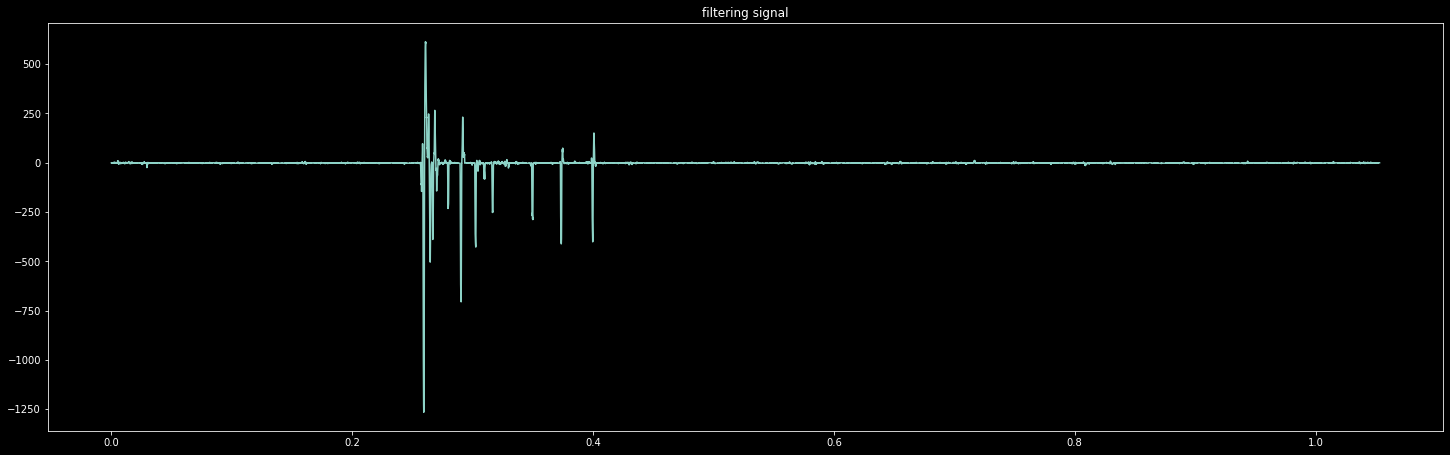

In [19]:
plt.figure(figsize=(25,7.5))
plt.plot(range(len(singleElectrodeUV))/sampmlingFrequency, singleElectrodeUV) 
plt.title('filtering signal')
plt.show()

In [20]:
singleElectrodeUV, sampmlingFrequency =  loadChannel((53,20), dir1)

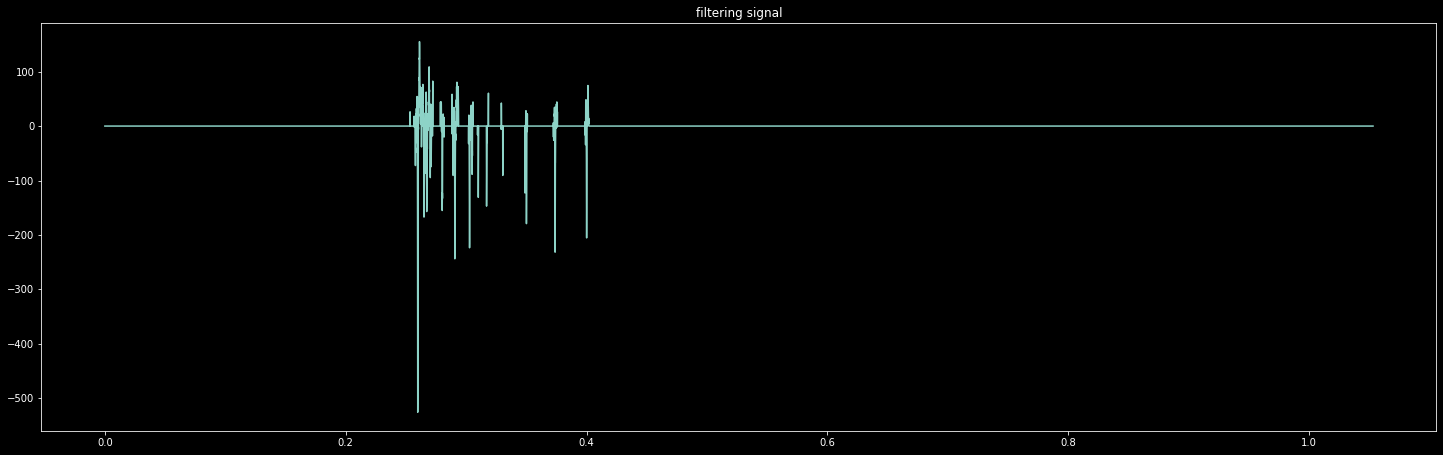

In [21]:
plt.figure(figsize=(25,7.5))
plt.plot(range(len(singleElectrodeUV))/sampmlingFrequency, singleElectrodeUV) 
plt.title('filtering signal')
plt.show()

In [22]:
X = imageio.imread('barbara.jpg')[::4, ::4]
X = X.astype(float)
sigmaNoise = 50
# add noise
Xnoisy = X + sigmaNoise*np.random.randn(X.shape[0], X.shape[1])
Xrec = shearlets(Xnoisy)

(128, 128, 17)
std:  127.58782532400122
threshold:  255.17565064800243
p: 5.179012522977941


ValueError: cannot reshape array of size 278528 into shape (64,64,17)

In [ ]:
plt.figure(figsize=(25,7.5))
plt.gray()
plt.imshow(Xrec)
plt.colorbar()
plt.show()

plt.figure(figsize=(25,7.5))
plt.gray()
plt.imshow(Xnoisy)
plt.colorbar()
plt.show()